In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50 # Remember to remove this before submission.
from keras.applications.inception_resnet_v2 import InceptionResNetV2 # Remember to remove this before submission.
from keras.models import load_model
from keras.losses import mean_absolute_error
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math
from tqdm import tqdm
from keras.utils import plot_model

from LRF import LRFinder
from SGDR import SGDRScheduler
from xception import Xception

Using TensorFlow backend.


In [2]:
train_path = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/high_complexity/images'
architecture_plot_save_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/'

img_width, img_height = 299., 299.
rx = 2.1404
ry = 1.61

In [3]:
base_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/'
epochs = 1000
chkpt_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/xception_lrf_training_s3_data_augmentation.h5'

In [4]:
base_model = Xception(include_top=False, weights=None, input_shape = (299, 299, 3), classes = 4)

In [5]:
# for layer in base_model.layers[:-3]:
#     layer.trainable= False

In [6]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(4, activation="relu")(x)

In [7]:
# model.load_weights("X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/inceptionresnetv2_lrf_submission.h5")

In [8]:
def mIoU(labels,predictions):
    pred_x1=predictions[:,0]
    pred_x2=predictions[:,1]
    pred_y1=predictions[:,2]
    pred_y2=predictions[:,3]
    label_x1=labels[:,0]
    label_x2=labels[:,1]
    label_y1=labels[:,2]
    label_y2=labels[:,3]
    int_x1 = tf.maximum(pred_x1, label_x1)
    int_x2 = tf.minimum(pred_x2, label_x2)
    int_y1 = tf.maximum(pred_y1, label_y1)
    int_y2 = tf.minimum(pred_y2, label_y2)
    tensor_type = pred_x1.dtype
    pred_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), pred_x2 - pred_x1), tf.maximum(tf.cast(0.0, tensor_type), pred_y2 - pred_y1))
    label_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), label_x2 - label_x1), tf.maximum(tf.cast(0.0, tensor_type), label_y2 - label_y1))
    int_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), int_x2 - int_x1), tf.maximum(tf.cast(0.0, tensor_type), int_y2 - int_y1))
    union_area = pred_area + label_area - int_area
    IoU = int_area / union_area
    return tf.reduce_mean(IoU)

In [9]:
model = Model(input = base_model.input, output = predictions)
# model = load_model('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/xception_lrf_training_s3_data.h5', custom_objects = {'mIoU':mIoU})
# plot_model(model, os.path.join(architecture_plot_save_dir, 'xception.png'))
model.summary()

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block5_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 19, 19, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 19, 19, 728)  0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 19, 19, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 19, 19, 728)  0           add_11[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 19, 19, 728)  536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 19, 19, 728)  2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 19, 19, 728)  0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 19, 19, 1024) 752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [10]:
# IoU Metric Test
LABEL = [[0.0, 1.0, 0.0, 1.0], 
        [2.0, 3.0, 2.0, 3.0]]
PRED = [[0.5, 1.5, 0.5, 1.5],
        [2.0, 3.0, 2.0, 3.0]]
LABEL = tf.constant(np.array(LABEL))
PRED = tf.constant(np.array(PRED))
print(mIoU(LABEL, PRED))
with tf.Session() as sess:
    val = sess.run(mIoU(LABEL, PRED))
    print(val)

Tensor("Mean:0", shape=(), dtype=float64)
0.5714285714285714


#### Load best model weights from here, if required.

In [11]:
train_df = pd.read_csv(os.path.join(base_dir, 'high_complexity', 'train.csv'))
train_df.head()
# augment_val_df = pd.read_csv(os.path.join(base_dir, 'orig_data', 'augmented_val_data.csv'))

image_name     x1     x2     y1  \
0                [h]1473665188786DeeplearnS11439.png   68.0  640.0   55.0   
1                       [v]1472556803505DSC_2065.png   86.0  596.0   28.0   
2  [v]147443832540611469622263775-Roadster-Black-...    0.0  640.0   80.0   
3                          1479736122028DSC_1306.png    1.0  640.0  188.0   
4                       [h]1471929984375DSC_0079.png  179.0  493.0  134.0   

      y2  
0  414.0  
1  480.0  
2  421.0  
3  306.0  
4  403.0

In [12]:
val_df = pd.read_csv(os.path.join(base_dir, 'high_complexity', 'val.csv'))
val_df.head()

image_name   x1   x2   y1   y2
0               1458173970010DSC_0453.png  150  477  159  338
1  JPEG_20160724_123033_1000976507523.png   12  624   84  398
2               1475057181436DSC02330.png   82  622  126  345
3               1467979742029DSC_0160.png   45  485   62  380
4     1480175943008Kraus22-11-1613275.png    0  640   21  412

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory=train_path,
                                                  x_col='image_name',
                                                  y_col=['x1', 'x2', 'y1', 'y2'],
                                                  class_mode="other",
                                                  target_size = (299, 299),
                                                  batch_size=8,
                                                  shuffle = True)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=val_df,
                                                  directory=train_path,
                                                  x_col='image_name',
                                                  y_col=['x1', 'x2', 'y1', 'y2'],
                                                  class_mode="other",
                                                  target_size = (299, 299),
                                                  batch_size=8,
                                                  shuffle = True)

Found 88000 images.
Found 2000 images.


In [14]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [15]:
model.compile(loss = mean_absolute_error, optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), metrics=[mIoU])

In [16]:
checkpoint = ModelCheckpoint(chkpt_dir, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')

In [17]:
def show_img_with_rect(img, lab):
    x1 = int(lab[0]/2.1404)
    x2 = int(lab[1]/2.1404)
    y1 = int(lab[2]/1.61)
    y2 = int(lab[3]/1.61) #
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [17]:
# '''
#     lrf = LRFinder(minimum=3e-6, maximum=3e-4, step_size=(train_generator.n//train_generator.batch_size), n_epochs=4)
#     model.fit(x_train, y_train, callbacks=[lrf, ])
#     lrf.lr_graph()
#     lrf.loss_graph()
# '''
lrf = LRFinder(minimum=3e-6, maximum=1e-3, step_size=(train_generator.n//train_generator.batch_size), n_epochs=2)

In [19]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2,
                    verbose=1,
                    callbacks=[checkpoint, lrf],
                    shuffle=True)

Epoch 1/2


  185/14250 [..............................] - ETA: 2:45:54 - loss: 3.3470 - mIoU: 0.952 - ETA: 2:01:47 - loss: 3.1003 - mIoU: 0.959 - ETA: 1:51:20 - loss: 3.6958 - mIoU: 0.953 - ETA: 1:46:37 - loss: 3.4329 - mIoU: 0.956 - ETA: 1:42:34 - loss: 3.6759 - mIoU: 0.950 - ETA: 1:41:17 - loss: 3.5889 - mIoU: 0.953 - ETA: 1:38:36 - loss: 3.7375 - mIoU: 0.951 - ETA: 1:39:16 - loss: 3.9843 - mIoU: 0.948 - ETA: 1:36:51 - loss: 4.0051 - mIoU: 0.949 - ETA: 1:35:08 - loss: 3.7596 - mIoU: 0.952 - ETA: 1:34:15 - loss: 3.7655 - mIoU: 0.952 - ETA: 1:33:40 - loss: 3.8210 - mIoU: 0.953 - ETA: 1:32:49 - loss: 3.8949 - mIoU: 0.953 - ETA: 1:32:10 - loss: 3.7925 - mIoU: 0.954 - ETA: 1:31:30 - loss: 4.1247 - mIoU: 0.952 - ETA: 1:31:14 - loss: 4.2881 - mIoU: 0.947 - ETA: 1:30:45 - loss: 4.1460 - mIoU: 0.949 - ETA: 1:30:26 - loss: 4.0697 - mIoU: 0.949 - ETA: 1:30:02 - loss: 3.9825 - mIoU: 0.950 - ETA: 1:29:40 - loss: 4.5705 - mIoU: 0.945 - ETA: 1:29:19 - loss: 4.4323 - mIoU: 0.947 - ETA: 1:29:17 - loss: 4.5152 -

 1859/14250 [==>...........................] - ETA: 1:14:53 - loss: 4.7928 - mIoU: 0.948 - ETA: 1:14:53 - loss: 4.7954 - mIoU: 0.947 - ETA: 1:14:53 - loss: 4.7943 - mIoU: 0.947 - ETA: 1:14:53 - loss: 4.7954 - mIoU: 0.947 - ETA: 1:14:52 - loss: 4.7956 - mIoU: 0.947 - ETA: 1:14:52 - loss: 4.7959 - mIoU: 0.947 - ETA: 1:14:52 - loss: 4.7956 - mIoU: 0.947 - ETA: 1:14:51 - loss: 4.7939 - mIoU: 0.947 - ETA: 1:14:51 - loss: 4.7938 - mIoU: 0.947 - ETA: 1:14:51 - loss: 4.7932 - mIoU: 0.947 - ETA: 1:14:50 - loss: 4.7941 - mIoU: 0.947 - ETA: 1:14:50 - loss: 4.7954 - mIoU: 0.947 - ETA: 1:14:50 - loss: 4.7941 - mIoU: 0.947 - ETA: 1:14:49 - loss: 4.7938 - mIoU: 0.947 - ETA: 1:14:49 - loss: 4.7919 - mIoU: 0.947 - ETA: 1:14:49 - loss: 4.7909 - mIoU: 0.947 - ETA: 1:14:48 - loss: 4.7931 - mIoU: 0.947 - ETA: 1:14:48 - loss: 4.8103 - mIoU: 0.947 - ETA: 1:14:48 - loss: 4.8110 - mIoU: 0.947 - ETA: 1:14:47 - loss: 4.8100 - mIoU: 0.947 - ETA: 1:14:47 - loss: 4.8085 - mIoU: 0.947 - ETA: 1:14:46 - loss: 4.8068 -

 2045/14250 [===>..........................] - ETA: 1:13:53 - loss: 4.7515 - mIoU: 0.948 - ETA: 1:13:53 - loss: 4.7506 - mIoU: 0.948 - ETA: 1:13:52 - loss: 4.7529 - mIoU: 0.948 - ETA: 1:13:52 - loss: 4.7526 - mIoU: 0.948 - ETA: 1:13:52 - loss: 4.7517 - mIoU: 0.948 - ETA: 1:13:52 - loss: 4.7510 - mIoU: 0.948 - ETA: 1:13:51 - loss: 4.7498 - mIoU: 0.948 - ETA: 1:13:51 - loss: 4.7486 - mIoU: 0.948 - ETA: 1:13:51 - loss: 4.7474 - mIoU: 0.948 - ETA: 1:13:50 - loss: 4.7476 - mIoU: 0.948 - ETA: 1:13:50 - loss: 4.7459 - mIoU: 0.948 - ETA: 1:13:50 - loss: 4.7453 - mIoU: 0.948 - ETA: 1:13:49 - loss: 4.7442 - mIoU: 0.948 - ETA: 1:13:49 - loss: 4.7428 - mIoU: 0.948 - ETA: 1:13:49 - loss: 4.7557 - mIoU: 0.948 - ETA: 1:13:48 - loss: 4.7548 - mIoU: 0.948 - ETA: 1:13:48 - loss: 4.7537 - mIoU: 0.948 - ETA: 1:13:48 - loss: 4.7531 - mIoU: 0.948 - ETA: 1:13:47 - loss: 4.7531 - mIoU: 0.948 - ETA: 1:13:47 - loss: 4.7518 - mIoU: 0.948 - ETA: 1:13:47 - loss: 4.7505 - mIoU: 0.948 - ETA: 1:13:46 - loss: 4.7497 -

 2231/14250 [===>..........................] - ETA: 1:12:47 - loss: 4.7447 - mIoU: 0.948 - ETA: 1:12:46 - loss: 4.7470 - mIoU: 0.948 - ETA: 1:12:46 - loss: 4.7460 - mIoU: 0.948 - ETA: 1:12:45 - loss: 4.7452 - mIoU: 0.948 - ETA: 1:12:45 - loss: 4.7443 - mIoU: 0.948 - ETA: 1:12:45 - loss: 4.7495 - mIoU: 0.948 - ETA: 1:12:44 - loss: 4.7502 - mIoU: 0.948 - ETA: 1:12:44 - loss: 4.7492 - mIoU: 0.948 - ETA: 1:12:43 - loss: 4.7478 - mIoU: 0.948 - ETA: 1:12:43 - loss: 4.7479 - mIoU: 0.948 - ETA: 1:12:43 - loss: 4.7469 - mIoU: 0.948 - ETA: 1:12:42 - loss: 4.7459 - mIoU: 0.948 - ETA: 1:12:42 - loss: 4.7444 - mIoU: 0.948 - ETA: 1:12:42 - loss: 4.7438 - mIoU: 0.948 - ETA: 1:12:41 - loss: 4.7457 - mIoU: 0.948 - ETA: 1:12:41 - loss: 4.7448 - mIoU: 0.948 - ETA: 1:12:40 - loss: 4.7436 - mIoU: 0.948 - ETA: 1:12:40 - loss: 4.7427 - mIoU: 0.948 - ETA: 1:12:40 - loss: 4.7422 - mIoU: 0.948 - ETA: 1:12:39 - loss: 4.7427 - mIoU: 0.948 - ETA: 1:12:39 - loss: 4.7412 - mIoU: 0.948 - ETA: 1:12:39 - loss: 4.7398 -

 2417/14250 [====>.........................] - ETA: 1:11:38 - loss: 4.7555 - mIoU: 0.948 - ETA: 1:11:37 - loss: 4.7542 - mIoU: 0.948 - ETA: 1:11:37 - loss: 4.7542 - mIoU: 0.948 - ETA: 1:11:37 - loss: 4.7528 - mIoU: 0.948 - ETA: 1:11:36 - loss: 4.7528 - mIoU: 0.948 - ETA: 1:11:36 - loss: 4.7524 - mIoU: 0.948 - ETA: 1:11:35 - loss: 4.7521 - mIoU: 0.948 - ETA: 1:11:35 - loss: 4.7516 - mIoU: 0.948 - ETA: 1:11:35 - loss: 4.7512 - mIoU: 0.948 - ETA: 1:11:34 - loss: 4.7500 - mIoU: 0.948 - ETA: 1:11:34 - loss: 4.7529 - mIoU: 0.948 - ETA: 1:11:34 - loss: 4.7514 - mIoU: 0.948 - ETA: 1:11:33 - loss: 4.7498 - mIoU: 0.948 - ETA: 1:11:33 - loss: 4.7488 - mIoU: 0.948 - ETA: 1:11:32 - loss: 4.7478 - mIoU: 0.948 - ETA: 1:11:32 - loss: 4.7484 - mIoU: 0.948 - ETA: 1:11:32 - loss: 4.7475 - mIoU: 0.948 - ETA: 1:11:31 - loss: 4.7470 - mIoU: 0.948 - ETA: 1:11:31 - loss: 4.7463 - mIoU: 0.948 - ETA: 1:11:31 - loss: 4.7455 - mIoU: 0.948 - ETA: 1:11:30 - loss: 4.7453 - mIoU: 0.948 - ETA: 1:11:30 - loss: 4.7448 -

 2603/14250 [====>.........................] - ETA: 1:10:29 - loss: 4.7295 - mIoU: 0.948 - ETA: 1:10:28 - loss: 4.7287 - mIoU: 0.948 - ETA: 1:10:28 - loss: 4.7278 - mIoU: 0.948 - ETA: 1:10:28 - loss: 4.7271 - mIoU: 0.948 - ETA: 1:10:27 - loss: 4.7263 - mIoU: 0.948 - ETA: 1:10:27 - loss: 4.7287 - mIoU: 0.948 - ETA: 1:10:27 - loss: 4.7279 - mIoU: 0.948 - ETA: 1:10:26 - loss: 4.7271 - mIoU: 0.948 - ETA: 1:10:26 - loss: 4.7261 - mIoU: 0.948 - ETA: 1:10:26 - loss: 4.7249 - mIoU: 0.948 - ETA: 1:10:25 - loss: 4.7240 - mIoU: 0.948 - ETA: 1:10:25 - loss: 4.7234 - mIoU: 0.948 - ETA: 1:10:24 - loss: 4.7243 - mIoU: 0.948 - ETA: 1:10:24 - loss: 4.7236 - mIoU: 0.948 - ETA: 1:10:24 - loss: 4.7223 - mIoU: 0.948 - ETA: 1:10:23 - loss: 4.7215 - mIoU: 0.948 - ETA: 1:10:23 - loss: 4.7213 - mIoU: 0.948 - ETA: 1:10:23 - loss: 4.7209 - mIoU: 0.948 - ETA: 1:10:22 - loss: 4.7208 - mIoU: 0.948 - ETA: 1:10:22 - loss: 4.7206 - mIoU: 0.948 - ETA: 1:10:21 - loss: 4.7198 - mIoU: 0.948 - ETA: 1:10:21 - loss: 4.7215 -

 2789/14250 [====>.........................] - ETA: 1:09:21 - loss: 4.7227 - mIoU: 0.948 - ETA: 1:09:21 - loss: 4.7218 - mIoU: 0.948 - ETA: 1:09:20 - loss: 4.7208 - mIoU: 0.948 - ETA: 1:09:20 - loss: 4.7199 - mIoU: 0.948 - ETA: 1:09:20 - loss: 4.7197 - mIoU: 0.948 - ETA: 1:09:19 - loss: 4.7188 - mIoU: 0.948 - ETA: 1:09:19 - loss: 4.7183 - mIoU: 0.948 - ETA: 1:09:19 - loss: 4.7178 - mIoU: 0.948 - ETA: 1:09:18 - loss: 4.7175 - mIoU: 0.948 - ETA: 1:09:18 - loss: 4.7168 - mIoU: 0.948 - ETA: 1:09:18 - loss: 4.7159 - mIoU: 0.948 - ETA: 1:09:17 - loss: 4.7162 - mIoU: 0.948 - ETA: 1:09:17 - loss: 4.7151 - mIoU: 0.948 - ETA: 1:09:17 - loss: 4.7142 - mIoU: 0.948 - ETA: 1:09:16 - loss: 4.7166 - mIoU: 0.948 - ETA: 1:09:16 - loss: 4.7181 - mIoU: 0.948 - ETA: 1:09:16 - loss: 4.7178 - mIoU: 0.948 - ETA: 1:09:15 - loss: 4.7169 - mIoU: 0.948 - ETA: 1:09:15 - loss: 4.7161 - mIoU: 0.948 - ETA: 1:09:14 - loss: 4.7156 - mIoU: 0.948 - ETA: 1:09:14 - loss: 4.7144 - mIoU: 0.948 - ETA: 1:09:14 - loss: 4.7164 -

 2975/14250 [=====>........................] - ETA: 1:08:14 - loss: 4.6943 - mIoU: 0.948 - ETA: 1:08:14 - loss: 4.6933 - mIoU: 0.948 - ETA: 1:08:13 - loss: 4.6925 - mIoU: 0.948 - ETA: 1:08:13 - loss: 4.6923 - mIoU: 0.948 - ETA: 1:08:13 - loss: 4.6926 - mIoU: 0.948 - ETA: 1:08:12 - loss: 4.6957 - mIoU: 0.948 - ETA: 1:08:12 - loss: 4.6950 - mIoU: 0.948 - ETA: 1:08:12 - loss: 4.6961 - mIoU: 0.948 - ETA: 1:08:11 - loss: 4.6951 - mIoU: 0.948 - ETA: 1:08:11 - loss: 4.6944 - mIoU: 0.948 - ETA: 1:08:11 - loss: 4.7001 - mIoU: 0.948 - ETA: 1:08:10 - loss: 4.7004 - mIoU: 0.948 - ETA: 1:08:10 - loss: 4.6997 - mIoU: 0.948 - ETA: 1:08:09 - loss: 4.6990 - mIoU: 0.948 - ETA: 1:08:09 - loss: 4.6990 - mIoU: 0.948 - ETA: 1:08:09 - loss: 4.7014 - mIoU: 0.948 - ETA: 1:08:08 - loss: 4.7005 - mIoU: 0.948 - ETA: 1:08:08 - loss: 4.7002 - mIoU: 0.948 - ETA: 1:08:08 - loss: 4.7016 - mIoU: 0.948 - ETA: 1:08:07 - loss: 4.7009 - mIoU: 0.948 - ETA: 1:08:07 - loss: 4.7002 - mIoU: 0.948 - ETA: 1:08:06 - loss: 4.7018 -

 3161/14250 [=====>........................] - ETA: 1:07:05 - loss: 4.7399 - mIoU: 0.948 - ETA: 1:07:05 - loss: 4.7395 - mIoU: 0.948 - ETA: 1:07:05 - loss: 4.7388 - mIoU: 0.948 - ETA: 1:07:04 - loss: 4.7408 - mIoU: 0.948 - ETA: 1:07:04 - loss: 4.7422 - mIoU: 0.948 - ETA: 1:07:04 - loss: 4.7424 - mIoU: 0.948 - ETA: 1:07:03 - loss: 4.7422 - mIoU: 0.948 - ETA: 1:07:03 - loss: 4.7411 - mIoU: 0.948 - ETA: 1:07:02 - loss: 4.7400 - mIoU: 0.948 - ETA: 1:07:02 - loss: 4.7392 - mIoU: 0.948 - ETA: 1:07:02 - loss: 4.7390 - mIoU: 0.948 - ETA: 1:07:01 - loss: 4.7381 - mIoU: 0.948 - ETA: 1:07:01 - loss: 4.7385 - mIoU: 0.948 - ETA: 1:07:01 - loss: 4.7383 - mIoU: 0.948 - ETA: 1:07:00 - loss: 4.7374 - mIoU: 0.948 - ETA: 1:07:00 - loss: 4.7367 - mIoU: 0.948 - ETA: 1:07:00 - loss: 4.7369 - mIoU: 0.948 - ETA: 1:06:59 - loss: 4.7383 - mIoU: 0.948 - ETA: 1:06:59 - loss: 4.7388 - mIoU: 0.948 - ETA: 1:06:58 - loss: 4.7397 - mIoU: 0.948 - ETA: 1:06:58 - loss: 4.7388 - mIoU: 0.948 - ETA: 1:06:58 - loss: 4.7379 -

 3347/14250 [======>.......................] - ETA: 1:06:01 - loss: 4.7400 - mIoU: 0.948 - ETA: 1:06:01 - loss: 4.7406 - mIoU: 0.948 - ETA: 1:06:00 - loss: 4.7397 - mIoU: 0.948 - ETA: 1:06:00 - loss: 4.7393 - mIoU: 0.948 - ETA: 1:06:00 - loss: 4.7397 - mIoU: 0.948 - ETA: 1:05:59 - loss: 4.7395 - mIoU: 0.948 - ETA: 1:05:59 - loss: 4.7387 - mIoU: 0.948 - ETA: 1:05:58 - loss: 4.7409 - mIoU: 0.948 - ETA: 1:05:58 - loss: 4.7403 - mIoU: 0.948 - ETA: 1:05:58 - loss: 4.7406 - mIoU: 0.948 - ETA: 1:05:57 - loss: 4.7400 - mIoU: 0.948 - ETA: 1:05:57 - loss: 4.7394 - mIoU: 0.948 - ETA: 1:05:57 - loss: 4.7387 - mIoU: 0.948 - ETA: 1:05:56 - loss: 4.7379 - mIoU: 0.948 - ETA: 1:05:56 - loss: 4.7376 - mIoU: 0.948 - ETA: 1:05:56 - loss: 4.7373 - mIoU: 0.948 - ETA: 1:05:55 - loss: 4.7368 - mIoU: 0.948 - ETA: 1:05:55 - loss: 4.7363 - mIoU: 0.948 - ETA: 1:05:55 - loss: 4.7354 - mIoU: 0.948 - ETA: 1:05:54 - loss: 4.7347 - mIoU: 0.948 - ETA: 1:05:54 - loss: 4.7347 - mIoU: 0.948 - ETA: 1:05:53 - loss: 4.7344 -

 3533/14250 [======>.......................] - ETA: 1:04:54 - loss: 4.7250 - mIoU: 0.948 - ETA: 1:04:54 - loss: 4.7245 - mIoU: 0.948 - ETA: 1:04:53 - loss: 4.7245 - mIoU: 0.948 - ETA: 1:04:53 - loss: 4.7237 - mIoU: 0.948 - ETA: 1:04:52 - loss: 4.7233 - mIoU: 0.948 - ETA: 1:04:52 - loss: 4.7228 - mIoU: 0.948 - ETA: 1:04:52 - loss: 4.7220 - mIoU: 0.948 - ETA: 1:04:51 - loss: 4.7255 - mIoU: 0.948 - ETA: 1:04:51 - loss: 4.7261 - mIoU: 0.948 - ETA: 1:04:51 - loss: 4.7257 - mIoU: 0.948 - ETA: 1:04:50 - loss: 4.7247 - mIoU: 0.948 - ETA: 1:04:50 - loss: 4.7243 - mIoU: 0.948 - ETA: 1:04:50 - loss: 4.7247 - mIoU: 0.948 - ETA: 1:04:49 - loss: 4.7238 - mIoU: 0.948 - ETA: 1:04:49 - loss: 4.7229 - mIoU: 0.948 - ETA: 1:04:48 - loss: 4.7223 - mIoU: 0.948 - ETA: 1:04:48 - loss: 4.7218 - mIoU: 0.948 - ETA: 1:04:48 - loss: 4.7278 - mIoU: 0.948 - ETA: 1:04:47 - loss: 4.7270 - mIoU: 0.948 - ETA: 1:04:47 - loss: 4.7270 - mIoU: 0.948 - ETA: 1:04:47 - loss: 4.7275 - mIoU: 0.948 - ETA: 1:04:46 - loss: 4.7267 -

 3719/14250 [======>.......................] - ETA: 1:03:48 - loss: 4.7056 - mIoU: 0.948 - ETA: 1:03:47 - loss: 4.7059 - mIoU: 0.948 - ETA: 1:03:47 - loss: 4.7053 - mIoU: 0.948 - ETA: 1:03:47 - loss: 4.7048 - mIoU: 0.948 - ETA: 1:03:46 - loss: 4.7044 - mIoU: 0.948 - ETA: 1:03:46 - loss: 4.7037 - mIoU: 0.948 - ETA: 1:03:46 - loss: 4.7035 - mIoU: 0.948 - ETA: 1:03:45 - loss: 4.7026 - mIoU: 0.948 - ETA: 1:03:45 - loss: 4.7023 - mIoU: 0.948 - ETA: 1:03:45 - loss: 4.7016 - mIoU: 0.948 - ETA: 1:03:44 - loss: 4.7011 - mIoU: 0.948 - ETA: 1:03:44 - loss: 4.7005 - mIoU: 0.948 - ETA: 1:03:44 - loss: 4.6999 - mIoU: 0.948 - ETA: 1:03:43 - loss: 4.7035 - mIoU: 0.948 - ETA: 1:03:43 - loss: 4.7027 - mIoU: 0.948 - ETA: 1:03:43 - loss: 4.7024 - mIoU: 0.948 - ETA: 1:03:42 - loss: 4.7017 - mIoU: 0.948 - ETA: 1:03:42 - loss: 4.7013 - mIoU: 0.948 - ETA: 1:03:42 - loss: 4.7004 - mIoU: 0.948 - ETA: 1:03:41 - loss: 4.7013 - mIoU: 0.948 - ETA: 1:03:41 - loss: 4.7011 - mIoU: 0.948 - ETA: 1:03:41 - loss: 4.7007 -

 3905/14250 [=======>......................] - ETA: 1:02:43 - loss: 4.7053 - mIoU: 0.948 - ETA: 1:02:43 - loss: 4.7050 - mIoU: 0.948 - ETA: 1:02:43 - loss: 4.7043 - mIoU: 0.948 - ETA: 1:02:42 - loss: 4.7035 - mIoU: 0.948 - ETA: 1:02:42 - loss: 4.7029 - mIoU: 0.948 - ETA: 1:02:42 - loss: 4.7025 - mIoU: 0.948 - ETA: 1:02:41 - loss: 4.7025 - mIoU: 0.948 - ETA: 1:02:41 - loss: 4.7021 - mIoU: 0.948 - ETA: 1:02:40 - loss: 4.7016 - mIoU: 0.948 - ETA: 1:02:40 - loss: 4.7012 - mIoU: 0.948 - ETA: 1:02:40 - loss: 4.7006 - mIoU: 0.948 - ETA: 1:02:39 - loss: 4.7012 - mIoU: 0.948 - ETA: 1:02:39 - loss: 4.7007 - mIoU: 0.948 - ETA: 1:02:39 - loss: 4.7030 - mIoU: 0.948 - ETA: 1:02:38 - loss: 4.7024 - mIoU: 0.948 - ETA: 1:02:38 - loss: 4.7027 - mIoU: 0.948 - ETA: 1:02:38 - loss: 4.7023 - mIoU: 0.948 - ETA: 1:02:37 - loss: 4.7016 - mIoU: 0.948 - ETA: 1:02:37 - loss: 4.7014 - mIoU: 0.948 - ETA: 1:02:37 - loss: 4.7012 - mIoU: 0.948 - ETA: 1:02:36 - loss: 4.7037 - mIoU: 0.948 - ETA: 1:02:36 - loss: 4.7035 -

 4091/14250 [=======>......................] - ETA: 1:01:38 - loss: 4.6763 - mIoU: 0.948 - ETA: 1:01:38 - loss: 4.6761 - mIoU: 0.948 - ETA: 1:01:37 - loss: 4.6760 - mIoU: 0.948 - ETA: 1:01:37 - loss: 4.6757 - mIoU: 0.948 - ETA: 1:01:37 - loss: 4.6751 - mIoU: 0.948 - ETA: 1:01:36 - loss: 4.6762 - mIoU: 0.948 - ETA: 1:01:36 - loss: 4.6777 - mIoU: 0.948 - ETA: 1:01:36 - loss: 4.6773 - mIoU: 0.948 - ETA: 1:01:35 - loss: 4.6777 - mIoU: 0.948 - ETA: 1:01:35 - loss: 4.6773 - mIoU: 0.948 - ETA: 1:01:34 - loss: 4.6765 - mIoU: 0.948 - ETA: 1:01:34 - loss: 4.6801 - mIoU: 0.948 - ETA: 1:01:34 - loss: 4.6795 - mIoU: 0.948 - ETA: 1:01:33 - loss: 4.6791 - mIoU: 0.948 - ETA: 1:01:33 - loss: 4.6785 - mIoU: 0.948 - ETA: 1:01:33 - loss: 4.6778 - mIoU: 0.948 - ETA: 1:01:32 - loss: 4.6774 - mIoU: 0.948 - ETA: 1:01:32 - loss: 4.6772 - mIoU: 0.948 - ETA: 1:01:32 - loss: 4.6767 - mIoU: 0.948 - ETA: 1:01:31 - loss: 4.6762 - mIoU: 0.948 - ETA: 1:01:31 - loss: 4.6762 - mIoU: 0.948 - ETA: 1:01:31 - loss: 4.6769 -

 4281/14250 [========>.....................] - ETA: 1:00:33 - loss: 4.6701 - mIoU: 0.949 - ETA: 1:00:32 - loss: 4.6702 - mIoU: 0.949 - ETA: 1:00:32 - loss: 4.6697 - mIoU: 0.949 - ETA: 1:00:32 - loss: 4.6690 - mIoU: 0.949 - ETA: 1:00:31 - loss: 4.6685 - mIoU: 0.949 - ETA: 1:00:31 - loss: 4.6678 - mIoU: 0.949 - ETA: 1:00:31 - loss: 4.6677 - mIoU: 0.949 - ETA: 1:00:30 - loss: 4.6677 - mIoU: 0.949 - ETA: 1:00:30 - loss: 4.6671 - mIoU: 0.949 - ETA: 1:00:29 - loss: 4.6668 - mIoU: 0.949 - ETA: 1:00:29 - loss: 4.6663 - mIoU: 0.949 - ETA: 1:00:29 - loss: 4.6663 - mIoU: 0.949 - ETA: 1:00:28 - loss: 4.6656 - mIoU: 0.949 - ETA: 1:00:28 - loss: 4.6655 - mIoU: 0.949 - ETA: 1:00:28 - loss: 4.6652 - mIoU: 0.949 - ETA: 1:00:27 - loss: 4.6650 - mIoU: 0.949 - ETA: 1:00:27 - loss: 4.6642 - mIoU: 0.949 - ETA: 1:00:27 - loss: 4.6637 - mIoU: 0.949 - ETA: 1:00:26 - loss: 4.6631 - mIoU: 0.949 - ETA: 1:00:26 - loss: 4.6633 - mIoU: 0.949 - ETA: 1:00:26 - loss: 4.6626 - mIoU: 0.949 - ETA: 1:00:25 - loss: 4.6624 -

 4475/14250 [========>.....................] - ETA: 59:26 - loss: 4.6669 - mIoU: 0.949 - ETA: 59:25 - loss: 4.6663 - mIoU: 0.949 - ETA: 59:25 - loss: 4.6663 - mIoU: 0.949 - ETA: 59:25 - loss: 4.6657 - mIoU: 0.949 - ETA: 59:24 - loss: 4.6655 - mIoU: 0.949 - ETA: 59:24 - loss: 4.6647 - mIoU: 0.949 - ETA: 59:24 - loss: 4.6642 - mIoU: 0.949 - ETA: 59:23 - loss: 4.6639 - mIoU: 0.949 - ETA: 59:23 - loss: 4.6633 - mIoU: 0.949 - ETA: 59:23 - loss: 4.6629 - mIoU: 0.949 - ETA: 59:22 - loss: 4.6630 - mIoU: 0.949 - ETA: 59:22 - loss: 4.6627 - mIoU: 0.949 - ETA: 59:21 - loss: 4.6621 - mIoU: 0.949 - ETA: 59:21 - loss: 4.6623 - mIoU: 0.949 - ETA: 59:21 - loss: 4.6619 - mIoU: 0.949 - ETA: 59:20 - loss: 4.6614 - mIoU: 0.949 - ETA: 59:20 - loss: 4.6624 - mIoU: 0.949 - ETA: 59:20 - loss: 4.6624 - mIoU: 0.949 - ETA: 59:19 - loss: 4.6626 - mIoU: 0.949 - ETA: 59:19 - loss: 4.6619 - mIoU: 0.949 - ETA: 59:19 - loss: 4.6615 - mIoU: 0.949 - ETA: 59:18 - loss: 4.6621 - mIoU: 0.949 - ETA: 59:18 - loss: 4.6616 - m

 4669/14250 [========>.....................] - ETA: 58:18 - loss: 4.6679 - mIoU: 0.949 - ETA: 58:18 - loss: 4.6683 - mIoU: 0.949 - ETA: 58:17 - loss: 4.6721 - mIoU: 0.949 - ETA: 58:17 - loss: 4.6717 - mIoU: 0.949 - ETA: 58:17 - loss: 4.6716 - mIoU: 0.949 - ETA: 58:16 - loss: 4.6712 - mIoU: 0.949 - ETA: 58:16 - loss: 4.6709 - mIoU: 0.949 - ETA: 58:16 - loss: 4.6704 - mIoU: 0.949 - ETA: 58:15 - loss: 4.6712 - mIoU: 0.949 - ETA: 58:15 - loss: 4.6710 - mIoU: 0.949 - ETA: 58:15 - loss: 4.6704 - mIoU: 0.949 - ETA: 58:14 - loss: 4.6699 - mIoU: 0.949 - ETA: 58:14 - loss: 4.6696 - mIoU: 0.949 - ETA: 58:14 - loss: 4.6692 - mIoU: 0.949 - ETA: 58:13 - loss: 4.6686 - mIoU: 0.949 - ETA: 58:13 - loss: 4.6695 - mIoU: 0.949 - ETA: 58:13 - loss: 4.6691 - mIoU: 0.949 - ETA: 58:12 - loss: 4.6688 - mIoU: 0.949 - ETA: 58:12 - loss: 4.6690 - mIoU: 0.949 - ETA: 58:12 - loss: 4.6697 - mIoU: 0.949 - ETA: 58:11 - loss: 4.6691 - mIoU: 0.949 - ETA: 58:11 - loss: 4.6691 - mIoU: 0.949 - ETA: 58:10 - loss: 4.6691 - m

 4863/14250 [=========>....................] - ETA: 57:10 - loss: 4.6679 - mIoU: 0.949 - ETA: 57:09 - loss: 4.6678 - mIoU: 0.949 - ETA: 57:09 - loss: 4.6677 - mIoU: 0.949 - ETA: 57:09 - loss: 4.6672 - mIoU: 0.949 - ETA: 57:08 - loss: 4.6678 - mIoU: 0.949 - ETA: 57:08 - loss: 4.6673 - mIoU: 0.949 - ETA: 57:08 - loss: 4.6681 - mIoU: 0.949 - ETA: 57:07 - loss: 4.6674 - mIoU: 0.949 - ETA: 57:07 - loss: 4.6676 - mIoU: 0.949 - ETA: 57:07 - loss: 4.6683 - mIoU: 0.949 - ETA: 57:06 - loss: 4.6706 - mIoU: 0.949 - ETA: 57:06 - loss: 4.6703 - mIoU: 0.949 - ETA: 57:06 - loss: 4.6715 - mIoU: 0.949 - ETA: 57:05 - loss: 4.6713 - mIoU: 0.949 - ETA: 57:05 - loss: 4.6715 - mIoU: 0.949 - ETA: 57:05 - loss: 4.6709 - mIoU: 0.949 - ETA: 57:04 - loss: 4.6705 - mIoU: 0.949 - ETA: 57:04 - loss: 4.6705 - mIoU: 0.949 - ETA: 57:03 - loss: 4.6699 - mIoU: 0.949 - ETA: 57:03 - loss: 4.6699 - mIoU: 0.949 - ETA: 57:03 - loss: 4.6695 - mIoU: 0.949 - ETA: 57:02 - loss: 4.6699 - mIoU: 0.949 - ETA: 57:02 - loss: 4.6692 - m

 5057/14250 [=========>....................] - ETA: 56:01 - loss: 4.6487 - mIoU: 0.949 - ETA: 56:01 - loss: 4.6487 - mIoU: 0.949 - ETA: 56:00 - loss: 4.6499 - mIoU: 0.949 - ETA: 56:00 - loss: 4.6495 - mIoU: 0.949 - ETA: 56:00 - loss: 4.6491 - mIoU: 0.949 - ETA: 55:59 - loss: 4.6487 - mIoU: 0.949 - ETA: 55:59 - loss: 4.6482 - mIoU: 0.949 - ETA: 55:59 - loss: 4.6476 - mIoU: 0.949 - ETA: 55:58 - loss: 4.6471 - mIoU: 0.949 - ETA: 55:58 - loss: 4.6467 - mIoU: 0.949 - ETA: 55:58 - loss: 4.6474 - mIoU: 0.949 - ETA: 55:57 - loss: 4.6509 - mIoU: 0.949 - ETA: 55:57 - loss: 4.6504 - mIoU: 0.949 - ETA: 55:57 - loss: 4.6498 - mIoU: 0.949 - ETA: 55:56 - loss: 4.6498 - mIoU: 0.949 - ETA: 55:56 - loss: 4.6506 - mIoU: 0.949 - ETA: 55:55 - loss: 4.6504 - mIoU: 0.949 - ETA: 55:55 - loss: 4.6506 - mIoU: 0.949 - ETA: 55:55 - loss: 4.6503 - mIoU: 0.949 - ETA: 55:54 - loss: 4.6500 - mIoU: 0.949 - ETA: 55:54 - loss: 4.6495 - mIoU: 0.949 - ETA: 55:54 - loss: 4.6494 - mIoU: 0.949 - ETA: 55:53 - loss: 4.6530 - m

 5251/14250 [==========>...................] - ETA: 54:52 - loss: 4.6354 - mIoU: 0.949 - ETA: 54:52 - loss: 4.6348 - mIoU: 0.949 - ETA: 54:52 - loss: 4.6345 - mIoU: 0.949 - ETA: 54:51 - loss: 4.6346 - mIoU: 0.949 - ETA: 54:51 - loss: 4.6353 - mIoU: 0.949 - ETA: 54:51 - loss: 4.6347 - mIoU: 0.949 - ETA: 54:50 - loss: 4.6343 - mIoU: 0.949 - ETA: 54:50 - loss: 4.6339 - mIoU: 0.949 - ETA: 54:49 - loss: 4.6343 - mIoU: 0.949 - ETA: 54:49 - loss: 4.6348 - mIoU: 0.949 - ETA: 54:49 - loss: 4.6343 - mIoU: 0.949 - ETA: 54:48 - loss: 4.6349 - mIoU: 0.949 - ETA: 54:48 - loss: 4.6345 - mIoU: 0.949 - ETA: 54:48 - loss: 4.6343 - mIoU: 0.949 - ETA: 54:47 - loss: 4.6342 - mIoU: 0.949 - ETA: 54:47 - loss: 4.6337 - mIoU: 0.949 - ETA: 54:46 - loss: 4.6341 - mIoU: 0.949 - ETA: 54:46 - loss: 4.6342 - mIoU: 0.949 - ETA: 54:46 - loss: 4.6338 - mIoU: 0.949 - ETA: 54:45 - loss: 4.6336 - mIoU: 0.949 - ETA: 54:45 - loss: 4.6348 - mIoU: 0.949 - ETA: 54:45 - loss: 4.6344 - mIoU: 0.949 - ETA: 54:44 - loss: 4.6345 - m

 5445/14250 [==========>...................] - ETA: 53:41 - loss: 4.6319 - mIoU: 0.949 - ETA: 53:41 - loss: 4.6313 - mIoU: 0.949 - ETA: 53:40 - loss: 4.6308 - mIoU: 0.949 - ETA: 53:40 - loss: 4.6305 - mIoU: 0.949 - ETA: 53:40 - loss: 4.6320 - mIoU: 0.949 - ETA: 53:39 - loss: 4.6316 - mIoU: 0.949 - ETA: 53:39 - loss: 4.6313 - mIoU: 0.949 - ETA: 53:39 - loss: 4.6309 - mIoU: 0.949 - ETA: 53:38 - loss: 4.6304 - mIoU: 0.949 - ETA: 53:38 - loss: 4.6298 - mIoU: 0.949 - ETA: 53:38 - loss: 4.6303 - mIoU: 0.949 - ETA: 53:37 - loss: 4.6304 - mIoU: 0.949 - ETA: 53:37 - loss: 4.6302 - mIoU: 0.949 - ETA: 53:36 - loss: 4.6297 - mIoU: 0.949 - ETA: 53:36 - loss: 4.6296 - mIoU: 0.949 - ETA: 53:36 - loss: 4.6293 - mIoU: 0.949 - ETA: 53:35 - loss: 4.6288 - mIoU: 0.949 - ETA: 53:35 - loss: 4.6282 - mIoU: 0.949 - ETA: 53:35 - loss: 4.6279 - mIoU: 0.949 - ETA: 53:34 - loss: 4.6277 - mIoU: 0.949 - ETA: 53:34 - loss: 4.6273 - mIoU: 0.949 - ETA: 53:34 - loss: 4.6269 - mIoU: 0.949 - ETA: 53:33 - loss: 4.6264 - m

 5639/14250 [==========>...................] - ETA: 52:30 - loss: 4.6249 - mIoU: 0.949 - ETA: 52:30 - loss: 4.6247 - mIoU: 0.949 - ETA: 52:29 - loss: 4.6246 - mIoU: 0.949 - ETA: 52:29 - loss: 4.6242 - mIoU: 0.949 - ETA: 52:29 - loss: 4.6238 - mIoU: 0.949 - ETA: 52:28 - loss: 4.6243 - mIoU: 0.949 - ETA: 52:28 - loss: 4.6240 - mIoU: 0.949 - ETA: 52:28 - loss: 4.6236 - mIoU: 0.949 - ETA: 52:27 - loss: 4.6231 - mIoU: 0.949 - ETA: 52:27 - loss: 4.6229 - mIoU: 0.949 - ETA: 52:27 - loss: 4.6224 - mIoU: 0.949 - ETA: 52:26 - loss: 4.6220 - mIoU: 0.949 - ETA: 52:26 - loss: 4.6227 - mIoU: 0.949 - ETA: 52:25 - loss: 4.6223 - mIoU: 0.949 - ETA: 52:25 - loss: 4.6219 - mIoU: 0.949 - ETA: 52:25 - loss: 4.6215 - mIoU: 0.949 - ETA: 52:24 - loss: 4.6211 - mIoU: 0.949 - ETA: 52:24 - loss: 4.6222 - mIoU: 0.949 - ETA: 52:24 - loss: 4.6218 - mIoU: 0.949 - ETA: 52:23 - loss: 4.6219 - mIoU: 0.949 - ETA: 52:23 - loss: 4.6216 - mIoU: 0.949 - ETA: 52:23 - loss: 4.6237 - mIoU: 0.949 - ETA: 52:22 - loss: 4.6239 - m

 5833/14250 [===========>..................] - ETA: 51:19 - loss: 4.6280 - mIoU: 0.949 - ETA: 51:19 - loss: 4.6275 - mIoU: 0.949 - ETA: 51:19 - loss: 4.6273 - mIoU: 0.949 - ETA: 51:18 - loss: 4.6268 - mIoU: 0.949 - ETA: 51:18 - loss: 4.6263 - mIoU: 0.949 - ETA: 51:18 - loss: 4.6261 - mIoU: 0.949 - ETA: 51:17 - loss: 4.6256 - mIoU: 0.949 - ETA: 51:17 - loss: 4.6259 - mIoU: 0.949 - ETA: 51:17 - loss: 4.6256 - mIoU: 0.949 - ETA: 51:16 - loss: 4.6260 - mIoU: 0.949 - ETA: 51:16 - loss: 4.6263 - mIoU: 0.949 - ETA: 51:16 - loss: 4.6260 - mIoU: 0.949 - ETA: 51:15 - loss: 4.6261 - mIoU: 0.949 - ETA: 51:15 - loss: 4.6261 - mIoU: 0.949 - ETA: 51:14 - loss: 4.6256 - mIoU: 0.949 - ETA: 51:14 - loss: 4.6253 - mIoU: 0.949 - ETA: 51:14 - loss: 4.6250 - mIoU: 0.949 - ETA: 51:13 - loss: 4.6250 - mIoU: 0.949 - ETA: 51:13 - loss: 4.6246 - mIoU: 0.949 - ETA: 51:13 - loss: 4.6243 - mIoU: 0.949 - ETA: 51:12 - loss: 4.6245 - mIoU: 0.949 - ETA: 51:12 - loss: 4.6241 - mIoU: 0.949 - ETA: 51:12 - loss: 4.6239 - m

 6027/14250 [===========>..................] - ETA: 50:09 - loss: 4.6057 - mIoU: 0.949 - ETA: 50:08 - loss: 4.6059 - mIoU: 0.949 - ETA: 50:08 - loss: 4.6055 - mIoU: 0.949 - ETA: 50:08 - loss: 4.6052 - mIoU: 0.949 - ETA: 50:07 - loss: 4.6050 - mIoU: 0.949 - ETA: 50:07 - loss: 4.6046 - mIoU: 0.949 - ETA: 50:07 - loss: 4.6041 - mIoU: 0.949 - ETA: 50:06 - loss: 4.6040 - mIoU: 0.949 - ETA: 50:06 - loss: 4.6037 - mIoU: 0.949 - ETA: 50:06 - loss: 4.6034 - mIoU: 0.949 - ETA: 50:05 - loss: 4.6030 - mIoU: 0.949 - ETA: 50:05 - loss: 4.6027 - mIoU: 0.949 - ETA: 50:04 - loss: 4.6023 - mIoU: 0.949 - ETA: 50:04 - loss: 4.6018 - mIoU: 0.949 - ETA: 50:04 - loss: 4.6016 - mIoU: 0.949 - ETA: 50:03 - loss: 4.6011 - mIoU: 0.949 - ETA: 50:03 - loss: 4.6009 - mIoU: 0.949 - ETA: 50:03 - loss: 4.6011 - mIoU: 0.949 - ETA: 50:02 - loss: 4.6008 - mIoU: 0.949 - ETA: 50:02 - loss: 4.6021 - mIoU: 0.949 - ETA: 50:02 - loss: 4.6024 - mIoU: 0.949 - ETA: 50:01 - loss: 4.6032 - mIoU: 0.949 - ETA: 50:01 - loss: 4.6026 - m

 6221/14250 [============>.................] - ETA: 48:59 - loss: 4.5988 - mIoU: 0.949 - ETA: 48:58 - loss: 4.5986 - mIoU: 0.949 - ETA: 48:58 - loss: 4.5988 - mIoU: 0.949 - ETA: 48:57 - loss: 4.5995 - mIoU: 0.949 - ETA: 48:57 - loss: 4.5993 - mIoU: 0.949 - ETA: 48:57 - loss: 4.5992 - mIoU: 0.949 - ETA: 48:56 - loss: 4.5991 - mIoU: 0.949 - ETA: 48:56 - loss: 4.5988 - mIoU: 0.949 - ETA: 48:56 - loss: 4.5985 - mIoU: 0.949 - ETA: 48:55 - loss: 4.5999 - mIoU: 0.949 - ETA: 48:55 - loss: 4.5995 - mIoU: 0.949 - ETA: 48:55 - loss: 4.5993 - mIoU: 0.949 - ETA: 48:54 - loss: 4.5999 - mIoU: 0.949 - ETA: 48:54 - loss: 4.6001 - mIoU: 0.949 - ETA: 48:54 - loss: 4.6006 - mIoU: 0.949 - ETA: 48:53 - loss: 4.6006 - mIoU: 0.949 - ETA: 48:53 - loss: 4.6003 - mIoU: 0.949 - ETA: 48:52 - loss: 4.5999 - mIoU: 0.949 - ETA: 48:52 - loss: 4.6010 - mIoU: 0.949 - ETA: 48:52 - loss: 4.6008 - mIoU: 0.949 - ETA: 48:51 - loss: 4.6008 - mIoU: 0.949 - ETA: 48:51 - loss: 4.6006 - mIoU: 0.949 - ETA: 48:51 - loss: 4.6003 - m

 6417/14250 [============>.................] - ETA: 47:49 - loss: 4.5803 - mIoU: 0.949 - ETA: 47:49 - loss: 4.5799 - mIoU: 0.949 - ETA: 47:48 - loss: 4.5796 - mIoU: 0.949 - ETA: 47:48 - loss: 4.5794 - mIoU: 0.949 - ETA: 47:47 - loss: 4.5790 - mIoU: 0.949 - ETA: 47:47 - loss: 4.5791 - mIoU: 0.949 - ETA: 47:47 - loss: 4.5790 - mIoU: 0.949 - ETA: 47:46 - loss: 4.5795 - mIoU: 0.949 - ETA: 47:46 - loss: 4.5791 - mIoU: 0.949 - ETA: 47:46 - loss: 4.5787 - mIoU: 0.949 - ETA: 47:45 - loss: 4.5782 - mIoU: 0.949 - ETA: 47:45 - loss: 4.5779 - mIoU: 0.949 - ETA: 47:45 - loss: 4.5777 - mIoU: 0.949 - ETA: 47:44 - loss: 4.5787 - mIoU: 0.949 - ETA: 47:44 - loss: 4.5784 - mIoU: 0.949 - ETA: 47:44 - loss: 4.5779 - mIoU: 0.949 - ETA: 47:43 - loss: 4.5793 - mIoU: 0.949 - ETA: 47:43 - loss: 4.5790 - mIoU: 0.949 - ETA: 47:42 - loss: 4.5790 - mIoU: 0.949 - ETA: 47:42 - loss: 4.5801 - mIoU: 0.949 - ETA: 47:42 - loss: 4.5806 - mIoU: 0.949 - ETA: 47:41 - loss: 4.5801 - mIoU: 0.949 - ETA: 47:41 - loss: 4.5801 - m

 6632/14250 [============>.................] - ETA: 46:38 - loss: 4.5850 - mIoU: n - ETA: 46:38 - loss: 4.5855 - mIoU: n - ETA: 46:38 - loss: 4.5852 - mIoU: n - ETA: 46:37 - loss: 4.5848 - mIoU: n - ETA: 46:37 - loss: 4.5846 - mIoU: n - ETA: 46:37 - loss: 4.5842 - mIoU: n - ETA: 46:36 - loss: 4.5840 - mIoU: n - ETA: 46:36 - loss: 4.5843 - mIoU: n - ETA: 46:36 - loss: 4.5856 - mIoU: n - ETA: 46:35 - loss: 4.5854 - mIoU: n - ETA: 46:35 - loss: 4.5850 - mIoU: n - ETA: 46:35 - loss: 4.5848 - mIoU: n - ETA: 46:34 - loss: 4.5847 - mIoU: n - ETA: 46:34 - loss: 4.5843 - mIoU: n - ETA: 46:33 - loss: 4.5840 - mIoU: n - ETA: 46:33 - loss: 4.5841 - mIoU: n - ETA: 46:33 - loss: 4.5843 - mIoU: n - ETA: 46:32 - loss: 4.5846 - mIoU: n - ETA: 46:32 - loss: 4.5843 - mIoU: n - ETA: 46:32 - loss: 4.5839 - mIoU: n - ETA: 46:31 - loss: 4.5836 - mIoU: n - ETA: 46:31 - loss: 4.5833 - mIoU: n - ETA: 46:31 - loss: 4.5829 - mIoU: n - ETA: 46:30 - loss: 4.5826 - mIoU: n - ETA: 46:30 - loss: 4.5825 - mIoU: n - ETA

 6847/14250 [=============>................] - ETA: 45:22 - loss: 4.5755 - mIoU: n - ETA: 45:22 - loss: 4.5753 - mIoU: n - ETA: 45:22 - loss: 4.5749 - mIoU: n - ETA: 45:21 - loss: 4.5747 - mIoU: n - ETA: 45:21 - loss: 4.5747 - mIoU: n - ETA: 45:21 - loss: 4.5750 - mIoU: n - ETA: 45:20 - loss: 4.5748 - mIoU: n - ETA: 45:20 - loss: 4.5746 - mIoU: n - ETA: 45:20 - loss: 4.5746 - mIoU: n - ETA: 45:19 - loss: 4.5744 - mIoU: n - ETA: 45:19 - loss: 4.5744 - mIoU: n - ETA: 45:18 - loss: 4.5741 - mIoU: n - ETA: 45:18 - loss: 4.5740 - mIoU: n - ETA: 45:18 - loss: 4.5738 - mIoU: n - ETA: 45:17 - loss: 4.5736 - mIoU: n - ETA: 45:17 - loss: 4.5732 - mIoU: n - ETA: 45:17 - loss: 4.5730 - mIoU: n - ETA: 45:16 - loss: 4.5725 - mIoU: n - ETA: 45:16 - loss: 4.5724 - mIoU: n - ETA: 45:16 - loss: 4.5725 - mIoU: n - ETA: 45:15 - loss: 4.5723 - mIoU: n - ETA: 45:15 - loss: 4.5721 - mIoU: n - ETA: 45:15 - loss: 4.5717 - mIoU: n - ETA: 45:14 - loss: 4.5723 - mIoU: n - ETA: 45:14 - loss: 4.5724 - mIoU: n - ETA

 7062/14250 [=============>................] - ETA: 44:06 - loss: 4.5895 - mIoU: n - ETA: 44:06 - loss: 4.5892 - mIoU: n - ETA: 44:06 - loss: 4.5889 - mIoU: n - ETA: 44:05 - loss: 4.5888 - mIoU: n - ETA: 44:05 - loss: 4.5885 - mIoU: n - ETA: 44:05 - loss: 4.5885 - mIoU: n - ETA: 44:04 - loss: 4.5883 - mIoU: n - ETA: 44:04 - loss: 4.5880 - mIoU: n - ETA: 44:03 - loss: 4.5880 - mIoU: n - ETA: 44:03 - loss: 4.5876 - mIoU: n - ETA: 44:03 - loss: 4.5877 - mIoU: n - ETA: 44:02 - loss: 4.5884 - mIoU: n - ETA: 44:02 - loss: 4.5888 - mIoU: n - ETA: 44:02 - loss: 4.5885 - mIoU: n - ETA: 44:01 - loss: 4.5883 - mIoU: n - ETA: 44:01 - loss: 4.5906 - mIoU: n - ETA: 44:01 - loss: 4.5903 - mIoU: n - ETA: 44:00 - loss: 4.5899 - mIoU: n - ETA: 44:00 - loss: 4.5903 - mIoU: n - ETA: 44:00 - loss: 4.5902 - mIoU: n - ETA: 43:59 - loss: 4.5901 - mIoU: n - ETA: 43:59 - loss: 4.5898 - mIoU: n - ETA: 43:58 - loss: 4.5896 - mIoU: n - ETA: 43:58 - loss: 4.5897 - mIoU: n - ETA: 43:58 - loss: 4.5896 - mIoU: n - ETA

 7277/14250 [==============>...............] - ETA: 42:49 - loss: 4.5990 - mIoU: n - ETA: 42:49 - loss: 4.5993 - mIoU: n - ETA: 42:49 - loss: 4.5993 - mIoU: n - ETA: 42:48 - loss: 4.5998 - mIoU: n - ETA: 42:48 - loss: 4.5996 - mIoU: n - ETA: 42:48 - loss: 4.5994 - mIoU: n - ETA: 42:47 - loss: 4.5989 - mIoU: n - ETA: 42:47 - loss: 4.5986 - mIoU: n - ETA: 42:46 - loss: 4.5982 - mIoU: n - ETA: 42:46 - loss: 4.5983 - mIoU: n - ETA: 42:46 - loss: 4.5981 - mIoU: n - ETA: 42:45 - loss: 4.5978 - mIoU: n - ETA: 42:45 - loss: 4.5980 - mIoU: n - ETA: 42:45 - loss: 4.5978 - mIoU: n - ETA: 42:44 - loss: 4.5979 - mIoU: n - ETA: 42:44 - loss: 4.5976 - mIoU: n - ETA: 42:44 - loss: 4.5974 - mIoU: n - ETA: 42:43 - loss: 4.5978 - mIoU: n - ETA: 42:43 - loss: 4.5981 - mIoU: n - ETA: 42:43 - loss: 4.5980 - mIoU: n - ETA: 42:42 - loss: 4.5978 - mIoU: n - ETA: 42:42 - loss: 4.5985 - mIoU: n - ETA: 42:41 - loss: 4.5985 - mIoU: n - ETA: 42:41 - loss: 4.5984 - mIoU: n - ETA: 42:41 - loss: 4.5982 - mIoU: n - ETA

 7492/14250 [==============>...............] - ETA: 41:32 - loss: 4.5903 - mIoU: n - ETA: 41:32 - loss: 4.5912 - mIoU: n - ETA: 41:32 - loss: 4.5912 - mIoU: n - ETA: 41:31 - loss: 4.5924 - mIoU: n - ETA: 41:31 - loss: 4.5926 - mIoU: n - ETA: 41:30 - loss: 4.5922 - mIoU: n - ETA: 41:30 - loss: 4.5923 - mIoU: n - ETA: 41:30 - loss: 4.5921 - mIoU: n - ETA: 41:29 - loss: 4.5925 - mIoU: n - ETA: 41:29 - loss: 4.5922 - mIoU: n - ETA: 41:29 - loss: 4.5929 - mIoU: n - ETA: 41:28 - loss: 4.5939 - mIoU: n - ETA: 41:28 - loss: 4.5938 - mIoU: n - ETA: 41:28 - loss: 4.5947 - mIoU: n - ETA: 41:27 - loss: 4.5946 - mIoU: n - ETA: 41:27 - loss: 4.5943 - mIoU: n - ETA: 41:26 - loss: 4.5940 - mIoU: n - ETA: 41:26 - loss: 4.5937 - mIoU: n - ETA: 41:26 - loss: 4.5934 - mIoU: n - ETA: 41:25 - loss: 4.5933 - mIoU: n - ETA: 41:25 - loss: 4.5931 - mIoU: n - ETA: 41:25 - loss: 4.5929 - mIoU: n - ETA: 41:24 - loss: 4.5930 - mIoU: n - ETA: 41:24 - loss: 4.5928 - mIoU: n - ETA: 41:24 - loss: 4.5935 - mIoU: n - ETA

 7707/14250 [===============>..............] - ETA: 40:15 - loss: 4.5848 - mIoU: n - ETA: 40:14 - loss: 4.5846 - mIoU: n - ETA: 40:14 - loss: 4.5847 - mIoU: n - ETA: 40:14 - loss: 4.5848 - mIoU: n - ETA: 40:13 - loss: 4.5846 - mIoU: n - ETA: 40:13 - loss: 4.5844 - mIoU: n - ETA: 40:13 - loss: 4.5841 - mIoU: n - ETA: 40:12 - loss: 4.5839 - mIoU: n - ETA: 40:12 - loss: 4.5840 - mIoU: n - ETA: 40:11 - loss: 4.5838 - mIoU: n - ETA: 40:11 - loss: 4.5837 - mIoU: n - ETA: 40:11 - loss: 4.5834 - mIoU: n - ETA: 40:10 - loss: 4.5833 - mIoU: n - ETA: 40:10 - loss: 4.5835 - mIoU: n - ETA: 40:10 - loss: 4.5833 - mIoU: n - ETA: 40:09 - loss: 4.5830 - mIoU: n - ETA: 40:09 - loss: 4.5848 - mIoU: n - ETA: 40:09 - loss: 4.5845 - mIoU: n - ETA: 40:08 - loss: 4.5843 - mIoU: n - ETA: 40:08 - loss: 4.5840 - mIoU: n - ETA: 40:07 - loss: 4.5839 - mIoU: n - ETA: 40:07 - loss: 4.5838 - mIoU: n - ETA: 40:07 - loss: 4.5837 - mIoU: n - ETA: 40:06 - loss: 4.5834 - mIoU: n - ETA: 40:06 - loss: 4.5830 - mIoU: n - ETA

 7922/14250 [===============>..............] - ETA: 38:57 - loss: 4.5868 - mIoU: n - ETA: 38:57 - loss: 4.5864 - mIoU: n - ETA: 38:56 - loss: 4.5864 - mIoU: n - ETA: 38:56 - loss: 4.5864 - mIoU: n - ETA: 38:56 - loss: 4.5861 - mIoU: n - ETA: 38:55 - loss: 4.5857 - mIoU: n - ETA: 38:55 - loss: 4.5855 - mIoU: n - ETA: 38:55 - loss: 4.5856 - mIoU: n - ETA: 38:54 - loss: 4.5854 - mIoU: n - ETA: 38:54 - loss: 4.5867 - mIoU: n - ETA: 38:54 - loss: 4.5867 - mIoU: n - ETA: 38:53 - loss: 4.5869 - mIoU: n - ETA: 38:53 - loss: 4.5867 - mIoU: n - ETA: 38:52 - loss: 4.5865 - mIoU: n - ETA: 38:52 - loss: 4.5863 - mIoU: n - ETA: 38:52 - loss: 4.5861 - mIoU: n - ETA: 38:51 - loss: 4.5858 - mIoU: n - ETA: 38:51 - loss: 4.5854 - mIoU: n - ETA: 38:51 - loss: 4.5864 - mIoU: n - ETA: 38:50 - loss: 4.5864 - mIoU: n - ETA: 38:50 - loss: 4.5864 - mIoU: n - ETA: 38:50 - loss: 4.5862 - mIoU: n - ETA: 38:49 - loss: 4.5861 - mIoU: n - ETA: 38:49 - loss: 4.5859 - mIoU: n - ETA: 38:49 - loss: 4.5858 - mIoU: n - ETA

 8137/14250 [================>.............] - ETA: 37:41 - loss: 4.5775 - mIoU: n - ETA: 37:40 - loss: 4.5774 - mIoU: n - ETA: 37:40 - loss: 4.5773 - mIoU: n - ETA: 37:40 - loss: 4.5770 - mIoU: n - ETA: 37:39 - loss: 4.5779 - mIoU: n - ETA: 37:39 - loss: 4.5777 - mIoU: n - ETA: 37:39 - loss: 4.5774 - mIoU: n - ETA: 37:38 - loss: 4.5772 - mIoU: n - ETA: 37:38 - loss: 4.5768 - mIoU: n - ETA: 37:37 - loss: 4.5766 - mIoU: n - ETA: 37:37 - loss: 4.5766 - mIoU: n - ETA: 37:37 - loss: 4.5763 - mIoU: n - ETA: 37:36 - loss: 4.5761 - mIoU: n - ETA: 37:36 - loss: 4.5758 - mIoU: n - ETA: 37:36 - loss: 4.5759 - mIoU: n - ETA: 37:35 - loss: 4.5756 - mIoU: n - ETA: 37:35 - loss: 4.5754 - mIoU: n - ETA: 37:35 - loss: 4.5753 - mIoU: n - ETA: 37:34 - loss: 4.5751 - mIoU: n - ETA: 37:34 - loss: 4.5749 - mIoU: n - ETA: 37:34 - loss: 4.5752 - mIoU: n - ETA: 37:33 - loss: 4.5750 - mIoU: n - ETA: 37:33 - loss: 4.5748 - mIoU: n - ETA: 37:33 - loss: 4.5752 - mIoU: n - ETA: 37:32 - loss: 4.5750 - mIoU: n - ETA

 8352/14250 [================>.............] - ETA: 36:25 - loss: 4.5638 - mIoU: n - ETA: 36:25 - loss: 4.5636 - mIoU: n - ETA: 36:24 - loss: 4.5633 - mIoU: n - ETA: 36:24 - loss: 4.5632 - mIoU: n - ETA: 36:24 - loss: 4.5628 - mIoU: n - ETA: 36:23 - loss: 4.5631 - mIoU: n - ETA: 36:23 - loss: 4.5639 - mIoU: n - ETA: 36:23 - loss: 4.5637 - mIoU: n - ETA: 36:22 - loss: 4.5652 - mIoU: n - ETA: 36:22 - loss: 4.5685 - mIoU: n - ETA: 36:21 - loss: 4.5682 - mIoU: n - ETA: 36:21 - loss: 4.5681 - mIoU: n - ETA: 36:21 - loss: 4.5680 - mIoU: n - ETA: 36:20 - loss: 4.5678 - mIoU: n - ETA: 36:20 - loss: 4.5676 - mIoU: n - ETA: 36:20 - loss: 4.5678 - mIoU: n - ETA: 36:19 - loss: 4.5679 - mIoU: n - ETA: 36:19 - loss: 4.5677 - mIoU: n - ETA: 36:19 - loss: 4.5680 - mIoU: n - ETA: 36:18 - loss: 4.5685 - mIoU: n - ETA: 36:18 - loss: 4.5684 - mIoU: n - ETA: 36:18 - loss: 4.5682 - mIoU: n - ETA: 36:17 - loss: 4.5685 - mIoU: n - ETA: 36:17 - loss: 4.5687 - mIoU: n - ETA: 36:17 - loss: 4.5684 - mIoU: n - ETA

 8567/14250 [=================>............] - ETA: 35:09 - loss: 4.5632 - mIoU: n - ETA: 35:09 - loss: 4.5629 - mIoU: n - ETA: 35:08 - loss: 4.5625 - mIoU: n - ETA: 35:08 - loss: 4.5624 - mIoU: n - ETA: 35:08 - loss: 4.5623 - mIoU: n - ETA: 35:07 - loss: 4.5621 - mIoU: n - ETA: 35:07 - loss: 4.5618 - mIoU: n - ETA: 35:06 - loss: 4.5619 - mIoU: n - ETA: 35:06 - loss: 4.5621 - mIoU: n - ETA: 35:06 - loss: 4.5617 - mIoU: n - ETA: 35:05 - loss: 4.5615 - mIoU: n - ETA: 35:05 - loss: 4.5618 - mIoU: n - ETA: 35:05 - loss: 4.5616 - mIoU: n - ETA: 35:04 - loss: 4.5620 - mIoU: n - ETA: 35:04 - loss: 4.5621 - mIoU: n - ETA: 35:04 - loss: 4.5624 - mIoU: n - ETA: 35:03 - loss: 4.5627 - mIoU: n - ETA: 35:03 - loss: 4.5629 - mIoU: n - ETA: 35:03 - loss: 4.5627 - mIoU: n - ETA: 35:02 - loss: 4.5625 - mIoU: n - ETA: 35:02 - loss: 4.5624 - mIoU: n - ETA: 35:02 - loss: 4.5622 - mIoU: n - ETA: 35:01 - loss: 4.5619 - mIoU: n - ETA: 35:01 - loss: 4.5617 - mIoU: n - ETA: 35:01 - loss: 4.5617 - mIoU: n - ETA

 8782/14250 [=================>............] - ETA: 33:53 - loss: 4.5590 - mIoU: n - ETA: 33:52 - loss: 4.5589 - mIoU: n - ETA: 33:52 - loss: 4.5612 - mIoU: n - ETA: 33:52 - loss: 4.5610 - mIoU: n - ETA: 33:51 - loss: 4.5612 - mIoU: n - ETA: 33:51 - loss: 4.5611 - mIoU: n - ETA: 33:51 - loss: 4.5611 - mIoU: n - ETA: 33:50 - loss: 4.5608 - mIoU: n - ETA: 33:50 - loss: 4.5605 - mIoU: n - ETA: 33:50 - loss: 4.5604 - mIoU: n - ETA: 33:49 - loss: 4.5603 - mIoU: n - ETA: 33:49 - loss: 4.5600 - mIoU: n - ETA: 33:48 - loss: 4.5599 - mIoU: n - ETA: 33:48 - loss: 4.5598 - mIoU: n - ETA: 33:48 - loss: 4.5599 - mIoU: n - ETA: 33:47 - loss: 4.5598 - mIoU: n - ETA: 33:47 - loss: 4.5595 - mIoU: n - ETA: 33:47 - loss: 4.5592 - mIoU: n - ETA: 33:46 - loss: 4.5589 - mIoU: n - ETA: 33:46 - loss: 4.5597 - mIoU: n - ETA: 33:46 - loss: 4.5613 - mIoU: n - ETA: 33:45 - loss: 4.5610 - mIoU: n - ETA: 33:45 - loss: 4.5613 - mIoU: n - ETA: 33:45 - loss: 4.5612 - mIoU: n - ETA: 33:44 - loss: 4.5612 - mIoU: n - ETA

 8997/14250 [=================>............] - ETA: 32:36 - loss: 4.5609 - mIoU: n - ETA: 32:36 - loss: 4.5606 - mIoU: n - ETA: 32:35 - loss: 4.5604 - mIoU: n - ETA: 32:35 - loss: 4.5603 - mIoU: n - ETA: 32:35 - loss: 4.5600 - mIoU: n - ETA: 32:34 - loss: 4.5599 - mIoU: n - ETA: 32:34 - loss: 4.5596 - mIoU: n - ETA: 32:33 - loss: 4.5593 - mIoU: n - ETA: 32:33 - loss: 4.5590 - mIoU: n - ETA: 32:33 - loss: 4.5589 - mIoU: n - ETA: 32:32 - loss: 4.5588 - mIoU: n - ETA: 32:32 - loss: 4.5584 - mIoU: n - ETA: 32:32 - loss: 4.5588 - mIoU: n - ETA: 32:31 - loss: 4.5584 - mIoU: n - ETA: 32:31 - loss: 4.5581 - mIoU: n - ETA: 32:31 - loss: 4.5586 - mIoU: n - ETA: 32:30 - loss: 4.5583 - mIoU: n - ETA: 32:30 - loss: 4.5583 - mIoU: n - ETA: 32:30 - loss: 4.5581 - mIoU: n - ETA: 32:29 - loss: 4.5590 - mIoU: n - ETA: 32:29 - loss: 4.5588 - mIoU: n - ETA: 32:28 - loss: 4.5598 - mIoU: n - ETA: 32:28 - loss: 4.5594 - mIoU: n - ETA: 32:28 - loss: 4.5591 - mIoU: n - ETA: 32:27 - loss: 4.5593 - mIoU: n - ETA

 9212/14250 [==================>...........] - ETA: 31:20 - loss: 4.5643 - mIoU: n - ETA: 31:19 - loss: 4.5641 - mIoU: n - ETA: 31:19 - loss: 4.5642 - mIoU: n - ETA: 31:19 - loss: 4.5641 - mIoU: n - ETA: 31:18 - loss: 4.5642 - mIoU: n - ETA: 31:18 - loss: 4.5645 - mIoU: n - ETA: 31:18 - loss: 4.5642 - mIoU: n - ETA: 31:17 - loss: 4.5643 - mIoU: n - ETA: 31:17 - loss: 4.5642 - mIoU: n - ETA: 31:16 - loss: 4.5647 - mIoU: n - ETA: 31:16 - loss: 4.5646 - mIoU: n - ETA: 31:16 - loss: 4.5645 - mIoU: n - ETA: 31:15 - loss: 4.5645 - mIoU: n - ETA: 31:15 - loss: 4.5646 - mIoU: n - ETA: 31:15 - loss: 4.5644 - mIoU: n - ETA: 31:14 - loss: 4.5660 - mIoU: n - ETA: 31:14 - loss: 4.5671 - mIoU: n - ETA: 31:14 - loss: 4.5670 - mIoU: n - ETA: 31:13 - loss: 4.5670 - mIoU: n - ETA: 31:13 - loss: 4.5675 - mIoU: n - ETA: 31:13 - loss: 4.5672 - mIoU: n - ETA: 31:12 - loss: 4.5685 - mIoU: n - ETA: 31:12 - loss: 4.5684 - mIoU: n - ETA: 31:11 - loss: 4.5682 - mIoU: n - ETA: 31:11 - loss: 4.5682 - mIoU: n - ETA

 9427/14250 [==================>...........] - ETA: 30:03 - loss: 4.5975 - mIoU: n - ETA: 30:02 - loss: 4.5973 - mIoU: n - ETA: 30:02 - loss: 4.5973 - mIoU: n - ETA: 30:02 - loss: 4.5978 - mIoU: n - ETA: 30:01 - loss: 4.5975 - mIoU: n - ETA: 30:01 - loss: 4.5980 - mIoU: n - ETA: 30:01 - loss: 4.5978 - mIoU: n - ETA: 30:00 - loss: 4.5977 - mIoU: n - ETA: 30:00 - loss: 4.5975 - mIoU: n - ETA: 29:59 - loss: 4.5976 - mIoU: n - ETA: 29:59 - loss: 4.5973 - mIoU: n - ETA: 29:59 - loss: 4.5971 - mIoU: n - ETA: 29:58 - loss: 4.5969 - mIoU: n - ETA: 29:58 - loss: 4.5967 - mIoU: n - ETA: 29:58 - loss: 4.5965 - mIoU: n - ETA: 29:57 - loss: 4.5964 - mIoU: n - ETA: 29:57 - loss: 4.5964 - mIoU: n - ETA: 29:57 - loss: 4.5961 - mIoU: n - ETA: 29:56 - loss: 4.5958 - mIoU: n - ETA: 29:56 - loss: 4.5968 - mIoU: n - ETA: 29:56 - loss: 4.5966 - mIoU: n - ETA: 29:55 - loss: 4.5965 - mIoU: n - ETA: 29:55 - loss: 4.5963 - mIoU: n - ETA: 29:54 - loss: 4.5962 - mIoU: n - ETA: 29:54 - loss: 4.5959 - mIoU: n - ETA

 9642/14250 [===================>..........] - ETA: 28:46 - loss: 4.5939 - mIoU: n - ETA: 28:45 - loss: 4.5938 - mIoU: n - ETA: 28:45 - loss: 4.5939 - mIoU: n - ETA: 28:45 - loss: 4.5937 - mIoU: n - ETA: 28:44 - loss: 4.5935 - mIoU: n - ETA: 28:44 - loss: 4.5935 - mIoU: n - ETA: 28:44 - loss: 4.5936 - mIoU: n - ETA: 28:43 - loss: 4.5933 - mIoU: n - ETA: 28:43 - loss: 4.5930 - mIoU: n - ETA: 28:42 - loss: 4.5929 - mIoU: n - ETA: 28:42 - loss: 4.5929 - mIoU: n - ETA: 28:42 - loss: 4.5929 - mIoU: n - ETA: 28:41 - loss: 4.5929 - mIoU: n - ETA: 28:41 - loss: 4.5927 - mIoU: n - ETA: 28:41 - loss: 4.5927 - mIoU: n - ETA: 28:40 - loss: 4.5924 - mIoU: n - ETA: 28:40 - loss: 4.5928 - mIoU: n - ETA: 28:40 - loss: 4.5925 - mIoU: n - ETA: 28:39 - loss: 4.5923 - mIoU: n - ETA: 28:39 - loss: 4.5925 - mIoU: n - ETA: 28:38 - loss: 4.5923 - mIoU: n - ETA: 28:38 - loss: 4.5930 - mIoU: n - ETA: 28:38 - loss: 4.5929 - mIoU: n - ETA: 28:37 - loss: 4.5928 - mIoU: n - ETA: 28:37 - loss: 4.5925 - mIoU: n - ETA

 9857/14250 [===================>..........] - ETA: 27:29 - loss: 4.5875 - mIoU: n - ETA: 27:28 - loss: 4.5873 - mIoU: n - ETA: 27:28 - loss: 4.5873 - mIoU: n - ETA: 27:27 - loss: 4.5871 - mIoU: n - ETA: 27:27 - loss: 4.5869 - mIoU: n - ETA: 27:27 - loss: 4.5868 - mIoU: n - ETA: 27:26 - loss: 4.5866 - mIoU: n - ETA: 27:26 - loss: 4.5863 - mIoU: n - ETA: 27:26 - loss: 4.5863 - mIoU: n - ETA: 27:25 - loss: 4.5861 - mIoU: n - ETA: 27:25 - loss: 4.5860 - mIoU: n - ETA: 27:25 - loss: 4.5857 - mIoU: n - ETA: 27:24 - loss: 4.5855 - mIoU: n - ETA: 27:24 - loss: 4.5853 - mIoU: n - ETA: 27:23 - loss: 4.5866 - mIoU: n - ETA: 27:23 - loss: 4.5864 - mIoU: n - ETA: 27:23 - loss: 4.5882 - mIoU: n - ETA: 27:22 - loss: 4.5880 - mIoU: n - ETA: 27:22 - loss: 4.5878 - mIoU: n - ETA: 27:22 - loss: 4.5877 - mIoU: n - ETA: 27:21 - loss: 4.5881 - mIoU: n - ETA: 27:21 - loss: 4.5880 - mIoU: n - ETA: 27:21 - loss: 4.5878 - mIoU: n - ETA: 27:20 - loss: 4.5878 - mIoU: n - ETA: 27:20 - loss: 4.5880 - mIoU: n - ETA

10072/14250 [====================>.........] - ETA: 26:11 - loss: 4.5915 - mIoU: n - ETA: 26:11 - loss: 4.5914 - mIoU: n - ETA: 26:11 - loss: 4.5916 - mIoU: n - ETA: 26:10 - loss: 4.5915 - mIoU: n - ETA: 26:10 - loss: 4.5913 - mIoU: n - ETA: 26:10 - loss: 4.5914 - mIoU: n - ETA: 26:09 - loss: 4.5914 - mIoU: n - ETA: 26:09 - loss: 4.5913 - mIoU: n - ETA: 26:09 - loss: 4.5914 - mIoU: n - ETA: 26:08 - loss: 4.5914 - mIoU: n - ETA: 26:08 - loss: 4.5914 - mIoU: n - ETA: 26:08 - loss: 4.5915 - mIoU: n - ETA: 26:07 - loss: 4.5920 - mIoU: n - ETA: 26:07 - loss: 4.5919 - mIoU: n - ETA: 26:06 - loss: 4.5917 - mIoU: n - ETA: 26:06 - loss: 4.5916 - mIoU: n - ETA: 26:06 - loss: 4.5914 - mIoU: n - ETA: 26:05 - loss: 4.5913 - mIoU: n - ETA: 26:05 - loss: 4.5912 - mIoU: n - ETA: 26:05 - loss: 4.5915 - mIoU: n - ETA: 26:04 - loss: 4.5913 - mIoU: n - ETA: 26:04 - loss: 4.5913 - mIoU: n - ETA: 26:04 - loss: 4.5911 - mIoU: n - ETA: 26:03 - loss: 4.5909 - mIoU: n - ETA: 26:03 - loss: 4.5909 - mIoU: n - ETA

10287/14250 [====================>.........] - ETA: 24:55 - loss: 4.5982 - mIoU: n - ETA: 24:54 - loss: 4.5982 - mIoU: n - ETA: 24:54 - loss: 4.5986 - mIoU: n - ETA: 24:54 - loss: 4.5985 - mIoU: n - ETA: 24:53 - loss: 4.5984 - mIoU: n - ETA: 24:53 - loss: 4.5983 - mIoU: n - ETA: 24:53 - loss: 4.5985 - mIoU: n - ETA: 24:52 - loss: 4.5984 - mIoU: n - ETA: 24:52 - loss: 4.5983 - mIoU: n - ETA: 24:51 - loss: 4.5981 - mIoU: n - ETA: 24:51 - loss: 4.5979 - mIoU: n - ETA: 24:51 - loss: 4.5976 - mIoU: n - ETA: 24:50 - loss: 4.5982 - mIoU: n - ETA: 24:50 - loss: 4.5981 - mIoU: n - ETA: 24:50 - loss: 4.5981 - mIoU: n - ETA: 24:49 - loss: 4.5983 - mIoU: n - ETA: 24:49 - loss: 4.5983 - mIoU: n - ETA: 24:49 - loss: 4.5983 - mIoU: n - ETA: 24:48 - loss: 4.5983 - mIoU: n - ETA: 24:48 - loss: 4.5980 - mIoU: n - ETA: 24:48 - loss: 4.5979 - mIoU: n - ETA: 24:47 - loss: 4.5975 - mIoU: n - ETA: 24:47 - loss: 4.5974 - mIoU: n - ETA: 24:46 - loss: 4.5973 - mIoU: n - ETA: 24:46 - loss: 4.5974 - mIoU: n - ETA

10502/14250 [=====================>........] - ETA: 23:38 - loss: 4.5954 - mIoU: n - ETA: 23:38 - loss: 4.5955 - mIoU: n - ETA: 23:37 - loss: 4.5959 - mIoU: n - ETA: 23:37 - loss: 4.5959 - mIoU: n - ETA: 23:37 - loss: 4.5958 - mIoU: n - ETA: 23:36 - loss: 4.5955 - mIoU: n - ETA: 23:36 - loss: 4.5953 - mIoU: n - ETA: 23:35 - loss: 4.5954 - mIoU: n - ETA: 23:35 - loss: 4.5953 - mIoU: n - ETA: 23:35 - loss: 4.5966 - mIoU: n - ETA: 23:34 - loss: 4.5964 - mIoU: n - ETA: 23:34 - loss: 4.5968 - mIoU: n - ETA: 23:34 - loss: 4.5968 - mIoU: n - ETA: 23:33 - loss: 4.5966 - mIoU: n - ETA: 23:33 - loss: 4.5964 - mIoU: n - ETA: 23:33 - loss: 4.5962 - mIoU: n - ETA: 23:32 - loss: 4.5960 - mIoU: n - ETA: 23:32 - loss: 4.5962 - mIoU: n - ETA: 23:32 - loss: 4.5960 - mIoU: n - ETA: 23:31 - loss: 4.5962 - mIoU: n - ETA: 23:31 - loss: 4.5960 - mIoU: n - ETA: 23:30 - loss: 4.5962 - mIoU: n - ETA: 23:30 - loss: 4.5960 - mIoU: n - ETA: 23:30 - loss: 4.5960 - mIoU: n - ETA: 23:29 - loss: 4.5959 - mIoU: n - ETA

10717/14250 [=====================>........] - ETA: 22:21 - loss: 4.5901 - mIoU: n - ETA: 22:21 - loss: 4.5902 - mIoU: n - ETA: 22:20 - loss: 4.5901 - mIoU: n - ETA: 22:20 - loss: 4.5899 - mIoU: n - ETA: 22:20 - loss: 4.5896 - mIoU: n - ETA: 22:19 - loss: 4.5895 - mIoU: n - ETA: 22:19 - loss: 4.5897 - mIoU: n - ETA: 22:19 - loss: 4.5898 - mIoU: n - ETA: 22:18 - loss: 4.5897 - mIoU: n - ETA: 22:18 - loss: 4.5896 - mIoU: n - ETA: 22:18 - loss: 4.5893 - mIoU: n - ETA: 22:17 - loss: 4.5899 - mIoU: n - ETA: 22:17 - loss: 4.5897 - mIoU: n - ETA: 22:16 - loss: 4.5896 - mIoU: n - ETA: 22:16 - loss: 4.5897 - mIoU: n - ETA: 22:16 - loss: 4.5893 - mIoU: n - ETA: 22:15 - loss: 4.5892 - mIoU: n - ETA: 22:15 - loss: 4.5889 - mIoU: n - ETA: 22:15 - loss: 4.5888 - mIoU: n - ETA: 22:14 - loss: 4.5885 - mIoU: n - ETA: 22:14 - loss: 4.5884 - mIoU: n - ETA: 22:14 - loss: 4.5885 - mIoU: n - ETA: 22:13 - loss: 4.5885 - mIoU: n - ETA: 22:13 - loss: 4.5882 - mIoU: n - ETA: 22:13 - loss: 4.5880 - mIoU: n - ETA

10932/14250 [======================>.......] - ETA: 21:04 - loss: 4.5861 - mIoU: n - ETA: 21:04 - loss: 4.5859 - mIoU: n - ETA: 21:03 - loss: 4.5857 - mIoU: n - ETA: 21:03 - loss: 4.5855 - mIoU: n - ETA: 21:03 - loss: 4.5852 - mIoU: n - ETA: 21:02 - loss: 4.5851 - mIoU: n - ETA: 21:02 - loss: 4.5849 - mIoU: n - ETA: 21:02 - loss: 4.5847 - mIoU: n - ETA: 21:01 - loss: 4.5846 - mIoU: n - ETA: 21:01 - loss: 4.5857 - mIoU: n - ETA: 21:01 - loss: 4.5855 - mIoU: n - ETA: 21:00 - loss: 4.5852 - mIoU: n - ETA: 21:00 - loss: 4.5859 - mIoU: n - ETA: 21:00 - loss: 4.5858 - mIoU: n - ETA: 20:59 - loss: 4.5856 - mIoU: n - ETA: 20:59 - loss: 4.5857 - mIoU: n - ETA: 20:58 - loss: 4.5869 - mIoU: n - ETA: 20:58 - loss: 4.5869 - mIoU: n - ETA: 20:58 - loss: 4.5867 - mIoU: n - ETA: 20:57 - loss: 4.5880 - mIoU: n - ETA: 20:57 - loss: 4.5878 - mIoU: n - ETA: 20:57 - loss: 4.5876 - mIoU: n - ETA: 20:56 - loss: 4.5876 - mIoU: n - ETA: 20:56 - loss: 4.5875 - mIoU: n - ETA: 20:56 - loss: 4.5882 - mIoU: n - ETA

11147/14250 [======================>.......] - ETA: 19:47 - loss: 4.5924 - mIoU: n - ETA: 19:47 - loss: 4.5922 - mIoU: n - ETA: 19:47 - loss: 4.5920 - mIoU: n - ETA: 19:46 - loss: 4.5922 - mIoU: n - ETA: 19:46 - loss: 4.5920 - mIoU: n - ETA: 19:46 - loss: 4.5919 - mIoU: n - ETA: 19:45 - loss: 4.5916 - mIoU: n - ETA: 19:45 - loss: 4.5914 - mIoU: n - ETA: 19:45 - loss: 4.5912 - mIoU: n - ETA: 19:44 - loss: 4.5916 - mIoU: n - ETA: 19:44 - loss: 4.5921 - mIoU: n - ETA: 19:43 - loss: 4.5919 - mIoU: n - ETA: 19:43 - loss: 4.5918 - mIoU: n - ETA: 19:43 - loss: 4.5916 - mIoU: n - ETA: 19:42 - loss: 4.5916 - mIoU: n - ETA: 19:42 - loss: 4.5919 - mIoU: n - ETA: 19:42 - loss: 4.5918 - mIoU: n - ETA: 19:41 - loss: 4.5917 - mIoU: n - ETA: 19:41 - loss: 4.5916 - mIoU: n - ETA: 19:41 - loss: 4.5914 - mIoU: n - ETA: 19:40 - loss: 4.5912 - mIoU: n - ETA: 19:40 - loss: 4.5911 - mIoU: n - ETA: 19:40 - loss: 4.5909 - mIoU: n - ETA: 19:39 - loss: 4.5908 - mIoU: n - ETA: 19:39 - loss: 4.5910 - mIoU: n - ETA

11362/14250 [======================>.......] - ETA: 18:31 - loss: 4.5870 - mIoU: n - ETA: 18:30 - loss: 4.5868 - mIoU: n - ETA: 18:30 - loss: 4.5871 - mIoU: n - ETA: 18:30 - loss: 4.5873 - mIoU: n - ETA: 18:29 - loss: 4.5871 - mIoU: n - ETA: 18:29 - loss: 4.5869 - mIoU: n - ETA: 18:29 - loss: 4.5868 - mIoU: n - ETA: 18:28 - loss: 4.5866 - mIoU: n - ETA: 18:28 - loss: 4.5866 - mIoU: n - ETA: 18:27 - loss: 4.5868 - mIoU: n - ETA: 18:27 - loss: 4.5866 - mIoU: n - ETA: 18:27 - loss: 4.5864 - mIoU: n - ETA: 18:26 - loss: 4.5864 - mIoU: n - ETA: 18:26 - loss: 4.5863 - mIoU: n - ETA: 18:26 - loss: 4.5861 - mIoU: n - ETA: 18:25 - loss: 4.5861 - mIoU: n - ETA: 18:25 - loss: 4.5860 - mIoU: n - ETA: 18:25 - loss: 4.5859 - mIoU: n - ETA: 18:24 - loss: 4.5856 - mIoU: n - ETA: 18:24 - loss: 4.5854 - mIoU: n - ETA: 18:24 - loss: 4.5853 - mIoU: n - ETA: 18:23 - loss: 4.5851 - mIoU: n - ETA: 18:23 - loss: 4.5852 - mIoU: n - ETA: 18:22 - loss: 4.5849 - mIoU: n - ETA: 18:22 - loss: 4.5847 - mIoU: n - ETA

11577/14250 [=======================>......] - ETA: 17:14 - loss: 4.5785 - mIoU: n - ETA: 17:14 - loss: 4.5785 - mIoU: n - ETA: 17:13 - loss: 4.5783 - mIoU: n - ETA: 17:13 - loss: 4.5783 - mIoU: n - ETA: 17:12 - loss: 4.5784 - mIoU: n - ETA: 17:12 - loss: 4.5782 - mIoU: n - ETA: 17:12 - loss: 4.5780 - mIoU: n - ETA: 17:11 - loss: 4.5779 - mIoU: n - ETA: 17:11 - loss: 4.5778 - mIoU: n - ETA: 17:11 - loss: 4.5793 - mIoU: n - ETA: 17:10 - loss: 4.5793 - mIoU: n - ETA: 17:10 - loss: 4.5792 - mIoU: n - ETA: 17:10 - loss: 4.5791 - mIoU: n - ETA: 17:09 - loss: 4.5794 - mIoU: n - ETA: 17:09 - loss: 4.5794 - mIoU: n - ETA: 17:09 - loss: 4.5792 - mIoU: n - ETA: 17:08 - loss: 4.5790 - mIoU: n - ETA: 17:08 - loss: 4.5794 - mIoU: n - ETA: 17:07 - loss: 4.5792 - mIoU: n - ETA: 17:07 - loss: 4.5791 - mIoU: n - ETA: 17:07 - loss: 4.5797 - mIoU: n - ETA: 17:06 - loss: 4.5797 - mIoU: n - ETA: 17:06 - loss: 4.5797 - mIoU: n - ETA: 17:06 - loss: 4.5796 - mIoU: n - ETA: 17:05 - loss: 4.5796 - mIoU: n - ETA

11792/14250 [=======================>......] - ETA: 15:57 - loss: 4.5828 - mIoU: n - ETA: 15:57 - loss: 4.5826 - mIoU: n - ETA: 15:56 - loss: 4.5826 - mIoU: n - ETA: 15:56 - loss: 4.5829 - mIoU: n - ETA: 15:56 - loss: 4.5827 - mIoU: n - ETA: 15:55 - loss: 4.5838 - mIoU: n - ETA: 15:55 - loss: 4.5836 - mIoU: n - ETA: 15:55 - loss: 4.5835 - mIoU: n - ETA: 15:54 - loss: 4.5834 - mIoU: n - ETA: 15:54 - loss: 4.5834 - mIoU: n - ETA: 15:53 - loss: 4.5833 - mIoU: n - ETA: 15:53 - loss: 4.5831 - mIoU: n - ETA: 15:53 - loss: 4.5829 - mIoU: n - ETA: 15:52 - loss: 4.5827 - mIoU: n - ETA: 15:52 - loss: 4.5825 - mIoU: n - ETA: 15:52 - loss: 4.5823 - mIoU: n - ETA: 15:51 - loss: 4.5822 - mIoU: n - ETA: 15:51 - loss: 4.5820 - mIoU: n - ETA: 15:51 - loss: 4.5824 - mIoU: n - ETA: 15:50 - loss: 4.5821 - mIoU: n - ETA: 15:50 - loss: 4.5820 - mIoU: n - ETA: 15:50 - loss: 4.5822 - mIoU: n - ETA: 15:49 - loss: 4.5822 - mIoU: n - ETA: 15:49 - loss: 4.5825 - mIoU: n - ETA: 15:49 - loss: 4.5824 - mIoU: n - ETA

12007/14250 [========================>.....] - ETA: 14:40 - loss: 4.5811 - mIoU: n - ETA: 14:40 - loss: 4.5809 - mIoU: n - ETA: 14:39 - loss: 4.5815 - mIoU: n - ETA: 14:39 - loss: 4.5813 - mIoU: n - ETA: 14:39 - loss: 4.5812 - mIoU: n - ETA: 14:38 - loss: 4.5813 - mIoU: n - ETA: 14:38 - loss: 4.5812 - mIoU: n - ETA: 14:38 - loss: 4.5811 - mIoU: n - ETA: 14:37 - loss: 4.5809 - mIoU: n - ETA: 14:37 - loss: 4.5808 - mIoU: n - ETA: 14:37 - loss: 4.5806 - mIoU: n - ETA: 14:36 - loss: 4.5805 - mIoU: n - ETA: 14:36 - loss: 4.5803 - mIoU: n - ETA: 14:36 - loss: 4.5802 - mIoU: n - ETA: 14:35 - loss: 4.5800 - mIoU: n - ETA: 14:35 - loss: 4.5798 - mIoU: n - ETA: 14:34 - loss: 4.5796 - mIoU: n - ETA: 14:34 - loss: 4.5794 - mIoU: n - ETA: 14:34 - loss: 4.5792 - mIoU: n - ETA: 14:33 - loss: 4.5790 - mIoU: n - ETA: 14:33 - loss: 4.5792 - mIoU: n - ETA: 14:33 - loss: 4.5798 - mIoU: n - ETA: 14:32 - loss: 4.5796 - mIoU: n - ETA: 14:32 - loss: 4.5795 - mIoU: n - ETA: 14:32 - loss: 4.5798 - mIoU: n - ETA

12222/14250 [========================>.....] - ETA: 13:23 - loss: 4.5779 - mIoU: n - ETA: 13:23 - loss: 4.5777 - mIoU: n - ETA: 13:22 - loss: 4.5775 - mIoU: n - ETA: 13:22 - loss: 4.5774 - mIoU: n - ETA: 13:22 - loss: 4.5774 - mIoU: n - ETA: 13:21 - loss: 4.5773 - mIoU: n - ETA: 13:21 - loss: 4.5774 - mIoU: n - ETA: 13:21 - loss: 4.5772 - mIoU: n - ETA: 13:20 - loss: 4.5771 - mIoU: n - ETA: 13:20 - loss: 4.5769 - mIoU: n - ETA: 13:20 - loss: 4.5768 - mIoU: n - ETA: 13:19 - loss: 4.5767 - mIoU: n - ETA: 13:19 - loss: 4.5766 - mIoU: n - ETA: 13:18 - loss: 4.5765 - mIoU: n - ETA: 13:18 - loss: 4.5768 - mIoU: n - ETA: 13:18 - loss: 4.5767 - mIoU: n - ETA: 13:17 - loss: 4.5767 - mIoU: n - ETA: 13:17 - loss: 4.5766 - mIoU: n - ETA: 13:17 - loss: 4.5766 - mIoU: n - ETA: 13:16 - loss: 4.5764 - mIoU: n - ETA: 13:16 - loss: 4.5768 - mIoU: n - ETA: 13:16 - loss: 4.5767 - mIoU: n - ETA: 13:15 - loss: 4.5767 - mIoU: n - ETA: 13:15 - loss: 4.5766 - mIoU: n - ETA: 13:15 - loss: 4.5767 - mIoU: n - ETA

12437/14250 [=========================>....] - ETA: 12:06 - loss: 4.5737 - mIoU: n - ETA: 12:06 - loss: 4.5739 - mIoU: n - ETA: 12:06 - loss: 4.5740 - mIoU: n - ETA: 12:05 - loss: 4.5738 - mIoU: n - ETA: 12:05 - loss: 4.5737 - mIoU: n - ETA: 12:05 - loss: 4.5738 - mIoU: n - ETA: 12:04 - loss: 4.5738 - mIoU: n - ETA: 12:04 - loss: 4.5736 - mIoU: n - ETA: 12:03 - loss: 4.5736 - mIoU: n - ETA: 12:03 - loss: 4.5734 - mIoU: n - ETA: 12:03 - loss: 4.5733 - mIoU: n - ETA: 12:02 - loss: 4.5733 - mIoU: n - ETA: 12:02 - loss: 4.5731 - mIoU: n - ETA: 12:02 - loss: 4.5740 - mIoU: n - ETA: 12:01 - loss: 4.5749 - mIoU: n - ETA: 12:01 - loss: 4.5747 - mIoU: n - ETA: 12:01 - loss: 4.5752 - mIoU: n - ETA: 12:00 - loss: 4.5750 - mIoU: n - ETA: 12:00 - loss: 4.5750 - mIoU: n - ETA: 12:00 - loss: 4.5752 - mIoU: n - ETA: 11:59 - loss: 4.5750 - mIoU: n - ETA: 11:59 - loss: 4.5755 - mIoU: n - ETA: 11:58 - loss: 4.5754 - mIoU: n - ETA: 11:58 - loss: 4.5753 - mIoU: n - ETA: 11:58 - loss: 4.5756 - mIoU: n - ETA

12652/14250 [=========================>....] - ETA: 10:49 - loss: 4.5754 - mIoU: n - ETA: 10:49 - loss: 4.5761 - mIoU: n - ETA: 10:49 - loss: 4.5760 - mIoU: n - ETA: 10:48 - loss: 4.5757 - mIoU: n - ETA: 10:48 - loss: 4.5757 - mIoU: n - ETA: 10:48 - loss: 4.5756 - mIoU: n - ETA: 10:47 - loss: 4.5758 - mIoU: n - ETA: 10:47 - loss: 4.5756 - mIoU: n - ETA: 10:46 - loss: 4.5756 - mIoU: n - ETA: 10:46 - loss: 4.5755 - mIoU: n - ETA: 10:46 - loss: 4.5753 - mIoU: n - ETA: 10:45 - loss: 4.5753 - mIoU: n - ETA: 10:45 - loss: 4.5752 - mIoU: n - ETA: 10:45 - loss: 4.5753 - mIoU: n - ETA: 10:44 - loss: 4.5752 - mIoU: n - ETA: 10:44 - loss: 4.5751 - mIoU: n - ETA: 10:44 - loss: 4.5750 - mIoU: n - ETA: 10:43 - loss: 4.5749 - mIoU: n - ETA: 10:43 - loss: 4.5748 - mIoU: n - ETA: 10:43 - loss: 4.5746 - mIoU: n - ETA: 10:42 - loss: 4.5745 - mIoU: n - ETA: 10:42 - loss: 4.5744 - mIoU: n - ETA: 10:41 - loss: 4.5743 - mIoU: n - ETA: 10:41 - loss: 4.5742 - mIoU: n - ETA: 10:41 - loss: 4.5739 - mIoU: n - ETA

12867/14250 [==========================>...] - ETA: 9:32 - loss: 4.5729 - mIoU: na - ETA: 9:32 - loss: 4.5728 - mIoU: na - ETA: 9:32 - loss: 4.5737 - mIoU: na - ETA: 9:31 - loss: 4.5736 - mIoU: na - ETA: 9:31 - loss: 4.5734 - mIoU: na - ETA: 9:31 - loss: 4.5734 - mIoU: na - ETA: 9:30 - loss: 4.5732 - mIoU: na - ETA: 9:30 - loss: 4.5733 - mIoU: na - ETA: 9:29 - loss: 4.5732 - mIoU: na - ETA: 9:29 - loss: 4.5731 - mIoU: na - ETA: 9:29 - loss: 4.5730 - mIoU: na - ETA: 9:28 - loss: 4.5727 - mIoU: na - ETA: 9:28 - loss: 4.5726 - mIoU: na - ETA: 9:28 - loss: 4.5725 - mIoU: na - ETA: 9:27 - loss: 4.5724 - mIoU: na - ETA: 9:27 - loss: 4.5722 - mIoU: na - ETA: 9:27 - loss: 4.5720 - mIoU: na - ETA: 9:26 - loss: 4.5720 - mIoU: na - ETA: 9:26 - loss: 4.5719 - mIoU: na - ETA: 9:25 - loss: 4.5719 - mIoU: na - ETA: 9:25 - loss: 4.5717 - mIoU: na - ETA: 9:25 - loss: 4.5718 - mIoU: na - ETA: 9:24 - loss: 4.5718 - mIoU: na - ETA: 9:24 - loss: 4.5722 - mIoU: na - ETA: 9:24 - loss: 4.5722 - mIoU: na - ETA

13082/14250 [==========================>...] - ETA: 8:15 - loss: 4.5730 - mIoU: na - ETA: 8:15 - loss: 4.5731 - mIoU: na - ETA: 8:15 - loss: 4.5730 - mIoU: na - ETA: 8:14 - loss: 4.5728 - mIoU: na - ETA: 8:14 - loss: 4.5726 - mIoU: na - ETA: 8:14 - loss: 4.5730 - mIoU: na - ETA: 8:13 - loss: 4.5728 - mIoU: na - ETA: 8:13 - loss: 4.5730 - mIoU: na - ETA: 8:12 - loss: 4.5729 - mIoU: na - ETA: 8:12 - loss: 4.5728 - mIoU: na - ETA: 8:12 - loss: 4.5727 - mIoU: na - ETA: 8:11 - loss: 4.5725 - mIoU: na - ETA: 8:11 - loss: 4.5725 - mIoU: na - ETA: 8:11 - loss: 4.5723 - mIoU: na - ETA: 8:10 - loss: 4.5722 - mIoU: na - ETA: 8:10 - loss: 4.5721 - mIoU: na - ETA: 8:10 - loss: 4.5720 - mIoU: na - ETA: 8:09 - loss: 4.5720 - mIoU: na - ETA: 8:09 - loss: 4.5719 - mIoU: na - ETA: 8:09 - loss: 4.5718 - mIoU: na - ETA: 8:08 - loss: 4.5716 - mIoU: na - ETA: 8:08 - loss: 4.5714 - mIoU: na - ETA: 8:07 - loss: 4.5713 - mIoU: na - ETA: 8:07 - loss: 4.5713 - mIoU: na - ETA: 8:07 - loss: 4.5723 - mIoU: na - ETA

13297/14250 [==========================>...] - ETA: 6:58 - loss: 4.5670 - mIoU: na - ETA: 6:58 - loss: 4.5668 - mIoU: na - ETA: 6:58 - loss: 4.5667 - mIoU: na - ETA: 6:57 - loss: 4.5666 - mIoU: na - ETA: 6:57 - loss: 4.5664 - mIoU: na - ETA: 6:56 - loss: 4.5664 - mIoU: na - ETA: 6:56 - loss: 4.5663 - mIoU: na - ETA: 6:56 - loss: 4.5662 - mIoU: na - ETA: 6:55 - loss: 4.5660 - mIoU: na - ETA: 6:55 - loss: 4.5659 - mIoU: na - ETA: 6:55 - loss: 4.5659 - mIoU: na - ETA: 6:54 - loss: 4.5658 - mIoU: na - ETA: 6:54 - loss: 4.5656 - mIoU: na - ETA: 6:54 - loss: 4.5656 - mIoU: na - ETA: 6:53 - loss: 4.5654 - mIoU: na - ETA: 6:53 - loss: 4.5656 - mIoU: na - ETA: 6:53 - loss: 4.5654 - mIoU: na - ETA: 6:52 - loss: 4.5654 - mIoU: na - ETA: 6:52 - loss: 4.5654 - mIoU: na - ETA: 6:51 - loss: 4.5653 - mIoU: na - ETA: 6:51 - loss: 4.5652 - mIoU: na - ETA: 6:51 - loss: 4.5653 - mIoU: na - ETA: 6:50 - loss: 4.5652 - mIoU: na - ETA: 6:50 - loss: 4.5651 - mIoU: na - ETA: 6:50 - loss: 4.5649 - mIoU: na - ETA

13512/14250 [===========================>..] - ETA: 5:41 - loss: 4.5810 - mIoU: na - ETA: 5:41 - loss: 4.5810 - mIoU: na - ETA: 5:40 - loss: 4.5812 - mIoU: na - ETA: 5:40 - loss: 4.5812 - mIoU: na - ETA: 5:40 - loss: 4.5812 - mIoU: na - ETA: 5:39 - loss: 4.5815 - mIoU: na - ETA: 5:39 - loss: 4.5819 - mIoU: na - ETA: 5:39 - loss: 4.5829 - mIoU: na - ETA: 5:38 - loss: 4.5827 - mIoU: na - ETA: 5:38 - loss: 4.5825 - mIoU: na - ETA: 5:38 - loss: 4.5824 - mIoU: na - ETA: 5:37 - loss: 4.5823 - mIoU: na - ETA: 5:37 - loss: 4.5821 - mIoU: na - ETA: 5:37 - loss: 4.5825 - mIoU: na - ETA: 5:36 - loss: 4.5823 - mIoU: na - ETA: 5:36 - loss: 4.5822 - mIoU: na - ETA: 5:35 - loss: 4.5827 - mIoU: na - ETA: 5:35 - loss: 4.5828 - mIoU: na - ETA: 5:35 - loss: 4.5826 - mIoU: na - ETA: 5:34 - loss: 4.5824 - mIoU: na - ETA: 5:34 - loss: 4.5824 - mIoU: na - ETA: 5:34 - loss: 4.5826 - mIoU: na - ETA: 5:33 - loss: 4.5826 - mIoU: na - ETA: 5:33 - loss: 4.5827 - mIoU: na - ETA: 5:33 - loss: 4.5828 - mIoU: na - ETA

13727/14250 [===========================>..] - ETA: 4:24 - loss: 4.5872 - mIoU: na - ETA: 4:24 - loss: 4.5871 - mIoU: na - ETA: 4:23 - loss: 4.5870 - mIoU: na - ETA: 4:23 - loss: 4.5869 - mIoU: na - ETA: 4:23 - loss: 4.5869 - mIoU: na - ETA: 4:22 - loss: 4.5868 - mIoU: na - ETA: 4:22 - loss: 4.5867 - mIoU: na - ETA: 4:22 - loss: 4.5867 - mIoU: na - ETA: 4:21 - loss: 4.5868 - mIoU: na - ETA: 4:21 - loss: 4.5867 - mIoU: na - ETA: 4:20 - loss: 4.5868 - mIoU: na - ETA: 4:20 - loss: 4.5866 - mIoU: na - ETA: 4:20 - loss: 4.5867 - mIoU: na - ETA: 4:19 - loss: 4.5871 - mIoU: na - ETA: 4:19 - loss: 4.5869 - mIoU: na - ETA: 4:19 - loss: 4.5869 - mIoU: na - ETA: 4:18 - loss: 4.5868 - mIoU: na - ETA: 4:18 - loss: 4.5868 - mIoU: na - ETA: 4:18 - loss: 4.5866 - mIoU: na - ETA: 4:17 - loss: 4.5868 - mIoU: na - ETA: 4:17 - loss: 4.5866 - mIoU: na - ETA: 4:17 - loss: 4.5866 - mIoU: na - ETA: 4:16 - loss: 4.5865 - mIoU: na - ETA: 4:16 - loss: 4.5866 - mIoU: na - ETA: 4:15 - loss: 4.5883 - mIoU: na - ETA

13942/14250 [============================>.] - ETA: 3:07 - loss: 4.5970 - mIoU: na - ETA: 3:07 - loss: 4.5968 - mIoU: na - ETA: 3:06 - loss: 4.5969 - mIoU: na - ETA: 3:06 - loss: 4.5969 - mIoU: na - ETA: 3:05 - loss: 4.5970 - mIoU: na - ETA: 3:05 - loss: 4.5969 - mIoU: na - ETA: 3:05 - loss: 4.5968 - mIoU: na - ETA: 3:04 - loss: 4.5979 - mIoU: na - ETA: 3:04 - loss: 4.5980 - mIoU: na - ETA: 3:04 - loss: 4.5979 - mIoU: na - ETA: 3:03 - loss: 4.5978 - mIoU: na - ETA: 3:03 - loss: 4.5977 - mIoU: na - ETA: 3:03 - loss: 4.5978 - mIoU: na - ETA: 3:02 - loss: 4.5980 - mIoU: na - ETA: 3:02 - loss: 4.5979 - mIoU: na - ETA: 3:02 - loss: 4.5978 - mIoU: na - ETA: 3:01 - loss: 4.5976 - mIoU: na - ETA: 3:01 - loss: 4.5981 - mIoU: na - ETA: 3:00 - loss: 4.5981 - mIoU: na - ETA: 3:00 - loss: 4.5982 - mIoU: na - ETA: 3:00 - loss: 4.5981 - mIoU: na - ETA: 2:59 - loss: 4.5980 - mIoU: na - ETA: 2:59 - loss: 4.5979 - mIoU: na - ETA: 2:59 - loss: 4.5977 - mIoU: na - ETA: 2:58 - loss: 4.5976 - mIoU: na - ETA

14161/14250 [============================>.] - ETA: 1:50 - loss: 4.5977 - mIoU: na - ETA: 1:49 - loss: 4.5975 - mIoU: na - ETA: 1:49 - loss: 4.5977 - mIoU: na - ETA: 1:49 - loss: 4.5976 - mIoU: na - ETA: 1:48 - loss: 4.5982 - mIoU: na - ETA: 1:48 - loss: 4.5981 - mIoU: na - ETA: 1:48 - loss: 4.5981 - mIoU: na - ETA: 1:47 - loss: 4.5981 - mIoU: na - ETA: 1:47 - loss: 4.5987 - mIoU: na - ETA: 1:47 - loss: 4.5986 - mIoU: na - ETA: 1:46 - loss: 4.5985 - mIoU: na - ETA: 1:46 - loss: 4.5985 - mIoU: na - ETA: 1:45 - loss: 4.5985 - mIoU: na - ETA: 1:45 - loss: 4.5983 - mIoU: na - ETA: 1:45 - loss: 4.5983 - mIoU: na - ETA: 1:44 - loss: 4.5985 - mIoU: na - ETA: 1:44 - loss: 4.5985 - mIoU: na - ETA: 1:44 - loss: 4.5985 - mIoU: na - ETA: 1:43 - loss: 4.5985 - mIoU: na - ETA: 1:43 - loss: 4.5984 - mIoU: na - ETA: 1:43 - loss: 4.5983 - mIoU: na - ETA: 1:42 - loss: 4.5981 - mIoU: na - ETA: 1:42 - loss: 4.5980 - mIoU: na - ETA: 1:41 - loss: 4.5980 - mIoU: na - ETA: 1:41 - loss: 4.5979 - mIoU: na - ETA

14250/14250 [==============================] - ETA: 31s - loss: 4.6080 - mIoU: n - ETA: 31s - loss: 4.6078 - mIoU: n - ETA: 30s - loss: 4.6078 - mIoU: n - ETA: 30s - loss: 4.6085 - mIoU: n - ETA: 30s - loss: 4.6085 - mIoU: n - ETA: 29s - loss: 4.6089 - mIoU: n - ETA: 29s - loss: 4.6088 - mIoU: n - ETA: 29s - loss: 4.6088 - mIoU: n - ETA: 28s - loss: 4.6087 - mIoU: n - ETA: 28s - loss: 4.6087 - mIoU: n - ETA: 28s - loss: 4.6087 - mIoU: n - ETA: 27s - loss: 4.6086 - mIoU: n - ETA: 27s - loss: 4.6085 - mIoU: n - ETA: 26s - loss: 4.6083 - mIoU: n - ETA: 26s - loss: 4.6082 - mIoU: n - ETA: 26s - loss: 4.6081 - mIoU: n - ETA: 25s - loss: 4.6082 - mIoU: n - ETA: 25s - loss: 4.6080 - mIoU: n - ETA: 25s - loss: 4.6081 - mIoU: n - ETA: 24s - loss: 4.6079 - mIoU: n - ETA: 24s - loss: 4.6079 - mIoU: n - ETA: 24s - loss: 4.6085 - mIoU: n - ETA: 23s - loss: 4.6085 - mIoU: n - ETA: 23s - loss: 4.6083 - mIoU: n - ETA: 22s - loss: 4.6089 - mIoU: n - ETA: 22s - loss: 4.6091 - mIoU: n - ETA: 22s - loss: 

  186/14250 [..............................] - ETA: 1:14:50 - loss: 6.4619 - mIoU: 0.920 - ETA: 1:14:50 - loss: 9.5567 - mIoU: 0.901 - ETA: 1:17:07 - loss: 7.3169 - mIoU: 0.923 - ETA: 1:19:26 - loss: 6.0238 - mIoU: 0.935 - ETA: 1:21:10 - loss: 5.3626 - mIoU: 0.941 - ETA: 1:22:02 - loss: 5.5906 - mIoU: 0.941 - ETA: 1:22:30 - loss: 6.6189 - mIoU: 0.932 - ETA: 1:22:43 - loss: 6.2670 - mIoU: 0.933 - ETA: 1:22:48 - loss: 5.8821 - mIoU: 0.936 - ETA: 1:23:03 - loss: 5.6733 - mIoU: 0.938 - ETA: 1:23:22 - loss: 5.4076 - mIoU: 0.939 - ETA: 1:23:53 - loss: 5.8848 - mIoU: 0.935 - ETA: 1:23:43 - loss: 6.4900 - mIoU: 0.932 - ETA: 1:24:04 - loss: 6.1805 - mIoU: 0.935 - ETA: 1:24:17 - loss: 5.9486 - mIoU: 0.937 - ETA: 1:24:27 - loss: 6.0580 - mIoU: 0.937 - ETA: 1:24:31 - loss: 5.8834 - mIoU: 0.939 - ETA: 1:24:36 - loss: 5.6923 - mIoU: 0.941 - ETA: 1:24:40 - loss: 5.5682 - mIoU: 0.942 - ETA: 1:24:44 - loss: 5.3532 - mIoU: 0.944 - ETA: 1:24:45 - loss: 5.3757 - mIoU: 0.944 - ETA: 1:24:49 - loss: 5.3053 -

 1860/14250 [==>...........................] - ETA: 1:14:57 - loss: 4.6070 - mIoU: 0.949 - ETA: 1:14:57 - loss: 4.6064 - mIoU: 0.949 - ETA: 1:14:56 - loss: 4.6051 - mIoU: 0.949 - ETA: 1:14:56 - loss: 4.6044 - mIoU: 0.949 - ETA: 1:14:56 - loss: 4.6031 - mIoU: 0.949 - ETA: 1:14:55 - loss: 4.6029 - mIoU: 0.949 - ETA: 1:14:55 - loss: 4.6015 - mIoU: 0.949 - ETA: 1:14:54 - loss: 4.6004 - mIoU: 0.949 - ETA: 1:14:54 - loss: 4.6046 - mIoU: 0.949 - ETA: 1:14:54 - loss: 4.6059 - mIoU: 0.949 - ETA: 1:14:53 - loss: 4.6056 - mIoU: 0.949 - ETA: 1:14:53 - loss: 4.6051 - mIoU: 0.949 - ETA: 1:14:53 - loss: 4.6056 - mIoU: 0.949 - ETA: 1:14:52 - loss: 4.6045 - mIoU: 0.949 - ETA: 1:14:52 - loss: 4.6033 - mIoU: 0.949 - ETA: 1:14:51 - loss: 4.6021 - mIoU: 0.949 - ETA: 1:14:51 - loss: 4.6010 - mIoU: 0.949 - ETA: 1:14:51 - loss: 4.6019 - mIoU: 0.949 - ETA: 1:14:50 - loss: 4.6015 - mIoU: 0.949 - ETA: 1:14:50 - loss: 4.6012 - mIoU: 0.949 - ETA: 1:14:50 - loss: 4.6006 - mIoU: 0.949 - ETA: 1:14:49 - loss: 4.5999 -

 2046/14250 [===>..........................] - ETA: 1:13:51 - loss: 4.5573 - mIoU: 0.949 - ETA: 1:13:50 - loss: 4.5565 - mIoU: 0.949 - ETA: 1:13:50 - loss: 4.5557 - mIoU: 0.949 - ETA: 1:13:50 - loss: 4.5551 - mIoU: 0.949 - ETA: 1:13:49 - loss: 4.5539 - mIoU: 0.949 - ETA: 1:13:49 - loss: 4.5529 - mIoU: 0.949 - ETA: 1:13:49 - loss: 4.5520 - mIoU: 0.949 - ETA: 1:13:48 - loss: 4.5510 - mIoU: 0.949 - ETA: 1:13:48 - loss: 4.5512 - mIoU: 0.949 - ETA: 1:13:48 - loss: 4.5515 - mIoU: 0.949 - ETA: 1:13:47 - loss: 4.5513 - mIoU: 0.949 - ETA: 1:13:47 - loss: 4.5502 - mIoU: 0.949 - ETA: 1:13:47 - loss: 4.5492 - mIoU: 0.949 - ETA: 1:13:46 - loss: 4.5476 - mIoU: 0.949 - ETA: 1:13:46 - loss: 4.5473 - mIoU: 0.949 - ETA: 1:13:46 - loss: 4.5472 - mIoU: 0.949 - ETA: 1:13:45 - loss: 4.5459 - mIoU: 0.949 - ETA: 1:13:45 - loss: 4.5458 - mIoU: 0.949 - ETA: 1:13:45 - loss: 4.5459 - mIoU: 0.949 - ETA: 1:13:45 - loss: 4.5460 - mIoU: 0.949 - ETA: 1:13:44 - loss: 4.5451 - mIoU: 0.949 - ETA: 1:13:44 - loss: 4.5449 -

 2232/14250 [===>..........................] - ETA: 1:12:42 - loss: 4.4921 - mIoU: 0.949 - ETA: 1:12:41 - loss: 4.4919 - mIoU: 0.949 - ETA: 1:12:41 - loss: 4.4911 - mIoU: 0.949 - ETA: 1:12:41 - loss: 4.4906 - mIoU: 0.949 - ETA: 1:12:40 - loss: 4.4901 - mIoU: 0.949 - ETA: 1:12:40 - loss: 4.4905 - mIoU: 0.949 - ETA: 1:12:40 - loss: 4.4913 - mIoU: 0.949 - ETA: 1:12:39 - loss: 4.4922 - mIoU: 0.949 - ETA: 1:12:39 - loss: 4.4912 - mIoU: 0.949 - ETA: 1:12:39 - loss: 4.4902 - mIoU: 0.949 - ETA: 1:12:39 - loss: 4.4899 - mIoU: 0.949 - ETA: 1:12:38 - loss: 4.4889 - mIoU: 0.949 - ETA: 1:12:38 - loss: 4.4886 - mIoU: 0.949 - ETA: 1:12:37 - loss: 4.4890 - mIoU: 0.949 - ETA: 1:12:37 - loss: 4.4931 - mIoU: 0.949 - ETA: 1:12:37 - loss: 4.4921 - mIoU: 0.949 - ETA: 1:12:36 - loss: 4.4963 - mIoU: 0.949 - ETA: 1:12:36 - loss: 4.4958 - mIoU: 0.949 - ETA: 1:12:36 - loss: 4.4973 - mIoU: 0.949 - ETA: 1:12:35 - loss: 4.5003 - mIoU: 0.949 - ETA: 1:12:35 - loss: 4.4992 - mIoU: 0.949 - ETA: 1:12:35 - loss: 4.4982 -

 2418/14250 [====>.........................] - ETA: 1:11:43 - loss: 4.4978 - mIoU: 0.949 - ETA: 1:11:42 - loss: 4.4968 - mIoU: 0.949 - ETA: 1:11:42 - loss: 4.4958 - mIoU: 0.949 - ETA: 1:11:42 - loss: 4.4953 - mIoU: 0.949 - ETA: 1:11:41 - loss: 4.4967 - mIoU: 0.949 - ETA: 1:11:41 - loss: 4.4963 - mIoU: 0.949 - ETA: 1:11:41 - loss: 4.4952 - mIoU: 0.949 - ETA: 1:11:40 - loss: 4.4944 - mIoU: 0.949 - ETA: 1:11:40 - loss: 4.4942 - mIoU: 0.949 - ETA: 1:11:40 - loss: 4.4933 - mIoU: 0.949 - ETA: 1:11:39 - loss: 4.4945 - mIoU: 0.949 - ETA: 1:11:39 - loss: 4.4943 - mIoU: 0.949 - ETA: 1:11:39 - loss: 4.4938 - mIoU: 0.949 - ETA: 1:11:38 - loss: 4.4938 - mIoU: 0.949 - ETA: 1:11:38 - loss: 4.4928 - mIoU: 0.949 - ETA: 1:11:37 - loss: 4.4915 - mIoU: 0.949 - ETA: 1:11:37 - loss: 4.4913 - mIoU: 0.949 - ETA: 1:11:37 - loss: 4.4926 - mIoU: 0.949 - ETA: 1:11:37 - loss: 4.4932 - mIoU: 0.949 - ETA: 1:11:36 - loss: 4.4925 - mIoU: 0.949 - ETA: 1:11:36 - loss: 4.4959 - mIoU: 0.949 - ETA: 1:11:36 - loss: 4.5029 -

 2604/14250 [====>.........................] - ETA: 1:10:42 - loss: 4.4872 - mIoU: 0.949 - ETA: 1:10:42 - loss: 4.4869 - mIoU: 0.949 - ETA: 1:10:41 - loss: 4.4899 - mIoU: 0.949 - ETA: 1:10:41 - loss: 4.4910 - mIoU: 0.949 - ETA: 1:10:41 - loss: 4.4920 - mIoU: 0.949 - ETA: 1:10:40 - loss: 4.4915 - mIoU: 0.949 - ETA: 1:10:40 - loss: 4.4908 - mIoU: 0.949 - ETA: 1:10:40 - loss: 4.4912 - mIoU: 0.949 - ETA: 1:10:39 - loss: 4.4907 - mIoU: 0.949 - ETA: 1:10:39 - loss: 4.4940 - mIoU: 0.949 - ETA: 1:10:39 - loss: 4.4933 - mIoU: 0.949 - ETA: 1:10:38 - loss: 4.4926 - mIoU: 0.949 - ETA: 1:10:38 - loss: 4.4937 - mIoU: 0.949 - ETA: 1:10:38 - loss: 4.4940 - mIoU: 0.949 - ETA: 1:10:37 - loss: 4.4969 - mIoU: 0.949 - ETA: 1:10:37 - loss: 4.4973 - mIoU: 0.949 - ETA: 1:10:37 - loss: 4.4972 - mIoU: 0.949 - ETA: 1:10:36 - loss: 4.4965 - mIoU: 0.949 - ETA: 1:10:36 - loss: 4.4960 - mIoU: 0.949 - ETA: 1:10:36 - loss: 4.4951 - mIoU: 0.949 - ETA: 1:10:35 - loss: 4.4941 - mIoU: 0.949 - ETA: 1:10:35 - loss: 4.4932 -

 2790/14250 [====>.........................] - ETA: 1:09:43 - loss: 4.5529 - mIoU: 0.948 - ETA: 1:09:43 - loss: 4.5527 - mIoU: 0.948 - ETA: 1:09:43 - loss: 4.5528 - mIoU: 0.948 - ETA: 1:09:42 - loss: 4.5524 - mIoU: 0.948 - ETA: 1:09:42 - loss: 4.5515 - mIoU: 0.948 - ETA: 1:09:42 - loss: 4.5515 - mIoU: 0.948 - ETA: 1:09:41 - loss: 4.5509 - mIoU: 0.948 - ETA: 1:09:41 - loss: 4.5515 - mIoU: 0.948 - ETA: 1:09:41 - loss: 4.5509 - mIoU: 0.948 - ETA: 1:09:40 - loss: 4.5511 - mIoU: 0.948 - ETA: 1:09:40 - loss: 4.5531 - mIoU: 0.948 - ETA: 1:09:40 - loss: 4.5525 - mIoU: 0.948 - ETA: 1:09:39 - loss: 4.5520 - mIoU: 0.948 - ETA: 1:09:39 - loss: 4.5529 - mIoU: 0.948 - ETA: 1:09:39 - loss: 4.5522 - mIoU: 0.948 - ETA: 1:09:38 - loss: 4.5526 - mIoU: 0.948 - ETA: 1:09:38 - loss: 4.5523 - mIoU: 0.948 - ETA: 1:09:38 - loss: 4.5521 - mIoU: 0.948 - ETA: 1:09:37 - loss: 4.5519 - mIoU: 0.948 - ETA: 1:09:37 - loss: 4.5512 - mIoU: 0.948 - ETA: 1:09:37 - loss: 4.5508 - mIoU: 0.948 - ETA: 1:09:36 - loss: 4.5512 -

 2976/14250 [=====>........................] - ETA: 1:08:41 - loss: 4.5490 - mIoU: 0.948 - ETA: 1:08:41 - loss: 4.5485 - mIoU: 0.948 - ETA: 1:08:41 - loss: 4.5484 - mIoU: 0.948 - ETA: 1:08:40 - loss: 4.5477 - mIoU: 0.948 - ETA: 1:08:40 - loss: 4.5469 - mIoU: 0.948 - ETA: 1:08:40 - loss: 4.5462 - mIoU: 0.948 - ETA: 1:08:40 - loss: 4.5453 - mIoU: 0.948 - ETA: 1:08:39 - loss: 4.5447 - mIoU: 0.948 - ETA: 1:08:39 - loss: 4.5439 - mIoU: 0.948 - ETA: 1:08:39 - loss: 4.5438 - mIoU: 0.948 - ETA: 1:08:38 - loss: 4.5435 - mIoU: 0.948 - ETA: 1:08:38 - loss: 4.5430 - mIoU: 0.948 - ETA: 1:08:38 - loss: 4.5429 - mIoU: 0.948 - ETA: 1:08:37 - loss: 4.5430 - mIoU: 0.948 - ETA: 1:08:37 - loss: 4.5431 - mIoU: 0.948 - ETA: 1:08:37 - loss: 4.5431 - mIoU: 0.948 - ETA: 1:08:36 - loss: 4.5426 - mIoU: 0.948 - ETA: 1:08:36 - loss: 4.5450 - mIoU: 0.948 - ETA: 1:08:36 - loss: 4.5443 - mIoU: 0.948 - ETA: 1:08:35 - loss: 4.5437 - mIoU: 0.948 - ETA: 1:08:35 - loss: 4.5433 - mIoU: 0.948 - ETA: 1:08:35 - loss: 4.5426 -

 3162/14250 [=====>........................] - ETA: 1:07:39 - loss: 4.5321 - mIoU: 0.949 - ETA: 1:07:39 - loss: 4.5315 - mIoU: 0.949 - ETA: 1:07:39 - loss: 4.5311 - mIoU: 0.949 - ETA: 1:07:38 - loss: 4.5313 - mIoU: 0.949 - ETA: 1:07:38 - loss: 4.5310 - mIoU: 0.949 - ETA: 1:07:37 - loss: 4.5312 - mIoU: 0.949 - ETA: 1:07:37 - loss: 4.5308 - mIoU: 0.949 - ETA: 1:07:37 - loss: 4.5305 - mIoU: 0.949 - ETA: 1:07:36 - loss: 4.5301 - mIoU: 0.949 - ETA: 1:07:36 - loss: 4.5298 - mIoU: 0.949 - ETA: 1:07:36 - loss: 4.5289 - mIoU: 0.949 - ETA: 1:07:35 - loss: 4.5284 - mIoU: 0.949 - ETA: 1:07:35 - loss: 4.5281 - mIoU: 0.949 - ETA: 1:07:35 - loss: 4.5275 - mIoU: 0.949 - ETA: 1:07:34 - loss: 4.5272 - mIoU: 0.949 - ETA: 1:07:34 - loss: 4.5264 - mIoU: 0.949 - ETA: 1:07:34 - loss: 4.5258 - mIoU: 0.949 - ETA: 1:07:33 - loss: 4.5262 - mIoU: 0.949 - ETA: 1:07:33 - loss: 4.5253 - mIoU: 0.949 - ETA: 1:07:33 - loss: 4.5247 - mIoU: 0.949 - ETA: 1:07:32 - loss: 4.5245 - mIoU: 0.949 - ETA: 1:07:32 - loss: 4.5241 -

 3348/14250 [======>.......................] - ETA: 1:06:36 - loss: 4.5541 - mIoU: 0.948 - ETA: 1:06:36 - loss: 4.5535 - mIoU: 0.948 - ETA: 1:06:36 - loss: 4.5535 - mIoU: 0.948 - ETA: 1:06:35 - loss: 4.5538 - mIoU: 0.948 - ETA: 1:06:35 - loss: 4.5535 - mIoU: 0.948 - ETA: 1:06:35 - loss: 4.5533 - mIoU: 0.948 - ETA: 1:06:35 - loss: 4.5525 - mIoU: 0.948 - ETA: 1:06:34 - loss: 4.5534 - mIoU: 0.948 - ETA: 1:06:34 - loss: 4.5531 - mIoU: 0.948 - ETA: 1:06:34 - loss: 4.5528 - mIoU: 0.948 - ETA: 1:06:33 - loss: 4.5523 - mIoU: 0.948 - ETA: 1:06:33 - loss: 4.5521 - mIoU: 0.948 - ETA: 1:06:33 - loss: 4.5523 - mIoU: 0.948 - ETA: 1:06:32 - loss: 4.5534 - mIoU: 0.948 - ETA: 1:06:32 - loss: 4.5527 - mIoU: 0.948 - ETA: 1:06:32 - loss: 4.5521 - mIoU: 0.948 - ETA: 1:06:32 - loss: 4.5531 - mIoU: 0.948 - ETA: 1:06:31 - loss: 4.5529 - mIoU: 0.948 - ETA: 1:06:31 - loss: 4.5530 - mIoU: 0.948 - ETA: 1:06:31 - loss: 4.5529 - mIoU: 0.948 - ETA: 1:06:30 - loss: 4.5527 - mIoU: 0.948 - ETA: 1:06:30 - loss: 4.5522 -

 3534/14250 [======>.......................] - ETA: 1:05:34 - loss: 4.5369 - mIoU: 0.948 - ETA: 1:05:34 - loss: 4.5361 - mIoU: 0.948 - ETA: 1:05:34 - loss: 4.5355 - mIoU: 0.948 - ETA: 1:05:33 - loss: 4.5360 - mIoU: 0.948 - ETA: 1:05:33 - loss: 4.5370 - mIoU: 0.948 - ETA: 1:05:33 - loss: 4.5364 - mIoU: 0.948 - ETA: 1:05:32 - loss: 4.5355 - mIoU: 0.948 - ETA: 1:05:32 - loss: 4.5348 - mIoU: 0.948 - ETA: 1:05:31 - loss: 4.5344 - mIoU: 0.948 - ETA: 1:05:31 - loss: 4.5339 - mIoU: 0.948 - ETA: 1:05:31 - loss: 4.5333 - mIoU: 0.948 - ETA: 1:05:30 - loss: 4.5349 - mIoU: 0.948 - ETA: 1:05:30 - loss: 4.5346 - mIoU: 0.948 - ETA: 1:05:30 - loss: 4.5339 - mIoU: 0.948 - ETA: 1:05:29 - loss: 4.5331 - mIoU: 0.948 - ETA: 1:05:29 - loss: 4.5327 - mIoU: 0.948 - ETA: 1:05:29 - loss: 4.5319 - mIoU: 0.948 - ETA: 1:05:28 - loss: 4.5315 - mIoU: 0.948 - ETA: 1:05:28 - loss: 4.5320 - mIoU: 0.948 - ETA: 1:05:28 - loss: 4.5318 - mIoU: 0.948 - ETA: 1:05:27 - loss: 4.5319 - mIoU: 0.948 - ETA: 1:05:27 - loss: 4.5311 -

 3720/14250 [======>.......................] - ETA: 1:04:30 - loss: 4.5355 - mIoU: 0.948 - ETA: 1:04:30 - loss: 4.5353 - mIoU: 0.948 - ETA: 1:04:30 - loss: 4.5352 - mIoU: 0.948 - ETA: 1:04:29 - loss: 4.5373 - mIoU: 0.948 - ETA: 1:04:29 - loss: 4.5371 - mIoU: 0.948 - ETA: 1:04:29 - loss: 4.5368 - mIoU: 0.948 - ETA: 1:04:28 - loss: 4.5364 - mIoU: 0.948 - ETA: 1:04:28 - loss: 4.5363 - mIoU: 0.948 - ETA: 1:04:28 - loss: 4.5367 - mIoU: 0.948 - ETA: 1:04:27 - loss: 4.5375 - mIoU: 0.948 - ETA: 1:04:27 - loss: 4.5369 - mIoU: 0.948 - ETA: 1:04:26 - loss: 4.5369 - mIoU: 0.948 - ETA: 1:04:26 - loss: 4.5366 - mIoU: 0.948 - ETA: 1:04:26 - loss: 4.5360 - mIoU: 0.948 - ETA: 1:04:25 - loss: 4.5357 - mIoU: 0.948 - ETA: 1:04:25 - loss: 4.5355 - mIoU: 0.948 - ETA: 1:04:25 - loss: 4.5392 - mIoU: 0.948 - ETA: 1:04:24 - loss: 4.5395 - mIoU: 0.948 - ETA: 1:04:24 - loss: 4.5389 - mIoU: 0.948 - ETA: 1:04:24 - loss: 4.5382 - mIoU: 0.948 - ETA: 1:04:23 - loss: 4.5380 - mIoU: 0.948 - ETA: 1:04:23 - loss: 4.5374 -

 3906/14250 [=======>......................] - ETA: 1:03:24 - loss: 4.5807 - mIoU: 0.948 - ETA: 1:03:24 - loss: 4.5805 - mIoU: 0.948 - ETA: 1:03:24 - loss: 4.5800 - mIoU: 0.948 - ETA: 1:03:23 - loss: 4.5809 - mIoU: 0.948 - ETA: 1:03:23 - loss: 4.5803 - mIoU: 0.948 - ETA: 1:03:23 - loss: 4.5804 - mIoU: 0.948 - ETA: 1:03:22 - loss: 4.5802 - mIoU: 0.948 - ETA: 1:03:22 - loss: 4.5801 - mIoU: 0.948 - ETA: 1:03:22 - loss: 4.5795 - mIoU: 0.948 - ETA: 1:03:21 - loss: 4.5804 - mIoU: 0.948 - ETA: 1:03:21 - loss: 4.5817 - mIoU: 0.948 - ETA: 1:03:20 - loss: 4.5853 - mIoU: 0.948 - ETA: 1:03:20 - loss: 4.5849 - mIoU: 0.948 - ETA: 1:03:20 - loss: 4.5849 - mIoU: 0.948 - ETA: 1:03:19 - loss: 4.5846 - mIoU: 0.948 - ETA: 1:03:19 - loss: 4.5865 - mIoU: 0.948 - ETA: 1:03:19 - loss: 4.5868 - mIoU: 0.948 - ETA: 1:03:18 - loss: 4.5870 - mIoU: 0.948 - ETA: 1:03:18 - loss: 4.5871 - mIoU: 0.948 - ETA: 1:03:18 - loss: 4.5892 - mIoU: 0.948 - ETA: 1:03:17 - loss: 4.5886 - mIoU: 0.948 - ETA: 1:03:17 - loss: 4.5881 -

 4092/14250 [=======>......................] - ETA: 1:02:18 - loss: 4.5722 - mIoU: 0.948 - ETA: 1:02:18 - loss: 4.5717 - mIoU: 0.948 - ETA: 1:02:18 - loss: 4.5715 - mIoU: 0.948 - ETA: 1:02:17 - loss: 4.5712 - mIoU: 0.948 - ETA: 1:02:17 - loss: 4.5710 - mIoU: 0.948 - ETA: 1:02:17 - loss: 4.5708 - mIoU: 0.948 - ETA: 1:02:16 - loss: 4.5702 - mIoU: 0.948 - ETA: 1:02:16 - loss: 4.5699 - mIoU: 0.948 - ETA: 1:02:15 - loss: 4.5699 - mIoU: 0.948 - ETA: 1:02:15 - loss: 4.5695 - mIoU: 0.948 - ETA: 1:02:15 - loss: 4.5693 - mIoU: 0.948 - ETA: 1:02:14 - loss: 4.5690 - mIoU: 0.948 - ETA: 1:02:14 - loss: 4.5685 - mIoU: 0.948 - ETA: 1:02:14 - loss: 4.5683 - mIoU: 0.948 - ETA: 1:02:13 - loss: 4.5683 - mIoU: 0.948 - ETA: 1:02:13 - loss: 4.5680 - mIoU: 0.948 - ETA: 1:02:13 - loss: 4.5675 - mIoU: 0.948 - ETA: 1:02:12 - loss: 4.5669 - mIoU: 0.948 - ETA: 1:02:12 - loss: 4.5664 - mIoU: 0.948 - ETA: 1:02:12 - loss: 4.5661 - mIoU: 0.948 - ETA: 1:02:11 - loss: 4.5672 - mIoU: 0.948 - ETA: 1:02:11 - loss: 4.5667 -

 4278/14250 [========>.....................] - ETA: 1:01:13 - loss: 4.5625 - mIoU: 0.948 - ETA: 1:01:13 - loss: 4.5620 - mIoU: 0.948 - ETA: 1:01:12 - loss: 4.5618 - mIoU: 0.948 - ETA: 1:01:12 - loss: 4.5623 - mIoU: 0.948 - ETA: 1:01:12 - loss: 4.5619 - mIoU: 0.948 - ETA: 1:01:11 - loss: 4.5614 - mIoU: 0.948 - ETA: 1:01:11 - loss: 4.5609 - mIoU: 0.948 - ETA: 1:01:10 - loss: 4.5605 - mIoU: 0.948 - ETA: 1:01:10 - loss: 4.5601 - mIoU: 0.948 - ETA: 1:01:10 - loss: 4.5599 - mIoU: 0.948 - ETA: 1:01:09 - loss: 4.5597 - mIoU: 0.948 - ETA: 1:01:09 - loss: 4.5597 - mIoU: 0.948 - ETA: 1:01:09 - loss: 4.5603 - mIoU: 0.948 - ETA: 1:01:08 - loss: 4.5598 - mIoU: 0.948 - ETA: 1:01:08 - loss: 4.5594 - mIoU: 0.948 - ETA: 1:01:08 - loss: 4.5590 - mIoU: 0.948 - ETA: 1:01:07 - loss: 4.5583 - mIoU: 0.948 - ETA: 1:01:07 - loss: 4.5590 - mIoU: 0.948 - ETA: 1:01:07 - loss: 4.5587 - mIoU: 0.948 - ETA: 1:01:07 - loss: 4.5582 - mIoU: 0.948 - ETA: 1:01:06 - loss: 4.5582 - mIoU: 0.948 - ETA: 1:01:06 - loss: 4.5596 -

 4471/14250 [========>.....................] - ETA: 1:00:09 - loss: 4.5621 - mIoU: 0.948 - ETA: 1:00:08 - loss: 4.5626 - mIoU: 0.948 - ETA: 1:00:08 - loss: 4.5621 - mIoU: 0.948 - ETA: 1:00:08 - loss: 4.5616 - mIoU: 0.948 - ETA: 1:00:07 - loss: 4.5612 - mIoU: 0.948 - ETA: 1:00:07 - loss: 4.5607 - mIoU: 0.948 - ETA: 1:00:07 - loss: 4.5604 - mIoU: 0.948 - ETA: 1:00:06 - loss: 4.5599 - mIoU: 0.948 - ETA: 1:00:06 - loss: 4.5596 - mIoU: 0.948 - ETA: 1:00:05 - loss: 4.5593 - mIoU: 0.948 - ETA: 1:00:05 - loss: 4.5592 - mIoU: 0.948 - ETA: 1:00:05 - loss: 4.5588 - mIoU: 0.948 - ETA: 1:00:04 - loss: 4.5590 - mIoU: 0.948 - ETA: 1:00:04 - loss: 4.5603 - mIoU: 0.948 - ETA: 1:00:04 - loss: 4.5598 - mIoU: 0.948 - ETA: 1:00:03 - loss: 4.5593 - mIoU: 0.948 - ETA: 1:00:03 - loss: 4.5589 - mIoU: 0.948 - ETA: 1:00:03 - loss: 4.5586 - mIoU: 0.948 - ETA: 1:00:02 - loss: 4.5589 - mIoU: 0.948 - ETA: 1:00:02 - loss: 4.5585 - mIoU: 0.948 - ETA: 1:00:02 - loss: 4.5580 - mIoU: 0.948 - ETA: 1:00:01 - loss: 4.5576 -

 4665/14250 [========>.....................] - ETA: 59:00 - loss: 4.5510 - mIoU: 0.948 - ETA: 59:00 - loss: 4.5505 - mIoU: 0.948 - ETA: 59:00 - loss: 4.5502 - mIoU: 0.948 - ETA: 58:59 - loss: 4.5521 - mIoU: 0.948 - ETA: 58:59 - loss: 4.5518 - mIoU: 0.948 - ETA: 58:59 - loss: 4.5518 - mIoU: 0.948 - ETA: 58:58 - loss: 4.5515 - mIoU: 0.948 - ETA: 58:58 - loss: 4.5518 - mIoU: 0.948 - ETA: 58:58 - loss: 4.5524 - mIoU: 0.948 - ETA: 58:57 - loss: 4.5540 - mIoU: 0.948 - ETA: 58:57 - loss: 4.5536 - mIoU: 0.948 - ETA: 58:57 - loss: 4.5531 - mIoU: 0.948 - ETA: 58:56 - loss: 4.5527 - mIoU: 0.948 - ETA: 58:56 - loss: 4.5524 - mIoU: 0.948 - ETA: 58:56 - loss: 4.5523 - mIoU: 0.948 - ETA: 58:55 - loss: 4.5519 - mIoU: 0.948 - ETA: 58:55 - loss: 4.5538 - mIoU: 0.948 - ETA: 58:55 - loss: 4.5534 - mIoU: 0.948 - ETA: 58:54 - loss: 4.5530 - mIoU: 0.948 - ETA: 58:54 - loss: 4.5528 - mIoU: 0.948 - ETA: 58:54 - loss: 4.5523 - mIoU: 0.948 - ETA: 58:53 - loss: 4.5519 - mIoU: 0.948 - ETA: 58:53 - loss: 4.5518 - m

 4859/14250 [=========>....................] - ETA: 57:51 - loss: 4.5605 - mIoU: 0.948 - ETA: 57:51 - loss: 4.5601 - mIoU: 0.948 - ETA: 57:51 - loss: 4.5597 - mIoU: 0.948 - ETA: 57:50 - loss: 4.5595 - mIoU: 0.948 - ETA: 57:50 - loss: 4.5639 - mIoU: 0.948 - ETA: 57:50 - loss: 4.5638 - mIoU: 0.948 - ETA: 57:49 - loss: 4.5634 - mIoU: 0.948 - ETA: 57:49 - loss: 4.5631 - mIoU: 0.948 - ETA: 57:48 - loss: 4.5626 - mIoU: 0.948 - ETA: 57:48 - loss: 4.5631 - mIoU: 0.948 - ETA: 57:48 - loss: 4.5629 - mIoU: 0.948 - ETA: 57:47 - loss: 4.5633 - mIoU: 0.948 - ETA: 57:47 - loss: 4.5634 - mIoU: 0.948 - ETA: 57:47 - loss: 4.5629 - mIoU: 0.948 - ETA: 57:46 - loss: 4.5623 - mIoU: 0.948 - ETA: 57:46 - loss: 4.5622 - mIoU: 0.948 - ETA: 57:46 - loss: 4.5619 - mIoU: 0.948 - ETA: 57:45 - loss: 4.5616 - mIoU: 0.948 - ETA: 57:45 - loss: 4.5616 - mIoU: 0.948 - ETA: 57:45 - loss: 4.5619 - mIoU: 0.948 - ETA: 57:44 - loss: 4.5616 - mIoU: 0.948 - ETA: 57:44 - loss: 4.5614 - mIoU: 0.948 - ETA: 57:43 - loss: 4.5611 - m

 5053/14250 [=========>....................] - ETA: 56:41 - loss: 4.5749 - mIoU: 0.948 - ETA: 56:41 - loss: 4.5749 - mIoU: 0.948 - ETA: 56:41 - loss: 4.5747 - mIoU: 0.948 - ETA: 56:40 - loss: 4.5750 - mIoU: 0.948 - ETA: 56:40 - loss: 4.5745 - mIoU: 0.948 - ETA: 56:40 - loss: 4.5744 - mIoU: 0.948 - ETA: 56:39 - loss: 4.5740 - mIoU: 0.948 - ETA: 56:39 - loss: 4.5739 - mIoU: 0.948 - ETA: 56:38 - loss: 4.5738 - mIoU: 0.948 - ETA: 56:38 - loss: 4.5734 - mIoU: 0.948 - ETA: 56:38 - loss: 4.5732 - mIoU: 0.948 - ETA: 56:37 - loss: 4.5736 - mIoU: 0.948 - ETA: 56:37 - loss: 4.5734 - mIoU: 0.948 - ETA: 56:37 - loss: 4.5733 - mIoU: 0.948 - ETA: 56:36 - loss: 4.5730 - mIoU: 0.948 - ETA: 56:36 - loss: 4.5746 - mIoU: 0.948 - ETA: 56:36 - loss: 4.5749 - mIoU: 0.948 - ETA: 56:35 - loss: 4.5746 - mIoU: 0.948 - ETA: 56:35 - loss: 4.5752 - mIoU: 0.948 - ETA: 56:34 - loss: 4.5752 - mIoU: 0.948 - ETA: 56:34 - loss: 4.5750 - mIoU: 0.948 - ETA: 56:34 - loss: 4.5748 - mIoU: 0.948 - ETA: 56:33 - loss: 4.5755 - m

 5247/14250 [==========>...................] - ETA: 55:33 - loss: 4.5732 - mIoU: 0.948 - ETA: 55:33 - loss: 4.5733 - mIoU: 0.948 - ETA: 55:33 - loss: 4.5730 - mIoU: 0.948 - ETA: 55:32 - loss: 4.5729 - mIoU: 0.948 - ETA: 55:32 - loss: 4.5755 - mIoU: 0.948 - ETA: 55:32 - loss: 4.5752 - mIoU: 0.948 - ETA: 55:31 - loss: 4.5748 - mIoU: 0.948 - ETA: 55:31 - loss: 4.5768 - mIoU: 0.948 - ETA: 55:31 - loss: 4.5764 - mIoU: 0.948 - ETA: 55:30 - loss: 4.5763 - mIoU: 0.948 - ETA: 55:30 - loss: 4.5761 - mIoU: 0.948 - ETA: 55:30 - loss: 4.5755 - mIoU: 0.948 - ETA: 55:29 - loss: 4.5752 - mIoU: 0.948 - ETA: 55:29 - loss: 4.5746 - mIoU: 0.948 - ETA: 55:29 - loss: 4.5747 - mIoU: 0.948 - ETA: 55:28 - loss: 4.5745 - mIoU: 0.948 - ETA: 55:28 - loss: 4.5741 - mIoU: 0.948 - ETA: 55:28 - loss: 4.5743 - mIoU: 0.948 - ETA: 55:27 - loss: 4.5740 - mIoU: 0.948 - ETA: 55:27 - loss: 4.5738 - mIoU: 0.948 - ETA: 55:27 - loss: 4.5735 - mIoU: 0.948 - ETA: 55:26 - loss: 4.5740 - mIoU: 0.948 - ETA: 55:26 - loss: 4.5738 - m

 5441/14250 [==========>...................] - ETA: 54:25 - loss: 4.5755 - mIoU: 0.948 - ETA: 54:24 - loss: 4.5755 - mIoU: 0.948 - ETA: 54:24 - loss: 4.5757 - mIoU: 0.948 - ETA: 54:24 - loss: 4.5754 - mIoU: 0.948 - ETA: 54:23 - loss: 4.5766 - mIoU: 0.948 - ETA: 54:23 - loss: 4.5766 - mIoU: 0.948 - ETA: 54:22 - loss: 4.5762 - mIoU: 0.948 - ETA: 54:22 - loss: 4.5758 - mIoU: 0.948 - ETA: 54:22 - loss: 4.5754 - mIoU: 0.948 - ETA: 54:21 - loss: 4.5757 - mIoU: 0.948 - ETA: 54:21 - loss: 4.5762 - mIoU: 0.948 - ETA: 54:21 - loss: 4.5760 - mIoU: 0.948 - ETA: 54:20 - loss: 4.5757 - mIoU: 0.948 - ETA: 54:20 - loss: 4.5752 - mIoU: 0.948 - ETA: 54:20 - loss: 4.5762 - mIoU: 0.948 - ETA: 54:19 - loss: 4.5760 - mIoU: 0.948 - ETA: 54:19 - loss: 4.5769 - mIoU: 0.948 - ETA: 54:18 - loss: 4.5773 - mIoU: 0.948 - ETA: 54:18 - loss: 4.5770 - mIoU: 0.948 - ETA: 54:18 - loss: 4.5771 - mIoU: 0.948 - ETA: 54:17 - loss: 4.5785 - mIoU: 0.948 - ETA: 54:17 - loss: 4.5788 - mIoU: 0.948 - ETA: 54:17 - loss: 4.5813 - m

 5635/14250 [==========>...................] - ETA: 53:15 - loss: 4.6327 - mIoU: 0.947 - ETA: 53:14 - loss: 4.6324 - mIoU: 0.947 - ETA: 53:14 - loss: 4.6325 - mIoU: 0.947 - ETA: 53:14 - loss: 4.6326 - mIoU: 0.947 - ETA: 53:13 - loss: 4.6322 - mIoU: 0.947 - ETA: 53:13 - loss: 4.6319 - mIoU: 0.947 - ETA: 53:12 - loss: 4.6315 - mIoU: 0.947 - ETA: 53:12 - loss: 4.6319 - mIoU: 0.947 - ETA: 53:12 - loss: 4.6314 - mIoU: 0.947 - ETA: 53:11 - loss: 4.6315 - mIoU: 0.947 - ETA: 53:11 - loss: 4.6315 - mIoU: 0.947 - ETA: 53:11 - loss: 4.6312 - mIoU: 0.947 - ETA: 53:10 - loss: 4.6318 - mIoU: 0.947 - ETA: 53:10 - loss: 4.6316 - mIoU: 0.947 - ETA: 53:10 - loss: 4.6314 - mIoU: 0.947 - ETA: 53:09 - loss: 4.6333 - mIoU: 0.947 - ETA: 53:09 - loss: 4.6338 - mIoU: 0.947 - ETA: 53:09 - loss: 4.6335 - mIoU: 0.947 - ETA: 53:08 - loss: 4.6333 - mIoU: 0.947 - ETA: 53:08 - loss: 4.6331 - mIoU: 0.947 - ETA: 53:07 - loss: 4.6327 - mIoU: 0.947 - ETA: 53:07 - loss: 4.6327 - mIoU: 0.947 - ETA: 53:07 - loss: 4.6324 - m

 5829/14250 [===========>..................] - ETA: 52:06 - loss: 4.6281 - mIoU: 0.947 - ETA: 52:06 - loss: 4.6280 - mIoU: 0.947 - ETA: 52:06 - loss: 4.6277 - mIoU: 0.947 - ETA: 52:05 - loss: 4.6274 - mIoU: 0.947 - ETA: 52:05 - loss: 4.6272 - mIoU: 0.947 - ETA: 52:04 - loss: 4.6269 - mIoU: 0.947 - ETA: 52:04 - loss: 4.6267 - mIoU: 0.947 - ETA: 52:04 - loss: 4.6268 - mIoU: 0.947 - ETA: 52:03 - loss: 4.6272 - mIoU: 0.947 - ETA: 52:03 - loss: 4.6268 - mIoU: 0.947 - ETA: 52:03 - loss: 4.6265 - mIoU: 0.947 - ETA: 52:02 - loss: 4.6262 - mIoU: 0.947 - ETA: 52:02 - loss: 4.6261 - mIoU: 0.947 - ETA: 52:02 - loss: 4.6262 - mIoU: 0.947 - ETA: 52:01 - loss: 4.6259 - mIoU: 0.947 - ETA: 52:01 - loss: 4.6258 - mIoU: 0.947 - ETA: 52:00 - loss: 4.6257 - mIoU: 0.947 - ETA: 52:00 - loss: 4.6254 - mIoU: 0.947 - ETA: 52:00 - loss: 4.6252 - mIoU: 0.947 - ETA: 51:59 - loss: 4.6249 - mIoU: 0.947 - ETA: 51:59 - loss: 4.6245 - mIoU: 0.947 - ETA: 51:59 - loss: 4.6244 - mIoU: 0.947 - ETA: 51:58 - loss: 4.6255 - m

 6023/14250 [===========>..................] - ETA: 50:59 - loss: 4.6397 - mIoU: 0.947 - ETA: 50:59 - loss: 4.6395 - mIoU: 0.947 - ETA: 50:58 - loss: 4.6392 - mIoU: 0.947 - ETA: 50:58 - loss: 4.6390 - mIoU: 0.947 - ETA: 50:58 - loss: 4.6386 - mIoU: 0.947 - ETA: 50:57 - loss: 4.6390 - mIoU: 0.947 - ETA: 50:57 - loss: 4.6389 - mIoU: 0.947 - ETA: 50:57 - loss: 4.6390 - mIoU: 0.947 - ETA: 50:56 - loss: 4.6392 - mIoU: 0.947 - ETA: 50:56 - loss: 4.6390 - mIoU: 0.947 - ETA: 50:56 - loss: 4.6388 - mIoU: 0.947 - ETA: 50:55 - loss: 4.6387 - mIoU: 0.947 - ETA: 50:55 - loss: 4.6387 - mIoU: 0.947 - ETA: 50:55 - loss: 4.6390 - mIoU: 0.947 - ETA: 50:54 - loss: 4.6388 - mIoU: 0.947 - ETA: 50:54 - loss: 4.6387 - mIoU: 0.947 - ETA: 50:54 - loss: 4.6383 - mIoU: 0.947 - ETA: 50:53 - loss: 4.6381 - mIoU: 0.947 - ETA: 50:53 - loss: 4.6376 - mIoU: 0.947 - ETA: 50:53 - loss: 4.6376 - mIoU: 0.947 - ETA: 50:52 - loss: 4.6373 - mIoU: 0.947 - ETA: 50:52 - loss: 4.6372 - mIoU: 0.947 - ETA: 50:52 - loss: 4.6372 - m

 6217/14250 [============>.................] - ETA: 49:52 - loss: 4.6405 - mIoU: 0.947 - ETA: 49:51 - loss: 4.6402 - mIoU: 0.947 - ETA: 49:51 - loss: 4.6399 - mIoU: 0.947 - ETA: 49:51 - loss: 4.6402 - mIoU: 0.947 - ETA: 49:50 - loss: 4.6402 - mIoU: 0.947 - ETA: 49:50 - loss: 4.6410 - mIoU: 0.947 - ETA: 49:50 - loss: 4.6418 - mIoU: 0.947 - ETA: 49:49 - loss: 4.6426 - mIoU: 0.947 - ETA: 49:49 - loss: 4.6422 - mIoU: 0.947 - ETA: 49:49 - loss: 4.6417 - mIoU: 0.947 - ETA: 49:48 - loss: 4.6415 - mIoU: 0.947 - ETA: 49:48 - loss: 4.6411 - mIoU: 0.947 - ETA: 49:47 - loss: 4.6408 - mIoU: 0.947 - ETA: 49:47 - loss: 4.6407 - mIoU: 0.947 - ETA: 49:47 - loss: 4.6404 - mIoU: 0.947 - ETA: 49:46 - loss: 4.6403 - mIoU: 0.947 - ETA: 49:46 - loss: 4.6400 - mIoU: 0.947 - ETA: 49:46 - loss: 4.6416 - mIoU: 0.947 - ETA: 49:45 - loss: 4.6416 - mIoU: 0.947 - ETA: 49:45 - loss: 4.6418 - mIoU: 0.947 - ETA: 49:45 - loss: 4.6417 - mIoU: 0.947 - ETA: 49:44 - loss: 4.6415 - mIoU: 0.947 - ETA: 49:44 - loss: 4.6412 - m

 6411/14250 [============>.................] - ETA: 48:44 - loss: 4.6660 - mIoU: 0.947 - ETA: 48:44 - loss: 4.6660 - mIoU: 0.947 - ETA: 48:44 - loss: 4.6660 - mIoU: 0.947 - ETA: 48:43 - loss: 4.6657 - mIoU: 0.947 - ETA: 48:43 - loss: 4.6663 - mIoU: 0.947 - ETA: 48:43 - loss: 4.6669 - mIoU: 0.947 - ETA: 48:42 - loss: 4.6666 - mIoU: 0.947 - ETA: 48:42 - loss: 4.6671 - mIoU: 0.947 - ETA: 48:42 - loss: 4.6671 - mIoU: 0.947 - ETA: 48:41 - loss: 4.6670 - mIoU: 0.947 - ETA: 48:41 - loss: 4.6668 - mIoU: 0.947 - ETA: 48:41 - loss: 4.6666 - mIoU: 0.947 - ETA: 48:40 - loss: 4.6665 - mIoU: 0.947 - ETA: 48:40 - loss: 4.6666 - mIoU: 0.947 - ETA: 48:40 - loss: 4.6667 - mIoU: 0.947 - ETA: 48:39 - loss: 4.6667 - mIoU: 0.947 - ETA: 48:39 - loss: 4.6665 - mIoU: 0.947 - ETA: 48:39 - loss: 4.6676 - mIoU: 0.947 - ETA: 48:38 - loss: 4.6685 - mIoU: 0.947 - ETA: 48:38 - loss: 4.6685 - mIoU: 0.947 - ETA: 48:38 - loss: 4.6690 - mIoU: 0.947 - ETA: 48:37 - loss: 4.6691 - mIoU: 0.947 - ETA: 48:37 - loss: 4.6697 - m

 6605/14250 [============>.................] - ETA: 47:36 - loss: 4.6727 - mIoU: 0.947 - ETA: 47:35 - loss: 4.6726 - mIoU: 0.947 - ETA: 47:35 - loss: 4.6733 - mIoU: 0.947 - ETA: 47:35 - loss: 4.6731 - mIoU: 0.947 - ETA: 47:34 - loss: 4.6745 - mIoU: 0.947 - ETA: 47:34 - loss: 4.6752 - mIoU: 0.947 - ETA: 47:33 - loss: 4.6750 - mIoU: 0.947 - ETA: 47:33 - loss: 4.6749 - mIoU: 0.947 - ETA: 47:33 - loss: 4.6753 - mIoU: 0.947 - ETA: 47:32 - loss: 4.6769 - mIoU: 0.947 - ETA: 47:32 - loss: 4.6772 - mIoU: 0.947 - ETA: 47:32 - loss: 4.6785 - mIoU: 0.947 - ETA: 47:31 - loss: 4.6786 - mIoU: 0.947 - ETA: 47:31 - loss: 4.6784 - mIoU: 0.947 - ETA: 47:31 - loss: 4.6786 - mIoU: 0.947 - ETA: 47:30 - loss: 4.6782 - mIoU: 0.947 - ETA: 47:30 - loss: 4.6778 - mIoU: 0.947 - ETA: 47:29 - loss: 4.6777 - mIoU: 0.947 - ETA: 47:29 - loss: 4.6775 - mIoU: 0.947 - ETA: 47:29 - loss: 4.6785 - mIoU: 0.947 - ETA: 47:28 - loss: 4.6784 - mIoU: 0.947 - ETA: 47:28 - loss: 4.6782 - mIoU: 0.947 - ETA: 47:28 - loss: 4.6784 - m

 6799/14250 [=============>................] - ETA: 46:25 - loss: 4.7270 - mIoU: 0.947 - ETA: 46:25 - loss: 4.7270 - mIoU: 0.947 - ETA: 46:25 - loss: 4.7267 - mIoU: 0.947 - ETA: 46:24 - loss: 4.7263 - mIoU: 0.947 - ETA: 46:24 - loss: 4.7262 - mIoU: 0.947 - ETA: 46:24 - loss: 4.7261 - mIoU: 0.947 - ETA: 46:23 - loss: 4.7260 - mIoU: 0.947 - ETA: 46:23 - loss: 4.7256 - mIoU: 0.947 - ETA: 46:22 - loss: 4.7257 - mIoU: 0.947 - ETA: 46:22 - loss: 4.7270 - mIoU: 0.947 - ETA: 46:22 - loss: 4.7268 - mIoU: 0.947 - ETA: 46:21 - loss: 4.7266 - mIoU: 0.947 - ETA: 46:21 - loss: 4.7270 - mIoU: 0.946 - ETA: 46:21 - loss: 4.7269 - mIoU: 0.947 - ETA: 46:20 - loss: 4.7266 - mIoU: 0.947 - ETA: 46:20 - loss: 4.7267 - mIoU: 0.946 - ETA: 46:20 - loss: 4.7263 - mIoU: 0.947 - ETA: 46:19 - loss: 4.7269 - mIoU: 0.946 - ETA: 46:19 - loss: 4.7276 - mIoU: 0.946 - ETA: 46:18 - loss: 4.7275 - mIoU: 0.946 - ETA: 46:18 - loss: 4.7276 - mIoU: 0.946 - ETA: 46:18 - loss: 4.7276 - mIoU: 0.946 - ETA: 46:17 - loss: 4.7273 - m

 6993/14250 [=============>................] - ETA: 45:15 - loss: 4.7408 - mIoU: 0.946 - ETA: 45:14 - loss: 4.7406 - mIoU: 0.946 - ETA: 45:14 - loss: 4.7404 - mIoU: 0.946 - ETA: 45:14 - loss: 4.7401 - mIoU: 0.946 - ETA: 45:13 - loss: 4.7399 - mIoU: 0.946 - ETA: 45:13 - loss: 4.7405 - mIoU: 0.946 - ETA: 45:13 - loss: 4.7403 - mIoU: 0.946 - ETA: 45:12 - loss: 4.7404 - mIoU: 0.946 - ETA: 45:12 - loss: 4.7421 - mIoU: 0.946 - ETA: 45:11 - loss: 4.7418 - mIoU: 0.946 - ETA: 45:11 - loss: 4.7424 - mIoU: 0.946 - ETA: 45:11 - loss: 4.7431 - mIoU: 0.946 - ETA: 45:10 - loss: 4.7432 - mIoU: 0.946 - ETA: 45:10 - loss: 4.7429 - mIoU: 0.946 - ETA: 45:10 - loss: 4.7428 - mIoU: 0.946 - ETA: 45:09 - loss: 4.7425 - mIoU: 0.946 - ETA: 45:09 - loss: 4.7424 - mIoU: 0.946 - ETA: 45:09 - loss: 4.7424 - mIoU: 0.946 - ETA: 45:08 - loss: 4.7433 - mIoU: 0.946 - ETA: 45:08 - loss: 4.7435 - mIoU: 0.946 - ETA: 45:07 - loss: 4.7432 - mIoU: 0.946 - ETA: 45:07 - loss: 4.7431 - mIoU: 0.946 - ETA: 45:07 - loss: 4.7430 - m

 7187/14250 [==============>...............] - ETA: 44:06 - loss: 4.7507 - mIoU: 0.946 - ETA: 44:05 - loss: 4.7504 - mIoU: 0.946 - ETA: 44:05 - loss: 4.7501 - mIoU: 0.946 - ETA: 44:05 - loss: 4.7498 - mIoU: 0.946 - ETA: 44:04 - loss: 4.7495 - mIoU: 0.946 - ETA: 44:04 - loss: 4.7499 - mIoU: 0.946 - ETA: 44:03 - loss: 4.7496 - mIoU: 0.946 - ETA: 44:03 - loss: 4.7503 - mIoU: 0.946 - ETA: 44:03 - loss: 4.7504 - mIoU: 0.946 - ETA: 44:02 - loss: 4.7504 - mIoU: 0.946 - ETA: 44:02 - loss: 4.7501 - mIoU: 0.946 - ETA: 44:02 - loss: 4.7503 - mIoU: 0.946 - ETA: 44:01 - loss: 4.7501 - mIoU: 0.946 - ETA: 44:01 - loss: 4.7498 - mIoU: 0.946 - ETA: 44:01 - loss: 4.7507 - mIoU: 0.946 - ETA: 44:00 - loss: 4.7504 - mIoU: 0.946 - ETA: 44:00 - loss: 4.7503 - mIoU: 0.946 - ETA: 43:59 - loss: 4.7508 - mIoU: 0.946 - ETA: 43:59 - loss: 4.7507 - mIoU: 0.946 - ETA: 43:59 - loss: 4.7507 - mIoU: 0.946 - ETA: 43:58 - loss: 4.7510 - mIoU: 0.946 - ETA: 43:58 - loss: 4.7510 - mIoU: 0.946 - ETA: 43:58 - loss: 4.7508 - m

 7381/14250 [==============>...............] - ETA: 42:55 - loss: 4.7607 - mIoU: 0.946 - ETA: 42:55 - loss: 4.7608 - mIoU: 0.946 - ETA: 42:55 - loss: 4.7605 - mIoU: 0.946 - ETA: 42:54 - loss: 4.7606 - mIoU: 0.946 - ETA: 42:54 - loss: 4.7603 - mIoU: 0.946 - ETA: 42:54 - loss: 4.7601 - mIoU: 0.946 - ETA: 42:53 - loss: 4.7598 - mIoU: 0.946 - ETA: 42:53 - loss: 4.7605 - mIoU: 0.946 - ETA: 42:53 - loss: 4.7601 - mIoU: 0.946 - ETA: 42:52 - loss: 4.7601 - mIoU: 0.946 - ETA: 42:52 - loss: 4.7600 - mIoU: 0.946 - ETA: 42:52 - loss: 4.7598 - mIoU: 0.946 - ETA: 42:51 - loss: 4.7602 - mIoU: 0.946 - ETA: 42:51 - loss: 4.7601 - mIoU: 0.946 - ETA: 42:50 - loss: 4.7600 - mIoU: 0.946 - ETA: 42:50 - loss: 4.7608 - mIoU: 0.946 - ETA: 42:50 - loss: 4.7609 - mIoU: 0.946 - ETA: 42:49 - loss: 4.7613 - mIoU: 0.946 - ETA: 42:49 - loss: 4.7616 - mIoU: 0.946 - ETA: 42:49 - loss: 4.7614 - mIoU: 0.946 - ETA: 42:48 - loss: 4.7613 - mIoU: 0.946 - ETA: 42:48 - loss: 4.7613 - mIoU: 0.946 - ETA: 42:48 - loss: 4.7611 - m

 7575/14250 [==============>...............] - ETA: 41:45 - loss: 4.7761 - mIoU: 0.946 - ETA: 41:45 - loss: 4.7759 - mIoU: 0.946 - ETA: 41:44 - loss: 4.7765 - mIoU: 0.946 - ETA: 41:44 - loss: 4.7764 - mIoU: 0.946 - ETA: 41:44 - loss: 4.7762 - mIoU: 0.946 - ETA: 41:43 - loss: 4.7764 - mIoU: 0.946 - ETA: 41:43 - loss: 4.7761 - mIoU: 0.946 - ETA: 41:43 - loss: 4.7759 - mIoU: 0.946 - ETA: 41:42 - loss: 4.7756 - mIoU: 0.946 - ETA: 41:42 - loss: 4.7767 - mIoU: 0.946 - ETA: 41:42 - loss: 4.7765 - mIoU: 0.946 - ETA: 41:41 - loss: 4.7768 - mIoU: 0.946 - ETA: 41:41 - loss: 4.7766 - mIoU: 0.946 - ETA: 41:41 - loss: 4.7764 - mIoU: 0.946 - ETA: 41:40 - loss: 4.7762 - mIoU: 0.946 - ETA: 41:40 - loss: 4.7760 - mIoU: 0.946 - ETA: 41:39 - loss: 4.7762 - mIoU: 0.946 - ETA: 41:39 - loss: 4.7759 - mIoU: 0.946 - ETA: 41:39 - loss: 4.7762 - mIoU: 0.946 - ETA: 41:38 - loss: 4.7762 - mIoU: 0.946 - ETA: 41:38 - loss: 4.7759 - mIoU: 0.946 - ETA: 41:38 - loss: 4.7758 - mIoU: 0.946 - ETA: 41:37 - loss: 4.7754 - m

 7769/14250 [===============>..............] - ETA: 40:35 - loss: 4.7720 - mIoU: 0.946 - ETA: 40:34 - loss: 4.7719 - mIoU: 0.946 - ETA: 40:34 - loss: 4.7717 - mIoU: 0.946 - ETA: 40:34 - loss: 4.7714 - mIoU: 0.946 - ETA: 40:33 - loss: 4.7712 - mIoU: 0.946 - ETA: 40:33 - loss: 4.7708 - mIoU: 0.946 - ETA: 40:32 - loss: 4.7706 - mIoU: 0.946 - ETA: 40:32 - loss: 4.7704 - mIoU: 0.946 - ETA: 40:32 - loss: 4.7702 - mIoU: 0.946 - ETA: 40:31 - loss: 4.7707 - mIoU: 0.946 - ETA: 40:31 - loss: 4.7705 - mIoU: 0.946 - ETA: 40:31 - loss: 4.7703 - mIoU: 0.946 - ETA: 40:30 - loss: 4.7703 - mIoU: 0.946 - ETA: 40:30 - loss: 4.7714 - mIoU: 0.946 - ETA: 40:30 - loss: 4.7710 - mIoU: 0.946 - ETA: 40:29 - loss: 4.7707 - mIoU: 0.946 - ETA: 40:29 - loss: 4.7705 - mIoU: 0.946 - ETA: 40:28 - loss: 4.7703 - mIoU: 0.946 - ETA: 40:28 - loss: 4.7700 - mIoU: 0.946 - ETA: 40:28 - loss: 4.7698 - mIoU: 0.946 - ETA: 40:27 - loss: 4.7697 - mIoU: 0.946 - ETA: 40:27 - loss: 4.7697 - mIoU: 0.946 - ETA: 40:27 - loss: 4.7697 - m

 7963/14250 [===============>..............] - ETA: 39:24 - loss: 4.7666 - mIoU: 0.946 - ETA: 39:24 - loss: 4.7680 - mIoU: 0.946 - ETA: 39:24 - loss: 4.7679 - mIoU: 0.946 - ETA: 39:23 - loss: 4.7678 - mIoU: 0.946 - ETA: 39:23 - loss: 4.7677 - mIoU: 0.946 - ETA: 39:23 - loss: 4.7675 - mIoU: 0.946 - ETA: 39:22 - loss: 4.7672 - mIoU: 0.946 - ETA: 39:22 - loss: 4.7673 - mIoU: 0.946 - ETA: 39:22 - loss: 4.7673 - mIoU: 0.946 - ETA: 39:21 - loss: 4.7669 - mIoU: 0.946 - ETA: 39:21 - loss: 4.7668 - mIoU: 0.946 - ETA: 39:20 - loss: 4.7666 - mIoU: 0.946 - ETA: 39:20 - loss: 4.7665 - mIoU: 0.946 - ETA: 39:20 - loss: 4.7662 - mIoU: 0.946 - ETA: 39:19 - loss: 4.7660 - mIoU: 0.946 - ETA: 39:19 - loss: 4.7660 - mIoU: 0.946 - ETA: 39:19 - loss: 4.7657 - mIoU: 0.946 - ETA: 39:18 - loss: 4.7654 - mIoU: 0.946 - ETA: 39:18 - loss: 4.7661 - mIoU: 0.946 - ETA: 39:18 - loss: 4.7659 - mIoU: 0.946 - ETA: 39:17 - loss: 4.7657 - mIoU: 0.946 - ETA: 39:17 - loss: 4.7662 - mIoU: 0.946 - ETA: 39:16 - loss: 4.7661 - m

 8157/14250 [================>.............] - ETA: 38:14 - loss: 4.7682 - mIoU: 0.946 - ETA: 38:13 - loss: 4.7680 - mIoU: 0.946 - ETA: 38:13 - loss: 4.7678 - mIoU: 0.946 - ETA: 38:13 - loss: 4.7677 - mIoU: 0.946 - ETA: 38:12 - loss: 4.7694 - mIoU: 0.946 - ETA: 38:12 - loss: 4.7692 - mIoU: 0.946 - ETA: 38:12 - loss: 4.7688 - mIoU: 0.946 - ETA: 38:11 - loss: 4.7686 - mIoU: 0.946 - ETA: 38:11 - loss: 4.7696 - mIoU: 0.946 - ETA: 38:11 - loss: 4.7693 - mIoU: 0.946 - ETA: 38:10 - loss: 4.7693 - mIoU: 0.946 - ETA: 38:10 - loss: 4.7690 - mIoU: 0.946 - ETA: 38:09 - loss: 4.7690 - mIoU: 0.946 - ETA: 38:09 - loss: 4.7686 - mIoU: 0.946 - ETA: 38:09 - loss: 4.7685 - mIoU: 0.946 - ETA: 38:08 - loss: 4.7708 - mIoU: 0.946 - ETA: 38:08 - loss: 4.7706 - mIoU: 0.946 - ETA: 38:08 - loss: 4.7703 - mIoU: 0.946 - ETA: 38:07 - loss: 4.7701 - mIoU: 0.946 - ETA: 38:07 - loss: 4.7701 - mIoU: 0.946 - ETA: 38:07 - loss: 4.7699 - mIoU: 0.946 - ETA: 38:06 - loss: 4.7697 - mIoU: 0.946 - ETA: 38:06 - loss: 4.7695 - m

 8351/14250 [================>.............] - ETA: 37:04 - loss: 4.7969 - mIoU: 0.946 - ETA: 37:03 - loss: 4.7975 - mIoU: 0.946 - ETA: 37:03 - loss: 4.7972 - mIoU: 0.946 - ETA: 37:03 - loss: 4.7985 - mIoU: 0.946 - ETA: 37:02 - loss: 4.7983 - mIoU: 0.946 - ETA: 37:02 - loss: 4.7980 - mIoU: 0.946 - ETA: 37:02 - loss: 4.7985 - mIoU: 0.946 - ETA: 37:01 - loss: 4.7988 - mIoU: 0.946 - ETA: 37:01 - loss: 4.7991 - mIoU: 0.946 - ETA: 37:01 - loss: 4.7989 - mIoU: 0.946 - ETA: 37:00 - loss: 4.7988 - mIoU: 0.946 - ETA: 37:00 - loss: 4.7989 - mIoU: 0.946 - ETA: 36:59 - loss: 4.7989 - mIoU: 0.946 - ETA: 36:59 - loss: 4.7988 - mIoU: 0.946 - ETA: 36:59 - loss: 4.7987 - mIoU: 0.946 - ETA: 36:58 - loss: 4.7985 - mIoU: 0.946 - ETA: 36:58 - loss: 4.7983 - mIoU: 0.946 - ETA: 36:58 - loss: 4.7980 - mIoU: 0.946 - ETA: 36:57 - loss: 4.7981 - mIoU: 0.946 - ETA: 36:57 - loss: 4.7979 - mIoU: 0.946 - ETA: 36:57 - loss: 4.7978 - mIoU: 0.946 - ETA: 36:56 - loss: 4.7975 - mIoU: 0.946 - ETA: 36:56 - loss: 4.7974 - m

 8545/14250 [================>.............] - ETA: 35:54 - loss: 4.7939 - mIoU: 0.946 - ETA: 35:54 - loss: 4.7936 - mIoU: 0.946 - ETA: 35:53 - loss: 4.7934 - mIoU: 0.946 - ETA: 35:53 - loss: 4.7949 - mIoU: 0.946 - ETA: 35:52 - loss: 4.7948 - mIoU: 0.946 - ETA: 35:52 - loss: 4.7947 - mIoU: 0.946 - ETA: 35:52 - loss: 4.7945 - mIoU: 0.946 - ETA: 35:51 - loss: 4.7943 - mIoU: 0.946 - ETA: 35:51 - loss: 4.7943 - mIoU: 0.946 - ETA: 35:51 - loss: 4.7941 - mIoU: 0.946 - ETA: 35:50 - loss: 4.7939 - mIoU: 0.946 - ETA: 35:50 - loss: 4.7940 - mIoU: 0.946 - ETA: 35:50 - loss: 4.7939 - mIoU: 0.946 - ETA: 35:49 - loss: 4.7941 - mIoU: 0.946 - ETA: 35:49 - loss: 4.7938 - mIoU: 0.946 - ETA: 35:48 - loss: 4.7944 - mIoU: 0.946 - ETA: 35:48 - loss: 4.7943 - mIoU: 0.946 - ETA: 35:48 - loss: 4.7950 - mIoU: 0.946 - ETA: 35:47 - loss: 4.7954 - mIoU: 0.946 - ETA: 35:47 - loss: 4.7953 - mIoU: 0.946 - ETA: 35:47 - loss: 4.7952 - mIoU: 0.946 - ETA: 35:46 - loss: 4.7951 - mIoU: 0.946 - ETA: 35:46 - loss: 4.7958 - m

 8739/14250 [=================>............] - ETA: 34:45 - loss: 4.8064 - mIoU: 0.946 - ETA: 34:44 - loss: 4.8063 - mIoU: 0.946 - ETA: 34:44 - loss: 4.8065 - mIoU: 0.946 - ETA: 34:44 - loss: 4.8066 - mIoU: 0.946 - ETA: 34:43 - loss: 4.8064 - mIoU: 0.946 - ETA: 34:43 - loss: 4.8066 - mIoU: 0.946 - ETA: 34:43 - loss: 4.8066 - mIoU: 0.946 - ETA: 34:42 - loss: 4.8065 - mIoU: 0.946 - ETA: 34:42 - loss: 4.8070 - mIoU: 0.946 - ETA: 34:41 - loss: 4.8070 - mIoU: 0.946 - ETA: 34:41 - loss: 4.8072 - mIoU: 0.946 - ETA: 34:41 - loss: 4.8074 - mIoU: 0.946 - ETA: 34:40 - loss: 4.8074 - mIoU: 0.946 - ETA: 34:40 - loss: 4.8074 - mIoU: 0.946 - ETA: 34:40 - loss: 4.8073 - mIoU: 0.946 - ETA: 34:39 - loss: 4.8074 - mIoU: 0.946 - ETA: 34:39 - loss: 4.8072 - mIoU: 0.946 - ETA: 34:39 - loss: 4.8070 - mIoU: 0.946 - ETA: 34:38 - loss: 4.8070 - mIoU: 0.946 - ETA: 34:38 - loss: 4.8069 - mIoU: 0.946 - ETA: 34:38 - loss: 4.8067 - mIoU: 0.946 - ETA: 34:37 - loss: 4.8069 - mIoU: 0.946 - ETA: 34:37 - loss: 4.8067 - m

 8933/14250 [=================>............] - ETA: 33:35 - loss: 4.8228 - mIoU: 0.945 - ETA: 33:35 - loss: 4.8227 - mIoU: 0.945 - ETA: 33:35 - loss: 4.8226 - mIoU: 0.945 - ETA: 33:34 - loss: 4.8225 - mIoU: 0.945 - ETA: 33:34 - loss: 4.8226 - mIoU: 0.945 - ETA: 33:34 - loss: 4.8226 - mIoU: 0.945 - ETA: 33:33 - loss: 4.8230 - mIoU: 0.945 - ETA: 33:33 - loss: 4.8229 - mIoU: 0.945 - ETA: 33:33 - loss: 4.8231 - mIoU: 0.945 - ETA: 33:32 - loss: 4.8228 - mIoU: 0.945 - ETA: 33:32 - loss: 4.8226 - mIoU: 0.945 - ETA: 33:31 - loss: 4.8242 - mIoU: 0.945 - ETA: 33:31 - loss: 4.8240 - mIoU: 0.945 - ETA: 33:31 - loss: 4.8239 - mIoU: 0.945 - ETA: 33:30 - loss: 4.8237 - mIoU: 0.945 - ETA: 33:30 - loss: 4.8237 - mIoU: 0.945 - ETA: 33:30 - loss: 4.8240 - mIoU: 0.945 - ETA: 33:29 - loss: 4.8239 - mIoU: 0.945 - ETA: 33:29 - loss: 4.8238 - mIoU: 0.945 - ETA: 33:29 - loss: 4.8238 - mIoU: 0.945 - ETA: 33:28 - loss: 4.8248 - mIoU: 0.945 - ETA: 33:28 - loss: 4.8249 - mIoU: 0.945 - ETA: 33:27 - loss: 4.8248 - m

 9127/14250 [==================>...........] - ETA: 32:25 - loss: 4.8298 - mIoU: 0.945 - ETA: 32:25 - loss: 4.8299 - mIoU: 0.945 - ETA: 32:24 - loss: 4.8297 - mIoU: 0.945 - ETA: 32:24 - loss: 4.8294 - mIoU: 0.945 - ETA: 32:24 - loss: 4.8293 - mIoU: 0.945 - ETA: 32:23 - loss: 4.8292 - mIoU: 0.945 - ETA: 32:23 - loss: 4.8291 - mIoU: 0.945 - ETA: 32:23 - loss: 4.8290 - mIoU: 0.945 - ETA: 32:22 - loss: 4.8288 - mIoU: 0.945 - ETA: 32:22 - loss: 4.8287 - mIoU: 0.945 - ETA: 32:21 - loss: 4.8285 - mIoU: 0.945 - ETA: 32:21 - loss: 4.8285 - mIoU: 0.945 - ETA: 32:21 - loss: 4.8286 - mIoU: 0.945 - ETA: 32:20 - loss: 4.8286 - mIoU: 0.945 - ETA: 32:20 - loss: 4.8289 - mIoU: 0.945 - ETA: 32:20 - loss: 4.8292 - mIoU: 0.945 - ETA: 32:19 - loss: 4.8291 - mIoU: 0.945 - ETA: 32:19 - loss: 4.8297 - mIoU: 0.945 - ETA: 32:19 - loss: 4.8297 - mIoU: 0.945 - ETA: 32:18 - loss: 4.8295 - mIoU: 0.945 - ETA: 32:18 - loss: 4.8293 - mIoU: 0.945 - ETA: 32:17 - loss: 4.8292 - mIoU: 0.945 - ETA: 32:17 - loss: 4.8295 - m

 9321/14250 [==================>...........] - ETA: 31:15 - loss: 4.8315 - mIoU: 0.945 - ETA: 31:14 - loss: 4.8315 - mIoU: 0.945 - ETA: 31:14 - loss: 4.8314 - mIoU: 0.945 - ETA: 31:13 - loss: 4.8312 - mIoU: 0.945 - ETA: 31:13 - loss: 4.8311 - mIoU: 0.945 - ETA: 31:13 - loss: 4.8310 - mIoU: 0.945 - ETA: 31:12 - loss: 4.8310 - mIoU: 0.945 - ETA: 31:12 - loss: 4.8310 - mIoU: 0.945 - ETA: 31:12 - loss: 4.8308 - mIoU: 0.945 - ETA: 31:11 - loss: 4.8307 - mIoU: 0.945 - ETA: 31:11 - loss: 4.8306 - mIoU: 0.945 - ETA: 31:10 - loss: 4.8306 - mIoU: 0.945 - ETA: 31:10 - loss: 4.8307 - mIoU: 0.945 - ETA: 31:10 - loss: 4.8317 - mIoU: 0.945 - ETA: 31:09 - loss: 4.8316 - mIoU: 0.945 - ETA: 31:09 - loss: 4.8314 - mIoU: 0.945 - ETA: 31:09 - loss: 4.8313 - mIoU: 0.945 - ETA: 31:08 - loss: 4.8337 - mIoU: 0.945 - ETA: 31:08 - loss: 4.8335 - mIoU: 0.945 - ETA: 31:08 - loss: 4.8333 - mIoU: 0.945 - ETA: 31:07 - loss: 4.8331 - mIoU: 0.945 - ETA: 31:07 - loss: 4.8337 - mIoU: 0.945 - ETA: 31:06 - loss: 4.8338 - m

 9515/14250 [===================>..........] - ETA: 30:03 - loss: 4.8521 - mIoU: 0.945 - ETA: 30:03 - loss: 4.8521 - mIoU: 0.945 - ETA: 30:02 - loss: 4.8522 - mIoU: 0.945 - ETA: 30:02 - loss: 4.8520 - mIoU: 0.945 - ETA: 30:02 - loss: 4.8519 - mIoU: 0.945 - ETA: 30:01 - loss: 4.8517 - mIoU: 0.945 - ETA: 30:01 - loss: 4.8516 - mIoU: 0.945 - ETA: 30:01 - loss: 4.8515 - mIoU: 0.945 - ETA: 30:00 - loss: 4.8517 - mIoU: 0.945 - ETA: 30:00 - loss: 4.8516 - mIoU: 0.945 - ETA: 29:59 - loss: 4.8515 - mIoU: 0.945 - ETA: 29:59 - loss: 4.8513 - mIoU: 0.945 - ETA: 29:59 - loss: 4.8513 - mIoU: 0.945 - ETA: 29:58 - loss: 4.8514 - mIoU: 0.945 - ETA: 29:58 - loss: 4.8519 - mIoU: 0.945 - ETA: 29:58 - loss: 4.8518 - mIoU: 0.945 - ETA: 29:57 - loss: 4.8519 - mIoU: 0.945 - ETA: 29:57 - loss: 4.8518 - mIoU: 0.945 - ETA: 29:57 - loss: 4.8528 - mIoU: 0.945 - ETA: 29:56 - loss: 4.8528 - mIoU: 0.945 - ETA: 29:56 - loss: 4.8531 - mIoU: 0.945 - ETA: 29:55 - loss: 4.8529 - mIoU: 0.945 - ETA: 29:55 - loss: 4.8527 - m

 9709/14250 [===================>..........] - ETA: 28:52 - loss: 4.8576 - mIoU: 0.945 - ETA: 28:52 - loss: 4.8579 - mIoU: 0.945 - ETA: 28:51 - loss: 4.8577 - mIoU: 0.945 - ETA: 28:51 - loss: 4.8588 - mIoU: 0.945 - ETA: 28:50 - loss: 4.8590 - mIoU: 0.945 - ETA: 28:50 - loss: 4.8589 - mIoU: 0.945 - ETA: 28:50 - loss: 4.8587 - mIoU: 0.945 - ETA: 28:49 - loss: 4.8586 - mIoU: 0.945 - ETA: 28:49 - loss: 4.8597 - mIoU: 0.945 - ETA: 28:49 - loss: 4.8599 - mIoU: 0.945 - ETA: 28:48 - loss: 4.8598 - mIoU: 0.945 - ETA: 28:48 - loss: 4.8597 - mIoU: 0.945 - ETA: 28:47 - loss: 4.8595 - mIoU: 0.945 - ETA: 28:47 - loss: 4.8593 - mIoU: 0.945 - ETA: 28:47 - loss: 4.8592 - mIoU: 0.945 - ETA: 28:46 - loss: 4.8590 - mIoU: 0.945 - ETA: 28:46 - loss: 4.8591 - mIoU: 0.945 - ETA: 28:46 - loss: 4.8588 - mIoU: 0.945 - ETA: 28:45 - loss: 4.8598 - mIoU: 0.945 - ETA: 28:45 - loss: 4.8598 - mIoU: 0.945 - ETA: 28:45 - loss: 4.8598 - mIoU: 0.945 - ETA: 28:44 - loss: 4.8597 - mIoU: 0.945 - ETA: 28:44 - loss: 4.8594 - m

 9903/14250 [===================>..........] - ETA: 27:41 - loss: 4.8683 - mIoU: 0.945 - ETA: 27:40 - loss: 4.8681 - mIoU: 0.945 - ETA: 27:40 - loss: 4.8680 - mIoU: 0.945 - ETA: 27:40 - loss: 4.8680 - mIoU: 0.945 - ETA: 27:39 - loss: 4.8710 - mIoU: 0.945 - ETA: 27:39 - loss: 4.8718 - mIoU: 0.945 - ETA: 27:39 - loss: 4.8716 - mIoU: 0.945 - ETA: 27:38 - loss: 4.8715 - mIoU: 0.945 - ETA: 27:38 - loss: 4.8713 - mIoU: 0.945 - ETA: 27:38 - loss: 4.8714 - mIoU: 0.945 - ETA: 27:37 - loss: 4.8713 - mIoU: 0.945 - ETA: 27:37 - loss: 4.8712 - mIoU: 0.945 - ETA: 27:36 - loss: 4.8711 - mIoU: 0.945 - ETA: 27:36 - loss: 4.8714 - mIoU: 0.945 - ETA: 27:36 - loss: 4.8713 - mIoU: 0.945 - ETA: 27:35 - loss: 4.8711 - mIoU: 0.945 - ETA: 27:35 - loss: 4.8709 - mIoU: 0.945 - ETA: 27:35 - loss: 4.8711 - mIoU: 0.945 - ETA: 27:34 - loss: 4.8715 - mIoU: 0.945 - ETA: 27:34 - loss: 4.8714 - mIoU: 0.945 - ETA: 27:34 - loss: 4.8723 - mIoU: 0.945 - ETA: 27:33 - loss: 4.8726 - mIoU: 0.945 - ETA: 27:33 - loss: 4.8725 - m

10097/14250 [====================>.........] - ETA: 26:30 - loss: 4.8842 - mIoU: 0.945 - ETA: 26:29 - loss: 4.8844 - mIoU: 0.945 - ETA: 26:29 - loss: 4.8843 - mIoU: 0.945 - ETA: 26:29 - loss: 4.8842 - mIoU: 0.945 - ETA: 26:28 - loss: 4.8844 - mIoU: 0.945 - ETA: 26:28 - loss: 4.8849 - mIoU: 0.945 - ETA: 26:28 - loss: 4.8847 - mIoU: 0.945 - ETA: 26:27 - loss: 4.8845 - mIoU: 0.945 - ETA: 26:27 - loss: 4.8843 - mIoU: 0.945 - ETA: 26:27 - loss: 4.8846 - mIoU: 0.945 - ETA: 26:26 - loss: 4.8844 - mIoU: 0.945 - ETA: 26:26 - loss: 4.8843 - mIoU: 0.945 - ETA: 26:25 - loss: 4.8841 - mIoU: 0.945 - ETA: 26:25 - loss: 4.8839 - mIoU: 0.945 - ETA: 26:25 - loss: 4.8841 - mIoU: 0.945 - ETA: 26:24 - loss: 4.8854 - mIoU: 0.945 - ETA: 26:24 - loss: 4.8853 - mIoU: 0.945 - ETA: 26:24 - loss: 4.8851 - mIoU: 0.945 - ETA: 26:23 - loss: 4.8849 - mIoU: 0.945 - ETA: 26:23 - loss: 4.8865 - mIoU: 0.945 - ETA: 26:23 - loss: 4.8863 - mIoU: 0.945 - ETA: 26:22 - loss: 4.8862 - mIoU: 0.945 - ETA: 26:22 - loss: 4.8864 - m

10291/14250 [====================>.........] - ETA: 25:19 - loss: 4.8974 - mIoU: 0.945 - ETA: 25:19 - loss: 4.8976 - mIoU: 0.945 - ETA: 25:18 - loss: 4.8979 - mIoU: 0.945 - ETA: 25:18 - loss: 4.8978 - mIoU: 0.945 - ETA: 25:17 - loss: 4.8977 - mIoU: 0.945 - ETA: 25:17 - loss: 4.8978 - mIoU: 0.945 - ETA: 25:17 - loss: 4.8979 - mIoU: 0.945 - ETA: 25:16 - loss: 4.8978 - mIoU: 0.945 - ETA: 25:16 - loss: 4.8976 - mIoU: 0.945 - ETA: 25:16 - loss: 4.8976 - mIoU: 0.945 - ETA: 25:15 - loss: 4.8976 - mIoU: 0.945 - ETA: 25:15 - loss: 4.8974 - mIoU: 0.945 - ETA: 25:15 - loss: 4.8974 - mIoU: 0.945 - ETA: 25:14 - loss: 4.8976 - mIoU: 0.945 - ETA: 25:14 - loss: 4.8975 - mIoU: 0.945 - ETA: 25:13 - loss: 4.8973 - mIoU: 0.945 - ETA: 25:13 - loss: 4.8971 - mIoU: 0.945 - ETA: 25:13 - loss: 4.8970 - mIoU: 0.945 - ETA: 25:12 - loss: 4.8982 - mIoU: 0.945 - ETA: 25:12 - loss: 4.8985 - mIoU: 0.945 - ETA: 25:12 - loss: 4.8984 - mIoU: 0.945 - ETA: 25:11 - loss: 4.8984 - mIoU: 0.945 - ETA: 25:11 - loss: 4.8991 - m

10485/14250 [=====================>........] - ETA: 24:08 - loss: 4.9378 - mIoU: 0.944 - ETA: 24:08 - loss: 4.9381 - mIoU: 0.944 - ETA: 24:08 - loss: 4.9388 - mIoU: 0.944 - ETA: 24:07 - loss: 4.9388 - mIoU: 0.944 - ETA: 24:07 - loss: 4.9387 - mIoU: 0.944 - ETA: 24:07 - loss: 4.9391 - mIoU: 0.944 - ETA: 24:06 - loss: 4.9392 - mIoU: 0.944 - ETA: 24:06 - loss: 4.9393 - mIoU: 0.944 - ETA: 24:05 - loss: 4.9394 - mIoU: 0.944 - ETA: 24:05 - loss: 4.9394 - mIoU: 0.944 - ETA: 24:05 - loss: 4.9394 - mIoU: 0.944 - ETA: 24:04 - loss: 4.9396 - mIoU: 0.944 - ETA: 24:04 - loss: 4.9394 - mIoU: 0.944 - ETA: 24:04 - loss: 4.9396 - mIoU: 0.944 - ETA: 24:03 - loss: 4.9396 - mIoU: 0.944 - ETA: 24:03 - loss: 4.9394 - mIoU: 0.944 - ETA: 24:02 - loss: 4.9393 - mIoU: 0.944 - ETA: 24:02 - loss: 4.9392 - mIoU: 0.944 - ETA: 24:02 - loss: 4.9391 - mIoU: 0.944 - ETA: 24:01 - loss: 4.9390 - mIoU: 0.944 - ETA: 24:01 - loss: 4.9391 - mIoU: 0.944 - ETA: 24:01 - loss: 4.9388 - mIoU: 0.944 - ETA: 24:00 - loss: 4.9385 - m

10679/14250 [=====================>........] - ETA: 22:58 - loss: 4.9526 - mIoU: 0.944 - ETA: 22:57 - loss: 4.9524 - mIoU: 0.944 - ETA: 22:57 - loss: 4.9525 - mIoU: 0.944 - ETA: 22:57 - loss: 4.9526 - mIoU: 0.944 - ETA: 22:56 - loss: 4.9525 - mIoU: 0.944 - ETA: 22:56 - loss: 4.9524 - mIoU: 0.944 - ETA: 22:56 - loss: 4.9523 - mIoU: 0.944 - ETA: 22:55 - loss: 4.9529 - mIoU: 0.944 - ETA: 22:55 - loss: 4.9528 - mIoU: 0.944 - ETA: 22:55 - loss: 4.9529 - mIoU: 0.944 - ETA: 22:54 - loss: 4.9529 - mIoU: 0.944 - ETA: 22:54 - loss: 4.9528 - mIoU: 0.944 - ETA: 22:53 - loss: 4.9526 - mIoU: 0.944 - ETA: 22:53 - loss: 4.9526 - mIoU: 0.944 - ETA: 22:53 - loss: 4.9524 - mIoU: 0.944 - ETA: 22:52 - loss: 4.9522 - mIoU: 0.944 - ETA: 22:52 - loss: 4.9524 - mIoU: 0.944 - ETA: 22:52 - loss: 4.9527 - mIoU: 0.944 - ETA: 22:51 - loss: 4.9527 - mIoU: 0.944 - ETA: 22:51 - loss: 4.9525 - mIoU: 0.944 - ETA: 22:51 - loss: 4.9523 - mIoU: 0.944 - ETA: 22:50 - loss: 4.9521 - mIoU: 0.944 - ETA: 22:50 - loss: 4.9527 - m

10873/14250 [=====================>........] - ETA: 21:47 - loss: 4.9780 - mIoU: 0.944 - ETA: 21:47 - loss: 4.9778 - mIoU: 0.944 - ETA: 21:46 - loss: 4.9779 - mIoU: 0.944 - ETA: 21:46 - loss: 4.9780 - mIoU: 0.944 - ETA: 21:46 - loss: 4.9781 - mIoU: 0.944 - ETA: 21:45 - loss: 4.9780 - mIoU: 0.944 - ETA: 21:45 - loss: 4.9777 - mIoU: 0.944 - ETA: 21:45 - loss: 4.9779 - mIoU: 0.944 - ETA: 21:44 - loss: 4.9776 - mIoU: 0.944 - ETA: 21:44 - loss: 4.9774 - mIoU: 0.944 - ETA: 21:43 - loss: 4.9774 - mIoU: 0.944 - ETA: 21:43 - loss: 4.9772 - mIoU: 0.944 - ETA: 21:43 - loss: 4.9774 - mIoU: 0.944 - ETA: 21:42 - loss: 4.9772 - mIoU: 0.944 - ETA: 21:42 - loss: 4.9771 - mIoU: 0.944 - ETA: 21:42 - loss: 4.9768 - mIoU: 0.944 - ETA: 21:41 - loss: 4.9766 - mIoU: 0.944 - ETA: 21:41 - loss: 4.9765 - mIoU: 0.944 - ETA: 21:41 - loss: 4.9762 - mIoU: 0.944 - ETA: 21:40 - loss: 4.9762 - mIoU: 0.944 - ETA: 21:40 - loss: 4.9759 - mIoU: 0.944 - ETA: 21:39 - loss: 4.9757 - mIoU: 0.944 - ETA: 21:39 - loss: 4.9756 - m

11067/14250 [======================>.......] - ETA: 20:36 - loss: 4.9815 - mIoU: 0.944 - ETA: 20:36 - loss: 4.9814 - mIoU: 0.944 - ETA: 20:36 - loss: 4.9813 - mIoU: 0.944 - ETA: 20:35 - loss: 4.9815 - mIoU: 0.944 - ETA: 20:35 - loss: 4.9814 - mIoU: 0.944 - ETA: 20:35 - loss: 4.9814 - mIoU: 0.944 - ETA: 20:34 - loss: 4.9813 - mIoU: 0.944 - ETA: 20:34 - loss: 4.9813 - mIoU: 0.944 - ETA: 20:33 - loss: 4.9812 - mIoU: 0.944 - ETA: 20:33 - loss: 4.9810 - mIoU: 0.944 - ETA: 20:33 - loss: 4.9815 - mIoU: 0.944 - ETA: 20:32 - loss: 4.9813 - mIoU: 0.944 - ETA: 20:32 - loss: 4.9812 - mIoU: 0.944 - ETA: 20:32 - loss: 4.9813 - mIoU: 0.944 - ETA: 20:31 - loss: 4.9812 - mIoU: 0.944 - ETA: 20:31 - loss: 4.9813 - mIoU: 0.944 - ETA: 20:30 - loss: 4.9814 - mIoU: 0.944 - ETA: 20:30 - loss: 4.9812 - mIoU: 0.944 - ETA: 20:30 - loss: 4.9810 - mIoU: 0.944 - ETA: 20:29 - loss: 4.9811 - mIoU: 0.944 - ETA: 20:29 - loss: 4.9810 - mIoU: 0.944 - ETA: 20:29 - loss: 4.9808 - mIoU: 0.944 - ETA: 20:28 - loss: 4.9807 - m

11261/14250 [======================>.......] - ETA: 19:25 - loss: 4.9891 - mIoU: 0.944 - ETA: 19:25 - loss: 4.9896 - mIoU: 0.944 - ETA: 19:25 - loss: 4.9895 - mIoU: 0.944 - ETA: 19:24 - loss: 4.9894 - mIoU: 0.944 - ETA: 19:24 - loss: 4.9893 - mIoU: 0.944 - ETA: 19:24 - loss: 4.9891 - mIoU: 0.944 - ETA: 19:23 - loss: 4.9889 - mIoU: 0.944 - ETA: 19:23 - loss: 4.9887 - mIoU: 0.944 - ETA: 19:23 - loss: 4.9886 - mIoU: 0.944 - ETA: 19:22 - loss: 4.9883 - mIoU: 0.944 - ETA: 19:22 - loss: 4.9883 - mIoU: 0.944 - ETA: 19:21 - loss: 4.9885 - mIoU: 0.944 - ETA: 19:21 - loss: 4.9890 - mIoU: 0.944 - ETA: 19:21 - loss: 4.9888 - mIoU: 0.944 - ETA: 19:20 - loss: 4.9887 - mIoU: 0.944 - ETA: 19:20 - loss: 4.9884 - mIoU: 0.944 - ETA: 19:20 - loss: 4.9883 - mIoU: 0.944 - ETA: 19:19 - loss: 4.9884 - mIoU: 0.944 - ETA: 19:19 - loss: 4.9882 - mIoU: 0.944 - ETA: 19:18 - loss: 4.9889 - mIoU: 0.944 - ETA: 19:18 - loss: 4.9888 - mIoU: 0.944 - ETA: 19:18 - loss: 4.9886 - mIoU: 0.944 - ETA: 19:17 - loss: 4.9885 - m

11455/14250 [=======================>......] - ETA: 18:15 - loss: 4.9966 - mIoU: 0.944 - ETA: 18:14 - loss: 4.9968 - mIoU: 0.944 - ETA: 18:14 - loss: 4.9970 - mIoU: 0.944 - ETA: 18:13 - loss: 4.9972 - mIoU: 0.944 - ETA: 18:13 - loss: 4.9971 - mIoU: 0.944 - ETA: 18:13 - loss: 4.9969 - mIoU: 0.944 - ETA: 18:12 - loss: 4.9969 - mIoU: 0.944 - ETA: 18:12 - loss: 4.9971 - mIoU: 0.944 - ETA: 18:12 - loss: 4.9971 - mIoU: 0.944 - ETA: 18:11 - loss: 4.9970 - mIoU: 0.944 - ETA: 18:11 - loss: 4.9968 - mIoU: 0.944 - ETA: 18:11 - loss: 4.9968 - mIoU: 0.944 - ETA: 18:10 - loss: 4.9970 - mIoU: 0.944 - ETA: 18:10 - loss: 4.9973 - mIoU: 0.944 - ETA: 18:09 - loss: 4.9976 - mIoU: 0.944 - ETA: 18:09 - loss: 4.9975 - mIoU: 0.944 - ETA: 18:09 - loss: 4.9974 - mIoU: 0.944 - ETA: 18:08 - loss: 4.9975 - mIoU: 0.944 - ETA: 18:08 - loss: 4.9973 - mIoU: 0.944 - ETA: 18:08 - loss: 4.9973 - mIoU: 0.944 - ETA: 18:07 - loss: 4.9974 - mIoU: 0.944 - ETA: 18:07 - loss: 4.9973 - mIoU: 0.944 - ETA: 18:06 - loss: 4.9971 - m

11649/14250 [=======================>......] - ETA: 17:03 - loss: 5.0036 - mIoU: 0.944 - ETA: 17:03 - loss: 5.0034 - mIoU: 0.944 - ETA: 17:03 - loss: 5.0032 - mIoU: 0.944 - ETA: 17:02 - loss: 5.0031 - mIoU: 0.944 - ETA: 17:02 - loss: 5.0029 - mIoU: 0.944 - ETA: 17:02 - loss: 5.0027 - mIoU: 0.944 - ETA: 17:01 - loss: 5.0026 - mIoU: 0.944 - ETA: 17:01 - loss: 5.0026 - mIoU: 0.944 - ETA: 17:00 - loss: 5.0028 - mIoU: 0.944 - ETA: 17:00 - loss: 5.0027 - mIoU: 0.944 - ETA: 17:00 - loss: 5.0025 - mIoU: 0.944 - ETA: 16:59 - loss: 5.0024 - mIoU: 0.944 - ETA: 16:59 - loss: 5.0023 - mIoU: 0.944 - ETA: 16:59 - loss: 5.0025 - mIoU: 0.944 - ETA: 16:58 - loss: 5.0026 - mIoU: 0.944 - ETA: 16:58 - loss: 5.0023 - mIoU: 0.944 - ETA: 16:58 - loss: 5.0027 - mIoU: 0.944 - ETA: 16:57 - loss: 5.0025 - mIoU: 0.944 - ETA: 16:57 - loss: 5.0024 - mIoU: 0.944 - ETA: 16:56 - loss: 5.0023 - mIoU: 0.944 - ETA: 16:56 - loss: 5.0021 - mIoU: 0.944 - ETA: 16:56 - loss: 5.0019 - mIoU: 0.944 - ETA: 16:55 - loss: 5.0018 - m

11843/14250 [=======================>......] - ETA: 15:52 - loss: 5.0082 - mIoU: 0.944 - ETA: 15:52 - loss: 5.0081 - mIoU: 0.944 - ETA: 15:52 - loss: 5.0080 - mIoU: 0.944 - ETA: 15:51 - loss: 5.0081 - mIoU: 0.944 - ETA: 15:51 - loss: 5.0080 - mIoU: 0.944 - ETA: 15:50 - loss: 5.0080 - mIoU: 0.944 - ETA: 15:50 - loss: 5.0079 - mIoU: 0.944 - ETA: 15:50 - loss: 5.0077 - mIoU: 0.944 - ETA: 15:49 - loss: 5.0076 - mIoU: 0.944 - ETA: 15:49 - loss: 5.0074 - mIoU: 0.944 - ETA: 15:49 - loss: 5.0073 - mIoU: 0.944 - ETA: 15:48 - loss: 5.0074 - mIoU: 0.944 - ETA: 15:48 - loss: 5.0074 - mIoU: 0.944 - ETA: 15:48 - loss: 5.0074 - mIoU: 0.944 - ETA: 15:47 - loss: 5.0077 - mIoU: 0.944 - ETA: 15:47 - loss: 5.0077 - mIoU: 0.944 - ETA: 15:46 - loss: 5.0076 - mIoU: 0.944 - ETA: 15:46 - loss: 5.0075 - mIoU: 0.944 - ETA: 15:46 - loss: 5.0076 - mIoU: 0.944 - ETA: 15:45 - loss: 5.0075 - mIoU: 0.944 - ETA: 15:45 - loss: 5.0077 - mIoU: 0.944 - ETA: 15:45 - loss: 5.0076 - mIoU: 0.944 - ETA: 15:44 - loss: 5.0080 - m

12037/14250 [========================>.....] - ETA: 14:41 - loss: 5.0152 - mIoU: 0.944 - ETA: 14:41 - loss: 5.0151 - mIoU: 0.944 - ETA: 14:40 - loss: 5.0149 - mIoU: 0.944 - ETA: 14:40 - loss: 5.0155 - mIoU: 0.944 - ETA: 14:40 - loss: 5.0160 - mIoU: 0.944 - ETA: 14:39 - loss: 5.0169 - mIoU: 0.944 - ETA: 14:39 - loss: 5.0169 - mIoU: 0.944 - ETA: 14:39 - loss: 5.0171 - mIoU: 0.944 - ETA: 14:38 - loss: 5.0172 - mIoU: 0.943 - ETA: 14:38 - loss: 5.0172 - mIoU: 0.943 - ETA: 14:38 - loss: 5.0181 - mIoU: 0.943 - ETA: 14:37 - loss: 5.0181 - mIoU: 0.943 - ETA: 14:37 - loss: 5.0183 - mIoU: 0.943 - ETA: 14:36 - loss: 5.0187 - mIoU: 0.943 - ETA: 14:36 - loss: 5.0187 - mIoU: 0.943 - ETA: 14:36 - loss: 5.0185 - mIoU: 0.943 - ETA: 14:35 - loss: 5.0185 - mIoU: 0.943 - ETA: 14:35 - loss: 5.0183 - mIoU: 0.943 - ETA: 14:35 - loss: 5.0184 - mIoU: 0.943 - ETA: 14:34 - loss: 5.0192 - mIoU: 0.943 - ETA: 14:34 - loss: 5.0190 - mIoU: 0.943 - ETA: 14:33 - loss: 5.0190 - mIoU: 0.943 - ETA: 14:33 - loss: 5.0190 - m

12231/14250 [========================>.....] - ETA: 13:30 - loss: 5.0257 - mIoU: 0.943 - ETA: 13:30 - loss: 5.0255 - mIoU: 0.943 - ETA: 13:29 - loss: 5.0253 - mIoU: 0.943 - ETA: 13:29 - loss: 5.0253 - mIoU: 0.943 - ETA: 13:29 - loss: 5.0252 - mIoU: 0.943 - ETA: 13:28 - loss: 5.0249 - mIoU: 0.943 - ETA: 13:28 - loss: 5.0248 - mIoU: 0.943 - ETA: 13:27 - loss: 5.0250 - mIoU: 0.943 - ETA: 13:27 - loss: 5.0250 - mIoU: 0.943 - ETA: 13:27 - loss: 5.0249 - mIoU: 0.943 - ETA: 13:26 - loss: 5.0247 - mIoU: 0.943 - ETA: 13:26 - loss: 5.0250 - mIoU: 0.943 - ETA: 13:26 - loss: 5.0248 - mIoU: 0.943 - ETA: 13:25 - loss: 5.0246 - mIoU: 0.943 - ETA: 13:25 - loss: 5.0250 - mIoU: 0.943 - ETA: 13:24 - loss: 5.0249 - mIoU: 0.943 - ETA: 13:24 - loss: 5.0247 - mIoU: 0.943 - ETA: 13:24 - loss: 5.0245 - mIoU: 0.943 - ETA: 13:23 - loss: 5.0245 - mIoU: 0.943 - ETA: 13:23 - loss: 5.0243 - mIoU: 0.943 - ETA: 13:23 - loss: 5.0240 - mIoU: 0.943 - ETA: 13:22 - loss: 5.0239 - mIoU: 0.943 - ETA: 13:22 - loss: 5.0237 - m

12425/14250 [=========================>....] - ETA: 12:19 - loss: 5.0346 - mIoU: 0.943 - ETA: 12:18 - loss: 5.0348 - mIoU: 0.943 - ETA: 12:18 - loss: 5.0348 - mIoU: 0.943 - ETA: 12:18 - loss: 5.0346 - mIoU: 0.943 - ETA: 12:17 - loss: 5.0346 - mIoU: 0.943 - ETA: 12:17 - loss: 5.0344 - mIoU: 0.943 - ETA: 12:17 - loss: 5.0345 - mIoU: 0.943 - ETA: 12:16 - loss: 5.0343 - mIoU: 0.943 - ETA: 12:16 - loss: 5.0342 - mIoU: 0.943 - ETA: 12:16 - loss: 5.0352 - mIoU: 0.943 - ETA: 12:15 - loss: 5.0351 - mIoU: 0.943 - ETA: 12:15 - loss: 5.0351 - mIoU: 0.943 - ETA: 12:14 - loss: 5.0349 - mIoU: 0.943 - ETA: 12:14 - loss: 5.0347 - mIoU: 0.943 - ETA: 12:14 - loss: 5.0347 - mIoU: 0.943 - ETA: 12:13 - loss: 5.0347 - mIoU: 0.943 - ETA: 12:13 - loss: 5.0352 - mIoU: 0.943 - ETA: 12:13 - loss: 5.0354 - mIoU: 0.943 - ETA: 12:12 - loss: 5.0351 - mIoU: 0.943 - ETA: 12:12 - loss: 5.0351 - mIoU: 0.943 - ETA: 12:11 - loss: 5.0352 - mIoU: 0.943 - ETA: 12:11 - loss: 5.0350 - mIoU: 0.943 - ETA: 12:11 - loss: 5.0350 - m

12620/14250 [=========================>....] - ETA: 11:08 - loss: 5.0416 - mIoU: 0.943 - ETA: 11:07 - loss: 5.0415 - mIoU: 0.943 - ETA: 11:07 - loss: 5.0414 - mIoU: 0.943 - ETA: 11:07 - loss: 5.0412 - mIoU: 0.943 - ETA: 11:06 - loss: 5.0415 - mIoU: 0.943 - ETA: 11:06 - loss: 5.0416 - mIoU: 0.943 - ETA: 11:05 - loss: 5.0414 - mIoU: 0.943 - ETA: 11:05 - loss: 5.0412 - mIoU: 0.943 - ETA: 11:05 - loss: 5.0411 - mIoU: 0.943 - ETA: 11:04 - loss: 5.0409 - mIoU: 0.943 - ETA: 11:04 - loss: 5.0410 - mIoU: 0.943 - ETA: 11:04 - loss: 5.0410 - mIoU: 0.943 - ETA: 11:03 - loss: 5.0408 - mIoU: 0.943 - ETA: 11:03 - loss: 5.0406 - mIoU: 0.943 - ETA: 11:03 - loss: 5.0405 - mIoU: 0.943 - ETA: 11:02 - loss: 5.0404 - mIoU: 0.943 - ETA: 11:02 - loss: 5.0403 - mIoU: 0.943 - ETA: 11:01 - loss: 5.0402 - mIoU: 0.943 - ETA: 11:01 - loss: 5.0400 - mIoU: 0.943 - ETA: 11:01 - loss: 5.0398 - mIoU: 0.943 - ETA: 11:00 - loss: 5.0398 - mIoU: 0.943 - ETA: 11:00 - loss: 5.0396 - mIoU: 0.943 - ETA: 11:00 - loss: 5.0397 - m

12824/14250 [=========================>....] - ETA: 9:56 - loss: 5.0426 - mIoU: 0.94 - ETA: 9:56 - loss: 5.0433 - mIoU: 0.94 - ETA: 9:55 - loss: 5.0431 - mIoU: 0.94 - ETA: 9:55 - loss: 5.0434 - mIoU: 0.94 - ETA: 9:55 - loss: 5.0434 - mIoU: 0.94 - ETA: 9:54 - loss: 5.0433 - mIoU: 0.94 - ETA: 9:54 - loss: 5.0433 - mIoU: 0.94 - ETA: 9:54 - loss: 5.0432 - mIoU: 0.94 - ETA: 9:53 - loss: 5.0436 - mIoU: 0.94 - ETA: 9:53 - loss: 5.0435 - mIoU: 0.94 - ETA: 9:52 - loss: 5.0436 - mIoU: 0.94 - ETA: 9:52 - loss: 5.0435 - mIoU: 0.94 - ETA: 9:52 - loss: 5.0434 - mIoU: 0.94 - ETA: 9:51 - loss: 5.0434 - mIoU: 0.94 - ETA: 9:51 - loss: 5.0434 - mIoU: 0.94 - ETA: 9:51 - loss: 5.0439 - mIoU: 0.94 - ETA: 9:50 - loss: 5.0439 - mIoU: 0.94 - ETA: 9:50 - loss: 5.0439 - mIoU: 0.94 - ETA: 9:50 - loss: 5.0437 - mIoU: 0.94 - ETA: 9:49 - loss: 5.0439 - mIoU: 0.94 - ETA: 9:49 - loss: 5.0439 - mIoU: 0.94 - ETA: 9:48 - loss: 5.0437 - mIoU: 0.94 - ETA: 9:48 - loss: 5.0437 - mIoU: 0.94 - ETA: 9:48 - loss: 5.0444 - mIoU: 

13028/14250 [==========================>...] - ETA: 8:41 - loss: 5.0581 - mIoU: 0.94 - ETA: 8:41 - loss: 5.0580 - mIoU: 0.94 - ETA: 8:41 - loss: 5.0580 - mIoU: 0.94 - ETA: 8:40 - loss: 5.0578 - mIoU: 0.94 - ETA: 8:40 - loss: 5.0578 - mIoU: 0.94 - ETA: 8:40 - loss: 5.0584 - mIoU: 0.94 - ETA: 8:39 - loss: 5.0583 - mIoU: 0.94 - ETA: 8:39 - loss: 5.0581 - mIoU: 0.94 - ETA: 8:38 - loss: 5.0580 - mIoU: 0.94 - ETA: 8:38 - loss: 5.0584 - mIoU: 0.94 - ETA: 8:38 - loss: 5.0583 - mIoU: 0.94 - ETA: 8:37 - loss: 5.0584 - mIoU: 0.94 - ETA: 8:37 - loss: 5.0583 - mIoU: 0.94 - ETA: 8:37 - loss: 5.0584 - mIoU: 0.94 - ETA: 8:36 - loss: 5.0583 - mIoU: 0.94 - ETA: 8:36 - loss: 5.0583 - mIoU: 0.94 - ETA: 8:36 - loss: 5.0582 - mIoU: 0.94 - ETA: 8:35 - loss: 5.0582 - mIoU: 0.94 - ETA: 8:35 - loss: 5.0582 - mIoU: 0.94 - ETA: 8:34 - loss: 5.0587 - mIoU: 0.94 - ETA: 8:34 - loss: 5.0587 - mIoU: 0.94 - ETA: 8:34 - loss: 5.0588 - mIoU: 0.94 - ETA: 8:33 - loss: 5.0596 - mIoU: 0.94 - ETA: 8:33 - loss: 5.0595 - mIoU: 

13232/14250 [==========================>...] - ETA: 7:27 - loss: 5.0662 - mIoU: 0.94 - ETA: 7:26 - loss: 5.0661 - mIoU: 0.94 - ETA: 7:26 - loss: 5.0667 - mIoU: 0.94 - ETA: 7:26 - loss: 5.0672 - mIoU: 0.94 - ETA: 7:25 - loss: 5.0672 - mIoU: 0.94 - ETA: 7:25 - loss: 5.0671 - mIoU: 0.94 - ETA: 7:24 - loss: 5.0672 - mIoU: 0.94 - ETA: 7:24 - loss: 5.0675 - mIoU: 0.94 - ETA: 7:24 - loss: 5.0681 - mIoU: 0.94 - ETA: 7:23 - loss: 5.0680 - mIoU: 0.94 - ETA: 7:23 - loss: 5.0681 - mIoU: 0.94 - ETA: 7:23 - loss: 5.0679 - mIoU: 0.94 - ETA: 7:22 - loss: 5.0681 - mIoU: 0.94 - ETA: 7:22 - loss: 5.0680 - mIoU: 0.94 - ETA: 7:22 - loss: 5.0692 - mIoU: 0.94 - ETA: 7:21 - loss: 5.0691 - mIoU: 0.94 - ETA: 7:21 - loss: 5.0691 - mIoU: 0.94 - ETA: 7:20 - loss: 5.0701 - mIoU: 0.94 - ETA: 7:20 - loss: 5.0701 - mIoU: 0.94 - ETA: 7:20 - loss: 5.0701 - mIoU: 0.94 - ETA: 7:19 - loss: 5.0706 - mIoU: 0.94 - ETA: 7:19 - loss: 5.0705 - mIoU: 0.94 - ETA: 7:19 - loss: 5.0705 - mIoU: 0.94 - ETA: 7:18 - loss: 5.0703 - mIoU: 

13436/14250 [===========================>..] - ETA: 6:12 - loss: 5.0773 - mIoU: 0.94 - ETA: 6:12 - loss: 5.0772 - mIoU: 0.94 - ETA: 6:11 - loss: 5.0770 - mIoU: 0.94 - ETA: 6:11 - loss: 5.0773 - mIoU: 0.94 - ETA: 6:10 - loss: 5.0773 - mIoU: 0.94 - ETA: 6:10 - loss: 5.0780 - mIoU: 0.94 - ETA: 6:10 - loss: 5.0778 - mIoU: 0.94 - ETA: 6:09 - loss: 5.0777 - mIoU: 0.94 - ETA: 6:09 - loss: 5.0779 - mIoU: 0.94 - ETA: 6:09 - loss: 5.0780 - mIoU: 0.94 - ETA: 6:08 - loss: 5.0778 - mIoU: 0.94 - ETA: 6:08 - loss: 5.0778 - mIoU: 0.94 - ETA: 6:08 - loss: 5.0777 - mIoU: 0.94 - ETA: 6:07 - loss: 5.0775 - mIoU: 0.94 - ETA: 6:07 - loss: 5.0774 - mIoU: 0.94 - ETA: 6:06 - loss: 5.0775 - mIoU: 0.94 - ETA: 6:06 - loss: 5.0773 - mIoU: 0.94 - ETA: 6:06 - loss: 5.0773 - mIoU: 0.94 - ETA: 6:05 - loss: 5.0773 - mIoU: 0.94 - ETA: 6:05 - loss: 5.0780 - mIoU: 0.94 - ETA: 6:05 - loss: 5.0778 - mIoU: 0.94 - ETA: 6:04 - loss: 5.0777 - mIoU: 0.94 - ETA: 6:04 - loss: 5.0776 - mIoU: 0.94 - ETA: 6:03 - loss: 5.0776 - mIoU: 

13640/14250 [===========================>..] - ETA: 4:57 - loss: 5.0869 - mIoU: 0.94 - ETA: 4:57 - loss: 5.0867 - mIoU: 0.94 - ETA: 4:56 - loss: 5.0867 - mIoU: 0.94 - ETA: 4:56 - loss: 5.0876 - mIoU: 0.94 - ETA: 4:56 - loss: 5.0874 - mIoU: 0.94 - ETA: 4:55 - loss: 5.0873 - mIoU: 0.94 - ETA: 4:55 - loss: 5.0871 - mIoU: 0.94 - ETA: 4:55 - loss: 5.0871 - mIoU: 0.94 - ETA: 4:54 - loss: 5.0869 - mIoU: 0.94 - ETA: 4:54 - loss: 5.0870 - mIoU: 0.94 - ETA: 4:54 - loss: 5.0869 - mIoU: 0.94 - ETA: 4:53 - loss: 5.0869 - mIoU: 0.94 - ETA: 4:53 - loss: 5.0868 - mIoU: 0.94 - ETA: 4:52 - loss: 5.0866 - mIoU: 0.94 - ETA: 4:52 - loss: 5.0867 - mIoU: 0.94 - ETA: 4:52 - loss: 5.0867 - mIoU: 0.94 - ETA: 4:51 - loss: 5.0866 - mIoU: 0.94 - ETA: 4:51 - loss: 5.0865 - mIoU: 0.94 - ETA: 4:51 - loss: 5.0864 - mIoU: 0.94 - ETA: 4:50 - loss: 5.0863 - mIoU: 0.94 - ETA: 4:50 - loss: 5.0862 - mIoU: 0.94 - ETA: 4:50 - loss: 5.0861 - mIoU: 0.94 - ETA: 4:49 - loss: 5.0866 - mIoU: 0.94 - ETA: 4:49 - loss: 5.0868 - mIoU: 

13844/14250 [============================>.] - ETA: 3:43 - loss: 5.0882 - mIoU: 0.94 - ETA: 3:42 - loss: 5.0886 - mIoU: 0.94 - ETA: 3:42 - loss: 5.0884 - mIoU: 0.94 - ETA: 3:41 - loss: 5.0883 - mIoU: 0.94 - ETA: 3:41 - loss: 5.0882 - mIoU: 0.94 - ETA: 3:41 - loss: 5.0882 - mIoU: 0.94 - ETA: 3:40 - loss: 5.0893 - mIoU: 0.94 - ETA: 3:40 - loss: 5.0892 - mIoU: 0.94 - ETA: 3:40 - loss: 5.0890 - mIoU: 0.94 - ETA: 3:39 - loss: 5.0888 - mIoU: 0.94 - ETA: 3:39 - loss: 5.0886 - mIoU: 0.94 - ETA: 3:39 - loss: 5.0885 - mIoU: 0.94 - ETA: 3:38 - loss: 5.0883 - mIoU: 0.94 - ETA: 3:38 - loss: 5.0885 - mIoU: 0.94 - ETA: 3:37 - loss: 5.0888 - mIoU: 0.94 - ETA: 3:37 - loss: 5.0888 - mIoU: 0.94 - ETA: 3:37 - loss: 5.0888 - mIoU: 0.94 - ETA: 3:36 - loss: 5.0887 - mIoU: 0.94 - ETA: 3:36 - loss: 5.0888 - mIoU: 0.94 - ETA: 3:36 - loss: 5.0887 - mIoU: 0.94 - ETA: 3:35 - loss: 5.0887 - mIoU: 0.94 - ETA: 3:35 - loss: 5.0886 - mIoU: 0.94 - ETA: 3:35 - loss: 5.0886 - mIoU: 0.94 - ETA: 3:34 - loss: 5.0885 - mIoU: 

14048/14250 [============================>.] - ETA: 2:28 - loss: 5.0923 - mIoU: 0.94 - ETA: 2:28 - loss: 5.0923 - mIoU: 0.94 - ETA: 2:27 - loss: 5.0928 - mIoU: 0.94 - ETA: 2:27 - loss: 5.0930 - mIoU: 0.94 - ETA: 2:26 - loss: 5.0929 - mIoU: 0.94 - ETA: 2:26 - loss: 5.0929 - mIoU: 0.94 - ETA: 2:26 - loss: 5.0928 - mIoU: 0.94 - ETA: 2:25 - loss: 5.0926 - mIoU: 0.94 - ETA: 2:25 - loss: 5.0924 - mIoU: 0.94 - ETA: 2:25 - loss: 5.0925 - mIoU: 0.94 - ETA: 2:24 - loss: 5.0924 - mIoU: 0.94 - ETA: 2:24 - loss: 5.0922 - mIoU: 0.94 - ETA: 2:23 - loss: 5.0923 - mIoU: 0.94 - ETA: 2:23 - loss: 5.0922 - mIoU: 0.94 - ETA: 2:23 - loss: 5.0926 - mIoU: 0.94 - ETA: 2:22 - loss: 5.0932 - mIoU: 0.94 - ETA: 2:22 - loss: 5.0936 - mIoU: 0.94 - ETA: 2:22 - loss: 5.0940 - mIoU: 0.94 - ETA: 2:21 - loss: 5.0942 - mIoU: 0.94 - ETA: 2:21 - loss: 5.0944 - mIoU: 0.94 - ETA: 2:21 - loss: 5.0944 - mIoU: 0.94 - ETA: 2:20 - loss: 5.0942 - mIoU: 0.94 - ETA: 2:20 - loss: 5.0950 - mIoU: 0.94 - ETA: 2:19 - loss: 5.0949 - mIoU: 

14250/14250 [==============================] - ETA: 1:13 - loss: 5.1046 - mIoU: 0.94 - ETA: 1:13 - loss: 5.1045 - mIoU: 0.94 - ETA: 1:12 - loss: 5.1048 - mIoU: 0.94 - ETA: 1:12 - loss: 5.1046 - mIoU: 0.94 - ETA: 1:12 - loss: 5.1046 - mIoU: 0.94 - ETA: 1:11 - loss: 5.1045 - mIoU: 0.94 - ETA: 1:11 - loss: 5.1049 - mIoU: 0.94 - ETA: 1:11 - loss: 5.1048 - mIoU: 0.94 - ETA: 1:10 - loss: 5.1049 - mIoU: 0.94 - ETA: 1:10 - loss: 5.1048 - mIoU: 0.94 - ETA: 1:09 - loss: 5.1048 - mIoU: 0.94 - ETA: 1:09 - loss: 5.1047 - mIoU: 0.94 - ETA: 1:09 - loss: 5.1047 - mIoU: 0.94 - ETA: 1:08 - loss: 5.1054 - mIoU: 0.94 - ETA: 1:08 - loss: 5.1052 - mIoU: 0.94 - ETA: 1:08 - loss: 5.1051 - mIoU: 0.94 - ETA: 1:07 - loss: 5.1056 - mIoU: 0.94 - ETA: 1:07 - loss: 5.1056 - mIoU: 0.94 - ETA: 1:07 - loss: 5.1056 - mIoU: 0.94 - ETA: 1:06 - loss: 5.1056 - mIoU: 0.94 - ETA: 1:06 - loss: 5.1055 - mIoU: 0.94 - ETA: 1:05 - loss: 5.1055 - mIoU: 0.94 - ETA: 1:05 - loss: 5.1067 - mIoU: 0.94 - ETA: 1:05 - loss: 5.1066 - mIoU: 

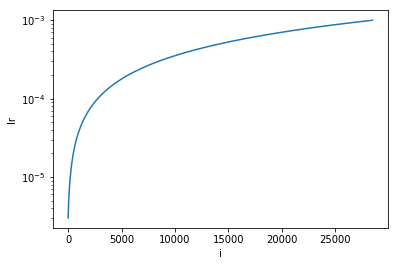

In [20]:
lrf.lr_graph()

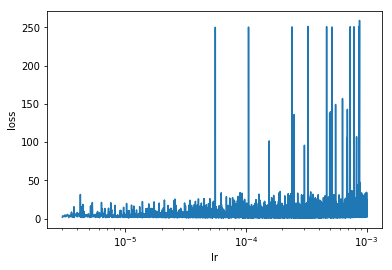

In [21]:
lrf.loss_graph()

In [20]:
schedule = SGDRScheduler(min_lr=3e-5,
                         max_lr=5e-4,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                         lr_decay=0.9,
                         cycle_length=2,
                         mult_factor=1.5)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,
                    verbose=1,
                    callbacks=[checkpoint, schedule],
                    shuffle=True)

Epoch 1/1000


  193/11000 [..............................] - ETA: 1:53:43 - loss: 50.8706 - mIoU: 0.59 - ETA: 1:42:06 - loss: 53.1928 - mIoU: 0.58 - ETA: 1:26:38 - loss: 49.4184 - mIoU: 0.59 - ETA: 1:18:38 - loss: 48.6856 - mIoU: 0.59 - ETA: 1:13:52 - loss: 47.7961 - mIoU: 0.60 - ETA: 1:10:37 - loss: 46.4923 - mIoU: 0.60 - ETA: 1:08:47 - loss: 44.9528 - mIoU: 0.61 - ETA: 1:06:57 - loss: 44.0301 - mIoU: 0.61 - ETA: 1:05:23 - loss: 42.9068 - mIoU: 0.62 - ETA: 1:04:09 - loss: 42.1185 - mIoU: 0.62 - ETA: 1:03:12 - loss: 41.3536 - mIoU: 0.63 - ETA: 1:02:26 - loss: 41.0868 - mIoU: 0.62 - ETA: 1:01:47 - loss: 40.4988 - mIoU: 0.62 - ETA: 1:01:11 - loss: 40.3859 - mIoU: 0.62 - ETA: 1:00:38 - loss: 39.5794 - mIoU: 0.63 - ETA: 1:00:10 - loss: 39.1541 - mIoU: 0.63 - ETA: 59:45 - loss: 39.0301 - mIoU: 0.6415 - ETA: 59:23 - loss: 39.2546 - mIoU: 0.64 - ETA: 59:05 - loss: 39.3115 - mIoU: 0.64 - ETA: 58:50 - loss: 39.5148 - mIoU: 0.63 - ETA: 58:38 - loss: 39.3318 - mIoU: 0.63 - ETA: 58:24 - loss: 39.4688 - mIoU: 0.

  387/11000 [>.............................] - ETA: 55:43 - loss: 34.7510 - mIoU: 0.68 - ETA: 55:42 - loss: 34.7764 - mIoU: 0.68 - ETA: 55:42 - loss: 34.7243 - mIoU: 0.68 - ETA: 55:41 - loss: 34.7387 - mIoU: 0.68 - ETA: 55:41 - loss: 34.7510 - mIoU: 0.68 - ETA: 55:45 - loss: 34.7615 - mIoU: 0.68 - ETA: 55:50 - loss: 34.7534 - mIoU: 0.68 - ETA: 55:49 - loss: 34.6956 - mIoU: 0.68 - ETA: 55:48 - loss: 34.7223 - mIoU: 0.68 - ETA: 55:48 - loss: 34.7339 - mIoU: 0.68 - ETA: 55:47 - loss: 34.7294 - mIoU: 0.68 - ETA: 55:47 - loss: 34.7047 - mIoU: 0.68 - ETA: 55:46 - loss: 34.7424 - mIoU: 0.68 - ETA: 55:45 - loss: 34.7667 - mIoU: 0.68 - ETA: 55:44 - loss: 34.7380 - mIoU: 0.68 - ETA: 55:43 - loss: 34.7427 - mIoU: 0.68 - ETA: 55:43 - loss: 34.7390 - mIoU: 0.68 - ETA: 55:42 - loss: 34.7522 - mIoU: 0.68 - ETA: 55:41 - loss: 34.7341 - mIoU: 0.68 - ETA: 55:41 - loss: 34.6913 - mIoU: 0.68 - ETA: 55:40 - loss: 34.7689 - mIoU: 0.68 - ETA: 55:40 - loss: 34.7489 - mIoU: 0.68 - ETA: 55:38 - loss: 34.6944 - 

  581/11000 [>.............................] - ETA: 54:04 - loss: 31.9966 - mIoU: 0.70 - ETA: 54:04 - loss: 31.9736 - mIoU: 0.70 - ETA: 54:03 - loss: 31.9525 - mIoU: 0.70 - ETA: 54:03 - loss: 31.9494 - mIoU: 0.70 - ETA: 54:02 - loss: 31.9295 - mIoU: 0.70 - ETA: 54:02 - loss: 31.9117 - mIoU: 0.70 - ETA: 54:02 - loss: 31.8844 - mIoU: 0.70 - ETA: 54:01 - loss: 31.8481 - mIoU: 0.70 - ETA: 54:01 - loss: 31.8745 - mIoU: 0.70 - ETA: 54:00 - loss: 31.8497 - mIoU: 0.70 - ETA: 54:00 - loss: 31.8225 - mIoU: 0.70 - ETA: 54:00 - loss: 31.8268 - mIoU: 0.70 - ETA: 53:59 - loss: 31.8199 - mIoU: 0.70 - ETA: 53:59 - loss: 31.8039 - mIoU: 0.70 - ETA: 53:58 - loss: 31.7896 - mIoU: 0.70 - ETA: 53:58 - loss: 31.7558 - mIoU: 0.70 - ETA: 53:57 - loss: 31.7382 - mIoU: 0.70 - ETA: 53:57 - loss: 31.7294 - mIoU: 0.70 - ETA: 53:56 - loss: 31.7755 - mIoU: 0.70 - ETA: 53:56 - loss: 31.7476 - mIoU: 0.70 - ETA: 53:55 - loss: 31.7707 - mIoU: 0.70 - ETA: 53:55 - loss: 31.7814 - mIoU: 0.70 - ETA: 53:54 - loss: 31.7479 - 

  775/11000 [=>............................] - ETA: 52:42 - loss: 30.1416 - mIoU: 0.71 - ETA: 52:42 - loss: 30.1513 - mIoU: 0.71 - ETA: 52:41 - loss: 30.1643 - mIoU: 0.71 - ETA: 52:41 - loss: 30.1548 - mIoU: 0.71 - ETA: 52:40 - loss: 30.1448 - mIoU: 0.71 - ETA: 52:40 - loss: 30.1243 - mIoU: 0.71 - ETA: 52:40 - loss: 30.1281 - mIoU: 0.71 - ETA: 52:40 - loss: 30.1622 - mIoU: 0.71 - ETA: 52:39 - loss: 30.1613 - mIoU: 0.71 - ETA: 52:39 - loss: 30.1572 - mIoU: 0.71 - ETA: 52:39 - loss: 30.1401 - mIoU: 0.71 - ETA: 52:38 - loss: 30.1311 - mIoU: 0.71 - ETA: 52:38 - loss: 30.1264 - mIoU: 0.71 - ETA: 52:37 - loss: 30.1241 - mIoU: 0.71 - ETA: 52:37 - loss: 30.1183 - mIoU: 0.71 - ETA: 52:36 - loss: 30.1080 - mIoU: 0.71 - ETA: 52:36 - loss: 30.1092 - mIoU: 0.71 - ETA: 52:35 - loss: 30.1061 - mIoU: 0.71 - ETA: 52:35 - loss: 30.1272 - mIoU: 0.71 - ETA: 52:35 - loss: 30.1126 - mIoU: 0.71 - ETA: 52:34 - loss: 30.1156 - mIoU: 0.71 - ETA: 52:34 - loss: 30.0989 - mIoU: 0.71 - ETA: 52:33 - loss: 30.0836 - 

  969/11000 [=>............................] - ETA: 51:27 - loss: 29.1160 - mIoU: 0.72 - ETA: 51:26 - loss: 29.1079 - mIoU: 0.72 - ETA: 51:26 - loss: 29.1227 - mIoU: 0.72 - ETA: 51:25 - loss: 29.1143 - mIoU: 0.72 - ETA: 51:25 - loss: 29.1185 - mIoU: 0.72 - ETA: 51:25 - loss: 29.1029 - mIoU: 0.72 - ETA: 51:25 - loss: 29.1054 - mIoU: 0.72 - ETA: 51:24 - loss: 29.0919 - mIoU: 0.72 - ETA: 51:24 - loss: 29.0813 - mIoU: 0.72 - ETA: 51:24 - loss: 29.0831 - mIoU: 0.72 - ETA: 51:23 - loss: 29.0798 - mIoU: 0.72 - ETA: 51:23 - loss: 29.0776 - mIoU: 0.72 - ETA: 51:22 - loss: 29.0610 - mIoU: 0.72 - ETA: 51:22 - loss: 29.0645 - mIoU: 0.72 - ETA: 51:22 - loss: 29.0624 - mIoU: 0.72 - ETA: 51:21 - loss: 29.0528 - mIoU: 0.72 - ETA: 51:21 - loss: 29.0395 - mIoU: 0.72 - ETA: 51:21 - loss: 29.0297 - mIoU: 0.72 - ETA: 51:20 - loss: 29.0257 - mIoU: 0.72 - ETA: 51:20 - loss: 29.0280 - mIoU: 0.72 - ETA: 51:19 - loss: 29.0112 - mIoU: 0.72 - ETA: 51:19 - loss: 28.9948 - mIoU: 0.72 - ETA: 51:19 - loss: 28.9819 - 

 1163/11000 [==>...........................] - ETA: 50:26 - loss: 28.4828 - mIoU: 0.72 - ETA: 50:26 - loss: 28.4806 - mIoU: 0.72 - ETA: 50:26 - loss: 28.4768 - mIoU: 0.72 - ETA: 50:25 - loss: 28.4851 - mIoU: 0.72 - ETA: 50:25 - loss: 28.4770 - mIoU: 0.72 - ETA: 50:25 - loss: 28.4884 - mIoU: 0.72 - ETA: 50:25 - loss: 28.4954 - mIoU: 0.72 - ETA: 50:24 - loss: 28.4961 - mIoU: 0.72 - ETA: 50:24 - loss: 28.4914 - mIoU: 0.72 - ETA: 50:24 - loss: 28.4857 - mIoU: 0.72 - ETA: 50:23 - loss: 28.4809 - mIoU: 0.72 - ETA: 50:23 - loss: 28.4782 - mIoU: 0.72 - ETA: 50:23 - loss: 28.4838 - mIoU: 0.72 - ETA: 50:23 - loss: 28.4797 - mIoU: 0.72 - ETA: 50:22 - loss: 28.4710 - mIoU: 0.72 - ETA: 50:22 - loss: 28.4607 - mIoU: 0.72 - ETA: 50:22 - loss: 28.4514 - mIoU: 0.72 - ETA: 50:22 - loss: 28.4471 - mIoU: 0.72 - ETA: 50:21 - loss: 28.4434 - mIoU: 0.72 - ETA: 50:21 - loss: 28.4340 - mIoU: 0.72 - ETA: 50:21 - loss: 28.4340 - mIoU: 0.72 - ETA: 50:21 - loss: 28.4199 - mIoU: 0.72 - ETA: 50:20 - loss: 28.4205 - 

 1357/11000 [==>...........................] - ETA: 49:31 - loss: 27.7778 - mIoU: 0.73 - ETA: 49:30 - loss: 27.7815 - mIoU: 0.73 - ETA: 49:30 - loss: 27.7781 - mIoU: 0.73 - ETA: 49:30 - loss: 27.7687 - mIoU: 0.73 - ETA: 49:29 - loss: 27.7571 - mIoU: 0.73 - ETA: 49:29 - loss: 27.7589 - mIoU: 0.73 - ETA: 49:29 - loss: 27.7515 - mIoU: 0.73 - ETA: 49:29 - loss: 27.7563 - mIoU: 0.73 - ETA: 49:28 - loss: 27.7646 - mIoU: 0.73 - ETA: 49:28 - loss: 27.7616 - mIoU: 0.73 - ETA: 49:28 - loss: 27.7651 - mIoU: 0.73 - ETA: 49:28 - loss: 27.7661 - mIoU: 0.73 - ETA: 49:27 - loss: 27.7628 - mIoU: 0.73 - ETA: 49:27 - loss: 27.7600 - mIoU: 0.73 - ETA: 49:27 - loss: 27.7555 - mIoU: 0.73 - ETA: 49:27 - loss: 27.7595 - mIoU: 0.73 - ETA: 49:26 - loss: 27.7691 - mIoU: 0.73 - ETA: 49:26 - loss: 27.7608 - mIoU: 0.73 - ETA: 49:26 - loss: 27.7616 - mIoU: 0.73 - ETA: 49:25 - loss: 27.7531 - mIoU: 0.73 - ETA: 49:25 - loss: 27.7458 - mIoU: 0.73 - ETA: 49:25 - loss: 27.7358 - mIoU: 0.73 - ETA: 49:24 - loss: 27.7280 - 

 1551/11000 [===>..........................] - ETA: 48:32 - loss: 27.1470 - mIoU: 0.74 - ETA: 48:31 - loss: 27.1389 - mIoU: 0.74 - ETA: 48:31 - loss: 27.1387 - mIoU: 0.74 - ETA: 48:31 - loss: 27.1296 - mIoU: 0.74 - ETA: 48:30 - loss: 27.1221 - mIoU: 0.74 - ETA: 48:30 - loss: 27.1211 - mIoU: 0.74 - ETA: 48:30 - loss: 27.1221 - mIoU: 0.74 - ETA: 48:29 - loss: 27.1227 - mIoU: 0.74 - ETA: 48:29 - loss: 27.1162 - mIoU: 0.74 - ETA: 48:29 - loss: 27.1178 - mIoU: 0.74 - ETA: 48:28 - loss: 27.1132 - mIoU: 0.74 - ETA: 48:28 - loss: 27.1069 - mIoU: 0.74 - ETA: 48:28 - loss: 27.1037 - mIoU: 0.74 - ETA: 48:27 - loss: 27.1034 - mIoU: 0.74 - ETA: 48:27 - loss: 27.0986 - mIoU: 0.74 - ETA: 48:27 - loss: 27.0923 - mIoU: 0.74 - ETA: 48:27 - loss: 27.0840 - mIoU: 0.74 - ETA: 48:26 - loss: 27.0793 - mIoU: 0.74 - ETA: 48:26 - loss: 27.0767 - mIoU: 0.74 - ETA: 48:26 - loss: 27.0724 - mIoU: 0.74 - ETA: 48:25 - loss: 27.0793 - mIoU: 0.74 - ETA: 48:25 - loss: 27.0802 - mIoU: 0.74 - ETA: 48:25 - loss: 27.0911 - 

 1745/11000 [===>..........................] - ETA: 47:30 - loss: 26.7784 - mIoU: 0.74 - ETA: 47:29 - loss: 26.7780 - mIoU: 0.74 - ETA: 47:29 - loss: 26.7739 - mIoU: 0.74 - ETA: 47:29 - loss: 26.7704 - mIoU: 0.74 - ETA: 47:28 - loss: 26.7676 - mIoU: 0.74 - ETA: 47:28 - loss: 26.7700 - mIoU: 0.74 - ETA: 47:28 - loss: 26.7755 - mIoU: 0.74 - ETA: 47:28 - loss: 26.7725 - mIoU: 0.74 - ETA: 47:27 - loss: 26.7688 - mIoU: 0.74 - ETA: 47:27 - loss: 26.7697 - mIoU: 0.74 - ETA: 47:27 - loss: 26.7747 - mIoU: 0.74 - ETA: 47:26 - loss: 26.7774 - mIoU: 0.74 - ETA: 47:26 - loss: 26.7781 - mIoU: 0.74 - ETA: 47:26 - loss: 26.7755 - mIoU: 0.74 - ETA: 47:25 - loss: 26.7719 - mIoU: 0.74 - ETA: 47:25 - loss: 26.7744 - mIoU: 0.74 - ETA: 47:25 - loss: 26.7710 - mIoU: 0.74 - ETA: 47:24 - loss: 26.7649 - mIoU: 0.74 - ETA: 47:24 - loss: 26.7602 - mIoU: 0.74 - ETA: 47:24 - loss: 26.7536 - mIoU: 0.74 - ETA: 47:24 - loss: 26.7502 - mIoU: 0.74 - ETA: 47:23 - loss: 26.7441 - mIoU: 0.74 - ETA: 47:23 - loss: 26.7380 - 

 1939/11000 [====>.........................] - ETA: 46:30 - loss: 26.3764 - mIoU: 0.74 - ETA: 46:30 - loss: 26.3758 - mIoU: 0.74 - ETA: 46:30 - loss: 26.3709 - mIoU: 0.74 - ETA: 46:29 - loss: 26.3690 - mIoU: 0.74 - ETA: 46:29 - loss: 26.3641 - mIoU: 0.74 - ETA: 46:29 - loss: 26.3614 - mIoU: 0.74 - ETA: 46:29 - loss: 26.3583 - mIoU: 0.74 - ETA: 46:28 - loss: 26.3561 - mIoU: 0.74 - ETA: 46:28 - loss: 26.3488 - mIoU: 0.74 - ETA: 46:28 - loss: 26.3482 - mIoU: 0.74 - ETA: 46:27 - loss: 26.3448 - mIoU: 0.74 - ETA: 46:27 - loss: 26.3462 - mIoU: 0.74 - ETA: 46:27 - loss: 26.3441 - mIoU: 0.74 - ETA: 46:26 - loss: 26.3438 - mIoU: 0.74 - ETA: 46:26 - loss: 26.3440 - mIoU: 0.74 - ETA: 46:26 - loss: 26.3386 - mIoU: 0.74 - ETA: 46:25 - loss: 26.3318 - mIoU: 0.74 - ETA: 46:25 - loss: 26.3259 - mIoU: 0.74 - ETA: 46:25 - loss: 26.3310 - mIoU: 0.74 - ETA: 46:25 - loss: 26.3269 - mIoU: 0.74 - ETA: 46:24 - loss: 26.3263 - mIoU: 0.74 - ETA: 46:24 - loss: 26.3189 - mIoU: 0.74 - ETA: 46:24 - loss: 26.3155 - 

 2133/11000 [====>.........................] - ETA: 45:28 - loss: 26.0304 - mIoU: 0.74 - ETA: 45:28 - loss: 26.0304 - mIoU: 0.74 - ETA: 45:27 - loss: 26.0294 - mIoU: 0.74 - ETA: 45:27 - loss: 26.0306 - mIoU: 0.74 - ETA: 45:27 - loss: 26.0279 - mIoU: 0.74 - ETA: 45:26 - loss: 26.0251 - mIoU: 0.74 - ETA: 45:26 - loss: 26.0197 - mIoU: 0.74 - ETA: 45:26 - loss: 26.0185 - mIoU: 0.74 - ETA: 45:25 - loss: 26.0125 - mIoU: 0.74 - ETA: 45:25 - loss: 26.0058 - mIoU: 0.74 - ETA: 45:25 - loss: 26.0021 - mIoU: 0.74 - ETA: 45:24 - loss: 26.0007 - mIoU: 0.74 - ETA: 45:24 - loss: 25.9964 - mIoU: 0.74 - ETA: 45:24 - loss: 25.9876 - mIoU: 0.74 - ETA: 45:23 - loss: 25.9891 - mIoU: 0.74 - ETA: 45:23 - loss: 25.9889 - mIoU: 0.74 - ETA: 45:23 - loss: 25.9861 - mIoU: 0.74 - ETA: 45:23 - loss: 25.9898 - mIoU: 0.74 - ETA: 45:22 - loss: 25.9933 - mIoU: 0.74 - ETA: 45:22 - loss: 25.9914 - mIoU: 0.74 - ETA: 45:22 - loss: 25.9904 - mIoU: 0.74 - ETA: 45:21 - loss: 25.9893 - mIoU: 0.74 - ETA: 45:21 - loss: 25.9841 - 

 2327/11000 [=====>........................] - ETA: 44:26 - loss: 25.6537 - mIoU: 0.75 - ETA: 44:26 - loss: 25.6600 - mIoU: 0.75 - ETA: 44:25 - loss: 25.6629 - mIoU: 0.75 - ETA: 44:25 - loss: 25.6663 - mIoU: 0.75 - ETA: 44:25 - loss: 25.6657 - mIoU: 0.75 - ETA: 44:24 - loss: 25.6598 - mIoU: 0.75 - ETA: 44:24 - loss: 25.6576 - mIoU: 0.75 - ETA: 44:24 - loss: 25.6518 - mIoU: 0.75 - ETA: 44:24 - loss: 25.6483 - mIoU: 0.75 - ETA: 44:23 - loss: 25.6506 - mIoU: 0.75 - ETA: 44:23 - loss: 25.6460 - mIoU: 0.75 - ETA: 44:23 - loss: 25.6451 - mIoU: 0.75 - ETA: 44:22 - loss: 25.6403 - mIoU: 0.75 - ETA: 44:22 - loss: 25.6364 - mIoU: 0.75 - ETA: 44:22 - loss: 25.6368 - mIoU: 0.75 - ETA: 44:21 - loss: 25.6373 - mIoU: 0.75 - ETA: 44:21 - loss: 25.6396 - mIoU: 0.75 - ETA: 44:21 - loss: 25.6387 - mIoU: 0.75 - ETA: 44:21 - loss: 25.6394 - mIoU: 0.75 - ETA: 44:20 - loss: 25.6344 - mIoU: 0.75 - ETA: 44:20 - loss: 25.6338 - mIoU: 0.75 - ETA: 44:20 - loss: 25.6326 - mIoU: 0.75 - ETA: 44:19 - loss: 25.6326 - 

 2521/11000 [=====>........................] - ETA: 43:26 - loss: 25.2913 - mIoU: 0.75 - ETA: 43:25 - loss: 25.2882 - mIoU: 0.75 - ETA: 43:25 - loss: 25.2860 - mIoU: 0.75 - ETA: 43:25 - loss: 25.2933 - mIoU: 0.75 - ETA: 43:25 - loss: 25.2902 - mIoU: 0.75 - ETA: 43:24 - loss: 25.2868 - mIoU: 0.75 - ETA: 43:24 - loss: 25.2833 - mIoU: 0.75 - ETA: 43:24 - loss: 25.2813 - mIoU: 0.75 - ETA: 43:23 - loss: 25.2804 - mIoU: 0.75 - ETA: 43:23 - loss: 25.2826 - mIoU: 0.75 - ETA: 43:23 - loss: 25.2810 - mIoU: 0.75 - ETA: 43:22 - loss: 25.2775 - mIoU: 0.75 - ETA: 43:22 - loss: 25.2773 - mIoU: 0.75 - ETA: 43:22 - loss: 25.2760 - mIoU: 0.75 - ETA: 43:22 - loss: 25.2717 - mIoU: 0.75 - ETA: 43:21 - loss: 25.2684 - mIoU: 0.75 - ETA: 43:21 - loss: 25.2640 - mIoU: 0.75 - ETA: 43:21 - loss: 25.2604 - mIoU: 0.75 - ETA: 43:20 - loss: 25.2576 - mIoU: 0.75 - ETA: 43:20 - loss: 25.2550 - mIoU: 0.75 - ETA: 43:20 - loss: 25.2555 - mIoU: 0.75 - ETA: 43:19 - loss: 25.2504 - mIoU: 0.75 - ETA: 43:19 - loss: 25.2461 - 

 2715/11000 [======>.......................] - ETA: 42:27 - loss: 24.9953 - mIoU: 0.75 - ETA: 42:26 - loss: 24.9904 - mIoU: 0.75 - ETA: 42:26 - loss: 24.9892 - mIoU: 0.75 - ETA: 42:26 - loss: 24.9867 - mIoU: 0.75 - ETA: 42:25 - loss: 24.9845 - mIoU: 0.75 - ETA: 42:25 - loss: 24.9837 - mIoU: 0.75 - ETA: 42:25 - loss: 24.9814 - mIoU: 0.75 - ETA: 42:24 - loss: 24.9777 - mIoU: 0.75 - ETA: 42:24 - loss: 24.9760 - mIoU: 0.75 - ETA: 42:24 - loss: 24.9754 - mIoU: 0.75 - ETA: 42:23 - loss: 24.9711 - mIoU: 0.75 - ETA: 42:23 - loss: 24.9761 - mIoU: 0.75 - ETA: 42:23 - loss: 24.9739 - mIoU: 0.75 - ETA: 42:22 - loss: 24.9699 - mIoU: 0.75 - ETA: 42:22 - loss: 24.9681 - mIoU: 0.75 - ETA: 42:22 - loss: 24.9635 - mIoU: 0.75 - ETA: 42:22 - loss: 24.9611 - mIoU: 0.75 - ETA: 42:21 - loss: 24.9562 - mIoU: 0.75 - ETA: 42:21 - loss: 24.9554 - mIoU: 0.75 - ETA: 42:21 - loss: 24.9581 - mIoU: 0.75 - ETA: 42:20 - loss: 24.9535 - mIoU: 0.75 - ETA: 42:20 - loss: 24.9560 - mIoU: 0.75 - ETA: 42:20 - loss: 24.9611 - 

 2909/11000 [======>.......................] - ETA: 41:27 - loss: 24.6865 - mIoU: 0.75 - ETA: 41:26 - loss: 24.6813 - mIoU: 0.75 - ETA: 41:26 - loss: 24.6825 - mIoU: 0.75 - ETA: 41:26 - loss: 24.6803 - mIoU: 0.75 - ETA: 41:25 - loss: 24.6767 - mIoU: 0.75 - ETA: 41:25 - loss: 24.6751 - mIoU: 0.75 - ETA: 41:25 - loss: 24.6776 - mIoU: 0.75 - ETA: 41:24 - loss: 24.6747 - mIoU: 0.75 - ETA: 41:24 - loss: 24.6770 - mIoU: 0.75 - ETA: 41:24 - loss: 24.6831 - mIoU: 0.75 - ETA: 41:24 - loss: 24.6803 - mIoU: 0.75 - ETA: 41:23 - loss: 24.6798 - mIoU: 0.75 - ETA: 41:23 - loss: 24.6779 - mIoU: 0.75 - ETA: 41:23 - loss: 24.6796 - mIoU: 0.75 - ETA: 41:22 - loss: 24.6794 - mIoU: 0.75 - ETA: 41:22 - loss: 24.6776 - mIoU: 0.75 - ETA: 41:22 - loss: 24.6764 - mIoU: 0.75 - ETA: 41:21 - loss: 24.6745 - mIoU: 0.75 - ETA: 41:21 - loss: 24.6800 - mIoU: 0.75 - ETA: 41:21 - loss: 24.6770 - mIoU: 0.75 - ETA: 41:20 - loss: 24.6785 - mIoU: 0.75 - ETA: 41:20 - loss: 24.6771 - mIoU: 0.75 - ETA: 41:20 - loss: 24.6777 - 

 3103/11000 [=======>......................] - ETA: 40:27 - loss: 24.3760 - mIoU: 0.76 - ETA: 40:27 - loss: 24.3713 - mIoU: 0.76 - ETA: 40:26 - loss: 24.3685 - mIoU: 0.76 - ETA: 40:26 - loss: 24.3673 - mIoU: 0.76 - ETA: 40:26 - loss: 24.3651 - mIoU: 0.76 - ETA: 40:25 - loss: 24.3669 - mIoU: 0.76 - ETA: 40:25 - loss: 24.3643 - mIoU: 0.76 - ETA: 40:25 - loss: 24.3613 - mIoU: 0.76 - ETA: 40:24 - loss: 24.3578 - mIoU: 0.76 - ETA: 40:24 - loss: 24.3621 - mIoU: 0.76 - ETA: 40:24 - loss: 24.3607 - mIoU: 0.76 - ETA: 40:23 - loss: 24.3643 - mIoU: 0.76 - ETA: 40:23 - loss: 24.3609 - mIoU: 0.76 - ETA: 40:23 - loss: 24.3593 - mIoU: 0.76 - ETA: 40:23 - loss: 24.3567 - mIoU: 0.76 - ETA: 40:22 - loss: 24.3540 - mIoU: 0.76 - ETA: 40:22 - loss: 24.3524 - mIoU: 0.76 - ETA: 40:22 - loss: 24.3495 - mIoU: 0.76 - ETA: 40:21 - loss: 24.3484 - mIoU: 0.76 - ETA: 40:21 - loss: 24.3501 - mIoU: 0.76 - ETA: 40:21 - loss: 24.3481 - mIoU: 0.76 - ETA: 40:20 - loss: 24.3453 - mIoU: 0.76 - ETA: 40:20 - loss: 24.3428 - 

 3297/11000 [=======>......................] - ETA: 39:28 - loss: 24.0297 - mIoU: 0.76 - ETA: 39:27 - loss: 24.0266 - mIoU: 0.76 - ETA: 39:27 - loss: 24.0234 - mIoU: 0.76 - ETA: 39:27 - loss: 24.0212 - mIoU: 0.76 - ETA: 39:27 - loss: 24.0221 - mIoU: 0.76 - ETA: 39:26 - loss: 24.0194 - mIoU: 0.76 - ETA: 39:26 - loss: 24.0146 - mIoU: 0.76 - ETA: 39:26 - loss: 24.0143 - mIoU: 0.76 - ETA: 39:25 - loss: 24.0133 - mIoU: 0.76 - ETA: 39:25 - loss: 24.0121 - mIoU: 0.76 - ETA: 39:25 - loss: 24.0138 - mIoU: 0.76 - ETA: 39:24 - loss: 24.0125 - mIoU: 0.76 - ETA: 39:24 - loss: 24.0092 - mIoU: 0.76 - ETA: 39:24 - loss: 24.0101 - mIoU: 0.76 - ETA: 39:23 - loss: 24.0061 - mIoU: 0.76 - ETA: 39:23 - loss: 24.0026 - mIoU: 0.76 - ETA: 39:23 - loss: 24.0023 - mIoU: 0.76 - ETA: 39:23 - loss: 24.0022 - mIoU: 0.76 - ETA: 39:22 - loss: 23.9990 - mIoU: 0.76 - ETA: 39:22 - loss: 23.9958 - mIoU: 0.76 - ETA: 39:22 - loss: 23.9925 - mIoU: 0.76 - ETA: 39:21 - loss: 23.9904 - mIoU: 0.76 - ETA: 39:21 - loss: 23.9883 - 

 3491/11000 [========>.....................] - ETA: 38:29 - loss: 23.7393 - mIoU: 0.76 - ETA: 38:28 - loss: 23.7368 - mIoU: 0.76 - ETA: 38:28 - loss: 23.7359 - mIoU: 0.76 - ETA: 38:28 - loss: 23.7333 - mIoU: 0.76 - ETA: 38:27 - loss: 23.7339 - mIoU: 0.76 - ETA: 38:27 - loss: 23.7334 - mIoU: 0.76 - ETA: 38:27 - loss: 23.7334 - mIoU: 0.76 - ETA: 38:26 - loss: 23.7310 - mIoU: 0.76 - ETA: 38:26 - loss: 23.7286 - mIoU: 0.76 - ETA: 38:26 - loss: 23.7261 - mIoU: 0.76 - ETA: 38:26 - loss: 23.7277 - mIoU: 0.76 - ETA: 38:25 - loss: 23.7253 - mIoU: 0.76 - ETA: 38:25 - loss: 23.7227 - mIoU: 0.76 - ETA: 38:25 - loss: 23.7206 - mIoU: 0.76 - ETA: 38:24 - loss: 23.7180 - mIoU: 0.76 - ETA: 38:24 - loss: 23.7147 - mIoU: 0.76 - ETA: 38:24 - loss: 23.7126 - mIoU: 0.76 - ETA: 38:23 - loss: 23.7122 - mIoU: 0.76 - ETA: 38:23 - loss: 23.7126 - mIoU: 0.76 - ETA: 38:23 - loss: 23.7146 - mIoU: 0.76 - ETA: 38:23 - loss: 23.7118 - mIoU: 0.76 - ETA: 38:22 - loss: 23.7079 - mIoU: 0.76 - ETA: 38:22 - loss: 23.7082 - 

 3685/11000 [=========>....................] - ETA: 37:30 - loss: 23.5086 - mIoU: 0.76 - ETA: 37:29 - loss: 23.5058 - mIoU: 0.76 - ETA: 37:29 - loss: 23.5035 - mIoU: 0.76 - ETA: 37:29 - loss: 23.5007 - mIoU: 0.76 - ETA: 37:28 - loss: 23.4977 - mIoU: 0.76 - ETA: 37:28 - loss: 23.4962 - mIoU: 0.76 - ETA: 37:28 - loss: 23.4989 - mIoU: 0.76 - ETA: 37:27 - loss: 23.4976 - mIoU: 0.76 - ETA: 37:27 - loss: 23.4943 - mIoU: 0.76 - ETA: 37:27 - loss: 23.4928 - mIoU: 0.76 - ETA: 37:26 - loss: 23.4891 - mIoU: 0.76 - ETA: 37:26 - loss: 23.4876 - mIoU: 0.76 - ETA: 37:26 - loss: 23.4887 - mIoU: 0.76 - ETA: 37:26 - loss: 23.4849 - mIoU: 0.76 - ETA: 37:25 - loss: 23.4816 - mIoU: 0.76 - ETA: 37:25 - loss: 23.4792 - mIoU: 0.76 - ETA: 37:25 - loss: 23.4797 - mIoU: 0.76 - ETA: 37:24 - loss: 23.4769 - mIoU: 0.76 - ETA: 37:24 - loss: 23.4740 - mIoU: 0.76 - ETA: 37:24 - loss: 23.4737 - mIoU: 0.76 - ETA: 37:23 - loss: 23.4701 - mIoU: 0.76 - ETA: 37:23 - loss: 23.4692 - mIoU: 0.76 - ETA: 37:23 - loss: 23.4661 - 

 3879/11000 [=========>....................] - ETA: 36:30 - loss: 23.2066 - mIoU: 0.77 - ETA: 36:30 - loss: 23.2061 - mIoU: 0.77 - ETA: 36:30 - loss: 23.2047 - mIoU: 0.77 - ETA: 36:29 - loss: 23.2040 - mIoU: 0.77 - ETA: 36:29 - loss: 23.2042 - mIoU: 0.77 - ETA: 36:29 - loss: 23.2054 - mIoU: 0.77 - ETA: 36:29 - loss: 23.2032 - mIoU: 0.77 - ETA: 36:28 - loss: 23.2007 - mIoU: 0.77 - ETA: 36:28 - loss: 23.1981 - mIoU: 0.77 - ETA: 36:28 - loss: 23.1995 - mIoU: 0.77 - ETA: 36:27 - loss: 23.1976 - mIoU: 0.77 - ETA: 36:27 - loss: 23.1940 - mIoU: 0.77 - ETA: 36:27 - loss: 23.1912 - mIoU: 0.77 - ETA: 36:26 - loss: 23.1939 - mIoU: 0.77 - ETA: 36:26 - loss: 23.1965 - mIoU: 0.77 - ETA: 36:26 - loss: 23.1951 - mIoU: 0.77 - ETA: 36:25 - loss: 23.1935 - mIoU: 0.77 - ETA: 36:25 - loss: 23.1957 - mIoU: 0.77 - ETA: 36:25 - loss: 23.1935 - mIoU: 0.77 - ETA: 36:25 - loss: 23.1911 - mIoU: 0.77 - ETA: 36:24 - loss: 23.1884 - mIoU: 0.77 - ETA: 36:24 - loss: 23.1864 - mIoU: 0.77 - ETA: 36:24 - loss: 23.1868 - 

 4073/11000 [==========>...................] - ETA: 35:31 - loss: 22.9991 - mIoU: 0.77 - ETA: 35:31 - loss: 22.9996 - mIoU: 0.77 - ETA: 35:31 - loss: 23.0006 - mIoU: 0.77 - ETA: 35:30 - loss: 23.0015 - mIoU: 0.77 - ETA: 35:30 - loss: 22.9996 - mIoU: 0.77 - ETA: 35:30 - loss: 22.9966 - mIoU: 0.77 - ETA: 35:29 - loss: 22.9992 - mIoU: 0.77 - ETA: 35:29 - loss: 22.9963 - mIoU: 0.77 - ETA: 35:29 - loss: 22.9936 - mIoU: 0.77 - ETA: 35:29 - loss: 22.9910 - mIoU: 0.77 - ETA: 35:28 - loss: 22.9888 - mIoU: 0.77 - ETA: 35:28 - loss: 22.9880 - mIoU: 0.77 - ETA: 35:28 - loss: 22.9865 - mIoU: 0.77 - ETA: 35:27 - loss: 22.9856 - mIoU: 0.77 - ETA: 35:27 - loss: 22.9854 - mIoU: 0.77 - ETA: 35:27 - loss: 22.9894 - mIoU: 0.77 - ETA: 35:27 - loss: 22.9885 - mIoU: 0.77 - ETA: 35:26 - loss: 22.9869 - mIoU: 0.77 - ETA: 35:26 - loss: 22.9865 - mIoU: 0.77 - ETA: 35:26 - loss: 22.9836 - mIoU: 0.77 - ETA: 35:25 - loss: 22.9837 - mIoU: 0.77 - ETA: 35:25 - loss: 22.9861 - mIoU: 0.77 - ETA: 35:25 - loss: 22.9844 - 

 4267/11000 [==========>...................] - ETA: 34:33 - loss: 22.8106 - mIoU: 0.77 - ETA: 34:33 - loss: 22.8092 - mIoU: 0.77 - ETA: 34:32 - loss: 22.8122 - mIoU: 0.77 - ETA: 34:32 - loss: 22.8108 - mIoU: 0.77 - ETA: 34:32 - loss: 22.8108 - mIoU: 0.77 - ETA: 34:31 - loss: 22.8076 - mIoU: 0.77 - ETA: 34:31 - loss: 22.8071 - mIoU: 0.77 - ETA: 34:31 - loss: 22.8084 - mIoU: 0.77 - ETA: 34:31 - loss: 22.8059 - mIoU: 0.77 - ETA: 34:30 - loss: 22.8059 - mIoU: 0.77 - ETA: 34:30 - loss: 22.8051 - mIoU: 0.77 - ETA: 34:30 - loss: 22.8026 - mIoU: 0.77 - ETA: 34:29 - loss: 22.7999 - mIoU: 0.77 - ETA: 34:29 - loss: 22.8016 - mIoU: 0.77 - ETA: 34:29 - loss: 22.8009 - mIoU: 0.77 - ETA: 34:29 - loss: 22.8047 - mIoU: 0.77 - ETA: 34:28 - loss: 22.8029 - mIoU: 0.77 - ETA: 34:28 - loss: 22.8010 - mIoU: 0.77 - ETA: 34:28 - loss: 22.7979 - mIoU: 0.77 - ETA: 34:27 - loss: 22.7956 - mIoU: 0.77 - ETA: 34:27 - loss: 22.7946 - mIoU: 0.77 - ETA: 34:27 - loss: 22.7932 - mIoU: 0.77 - ETA: 34:26 - loss: 22.7951 - 

 4461/11000 [===========>..................] - ETA: 33:35 - loss: 22.5562 - mIoU: 0.77 - ETA: 33:34 - loss: 22.5564 - mIoU: 0.77 - ETA: 33:34 - loss: 22.5543 - mIoU: 0.77 - ETA: 33:34 - loss: 22.5526 - mIoU: 0.77 - ETA: 33:34 - loss: 22.5509 - mIoU: 0.77 - ETA: 33:33 - loss: 22.5486 - mIoU: 0.77 - ETA: 33:33 - loss: 22.5471 - mIoU: 0.77 - ETA: 33:33 - loss: 22.5445 - mIoU: 0.77 - ETA: 33:32 - loss: 22.5435 - mIoU: 0.77 - ETA: 33:32 - loss: 22.5431 - mIoU: 0.77 - ETA: 33:32 - loss: 22.5433 - mIoU: 0.77 - ETA: 33:31 - loss: 22.5423 - mIoU: 0.77 - ETA: 33:31 - loss: 22.5406 - mIoU: 0.77 - ETA: 33:31 - loss: 22.5395 - mIoU: 0.77 - ETA: 33:30 - loss: 22.5395 - mIoU: 0.77 - ETA: 33:30 - loss: 22.5382 - mIoU: 0.77 - ETA: 33:30 - loss: 22.5355 - mIoU: 0.77 - ETA: 33:30 - loss: 22.5337 - mIoU: 0.77 - ETA: 33:29 - loss: 22.5310 - mIoU: 0.77 - ETA: 33:29 - loss: 22.5290 - mIoU: 0.77 - ETA: 33:29 - loss: 22.5280 - mIoU: 0.77 - ETA: 33:28 - loss: 22.5292 - mIoU: 0.77 - ETA: 33:28 - loss: 22.5279 - 

 4655/11000 [===========>..................] - ETA: 32:36 - loss: 22.3043 - mIoU: 0.77 - ETA: 32:36 - loss: 22.3034 - mIoU: 0.77 - ETA: 32:36 - loss: 22.3007 - mIoU: 0.77 - ETA: 32:36 - loss: 22.2979 - mIoU: 0.77 - ETA: 32:35 - loss: 22.2963 - mIoU: 0.77 - ETA: 32:35 - loss: 22.2961 - mIoU: 0.77 - ETA: 32:35 - loss: 22.2950 - mIoU: 0.77 - ETA: 32:34 - loss: 22.2943 - mIoU: 0.77 - ETA: 32:34 - loss: 22.2929 - mIoU: 0.77 - ETA: 32:34 - loss: 22.2920 - mIoU: 0.77 - ETA: 32:33 - loss: 22.2908 - mIoU: 0.77 - ETA: 32:33 - loss: 22.2909 - mIoU: 0.77 - ETA: 32:33 - loss: 22.2892 - mIoU: 0.77 - ETA: 32:33 - loss: 22.2871 - mIoU: 0.77 - ETA: 32:32 - loss: 22.2877 - mIoU: 0.77 - ETA: 32:32 - loss: 22.2880 - mIoU: 0.77 - ETA: 32:32 - loss: 22.2855 - mIoU: 0.77 - ETA: 32:31 - loss: 22.2839 - mIoU: 0.77 - ETA: 32:31 - loss: 22.2818 - mIoU: 0.77 - ETA: 32:31 - loss: 22.2794 - mIoU: 0.77 - ETA: 32:30 - loss: 22.2780 - mIoU: 0.77 - ETA: 32:30 - loss: 22.2784 - mIoU: 0.77 - ETA: 32:30 - loss: 22.2777 - 

 4849/11000 [============>.................] - ETA: 31:38 - loss: 22.1285 - mIoU: 0.78 - ETA: 31:38 - loss: 22.1282 - mIoU: 0.78 - ETA: 31:37 - loss: 22.1271 - mIoU: 0.78 - ETA: 31:37 - loss: 22.1255 - mIoU: 0.78 - ETA: 31:37 - loss: 22.1238 - mIoU: 0.78 - ETA: 31:36 - loss: 22.1213 - mIoU: 0.78 - ETA: 31:36 - loss: 22.1206 - mIoU: 0.78 - ETA: 31:36 - loss: 22.1194 - mIoU: 0.78 - ETA: 31:36 - loss: 22.1202 - mIoU: 0.78 - ETA: 31:35 - loss: 22.1217 - mIoU: 0.78 - ETA: 31:35 - loss: 22.1212 - mIoU: 0.78 - ETA: 31:35 - loss: 22.1207 - mIoU: 0.78 - ETA: 31:34 - loss: 22.1223 - mIoU: 0.78 - ETA: 31:34 - loss: 22.1209 - mIoU: 0.78 - ETA: 31:34 - loss: 22.1186 - mIoU: 0.78 - ETA: 31:33 - loss: 22.1173 - mIoU: 0.78 - ETA: 31:33 - loss: 22.1197 - mIoU: 0.78 - ETA: 31:33 - loss: 22.1197 - mIoU: 0.78 - ETA: 31:33 - loss: 22.1197 - mIoU: 0.78 - ETA: 31:32 - loss: 22.1189 - mIoU: 0.78 - ETA: 31:32 - loss: 22.1168 - mIoU: 0.78 - ETA: 31:32 - loss: 22.1155 - mIoU: 0.78 - ETA: 31:31 - loss: 22.1156 - 

 5043/11000 [============>.................] - ETA: 30:40 - loss: 21.9366 - mIoU: 0.78 - ETA: 30:39 - loss: 21.9359 - mIoU: 0.78 - ETA: 30:39 - loss: 21.9358 - mIoU: 0.78 - ETA: 30:39 - loss: 21.9344 - mIoU: 0.78 - ETA: 30:38 - loss: 21.9341 - mIoU: 0.78 - ETA: 30:38 - loss: 21.9327 - mIoU: 0.78 - ETA: 30:38 - loss: 21.9310 - mIoU: 0.78 - ETA: 30:37 - loss: 21.9291 - mIoU: 0.78 - ETA: 30:37 - loss: 21.9271 - mIoU: 0.78 - ETA: 30:37 - loss: 21.9246 - mIoU: 0.78 - ETA: 30:36 - loss: 21.9221 - mIoU: 0.78 - ETA: 30:36 - loss: 21.9212 - mIoU: 0.78 - ETA: 30:36 - loss: 21.9189 - mIoU: 0.78 - ETA: 30:36 - loss: 21.9172 - mIoU: 0.78 - ETA: 30:35 - loss: 21.9168 - mIoU: 0.78 - ETA: 30:35 - loss: 21.9152 - mIoU: 0.78 - ETA: 30:35 - loss: 21.9130 - mIoU: 0.78 - ETA: 30:34 - loss: 21.9138 - mIoU: 0.78 - ETA: 30:34 - loss: 21.9127 - mIoU: 0.78 - ETA: 30:34 - loss: 21.9115 - mIoU: 0.78 - ETA: 30:33 - loss: 21.9101 - mIoU: 0.78 - ETA: 30:33 - loss: 21.9096 - mIoU: 0.78 - ETA: 30:33 - loss: 21.9084 - 

 5237/11000 [=============>................] - ETA: 29:42 - loss: 21.7430 - mIoU: 0.78 - ETA: 29:41 - loss: 21.7421 - mIoU: 0.78 - ETA: 29:41 - loss: 21.7437 - mIoU: 0.78 - ETA: 29:41 - loss: 21.7452 - mIoU: 0.78 - ETA: 29:40 - loss: 21.7465 - mIoU: 0.78 - ETA: 29:40 - loss: 21.7457 - mIoU: 0.78 - ETA: 29:40 - loss: 21.7446 - mIoU: 0.78 - ETA: 29:39 - loss: 21.7424 - mIoU: 0.78 - ETA: 29:39 - loss: 21.7416 - mIoU: 0.78 - ETA: 29:39 - loss: 21.7427 - mIoU: 0.78 - ETA: 29:38 - loss: 21.7419 - mIoU: 0.78 - ETA: 29:38 - loss: 21.7403 - mIoU: 0.78 - ETA: 29:38 - loss: 21.7382 - mIoU: 0.78 - ETA: 29:38 - loss: 21.7380 - mIoU: 0.78 - ETA: 29:37 - loss: 21.7367 - mIoU: 0.78 - ETA: 29:37 - loss: 21.7351 - mIoU: 0.78 - ETA: 29:37 - loss: 21.7379 - mIoU: 0.78 - ETA: 29:36 - loss: 21.7375 - mIoU: 0.78 - ETA: 29:36 - loss: 21.7369 - mIoU: 0.78 - ETA: 29:36 - loss: 21.7377 - mIoU: 0.78 - ETA: 29:35 - loss: 21.7357 - mIoU: 0.78 - ETA: 29:35 - loss: 21.7367 - mIoU: 0.78 - ETA: 29:35 - loss: 21.7377 - 

 5431/11000 [=============>................] - ETA: 28:44 - loss: 21.5521 - mIoU: 0.78 - ETA: 28:44 - loss: 21.5510 - mIoU: 0.78 - ETA: 28:43 - loss: 21.5495 - mIoU: 0.78 - ETA: 28:43 - loss: 21.5483 - mIoU: 0.78 - ETA: 28:43 - loss: 21.5464 - mIoU: 0.78 - ETA: 28:42 - loss: 21.5444 - mIoU: 0.78 - ETA: 28:42 - loss: 21.5422 - mIoU: 0.78 - ETA: 28:42 - loss: 21.5421 - mIoU: 0.78 - ETA: 28:41 - loss: 21.5418 - mIoU: 0.78 - ETA: 28:41 - loss: 21.5425 - mIoU: 0.78 - ETA: 28:41 - loss: 21.5408 - mIoU: 0.78 - ETA: 28:41 - loss: 21.5386 - mIoU: 0.78 - ETA: 28:40 - loss: 21.5371 - mIoU: 0.78 - ETA: 28:40 - loss: 21.5377 - mIoU: 0.78 - ETA: 28:40 - loss: 21.5361 - mIoU: 0.78 - ETA: 28:39 - loss: 21.5358 - mIoU: 0.78 - ETA: 28:39 - loss: 21.5334 - mIoU: 0.78 - ETA: 28:39 - loss: 21.5345 - mIoU: 0.78 - ETA: 28:38 - loss: 21.5324 - mIoU: 0.78 - ETA: 28:38 - loss: 21.5321 - mIoU: 0.78 - ETA: 28:38 - loss: 21.5369 - mIoU: 0.78 - ETA: 28:37 - loss: 21.5346 - mIoU: 0.78 - ETA: 28:37 - loss: 21.5327 - 

 5625/11000 [==============>...............] - ETA: 27:45 - loss: 21.3932 - mIoU: 0.78 - ETA: 27:45 - loss: 21.3924 - mIoU: 0.78 - ETA: 27:45 - loss: 21.3911 - mIoU: 0.78 - ETA: 27:44 - loss: 21.3926 - mIoU: 0.78 - ETA: 27:44 - loss: 21.3910 - mIoU: 0.78 - ETA: 27:44 - loss: 21.3899 - mIoU: 0.78 - ETA: 27:43 - loss: 21.3875 - mIoU: 0.78 - ETA: 27:43 - loss: 21.3866 - mIoU: 0.78 - ETA: 27:43 - loss: 21.3852 - mIoU: 0.78 - ETA: 27:43 - loss: 21.3849 - mIoU: 0.78 - ETA: 27:42 - loss: 21.3841 - mIoU: 0.78 - ETA: 27:42 - loss: 21.3822 - mIoU: 0.78 - ETA: 27:42 - loss: 21.3802 - mIoU: 0.78 - ETA: 27:41 - loss: 21.3799 - mIoU: 0.78 - ETA: 27:41 - loss: 21.3805 - mIoU: 0.78 - ETA: 27:41 - loss: 21.3795 - mIoU: 0.78 - ETA: 27:40 - loss: 21.3777 - mIoU: 0.78 - ETA: 27:40 - loss: 21.3766 - mIoU: 0.78 - ETA: 27:40 - loss: 21.3751 - mIoU: 0.78 - ETA: 27:40 - loss: 21.3778 - mIoU: 0.78 - ETA: 27:39 - loss: 21.3762 - mIoU: 0.78 - ETA: 27:39 - loss: 21.3765 - mIoU: 0.78 - ETA: 27:39 - loss: 21.3761 - 

 5819/11000 [==============>...............] - ETA: 26:47 - loss: 21.2750 - mIoU: 0.78 - ETA: 26:46 - loss: 21.2735 - mIoU: 0.78 - ETA: 26:46 - loss: 21.2720 - mIoU: 0.78 - ETA: 26:46 - loss: 21.2710 - mIoU: 0.78 - ETA: 26:45 - loss: 21.2731 - mIoU: 0.78 - ETA: 26:45 - loss: 21.2726 - mIoU: 0.78 - ETA: 26:45 - loss: 21.2712 - mIoU: 0.78 - ETA: 26:45 - loss: 21.2698 - mIoU: 0.78 - ETA: 26:44 - loss: 21.2684 - mIoU: 0.78 - ETA: 26:44 - loss: 21.2662 - mIoU: 0.78 - ETA: 26:44 - loss: 21.2655 - mIoU: 0.78 - ETA: 26:43 - loss: 21.2644 - mIoU: 0.78 - ETA: 26:43 - loss: 21.2651 - mIoU: 0.78 - ETA: 26:43 - loss: 21.2636 - mIoU: 0.78 - ETA: 26:42 - loss: 21.2621 - mIoU: 0.78 - ETA: 26:42 - loss: 21.2602 - mIoU: 0.78 - ETA: 26:42 - loss: 21.2588 - mIoU: 0.78 - ETA: 26:42 - loss: 21.2584 - mIoU: 0.78 - ETA: 26:41 - loss: 21.2573 - mIoU: 0.78 - ETA: 26:41 - loss: 21.2556 - mIoU: 0.78 - ETA: 26:41 - loss: 21.2542 - mIoU: 0.78 - ETA: 26:40 - loss: 21.2521 - mIoU: 0.78 - ETA: 26:40 - loss: 21.2517 - 

 6013/11000 [===============>..............] - ETA: 25:48 - loss: 21.1268 - mIoU: 0.78 - ETA: 25:48 - loss: 21.1249 - mIoU: 0.78 - ETA: 25:48 - loss: 21.1268 - mIoU: 0.78 - ETA: 25:47 - loss: 21.1255 - mIoU: 0.78 - ETA: 25:47 - loss: 21.1236 - mIoU: 0.78 - ETA: 25:47 - loss: 21.1251 - mIoU: 0.78 - ETA: 25:47 - loss: 21.1247 - mIoU: 0.78 - ETA: 25:46 - loss: 21.1244 - mIoU: 0.78 - ETA: 25:46 - loss: 21.1248 - mIoU: 0.78 - ETA: 25:46 - loss: 21.1242 - mIoU: 0.78 - ETA: 25:45 - loss: 21.1232 - mIoU: 0.78 - ETA: 25:45 - loss: 21.1220 - mIoU: 0.78 - ETA: 25:45 - loss: 21.1204 - mIoU: 0.78 - ETA: 25:44 - loss: 21.1185 - mIoU: 0.78 - ETA: 25:44 - loss: 21.1170 - mIoU: 0.78 - ETA: 25:44 - loss: 21.1176 - mIoU: 0.78 - ETA: 25:44 - loss: 21.1158 - mIoU: 0.78 - ETA: 25:43 - loss: 21.1157 - mIoU: 0.78 - ETA: 25:43 - loss: 21.1142 - mIoU: 0.78 - ETA: 25:43 - loss: 21.1144 - mIoU: 0.78 - ETA: 25:42 - loss: 21.1134 - mIoU: 0.78 - ETA: 25:42 - loss: 21.1135 - mIoU: 0.78 - ETA: 25:42 - loss: 21.1123 - 

 6207/11000 [===============>..............] - ETA: 24:50 - loss: 20.9701 - mIoU: 0.79 - ETA: 24:50 - loss: 20.9689 - mIoU: 0.79 - ETA: 24:50 - loss: 20.9672 - mIoU: 0.79 - ETA: 24:49 - loss: 20.9666 - mIoU: 0.79 - ETA: 24:49 - loss: 20.9645 - mIoU: 0.79 - ETA: 24:49 - loss: 20.9633 - mIoU: 0.79 - ETA: 24:48 - loss: 20.9633 - mIoU: 0.79 - ETA: 24:48 - loss: 20.9631 - mIoU: 0.79 - ETA: 24:48 - loss: 20.9619 - mIoU: 0.79 - ETA: 24:48 - loss: 20.9604 - mIoU: 0.79 - ETA: 24:47 - loss: 20.9589 - mIoU: 0.79 - ETA: 24:47 - loss: 20.9586 - mIoU: 0.79 - ETA: 24:47 - loss: 20.9584 - mIoU: 0.79 - ETA: 24:46 - loss: 20.9592 - mIoU: 0.79 - ETA: 24:46 - loss: 20.9579 - mIoU: 0.79 - ETA: 24:46 - loss: 20.9562 - mIoU: 0.79 - ETA: 24:45 - loss: 20.9551 - mIoU: 0.79 - ETA: 24:45 - loss: 20.9538 - mIoU: 0.79 - ETA: 24:45 - loss: 20.9531 - mIoU: 0.79 - ETA: 24:45 - loss: 20.9517 - mIoU: 0.79 - ETA: 24:44 - loss: 20.9520 - mIoU: 0.79 - ETA: 24:44 - loss: 20.9507 - mIoU: 0.79 - ETA: 24:44 - loss: 20.9486 - 

 6401/11000 [================>.............] - ETA: 23:52 - loss: 20.7862 - mIoU: 0.79 - ETA: 23:52 - loss: 20.7847 - mIoU: 0.79 - ETA: 23:51 - loss: 20.7831 - mIoU: 0.79 - ETA: 23:51 - loss: 20.7823 - mIoU: 0.79 - ETA: 23:51 - loss: 20.7817 - mIoU: 0.79 - ETA: 23:50 - loss: 20.7800 - mIoU: 0.79 - ETA: 23:50 - loss: 20.7784 - mIoU: 0.79 - ETA: 23:50 - loss: 20.7785 - mIoU: 0.79 - ETA: 23:50 - loss: 20.7769 - mIoU: 0.79 - ETA: 23:49 - loss: 20.7761 - mIoU: 0.79 - ETA: 23:49 - loss: 20.7745 - mIoU: 0.79 - ETA: 23:49 - loss: 20.7728 - mIoU: 0.79 - ETA: 23:48 - loss: 20.7717 - mIoU: 0.79 - ETA: 23:48 - loss: 20.7695 - mIoU: 0.79 - ETA: 23:48 - loss: 20.7686 - mIoU: 0.79 - ETA: 23:47 - loss: 20.7675 - mIoU: 0.79 - ETA: 23:47 - loss: 20.7658 - mIoU: 0.79 - ETA: 23:47 - loss: 20.7654 - mIoU: 0.79 - ETA: 23:47 - loss: 20.7639 - mIoU: 0.79 - ETA: 23:46 - loss: 20.7630 - mIoU: 0.79 - ETA: 23:46 - loss: 20.7617 - mIoU: 0.79 - ETA: 23:46 - loss: 20.7606 - mIoU: 0.79 - ETA: 23:45 - loss: 20.7601 - 

 6595/11000 [================>.............] - ETA: 22:54 - loss: 20.6163 - mIoU: 0.79 - ETA: 22:53 - loss: 20.6187 - mIoU: 0.79 - ETA: 22:53 - loss: 20.6167 - mIoU: 0.79 - ETA: 22:53 - loss: 20.6152 - mIoU: 0.79 - ETA: 22:52 - loss: 20.6140 - mIoU: 0.79 - ETA: 22:52 - loss: 20.6129 - mIoU: 0.79 - ETA: 22:52 - loss: 20.6126 - mIoU: 0.79 - ETA: 22:52 - loss: 20.6122 - mIoU: 0.79 - ETA: 22:51 - loss: 20.6106 - mIoU: 0.79 - ETA: 22:51 - loss: 20.6108 - mIoU: 0.79 - ETA: 22:51 - loss: 20.6098 - mIoU: 0.79 - ETA: 22:50 - loss: 20.6092 - mIoU: 0.79 - ETA: 22:50 - loss: 20.6098 - mIoU: 0.79 - ETA: 22:50 - loss: 20.6082 - mIoU: 0.79 - ETA: 22:49 - loss: 20.6070 - mIoU: 0.79 - ETA: 22:49 - loss: 20.6060 - mIoU: 0.79 - ETA: 22:49 - loss: 20.6078 - mIoU: 0.79 - ETA: 22:49 - loss: 20.6074 - mIoU: 0.79 - ETA: 22:48 - loss: 20.6064 - mIoU: 0.79 - ETA: 22:48 - loss: 20.6054 - mIoU: 0.79 - ETA: 22:48 - loss: 20.6037 - mIoU: 0.79 - ETA: 22:47 - loss: 20.6033 - mIoU: 0.79 - ETA: 22:47 - loss: 20.6023 - 

 6789/11000 [=================>............] - ETA: 21:55 - loss: 20.4410 - mIoU: 0.79 - ETA: 21:55 - loss: 20.4396 - mIoU: 0.79 - ETA: 21:55 - loss: 20.4383 - mIoU: 0.79 - ETA: 21:54 - loss: 20.4372 - mIoU: 0.79 - ETA: 21:54 - loss: 20.4356 - mIoU: 0.79 - ETA: 21:54 - loss: 20.4345 - mIoU: 0.79 - ETA: 21:54 - loss: 20.4338 - mIoU: 0.79 - ETA: 21:53 - loss: 20.4334 - mIoU: 0.79 - ETA: 21:53 - loss: 20.4326 - mIoU: 0.79 - ETA: 21:53 - loss: 20.4322 - mIoU: 0.79 - ETA: 21:52 - loss: 20.4321 - mIoU: 0.79 - ETA: 21:52 - loss: 20.4303 - mIoU: 0.79 - ETA: 21:52 - loss: 20.4307 - mIoU: 0.79 - ETA: 21:51 - loss: 20.4303 - mIoU: 0.79 - ETA: 21:51 - loss: 20.4298 - mIoU: 0.79 - ETA: 21:51 - loss: 20.4305 - mIoU: 0.79 - ETA: 21:51 - loss: 20.4301 - mIoU: 0.79 - ETA: 21:50 - loss: 20.4294 - mIoU: 0.79 - ETA: 21:50 - loss: 20.4305 - mIoU: 0.79 - ETA: 21:50 - loss: 20.4296 - mIoU: 0.79 - ETA: 21:49 - loss: 20.4290 - mIoU: 0.79 - ETA: 21:49 - loss: 20.4283 - mIoU: 0.79 - ETA: 21:49 - loss: 20.4272 - 

 6983/11000 [==================>...........] - ETA: 20:57 - loss: 20.2982 - mIoU: 0.79 - ETA: 20:57 - loss: 20.2973 - mIoU: 0.79 - ETA: 20:57 - loss: 20.2979 - mIoU: 0.79 - ETA: 20:56 - loss: 20.2974 - mIoU: 0.79 - ETA: 20:56 - loss: 20.2964 - mIoU: 0.79 - ETA: 20:56 - loss: 20.2953 - mIoU: 0.79 - ETA: 20:55 - loss: 20.2951 - mIoU: 0.79 - ETA: 20:55 - loss: 20.2942 - mIoU: 0.79 - ETA: 20:55 - loss: 20.2933 - mIoU: 0.79 - ETA: 20:54 - loss: 20.2940 - mIoU: 0.79 - ETA: 20:54 - loss: 20.2933 - mIoU: 0.79 - ETA: 20:54 - loss: 20.2943 - mIoU: 0.79 - ETA: 20:54 - loss: 20.2934 - mIoU: 0.79 - ETA: 20:53 - loss: 20.2916 - mIoU: 0.79 - ETA: 20:53 - loss: 20.2902 - mIoU: 0.79 - ETA: 20:53 - loss: 20.2890 - mIoU: 0.79 - ETA: 20:52 - loss: 20.2888 - mIoU: 0.79 - ETA: 20:52 - loss: 20.2870 - mIoU: 0.79 - ETA: 20:52 - loss: 20.2877 - mIoU: 0.79 - ETA: 20:51 - loss: 20.2867 - mIoU: 0.79 - ETA: 20:51 - loss: 20.2861 - mIoU: 0.79 - ETA: 20:51 - loss: 20.2852 - mIoU: 0.79 - ETA: 20:51 - loss: 20.2846 - 

 7177/11000 [==================>...........] - ETA: 19:59 - loss: 20.1691 - mIoU: 0.79 - ETA: 19:59 - loss: 20.1703 - mIoU: 0.79 - ETA: 19:58 - loss: 20.1702 - mIoU: 0.79 - ETA: 19:58 - loss: 20.1707 - mIoU: 0.79 - ETA: 19:58 - loss: 20.1690 - mIoU: 0.79 - ETA: 19:57 - loss: 20.1672 - mIoU: 0.79 - ETA: 19:57 - loss: 20.1662 - mIoU: 0.79 - ETA: 19:57 - loss: 20.1657 - mIoU: 0.79 - ETA: 19:57 - loss: 20.1654 - mIoU: 0.79 - ETA: 19:56 - loss: 20.1640 - mIoU: 0.79 - ETA: 19:56 - loss: 20.1631 - mIoU: 0.79 - ETA: 19:56 - loss: 20.1616 - mIoU: 0.79 - ETA: 19:55 - loss: 20.1624 - mIoU: 0.79 - ETA: 19:55 - loss: 20.1611 - mIoU: 0.79 - ETA: 19:55 - loss: 20.1627 - mIoU: 0.79 - ETA: 19:54 - loss: 20.1621 - mIoU: 0.79 - ETA: 19:54 - loss: 20.1617 - mIoU: 0.79 - ETA: 19:54 - loss: 20.1609 - mIoU: 0.79 - ETA: 19:54 - loss: 20.1603 - mIoU: 0.79 - ETA: 19:53 - loss: 20.1601 - mIoU: 0.79 - ETA: 19:53 - loss: 20.1585 - mIoU: 0.79 - ETA: 19:53 - loss: 20.1587 - mIoU: 0.79 - ETA: 19:52 - loss: 20.1588 - 

 7371/11000 [===================>..........] - ETA: 19:01 - loss: 20.0291 - mIoU: 0.79 - ETA: 19:01 - loss: 20.0276 - mIoU: 0.79 - ETA: 19:00 - loss: 20.0268 - mIoU: 0.79 - ETA: 19:00 - loss: 20.0254 - mIoU: 0.79 - ETA: 19:00 - loss: 20.0240 - mIoU: 0.79 - ETA: 18:59 - loss: 20.0247 - mIoU: 0.79 - ETA: 18:59 - loss: 20.0236 - mIoU: 0.79 - ETA: 18:59 - loss: 20.0229 - mIoU: 0.79 - ETA: 18:58 - loss: 20.0211 - mIoU: 0.79 - ETA: 18:58 - loss: 20.0198 - mIoU: 0.79 - ETA: 18:58 - loss: 20.0183 - mIoU: 0.79 - ETA: 18:58 - loss: 20.0161 - mIoU: 0.79 - ETA: 18:57 - loss: 20.0160 - mIoU: 0.79 - ETA: 18:57 - loss: 20.0149 - mIoU: 0.79 - ETA: 18:57 - loss: 20.0135 - mIoU: 0.79 - ETA: 18:56 - loss: 20.0122 - mIoU: 0.79 - ETA: 18:56 - loss: 20.0114 - mIoU: 0.79 - ETA: 18:56 - loss: 20.0099 - mIoU: 0.79 - ETA: 18:55 - loss: 20.0089 - mIoU: 0.79 - ETA: 18:55 - loss: 20.0109 - mIoU: 0.79 - ETA: 18:55 - loss: 20.0091 - mIoU: 0.79 - ETA: 18:55 - loss: 20.0088 - mIoU: 0.79 - ETA: 18:54 - loss: 20.0074 - 

 7565/11000 [===================>..........] - ETA: 18:03 - loss: 19.9027 - mIoU: 0.79 - ETA: 18:02 - loss: 19.9016 - mIoU: 0.79 - ETA: 18:02 - loss: 19.9002 - mIoU: 0.79 - ETA: 18:02 - loss: 19.8999 - mIoU: 0.79 - ETA: 18:01 - loss: 19.8987 - mIoU: 0.79 - ETA: 18:01 - loss: 19.8981 - mIoU: 0.79 - ETA: 18:01 - loss: 19.8979 - mIoU: 0.79 - ETA: 18:01 - loss: 19.8968 - mIoU: 0.79 - ETA: 18:00 - loss: 19.8961 - mIoU: 0.79 - ETA: 18:00 - loss: 19.8960 - mIoU: 0.79 - ETA: 18:00 - loss: 19.8953 - mIoU: 0.79 - ETA: 17:59 - loss: 19.8939 - mIoU: 0.79 - ETA: 17:59 - loss: 19.8943 - mIoU: 0.79 - ETA: 17:59 - loss: 19.8936 - mIoU: 0.79 - ETA: 17:58 - loss: 19.8922 - mIoU: 0.79 - ETA: 17:58 - loss: 19.8908 - mIoU: 0.79 - ETA: 17:58 - loss: 19.8907 - mIoU: 0.79 - ETA: 17:58 - loss: 19.8905 - mIoU: 0.79 - ETA: 17:57 - loss: 19.8906 - mIoU: 0.80 - ETA: 17:57 - loss: 19.8905 - mIoU: 0.80 - ETA: 17:57 - loss: 19.8896 - mIoU: 0.80 - ETA: 17:56 - loss: 19.8901 - mIoU: 0.80 - ETA: 17:56 - loss: 19.8906 - 

 7759/11000 [====================>.........] - ETA: 17:05 - loss: 19.8063 - mIoU: 0.80 - ETA: 17:04 - loss: 19.8051 - mIoU: 0.80 - ETA: 17:04 - loss: 19.8044 - mIoU: 0.80 - ETA: 17:04 - loss: 19.8038 - mIoU: 0.80 - ETA: 17:04 - loss: 19.8026 - mIoU: 0.80 - ETA: 17:03 - loss: 19.8008 - mIoU: 0.80 - ETA: 17:03 - loss: 19.8019 - mIoU: 0.80 - ETA: 17:03 - loss: 19.8017 - mIoU: 0.80 - ETA: 17:02 - loss: 19.8001 - mIoU: 0.80 - ETA: 17:02 - loss: 19.8036 - mIoU: 0.80 - ETA: 17:02 - loss: 19.8034 - mIoU: 0.80 - ETA: 17:01 - loss: 19.8036 - mIoU: 0.80 - ETA: 17:01 - loss: 19.8027 - mIoU: 0.80 - ETA: 17:01 - loss: 19.8025 - mIoU: 0.80 - ETA: 17:01 - loss: 19.8017 - mIoU: 0.80 - ETA: 17:00 - loss: 19.8027 - mIoU: 0.80 - ETA: 17:00 - loss: 19.8020 - mIoU: 0.80 - ETA: 17:00 - loss: 19.8032 - mIoU: 0.80 - ETA: 16:59 - loss: 19.8024 - mIoU: 0.80 - ETA: 16:59 - loss: 19.8015 - mIoU: 0.80 - ETA: 16:59 - loss: 19.8017 - mIoU: 0.80 - ETA: 16:58 - loss: 19.8005 - mIoU: 0.80 - ETA: 16:58 - loss: 19.7992 - 

 7953/11000 [====================>.........] - ETA: 16:07 - loss: 19.6770 - mIoU: 0.80 - ETA: 16:07 - loss: 19.6764 - mIoU: 0.80 - ETA: 16:06 - loss: 19.6759 - mIoU: 0.80 - ETA: 16:06 - loss: 19.6750 - mIoU: 0.80 - ETA: 16:06 - loss: 19.6748 - mIoU: 0.80 - ETA: 16:05 - loss: 19.6755 - mIoU: 0.80 - ETA: 16:05 - loss: 19.6742 - mIoU: 0.80 - ETA: 16:05 - loss: 19.6738 - mIoU: 0.80 - ETA: 16:04 - loss: 19.6726 - mIoU: 0.80 - ETA: 16:04 - loss: 19.6720 - mIoU: 0.80 - ETA: 16:04 - loss: 19.6710 - mIoU: 0.80 - ETA: 16:04 - loss: 19.6709 - mIoU: 0.80 - ETA: 16:03 - loss: 19.6695 - mIoU: 0.80 - ETA: 16:03 - loss: 19.6688 - mIoU: 0.80 - ETA: 16:03 - loss: 19.6677 - mIoU: 0.80 - ETA: 16:02 - loss: 19.6673 - mIoU: 0.80 - ETA: 16:02 - loss: 19.6664 - mIoU: 0.80 - ETA: 16:02 - loss: 19.6649 - mIoU: 0.80 - ETA: 16:01 - loss: 19.6654 - mIoU: 0.80 - ETA: 16:01 - loss: 19.6650 - mIoU: 0.80 - ETA: 16:01 - loss: 19.6658 - mIoU: 0.80 - ETA: 16:01 - loss: 19.6670 - mIoU: 0.80 - ETA: 16:00 - loss: 19.6672 - 

 8147/11000 [=====================>........] - ETA: 15:09 - loss: 19.5651 - mIoU: 0.80 - ETA: 15:09 - loss: 19.5641 - mIoU: 0.80 - ETA: 15:08 - loss: 19.5634 - mIoU: 0.80 - ETA: 15:08 - loss: 19.5618 - mIoU: 0.80 - ETA: 15:08 - loss: 19.5622 - mIoU: 0.80 - ETA: 15:08 - loss: 19.5612 - mIoU: 0.80 - ETA: 15:07 - loss: 19.5604 - mIoU: 0.80 - ETA: 15:07 - loss: 19.5596 - mIoU: 0.80 - ETA: 15:07 - loss: 19.5586 - mIoU: 0.80 - ETA: 15:06 - loss: 19.5578 - mIoU: 0.80 - ETA: 15:06 - loss: 19.5567 - mIoU: 0.80 - ETA: 15:06 - loss: 19.5561 - mIoU: 0.80 - ETA: 15:05 - loss: 19.5554 - mIoU: 0.80 - ETA: 15:05 - loss: 19.5552 - mIoU: 0.80 - ETA: 15:05 - loss: 19.5541 - mIoU: 0.80 - ETA: 15:05 - loss: 19.5536 - mIoU: 0.80 - ETA: 15:04 - loss: 19.5540 - mIoU: 0.80 - ETA: 15:04 - loss: 19.5529 - mIoU: 0.80 - ETA: 15:04 - loss: 19.5531 - mIoU: 0.80 - ETA: 15:03 - loss: 19.5518 - mIoU: 0.80 - ETA: 15:03 - loss: 19.5523 - mIoU: 0.80 - ETA: 15:03 - loss: 19.5520 - mIoU: 0.80 - ETA: 15:02 - loss: 19.5509 - 

 8341/11000 [=====================>........] - ETA: 14:11 - loss: 19.4254 - mIoU: 0.80 - ETA: 14:11 - loss: 19.4245 - mIoU: 0.80 - ETA: 14:11 - loss: 19.4235 - mIoU: 0.80 - ETA: 14:10 - loss: 19.4239 - mIoU: 0.80 - ETA: 14:10 - loss: 19.4232 - mIoU: 0.80 - ETA: 14:10 - loss: 19.4218 - mIoU: 0.80 - ETA: 14:09 - loss: 19.4208 - mIoU: 0.80 - ETA: 14:09 - loss: 19.4200 - mIoU: 0.80 - ETA: 14:09 - loss: 19.4200 - mIoU: 0.80 - ETA: 14:08 - loss: 19.4187 - mIoU: 0.80 - ETA: 14:08 - loss: 19.4177 - mIoU: 0.80 - ETA: 14:08 - loss: 19.4165 - mIoU: 0.80 - ETA: 14:08 - loss: 19.4149 - mIoU: 0.80 - ETA: 14:07 - loss: 19.4138 - mIoU: 0.80 - ETA: 14:07 - loss: 19.4145 - mIoU: 0.80 - ETA: 14:07 - loss: 19.4145 - mIoU: 0.80 - ETA: 14:06 - loss: 19.4136 - mIoU: 0.80 - ETA: 14:06 - loss: 19.4122 - mIoU: 0.80 - ETA: 14:06 - loss: 19.4109 - mIoU: 0.80 - ETA: 14:05 - loss: 19.4095 - mIoU: 0.80 - ETA: 14:05 - loss: 19.4083 - mIoU: 0.80 - ETA: 14:05 - loss: 19.4068 - mIoU: 0.80 - ETA: 14:05 - loss: 19.4055 - 

 8535/11000 [======================>.......] - ETA: 13:13 - loss: 19.3119 - mIoU: 0.80 - ETA: 13:13 - loss: 19.3105 - mIoU: 0.80 - ETA: 13:13 - loss: 19.3099 - mIoU: 0.80 - ETA: 13:12 - loss: 19.3082 - mIoU: 0.80 - ETA: 13:12 - loss: 19.3084 - mIoU: 0.80 - ETA: 13:12 - loss: 19.3077 - mIoU: 0.80 - ETA: 13:11 - loss: 19.3068 - mIoU: 0.80 - ETA: 13:11 - loss: 19.3062 - mIoU: 0.80 - ETA: 13:11 - loss: 19.3056 - mIoU: 0.80 - ETA: 13:11 - loss: 19.3047 - mIoU: 0.80 - ETA: 13:10 - loss: 19.3035 - mIoU: 0.80 - ETA: 13:10 - loss: 19.3030 - mIoU: 0.80 - ETA: 13:10 - loss: 19.3019 - mIoU: 0.80 - ETA: 13:09 - loss: 19.3008 - mIoU: 0.80 - ETA: 13:09 - loss: 19.2996 - mIoU: 0.80 - ETA: 13:09 - loss: 19.2989 - mIoU: 0.80 - ETA: 13:08 - loss: 19.2994 - mIoU: 0.80 - ETA: 13:08 - loss: 19.2985 - mIoU: 0.80 - ETA: 13:08 - loss: 19.2975 - mIoU: 0.80 - ETA: 13:08 - loss: 19.2965 - mIoU: 0.80 - ETA: 13:07 - loss: 19.2972 - mIoU: 0.80 - ETA: 13:07 - loss: 19.2963 - mIoU: 0.80 - ETA: 13:07 - loss: 19.2961 - 

 8729/11000 [======================>.......] - ETA: 12:15 - loss: 19.1853 - mIoU: 0.80 - ETA: 12:15 - loss: 19.1837 - mIoU: 0.80 - ETA: 12:15 - loss: 19.1839 - mIoU: 0.80 - ETA: 12:14 - loss: 19.1830 - mIoU: 0.80 - ETA: 12:14 - loss: 19.1818 - mIoU: 0.80 - ETA: 12:14 - loss: 19.1809 - mIoU: 0.80 - ETA: 12:13 - loss: 19.1799 - mIoU: 0.80 - ETA: 12:13 - loss: 19.1796 - mIoU: 0.80 - ETA: 12:13 - loss: 19.1787 - mIoU: 0.80 - ETA: 12:13 - loss: 19.1777 - mIoU: 0.80 - ETA: 12:12 - loss: 19.1767 - mIoU: 0.80 - ETA: 12:12 - loss: 19.1756 - mIoU: 0.80 - ETA: 12:12 - loss: 19.1744 - mIoU: 0.80 - ETA: 12:11 - loss: 19.1745 - mIoU: 0.80 - ETA: 12:11 - loss: 19.1741 - mIoU: 0.80 - ETA: 12:11 - loss: 19.1733 - mIoU: 0.80 - ETA: 12:10 - loss: 19.1720 - mIoU: 0.80 - ETA: 12:10 - loss: 19.1709 - mIoU: 0.80 - ETA: 12:10 - loss: 19.1718 - mIoU: 0.80 - ETA: 12:10 - loss: 19.1707 - mIoU: 0.80 - ETA: 12:09 - loss: 19.1693 - mIoU: 0.80 - ETA: 12:09 - loss: 19.1687 - mIoU: 0.80 - ETA: 12:09 - loss: 19.1672 - 

 8923/11000 [=======================>......] - ETA: 11:17 - loss: 19.0479 - mIoU: 0.80 - ETA: 11:17 - loss: 19.0477 - mIoU: 0.80 - ETA: 11:17 - loss: 19.0472 - mIoU: 0.80 - ETA: 11:16 - loss: 19.0468 - mIoU: 0.80 - ETA: 11:16 - loss: 19.0469 - mIoU: 0.80 - ETA: 11:16 - loss: 19.0457 - mIoU: 0.80 - ETA: 11:16 - loss: 19.0450 - mIoU: 0.80 - ETA: 11:15 - loss: 19.0440 - mIoU: 0.80 - ETA: 11:15 - loss: 19.0431 - mIoU: 0.80 - ETA: 11:15 - loss: 19.0416 - mIoU: 0.80 - ETA: 11:14 - loss: 19.0410 - mIoU: 0.80 - ETA: 11:14 - loss: 19.0396 - mIoU: 0.80 - ETA: 11:14 - loss: 19.0396 - mIoU: 0.80 - ETA: 11:13 - loss: 19.0384 - mIoU: 0.80 - ETA: 11:13 - loss: 19.0373 - mIoU: 0.80 - ETA: 11:13 - loss: 19.0358 - mIoU: 0.80 - ETA: 11:13 - loss: 19.0349 - mIoU: 0.80 - ETA: 11:12 - loss: 19.0352 - mIoU: 0.80 - ETA: 11:12 - loss: 19.0343 - mIoU: 0.80 - ETA: 11:12 - loss: 19.0333 - mIoU: 0.80 - ETA: 11:11 - loss: 19.0331 - mIoU: 0.80 - ETA: 11:11 - loss: 19.0326 - mIoU: 0.80 - ETA: 11:11 - loss: 19.0315 - 

 9117/11000 [=======================>......] - ETA: 10:19 - loss: 18.9169 - mIoU: 0.80 - ETA: 10:19 - loss: 18.9156 - mIoU: 0.80 - ETA: 10:19 - loss: 18.9158 - mIoU: 0.80 - ETA: 10:18 - loss: 18.9144 - mIoU: 0.80 - ETA: 10:18 - loss: 18.9148 - mIoU: 0.80 - ETA: 10:18 - loss: 18.9144 - mIoU: 0.80 - ETA: 10:18 - loss: 18.9142 - mIoU: 0.80 - ETA: 10:17 - loss: 18.9134 - mIoU: 0.80 - ETA: 10:17 - loss: 18.9122 - mIoU: 0.80 - ETA: 10:17 - loss: 18.9119 - mIoU: 0.80 - ETA: 10:16 - loss: 18.9115 - mIoU: 0.80 - ETA: 10:16 - loss: 18.9106 - mIoU: 0.80 - ETA: 10:16 - loss: 18.9092 - mIoU: 0.80 - ETA: 10:15 - loss: 18.9094 - mIoU: 0.80 - ETA: 10:15 - loss: 18.9084 - mIoU: 0.80 - ETA: 10:15 - loss: 18.9087 - mIoU: 0.80 - ETA: 10:15 - loss: 18.9077 - mIoU: 0.80 - ETA: 10:14 - loss: 18.9075 - mIoU: 0.80 - ETA: 10:14 - loss: 18.9065 - mIoU: 0.80 - ETA: 10:14 - loss: 18.9053 - mIoU: 0.80 - ETA: 10:13 - loss: 18.9042 - mIoU: 0.80 - ETA: 10:13 - loss: 18.9028 - mIoU: 0.80 - ETA: 10:13 - loss: 18.9017 - 

 9311/11000 [========================>.....] - ETA: 9:21 - loss: 18.8212 - mIoU: 0.809 - ETA: 9:21 - loss: 18.8208 - mIoU: 0.809 - ETA: 9:21 - loss: 18.8196 - mIoU: 0.809 - ETA: 9:21 - loss: 18.8197 - mIoU: 0.809 - ETA: 9:20 - loss: 18.8190 - mIoU: 0.809 - ETA: 9:20 - loss: 18.8184 - mIoU: 0.809 - ETA: 9:20 - loss: 18.8176 - mIoU: 0.809 - ETA: 9:19 - loss: 18.8165 - mIoU: 0.809 - ETA: 9:19 - loss: 18.8161 - mIoU: 0.809 - ETA: 9:19 - loss: 18.8158 - mIoU: 0.809 - ETA: 9:18 - loss: 18.8157 - mIoU: 0.809 - ETA: 9:18 - loss: 18.8152 - mIoU: 0.809 - ETA: 9:18 - loss: 18.8143 - mIoU: 0.809 - ETA: 9:18 - loss: 18.8133 - mIoU: 0.809 - ETA: 9:17 - loss: 18.8129 - mIoU: 0.809 - ETA: 9:17 - loss: 18.8118 - mIoU: 0.809 - ETA: 9:17 - loss: 18.8111 - mIoU: 0.809 - ETA: 9:16 - loss: 18.8095 - mIoU: 0.809 - ETA: 9:16 - loss: 18.8084 - mIoU: 0.809 - ETA: 9:16 - loss: 18.8078 - mIoU: 0.809 - ETA: 9:15 - loss: 18.8063 - mIoU: 0.809 - ETA: 9:15 - loss: 18.8055 - mIoU: 0.809 - ETA: 9:15 - loss: 18.8056 - m

 9505/11000 [========================>.....] - ETA: 8:23 - loss: 18.7204 - mIoU: 0.810 - ETA: 8:23 - loss: 18.7203 - mIoU: 0.810 - ETA: 8:23 - loss: 18.7192 - mIoU: 0.810 - ETA: 8:23 - loss: 18.7184 - mIoU: 0.810 - ETA: 8:22 - loss: 18.7171 - mIoU: 0.810 - ETA: 8:22 - loss: 18.7162 - mIoU: 0.810 - ETA: 8:22 - loss: 18.7150 - mIoU: 0.810 - ETA: 8:21 - loss: 18.7138 - mIoU: 0.810 - ETA: 8:21 - loss: 18.7130 - mIoU: 0.810 - ETA: 8:21 - loss: 18.7118 - mIoU: 0.810 - ETA: 8:20 - loss: 18.7114 - mIoU: 0.810 - ETA: 8:20 - loss: 18.7104 - mIoU: 0.810 - ETA: 8:20 - loss: 18.7092 - mIoU: 0.810 - ETA: 8:20 - loss: 18.7086 - mIoU: 0.810 - ETA: 8:19 - loss: 18.7081 - mIoU: 0.810 - ETA: 8:19 - loss: 18.7074 - mIoU: 0.810 - ETA: 8:19 - loss: 18.7073 - mIoU: 0.810 - ETA: 8:18 - loss: 18.7070 - mIoU: 0.810 - ETA: 8:18 - loss: 18.7060 - mIoU: 0.810 - ETA: 8:18 - loss: 18.7062 - mIoU: 0.810 - ETA: 8:17 - loss: 18.7065 - mIoU: 0.810 - ETA: 8:17 - loss: 18.7057 - mIoU: 0.810 - ETA: 8:17 - loss: 18.7058 - m

 9699/11000 [=========================>....] - ETA: 7:26 - loss: 18.5983 - mIoU: 0.811 - ETA: 7:25 - loss: 18.5973 - mIoU: 0.811 - ETA: 7:25 - loss: 18.5965 - mIoU: 0.811 - ETA: 7:25 - loss: 18.5957 - mIoU: 0.811 - ETA: 7:24 - loss: 18.5949 - mIoU: 0.811 - ETA: 7:24 - loss: 18.5937 - mIoU: 0.811 - ETA: 7:24 - loss: 18.5941 - mIoU: 0.811 - ETA: 7:23 - loss: 18.5931 - mIoU: 0.811 - ETA: 7:23 - loss: 18.5921 - mIoU: 0.811 - ETA: 7:23 - loss: 18.5919 - mIoU: 0.811 - ETA: 7:23 - loss: 18.5909 - mIoU: 0.812 - ETA: 7:22 - loss: 18.5899 - mIoU: 0.812 - ETA: 7:22 - loss: 18.5898 - mIoU: 0.812 - ETA: 7:22 - loss: 18.5888 - mIoU: 0.812 - ETA: 7:21 - loss: 18.5883 - mIoU: 0.812 - ETA: 7:21 - loss: 18.5878 - mIoU: 0.812 - ETA: 7:21 - loss: 18.5869 - mIoU: 0.812 - ETA: 7:20 - loss: 18.5867 - mIoU: 0.812 - ETA: 7:20 - loss: 18.5860 - mIoU: 0.812 - ETA: 7:20 - loss: 18.5863 - mIoU: 0.812 - ETA: 7:20 - loss: 18.5854 - mIoU: 0.812 - ETA: 7:19 - loss: 18.5843 - mIoU: 0.812 - ETA: 7:19 - loss: 18.5838 - m

 9893/11000 [=========================>....] - ETA: 6:28 - loss: 18.4841 - mIoU: 0.812 - ETA: 6:27 - loss: 18.4836 - mIoU: 0.812 - ETA: 6:27 - loss: 18.4834 - mIoU: 0.812 - ETA: 6:27 - loss: 18.4830 - mIoU: 0.812 - ETA: 6:26 - loss: 18.4826 - mIoU: 0.812 - ETA: 6:26 - loss: 18.4815 - mIoU: 0.812 - ETA: 6:26 - loss: 18.4810 - mIoU: 0.813 - ETA: 6:26 - loss: 18.4799 - mIoU: 0.813 - ETA: 6:25 - loss: 18.4791 - mIoU: 0.813 - ETA: 6:25 - loss: 18.4790 - mIoU: 0.813 - ETA: 6:25 - loss: 18.4793 - mIoU: 0.813 - ETA: 6:24 - loss: 18.4788 - mIoU: 0.813 - ETA: 6:24 - loss: 18.4780 - mIoU: 0.813 - ETA: 6:24 - loss: 18.4769 - mIoU: 0.813 - ETA: 6:23 - loss: 18.4758 - mIoU: 0.813 - ETA: 6:23 - loss: 18.4749 - mIoU: 0.813 - ETA: 6:23 - loss: 18.4741 - mIoU: 0.813 - ETA: 6:23 - loss: 18.4734 - mIoU: 0.813 - ETA: 6:22 - loss: 18.4727 - mIoU: 0.813 - ETA: 6:22 - loss: 18.4726 - mIoU: 0.813 - ETA: 6:22 - loss: 18.4716 - mIoU: 0.813 - ETA: 6:21 - loss: 18.4707 - mIoU: 0.813 - ETA: 6:21 - loss: 18.4699 - m

10087/11000 [==========================>...] - ETA: 5:30 - loss: 18.3742 - mIoU: 0.813 - ETA: 5:29 - loss: 18.3732 - mIoU: 0.813 - ETA: 5:29 - loss: 18.3722 - mIoU: 0.813 - ETA: 5:29 - loss: 18.3713 - mIoU: 0.813 - ETA: 5:29 - loss: 18.3703 - mIoU: 0.813 - ETA: 5:28 - loss: 18.3694 - mIoU: 0.813 - ETA: 5:28 - loss: 18.3686 - mIoU: 0.814 - ETA: 5:28 - loss: 18.3682 - mIoU: 0.814 - ETA: 5:27 - loss: 18.3670 - mIoU: 0.814 - ETA: 5:27 - loss: 18.3659 - mIoU: 0.814 - ETA: 5:27 - loss: 18.3655 - mIoU: 0.814 - ETA: 5:26 - loss: 18.3665 - mIoU: 0.814 - ETA: 5:26 - loss: 18.3666 - mIoU: 0.814 - ETA: 5:26 - loss: 18.3662 - mIoU: 0.814 - ETA: 5:26 - loss: 18.3651 - mIoU: 0.814 - ETA: 5:25 - loss: 18.3639 - mIoU: 0.814 - ETA: 5:25 - loss: 18.3634 - mIoU: 0.814 - ETA: 5:25 - loss: 18.3629 - mIoU: 0.814 - ETA: 5:24 - loss: 18.3618 - mIoU: 0.814 - ETA: 5:24 - loss: 18.3613 - mIoU: 0.814 - ETA: 5:24 - loss: 18.3605 - mIoU: 0.814 - ETA: 5:23 - loss: 18.3594 - mIoU: 0.814 - ETA: 5:23 - loss: 18.3584 - m

10281/11000 [===========================>..] - ETA: 4:32 - loss: 18.2562 - mIoU: 0.814 - ETA: 4:32 - loss: 18.2553 - mIoU: 0.815 - ETA: 4:31 - loss: 18.2544 - mIoU: 0.815 - ETA: 4:31 - loss: 18.2539 - mIoU: 0.815 - ETA: 4:31 - loss: 18.2536 - mIoU: 0.815 - ETA: 4:30 - loss: 18.2528 - mIoU: 0.815 - ETA: 4:30 - loss: 18.2521 - mIoU: 0.815 - ETA: 4:30 - loss: 18.2515 - mIoU: 0.815 - ETA: 4:29 - loss: 18.2506 - mIoU: 0.815 - ETA: 4:29 - loss: 18.2494 - mIoU: 0.815 - ETA: 4:29 - loss: 18.2488 - mIoU: 0.815 - ETA: 4:29 - loss: 18.2482 - mIoU: 0.815 - ETA: 4:28 - loss: 18.2473 - mIoU: 0.815 - ETA: 4:28 - loss: 18.2473 - mIoU: 0.815 - ETA: 4:28 - loss: 18.2463 - mIoU: 0.815 - ETA: 4:27 - loss: 18.2452 - mIoU: 0.815 - ETA: 4:27 - loss: 18.2451 - mIoU: 0.815 - ETA: 4:27 - loss: 18.2442 - mIoU: 0.815 - ETA: 4:26 - loss: 18.2435 - mIoU: 0.815 - ETA: 4:26 - loss: 18.2431 - mIoU: 0.815 - ETA: 4:26 - loss: 18.2430 - mIoU: 0.815 - ETA: 4:26 - loss: 18.2450 - mIoU: 0.815 - ETA: 4:25 - loss: 18.2447 - m

10475/11000 [===========================>..] - ETA: 3:34 - loss: 18.1537 - mIoU: 0.815 - ETA: 3:34 - loss: 18.1535 - mIoU: 0.815 - ETA: 3:33 - loss: 18.1529 - mIoU: 0.815 - ETA: 3:33 - loss: 18.1519 - mIoU: 0.815 - ETA: 3:33 - loss: 18.1515 - mIoU: 0.815 - ETA: 3:32 - loss: 18.1503 - mIoU: 0.816 - ETA: 3:32 - loss: 18.1494 - mIoU: 0.816 - ETA: 3:32 - loss: 18.1494 - mIoU: 0.816 - ETA: 3:32 - loss: 18.1496 - mIoU: 0.816 - ETA: 3:31 - loss: 18.1488 - mIoU: 0.816 - ETA: 3:31 - loss: 18.1484 - mIoU: 0.816 - ETA: 3:31 - loss: 18.1485 - mIoU: 0.816 - ETA: 3:30 - loss: 18.1477 - mIoU: 0.816 - ETA: 3:30 - loss: 18.1480 - mIoU: 0.816 - ETA: 3:30 - loss: 18.1472 - mIoU: 0.816 - ETA: 3:29 - loss: 18.1468 - mIoU: 0.816 - ETA: 3:29 - loss: 18.1464 - mIoU: 0.816 - ETA: 3:29 - loss: 18.1470 - mIoU: 0.816 - ETA: 3:29 - loss: 18.1475 - mIoU: 0.816 - ETA: 3:28 - loss: 18.1468 - mIoU: 0.816 - ETA: 3:28 - loss: 18.1457 - mIoU: 0.816 - ETA: 3:28 - loss: 18.1452 - mIoU: 0.816 - ETA: 3:27 - loss: 18.1442 - m

10669/11000 [============================>.] - ETA: 2:36 - loss: 18.0436 - mIoU: 0.816 - ETA: 2:36 - loss: 18.0434 - mIoU: 0.816 - ETA: 2:35 - loss: 18.0425 - mIoU: 0.817 - ETA: 2:35 - loss: 18.0428 - mIoU: 0.817 - ETA: 2:35 - loss: 18.0428 - mIoU: 0.817 - ETA: 2:34 - loss: 18.0422 - mIoU: 0.817 - ETA: 2:34 - loss: 18.0431 - mIoU: 0.817 - ETA: 2:34 - loss: 18.0427 - mIoU: 0.817 - ETA: 2:34 - loss: 18.0419 - mIoU: 0.817 - ETA: 2:33 - loss: 18.0414 - mIoU: 0.817 - ETA: 2:33 - loss: 18.0402 - mIoU: 0.817 - ETA: 2:33 - loss: 18.0389 - mIoU: 0.817 - ETA: 2:32 - loss: 18.0382 - mIoU: 0.817 - ETA: 2:32 - loss: 18.0377 - mIoU: 0.817 - ETA: 2:32 - loss: 18.0379 - mIoU: 0.817 - ETA: 2:31 - loss: 18.0389 - mIoU: 0.817 - ETA: 2:31 - loss: 18.0380 - mIoU: 0.817 - ETA: 2:31 - loss: 18.0369 - mIoU: 0.817 - ETA: 2:31 - loss: 18.0390 - mIoU: 0.817 - ETA: 2:30 - loss: 18.0379 - mIoU: 0.817 - ETA: 2:30 - loss: 18.0372 - mIoU: 0.817 - ETA: 2:30 - loss: 18.0372 - mIoU: 0.817 - ETA: 2:29 - loss: 18.0366 - m

10867/11000 [============================>.] - ETA: 1:38 - loss: 17.9318 - mIoU: 0.818 - ETA: 1:38 - loss: 17.9313 - mIoU: 0.818 - ETA: 1:37 - loss: 17.9307 - mIoU: 0.818 - ETA: 1:37 - loss: 17.9298 - mIoU: 0.818 - ETA: 1:37 - loss: 17.9287 - mIoU: 0.818 - ETA: 1:37 - loss: 17.9288 - mIoU: 0.818 - ETA: 1:36 - loss: 17.9286 - mIoU: 0.818 - ETA: 1:36 - loss: 17.9276 - mIoU: 0.818 - ETA: 1:36 - loss: 17.9274 - mIoU: 0.818 - ETA: 1:35 - loss: 17.9284 - mIoU: 0.818 - ETA: 1:35 - loss: 17.9275 - mIoU: 0.818 - ETA: 1:35 - loss: 17.9265 - mIoU: 0.818 - ETA: 1:34 - loss: 17.9259 - mIoU: 0.818 - ETA: 1:34 - loss: 17.9256 - mIoU: 0.818 - ETA: 1:34 - loss: 17.9270 - mIoU: 0.818 - ETA: 1:34 - loss: 17.9262 - mIoU: 0.818 - ETA: 1:33 - loss: 17.9251 - mIoU: 0.818 - ETA: 1:33 - loss: 17.9249 - mIoU: 0.818 - ETA: 1:33 - loss: 17.9239 - mIoU: 0.818 - ETA: 1:32 - loss: 17.9237 - mIoU: 0.818 - ETA: 1:32 - loss: 17.9227 - mIoU: 0.818 - ETA: 1:32 - loss: 17.9217 - mIoU: 0.818 - ETA: 1:31 - loss: 17.9211 - m

11000/11000 [==============================] - ETA: 39s - loss: 17.8260 - mIoU: 0.81 - ETA: 39s - loss: 17.8255 - mIoU: 0.81 - ETA: 38s - loss: 17.8245 - mIoU: 0.81 - ETA: 38s - loss: 17.8237 - mIoU: 0.81 - ETA: 38s - loss: 17.8227 - mIoU: 0.81 - ETA: 37s - loss: 17.8222 - mIoU: 0.81 - ETA: 37s - loss: 17.8212 - mIoU: 0.81 - ETA: 37s - loss: 17.8210 - mIoU: 0.81 - ETA: 37s - loss: 17.8200 - mIoU: 0.81 - ETA: 36s - loss: 17.8198 - mIoU: 0.81 - ETA: 36s - loss: 17.8196 - mIoU: 0.81 - ETA: 36s - loss: 17.8186 - mIoU: 0.81 - ETA: 35s - loss: 17.8177 - mIoU: 0.81 - ETA: 35s - loss: 17.8170 - mIoU: 0.81 - ETA: 35s - loss: 17.8167 - mIoU: 0.81 - ETA: 34s - loss: 17.8163 - mIoU: 0.81 - ETA: 34s - loss: 17.8159 - mIoU: 0.81 - ETA: 34s - loss: 17.8150 - mIoU: 0.81 - ETA: 34s - loss: 17.8140 - mIoU: 0.81 - ETA: 33s - loss: 17.8140 - mIoU: 0.81 - ETA: 33s - loss: 17.8135 - mIoU: 0.81 - ETA: 33s - loss: 17.8135 - mIoU: 0.81 - ETA: 32s - loss: 17.8133 - mIoU: 0.81 - ETA: 32s - loss: 17.8126 - mIoU: 

  194/11000 [..............................] - ETA: 55:45 - loss: 8.2042 - mIoU: 0.854 - ETA: 56:23 - loss: 9.1462 - mIoU: 0.872 - ETA: 56:09 - loss: 9.7857 - mIoU: 0.870 - ETA: 55:28 - loss: 8.6405 - mIoU: 0.886 - ETA: 55:27 - loss: 10.5490 - mIoU: 0.87 - ETA: 55:20 - loss: 9.9017 - mIoU: 0.8860 - ETA: 55:11 - loss: 9.9179 - mIoU: 0.886 - ETA: 55:16 - loss: 10.3158 - mIoU: 0.88 - ETA: 55:12 - loss: 11.1831 - mIoU: 0.88 - ETA: 55:06 - loss: 10.8665 - mIoU: 0.88 - ETA: 55:03 - loss: 10.7403 - mIoU: 0.88 - ETA: 55:06 - loss: 10.6371 - mIoU: 0.88 - ETA: 55:00 - loss: 10.6520 - mIoU: 0.88 - ETA: 54:57 - loss: 10.7864 - mIoU: 0.88 - ETA: 54:55 - loss: 10.5336 - mIoU: 0.88 - ETA: 54:49 - loss: 11.5061 - mIoU: 0.87 - ETA: 54:45 - loss: 11.6670 - mIoU: 0.87 - ETA: 54:44 - loss: 11.8944 - mIoU: 0.87 - ETA: 54:41 - loss: 11.7147 - mIoU: 0.87 - ETA: 54:42 - loss: 11.5596 - mIoU: 0.87 - ETA: 54:38 - loss: 11.3074 - mIoU: 0.88 - ETA: 54:36 - loss: 11.2050 - mIoU: 0.88 - ETA: 54:37 - loss: 12.0433 -

  388/11000 [>.............................] - ETA: 53:57 - loss: 11.6405 - mIoU: 0.87 - ETA: 53:56 - loss: 11.6163 - mIoU: 0.87 - ETA: 53:56 - loss: 11.5861 - mIoU: 0.87 - ETA: 53:55 - loss: 11.6388 - mIoU: 0.87 - ETA: 53:54 - loss: 11.6230 - mIoU: 0.87 - ETA: 53:54 - loss: 11.6544 - mIoU: 0.87 - ETA: 53:55 - loss: 11.6246 - mIoU: 0.87 - ETA: 53:55 - loss: 11.6127 - mIoU: 0.87 - ETA: 53:54 - loss: 11.6741 - mIoU: 0.87 - ETA: 53:54 - loss: 11.6521 - mIoU: 0.87 - ETA: 53:54 - loss: 11.6721 - mIoU: 0.87 - ETA: 53:53 - loss: 11.6523 - mIoU: 0.87 - ETA: 53:53 - loss: 11.6649 - mIoU: 0.87 - ETA: 53:53 - loss: 11.6428 - mIoU: 0.87 - ETA: 53:52 - loss: 11.6231 - mIoU: 0.87 - ETA: 53:52 - loss: 11.6157 - mIoU: 0.87 - ETA: 53:52 - loss: 11.6526 - mIoU: 0.87 - ETA: 53:51 - loss: 11.6303 - mIoU: 0.87 - ETA: 53:51 - loss: 11.7198 - mIoU: 0.87 - ETA: 53:51 - loss: 11.7021 - mIoU: 0.87 - ETA: 53:51 - loss: 11.6936 - mIoU: 0.87 - ETA: 53:51 - loss: 11.7713 - mIoU: 0.87 - ETA: 53:50 - loss: 11.7950 - 

  582/11000 [>.............................] - ETA: 52:54 - loss: 11.7129 - mIoU: 0.87 - ETA: 52:54 - loss: 11.7027 - mIoU: 0.87 - ETA: 52:54 - loss: 11.6918 - mIoU: 0.87 - ETA: 52:54 - loss: 11.6780 - mIoU: 0.87 - ETA: 52:54 - loss: 11.7300 - mIoU: 0.87 - ETA: 52:53 - loss: 11.7192 - mIoU: 0.87 - ETA: 52:53 - loss: 11.7259 - mIoU: 0.87 - ETA: 52:53 - loss: 11.7201 - mIoU: 0.87 - ETA: 52:53 - loss: 11.7397 - mIoU: 0.87 - ETA: 52:52 - loss: 11.7393 - mIoU: 0.87 - ETA: 52:52 - loss: 11.7665 - mIoU: 0.87 - ETA: 52:52 - loss: 11.7663 - mIoU: 0.87 - ETA: 52:52 - loss: 11.7498 - mIoU: 0.87 - ETA: 52:52 - loss: 11.7347 - mIoU: 0.87 - ETA: 52:51 - loss: 11.7676 - mIoU: 0.87 - ETA: 52:51 - loss: 11.7557 - mIoU: 0.87 - ETA: 52:51 - loss: 11.7445 - mIoU: 0.87 - ETA: 52:51 - loss: 11.7453 - mIoU: 0.87 - ETA: 52:51 - loss: 11.7401 - mIoU: 0.87 - ETA: 52:50 - loss: 11.7267 - mIoU: 0.87 - ETA: 52:50 - loss: 11.7322 - mIoU: 0.87 - ETA: 52:50 - loss: 11.7527 - mIoU: 0.87 - ETA: 52:49 - loss: 11.7512 - 

  776/11000 [=>............................] - ETA: 51:55 - loss: 11.6888 - mIoU: 0.87 - ETA: 51:55 - loss: 11.6845 - mIoU: 0.87 - ETA: 51:54 - loss: 11.6978 - mIoU: 0.87 - ETA: 51:54 - loss: 11.6893 - mIoU: 0.87 - ETA: 51:54 - loss: 11.6801 - mIoU: 0.87 - ETA: 51:53 - loss: 11.6727 - mIoU: 0.87 - ETA: 51:53 - loss: 11.6757 - mIoU: 0.87 - ETA: 51:53 - loss: 11.6790 - mIoU: 0.87 - ETA: 51:53 - loss: 11.6786 - mIoU: 0.87 - ETA: 51:52 - loss: 11.6821 - mIoU: 0.87 - ETA: 51:52 - loss: 11.6849 - mIoU: 0.87 - ETA: 51:52 - loss: 11.6826 - mIoU: 0.87 - ETA: 51:52 - loss: 11.6819 - mIoU: 0.87 - ETA: 51:52 - loss: 11.6823 - mIoU: 0.87 - ETA: 51:51 - loss: 11.6735 - mIoU: 0.87 - ETA: 51:51 - loss: 11.6691 - mIoU: 0.87 - ETA: 51:51 - loss: 11.6688 - mIoU: 0.87 - ETA: 51:50 - loss: 11.6763 - mIoU: 0.87 - ETA: 51:50 - loss: 11.6690 - mIoU: 0.87 - ETA: 51:50 - loss: 11.6590 - mIoU: 0.87 - ETA: 51:50 - loss: 11.6492 - mIoU: 0.87 - ETA: 51:49 - loss: 11.6498 - mIoU: 0.87 - ETA: 51:49 - loss: 11.6437 - 

  970/11000 [=>............................] - ETA: 51:02 - loss: 11.4126 - mIoU: 0.87 - ETA: 51:02 - loss: 11.4240 - mIoU: 0.87 - ETA: 51:02 - loss: 11.4198 - mIoU: 0.87 - ETA: 51:01 - loss: 11.4200 - mIoU: 0.87 - ETA: 51:01 - loss: 11.4189 - mIoU: 0.87 - ETA: 51:01 - loss: 11.4166 - mIoU: 0.87 - ETA: 51:01 - loss: 11.4096 - mIoU: 0.87 - ETA: 51:00 - loss: 11.4080 - mIoU: 0.87 - ETA: 51:00 - loss: 11.4177 - mIoU: 0.87 - ETA: 51:00 - loss: 11.4131 - mIoU: 0.87 - ETA: 51:00 - loss: 11.4191 - mIoU: 0.87 - ETA: 50:59 - loss: 11.4105 - mIoU: 0.87 - ETA: 50:59 - loss: 11.4027 - mIoU: 0.87 - ETA: 50:59 - loss: 11.4028 - mIoU: 0.87 - ETA: 50:58 - loss: 11.3994 - mIoU: 0.87 - ETA: 50:58 - loss: 11.3994 - mIoU: 0.87 - ETA: 50:58 - loss: 11.3955 - mIoU: 0.87 - ETA: 50:58 - loss: 11.4042 - mIoU: 0.87 - ETA: 50:57 - loss: 11.3991 - mIoU: 0.87 - ETA: 50:57 - loss: 11.3926 - mIoU: 0.87 - ETA: 50:57 - loss: 11.3848 - mIoU: 0.87 - ETA: 50:57 - loss: 11.3826 - mIoU: 0.87 - ETA: 50:56 - loss: 11.3834 - 

 1164/11000 [==>...........................] - ETA: 50:03 - loss: 11.4619 - mIoU: 0.87 - ETA: 50:02 - loss: 11.4581 - mIoU: 0.87 - ETA: 50:02 - loss: 11.4533 - mIoU: 0.87 - ETA: 50:02 - loss: 11.4510 - mIoU: 0.87 - ETA: 50:02 - loss: 11.4453 - mIoU: 0.87 - ETA: 50:01 - loss: 11.4532 - mIoU: 0.87 - ETA: 50:01 - loss: 11.4508 - mIoU: 0.87 - ETA: 50:01 - loss: 11.4548 - mIoU: 0.87 - ETA: 50:00 - loss: 11.4660 - mIoU: 0.87 - ETA: 50:00 - loss: 11.4613 - mIoU: 0.87 - ETA: 50:00 - loss: 11.4559 - mIoU: 0.87 - ETA: 49:59 - loss: 11.4532 - mIoU: 0.87 - ETA: 49:59 - loss: 11.4574 - mIoU: 0.87 - ETA: 49:59 - loss: 11.4638 - mIoU: 0.87 - ETA: 49:59 - loss: 11.4770 - mIoU: 0.87 - ETA: 49:58 - loss: 11.4751 - mIoU: 0.87 - ETA: 49:58 - loss: 11.4780 - mIoU: 0.87 - ETA: 49:58 - loss: 11.4804 - mIoU: 0.87 - ETA: 49:58 - loss: 11.4788 - mIoU: 0.87 - ETA: 49:57 - loss: 11.4750 - mIoU: 0.87 - ETA: 49:57 - loss: 11.4717 - mIoU: 0.87 - ETA: 49:57 - loss: 11.4664 - mIoU: 0.87 - ETA: 49:56 - loss: 11.4612 - 

 1358/11000 [==>...........................] - ETA: 49:00 - loss: 11.5177 - mIoU: 0.87 - ETA: 49:00 - loss: 11.5287 - mIoU: 0.87 - ETA: 49:00 - loss: 11.5234 - mIoU: 0.87 - ETA: 48:59 - loss: 11.5203 - mIoU: 0.87 - ETA: 48:59 - loss: 11.5192 - mIoU: 0.87 - ETA: 48:59 - loss: 11.5177 - mIoU: 0.87 - ETA: 48:59 - loss: 11.5187 - mIoU: 0.87 - ETA: 48:58 - loss: 11.5138 - mIoU: 0.87 - ETA: 48:58 - loss: 11.5106 - mIoU: 0.87 - ETA: 48:58 - loss: 11.5075 - mIoU: 0.87 - ETA: 48:57 - loss: 11.5041 - mIoU: 0.87 - ETA: 48:57 - loss: 11.5028 - mIoU: 0.87 - ETA: 48:57 - loss: 11.4975 - mIoU: 0.87 - ETA: 48:56 - loss: 11.4940 - mIoU: 0.87 - ETA: 48:56 - loss: 11.4974 - mIoU: 0.87 - ETA: 48:56 - loss: 11.4982 - mIoU: 0.87 - ETA: 48:55 - loss: 11.5090 - mIoU: 0.87 - ETA: 48:55 - loss: 11.5055 - mIoU: 0.87 - ETA: 48:55 - loss: 11.5084 - mIoU: 0.87 - ETA: 48:54 - loss: 11.5205 - mIoU: 0.87 - ETA: 48:54 - loss: 11.5322 - mIoU: 0.87 - ETA: 48:54 - loss: 11.5262 - mIoU: 0.87 - ETA: 48:53 - loss: 11.5374 - 

 1552/11000 [===>..........................] - ETA: 47:59 - loss: 11.4455 - mIoU: 0.87 - ETA: 47:59 - loss: 11.4433 - mIoU: 0.87 - ETA: 47:58 - loss: 11.4475 - mIoU: 0.87 - ETA: 47:58 - loss: 11.4496 - mIoU: 0.87 - ETA: 47:58 - loss: 11.4505 - mIoU: 0.87 - ETA: 47:57 - loss: 11.4518 - mIoU: 0.87 - ETA: 47:57 - loss: 11.4509 - mIoU: 0.87 - ETA: 47:57 - loss: 11.4473 - mIoU: 0.87 - ETA: 47:57 - loss: 11.4569 - mIoU: 0.87 - ETA: 47:56 - loss: 11.4563 - mIoU: 0.87 - ETA: 47:56 - loss: 11.4522 - mIoU: 0.87 - ETA: 47:56 - loss: 11.4476 - mIoU: 0.87 - ETA: 47:55 - loss: 11.4450 - mIoU: 0.87 - ETA: 47:55 - loss: 11.4415 - mIoU: 0.87 - ETA: 47:55 - loss: 11.4371 - mIoU: 0.87 - ETA: 47:54 - loss: 11.4421 - mIoU: 0.87 - ETA: 47:54 - loss: 11.4389 - mIoU: 0.87 - ETA: 47:54 - loss: 11.4366 - mIoU: 0.87 - ETA: 47:54 - loss: 11.4342 - mIoU: 0.87 - ETA: 47:53 - loss: 11.4314 - mIoU: 0.87 - ETA: 47:53 - loss: 11.4269 - mIoU: 0.87 - ETA: 47:53 - loss: 11.4334 - mIoU: 0.87 - ETA: 47:52 - loss: 11.4301 - 

 1746/11000 [===>..........................] - ETA: 46:59 - loss: 11.3538 - mIoU: 0.87 - ETA: 46:58 - loss: 11.3548 - mIoU: 0.87 - ETA: 46:58 - loss: 11.3528 - mIoU: 0.87 - ETA: 46:58 - loss: 11.3534 - mIoU: 0.87 - ETA: 46:58 - loss: 11.3526 - mIoU: 0.87 - ETA: 46:57 - loss: 11.3551 - mIoU: 0.87 - ETA: 46:57 - loss: 11.3518 - mIoU: 0.87 - ETA: 46:57 - loss: 11.3545 - mIoU: 0.87 - ETA: 46:56 - loss: 11.3558 - mIoU: 0.87 - ETA: 46:56 - loss: 11.3564 - mIoU: 0.87 - ETA: 46:56 - loss: 11.3572 - mIoU: 0.87 - ETA: 46:55 - loss: 11.3589 - mIoU: 0.87 - ETA: 46:55 - loss: 11.3604 - mIoU: 0.87 - ETA: 46:55 - loss: 11.3599 - mIoU: 0.87 - ETA: 46:54 - loss: 11.3610 - mIoU: 0.87 - ETA: 46:54 - loss: 11.3578 - mIoU: 0.87 - ETA: 46:54 - loss: 11.3555 - mIoU: 0.87 - ETA: 46:53 - loss: 11.3531 - mIoU: 0.87 - ETA: 46:53 - loss: 11.3568 - mIoU: 0.87 - ETA: 46:53 - loss: 11.3540 - mIoU: 0.87 - ETA: 46:52 - loss: 11.3591 - mIoU: 0.87 - ETA: 46:52 - loss: 11.3627 - mIoU: 0.87 - ETA: 46:52 - loss: 11.3713 - 

 1940/11000 [====>.........................] - ETA: 45:58 - loss: 11.3376 - mIoU: 0.87 - ETA: 45:58 - loss: 11.3356 - mIoU: 0.87 - ETA: 45:58 - loss: 11.3358 - mIoU: 0.87 - ETA: 45:57 - loss: 11.3331 - mIoU: 0.87 - ETA: 45:57 - loss: 11.3314 - mIoU: 0.87 - ETA: 45:57 - loss: 11.3306 - mIoU: 0.88 - ETA: 45:56 - loss: 11.3328 - mIoU: 0.87 - ETA: 45:56 - loss: 11.3318 - mIoU: 0.87 - ETA: 45:56 - loss: 11.3307 - mIoU: 0.87 - ETA: 45:55 - loss: 11.3283 - mIoU: 0.87 - ETA: 45:55 - loss: 11.3270 - mIoU: 0.88 - ETA: 45:55 - loss: 11.3319 - mIoU: 0.87 - ETA: 45:55 - loss: 11.3286 - mIoU: 0.88 - ETA: 45:54 - loss: 11.3288 - mIoU: 0.88 - ETA: 45:54 - loss: 11.3271 - mIoU: 0.88 - ETA: 45:54 - loss: 11.3235 - mIoU: 0.88 - ETA: 45:53 - loss: 11.3205 - mIoU: 0.88 - ETA: 45:53 - loss: 11.3200 - mIoU: 0.88 - ETA: 45:53 - loss: 11.3162 - mIoU: 0.88 - ETA: 45:52 - loss: 11.3194 - mIoU: 0.88 - ETA: 45:52 - loss: 11.3182 - mIoU: 0.88 - ETA: 45:52 - loss: 11.3224 - mIoU: 0.88 - ETA: 45:52 - loss: 11.3222 - 

 2134/11000 [====>.........................] - ETA: 44:58 - loss: 11.2488 - mIoU: 0.88 - ETA: 44:58 - loss: 11.2458 - mIoU: 0.88 - ETA: 44:58 - loss: 11.2429 - mIoU: 0.88 - ETA: 44:57 - loss: 11.2436 - mIoU: 0.88 - ETA: 44:57 - loss: 11.2417 - mIoU: 0.88 - ETA: 44:57 - loss: 11.2445 - mIoU: 0.88 - ETA: 44:56 - loss: 11.2461 - mIoU: 0.88 - ETA: 44:56 - loss: 11.2429 - mIoU: 0.88 - ETA: 44:56 - loss: 11.2418 - mIoU: 0.88 - ETA: 44:55 - loss: 11.2395 - mIoU: 0.88 - ETA: 44:55 - loss: 11.2398 - mIoU: 0.88 - ETA: 44:55 - loss: 11.2391 - mIoU: 0.88 - ETA: 44:54 - loss: 11.2393 - mIoU: 0.88 - ETA: 44:54 - loss: 11.2384 - mIoU: 0.88 - ETA: 44:54 - loss: 11.2372 - mIoU: 0.88 - ETA: 44:54 - loss: 11.2346 - mIoU: 0.88 - ETA: 44:53 - loss: 11.2320 - mIoU: 0.88 - ETA: 44:53 - loss: 11.2327 - mIoU: 0.88 - ETA: 44:53 - loss: 11.2304 - mIoU: 0.88 - ETA: 44:52 - loss: 11.2299 - mIoU: 0.88 - ETA: 44:52 - loss: 11.2319 - mIoU: 0.88 - ETA: 44:52 - loss: 11.2327 - mIoU: 0.88 - ETA: 44:51 - loss: 11.2397 - 

 2328/11000 [=====>........................] - ETA: 44:00 - loss: 11.1571 - mIoU: 0.88 - ETA: 43:59 - loss: 11.1566 - mIoU: 0.88 - ETA: 43:59 - loss: 11.1545 - mIoU: 0.88 - ETA: 43:59 - loss: 11.1612 - mIoU: 0.88 - ETA: 43:58 - loss: 11.1595 - mIoU: 0.88 - ETA: 43:58 - loss: 11.1592 - mIoU: 0.88 - ETA: 43:58 - loss: 11.1651 - mIoU: 0.88 - ETA: 43:57 - loss: 11.1645 - mIoU: 0.88 - ETA: 43:57 - loss: 11.1630 - mIoU: 0.88 - ETA: 43:57 - loss: 11.1615 - mIoU: 0.88 - ETA: 43:56 - loss: 11.1599 - mIoU: 0.88 - ETA: 43:56 - loss: 11.1615 - mIoU: 0.88 - ETA: 43:56 - loss: 11.1601 - mIoU: 0.88 - ETA: 43:56 - loss: 11.1583 - mIoU: 0.88 - ETA: 43:55 - loss: 11.1567 - mIoU: 0.88 - ETA: 43:55 - loss: 11.1568 - mIoU: 0.88 - ETA: 43:55 - loss: 11.1550 - mIoU: 0.88 - ETA: 43:54 - loss: 11.1530 - mIoU: 0.88 - ETA: 43:54 - loss: 11.1539 - mIoU: 0.88 - ETA: 43:54 - loss: 11.1616 - mIoU: 0.88 - ETA: 43:54 - loss: 11.1598 - mIoU: 0.88 - ETA: 43:53 - loss: 11.1637 - mIoU: 0.88 - ETA: 43:53 - loss: 11.1651 - 

 2522/11000 [=====>........................] - ETA: 43:02 - loss: 11.0820 - mIoU: 0.88 - ETA: 43:01 - loss: 11.0803 - mIoU: 0.88 - ETA: 43:01 - loss: 11.0782 - mIoU: 0.88 - ETA: 43:01 - loss: 11.0794 - mIoU: 0.88 - ETA: 43:00 - loss: 11.0796 - mIoU: 0.88 - ETA: 43:00 - loss: 11.0807 - mIoU: 0.88 - ETA: 43:00 - loss: 11.0786 - mIoU: 0.88 - ETA: 42:59 - loss: 11.0757 - mIoU: 0.88 - ETA: 42:59 - loss: 11.0735 - mIoU: 0.88 - ETA: 42:59 - loss: 11.0775 - mIoU: 0.88 - ETA: 42:59 - loss: 11.0799 - mIoU: 0.88 - ETA: 42:58 - loss: 11.0776 - mIoU: 0.88 - ETA: 42:58 - loss: 11.0766 - mIoU: 0.88 - ETA: 42:58 - loss: 11.0757 - mIoU: 0.88 - ETA: 42:57 - loss: 11.0745 - mIoU: 0.88 - ETA: 42:57 - loss: 11.0725 - mIoU: 0.88 - ETA: 42:57 - loss: 11.0707 - mIoU: 0.88 - ETA: 42:56 - loss: 11.0694 - mIoU: 0.88 - ETA: 42:56 - loss: 11.0698 - mIoU: 0.88 - ETA: 42:56 - loss: 11.0748 - mIoU: 0.88 - ETA: 42:55 - loss: 11.0724 - mIoU: 0.88 - ETA: 42:55 - loss: 11.0692 - mIoU: 0.88 - ETA: 42:55 - loss: 11.0677 - 

 2716/11000 [======>.......................] - ETA: 42:03 - loss: 11.0316 - mIoU: 0.88 - ETA: 42:03 - loss: 11.0319 - mIoU: 0.88 - ETA: 42:02 - loss: 11.0304 - mIoU: 0.88 - ETA: 42:02 - loss: 11.0295 - mIoU: 0.88 - ETA: 42:02 - loss: 11.0320 - mIoU: 0.88 - ETA: 42:02 - loss: 11.0298 - mIoU: 0.88 - ETA: 42:01 - loss: 11.0303 - mIoU: 0.88 - ETA: 42:01 - loss: 11.0319 - mIoU: 0.88 - ETA: 42:01 - loss: 11.0348 - mIoU: 0.88 - ETA: 42:00 - loss: 11.0331 - mIoU: 0.88 - ETA: 42:00 - loss: 11.0336 - mIoU: 0.88 - ETA: 42:00 - loss: 11.0329 - mIoU: 0.88 - ETA: 41:59 - loss: 11.0313 - mIoU: 0.88 - ETA: 41:59 - loss: 11.0295 - mIoU: 0.88 - ETA: 41:59 - loss: 11.0336 - mIoU: 0.88 - ETA: 41:58 - loss: 11.0365 - mIoU: 0.88 - ETA: 41:58 - loss: 11.0376 - mIoU: 0.88 - ETA: 41:58 - loss: 11.0422 - mIoU: 0.88 - ETA: 41:58 - loss: 11.0407 - mIoU: 0.88 - ETA: 41:57 - loss: 11.0421 - mIoU: 0.88 - ETA: 41:57 - loss: 11.0409 - mIoU: 0.88 - ETA: 41:57 - loss: 11.0413 - mIoU: 0.88 - ETA: 41:56 - loss: 11.0395 - 

 2910/11000 [======>.......................] - ETA: 41:05 - loss: 11.0034 - mIoU: 0.88 - ETA: 41:04 - loss: 11.0050 - mIoU: 0.88 - ETA: 41:04 - loss: 11.0045 - mIoU: 0.88 - ETA: 41:04 - loss: 11.0049 - mIoU: 0.88 - ETA: 41:03 - loss: 11.0025 - mIoU: 0.88 - ETA: 41:03 - loss: 11.0055 - mIoU: 0.88 - ETA: 41:03 - loss: 11.0033 - mIoU: 0.88 - ETA: 41:03 - loss: 11.0017 - mIoU: 0.88 - ETA: 41:02 - loss: 11.0042 - mIoU: 0.88 - ETA: 41:02 - loss: 11.0041 - mIoU: 0.88 - ETA: 41:02 - loss: 11.0028 - mIoU: 0.88 - ETA: 41:01 - loss: 11.0030 - mIoU: 0.88 - ETA: 41:01 - loss: 11.0052 - mIoU: 0.88 - ETA: 41:01 - loss: 11.0039 - mIoU: 0.88 - ETA: 41:00 - loss: 11.0045 - mIoU: 0.88 - ETA: 41:00 - loss: 11.0057 - mIoU: 0.88 - ETA: 41:00 - loss: 11.0037 - mIoU: 0.88 - ETA: 41:00 - loss: 11.0039 - mIoU: 0.88 - ETA: 40:59 - loss: 11.0051 - mIoU: 0.88 - ETA: 40:59 - loss: 11.0056 - mIoU: 0.88 - ETA: 40:59 - loss: 11.0038 - mIoU: 0.88 - ETA: 40:58 - loss: 11.0023 - mIoU: 0.88 - ETA: 40:58 - loss: 11.0024 - 

 3104/11000 [=======>......................] - ETA: 40:06 - loss: 10.9678 - mIoU: 0.88 - ETA: 40:06 - loss: 10.9719 - mIoU: 0.88 - ETA: 40:06 - loss: 10.9692 - mIoU: 0.88 - ETA: 40:05 - loss: 10.9673 - mIoU: 0.88 - ETA: 40:05 - loss: 10.9652 - mIoU: 0.88 - ETA: 40:05 - loss: 10.9648 - mIoU: 0.88 - ETA: 40:04 - loss: 10.9639 - mIoU: 0.88 - ETA: 40:04 - loss: 10.9623 - mIoU: 0.88 - ETA: 40:04 - loss: 10.9611 - mIoU: 0.88 - ETA: 40:04 - loss: 10.9601 - mIoU: 0.88 - ETA: 40:03 - loss: 10.9600 - mIoU: 0.88 - ETA: 40:03 - loss: 10.9590 - mIoU: 0.88 - ETA: 40:03 - loss: 10.9587 - mIoU: 0.88 - ETA: 40:02 - loss: 10.9572 - mIoU: 0.88 - ETA: 40:02 - loss: 10.9572 - mIoU: 0.88 - ETA: 40:02 - loss: 10.9559 - mIoU: 0.88 - ETA: 40:01 - loss: 10.9555 - mIoU: 0.88 - ETA: 40:01 - loss: 10.9564 - mIoU: 0.88 - ETA: 40:01 - loss: 10.9545 - mIoU: 0.88 - ETA: 40:01 - loss: 10.9529 - mIoU: 0.88 - ETA: 40:00 - loss: 10.9514 - mIoU: 0.88 - ETA: 40:00 - loss: 10.9497 - mIoU: 0.88 - ETA: 40:00 - loss: 10.9492 - 

 3298/11000 [=======>......................] - ETA: 39:08 - loss: 10.9138 - mIoU: 0.88 - ETA: 39:08 - loss: 10.9141 - mIoU: 0.88 - ETA: 39:07 - loss: 10.9144 - mIoU: 0.88 - ETA: 39:07 - loss: 10.9143 - mIoU: 0.88 - ETA: 39:07 - loss: 10.9134 - mIoU: 0.88 - ETA: 39:06 - loss: 10.9118 - mIoU: 0.88 - ETA: 39:06 - loss: 10.9128 - mIoU: 0.88 - ETA: 39:06 - loss: 10.9116 - mIoU: 0.88 - ETA: 39:06 - loss: 10.9101 - mIoU: 0.88 - ETA: 39:05 - loss: 10.9096 - mIoU: 0.88 - ETA: 39:05 - loss: 10.9084 - mIoU: 0.88 - ETA: 39:05 - loss: 10.9080 - mIoU: 0.88 - ETA: 39:04 - loss: 10.9081 - mIoU: 0.88 - ETA: 39:04 - loss: 10.9066 - mIoU: 0.88 - ETA: 39:04 - loss: 10.9050 - mIoU: 0.88 - ETA: 39:03 - loss: 10.9054 - mIoU: 0.88 - ETA: 39:03 - loss: 10.9051 - mIoU: 0.88 - ETA: 39:03 - loss: 10.9036 - mIoU: 0.88 - ETA: 39:02 - loss: 10.9037 - mIoU: 0.88 - ETA: 39:02 - loss: 10.9032 - mIoU: 0.88 - ETA: 39:02 - loss: 10.9027 - mIoU: 0.88 - ETA: 39:02 - loss: 10.9014 - mIoU: 0.88 - ETA: 39:01 - loss: 10.9008 - 

 3492/11000 [========>.....................] - ETA: 38:10 - loss: 10.8435 - mIoU: 0.88 - ETA: 38:10 - loss: 10.8433 - mIoU: 0.88 - ETA: 38:09 - loss: 10.8419 - mIoU: 0.88 - ETA: 38:09 - loss: 10.8405 - mIoU: 0.88 - ETA: 38:09 - loss: 10.8431 - mIoU: 0.88 - ETA: 38:09 - loss: 10.8451 - mIoU: 0.88 - ETA: 38:08 - loss: 10.8460 - mIoU: 0.88 - ETA: 38:08 - loss: 10.8449 - mIoU: 0.88 - ETA: 38:08 - loss: 10.8456 - mIoU: 0.88 - ETA: 38:07 - loss: 10.8450 - mIoU: 0.88 - ETA: 38:07 - loss: 10.8436 - mIoU: 0.88 - ETA: 38:07 - loss: 10.8445 - mIoU: 0.88 - ETA: 38:06 - loss: 10.8441 - mIoU: 0.88 - ETA: 38:06 - loss: 10.8477 - mIoU: 0.88 - ETA: 38:06 - loss: 10.8475 - mIoU: 0.88 - ETA: 38:06 - loss: 10.8474 - mIoU: 0.88 - ETA: 38:05 - loss: 10.8529 - mIoU: 0.88 - ETA: 38:05 - loss: 10.8512 - mIoU: 0.88 - ETA: 38:05 - loss: 10.8496 - mIoU: 0.88 - ETA: 38:04 - loss: 10.8488 - mIoU: 0.88 - ETA: 38:04 - loss: 10.8480 - mIoU: 0.88 - ETA: 38:04 - loss: 10.8467 - mIoU: 0.88 - ETA: 38:04 - loss: 10.8464 - 

 3686/11000 [=========>....................] - ETA: 37:14 - loss: 10.7897 - mIoU: 0.88 - ETA: 37:14 - loss: 10.7884 - mIoU: 0.88 - ETA: 37:13 - loss: 10.7889 - mIoU: 0.88 - ETA: 37:13 - loss: 10.7887 - mIoU: 0.88 - ETA: 37:13 - loss: 10.7886 - mIoU: 0.88 - ETA: 37:13 - loss: 10.7876 - mIoU: 0.88 - ETA: 37:12 - loss: 10.7869 - mIoU: 0.88 - ETA: 37:12 - loss: 10.7861 - mIoU: 0.88 - ETA: 37:12 - loss: 10.7856 - mIoU: 0.88 - ETA: 37:11 - loss: 10.7854 - mIoU: 0.88 - ETA: 37:11 - loss: 10.7860 - mIoU: 0.88 - ETA: 37:11 - loss: 10.7871 - mIoU: 0.88 - ETA: 37:11 - loss: 10.7865 - mIoU: 0.88 - ETA: 37:10 - loss: 10.7864 - mIoU: 0.88 - ETA: 37:10 - loss: 10.7851 - mIoU: 0.88 - ETA: 37:10 - loss: 10.7848 - mIoU: 0.88 - ETA: 37:10 - loss: 10.7866 - mIoU: 0.88 - ETA: 37:09 - loss: 10.7853 - mIoU: 0.88 - ETA: 37:09 - loss: 10.7849 - mIoU: 0.88 - ETA: 37:09 - loss: 10.7853 - mIoU: 0.88 - ETA: 37:08 - loss: 10.7852 - mIoU: 0.88 - ETA: 37:08 - loss: 10.7865 - mIoU: 0.88 - ETA: 37:08 - loss: 10.7855 - 

 3880/11000 [=========>....................] - ETA: 36:18 - loss: 10.7809 - mIoU: 0.88 - ETA: 36:17 - loss: 10.7793 - mIoU: 0.88 - ETA: 36:17 - loss: 10.7796 - mIoU: 0.88 - ETA: 36:17 - loss: 10.7835 - mIoU: 0.88 - ETA: 36:16 - loss: 10.7839 - mIoU: 0.88 - ETA: 36:16 - loss: 10.7835 - mIoU: 0.88 - ETA: 36:16 - loss: 10.7822 - mIoU: 0.88 - ETA: 36:15 - loss: 10.7844 - mIoU: 0.88 - ETA: 36:15 - loss: 10.7850 - mIoU: 0.88 - ETA: 36:15 - loss: 10.7837 - mIoU: 0.88 - ETA: 36:15 - loss: 10.7859 - mIoU: 0.88 - ETA: 36:14 - loss: 10.7844 - mIoU: 0.88 - ETA: 36:14 - loss: 10.7836 - mIoU: 0.88 - ETA: 36:14 - loss: 10.7833 - mIoU: 0.88 - ETA: 36:13 - loss: 10.7852 - mIoU: 0.88 - ETA: 36:13 - loss: 10.7843 - mIoU: 0.88 - ETA: 36:13 - loss: 10.7865 - mIoU: 0.88 - ETA: 36:12 - loss: 10.7856 - mIoU: 0.88 - ETA: 36:12 - loss: 10.7852 - mIoU: 0.88 - ETA: 36:12 - loss: 10.7849 - mIoU: 0.88 - ETA: 36:12 - loss: 10.7842 - mIoU: 0.88 - ETA: 36:11 - loss: 10.7853 - mIoU: 0.88 - ETA: 36:11 - loss: 10.7852 - 

 4074/11000 [==========>...................] - ETA: 35:20 - loss: 10.7415 - mIoU: 0.88 - ETA: 35:20 - loss: 10.7419 - mIoU: 0.88 - ETA: 35:19 - loss: 10.7408 - mIoU: 0.88 - ETA: 35:19 - loss: 10.7418 - mIoU: 0.88 - ETA: 35:19 - loss: 10.7413 - mIoU: 0.88 - ETA: 35:18 - loss: 10.7423 - mIoU: 0.88 - ETA: 35:18 - loss: 10.7463 - mIoU: 0.88 - ETA: 35:18 - loss: 10.7464 - mIoU: 0.88 - ETA: 35:18 - loss: 10.7449 - mIoU: 0.88 - ETA: 35:17 - loss: 10.7434 - mIoU: 0.88 - ETA: 35:17 - loss: 10.7420 - mIoU: 0.88 - ETA: 35:17 - loss: 10.7435 - mIoU: 0.88 - ETA: 35:16 - loss: 10.7428 - mIoU: 0.88 - ETA: 35:16 - loss: 10.7415 - mIoU: 0.88 - ETA: 35:16 - loss: 10.7416 - mIoU: 0.88 - ETA: 35:15 - loss: 10.7421 - mIoU: 0.88 - ETA: 35:15 - loss: 10.7412 - mIoU: 0.88 - ETA: 35:15 - loss: 10.7417 - mIoU: 0.88 - ETA: 35:15 - loss: 10.7402 - mIoU: 0.88 - ETA: 35:14 - loss: 10.7402 - mIoU: 0.88 - ETA: 35:14 - loss: 10.7390 - mIoU: 0.88 - ETA: 35:14 - loss: 10.7386 - mIoU: 0.88 - ETA: 35:13 - loss: 10.7375 - 

 4268/11000 [==========>...................] - ETA: 34:22 - loss: 10.7131 - mIoU: 0.88 - ETA: 34:22 - loss: 10.7120 - mIoU: 0.88 - ETA: 34:21 - loss: 10.7111 - mIoU: 0.88 - ETA: 34:21 - loss: 10.7100 - mIoU: 0.88 - ETA: 34:21 - loss: 10.7083 - mIoU: 0.88 - ETA: 34:20 - loss: 10.7082 - mIoU: 0.88 - ETA: 34:20 - loss: 10.7090 - mIoU: 0.88 - ETA: 34:20 - loss: 10.7073 - mIoU: 0.88 - ETA: 34:19 - loss: 10.7070 - mIoU: 0.88 - ETA: 34:19 - loss: 10.7055 - mIoU: 0.88 - ETA: 34:19 - loss: 10.7041 - mIoU: 0.88 - ETA: 34:19 - loss: 10.7037 - mIoU: 0.88 - ETA: 34:18 - loss: 10.7019 - mIoU: 0.88 - ETA: 34:18 - loss: 10.7016 - mIoU: 0.88 - ETA: 34:18 - loss: 10.7001 - mIoU: 0.88 - ETA: 34:17 - loss: 10.7011 - mIoU: 0.88 - ETA: 34:17 - loss: 10.7003 - mIoU: 0.88 - ETA: 34:17 - loss: 10.6997 - mIoU: 0.88 - ETA: 34:16 - loss: 10.6988 - mIoU: 0.88 - ETA: 34:16 - loss: 10.6996 - mIoU: 0.88 - ETA: 34:16 - loss: 10.7008 - mIoU: 0.88 - ETA: 34:16 - loss: 10.7008 - mIoU: 0.88 - ETA: 34:15 - loss: 10.6994 - 

 4462/11000 [===========>..................] - ETA: 33:24 - loss: 10.6760 - mIoU: 0.88 - ETA: 33:24 - loss: 10.6750 - mIoU: 0.88 - ETA: 33:23 - loss: 10.6776 - mIoU: 0.88 - ETA: 33:23 - loss: 10.6773 - mIoU: 0.88 - ETA: 33:23 - loss: 10.6762 - mIoU: 0.88 - ETA: 33:22 - loss: 10.6755 - mIoU: 0.88 - ETA: 33:22 - loss: 10.6804 - mIoU: 0.88 - ETA: 33:22 - loss: 10.6801 - mIoU: 0.88 - ETA: 33:22 - loss: 10.6791 - mIoU: 0.88 - ETA: 33:21 - loss: 10.6783 - mIoU: 0.88 - ETA: 33:21 - loss: 10.6794 - mIoU: 0.88 - ETA: 33:21 - loss: 10.6778 - mIoU: 0.88 - ETA: 33:20 - loss: 10.6764 - mIoU: 0.88 - ETA: 33:20 - loss: 10.6760 - mIoU: 0.88 - ETA: 33:20 - loss: 10.6748 - mIoU: 0.88 - ETA: 33:19 - loss: 10.6749 - mIoU: 0.88 - ETA: 33:19 - loss: 10.6742 - mIoU: 0.88 - ETA: 33:19 - loss: 10.6734 - mIoU: 0.88 - ETA: 33:19 - loss: 10.6724 - mIoU: 0.88 - ETA: 33:18 - loss: 10.6751 - mIoU: 0.88 - ETA: 33:18 - loss: 10.6777 - mIoU: 0.88 - ETA: 33:18 - loss: 10.6765 - mIoU: 0.88 - ETA: 33:17 - loss: 10.6758 - 

 4656/11000 [===========>..................] - ETA: 32:26 - loss: 10.6220 - mIoU: 0.88 - ETA: 32:25 - loss: 10.6210 - mIoU: 0.88 - ETA: 32:25 - loss: 10.6205 - mIoU: 0.88 - ETA: 32:25 - loss: 10.6191 - mIoU: 0.88 - ETA: 32:24 - loss: 10.6198 - mIoU: 0.88 - ETA: 32:24 - loss: 10.6190 - mIoU: 0.88 - ETA: 32:24 - loss: 10.6178 - mIoU: 0.88 - ETA: 32:24 - loss: 10.6165 - mIoU: 0.88 - ETA: 32:23 - loss: 10.6174 - mIoU: 0.88 - ETA: 32:23 - loss: 10.6163 - mIoU: 0.88 - ETA: 32:23 - loss: 10.6162 - mIoU: 0.88 - ETA: 32:22 - loss: 10.6149 - mIoU: 0.88 - ETA: 32:22 - loss: 10.6159 - mIoU: 0.88 - ETA: 32:22 - loss: 10.6152 - mIoU: 0.88 - ETA: 32:21 - loss: 10.6139 - mIoU: 0.88 - ETA: 32:21 - loss: 10.6154 - mIoU: 0.88 - ETA: 32:21 - loss: 10.6150 - mIoU: 0.88 - ETA: 32:20 - loss: 10.6139 - mIoU: 0.88 - ETA: 32:20 - loss: 10.6130 - mIoU: 0.88 - ETA: 32:20 - loss: 10.6121 - mIoU: 0.88 - ETA: 32:20 - loss: 10.6108 - mIoU: 0.88 - ETA: 32:19 - loss: 10.6100 - mIoU: 0.88 - ETA: 32:19 - loss: 10.6088 - 

 4850/11000 [============>.................] - ETA: 31:28 - loss: 10.5436 - mIoU: 0.88 - ETA: 31:27 - loss: 10.5456 - mIoU: 0.88 - ETA: 31:27 - loss: 10.5456 - mIoU: 0.88 - ETA: 31:27 - loss: 10.5466 - mIoU: 0.88 - ETA: 31:26 - loss: 10.5463 - mIoU: 0.88 - ETA: 31:26 - loss: 10.5458 - mIoU: 0.88 - ETA: 31:26 - loss: 10.5454 - mIoU: 0.88 - ETA: 31:26 - loss: 10.5452 - mIoU: 0.88 - ETA: 31:25 - loss: 10.5442 - mIoU: 0.88 - ETA: 31:25 - loss: 10.5438 - mIoU: 0.88 - ETA: 31:25 - loss: 10.5425 - mIoU: 0.88 - ETA: 31:24 - loss: 10.5419 - mIoU: 0.88 - ETA: 31:24 - loss: 10.5417 - mIoU: 0.88 - ETA: 31:24 - loss: 10.5436 - mIoU: 0.88 - ETA: 31:23 - loss: 10.5432 - mIoU: 0.88 - ETA: 31:23 - loss: 10.5422 - mIoU: 0.88 - ETA: 31:23 - loss: 10.5416 - mIoU: 0.88 - ETA: 31:23 - loss: 10.5427 - mIoU: 0.88 - ETA: 31:22 - loss: 10.5433 - mIoU: 0.88 - ETA: 31:22 - loss: 10.5417 - mIoU: 0.88 - ETA: 31:22 - loss: 10.5409 - mIoU: 0.88 - ETA: 31:21 - loss: 10.5422 - mIoU: 0.88 - ETA: 31:21 - loss: 10.5436 - 

 5044/11000 [============>.................] - ETA: 30:30 - loss: 10.4971 - mIoU: 0.88 - ETA: 30:30 - loss: 10.4971 - mIoU: 0.88 - ETA: 30:29 - loss: 10.4962 - mIoU: 0.88 - ETA: 30:29 - loss: 10.4966 - mIoU: 0.88 - ETA: 30:29 - loss: 10.4955 - mIoU: 0.88 - ETA: 30:29 - loss: 10.4945 - mIoU: 0.88 - ETA: 30:28 - loss: 10.4934 - mIoU: 0.88 - ETA: 30:28 - loss: 10.4937 - mIoU: 0.88 - ETA: 30:28 - loss: 10.4955 - mIoU: 0.88 - ETA: 30:27 - loss: 10.4947 - mIoU: 0.88 - ETA: 30:27 - loss: 10.4954 - mIoU: 0.88 - ETA: 30:27 - loss: 10.4949 - mIoU: 0.88 - ETA: 30:27 - loss: 10.4957 - mIoU: 0.88 - ETA: 30:26 - loss: 10.4952 - mIoU: 0.88 - ETA: 30:26 - loss: 10.4946 - mIoU: 0.88 - ETA: 30:26 - loss: 10.4938 - mIoU: 0.88 - ETA: 30:25 - loss: 10.4926 - mIoU: 0.88 - ETA: 30:25 - loss: 10.4926 - mIoU: 0.88 - ETA: 30:25 - loss: 10.4927 - mIoU: 0.88 - ETA: 30:24 - loss: 10.4916 - mIoU: 0.88 - ETA: 30:24 - loss: 10.4908 - mIoU: 0.88 - ETA: 30:24 - loss: 10.4896 - mIoU: 0.88 - ETA: 30:24 - loss: 10.4886 - 

 5238/11000 [=============>................] - ETA: 29:32 - loss: 10.4558 - mIoU: 0.88 - ETA: 29:32 - loss: 10.4548 - mIoU: 0.88 - ETA: 29:32 - loss: 10.4543 - mIoU: 0.88 - ETA: 29:31 - loss: 10.4560 - mIoU: 0.88 - ETA: 29:31 - loss: 10.4558 - mIoU: 0.88 - ETA: 29:31 - loss: 10.4550 - mIoU: 0.88 - ETA: 29:31 - loss: 10.4559 - mIoU: 0.88 - ETA: 29:30 - loss: 10.4569 - mIoU: 0.88 - ETA: 29:30 - loss: 10.4588 - mIoU: 0.88 - ETA: 29:30 - loss: 10.4577 - mIoU: 0.88 - ETA: 29:29 - loss: 10.4573 - mIoU: 0.88 - ETA: 29:29 - loss: 10.4573 - mIoU: 0.88 - ETA: 29:29 - loss: 10.4561 - mIoU: 0.88 - ETA: 29:28 - loss: 10.4554 - mIoU: 0.88 - ETA: 29:28 - loss: 10.4580 - mIoU: 0.88 - ETA: 29:28 - loss: 10.4572 - mIoU: 0.88 - ETA: 29:28 - loss: 10.4569 - mIoU: 0.88 - ETA: 29:27 - loss: 10.4585 - mIoU: 0.88 - ETA: 29:27 - loss: 10.4600 - mIoU: 0.88 - ETA: 29:27 - loss: 10.4593 - mIoU: 0.88 - ETA: 29:26 - loss: 10.4589 - mIoU: 0.88 - ETA: 29:26 - loss: 10.4593 - mIoU: 0.88 - ETA: 29:26 - loss: 10.4614 - 

 5432/11000 [=============>................] - ETA: 28:34 - loss: 10.4373 - mIoU: 0.88 - ETA: 28:34 - loss: 10.4362 - mIoU: 0.88 - ETA: 28:34 - loss: 10.4351 - mIoU: 0.88 - ETA: 28:34 - loss: 10.4338 - mIoU: 0.88 - ETA: 28:33 - loss: 10.4341 - mIoU: 0.88 - ETA: 28:33 - loss: 10.4352 - mIoU: 0.88 - ETA: 28:33 - loss: 10.4349 - mIoU: 0.88 - ETA: 28:32 - loss: 10.4340 - mIoU: 0.88 - ETA: 28:32 - loss: 10.4333 - mIoU: 0.88 - ETA: 28:32 - loss: 10.4334 - mIoU: 0.88 - ETA: 28:31 - loss: 10.4341 - mIoU: 0.88 - ETA: 28:31 - loss: 10.4335 - mIoU: 0.88 - ETA: 28:31 - loss: 10.4335 - mIoU: 0.88 - ETA: 28:31 - loss: 10.4358 - mIoU: 0.88 - ETA: 28:30 - loss: 10.4350 - mIoU: 0.88 - ETA: 28:30 - loss: 10.4344 - mIoU: 0.88 - ETA: 28:30 - loss: 10.4337 - mIoU: 0.88 - ETA: 28:29 - loss: 10.4339 - mIoU: 0.88 - ETA: 28:29 - loss: 10.4330 - mIoU: 0.88 - ETA: 28:29 - loss: 10.4325 - mIoU: 0.88 - ETA: 28:28 - loss: 10.4321 - mIoU: 0.88 - ETA: 28:28 - loss: 10.4311 - mIoU: 0.88 - ETA: 28:28 - loss: 10.4300 - 

 5626/11000 [==============>...............] - ETA: 27:37 - loss: 10.3942 - mIoU: 0.88 - ETA: 27:37 - loss: 10.3945 - mIoU: 0.88 - ETA: 27:37 - loss: 10.3944 - mIoU: 0.88 - ETA: 27:36 - loss: 10.3955 - mIoU: 0.88 - ETA: 27:36 - loss: 10.3949 - mIoU: 0.88 - ETA: 27:36 - loss: 10.3941 - mIoU: 0.88 - ETA: 27:36 - loss: 10.3929 - mIoU: 0.88 - ETA: 27:35 - loss: 10.3919 - mIoU: 0.88 - ETA: 27:35 - loss: 10.3934 - mIoU: 0.88 - ETA: 27:35 - loss: 10.3930 - mIoU: 0.88 - ETA: 27:34 - loss: 10.3948 - mIoU: 0.88 - ETA: 27:34 - loss: 10.3945 - mIoU: 0.88 - ETA: 27:34 - loss: 10.3934 - mIoU: 0.88 - ETA: 27:33 - loss: 10.3924 - mIoU: 0.88 - ETA: 27:33 - loss: 10.3913 - mIoU: 0.88 - ETA: 27:33 - loss: 10.3902 - mIoU: 0.88 - ETA: 27:33 - loss: 10.3895 - mIoU: 0.88 - ETA: 27:32 - loss: 10.3911 - mIoU: 0.88 - ETA: 27:32 - loss: 10.3903 - mIoU: 0.88 - ETA: 27:32 - loss: 10.3900 - mIoU: 0.88 - ETA: 27:31 - loss: 10.3896 - mIoU: 0.88 - ETA: 27:31 - loss: 10.3887 - mIoU: 0.88 - ETA: 27:31 - loss: 10.3879 - 

 5820/11000 [==============>...............] - ETA: 26:40 - loss: 10.3463 - mIoU: 0.88 - ETA: 26:40 - loss: 10.3472 - mIoU: 0.88 - ETA: 26:39 - loss: 10.3465 - mIoU: 0.88 - ETA: 26:39 - loss: 10.3463 - mIoU: 0.88 - ETA: 26:39 - loss: 10.3457 - mIoU: 0.88 - ETA: 26:39 - loss: 10.3445 - mIoU: 0.88 - ETA: 26:38 - loss: 10.3438 - mIoU: 0.88 - ETA: 26:38 - loss: 10.3432 - mIoU: 0.88 - ETA: 26:38 - loss: 10.3425 - mIoU: 0.88 - ETA: 26:37 - loss: 10.3416 - mIoU: 0.88 - ETA: 26:37 - loss: 10.3412 - mIoU: 0.88 - ETA: 26:37 - loss: 10.3412 - mIoU: 0.88 - ETA: 26:36 - loss: 10.3424 - mIoU: 0.88 - ETA: 26:36 - loss: 10.3430 - mIoU: 0.88 - ETA: 26:36 - loss: 10.3436 - mIoU: 0.88 - ETA: 26:36 - loss: 10.3446 - mIoU: 0.88 - ETA: 26:35 - loss: 10.3434 - mIoU: 0.88 - ETA: 26:35 - loss: 10.3429 - mIoU: 0.88 - ETA: 26:35 - loss: 10.3420 - mIoU: 0.88 - ETA: 26:34 - loss: 10.3425 - mIoU: 0.88 - ETA: 26:34 - loss: 10.3414 - mIoU: 0.88 - ETA: 26:34 - loss: 10.3403 - mIoU: 0.88 - ETA: 26:34 - loss: 10.3395 - 

 6014/11000 [===============>..............] - ETA: 25:42 - loss: 10.3014 - mIoU: 0.88 - ETA: 25:42 - loss: 10.3008 - mIoU: 0.88 - ETA: 25:42 - loss: 10.3003 - mIoU: 0.88 - ETA: 25:41 - loss: 10.2996 - mIoU: 0.88 - ETA: 25:41 - loss: 10.2990 - mIoU: 0.88 - ETA: 25:41 - loss: 10.3007 - mIoU: 0.88 - ETA: 25:41 - loss: 10.3003 - mIoU: 0.88 - ETA: 25:40 - loss: 10.3009 - mIoU: 0.88 - ETA: 25:40 - loss: 10.3002 - mIoU: 0.88 - ETA: 25:40 - loss: 10.2994 - mIoU: 0.88 - ETA: 25:39 - loss: 10.2985 - mIoU: 0.88 - ETA: 25:39 - loss: 10.2979 - mIoU: 0.88 - ETA: 25:39 - loss: 10.2973 - mIoU: 0.88 - ETA: 25:38 - loss: 10.2964 - mIoU: 0.88 - ETA: 25:38 - loss: 10.2960 - mIoU: 0.89 - ETA: 25:38 - loss: 10.2957 - mIoU: 0.89 - ETA: 25:38 - loss: 10.2958 - mIoU: 0.88 - ETA: 25:37 - loss: 10.2950 - mIoU: 0.89 - ETA: 25:37 - loss: 10.2940 - mIoU: 0.89 - ETA: 25:37 - loss: 10.2944 - mIoU: 0.89 - ETA: 25:36 - loss: 10.2933 - mIoU: 0.89 - ETA: 25:36 - loss: 10.2943 - mIoU: 0.89 - ETA: 25:36 - loss: 10.2961 - 

 6208/11000 [===============>..............] - ETA: 24:44 - loss: 10.2442 - mIoU: 0.89 - ETA: 24:44 - loss: 10.2446 - mIoU: 0.89 - ETA: 24:44 - loss: 10.2439 - mIoU: 0.89 - ETA: 24:43 - loss: 10.2463 - mIoU: 0.89 - ETA: 24:43 - loss: 10.2453 - mIoU: 0.89 - ETA: 24:43 - loss: 10.2447 - mIoU: 0.89 - ETA: 24:43 - loss: 10.2445 - mIoU: 0.89 - ETA: 24:42 - loss: 10.2436 - mIoU: 0.89 - ETA: 24:42 - loss: 10.2434 - mIoU: 0.89 - ETA: 24:42 - loss: 10.2425 - mIoU: 0.89 - ETA: 24:41 - loss: 10.2415 - mIoU: 0.89 - ETA: 24:41 - loss: 10.2404 - mIoU: 0.89 - ETA: 24:41 - loss: 10.2419 - mIoU: 0.89 - ETA: 24:40 - loss: 10.2412 - mIoU: 0.89 - ETA: 24:40 - loss: 10.2404 - mIoU: 0.89 - ETA: 24:40 - loss: 10.2400 - mIoU: 0.89 - ETA: 24:40 - loss: 10.2396 - mIoU: 0.89 - ETA: 24:39 - loss: 10.2391 - mIoU: 0.89 - ETA: 24:39 - loss: 10.2385 - mIoU: 0.89 - ETA: 24:39 - loss: 10.2388 - mIoU: 0.89 - ETA: 24:38 - loss: 10.2378 - mIoU: 0.89 - ETA: 24:38 - loss: 10.2375 - mIoU: 0.89 - ETA: 24:38 - loss: 10.2369 - 

 6402/11000 [================>.............] - ETA: 23:47 - loss: 10.1976 - mIoU: 0.89 - ETA: 23:46 - loss: 10.1969 - mIoU: 0.89 - ETA: 23:46 - loss: 10.1965 - mIoU: 0.89 - ETA: 23:46 - loss: 10.1958 - mIoU: 0.89 - ETA: 23:45 - loss: 10.1947 - mIoU: 0.89 - ETA: 23:45 - loss: 10.1943 - mIoU: 0.89 - ETA: 23:45 - loss: 10.1933 - mIoU: 0.89 - ETA: 23:44 - loss: 10.1925 - mIoU: 0.89 - ETA: 23:44 - loss: 10.1922 - mIoU: 0.89 - ETA: 23:44 - loss: 10.1910 - mIoU: 0.89 - ETA: 23:44 - loss: 10.1908 - mIoU: 0.89 - ETA: 23:43 - loss: 10.1899 - mIoU: 0.89 - ETA: 23:43 - loss: 10.1894 - mIoU: 0.89 - ETA: 23:43 - loss: 10.1887 - mIoU: 0.89 - ETA: 23:42 - loss: 10.1877 - mIoU: 0.89 - ETA: 23:42 - loss: 10.1869 - mIoU: 0.89 - ETA: 23:42 - loss: 10.1875 - mIoU: 0.89 - ETA: 23:41 - loss: 10.1867 - mIoU: 0.89 - ETA: 23:41 - loss: 10.1859 - mIoU: 0.89 - ETA: 23:41 - loss: 10.1851 - mIoU: 0.89 - ETA: 23:41 - loss: 10.1841 - mIoU: 0.89 - ETA: 23:40 - loss: 10.1842 - mIoU: 0.89 - ETA: 23:40 - loss: 10.1842 - 

 6596/11000 [================>.............] - ETA: 22:49 - loss: 10.1339 - mIoU: 0.89 - ETA: 22:48 - loss: 10.1330 - mIoU: 0.89 - ETA: 22:48 - loss: 10.1326 - mIoU: 0.89 - ETA: 22:48 - loss: 10.1325 - mIoU: 0.89 - ETA: 22:47 - loss: 10.1318 - mIoU: 0.89 - ETA: 22:47 - loss: 10.1310 - mIoU: 0.89 - ETA: 22:47 - loss: 10.1311 - mIoU: 0.89 - ETA: 22:46 - loss: 10.1312 - mIoU: 0.89 - ETA: 22:46 - loss: 10.1312 - mIoU: 0.89 - ETA: 22:46 - loss: 10.1321 - mIoU: 0.89 - ETA: 22:46 - loss: 10.1313 - mIoU: 0.89 - ETA: 22:45 - loss: 10.1310 - mIoU: 0.89 - ETA: 22:45 - loss: 10.1304 - mIoU: 0.89 - ETA: 22:45 - loss: 10.1300 - mIoU: 0.89 - ETA: 22:44 - loss: 10.1297 - mIoU: 0.89 - ETA: 22:44 - loss: 10.1297 - mIoU: 0.89 - ETA: 22:44 - loss: 10.1289 - mIoU: 0.89 - ETA: 22:44 - loss: 10.1282 - mIoU: 0.89 - ETA: 22:43 - loss: 10.1300 - mIoU: 0.89 - ETA: 22:43 - loss: 10.1296 - mIoU: 0.89 - ETA: 22:43 - loss: 10.1318 - mIoU: 0.89 - ETA: 22:42 - loss: 10.1309 - mIoU: 0.89 - ETA: 22:42 - loss: 10.1311 - 

 6790/11000 [=================>............] - ETA: 21:51 - loss: 10.0830 - mIoU: 0.89 - ETA: 21:50 - loss: 10.0821 - mIoU: 0.89 - ETA: 21:50 - loss: 10.0820 - mIoU: 0.89 - ETA: 21:50 - loss: 10.0821 - mIoU: 0.89 - ETA: 21:50 - loss: 10.0819 - mIoU: 0.89 - ETA: 21:49 - loss: 10.0813 - mIoU: 0.89 - ETA: 21:49 - loss: 10.0808 - mIoU: 0.89 - ETA: 21:49 - loss: 10.0798 - mIoU: 0.89 - ETA: 21:48 - loss: 10.0809 - mIoU: 0.89 - ETA: 21:48 - loss: 10.0806 - mIoU: 0.89 - ETA: 21:48 - loss: 10.0799 - mIoU: 0.89 - ETA: 21:47 - loss: 10.0791 - mIoU: 0.89 - ETA: 21:47 - loss: 10.0783 - mIoU: 0.89 - ETA: 21:47 - loss: 10.0775 - mIoU: 0.89 - ETA: 21:47 - loss: 10.0775 - mIoU: 0.89 - ETA: 21:46 - loss: 10.0764 - mIoU: 0.89 - ETA: 21:46 - loss: 10.0755 - mIoU: 0.89 - ETA: 21:46 - loss: 10.0747 - mIoU: 0.89 - ETA: 21:45 - loss: 10.0754 - mIoU: 0.89 - ETA: 21:45 - loss: 10.0747 - mIoU: 0.89 - ETA: 21:45 - loss: 10.0737 - mIoU: 0.89 - ETA: 21:44 - loss: 10.0750 - mIoU: 0.89 - ETA: 21:44 - loss: 10.0740 - 

 6984/11000 [==================>...........] - ETA: 20:53 - loss: 10.0355 - mIoU: 0.89 - ETA: 20:53 - loss: 10.0374 - mIoU: 0.89 - ETA: 20:52 - loss: 10.0369 - mIoU: 0.89 - ETA: 20:52 - loss: 10.0361 - mIoU: 0.89 - ETA: 20:52 - loss: 10.0380 - mIoU: 0.89 - ETA: 20:51 - loss: 10.0372 - mIoU: 0.89 - ETA: 20:51 - loss: 10.0377 - mIoU: 0.89 - ETA: 20:51 - loss: 10.0372 - mIoU: 0.89 - ETA: 20:51 - loss: 10.0368 - mIoU: 0.89 - ETA: 20:50 - loss: 10.0360 - mIoU: 0.89 - ETA: 20:50 - loss: 10.0366 - mIoU: 0.89 - ETA: 20:50 - loss: 10.0356 - mIoU: 0.89 - ETA: 20:49 - loss: 10.0387 - mIoU: 0.89 - ETA: 20:49 - loss: 10.0380 - mIoU: 0.89 - ETA: 20:49 - loss: 10.0394 - mIoU: 0.89 - ETA: 20:48 - loss: 10.0392 - mIoU: 0.89 - ETA: 20:48 - loss: 10.0429 - mIoU: 0.89 - ETA: 20:48 - loss: 10.0421 - mIoU: 0.89 - ETA: 20:48 - loss: 10.0415 - mIoU: 0.89 - ETA: 20:47 - loss: 10.0407 - mIoU: 0.89 - ETA: 20:47 - loss: 10.0401 - mIoU: 0.89 - ETA: 20:47 - loss: 10.0394 - mIoU: 0.89 - ETA: 20:46 - loss: 10.0386 - 

 7178/11000 [==================>...........] - ETA: 19:55 - loss: 10.0086 - mIoU: 0.89 - ETA: 19:55 - loss: 10.0094 - mIoU: 0.89 - ETA: 19:55 - loss: 10.0087 - mIoU: 0.89 - ETA: 19:54 - loss: 10.0079 - mIoU: 0.89 - ETA: 19:54 - loss: 10.0070 - mIoU: 0.89 - ETA: 19:54 - loss: 10.0064 - mIoU: 0.89 - ETA: 19:54 - loss: 10.0058 - mIoU: 0.89 - ETA: 19:53 - loss: 10.0055 - mIoU: 0.89 - ETA: 19:53 - loss: 10.0047 - mIoU: 0.89 - ETA: 19:53 - loss: 10.0041 - mIoU: 0.89 - ETA: 19:52 - loss: 10.0032 - mIoU: 0.89 - ETA: 19:52 - loss: 10.0023 - mIoU: 0.89 - ETA: 19:52 - loss: 10.0014 - mIoU: 0.89 - ETA: 19:51 - loss: 10.0009 - mIoU: 0.89 - ETA: 19:51 - loss: 10.0020 - mIoU: 0.89 - ETA: 19:51 - loss: 10.0014 - mIoU: 0.89 - ETA: 19:51 - loss: 10.0014 - mIoU: 0.89 - ETA: 19:50 - loss: 10.0023 - mIoU: 0.89 - ETA: 19:50 - loss: 10.0018 - mIoU: 0.89 - ETA: 19:50 - loss: 10.0025 - mIoU: 0.89 - ETA: 19:49 - loss: 10.0025 - mIoU: 0.89 - ETA: 19:49 - loss: 10.0018 - mIoU: 0.89 - ETA: 19:49 - loss: 10.0010 - 

 7372/11000 [===================>..........] - ETA: 18:58 - loss: 9.9468 - mIoU: 0.893 - ETA: 18:57 - loss: 9.9466 - mIoU: 0.893 - ETA: 18:57 - loss: 9.9470 - mIoU: 0.893 - ETA: 18:57 - loss: 9.9463 - mIoU: 0.893 - ETA: 18:56 - loss: 9.9457 - mIoU: 0.893 - ETA: 18:56 - loss: 9.9456 - mIoU: 0.893 - ETA: 18:56 - loss: 9.9456 - mIoU: 0.893 - ETA: 18:55 - loss: 9.9452 - mIoU: 0.893 - ETA: 18:55 - loss: 9.9472 - mIoU: 0.893 - ETA: 18:55 - loss: 9.9466 - mIoU: 0.893 - ETA: 18:55 - loss: 9.9462 - mIoU: 0.893 - ETA: 18:54 - loss: 9.9460 - mIoU: 0.893 - ETA: 18:54 - loss: 9.9456 - mIoU: 0.893 - ETA: 18:54 - loss: 9.9460 - mIoU: 0.893 - ETA: 18:53 - loss: 9.9452 - mIoU: 0.893 - ETA: 18:53 - loss: 9.9460 - mIoU: 0.893 - ETA: 18:53 - loss: 9.9469 - mIoU: 0.893 - ETA: 18:53 - loss: 9.9485 - mIoU: 0.893 - ETA: 18:52 - loss: 9.9488 - mIoU: 0.893 - ETA: 18:52 - loss: 9.9481 - mIoU: 0.893 - ETA: 18:52 - loss: 9.9478 - mIoU: 0.893 - ETA: 18:51 - loss: 9.9472 - mIoU: 0.893 - ETA: 18:51 - loss: 9.9481 - m

 7566/11000 [===================>..........] - ETA: 18:00 - loss: 9.9110 - mIoU: 0.893 - ETA: 18:00 - loss: 9.9112 - mIoU: 0.893 - ETA: 17:59 - loss: 9.9113 - mIoU: 0.893 - ETA: 17:59 - loss: 9.9135 - mIoU: 0.893 - ETA: 17:59 - loss: 9.9130 - mIoU: 0.893 - ETA: 17:58 - loss: 9.9131 - mIoU: 0.893 - ETA: 17:58 - loss: 9.9125 - mIoU: 0.893 - ETA: 17:58 - loss: 9.9128 - mIoU: 0.893 - ETA: 17:58 - loss: 9.9123 - mIoU: 0.893 - ETA: 17:57 - loss: 9.9118 - mIoU: 0.893 - ETA: 17:57 - loss: 9.9114 - mIoU: 0.893 - ETA: 17:57 - loss: 9.9118 - mIoU: 0.893 - ETA: 17:56 - loss: 9.9114 - mIoU: 0.893 - ETA: 17:56 - loss: 9.9107 - mIoU: 0.893 - ETA: 17:56 - loss: 9.9113 - mIoU: 0.893 - ETA: 17:55 - loss: 9.9107 - mIoU: 0.893 - ETA: 17:55 - loss: 9.9102 - mIoU: 0.893 - ETA: 17:55 - loss: 9.9098 - mIoU: 0.893 - ETA: 17:55 - loss: 9.9097 - mIoU: 0.893 - ETA: 17:54 - loss: 9.9091 - mIoU: 0.893 - ETA: 17:54 - loss: 9.9092 - mIoU: 0.893 - ETA: 17:54 - loss: 9.9086 - mIoU: 0.893 - ETA: 17:53 - loss: 9.9080 - m

 7760/11000 [====================>.........] - ETA: 17:02 - loss: 9.8780 - mIoU: 0.894 - ETA: 17:02 - loss: 9.8772 - mIoU: 0.894 - ETA: 17:02 - loss: 9.8765 - mIoU: 0.894 - ETA: 17:01 - loss: 9.8757 - mIoU: 0.894 - ETA: 17:01 - loss: 9.8761 - mIoU: 0.894 - ETA: 17:01 - loss: 9.8754 - mIoU: 0.894 - ETA: 17:00 - loss: 9.8758 - mIoU: 0.894 - ETA: 17:00 - loss: 9.8758 - mIoU: 0.894 - ETA: 17:00 - loss: 9.8767 - mIoU: 0.894 - ETA: 17:00 - loss: 9.8760 - mIoU: 0.894 - ETA: 16:59 - loss: 9.8762 - mIoU: 0.894 - ETA: 16:59 - loss: 9.8757 - mIoU: 0.894 - ETA: 16:59 - loss: 9.8751 - mIoU: 0.894 - ETA: 16:58 - loss: 9.8746 - mIoU: 0.894 - ETA: 16:58 - loss: 9.8740 - mIoU: 0.894 - ETA: 16:58 - loss: 9.8741 - mIoU: 0.894 - ETA: 16:57 - loss: 9.8735 - mIoU: 0.894 - ETA: 16:57 - loss: 9.8728 - mIoU: 0.894 - ETA: 16:57 - loss: 9.8738 - mIoU: 0.894 - ETA: 16:57 - loss: 9.8760 - mIoU: 0.894 - ETA: 16:56 - loss: 9.8752 - mIoU: 0.894 - ETA: 16:56 - loss: 9.8753 - mIoU: 0.894 - ETA: 16:56 - loss: 9.8750 - m

 7954/11000 [====================>.........] - ETA: 16:04 - loss: 9.8441 - mIoU: 0.894 - ETA: 16:04 - loss: 9.8434 - mIoU: 0.894 - ETA: 16:04 - loss: 9.8430 - mIoU: 0.894 - ETA: 16:03 - loss: 9.8426 - mIoU: 0.894 - ETA: 16:03 - loss: 9.8425 - mIoU: 0.894 - ETA: 16:03 - loss: 9.8417 - mIoU: 0.894 - ETA: 16:03 - loss: 9.8424 - mIoU: 0.894 - ETA: 16:02 - loss: 9.8419 - mIoU: 0.894 - ETA: 16:02 - loss: 9.8413 - mIoU: 0.894 - ETA: 16:02 - loss: 9.8405 - mIoU: 0.894 - ETA: 16:01 - loss: 9.8406 - mIoU: 0.894 - ETA: 16:01 - loss: 9.8404 - mIoU: 0.894 - ETA: 16:01 - loss: 9.8403 - mIoU: 0.894 - ETA: 16:00 - loss: 9.8397 - mIoU: 0.894 - ETA: 16:00 - loss: 9.8390 - mIoU: 0.894 - ETA: 16:00 - loss: 9.8383 - mIoU: 0.894 - ETA: 16:00 - loss: 9.8383 - mIoU: 0.894 - ETA: 15:59 - loss: 9.8375 - mIoU: 0.894 - ETA: 15:59 - loss: 9.8381 - mIoU: 0.894 - ETA: 15:59 - loss: 9.8376 - mIoU: 0.894 - ETA: 15:58 - loss: 9.8371 - mIoU: 0.894 - ETA: 15:58 - loss: 9.8377 - mIoU: 0.894 - ETA: 15:58 - loss: 9.8381 - m

 8148/11000 [=====================>........] - ETA: 15:07 - loss: 9.8006 - mIoU: 0.895 - ETA: 15:06 - loss: 9.8002 - mIoU: 0.895 - ETA: 15:06 - loss: 9.8003 - mIoU: 0.895 - ETA: 15:06 - loss: 9.7998 - mIoU: 0.895 - ETA: 15:05 - loss: 9.8001 - mIoU: 0.895 - ETA: 15:05 - loss: 9.7996 - mIoU: 0.895 - ETA: 15:05 - loss: 9.7993 - mIoU: 0.895 - ETA: 15:05 - loss: 9.7986 - mIoU: 0.895 - ETA: 15:04 - loss: 9.7980 - mIoU: 0.895 - ETA: 15:04 - loss: 9.7975 - mIoU: 0.895 - ETA: 15:04 - loss: 9.7975 - mIoU: 0.895 - ETA: 15:03 - loss: 9.7971 - mIoU: 0.895 - ETA: 15:03 - loss: 9.7967 - mIoU: 0.895 - ETA: 15:03 - loss: 9.7960 - mIoU: 0.895 - ETA: 15:03 - loss: 9.7968 - mIoU: 0.895 - ETA: 15:02 - loss: 9.7966 - mIoU: 0.895 - ETA: 15:02 - loss: 9.7960 - mIoU: 0.895 - ETA: 15:02 - loss: 9.7957 - mIoU: 0.895 - ETA: 15:01 - loss: 9.7952 - mIoU: 0.895 - ETA: 15:01 - loss: 9.7945 - mIoU: 0.895 - ETA: 15:01 - loss: 9.7940 - mIoU: 0.895 - ETA: 15:00 - loss: 9.7943 - mIoU: 0.895 - ETA: 15:00 - loss: 9.7946 - m

 8342/11000 [=====================>........] - ETA: 14:09 - loss: 9.7555 - mIoU: 0.895 - ETA: 14:09 - loss: 9.7566 - mIoU: 0.895 - ETA: 14:08 - loss: 9.7567 - mIoU: 0.895 - ETA: 14:08 - loss: 9.7570 - mIoU: 0.895 - ETA: 14:08 - loss: 9.7573 - mIoU: 0.895 - ETA: 14:08 - loss: 9.7566 - mIoU: 0.895 - ETA: 14:07 - loss: 9.7561 - mIoU: 0.895 - ETA: 14:07 - loss: 9.7556 - mIoU: 0.895 - ETA: 14:07 - loss: 9.7550 - mIoU: 0.895 - ETA: 14:06 - loss: 9.7549 - mIoU: 0.895 - ETA: 14:06 - loss: 9.7543 - mIoU: 0.895 - ETA: 14:06 - loss: 9.7553 - mIoU: 0.895 - ETA: 14:05 - loss: 9.7551 - mIoU: 0.895 - ETA: 14:05 - loss: 9.7545 - mIoU: 0.895 - ETA: 14:05 - loss: 9.7543 - mIoU: 0.895 - ETA: 14:05 - loss: 9.7540 - mIoU: 0.895 - ETA: 14:04 - loss: 9.7534 - mIoU: 0.895 - ETA: 14:04 - loss: 9.7546 - mIoU: 0.895 - ETA: 14:04 - loss: 9.7541 - mIoU: 0.895 - ETA: 14:03 - loss: 9.7535 - mIoU: 0.895 - ETA: 14:03 - loss: 9.7530 - mIoU: 0.895 - ETA: 14:03 - loss: 9.7529 - mIoU: 0.895 - ETA: 14:02 - loss: 9.7523 - m

 8536/11000 [======================>.......] - ETA: 13:11 - loss: 9.6962 - mIoU: 0.896 - ETA: 13:11 - loss: 9.6955 - mIoU: 0.896 - ETA: 13:11 - loss: 9.6949 - mIoU: 0.896 - ETA: 13:10 - loss: 9.6942 - mIoU: 0.896 - ETA: 13:10 - loss: 9.6936 - mIoU: 0.896 - ETA: 13:10 - loss: 9.6933 - mIoU: 0.896 - ETA: 13:09 - loss: 9.6925 - mIoU: 0.896 - ETA: 13:09 - loss: 9.6920 - mIoU: 0.896 - ETA: 13:09 - loss: 9.6918 - mIoU: 0.896 - ETA: 13:09 - loss: 9.6913 - mIoU: 0.896 - ETA: 13:08 - loss: 9.6913 - mIoU: 0.896 - ETA: 13:08 - loss: 9.6914 - mIoU: 0.896 - ETA: 13:08 - loss: 9.6944 - mIoU: 0.896 - ETA: 13:07 - loss: 9.6945 - mIoU: 0.896 - ETA: 13:07 - loss: 9.6953 - mIoU: 0.896 - ETA: 13:07 - loss: 9.6952 - mIoU: 0.896 - ETA: 13:06 - loss: 9.6952 - mIoU: 0.896 - ETA: 13:06 - loss: 9.6955 - mIoU: 0.896 - ETA: 13:06 - loss: 9.6950 - mIoU: 0.896 - ETA: 13:06 - loss: 9.6944 - mIoU: 0.896 - ETA: 13:05 - loss: 9.6952 - mIoU: 0.896 - ETA: 13:05 - loss: 9.6944 - mIoU: 0.896 - ETA: 13:05 - loss: 9.6937 - m

 8730/11000 [======================>.......] - ETA: 12:13 - loss: 9.6682 - mIoU: 0.896 - ETA: 12:13 - loss: 9.6679 - mIoU: 0.896 - ETA: 12:13 - loss: 9.6673 - mIoU: 0.896 - ETA: 12:12 - loss: 9.6678 - mIoU: 0.896 - ETA: 12:12 - loss: 9.6685 - mIoU: 0.896 - ETA: 12:12 - loss: 9.6679 - mIoU: 0.896 - ETA: 12:12 - loss: 9.6683 - mIoU: 0.896 - ETA: 12:11 - loss: 9.6677 - mIoU: 0.896 - ETA: 12:11 - loss: 9.6676 - mIoU: 0.896 - ETA: 12:11 - loss: 9.6673 - mIoU: 0.896 - ETA: 12:10 - loss: 9.6665 - mIoU: 0.896 - ETA: 12:10 - loss: 9.6666 - mIoU: 0.896 - ETA: 12:10 - loss: 9.6667 - mIoU: 0.896 - ETA: 12:09 - loss: 9.6665 - mIoU: 0.896 - ETA: 12:09 - loss: 9.6666 - mIoU: 0.896 - ETA: 12:09 - loss: 9.6659 - mIoU: 0.896 - ETA: 12:09 - loss: 9.6655 - mIoU: 0.896 - ETA: 12:08 - loss: 9.6651 - mIoU: 0.896 - ETA: 12:08 - loss: 9.6645 - mIoU: 0.896 - ETA: 12:08 - loss: 9.6641 - mIoU: 0.896 - ETA: 12:07 - loss: 9.6641 - mIoU: 0.896 - ETA: 12:07 - loss: 9.6636 - mIoU: 0.896 - ETA: 12:07 - loss: 9.6630 - m

 8924/11000 [=======================>......] - ETA: 11:16 - loss: 9.6383 - mIoU: 0.896 - ETA: 11:15 - loss: 9.6377 - mIoU: 0.896 - ETA: 11:15 - loss: 9.6373 - mIoU: 0.896 - ETA: 11:15 - loss: 9.6367 - mIoU: 0.896 - ETA: 11:14 - loss: 9.6364 - mIoU: 0.896 - ETA: 11:14 - loss: 9.6368 - mIoU: 0.896 - ETA: 11:14 - loss: 9.6370 - mIoU: 0.896 - ETA: 11:13 - loss: 9.6364 - mIoU: 0.896 - ETA: 11:13 - loss: 9.6361 - mIoU: 0.896 - ETA: 11:13 - loss: 9.6360 - mIoU: 0.896 - ETA: 11:13 - loss: 9.6355 - mIoU: 0.896 - ETA: 11:12 - loss: 9.6353 - mIoU: 0.896 - ETA: 11:12 - loss: 9.6359 - mIoU: 0.896 - ETA: 11:12 - loss: 9.6356 - mIoU: 0.896 - ETA: 11:11 - loss: 9.6357 - mIoU: 0.896 - ETA: 11:11 - loss: 9.6355 - mIoU: 0.896 - ETA: 11:11 - loss: 9.6367 - mIoU: 0.896 - ETA: 11:10 - loss: 9.6405 - mIoU: 0.896 - ETA: 11:10 - loss: 9.6400 - mIoU: 0.896 - ETA: 11:10 - loss: 9.6396 - mIoU: 0.896 - ETA: 11:10 - loss: 9.6406 - mIoU: 0.896 - ETA: 11:09 - loss: 9.6420 - mIoU: 0.896 - ETA: 11:09 - loss: 9.6417 - m

 9125/11000 [=======================>......] - ETA: 10:18 - loss: 9.6133 - mIoU: 0.896 - ETA: 10:18 - loss: 9.6131 - mIoU: 0.896 - ETA: 10:17 - loss: 9.6132 - mIoU: 0.896 - ETA: 10:17 - loss: 9.6134 - mIoU: 0.896 - ETA: 10:17 - loss: 9.6128 - mIoU: 0.896 - ETA: 10:16 - loss: 9.6122 - mIoU: 0.896 - ETA: 10:16 - loss: 9.6119 - mIoU: 0.896 - ETA: 10:16 - loss: 9.6117 - mIoU: 0.896 - ETA: 10:15 - loss: 9.6113 - mIoU: 0.896 - ETA: 10:15 - loss: 9.6111 - mIoU: 0.896 - ETA: 10:15 - loss: 9.6112 - mIoU: 0.896 - ETA: 10:15 - loss: 9.6105 - mIoU: 0.896 - ETA: 10:14 - loss: 9.6101 - mIoU: 0.896 - ETA: 10:14 - loss: 9.6094 - mIoU: 0.896 - ETA: 10:14 - loss: 9.6106 - mIoU: 0.896 - ETA: 10:13 - loss: 9.6100 - mIoU: 0.896 - ETA: 10:13 - loss: 9.6096 - mIoU: 0.896 - ETA: 10:13 - loss: 9.6093 - mIoU: 0.896 - ETA: 10:12 - loss: 9.6091 - mIoU: 0.896 - ETA: 10:12 - loss: 9.6087 - mIoU: 0.896 - ETA: 10:12 - loss: 9.6088 - mIoU: 0.896 - ETA: 10:12 - loss: 9.6083 - mIoU: 0.896 - ETA: 10:11 - loss: 9.6082 - m

 9329/11000 [========================>.....] - ETA: 9:18 - loss: 9.5746 - mIoU: 0.89 - ETA: 9:18 - loss: 9.5740 - mIoU: 0.89 - ETA: 9:17 - loss: 9.5768 - mIoU: 0.89 - ETA: 9:17 - loss: 9.5762 - mIoU: 0.89 - ETA: 9:17 - loss: 9.5757 - mIoU: 0.89 - ETA: 9:16 - loss: 9.5761 - mIoU: 0.89 - ETA: 9:16 - loss: 9.5756 - mIoU: 0.89 - ETA: 9:16 - loss: 9.5752 - mIoU: 0.89 - ETA: 9:16 - loss: 9.5746 - mIoU: 0.89 - ETA: 9:15 - loss: 9.5744 - mIoU: 0.89 - ETA: 9:15 - loss: 9.5738 - mIoU: 0.89 - ETA: 9:15 - loss: 9.5733 - mIoU: 0.89 - ETA: 9:14 - loss: 9.5726 - mIoU: 0.89 - ETA: 9:14 - loss: 9.5729 - mIoU: 0.89 - ETA: 9:14 - loss: 9.5741 - mIoU: 0.89 - ETA: 9:13 - loss: 9.5736 - mIoU: 0.89 - ETA: 9:13 - loss: 9.5732 - mIoU: 0.89 - ETA: 9:13 - loss: 9.5733 - mIoU: 0.89 - ETA: 9:13 - loss: 9.5733 - mIoU: 0.89 - ETA: 9:12 - loss: 9.5728 - mIoU: 0.89 - ETA: 9:12 - loss: 9.5735 - mIoU: 0.89 - ETA: 9:12 - loss: 9.5733 - mIoU: 0.89 - ETA: 9:11 - loss: 9.5727 - mIoU: 0.89 - ETA: 9:11 - loss: 9.5723 - mIoU: 

 9533/11000 [========================>.....] - ETA: 8:17 - loss: 9.5350 - mIoU: 0.89 - ETA: 8:17 - loss: 9.5347 - mIoU: 0.89 - ETA: 8:17 - loss: 9.5340 - mIoU: 0.89 - ETA: 8:16 - loss: 9.5335 - mIoU: 0.89 - ETA: 8:16 - loss: 9.5329 - mIoU: 0.89 - ETA: 8:16 - loss: 9.5330 - mIoU: 0.89 - ETA: 8:15 - loss: 9.5326 - mIoU: 0.89 - ETA: 8:15 - loss: 9.5322 - mIoU: 0.89 - ETA: 8:15 - loss: 9.5327 - mIoU: 0.89 - ETA: 8:14 - loss: 9.5338 - mIoU: 0.89 - ETA: 8:14 - loss: 9.5336 - mIoU: 0.89 - ETA: 8:14 - loss: 9.5350 - mIoU: 0.89 - ETA: 8:14 - loss: 9.5347 - mIoU: 0.89 - ETA: 8:13 - loss: 9.5355 - mIoU: 0.89 - ETA: 8:13 - loss: 9.5360 - mIoU: 0.89 - ETA: 8:13 - loss: 9.5355 - mIoU: 0.89 - ETA: 8:12 - loss: 9.5354 - mIoU: 0.89 - ETA: 8:12 - loss: 9.5357 - mIoU: 0.89 - ETA: 8:12 - loss: 9.5356 - mIoU: 0.89 - ETA: 8:11 - loss: 9.5349 - mIoU: 0.89 - ETA: 8:11 - loss: 9.5346 - mIoU: 0.89 - ETA: 8:11 - loss: 9.5341 - mIoU: 0.89 - ETA: 8:11 - loss: 9.5336 - mIoU: 0.89 - ETA: 8:10 - loss: 9.5332 - mIoU: 

 9737/11000 [=========================>....] - ETA: 7:16 - loss: 9.5107 - mIoU: 0.89 - ETA: 7:16 - loss: 9.5104 - mIoU: 0.89 - ETA: 7:16 - loss: 9.5100 - mIoU: 0.89 - ETA: 7:15 - loss: 9.5101 - mIoU: 0.89 - ETA: 7:15 - loss: 9.5105 - mIoU: 0.89 - ETA: 7:15 - loss: 9.5100 - mIoU: 0.89 - ETA: 7:14 - loss: 9.5094 - mIoU: 0.89 - ETA: 7:14 - loss: 9.5097 - mIoU: 0.89 - ETA: 7:14 - loss: 9.5108 - mIoU: 0.89 - ETA: 7:14 - loss: 9.5102 - mIoU: 0.89 - ETA: 7:13 - loss: 9.5098 - mIoU: 0.89 - ETA: 7:13 - loss: 9.5092 - mIoU: 0.89 - ETA: 7:13 - loss: 9.5088 - mIoU: 0.89 - ETA: 7:12 - loss: 9.5083 - mIoU: 0.89 - ETA: 7:12 - loss: 9.5088 - mIoU: 0.89 - ETA: 7:12 - loss: 9.5092 - mIoU: 0.89 - ETA: 7:12 - loss: 9.5086 - mIoU: 0.89 - ETA: 7:11 - loss: 9.5082 - mIoU: 0.89 - ETA: 7:11 - loss: 9.5081 - mIoU: 0.89 - ETA: 7:11 - loss: 9.5087 - mIoU: 0.89 - ETA: 7:10 - loss: 9.5085 - mIoU: 0.89 - ETA: 7:10 - loss: 9.5081 - mIoU: 0.89 - ETA: 7:10 - loss: 9.5076 - mIoU: 0.89 - ETA: 7:09 - loss: 9.5074 - mIoU: 

 9941/11000 [==========================>...] - ETA: 6:16 - loss: 9.4751 - mIoU: 0.89 - ETA: 6:15 - loss: 9.4746 - mIoU: 0.89 - ETA: 6:15 - loss: 9.4740 - mIoU: 0.89 - ETA: 6:15 - loss: 9.4748 - mIoU: 0.89 - ETA: 6:14 - loss: 9.4767 - mIoU: 0.89 - ETA: 6:14 - loss: 9.4761 - mIoU: 0.89 - ETA: 6:14 - loss: 9.4758 - mIoU: 0.89 - ETA: 6:13 - loss: 9.4766 - mIoU: 0.89 - ETA: 6:13 - loss: 9.4766 - mIoU: 0.89 - ETA: 6:13 - loss: 9.4765 - mIoU: 0.89 - ETA: 6:13 - loss: 9.4772 - mIoU: 0.89 - ETA: 6:12 - loss: 9.4770 - mIoU: 0.89 - ETA: 6:12 - loss: 9.4770 - mIoU: 0.89 - ETA: 6:12 - loss: 9.4768 - mIoU: 0.89 - ETA: 6:11 - loss: 9.4774 - mIoU: 0.89 - ETA: 6:11 - loss: 9.4768 - mIoU: 0.89 - ETA: 6:11 - loss: 9.4767 - mIoU: 0.89 - ETA: 6:10 - loss: 9.4765 - mIoU: 0.89 - ETA: 6:10 - loss: 9.4761 - mIoU: 0.89 - ETA: 6:10 - loss: 9.4759 - mIoU: 0.89 - ETA: 6:10 - loss: 9.4757 - mIoU: 0.89 - ETA: 6:09 - loss: 9.4767 - mIoU: 0.89 - ETA: 6:09 - loss: 9.4762 - mIoU: 0.89 - ETA: 6:09 - loss: 9.4763 - mIoU: 

10145/11000 [==========================>...] - ETA: 5:15 - loss: 9.4519 - mIoU: 0.89 - ETA: 5:14 - loss: 9.4515 - mIoU: 0.89 - ETA: 5:14 - loss: 9.4517 - mIoU: 0.89 - ETA: 5:14 - loss: 9.4514 - mIoU: 0.89 - ETA: 5:14 - loss: 9.4510 - mIoU: 0.89 - ETA: 5:13 - loss: 9.4507 - mIoU: 0.89 - ETA: 5:13 - loss: 9.4502 - mIoU: 0.89 - ETA: 5:13 - loss: 9.4496 - mIoU: 0.89 - ETA: 5:12 - loss: 9.4496 - mIoU: 0.89 - ETA: 5:12 - loss: 9.4492 - mIoU: 0.89 - ETA: 5:12 - loss: 9.4491 - mIoU: 0.89 - ETA: 5:11 - loss: 9.4486 - mIoU: 0.89 - ETA: 5:11 - loss: 9.4482 - mIoU: 0.89 - ETA: 5:11 - loss: 9.4491 - mIoU: 0.89 - ETA: 5:11 - loss: 9.4491 - mIoU: 0.89 - ETA: 5:10 - loss: 9.4489 - mIoU: 0.89 - ETA: 5:10 - loss: 9.4494 - mIoU: 0.89 - ETA: 5:10 - loss: 9.4500 - mIoU: 0.89 - ETA: 5:09 - loss: 9.4494 - mIoU: 0.89 - ETA: 5:09 - loss: 9.4488 - mIoU: 0.89 - ETA: 5:09 - loss: 9.4487 - mIoU: 0.89 - ETA: 5:08 - loss: 9.4485 - mIoU: 0.89 - ETA: 5:08 - loss: 9.4495 - mIoU: 0.89 - ETA: 5:08 - loss: 9.4501 - mIoU: 

10349/11000 [===========================>..] - ETA: 4:14 - loss: 9.4133 - mIoU: 0.89 - ETA: 4:14 - loss: 9.4130 - mIoU: 0.89 - ETA: 4:13 - loss: 9.4126 - mIoU: 0.89 - ETA: 4:13 - loss: 9.4121 - mIoU: 0.89 - ETA: 4:13 - loss: 9.4117 - mIoU: 0.89 - ETA: 4:12 - loss: 9.4114 - mIoU: 0.89 - ETA: 4:12 - loss: 9.4122 - mIoU: 0.89 - ETA: 4:12 - loss: 9.4130 - mIoU: 0.89 - ETA: 4:12 - loss: 9.4127 - mIoU: 0.89 - ETA: 4:11 - loss: 9.4122 - mIoU: 0.89 - ETA: 4:11 - loss: 9.4130 - mIoU: 0.89 - ETA: 4:11 - loss: 9.4128 - mIoU: 0.89 - ETA: 4:10 - loss: 9.4124 - mIoU: 0.89 - ETA: 4:10 - loss: 9.4126 - mIoU: 0.89 - ETA: 4:10 - loss: 9.4136 - mIoU: 0.89 - ETA: 4:09 - loss: 9.4134 - mIoU: 0.89 - ETA: 4:09 - loss: 9.4133 - mIoU: 0.89 - ETA: 4:09 - loss: 9.4128 - mIoU: 0.89 - ETA: 4:09 - loss: 9.4128 - mIoU: 0.89 - ETA: 4:08 - loss: 9.4125 - mIoU: 0.89 - ETA: 4:08 - loss: 9.4121 - mIoU: 0.89 - ETA: 4:08 - loss: 9.4125 - mIoU: 0.89 - ETA: 4:07 - loss: 9.4122 - mIoU: 0.89 - ETA: 4:07 - loss: 9.4118 - mIoU: 

10553/11000 [===========================>..] - ETA: 3:13 - loss: 9.3713 - mIoU: 0.89 - ETA: 3:13 - loss: 9.3708 - mIoU: 0.89 - ETA: 3:13 - loss: 9.3705 - mIoU: 0.89 - ETA: 3:12 - loss: 9.3706 - mIoU: 0.89 - ETA: 3:12 - loss: 9.3712 - mIoU: 0.89 - ETA: 3:12 - loss: 9.3715 - mIoU: 0.89 - ETA: 3:11 - loss: 9.3711 - mIoU: 0.89 - ETA: 3:11 - loss: 9.3708 - mIoU: 0.89 - ETA: 3:11 - loss: 9.3710 - mIoU: 0.89 - ETA: 3:10 - loss: 9.3705 - mIoU: 0.89 - ETA: 3:10 - loss: 9.3701 - mIoU: 0.89 - ETA: 3:10 - loss: 9.3697 - mIoU: 0.89 - ETA: 3:10 - loss: 9.3697 - mIoU: 0.89 - ETA: 3:09 - loss: 9.3709 - mIoU: 0.89 - ETA: 3:09 - loss: 9.3706 - mIoU: 0.89 - ETA: 3:09 - loss: 9.3703 - mIoU: 0.89 - ETA: 3:08 - loss: 9.3705 - mIoU: 0.89 - ETA: 3:08 - loss: 9.3713 - mIoU: 0.89 - ETA: 3:08 - loss: 9.3708 - mIoU: 0.89 - ETA: 3:07 - loss: 9.3706 - mIoU: 0.89 - ETA: 3:07 - loss: 9.3701 - mIoU: 0.89 - ETA: 3:07 - loss: 9.3699 - mIoU: 0.89 - ETA: 3:07 - loss: 9.3693 - mIoU: 0.89 - ETA: 3:06 - loss: 9.3694 - mIoU: 

10757/11000 [============================>.] - ETA: 2:12 - loss: 9.3533 - mIoU: 0.89 - ETA: 2:12 - loss: 9.3530 - mIoU: 0.89 - ETA: 2:12 - loss: 9.3525 - mIoU: 0.89 - ETA: 2:11 - loss: 9.3520 - mIoU: 0.89 - ETA: 2:11 - loss: 9.3517 - mIoU: 0.89 - ETA: 2:11 - loss: 9.3515 - mIoU: 0.89 - ETA: 2:11 - loss: 9.3510 - mIoU: 0.89 - ETA: 2:10 - loss: 9.3510 - mIoU: 0.89 - ETA: 2:10 - loss: 9.3503 - mIoU: 0.89 - ETA: 2:10 - loss: 9.3500 - mIoU: 0.89 - ETA: 2:09 - loss: 9.3501 - mIoU: 0.89 - ETA: 2:09 - loss: 9.3497 - mIoU: 0.89 - ETA: 2:09 - loss: 9.3496 - mIoU: 0.89 - ETA: 2:09 - loss: 9.3494 - mIoU: 0.89 - ETA: 2:08 - loss: 9.3492 - mIoU: 0.89 - ETA: 2:08 - loss: 9.3499 - mIoU: 0.89 - ETA: 2:08 - loss: 9.3495 - mIoU: 0.89 - ETA: 2:07 - loss: 9.3497 - mIoU: 0.89 - ETA: 2:07 - loss: 9.3494 - mIoU: 0.89 - ETA: 2:07 - loss: 9.3491 - mIoU: 0.89 - ETA: 2:06 - loss: 9.3486 - mIoU: 0.89 - ETA: 2:06 - loss: 9.3481 - mIoU: 0.89 - ETA: 2:06 - loss: 9.3479 - mIoU: 0.89 - ETA: 2:06 - loss: 9.3474 - mIoU: 

10961/11000 [============================>.] - ETA: 1:12 - loss: 9.3199 - mIoU: 0.90 - ETA: 1:11 - loss: 9.3201 - mIoU: 0.90 - ETA: 1:11 - loss: 9.3198 - mIoU: 0.90 - ETA: 1:11 - loss: 9.3195 - mIoU: 0.90 - ETA: 1:10 - loss: 9.3190 - mIoU: 0.90 - ETA: 1:10 - loss: 9.3186 - mIoU: 0.90 - ETA: 1:10 - loss: 9.3187 - mIoU: 0.90 - ETA: 1:10 - loss: 9.3182 - mIoU: 0.90 - ETA: 1:09 - loss: 9.3181 - mIoU: 0.90 - ETA: 1:09 - loss: 9.3177 - mIoU: 0.90 - ETA: 1:09 - loss: 9.3185 - mIoU: 0.90 - ETA: 1:08 - loss: 9.3188 - mIoU: 0.90 - ETA: 1:08 - loss: 9.3186 - mIoU: 0.90 - ETA: 1:08 - loss: 9.3196 - mIoU: 0.90 - ETA: 1:07 - loss: 9.3195 - mIoU: 0.90 - ETA: 1:07 - loss: 9.3191 - mIoU: 0.90 - ETA: 1:07 - loss: 9.3192 - mIoU: 0.90 - ETA: 1:07 - loss: 9.3187 - mIoU: 0.90 - ETA: 1:06 - loss: 9.3183 - mIoU: 0.90 - ETA: 1:06 - loss: 9.3180 - mIoU: 0.90 - ETA: 1:06 - loss: 9.3178 - mIoU: 0.90 - ETA: 1:05 - loss: 9.3182 - mIoU: 0.90 - ETA: 1:05 - loss: 9.3183 - mIoU: 0.90 - ETA: 1:05 - loss: 9.3179 - mIoU: 

11000/11000 [==============================] - ETA: 11s - loss: 9.3044 - mIoU: 0.900 - ETA: 11s - loss: 9.3040 - mIoU: 0.900 - ETA: 10s - loss: 9.3035 - mIoU: 0.900 - ETA: 10s - loss: 9.3044 - mIoU: 0.900 - ETA: 10s - loss: 9.3039 - mIoU: 0.900 - ETA: 9s - loss: 9.3034 - mIoU: 0.900 - ETA: 9s - loss: 9.3030 - mIoU: 0.90 - ETA: 9s - loss: 9.3028 - mIoU: 0.90 - ETA: 8s - loss: 9.3028 - mIoU: 0.90 - ETA: 8s - loss: 9.3024 - mIoU: 0.90 - ETA: 8s - loss: 9.3019 - mIoU: 0.90 - ETA: 8s - loss: 9.3014 - mIoU: 0.90 - ETA: 7s - loss: 9.3010 - mIoU: 0.90 - ETA: 7s - loss: 9.3005 - mIoU: 0.90 - ETA: 7s - loss: 9.3012 - mIoU: 0.90 - ETA: 6s - loss: 9.3006 - mIoU: 0.90 - ETA: 6s - loss: 9.3005 - mIoU: 0.90 - ETA: 6s - loss: 9.3002 - mIoU: 0.90 - ETA: 5s - loss: 9.2998 - mIoU: 0.90 - ETA: 5s - loss: 9.2999 - mIoU: 0.90 - ETA: 5s - loss: 9.2996 - mIoU: 0.90 - ETA: 5s - loss: 9.3000 - mIoU: 0.90 - ETA: 4s - loss: 9.2995 - mIoU: 0.90 - ETA: 4s - loss: 9.2990 - mIoU: 0.90 - ETA: 4s - loss: 9.2985 - mIoU:

  194/11000 [..............................] - ETA: 55:12 - loss: 13.1090 - mIoU: 0.88 - ETA: 55:07 - loss: 9.7448 - mIoU: 0.8903 - ETA: 54:57 - loss: 8.1817 - mIoU: 0.899 - ETA: 55:19 - loss: 8.2379 - mIoU: 0.887 - ETA: 55:01 - loss: 7.4666 - mIoU: 0.898 - ETA: 54:47 - loss: 7.2696 - mIoU: 0.900 - ETA: 54:41 - loss: 7.2225 - mIoU: 0.903 - ETA: 54:40 - loss: 7.4877 - mIoU: 0.904 - ETA: 54:47 - loss: 7.8700 - mIoU: 0.902 - ETA: 54:42 - loss: 9.0649 - mIoU: 0.895 - ETA: 54:38 - loss: 9.0174 - mIoU: 0.896 - ETA: 54:32 - loss: 9.2851 - mIoU: 0.891 - ETA: 54:27 - loss: 9.1050 - mIoU: 0.892 - ETA: 54:27 - loss: 8.8794 - mIoU: 0.894 - ETA: 54:27 - loss: 8.6855 - mIoU: 0.895 - ETA: 54:25 - loss: 8.7711 - mIoU: 0.894 - ETA: 54:26 - loss: 8.6795 - mIoU: 0.894 - ETA: 54:25 - loss: 8.5299 - mIoU: 0.895 - ETA: 54:33 - loss: 8.4424 - mIoU: 0.896 - ETA: 54:33 - loss: 8.4354 - mIoU: 0.895 - ETA: 54:30 - loss: 8.4968 - mIoU: 0.895 - ETA: 54:30 - loss: 8.4070 - mIoU: 0.896 - ETA: 54:33 - loss: 8.5919 - 

  388/11000 [>.............................] - ETA: 53:22 - loss: 11.3518 - mIoU: 0.87 - ETA: 53:22 - loss: 11.3679 - mIoU: 0.87 - ETA: 53:21 - loss: 11.3693 - mIoU: 0.87 - ETA: 53:21 - loss: 11.3532 - mIoU: 0.87 - ETA: 53:21 - loss: 11.3516 - mIoU: 0.87 - ETA: 53:20 - loss: 11.3675 - mIoU: 0.87 - ETA: 53:20 - loss: 11.3669 - mIoU: 0.87 - ETA: 53:20 - loss: 11.4013 - mIoU: 0.87 - ETA: 53:19 - loss: 11.4600 - mIoU: 0.87 - ETA: 53:19 - loss: 11.4776 - mIoU: 0.87 - ETA: 53:18 - loss: 11.5777 - mIoU: 0.87 - ETA: 53:18 - loss: 11.6180 - mIoU: 0.87 - ETA: 53:18 - loss: 11.6241 - mIoU: 0.87 - ETA: 53:18 - loss: 11.6065 - mIoU: 0.87 - ETA: 53:17 - loss: 11.5948 - mIoU: 0.87 - ETA: 53:17 - loss: 11.6750 - mIoU: 0.87 - ETA: 53:17 - loss: 11.6739 - mIoU: 0.87 - ETA: 53:17 - loss: 11.6827 - mIoU: 0.87 - ETA: 53:17 - loss: 11.6700 - mIoU: 0.87 - ETA: 53:16 - loss: 11.6662 - mIoU: 0.87 - ETA: 53:16 - loss: 11.6948 - mIoU: 0.87 - ETA: 53:16 - loss: 11.7210 - mIoU: 0.87 - ETA: 53:16 - loss: 11.7230 - 

  582/11000 [>.............................] - ETA: 52:25 - loss: 11.9053 - mIoU: 0.87 - ETA: 52:24 - loss: 11.8911 - mIoU: 0.87 - ETA: 52:24 - loss: 11.9269 - mIoU: 0.87 - ETA: 52:24 - loss: 11.9261 - mIoU: 0.87 - ETA: 52:23 - loss: 11.9334 - mIoU: 0.87 - ETA: 52:23 - loss: 11.9211 - mIoU: 0.87 - ETA: 52:23 - loss: 11.9095 - mIoU: 0.87 - ETA: 52:22 - loss: 11.9099 - mIoU: 0.87 - ETA: 52:22 - loss: 11.9023 - mIoU: 0.87 - ETA: 52:22 - loss: 11.9010 - mIoU: 0.87 - ETA: 52:21 - loss: 11.9184 - mIoU: 0.87 - ETA: 52:21 - loss: 11.9058 - mIoU: 0.87 - ETA: 52:21 - loss: 11.9880 - mIoU: 0.87 - ETA: 52:20 - loss: 11.9745 - mIoU: 0.87 - ETA: 52:20 - loss: 11.9626 - mIoU: 0.87 - ETA: 52:20 - loss: 11.9914 - mIoU: 0.87 - ETA: 52:19 - loss: 11.9845 - mIoU: 0.87 - ETA: 52:19 - loss: 11.9820 - mIoU: 0.87 - ETA: 52:19 - loss: 11.9818 - mIoU: 0.87 - ETA: 52:18 - loss: 11.9833 - mIoU: 0.87 - ETA: 52:18 - loss: 11.9749 - mIoU: 0.87 - ETA: 52:18 - loss: 11.9687 - mIoU: 0.87 - ETA: 52:17 - loss: 11.9798 - 

  776/11000 [=>............................] - ETA: 51:29 - loss: 12.0527 - mIoU: 0.86 - ETA: 51:29 - loss: 12.0555 - mIoU: 0.86 - ETA: 51:29 - loss: 12.0479 - mIoU: 0.86 - ETA: 51:28 - loss: 12.0442 - mIoU: 0.86 - ETA: 51:28 - loss: 12.0445 - mIoU: 0.86 - ETA: 51:28 - loss: 12.0364 - mIoU: 0.86 - ETA: 51:28 - loss: 12.0323 - mIoU: 0.86 - ETA: 51:27 - loss: 12.0252 - mIoU: 0.86 - ETA: 51:27 - loss: 12.0293 - mIoU: 0.86 - ETA: 51:27 - loss: 12.0235 - mIoU: 0.86 - ETA: 51:26 - loss: 12.0504 - mIoU: 0.86 - ETA: 51:26 - loss: 12.0441 - mIoU: 0.86 - ETA: 51:26 - loss: 12.0403 - mIoU: 0.86 - ETA: 51:26 - loss: 12.0401 - mIoU: 0.86 - ETA: 51:25 - loss: 12.0295 - mIoU: 0.86 - ETA: 51:25 - loss: 12.0332 - mIoU: 0.86 - ETA: 51:25 - loss: 12.0404 - mIoU: 0.86 - ETA: 51:24 - loss: 12.0355 - mIoU: 0.86 - ETA: 51:24 - loss: 12.0317 - mIoU: 0.86 - ETA: 51:24 - loss: 12.0534 - mIoU: 0.86 - ETA: 51:23 - loss: 12.0746 - mIoU: 0.86 - ETA: 51:23 - loss: 12.0715 - mIoU: 0.86 - ETA: 51:23 - loss: 12.0686 - 

  970/11000 [=>............................] - ETA: 50:31 - loss: 12.1011 - mIoU: 0.86 - ETA: 50:31 - loss: 12.1133 - mIoU: 0.86 - ETA: 50:31 - loss: 12.1174 - mIoU: 0.86 - ETA: 50:30 - loss: 12.1102 - mIoU: 0.86 - ETA: 50:30 - loss: 12.1048 - mIoU: 0.86 - ETA: 50:30 - loss: 12.1015 - mIoU: 0.86 - ETA: 50:29 - loss: 12.0990 - mIoU: 0.86 - ETA: 50:29 - loss: 12.0971 - mIoU: 0.86 - ETA: 50:29 - loss: 12.0984 - mIoU: 0.86 - ETA: 50:28 - loss: 12.0965 - mIoU: 0.86 - ETA: 50:28 - loss: 12.0942 - mIoU: 0.86 - ETA: 50:28 - loss: 12.0900 - mIoU: 0.86 - ETA: 50:28 - loss: 12.0866 - mIoU: 0.86 - ETA: 50:27 - loss: 12.0804 - mIoU: 0.86 - ETA: 50:27 - loss: 12.0784 - mIoU: 0.86 - ETA: 50:27 - loss: 12.0850 - mIoU: 0.86 - ETA: 50:26 - loss: 12.0787 - mIoU: 0.86 - ETA: 50:26 - loss: 12.0781 - mIoU: 0.86 - ETA: 50:26 - loss: 12.0724 - mIoU: 0.86 - ETA: 50:25 - loss: 12.0711 - mIoU: 0.86 - ETA: 50:25 - loss: 12.0842 - mIoU: 0.86 - ETA: 50:25 - loss: 12.0772 - mIoU: 0.86 - ETA: 50:24 - loss: 12.0765 - 

 1164/11000 [==>...........................] - ETA: 49:34 - loss: 11.8766 - mIoU: 0.87 - ETA: 49:33 - loss: 11.8719 - mIoU: 0.87 - ETA: 49:33 - loss: 11.8684 - mIoU: 0.87 - ETA: 49:33 - loss: 11.8630 - mIoU: 0.87 - ETA: 49:32 - loss: 11.8592 - mIoU: 0.87 - ETA: 49:32 - loss: 11.8590 - mIoU: 0.87 - ETA: 49:32 - loss: 11.8554 - mIoU: 0.87 - ETA: 49:31 - loss: 11.8708 - mIoU: 0.87 - ETA: 49:31 - loss: 11.8676 - mIoU: 0.87 - ETA: 49:31 - loss: 11.8619 - mIoU: 0.87 - ETA: 49:31 - loss: 11.8597 - mIoU: 0.87 - ETA: 49:30 - loss: 11.8536 - mIoU: 0.87 - ETA: 49:30 - loss: 11.8531 - mIoU: 0.87 - ETA: 49:30 - loss: 11.8497 - mIoU: 0.87 - ETA: 49:29 - loss: 11.8463 - mIoU: 0.87 - ETA: 49:29 - loss: 11.8453 - mIoU: 0.87 - ETA: 49:29 - loss: 11.8445 - mIoU: 0.87 - ETA: 49:28 - loss: 11.8405 - mIoU: 0.87 - ETA: 49:28 - loss: 11.8409 - mIoU: 0.87 - ETA: 49:28 - loss: 11.8737 - mIoU: 0.87 - ETA: 49:27 - loss: 11.8678 - mIoU: 0.87 - ETA: 49:27 - loss: 11.8668 - mIoU: 0.87 - ETA: 49:27 - loss: 11.8816 - 

 1358/11000 [==>...........................] - ETA: 48:35 - loss: 11.8553 - mIoU: 0.87 - ETA: 48:35 - loss: 11.8568 - mIoU: 0.87 - ETA: 48:35 - loss: 11.8535 - mIoU: 0.87 - ETA: 48:34 - loss: 11.8518 - mIoU: 0.87 - ETA: 48:34 - loss: 11.8614 - mIoU: 0.87 - ETA: 48:34 - loss: 11.8574 - mIoU: 0.87 - ETA: 48:33 - loss: 11.8578 - mIoU: 0.87 - ETA: 48:33 - loss: 11.8619 - mIoU: 0.87 - ETA: 48:33 - loss: 11.8576 - mIoU: 0.87 - ETA: 48:33 - loss: 11.8599 - mIoU: 0.87 - ETA: 48:32 - loss: 11.8711 - mIoU: 0.87 - ETA: 48:32 - loss: 11.8771 - mIoU: 0.87 - ETA: 48:32 - loss: 11.8728 - mIoU: 0.87 - ETA: 48:31 - loss: 11.8702 - mIoU: 0.87 - ETA: 48:31 - loss: 11.8690 - mIoU: 0.87 - ETA: 48:31 - loss: 11.8666 - mIoU: 0.87 - ETA: 48:31 - loss: 11.8644 - mIoU: 0.87 - ETA: 48:30 - loss: 11.8635 - mIoU: 0.87 - ETA: 48:30 - loss: 11.8633 - mIoU: 0.87 - ETA: 48:30 - loss: 11.8622 - mIoU: 0.87 - ETA: 48:30 - loss: 11.8616 - mIoU: 0.87 - ETA: 48:29 - loss: 11.8634 - mIoU: 0.87 - ETA: 48:29 - loss: 11.8623 - 

 1552/11000 [===>..........................] - ETA: 47:42 - loss: 11.8626 - mIoU: 0.87 - ETA: 47:42 - loss: 11.8653 - mIoU: 0.87 - ETA: 47:41 - loss: 11.8659 - mIoU: 0.87 - ETA: 47:41 - loss: 11.8645 - mIoU: 0.87 - ETA: 47:41 - loss: 11.8659 - mIoU: 0.87 - ETA: 47:41 - loss: 11.8651 - mIoU: 0.87 - ETA: 47:40 - loss: 11.8812 - mIoU: 0.87 - ETA: 47:40 - loss: 11.8780 - mIoU: 0.87 - ETA: 47:40 - loss: 11.8772 - mIoU: 0.87 - ETA: 47:40 - loss: 11.8790 - mIoU: 0.87 - ETA: 47:39 - loss: 11.8769 - mIoU: 0.87 - ETA: 47:39 - loss: 11.8791 - mIoU: 0.87 - ETA: 47:39 - loss: 11.8766 - mIoU: 0.87 - ETA: 47:39 - loss: 11.8770 - mIoU: 0.87 - ETA: 47:38 - loss: 11.8744 - mIoU: 0.87 - ETA: 47:38 - loss: 11.8748 - mIoU: 0.87 - ETA: 47:38 - loss: 11.8718 - mIoU: 0.87 - ETA: 47:38 - loss: 11.8669 - mIoU: 0.87 - ETA: 47:37 - loss: 11.8721 - mIoU: 0.87 - ETA: 47:37 - loss: 11.8702 - mIoU: 0.87 - ETA: 47:37 - loss: 11.8727 - mIoU: 0.87 - ETA: 47:37 - loss: 11.8742 - mIoU: 0.87 - ETA: 47:36 - loss: 11.8755 - 

 1746/11000 [===>..........................] - ETA: 46:47 - loss: 11.9488 - mIoU: 0.87 - ETA: 46:46 - loss: 11.9451 - mIoU: 0.87 - ETA: 46:46 - loss: 11.9488 - mIoU: 0.87 - ETA: 46:46 - loss: 11.9554 - mIoU: 0.87 - ETA: 46:46 - loss: 11.9569 - mIoU: 0.87 - ETA: 46:45 - loss: 11.9527 - mIoU: 0.87 - ETA: 46:45 - loss: 11.9505 - mIoU: 0.87 - ETA: 46:45 - loss: 11.9505 - mIoU: 0.87 - ETA: 46:44 - loss: 11.9501 - mIoU: 0.87 - ETA: 46:44 - loss: 11.9583 - mIoU: 0.87 - ETA: 46:44 - loss: 11.9594 - mIoU: 0.87 - ETA: 46:44 - loss: 11.9560 - mIoU: 0.87 - ETA: 46:43 - loss: 11.9627 - mIoU: 0.87 - ETA: 46:43 - loss: 11.9641 - mIoU: 0.87 - ETA: 46:43 - loss: 11.9674 - mIoU: 0.87 - ETA: 46:42 - loss: 11.9668 - mIoU: 0.87 - ETA: 46:42 - loss: 11.9678 - mIoU: 0.87 - ETA: 46:42 - loss: 11.9706 - mIoU: 0.87 - ETA: 46:41 - loss: 11.9680 - mIoU: 0.87 - ETA: 46:41 - loss: 11.9767 - mIoU: 0.87 - ETA: 46:41 - loss: 11.9745 - mIoU: 0.87 - ETA: 46:41 - loss: 11.9713 - mIoU: 0.87 - ETA: 46:40 - loss: 11.9677 - 

 1940/11000 [====>.........................] - ETA: 45:49 - loss: 12.0596 - mIoU: 0.87 - ETA: 45:49 - loss: 12.0628 - mIoU: 0.87 - ETA: 45:49 - loss: 12.0604 - mIoU: 0.87 - ETA: 45:48 - loss: 12.0567 - mIoU: 0.87 - ETA: 45:48 - loss: 12.0537 - mIoU: 0.87 - ETA: 45:48 - loss: 12.0523 - mIoU: 0.87 - ETA: 45:47 - loss: 12.0505 - mIoU: 0.87 - ETA: 45:47 - loss: 12.0485 - mIoU: 0.87 - ETA: 45:47 - loss: 12.0460 - mIoU: 0.87 - ETA: 45:46 - loss: 12.0463 - mIoU: 0.87 - ETA: 45:46 - loss: 12.0449 - mIoU: 0.87 - ETA: 45:46 - loss: 12.0423 - mIoU: 0.87 - ETA: 45:46 - loss: 12.0438 - mIoU: 0.87 - ETA: 45:45 - loss: 12.0424 - mIoU: 0.87 - ETA: 45:45 - loss: 12.0406 - mIoU: 0.87 - ETA: 45:45 - loss: 12.0376 - mIoU: 0.87 - ETA: 45:44 - loss: 12.0347 - mIoU: 0.87 - ETA: 45:44 - loss: 12.0313 - mIoU: 0.87 - ETA: 45:44 - loss: 12.0320 - mIoU: 0.87 - ETA: 45:43 - loss: 12.0297 - mIoU: 0.87 - ETA: 45:43 - loss: 12.0270 - mIoU: 0.87 - ETA: 45:43 - loss: 12.0273 - mIoU: 0.87 - ETA: 45:43 - loss: 12.0259 - 

 2134/11000 [====>.........................] - ETA: 44:53 - loss: 11.9787 - mIoU: 0.87 - ETA: 44:53 - loss: 11.9774 - mIoU: 0.87 - ETA: 44:53 - loss: 11.9753 - mIoU: 0.87 - ETA: 44:52 - loss: 11.9731 - mIoU: 0.87 - ETA: 44:52 - loss: 11.9708 - mIoU: 0.87 - ETA: 44:52 - loss: 11.9699 - mIoU: 0.87 - ETA: 44:52 - loss: 11.9694 - mIoU: 0.87 - ETA: 44:51 - loss: 11.9665 - mIoU: 0.87 - ETA: 44:51 - loss: 11.9648 - mIoU: 0.87 - ETA: 44:51 - loss: 11.9630 - mIoU: 0.87 - ETA: 44:50 - loss: 11.9636 - mIoU: 0.87 - ETA: 44:50 - loss: 11.9619 - mIoU: 0.87 - ETA: 44:50 - loss: 11.9593 - mIoU: 0.87 - ETA: 44:50 - loss: 11.9585 - mIoU: 0.87 - ETA: 44:49 - loss: 11.9581 - mIoU: 0.87 - ETA: 44:49 - loss: 11.9648 - mIoU: 0.87 - ETA: 44:49 - loss: 11.9675 - mIoU: 0.87 - ETA: 44:49 - loss: 11.9655 - mIoU: 0.87 - ETA: 44:48 - loss: 11.9764 - mIoU: 0.87 - ETA: 44:48 - loss: 11.9743 - mIoU: 0.87 - ETA: 44:48 - loss: 11.9748 - mIoU: 0.87 - ETA: 44:47 - loss: 11.9768 - mIoU: 0.87 - ETA: 44:47 - loss: 11.9792 - 

 2328/11000 [=====>........................] - ETA: 43:57 - loss: 12.0513 - mIoU: 0.87 - ETA: 43:56 - loss: 12.0501 - mIoU: 0.87 - ETA: 43:56 - loss: 12.0498 - mIoU: 0.87 - ETA: 43:56 - loss: 12.0469 - mIoU: 0.87 - ETA: 43:56 - loss: 12.0449 - mIoU: 0.87 - ETA: 43:55 - loss: 12.0423 - mIoU: 0.87 - ETA: 43:55 - loss: 12.0395 - mIoU: 0.87 - ETA: 43:55 - loss: 12.0414 - mIoU: 0.87 - ETA: 43:54 - loss: 12.0397 - mIoU: 0.87 - ETA: 43:54 - loss: 12.0394 - mIoU: 0.87 - ETA: 43:54 - loss: 12.0440 - mIoU: 0.87 - ETA: 43:53 - loss: 12.0451 - mIoU: 0.87 - ETA: 43:53 - loss: 12.0432 - mIoU: 0.87 - ETA: 43:53 - loss: 12.0441 - mIoU: 0.87 - ETA: 43:52 - loss: 12.0481 - mIoU: 0.87 - ETA: 43:52 - loss: 12.0466 - mIoU: 0.87 - ETA: 43:52 - loss: 12.0479 - mIoU: 0.87 - ETA: 43:52 - loss: 12.0473 - mIoU: 0.87 - ETA: 43:51 - loss: 12.0462 - mIoU: 0.87 - ETA: 43:51 - loss: 12.0460 - mIoU: 0.87 - ETA: 43:51 - loss: 12.0477 - mIoU: 0.87 - ETA: 43:50 - loss: 12.0480 - mIoU: 0.87 - ETA: 43:50 - loss: 12.0493 - 

 2522/11000 [=====>........................] - ETA: 42:59 - loss: 12.0270 - mIoU: 0.87 - ETA: 42:58 - loss: 12.0262 - mIoU: 0.87 - ETA: 42:58 - loss: 12.0254 - mIoU: 0.87 - ETA: 42:58 - loss: 12.0240 - mIoU: 0.87 - ETA: 42:58 - loss: 12.0351 - mIoU: 0.87 - ETA: 42:57 - loss: 12.0378 - mIoU: 0.87 - ETA: 42:57 - loss: 12.0397 - mIoU: 0.87 - ETA: 42:57 - loss: 12.0392 - mIoU: 0.87 - ETA: 42:56 - loss: 12.0362 - mIoU: 0.87 - ETA: 42:56 - loss: 12.0332 - mIoU: 0.87 - ETA: 42:56 - loss: 12.0327 - mIoU: 0.87 - ETA: 42:56 - loss: 12.0350 - mIoU: 0.87 - ETA: 42:55 - loss: 12.0344 - mIoU: 0.87 - ETA: 42:55 - loss: 12.0330 - mIoU: 0.87 - ETA: 42:55 - loss: 12.0356 - mIoU: 0.87 - ETA: 42:54 - loss: 12.0365 - mIoU: 0.87 - ETA: 42:54 - loss: 12.0363 - mIoU: 0.87 - ETA: 42:54 - loss: 12.0357 - mIoU: 0.87 - ETA: 42:53 - loss: 12.0372 - mIoU: 0.87 - ETA: 42:53 - loss: 12.0361 - mIoU: 0.87 - ETA: 42:53 - loss: 12.0372 - mIoU: 0.87 - ETA: 42:53 - loss: 12.0392 - mIoU: 0.87 - ETA: 42:52 - loss: 12.0393 - 

 2716/11000 [======>.......................] - ETA: 42:01 - loss: 12.0172 - mIoU: 0.87 - ETA: 42:01 - loss: 12.0165 - mIoU: 0.87 - ETA: 42:01 - loss: 12.0156 - mIoU: 0.87 - ETA: 42:00 - loss: 12.0151 - mIoU: 0.87 - ETA: 42:00 - loss: 12.0141 - mIoU: 0.87 - ETA: 42:00 - loss: 12.0157 - mIoU: 0.87 - ETA: 41:59 - loss: 12.0161 - mIoU: 0.87 - ETA: 41:59 - loss: 12.0138 - mIoU: 0.87 - ETA: 41:59 - loss: 12.0118 - mIoU: 0.87 - ETA: 41:59 - loss: 12.0093 - mIoU: 0.87 - ETA: 41:58 - loss: 12.0102 - mIoU: 0.87 - ETA: 41:58 - loss: 12.0100 - mIoU: 0.87 - ETA: 41:58 - loss: 12.0084 - mIoU: 0.87 - ETA: 41:57 - loss: 12.0058 - mIoU: 0.87 - ETA: 41:57 - loss: 12.0051 - mIoU: 0.87 - ETA: 41:57 - loss: 12.0036 - mIoU: 0.87 - ETA: 41:56 - loss: 12.0021 - mIoU: 0.87 - ETA: 41:56 - loss: 12.0003 - mIoU: 0.87 - ETA: 41:56 - loss: 11.9999 - mIoU: 0.87 - ETA: 41:56 - loss: 11.9983 - mIoU: 0.87 - ETA: 41:55 - loss: 11.9980 - mIoU: 0.87 - ETA: 41:55 - loss: 11.9971 - mIoU: 0.87 - ETA: 41:55 - loss: 11.9979 - 

 2910/11000 [======>.......................] - ETA: 41:05 - loss: 12.0300 - mIoU: 0.87 - ETA: 41:04 - loss: 12.0294 - mIoU: 0.87 - ETA: 41:04 - loss: 12.0287 - mIoU: 0.87 - ETA: 41:04 - loss: 12.0275 - mIoU: 0.87 - ETA: 41:03 - loss: 12.0254 - mIoU: 0.87 - ETA: 41:03 - loss: 12.0248 - mIoU: 0.87 - ETA: 41:03 - loss: 12.0275 - mIoU: 0.87 - ETA: 41:02 - loss: 12.0286 - mIoU: 0.87 - ETA: 41:02 - loss: 12.0279 - mIoU: 0.87 - ETA: 41:02 - loss: 12.0292 - mIoU: 0.87 - ETA: 41:02 - loss: 12.0274 - mIoU: 0.87 - ETA: 41:01 - loss: 12.0288 - mIoU: 0.87 - ETA: 41:01 - loss: 12.0337 - mIoU: 0.87 - ETA: 41:01 - loss: 12.0367 - mIoU: 0.87 - ETA: 41:00 - loss: 12.0371 - mIoU: 0.87 - ETA: 41:00 - loss: 12.0366 - mIoU: 0.87 - ETA: 41:00 - loss: 12.0368 - mIoU: 0.87 - ETA: 40:59 - loss: 12.0355 - mIoU: 0.87 - ETA: 40:59 - loss: 12.0332 - mIoU: 0.87 - ETA: 40:59 - loss: 12.0319 - mIoU: 0.87 - ETA: 40:59 - loss: 12.0316 - mIoU: 0.87 - ETA: 40:58 - loss: 12.0302 - mIoU: 0.87 - ETA: 40:58 - loss: 12.0281 - 

 3104/11000 [=======>......................] - ETA: 40:07 - loss: 12.0468 - mIoU: 0.87 - ETA: 40:07 - loss: 12.0481 - mIoU: 0.87 - ETA: 40:06 - loss: 12.0499 - mIoU: 0.87 - ETA: 40:06 - loss: 12.0485 - mIoU: 0.87 - ETA: 40:06 - loss: 12.0494 - mIoU: 0.87 - ETA: 40:05 - loss: 12.0524 - mIoU: 0.87 - ETA: 40:05 - loss: 12.0525 - mIoU: 0.87 - ETA: 40:05 - loss: 12.0507 - mIoU: 0.87 - ETA: 40:04 - loss: 12.0499 - mIoU: 0.87 - ETA: 40:04 - loss: 12.0488 - mIoU: 0.87 - ETA: 40:04 - loss: 12.0488 - mIoU: 0.87 - ETA: 40:04 - loss: 12.0496 - mIoU: 0.87 - ETA: 40:03 - loss: 12.0575 - mIoU: 0.87 - ETA: 40:03 - loss: 12.0556 - mIoU: 0.87 - ETA: 40:03 - loss: 12.0541 - mIoU: 0.87 - ETA: 40:02 - loss: 12.0555 - mIoU: 0.87 - ETA: 40:02 - loss: 12.0538 - mIoU: 0.87 - ETA: 40:02 - loss: 12.0566 - mIoU: 0.87 - ETA: 40:01 - loss: 12.0552 - mIoU: 0.87 - ETA: 40:01 - loss: 12.0526 - mIoU: 0.87 - ETA: 40:01 - loss: 12.0514 - mIoU: 0.87 - ETA: 40:01 - loss: 12.0509 - mIoU: 0.87 - ETA: 40:00 - loss: 12.0504 - 

 3298/11000 [=======>......................] - ETA: 39:09 - loss: 12.0237 - mIoU: 0.87 - ETA: 39:09 - loss: 12.0222 - mIoU: 0.87 - ETA: 39:08 - loss: 12.0216 - mIoU: 0.87 - ETA: 39:08 - loss: 12.0213 - mIoU: 0.87 - ETA: 39:08 - loss: 12.0218 - mIoU: 0.87 - ETA: 39:08 - loss: 12.0222 - mIoU: 0.87 - ETA: 39:07 - loss: 12.0216 - mIoU: 0.87 - ETA: 39:07 - loss: 12.0202 - mIoU: 0.87 - ETA: 39:07 - loss: 12.0201 - mIoU: 0.87 - ETA: 39:06 - loss: 12.0197 - mIoU: 0.87 - ETA: 39:06 - loss: 12.0189 - mIoU: 0.87 - ETA: 39:06 - loss: 12.0193 - mIoU: 0.87 - ETA: 39:05 - loss: 12.0196 - mIoU: 0.87 - ETA: 39:05 - loss: 12.0216 - mIoU: 0.87 - ETA: 39:05 - loss: 12.0210 - mIoU: 0.87 - ETA: 39:05 - loss: 12.0209 - mIoU: 0.87 - ETA: 39:04 - loss: 12.0209 - mIoU: 0.87 - ETA: 39:04 - loss: 12.0203 - mIoU: 0.87 - ETA: 39:04 - loss: 12.0199 - mIoU: 0.87 - ETA: 39:03 - loss: 12.0184 - mIoU: 0.87 - ETA: 39:03 - loss: 12.0167 - mIoU: 0.87 - ETA: 39:03 - loss: 12.0164 - mIoU: 0.87 - ETA: 39:03 - loss: 12.0153 - 

 3492/11000 [========>.....................] - ETA: 38:11 - loss: 12.0447 - mIoU: 0.87 - ETA: 38:11 - loss: 12.0440 - mIoU: 0.87 - ETA: 38:10 - loss: 12.0437 - mIoU: 0.87 - ETA: 38:10 - loss: 12.0452 - mIoU: 0.87 - ETA: 38:10 - loss: 12.0449 - mIoU: 0.87 - ETA: 38:10 - loss: 12.0465 - mIoU: 0.87 - ETA: 38:09 - loss: 12.0461 - mIoU: 0.87 - ETA: 38:09 - loss: 12.0484 - mIoU: 0.87 - ETA: 38:09 - loss: 12.0530 - mIoU: 0.87 - ETA: 38:08 - loss: 12.0532 - mIoU: 0.87 - ETA: 38:08 - loss: 12.0540 - mIoU: 0.87 - ETA: 38:08 - loss: 12.0541 - mIoU: 0.87 - ETA: 38:07 - loss: 12.0531 - mIoU: 0.87 - ETA: 38:07 - loss: 12.0518 - mIoU: 0.87 - ETA: 38:07 - loss: 12.0546 - mIoU: 0.87 - ETA: 38:07 - loss: 12.0549 - mIoU: 0.87 - ETA: 38:06 - loss: 12.0942 - mIoU: 0.87 - ETA: 38:06 - loss: 12.0931 - mIoU: 0.87 - ETA: 38:06 - loss: 12.0929 - mIoU: 0.87 - ETA: 38:05 - loss: 12.0921 - mIoU: 0.87 - ETA: 38:05 - loss: 12.0972 - mIoU: 0.87 - ETA: 38:05 - loss: 12.0952 - mIoU: 0.87 - ETA: 38:05 - loss: 12.0974 - 

 3686/11000 [=========>....................] - ETA: 37:13 - loss: 12.0901 - mIoU: 0.87 - ETA: 37:13 - loss: 12.0901 - mIoU: 0.87 - ETA: 37:13 - loss: 12.0908 - mIoU: 0.87 - ETA: 37:12 - loss: 12.0893 - mIoU: 0.87 - ETA: 37:12 - loss: 12.0873 - mIoU: 0.87 - ETA: 37:12 - loss: 12.0863 - mIoU: 0.87 - ETA: 37:11 - loss: 12.0917 - mIoU: 0.87 - ETA: 37:11 - loss: 12.0918 - mIoU: 0.87 - ETA: 37:11 - loss: 12.0920 - mIoU: 0.87 - ETA: 37:10 - loss: 12.0948 - mIoU: 0.87 - ETA: 37:10 - loss: 12.0970 - mIoU: 0.87 - ETA: 37:10 - loss: 12.0981 - mIoU: 0.87 - ETA: 37:10 - loss: 12.0974 - mIoU: 0.87 - ETA: 37:09 - loss: 12.0968 - mIoU: 0.87 - ETA: 37:09 - loss: 12.0956 - mIoU: 0.87 - ETA: 37:09 - loss: 12.0950 - mIoU: 0.87 - ETA: 37:08 - loss: 12.0937 - mIoU: 0.87 - ETA: 37:08 - loss: 12.0939 - mIoU: 0.87 - ETA: 37:08 - loss: 12.0956 - mIoU: 0.87 - ETA: 37:08 - loss: 12.0945 - mIoU: 0.87 - ETA: 37:07 - loss: 12.0956 - mIoU: 0.87 - ETA: 37:07 - loss: 12.0947 - mIoU: 0.87 - ETA: 37:07 - loss: 12.0944 - 

 3880/11000 [=========>....................] - ETA: 36:16 - loss: 12.0652 - mIoU: 0.87 - ETA: 36:15 - loss: 12.0640 - mIoU: 0.87 - ETA: 36:15 - loss: 12.0638 - mIoU: 0.87 - ETA: 36:15 - loss: 12.0623 - mIoU: 0.87 - ETA: 36:15 - loss: 12.0613 - mIoU: 0.87 - ETA: 36:14 - loss: 12.0602 - mIoU: 0.87 - ETA: 36:14 - loss: 12.0589 - mIoU: 0.87 - ETA: 36:14 - loss: 12.0586 - mIoU: 0.87 - ETA: 36:13 - loss: 12.0596 - mIoU: 0.87 - ETA: 36:13 - loss: 12.0589 - mIoU: 0.87 - ETA: 36:13 - loss: 12.0591 - mIoU: 0.87 - ETA: 36:13 - loss: 12.0577 - mIoU: 0.87 - ETA: 36:12 - loss: 12.0579 - mIoU: 0.87 - ETA: 36:12 - loss: 12.0595 - mIoU: 0.87 - ETA: 36:12 - loss: 12.0608 - mIoU: 0.87 - ETA: 36:11 - loss: 12.0596 - mIoU: 0.87 - ETA: 36:11 - loss: 12.0624 - mIoU: 0.87 - ETA: 36:11 - loss: 12.0631 - mIoU: 0.87 - ETA: 36:11 - loss: 12.0626 - mIoU: 0.87 - ETA: 36:10 - loss: 12.0615 - mIoU: 0.87 - ETA: 36:10 - loss: 12.0608 - mIoU: 0.87 - ETA: 36:10 - loss: 12.0610 - mIoU: 0.87 - ETA: 36:09 - loss: 12.0602 - 

 4074/11000 [==========>...................] - ETA: 35:20 - loss: 12.0374 - mIoU: 0.87 - ETA: 35:19 - loss: 12.0365 - mIoU: 0.87 - ETA: 35:19 - loss: 12.0359 - mIoU: 0.87 - ETA: 35:19 - loss: 12.0345 - mIoU: 0.87 - ETA: 35:18 - loss: 12.0338 - mIoU: 0.87 - ETA: 35:18 - loss: 12.0358 - mIoU: 0.87 - ETA: 35:18 - loss: 12.0390 - mIoU: 0.87 - ETA: 35:17 - loss: 12.0410 - mIoU: 0.87 - ETA: 35:17 - loss: 12.0408 - mIoU: 0.87 - ETA: 35:17 - loss: 12.0411 - mIoU: 0.87 - ETA: 35:17 - loss: 12.0396 - mIoU: 0.87 - ETA: 35:16 - loss: 12.0413 - mIoU: 0.87 - ETA: 35:16 - loss: 12.0463 - mIoU: 0.87 - ETA: 35:16 - loss: 12.0467 - mIoU: 0.87 - ETA: 35:15 - loss: 12.0455 - mIoU: 0.87 - ETA: 35:15 - loss: 12.0452 - mIoU: 0.87 - ETA: 35:15 - loss: 12.0478 - mIoU: 0.87 - ETA: 35:15 - loss: 12.0461 - mIoU: 0.87 - ETA: 35:14 - loss: 12.0468 - mIoU: 0.87 - ETA: 35:14 - loss: 12.0464 - mIoU: 0.87 - ETA: 35:14 - loss: 12.0460 - mIoU: 0.87 - ETA: 35:13 - loss: 12.0461 - mIoU: 0.87 - ETA: 35:13 - loss: 12.0445 - 

 4268/11000 [==========>...................] - ETA: 34:22 - loss: 12.0333 - mIoU: 0.87 - ETA: 34:22 - loss: 12.0324 - mIoU: 0.87 - ETA: 34:22 - loss: 12.0316 - mIoU: 0.87 - ETA: 34:22 - loss: 12.0327 - mIoU: 0.87 - ETA: 34:21 - loss: 12.0351 - mIoU: 0.87 - ETA: 34:21 - loss: 12.0355 - mIoU: 0.87 - ETA: 34:21 - loss: 12.0360 - mIoU: 0.87 - ETA: 34:20 - loss: 12.0348 - mIoU: 0.87 - ETA: 34:20 - loss: 12.0349 - mIoU: 0.87 - ETA: 34:20 - loss: 12.0331 - mIoU: 0.87 - ETA: 34:20 - loss: 12.0329 - mIoU: 0.87 - ETA: 34:19 - loss: 12.0336 - mIoU: 0.87 - ETA: 34:19 - loss: 12.0337 - mIoU: 0.87 - ETA: 34:19 - loss: 12.0340 - mIoU: 0.87 - ETA: 34:18 - loss: 12.0351 - mIoU: 0.87 - ETA: 34:18 - loss: 12.0338 - mIoU: 0.87 - ETA: 34:18 - loss: 12.0330 - mIoU: 0.87 - ETA: 34:17 - loss: 12.0351 - mIoU: 0.87 - ETA: 34:17 - loss: 12.0349 - mIoU: 0.87 - ETA: 34:17 - loss: 12.0353 - mIoU: 0.87 - ETA: 34:17 - loss: 12.0361 - mIoU: 0.87 - ETA: 34:16 - loss: 12.0349 - mIoU: 0.87 - ETA: 34:16 - loss: 12.0354 - 

 4462/11000 [===========>..................] - ETA: 33:25 - loss: 12.0301 - mIoU: 0.87 - ETA: 33:25 - loss: 12.0302 - mIoU: 0.87 - ETA: 33:25 - loss: 12.0303 - mIoU: 0.87 - ETA: 33:24 - loss: 12.0290 - mIoU: 0.87 - ETA: 33:24 - loss: 12.0280 - mIoU: 0.87 - ETA: 33:24 - loss: 12.0332 - mIoU: 0.87 - ETA: 33:23 - loss: 12.0317 - mIoU: 0.87 - ETA: 33:23 - loss: 12.0305 - mIoU: 0.87 - ETA: 33:23 - loss: 12.0299 - mIoU: 0.87 - ETA: 33:22 - loss: 12.0298 - mIoU: 0.87 - ETA: 33:22 - loss: 12.0283 - mIoU: 0.87 - ETA: 33:22 - loss: 12.0307 - mIoU: 0.87 - ETA: 33:21 - loss: 12.0297 - mIoU: 0.87 - ETA: 33:21 - loss: 12.0290 - mIoU: 0.87 - ETA: 33:21 - loss: 12.0278 - mIoU: 0.87 - ETA: 33:21 - loss: 12.0269 - mIoU: 0.87 - ETA: 33:20 - loss: 12.0265 - mIoU: 0.87 - ETA: 33:20 - loss: 12.0267 - mIoU: 0.87 - ETA: 33:20 - loss: 12.0254 - mIoU: 0.87 - ETA: 33:19 - loss: 12.0329 - mIoU: 0.87 - ETA: 33:19 - loss: 12.0315 - mIoU: 0.87 - ETA: 33:19 - loss: 12.0318 - mIoU: 0.87 - ETA: 33:18 - loss: 12.0300 - 

 4656/11000 [===========>..................] - ETA: 32:28 - loss: 11.9922 - mIoU: 0.87 - ETA: 32:27 - loss: 11.9945 - mIoU: 0.87 - ETA: 32:27 - loss: 11.9957 - mIoU: 0.87 - ETA: 32:27 - loss: 11.9948 - mIoU: 0.87 - ETA: 32:27 - loss: 11.9934 - mIoU: 0.87 - ETA: 32:26 - loss: 11.9925 - mIoU: 0.87 - ETA: 32:26 - loss: 11.9923 - mIoU: 0.87 - ETA: 32:26 - loss: 11.9924 - mIoU: 0.87 - ETA: 32:25 - loss: 11.9921 - mIoU: 0.87 - ETA: 32:25 - loss: 11.9919 - mIoU: 0.87 - ETA: 32:25 - loss: 11.9944 - mIoU: 0.87 - ETA: 32:25 - loss: 11.9944 - mIoU: 0.87 - ETA: 32:24 - loss: 11.9930 - mIoU: 0.87 - ETA: 32:24 - loss: 11.9942 - mIoU: 0.87 - ETA: 32:24 - loss: 11.9945 - mIoU: 0.87 - ETA: 32:23 - loss: 11.9936 - mIoU: 0.87 - ETA: 32:23 - loss: 11.9927 - mIoU: 0.87 - ETA: 32:23 - loss: 11.9915 - mIoU: 0.87 - ETA: 32:22 - loss: 11.9907 - mIoU: 0.87 - ETA: 32:22 - loss: 11.9905 - mIoU: 0.87 - ETA: 32:22 - loss: 11.9891 - mIoU: 0.87 - ETA: 32:22 - loss: 11.9888 - mIoU: 0.87 - ETA: 32:21 - loss: 11.9904 - 

 4850/11000 [============>.................] - ETA: 31:31 - loss: 11.9557 - mIoU: 0.87 - ETA: 31:30 - loss: 11.9548 - mIoU: 0.87 - ETA: 31:30 - loss: 11.9543 - mIoU: 0.87 - ETA: 31:30 - loss: 11.9528 - mIoU: 0.87 - ETA: 31:29 - loss: 11.9527 - mIoU: 0.87 - ETA: 31:29 - loss: 11.9521 - mIoU: 0.87 - ETA: 31:29 - loss: 11.9521 - mIoU: 0.87 - ETA: 31:28 - loss: 11.9517 - mIoU: 0.87 - ETA: 31:28 - loss: 11.9515 - mIoU: 0.87 - ETA: 31:28 - loss: 11.9519 - mIoU: 0.87 - ETA: 31:28 - loss: 11.9522 - mIoU: 0.87 - ETA: 31:27 - loss: 11.9534 - mIoU: 0.87 - ETA: 31:27 - loss: 11.9548 - mIoU: 0.87 - ETA: 31:27 - loss: 11.9540 - mIoU: 0.87 - ETA: 31:26 - loss: 11.9529 - mIoU: 0.87 - ETA: 31:26 - loss: 11.9526 - mIoU: 0.87 - ETA: 31:26 - loss: 11.9530 - mIoU: 0.87 - ETA: 31:25 - loss: 11.9539 - mIoU: 0.87 - ETA: 31:25 - loss: 11.9530 - mIoU: 0.87 - ETA: 31:25 - loss: 11.9524 - mIoU: 0.87 - ETA: 31:25 - loss: 11.9517 - mIoU: 0.87 - ETA: 31:24 - loss: 11.9508 - mIoU: 0.87 - ETA: 31:24 - loss: 11.9496 - 

 5044/11000 [============>.................] - ETA: 30:32 - loss: 11.9223 - mIoU: 0.87 - ETA: 30:32 - loss: 11.9221 - mIoU: 0.87 - ETA: 30:32 - loss: 11.9227 - mIoU: 0.87 - ETA: 30:31 - loss: 11.9215 - mIoU: 0.87 - ETA: 30:31 - loss: 11.9219 - mIoU: 0.87 - ETA: 30:31 - loss: 11.9244 - mIoU: 0.87 - ETA: 30:30 - loss: 11.9234 - mIoU: 0.87 - ETA: 30:30 - loss: 11.9228 - mIoU: 0.87 - ETA: 30:30 - loss: 11.9223 - mIoU: 0.87 - ETA: 30:29 - loss: 11.9215 - mIoU: 0.87 - ETA: 30:29 - loss: 11.9206 - mIoU: 0.87 - ETA: 30:29 - loss: 11.9197 - mIoU: 0.87 - ETA: 30:29 - loss: 11.9212 - mIoU: 0.87 - ETA: 30:28 - loss: 11.9204 - mIoU: 0.87 - ETA: 30:28 - loss: 11.9203 - mIoU: 0.87 - ETA: 30:28 - loss: 11.9201 - mIoU: 0.87 - ETA: 30:27 - loss: 11.9207 - mIoU: 0.87 - ETA: 30:27 - loss: 11.9203 - mIoU: 0.87 - ETA: 30:27 - loss: 11.9193 - mIoU: 0.87 - ETA: 30:26 - loss: 11.9218 - mIoU: 0.87 - ETA: 30:26 - loss: 11.9213 - mIoU: 0.87 - ETA: 30:26 - loss: 11.9204 - mIoU: 0.87 - ETA: 30:26 - loss: 11.9194 - 

 5238/11000 [=============>................] - ETA: 29:34 - loss: 11.9150 - mIoU: 0.87 - ETA: 29:34 - loss: 11.9159 - mIoU: 0.87 - ETA: 29:34 - loss: 11.9149 - mIoU: 0.87 - ETA: 29:34 - loss: 11.9144 - mIoU: 0.87 - ETA: 29:33 - loss: 11.9140 - mIoU: 0.87 - ETA: 29:33 - loss: 11.9136 - mIoU: 0.87 - ETA: 29:33 - loss: 11.9156 - mIoU: 0.87 - ETA: 29:32 - loss: 11.9187 - mIoU: 0.87 - ETA: 29:32 - loss: 11.9181 - mIoU: 0.87 - ETA: 29:32 - loss: 11.9180 - mIoU: 0.87 - ETA: 29:32 - loss: 11.9177 - mIoU: 0.87 - ETA: 29:31 - loss: 11.9169 - mIoU: 0.87 - ETA: 29:31 - loss: 11.9159 - mIoU: 0.87 - ETA: 29:31 - loss: 11.9160 - mIoU: 0.87 - ETA: 29:30 - loss: 11.9156 - mIoU: 0.87 - ETA: 29:30 - loss: 11.9151 - mIoU: 0.87 - ETA: 29:30 - loss: 11.9165 - mIoU: 0.87 - ETA: 29:30 - loss: 11.9160 - mIoU: 0.87 - ETA: 29:29 - loss: 11.9150 - mIoU: 0.87 - ETA: 29:29 - loss: 11.9161 - mIoU: 0.87 - ETA: 29:29 - loss: 11.9165 - mIoU: 0.87 - ETA: 29:28 - loss: 11.9158 - mIoU: 0.87 - ETA: 29:28 - loss: 11.9150 - 

 5432/11000 [=============>................] - ETA: 28:38 - loss: 11.8878 - mIoU: 0.87 - ETA: 28:37 - loss: 11.8873 - mIoU: 0.87 - ETA: 28:37 - loss: 11.8866 - mIoU: 0.87 - ETA: 28:37 - loss: 11.8857 - mIoU: 0.87 - ETA: 28:37 - loss: 11.8847 - mIoU: 0.87 - ETA: 28:36 - loss: 11.8841 - mIoU: 0.87 - ETA: 28:36 - loss: 11.8832 - mIoU: 0.87 - ETA: 28:36 - loss: 11.8823 - mIoU: 0.87 - ETA: 28:35 - loss: 11.8815 - mIoU: 0.87 - ETA: 28:35 - loss: 11.8806 - mIoU: 0.87 - ETA: 28:35 - loss: 11.8836 - mIoU: 0.87 - ETA: 28:35 - loss: 11.8826 - mIoU: 0.87 - ETA: 28:34 - loss: 11.8840 - mIoU: 0.87 - ETA: 28:34 - loss: 11.8840 - mIoU: 0.87 - ETA: 28:34 - loss: 11.8846 - mIoU: 0.87 - ETA: 28:33 - loss: 11.8841 - mIoU: 0.87 - ETA: 28:33 - loss: 11.8832 - mIoU: 0.87 - ETA: 28:33 - loss: 11.8836 - mIoU: 0.87 - ETA: 28:32 - loss: 11.8830 - mIoU: 0.87 - ETA: 28:32 - loss: 11.8825 - mIoU: 0.87 - ETA: 28:32 - loss: 11.8815 - mIoU: 0.87 - ETA: 28:32 - loss: 11.8803 - mIoU: 0.87 - ETA: 28:31 - loss: 11.8793 - 

 5626/11000 [==============>...............] - ETA: 27:40 - loss: 11.8532 - mIoU: 0.87 - ETA: 27:40 - loss: 11.8523 - mIoU: 0.87 - ETA: 27:39 - loss: 11.8512 - mIoU: 0.87 - ETA: 27:39 - loss: 11.8504 - mIoU: 0.87 - ETA: 27:39 - loss: 11.8502 - mIoU: 0.87 - ETA: 27:38 - loss: 11.8490 - mIoU: 0.87 - ETA: 27:38 - loss: 11.8479 - mIoU: 0.87 - ETA: 27:38 - loss: 11.8470 - mIoU: 0.87 - ETA: 27:37 - loss: 11.8464 - mIoU: 0.87 - ETA: 27:37 - loss: 11.8486 - mIoU: 0.87 - ETA: 27:37 - loss: 11.8483 - mIoU: 0.87 - ETA: 27:37 - loss: 11.8473 - mIoU: 0.87 - ETA: 27:36 - loss: 11.8464 - mIoU: 0.87 - ETA: 27:36 - loss: 11.8463 - mIoU: 0.87 - ETA: 27:36 - loss: 11.8464 - mIoU: 0.87 - ETA: 27:35 - loss: 11.8474 - mIoU: 0.87 - ETA: 27:35 - loss: 11.8461 - mIoU: 0.87 - ETA: 27:35 - loss: 11.8476 - mIoU: 0.87 - ETA: 27:34 - loss: 11.8476 - mIoU: 0.87 - ETA: 27:34 - loss: 11.8486 - mIoU: 0.87 - ETA: 27:34 - loss: 11.8498 - mIoU: 0.87 - ETA: 27:34 - loss: 11.8486 - mIoU: 0.87 - ETA: 27:33 - loss: 11.8476 - 

 5820/11000 [==============>...............] - ETA: 26:42 - loss: 11.8176 - mIoU: 0.87 - ETA: 26:42 - loss: 11.8168 - mIoU: 0.87 - ETA: 26:41 - loss: 11.8159 - mIoU: 0.87 - ETA: 26:41 - loss: 11.8156 - mIoU: 0.87 - ETA: 26:41 - loss: 11.8151 - mIoU: 0.87 - ETA: 26:41 - loss: 11.8141 - mIoU: 0.87 - ETA: 26:40 - loss: 11.8135 - mIoU: 0.87 - ETA: 26:40 - loss: 11.8128 - mIoU: 0.87 - ETA: 26:40 - loss: 11.8121 - mIoU: 0.87 - ETA: 26:39 - loss: 11.8125 - mIoU: 0.87 - ETA: 26:39 - loss: 11.8119 - mIoU: 0.87 - ETA: 26:39 - loss: 11.8113 - mIoU: 0.87 - ETA: 26:38 - loss: 11.8106 - mIoU: 0.87 - ETA: 26:38 - loss: 11.8127 - mIoU: 0.87 - ETA: 26:38 - loss: 11.8128 - mIoU: 0.87 - ETA: 26:38 - loss: 11.8139 - mIoU: 0.87 - ETA: 26:37 - loss: 11.8133 - mIoU: 0.87 - ETA: 26:37 - loss: 11.8137 - mIoU: 0.87 - ETA: 26:37 - loss: 11.8133 - mIoU: 0.87 - ETA: 26:36 - loss: 11.8142 - mIoU: 0.87 - ETA: 26:36 - loss: 11.8139 - mIoU: 0.87 - ETA: 26:36 - loss: 11.8131 - mIoU: 0.87 - ETA: 26:35 - loss: 11.8124 - 

 6014/11000 [===============>..............] - ETA: 25:44 - loss: 11.7860 - mIoU: 0.87 - ETA: 25:44 - loss: 11.7849 - mIoU: 0.87 - ETA: 25:44 - loss: 11.7841 - mIoU: 0.87 - ETA: 25:43 - loss: 11.7831 - mIoU: 0.87 - ETA: 25:43 - loss: 11.7826 - mIoU: 0.87 - ETA: 25:43 - loss: 11.7824 - mIoU: 0.87 - ETA: 25:42 - loss: 11.7821 - mIoU: 0.87 - ETA: 25:42 - loss: 11.7808 - mIoU: 0.87 - ETA: 25:42 - loss: 11.7801 - mIoU: 0.87 - ETA: 25:41 - loss: 11.7811 - mIoU: 0.87 - ETA: 25:41 - loss: 11.7801 - mIoU: 0.87 - ETA: 25:41 - loss: 11.7796 - mIoU: 0.87 - ETA: 25:41 - loss: 11.7806 - mIoU: 0.87 - ETA: 25:40 - loss: 11.7798 - mIoU: 0.87 - ETA: 25:40 - loss: 11.7790 - mIoU: 0.87 - ETA: 25:40 - loss: 11.7782 - mIoU: 0.87 - ETA: 25:39 - loss: 11.7796 - mIoU: 0.87 - ETA: 25:39 - loss: 11.7792 - mIoU: 0.87 - ETA: 25:39 - loss: 11.7790 - mIoU: 0.87 - ETA: 25:38 - loss: 11.7797 - mIoU: 0.87 - ETA: 25:38 - loss: 11.7807 - mIoU: 0.87 - ETA: 25:38 - loss: 11.7827 - mIoU: 0.87 - ETA: 25:38 - loss: 11.7844 - 

 6208/11000 [===============>..............] - ETA: 24:46 - loss: 11.7391 - mIoU: 0.87 - ETA: 24:46 - loss: 11.7397 - mIoU: 0.87 - ETA: 24:46 - loss: 11.7404 - mIoU: 0.87 - ETA: 24:45 - loss: 11.7407 - mIoU: 0.87 - ETA: 24:45 - loss: 11.7406 - mIoU: 0.87 - ETA: 24:45 - loss: 11.7399 - mIoU: 0.87 - ETA: 24:45 - loss: 11.7394 - mIoU: 0.87 - ETA: 24:44 - loss: 11.7408 - mIoU: 0.87 - ETA: 24:44 - loss: 11.7400 - mIoU: 0.87 - ETA: 24:44 - loss: 11.7396 - mIoU: 0.87 - ETA: 24:43 - loss: 11.7389 - mIoU: 0.87 - ETA: 24:43 - loss: 11.7383 - mIoU: 0.87 - ETA: 24:43 - loss: 11.7377 - mIoU: 0.87 - ETA: 24:42 - loss: 11.7369 - mIoU: 0.87 - ETA: 24:42 - loss: 11.7373 - mIoU: 0.87 - ETA: 24:42 - loss: 11.7365 - mIoU: 0.87 - ETA: 24:42 - loss: 11.7393 - mIoU: 0.87 - ETA: 24:41 - loss: 11.7385 - mIoU: 0.87 - ETA: 24:41 - loss: 11.7377 - mIoU: 0.87 - ETA: 24:41 - loss: 11.7373 - mIoU: 0.87 - ETA: 24:40 - loss: 11.7366 - mIoU: 0.87 - ETA: 24:40 - loss: 11.7358 - mIoU: 0.87 - ETA: 24:40 - loss: 11.7356 - 

 6402/11000 [================>.............] - ETA: 23:49 - loss: 11.7144 - mIoU: 0.87 - ETA: 23:48 - loss: 11.7138 - mIoU: 0.87 - ETA: 23:48 - loss: 11.7130 - mIoU: 0.87 - ETA: 23:48 - loss: 11.7130 - mIoU: 0.87 - ETA: 23:47 - loss: 11.7121 - mIoU: 0.87 - ETA: 23:47 - loss: 11.7109 - mIoU: 0.87 - ETA: 23:47 - loss: 11.7109 - mIoU: 0.87 - ETA: 23:47 - loss: 11.7109 - mIoU: 0.87 - ETA: 23:46 - loss: 11.7100 - mIoU: 0.87 - ETA: 23:46 - loss: 11.7096 - mIoU: 0.87 - ETA: 23:46 - loss: 11.7094 - mIoU: 0.87 - ETA: 23:45 - loss: 11.7092 - mIoU: 0.87 - ETA: 23:45 - loss: 11.7087 - mIoU: 0.87 - ETA: 23:45 - loss: 11.7080 - mIoU: 0.87 - ETA: 23:44 - loss: 11.7072 - mIoU: 0.87 - ETA: 23:44 - loss: 11.7073 - mIoU: 0.87 - ETA: 23:44 - loss: 11.7070 - mIoU: 0.87 - ETA: 23:44 - loss: 11.7062 - mIoU: 0.87 - ETA: 23:43 - loss: 11.7056 - mIoU: 0.87 - ETA: 23:43 - loss: 11.7051 - mIoU: 0.87 - ETA: 23:43 - loss: 11.7061 - mIoU: 0.87 - ETA: 23:42 - loss: 11.7050 - mIoU: 0.87 - ETA: 23:42 - loss: 11.7047 - 

 6596/11000 [================>.............] - ETA: 22:51 - loss: 11.6608 - mIoU: 0.87 - ETA: 22:51 - loss: 11.6603 - mIoU: 0.87 - ETA: 22:51 - loss: 11.6598 - mIoU: 0.87 - ETA: 22:51 - loss: 11.6598 - mIoU: 0.87 - ETA: 22:50 - loss: 11.6604 - mIoU: 0.87 - ETA: 22:50 - loss: 11.6595 - mIoU: 0.87 - ETA: 22:50 - loss: 11.6590 - mIoU: 0.87 - ETA: 22:49 - loss: 11.6595 - mIoU: 0.87 - ETA: 22:49 - loss: 11.6585 - mIoU: 0.87 - ETA: 22:49 - loss: 11.6595 - mIoU: 0.87 - ETA: 22:48 - loss: 11.6594 - mIoU: 0.87 - ETA: 22:48 - loss: 11.6587 - mIoU: 0.87 - ETA: 22:48 - loss: 11.6579 - mIoU: 0.87 - ETA: 22:48 - loss: 11.6588 - mIoU: 0.87 - ETA: 22:47 - loss: 11.6607 - mIoU: 0.87 - ETA: 22:47 - loss: 11.6614 - mIoU: 0.87 - ETA: 22:47 - loss: 11.6617 - mIoU: 0.87 - ETA: 22:46 - loss: 11.6612 - mIoU: 0.87 - ETA: 22:46 - loss: 11.6606 - mIoU: 0.87 - ETA: 22:46 - loss: 11.6603 - mIoU: 0.87 - ETA: 22:45 - loss: 11.6604 - mIoU: 0.87 - ETA: 22:45 - loss: 11.6623 - mIoU: 0.87 - ETA: 22:45 - loss: 11.6631 - 

 6790/11000 [=================>............] - ETA: 21:54 - loss: 11.6646 - mIoU: 0.87 - ETA: 21:54 - loss: 11.6647 - mIoU: 0.87 - ETA: 21:53 - loss: 11.6648 - mIoU: 0.87 - ETA: 21:53 - loss: 11.6642 - mIoU: 0.87 - ETA: 21:53 - loss: 11.6650 - mIoU: 0.87 - ETA: 21:52 - loss: 11.6646 - mIoU: 0.87 - ETA: 21:52 - loss: 11.6641 - mIoU: 0.87 - ETA: 21:52 - loss: 11.6645 - mIoU: 0.87 - ETA: 21:51 - loss: 11.6649 - mIoU: 0.87 - ETA: 21:51 - loss: 11.6668 - mIoU: 0.87 - ETA: 21:51 - loss: 11.6661 - mIoU: 0.87 - ETA: 21:51 - loss: 11.6668 - mIoU: 0.87 - ETA: 21:50 - loss: 11.6682 - mIoU: 0.87 - ETA: 21:50 - loss: 11.6678 - mIoU: 0.87 - ETA: 21:50 - loss: 11.6693 - mIoU: 0.87 - ETA: 21:49 - loss: 11.6686 - mIoU: 0.87 - ETA: 21:49 - loss: 11.6677 - mIoU: 0.87 - ETA: 21:49 - loss: 11.6681 - mIoU: 0.87 - ETA: 21:48 - loss: 11.6684 - mIoU: 0.87 - ETA: 21:48 - loss: 11.6677 - mIoU: 0.87 - ETA: 21:48 - loss: 11.6677 - mIoU: 0.87 - ETA: 21:48 - loss: 11.6679 - mIoU: 0.87 - ETA: 21:47 - loss: 11.6696 - 

 6984/11000 [==================>...........] - ETA: 20:56 - loss: 11.6405 - mIoU: 0.87 - ETA: 20:56 - loss: 11.6416 - mIoU: 0.87 - ETA: 20:56 - loss: 11.6412 - mIoU: 0.87 - ETA: 20:55 - loss: 11.6405 - mIoU: 0.87 - ETA: 20:55 - loss: 11.6405 - mIoU: 0.87 - ETA: 20:55 - loss: 11.6396 - mIoU: 0.87 - ETA: 20:54 - loss: 11.6393 - mIoU: 0.87 - ETA: 20:54 - loss: 11.6388 - mIoU: 0.87 - ETA: 20:54 - loss: 11.6416 - mIoU: 0.87 - ETA: 20:54 - loss: 11.6412 - mIoU: 0.87 - ETA: 20:53 - loss: 11.6408 - mIoU: 0.87 - ETA: 20:53 - loss: 11.6404 - mIoU: 0.87 - ETA: 20:53 - loss: 11.6435 - mIoU: 0.87 - ETA: 20:52 - loss: 11.6431 - mIoU: 0.87 - ETA: 20:52 - loss: 11.6431 - mIoU: 0.87 - ETA: 20:52 - loss: 11.6422 - mIoU: 0.87 - ETA: 20:51 - loss: 11.6420 - mIoU: 0.87 - ETA: 20:51 - loss: 11.6424 - mIoU: 0.87 - ETA: 20:51 - loss: 11.6426 - mIoU: 0.87 - ETA: 20:51 - loss: 11.6418 - mIoU: 0.87 - ETA: 20:50 - loss: 11.6419 - mIoU: 0.87 - ETA: 20:50 - loss: 11.6424 - mIoU: 0.87 - ETA: 20:50 - loss: 11.6423 - 

 7178/11000 [==================>...........] - ETA: 19:58 - loss: 11.6266 - mIoU: 0.87 - ETA: 19:58 - loss: 11.6258 - mIoU: 0.87 - ETA: 19:58 - loss: 11.6248 - mIoU: 0.87 - ETA: 19:57 - loss: 11.6247 - mIoU: 0.87 - ETA: 19:57 - loss: 11.6244 - mIoU: 0.87 - ETA: 19:57 - loss: 11.6243 - mIoU: 0.87 - ETA: 19:56 - loss: 11.6249 - mIoU: 0.87 - ETA: 19:56 - loss: 11.6243 - mIoU: 0.87 - ETA: 19:56 - loss: 11.6245 - mIoU: 0.87 - ETA: 19:56 - loss: 11.6266 - mIoU: 0.87 - ETA: 19:55 - loss: 11.6261 - mIoU: 0.87 - ETA: 19:55 - loss: 11.6259 - mIoU: 0.87 - ETA: 19:55 - loss: 11.6266 - mIoU: 0.87 - ETA: 19:54 - loss: 11.6258 - mIoU: 0.87 - ETA: 19:54 - loss: 11.6255 - mIoU: 0.87 - ETA: 19:54 - loss: 11.6248 - mIoU: 0.87 - ETA: 19:53 - loss: 11.6259 - mIoU: 0.87 - ETA: 19:53 - loss: 11.6281 - mIoU: 0.87 - ETA: 19:53 - loss: 11.6292 - mIoU: 0.87 - ETA: 19:53 - loss: 11.6286 - mIoU: 0.87 - ETA: 19:52 - loss: 11.6279 - mIoU: 0.87 - ETA: 19:52 - loss: 11.6277 - mIoU: 0.87 - ETA: 19:52 - loss: 11.6277 - 

 7372/11000 [===================>..........] - ETA: 19:00 - loss: 11.6108 - mIoU: 0.87 - ETA: 19:00 - loss: 11.6104 - mIoU: 0.87 - ETA: 19:00 - loss: 11.6097 - mIoU: 0.87 - ETA: 18:59 - loss: 11.6094 - mIoU: 0.87 - ETA: 18:59 - loss: 11.6089 - mIoU: 0.87 - ETA: 18:59 - loss: 11.6082 - mIoU: 0.87 - ETA: 18:58 - loss: 11.6095 - mIoU: 0.87 - ETA: 18:58 - loss: 11.6090 - mIoU: 0.87 - ETA: 18:58 - loss: 11.6090 - mIoU: 0.87 - ETA: 18:58 - loss: 11.6093 - mIoU: 0.87 - ETA: 18:57 - loss: 11.6083 - mIoU: 0.87 - ETA: 18:57 - loss: 11.6076 - mIoU: 0.87 - ETA: 18:57 - loss: 11.6071 - mIoU: 0.87 - ETA: 18:56 - loss: 11.6069 - mIoU: 0.87 - ETA: 18:56 - loss: 11.6063 - mIoU: 0.87 - ETA: 18:56 - loss: 11.6055 - mIoU: 0.87 - ETA: 18:56 - loss: 11.6070 - mIoU: 0.87 - ETA: 18:55 - loss: 11.6071 - mIoU: 0.87 - ETA: 18:55 - loss: 11.6080 - mIoU: 0.87 - ETA: 18:55 - loss: 11.6073 - mIoU: 0.87 - ETA: 18:54 - loss: 11.6069 - mIoU: 0.87 - ETA: 18:54 - loss: 11.6061 - mIoU: 0.87 - ETA: 18:54 - loss: 11.6056 - 

 7566/11000 [===================>..........] - ETA: 18:02 - loss: 11.5773 - mIoU: 0.87 - ETA: 18:02 - loss: 11.5791 - mIoU: 0.87 - ETA: 18:02 - loss: 11.5786 - mIoU: 0.87 - ETA: 18:01 - loss: 11.5789 - mIoU: 0.87 - ETA: 18:01 - loss: 11.5782 - mIoU: 0.87 - ETA: 18:01 - loss: 11.5777 - mIoU: 0.87 - ETA: 18:01 - loss: 11.5777 - mIoU: 0.87 - ETA: 18:00 - loss: 11.5770 - mIoU: 0.87 - ETA: 18:00 - loss: 11.5761 - mIoU: 0.87 - ETA: 18:00 - loss: 11.5753 - mIoU: 0.87 - ETA: 17:59 - loss: 11.5748 - mIoU: 0.87 - ETA: 17:59 - loss: 11.5741 - mIoU: 0.87 - ETA: 17:59 - loss: 11.5740 - mIoU: 0.87 - ETA: 17:58 - loss: 11.5749 - mIoU: 0.87 - ETA: 17:58 - loss: 11.5741 - mIoU: 0.87 - ETA: 17:58 - loss: 11.5732 - mIoU: 0.87 - ETA: 17:58 - loss: 11.5734 - mIoU: 0.87 - ETA: 17:57 - loss: 11.5726 - mIoU: 0.87 - ETA: 17:57 - loss: 11.5729 - mIoU: 0.87 - ETA: 17:57 - loss: 11.5733 - mIoU: 0.87 - ETA: 17:56 - loss: 11.5727 - mIoU: 0.87 - ETA: 17:56 - loss: 11.5731 - mIoU: 0.87 - ETA: 17:56 - loss: 11.5726 - 

 7760/11000 [====================>.........] - ETA: 17:04 - loss: 11.5432 - mIoU: 0.87 - ETA: 17:04 - loss: 11.5432 - mIoU: 0.87 - ETA: 17:04 - loss: 11.5432 - mIoU: 0.87 - ETA: 17:03 - loss: 11.5439 - mIoU: 0.87 - ETA: 17:03 - loss: 11.5435 - mIoU: 0.87 - ETA: 17:03 - loss: 11.5429 - mIoU: 0.87 - ETA: 17:02 - loss: 11.5422 - mIoU: 0.87 - ETA: 17:02 - loss: 11.5430 - mIoU: 0.87 - ETA: 17:02 - loss: 11.5428 - mIoU: 0.87 - ETA: 17:01 - loss: 11.5418 - mIoU: 0.87 - ETA: 17:01 - loss: 11.5410 - mIoU: 0.87 - ETA: 17:01 - loss: 11.5403 - mIoU: 0.87 - ETA: 17:01 - loss: 11.5402 - mIoU: 0.87 - ETA: 17:00 - loss: 11.5396 - mIoU: 0.87 - ETA: 17:00 - loss: 11.5389 - mIoU: 0.87 - ETA: 17:00 - loss: 11.5381 - mIoU: 0.87 - ETA: 16:59 - loss: 11.5380 - mIoU: 0.87 - ETA: 16:59 - loss: 11.5377 - mIoU: 0.87 - ETA: 16:59 - loss: 11.5372 - mIoU: 0.87 - ETA: 16:58 - loss: 11.5369 - mIoU: 0.87 - ETA: 16:58 - loss: 11.5370 - mIoU: 0.87 - ETA: 16:58 - loss: 11.5365 - mIoU: 0.87 - ETA: 16:58 - loss: 11.5360 - 

 7954/11000 [====================>.........] - ETA: 16:06 - loss: 11.5028 - mIoU: 0.87 - ETA: 16:06 - loss: 11.5021 - mIoU: 0.87 - ETA: 16:06 - loss: 11.5029 - mIoU: 0.87 - ETA: 16:05 - loss: 11.5028 - mIoU: 0.87 - ETA: 16:05 - loss: 11.5023 - mIoU: 0.87 - ETA: 16:05 - loss: 11.5020 - mIoU: 0.87 - ETA: 16:04 - loss: 11.5014 - mIoU: 0.87 - ETA: 16:04 - loss: 11.5015 - mIoU: 0.87 - ETA: 16:04 - loss: 11.5011 - mIoU: 0.87 - ETA: 16:03 - loss: 11.5008 - mIoU: 0.87 - ETA: 16:03 - loss: 11.5020 - mIoU: 0.87 - ETA: 16:03 - loss: 11.5023 - mIoU: 0.87 - ETA: 16:03 - loss: 11.5017 - mIoU: 0.87 - ETA: 16:02 - loss: 11.5019 - mIoU: 0.87 - ETA: 16:02 - loss: 11.5014 - mIoU: 0.87 - ETA: 16:02 - loss: 11.5008 - mIoU: 0.87 - ETA: 16:01 - loss: 11.5006 - mIoU: 0.87 - ETA: 16:01 - loss: 11.4999 - mIoU: 0.87 - ETA: 16:01 - loss: 11.4999 - mIoU: 0.87 - ETA: 16:00 - loss: 11.4991 - mIoU: 0.87 - ETA: 16:00 - loss: 11.4985 - mIoU: 0.87 - ETA: 16:00 - loss: 11.4980 - mIoU: 0.87 - ETA: 16:00 - loss: 11.4976 - 

 8148/11000 [=====================>........] - ETA: 15:08 - loss: 11.4970 - mIoU: 0.87 - ETA: 15:08 - loss: 11.4969 - mIoU: 0.87 - ETA: 15:07 - loss: 11.4965 - mIoU: 0.87 - ETA: 15:07 - loss: 11.4981 - mIoU: 0.87 - ETA: 15:07 - loss: 11.4973 - mIoU: 0.87 - ETA: 15:07 - loss: 11.4974 - mIoU: 0.87 - ETA: 15:06 - loss: 11.4973 - mIoU: 0.87 - ETA: 15:06 - loss: 11.4966 - mIoU: 0.87 - ETA: 15:06 - loss: 11.4976 - mIoU: 0.87 - ETA: 15:05 - loss: 11.4973 - mIoU: 0.87 - ETA: 15:05 - loss: 11.4970 - mIoU: 0.87 - ETA: 15:05 - loss: 11.4979 - mIoU: 0.87 - ETA: 15:04 - loss: 11.4984 - mIoU: 0.87 - ETA: 15:04 - loss: 11.4989 - mIoU: 0.87 - ETA: 15:04 - loss: 11.4987 - mIoU: 0.87 - ETA: 15:04 - loss: 11.4989 - mIoU: 0.87 - ETA: 15:03 - loss: 11.4987 - mIoU: 0.87 - ETA: 15:03 - loss: 11.4986 - mIoU: 0.87 - ETA: 15:03 - loss: 11.4980 - mIoU: 0.87 - ETA: 15:02 - loss: 11.4983 - mIoU: 0.87 - ETA: 15:02 - loss: 11.4989 - mIoU: 0.87 - ETA: 15:02 - loss: 11.4990 - mIoU: 0.87 - ETA: 15:01 - loss: 11.4984 - 

 8342/11000 [=====================>........] - ETA: 14:10 - loss: 11.4610 - mIoU: 0.87 - ETA: 14:10 - loss: 11.4605 - mIoU: 0.87 - ETA: 14:09 - loss: 11.4608 - mIoU: 0.87 - ETA: 14:09 - loss: 11.4600 - mIoU: 0.87 - ETA: 14:09 - loss: 11.4593 - mIoU: 0.87 - ETA: 14:09 - loss: 11.4599 - mIoU: 0.87 - ETA: 14:08 - loss: 11.4592 - mIoU: 0.87 - ETA: 14:08 - loss: 11.4600 - mIoU: 0.87 - ETA: 14:08 - loss: 11.4592 - mIoU: 0.87 - ETA: 14:07 - loss: 11.4593 - mIoU: 0.87 - ETA: 14:07 - loss: 11.4598 - mIoU: 0.87 - ETA: 14:07 - loss: 11.4616 - mIoU: 0.87 - ETA: 14:06 - loss: 11.4614 - mIoU: 0.87 - ETA: 14:06 - loss: 11.4609 - mIoU: 0.87 - ETA: 14:06 - loss: 11.4604 - mIoU: 0.87 - ETA: 14:06 - loss: 11.4600 - mIoU: 0.87 - ETA: 14:05 - loss: 11.4599 - mIoU: 0.87 - ETA: 14:05 - loss: 11.4621 - mIoU: 0.87 - ETA: 14:05 - loss: 11.4616 - mIoU: 0.87 - ETA: 14:04 - loss: 11.4614 - mIoU: 0.87 - ETA: 14:04 - loss: 11.4617 - mIoU: 0.87 - ETA: 14:04 - loss: 11.4619 - mIoU: 0.87 - ETA: 14:03 - loss: 11.4613 - 

 8536/11000 [======================>.......] - ETA: 13:12 - loss: 11.4377 - mIoU: 0.87 - ETA: 13:12 - loss: 11.4373 - mIoU: 0.87 - ETA: 13:11 - loss: 11.4377 - mIoU: 0.87 - ETA: 13:11 - loss: 11.4369 - mIoU: 0.87 - ETA: 13:11 - loss: 11.4387 - mIoU: 0.87 - ETA: 13:11 - loss: 11.4391 - mIoU: 0.87 - ETA: 13:10 - loss: 11.4386 - mIoU: 0.87 - ETA: 13:10 - loss: 11.4383 - mIoU: 0.87 - ETA: 13:10 - loss: 11.4375 - mIoU: 0.87 - ETA: 13:09 - loss: 11.4377 - mIoU: 0.87 - ETA: 13:09 - loss: 11.4370 - mIoU: 0.87 - ETA: 13:09 - loss: 11.4362 - mIoU: 0.87 - ETA: 13:08 - loss: 11.4356 - mIoU: 0.87 - ETA: 13:08 - loss: 11.4360 - mIoU: 0.87 - ETA: 13:08 - loss: 11.4352 - mIoU: 0.87 - ETA: 13:08 - loss: 11.4346 - mIoU: 0.87 - ETA: 13:07 - loss: 11.4352 - mIoU: 0.87 - ETA: 13:07 - loss: 11.4346 - mIoU: 0.87 - ETA: 13:07 - loss: 11.4343 - mIoU: 0.87 - ETA: 13:06 - loss: 11.4340 - mIoU: 0.87 - ETA: 13:06 - loss: 11.4339 - mIoU: 0.87 - ETA: 13:06 - loss: 11.4352 - mIoU: 0.87 - ETA: 13:05 - loss: 11.4345 - 

 8730/11000 [======================>.......] - ETA: 12:14 - loss: 11.4159 - mIoU: 0.87 - ETA: 12:14 - loss: 11.4157 - mIoU: 0.87 - ETA: 12:14 - loss: 11.4152 - mIoU: 0.87 - ETA: 12:13 - loss: 11.4147 - mIoU: 0.87 - ETA: 12:13 - loss: 11.4152 - mIoU: 0.87 - ETA: 12:13 - loss: 11.4149 - mIoU: 0.87 - ETA: 12:12 - loss: 11.4159 - mIoU: 0.87 - ETA: 12:12 - loss: 11.4161 - mIoU: 0.87 - ETA: 12:12 - loss: 11.4161 - mIoU: 0.87 - ETA: 12:11 - loss: 11.4170 - mIoU: 0.87 - ETA: 12:11 - loss: 11.4167 - mIoU: 0.87 - ETA: 12:11 - loss: 11.4162 - mIoU: 0.87 - ETA: 12:11 - loss: 11.4163 - mIoU: 0.87 - ETA: 12:10 - loss: 11.4161 - mIoU: 0.87 - ETA: 12:10 - loss: 11.4153 - mIoU: 0.87 - ETA: 12:10 - loss: 11.4147 - mIoU: 0.87 - ETA: 12:09 - loss: 11.4140 - mIoU: 0.87 - ETA: 12:09 - loss: 11.4138 - mIoU: 0.87 - ETA: 12:09 - loss: 11.4135 - mIoU: 0.87 - ETA: 12:08 - loss: 11.4127 - mIoU: 0.87 - ETA: 12:08 - loss: 11.4132 - mIoU: 0.87 - ETA: 12:08 - loss: 11.4133 - mIoU: 0.87 - ETA: 12:08 - loss: 11.4129 - 

 8924/11000 [=======================>......] - ETA: 11:16 - loss: 11.3836 - mIoU: 0.87 - ETA: 11:16 - loss: 11.3829 - mIoU: 0.87 - ETA: 11:16 - loss: 11.3824 - mIoU: 0.87 - ETA: 11:15 - loss: 11.3827 - mIoU: 0.87 - ETA: 11:15 - loss: 11.3825 - mIoU: 0.87 - ETA: 11:15 - loss: 11.3831 - mIoU: 0.87 - ETA: 11:15 - loss: 11.3824 - mIoU: 0.87 - ETA: 11:14 - loss: 11.3825 - mIoU: 0.87 - ETA: 11:14 - loss: 11.3817 - mIoU: 0.87 - ETA: 11:14 - loss: 11.3818 - mIoU: 0.87 - ETA: 11:13 - loss: 11.3819 - mIoU: 0.87 - ETA: 11:13 - loss: 11.3813 - mIoU: 0.87 - ETA: 11:13 - loss: 11.3813 - mIoU: 0.87 - ETA: 11:13 - loss: 11.3808 - mIoU: 0.87 - ETA: 11:12 - loss: 11.3802 - mIoU: 0.87 - ETA: 11:12 - loss: 11.3806 - mIoU: 0.87 - ETA: 11:12 - loss: 11.3802 - mIoU: 0.87 - ETA: 11:11 - loss: 11.3795 - mIoU: 0.87 - ETA: 11:11 - loss: 11.3793 - mIoU: 0.87 - ETA: 11:11 - loss: 11.3797 - mIoU: 0.87 - ETA: 11:10 - loss: 11.3790 - mIoU: 0.87 - ETA: 11:10 - loss: 11.3788 - mIoU: 0.87 - ETA: 11:10 - loss: 11.3784 - 

 9118/11000 [=======================>......] - ETA: 10:19 - loss: 11.3540 - mIoU: 0.87 - ETA: 10:18 - loss: 11.3534 - mIoU: 0.87 - ETA: 10:18 - loss: 11.3528 - mIoU: 0.87 - ETA: 10:18 - loss: 11.3528 - mIoU: 0.87 - ETA: 10:17 - loss: 11.3535 - mIoU: 0.87 - ETA: 10:17 - loss: 11.3532 - mIoU: 0.87 - ETA: 10:17 - loss: 11.3526 - mIoU: 0.87 - ETA: 10:16 - loss: 11.3543 - mIoU: 0.87 - ETA: 10:16 - loss: 11.3537 - mIoU: 0.87 - ETA: 10:16 - loss: 11.3532 - mIoU: 0.87 - ETA: 10:16 - loss: 11.3533 - mIoU: 0.87 - ETA: 10:15 - loss: 11.3527 - mIoU: 0.87 - ETA: 10:15 - loss: 11.3522 - mIoU: 0.87 - ETA: 10:15 - loss: 11.3517 - mIoU: 0.87 - ETA: 10:14 - loss: 11.3510 - mIoU: 0.87 - ETA: 10:14 - loss: 11.3507 - mIoU: 0.87 - ETA: 10:14 - loss: 11.3502 - mIoU: 0.87 - ETA: 10:14 - loss: 11.3496 - mIoU: 0.87 - ETA: 10:13 - loss: 11.3491 - mIoU: 0.87 - ETA: 10:13 - loss: 11.3489 - mIoU: 0.87 - ETA: 10:13 - loss: 11.3480 - mIoU: 0.87 - ETA: 10:12 - loss: 11.3472 - mIoU: 0.87 - ETA: 10:12 - loss: 11.3465 - 

 9312/11000 [========================>.....] - ETA: 9:21 - loss: 11.3151 - mIoU: 0.879 - ETA: 9:20 - loss: 11.3146 - mIoU: 0.879 - ETA: 9:20 - loss: 11.3145 - mIoU: 0.879 - ETA: 9:20 - loss: 11.3145 - mIoU: 0.879 - ETA: 9:20 - loss: 11.3152 - mIoU: 0.879 - ETA: 9:19 - loss: 11.3150 - mIoU: 0.879 - ETA: 9:19 - loss: 11.3155 - mIoU: 0.879 - ETA: 9:19 - loss: 11.3156 - mIoU: 0.879 - ETA: 9:18 - loss: 11.3151 - mIoU: 0.879 - ETA: 9:18 - loss: 11.3157 - mIoU: 0.879 - ETA: 9:18 - loss: 11.3152 - mIoU: 0.879 - ETA: 9:17 - loss: 11.3148 - mIoU: 0.879 - ETA: 9:17 - loss: 11.3147 - mIoU: 0.879 - ETA: 9:17 - loss: 11.3145 - mIoU: 0.879 - ETA: 9:17 - loss: 11.3143 - mIoU: 0.879 - ETA: 9:16 - loss: 11.3154 - mIoU: 0.879 - ETA: 9:16 - loss: 11.3154 - mIoU: 0.879 - ETA: 9:16 - loss: 11.3153 - mIoU: 0.879 - ETA: 9:15 - loss: 11.3148 - mIoU: 0.879 - ETA: 9:15 - loss: 11.3142 - mIoU: 0.879 - ETA: 9:15 - loss: 11.3140 - mIoU: 0.879 - ETA: 9:15 - loss: 11.3135 - mIoU: 0.879 - ETA: 9:14 - loss: 11.3130 - m

 9506/11000 [========================>.....] - ETA: 8:23 - loss: 11.2883 - mIoU: 0.879 - ETA: 8:23 - loss: 11.2886 - mIoU: 0.879 - ETA: 8:22 - loss: 11.2884 - mIoU: 0.879 - ETA: 8:22 - loss: 11.2877 - mIoU: 0.879 - ETA: 8:22 - loss: 11.2872 - mIoU: 0.879 - ETA: 8:21 - loss: 11.2863 - mIoU: 0.879 - ETA: 8:21 - loss: 11.2866 - mIoU: 0.879 - ETA: 8:21 - loss: 11.2859 - mIoU: 0.879 - ETA: 8:20 - loss: 11.2852 - mIoU: 0.879 - ETA: 8:20 - loss: 11.2845 - mIoU: 0.879 - ETA: 8:20 - loss: 11.2839 - mIoU: 0.879 - ETA: 8:20 - loss: 11.2832 - mIoU: 0.879 - ETA: 8:19 - loss: 11.2838 - mIoU: 0.879 - ETA: 8:19 - loss: 11.2845 - mIoU: 0.879 - ETA: 8:19 - loss: 11.2847 - mIoU: 0.879 - ETA: 8:18 - loss: 11.2848 - mIoU: 0.879 - ETA: 8:18 - loss: 11.2846 - mIoU: 0.879 - ETA: 8:18 - loss: 11.2849 - mIoU: 0.879 - ETA: 8:18 - loss: 11.2844 - mIoU: 0.879 - ETA: 8:17 - loss: 11.2839 - mIoU: 0.879 - ETA: 8:17 - loss: 11.2852 - mIoU: 0.879 - ETA: 8:17 - loss: 11.2851 - mIoU: 0.879 - ETA: 8:16 - loss: 11.2858 - m

 9700/11000 [=========================>....] - ETA: 7:25 - loss: 11.2555 - mIoU: 0.879 - ETA: 7:25 - loss: 11.2564 - mIoU: 0.879 - ETA: 7:24 - loss: 11.2558 - mIoU: 0.879 - ETA: 7:24 - loss: 11.2559 - mIoU: 0.879 - ETA: 7:24 - loss: 11.2555 - mIoU: 0.879 - ETA: 7:24 - loss: 11.2564 - mIoU: 0.879 - ETA: 7:23 - loss: 11.2563 - mIoU: 0.879 - ETA: 7:23 - loss: 11.2571 - mIoU: 0.879 - ETA: 7:23 - loss: 11.2576 - mIoU: 0.879 - ETA: 7:22 - loss: 11.2579 - mIoU: 0.879 - ETA: 7:22 - loss: 11.2577 - mIoU: 0.879 - ETA: 7:22 - loss: 11.2591 - mIoU: 0.879 - ETA: 7:21 - loss: 11.2596 - mIoU: 0.879 - ETA: 7:21 - loss: 11.2595 - mIoU: 0.879 - ETA: 7:21 - loss: 11.2589 - mIoU: 0.879 - ETA: 7:21 - loss: 11.2589 - mIoU: 0.879 - ETA: 7:20 - loss: 11.2601 - mIoU: 0.879 - ETA: 7:20 - loss: 11.2602 - mIoU: 0.879 - ETA: 7:20 - loss: 11.2598 - mIoU: 0.879 - ETA: 7:19 - loss: 11.2603 - mIoU: 0.879 - ETA: 7:19 - loss: 11.2596 - mIoU: 0.879 - ETA: 7:19 - loss: 11.2597 - mIoU: 0.879 - ETA: 7:18 - loss: 11.2591 - m

 9894/11000 [=========================>....] - ETA: 6:27 - loss: 11.2225 - mIoU: 0.880 - ETA: 6:27 - loss: 11.2221 - mIoU: 0.880 - ETA: 6:26 - loss: 11.2219 - mIoU: 0.880 - ETA: 6:26 - loss: 11.2215 - mIoU: 0.880 - ETA: 6:26 - loss: 11.2217 - mIoU: 0.880 - ETA: 6:26 - loss: 11.2220 - mIoU: 0.880 - ETA: 6:25 - loss: 11.2219 - mIoU: 0.880 - ETA: 6:25 - loss: 11.2213 - mIoU: 0.880 - ETA: 6:25 - loss: 11.2209 - mIoU: 0.880 - ETA: 6:24 - loss: 11.2207 - mIoU: 0.880 - ETA: 6:24 - loss: 11.2204 - mIoU: 0.880 - ETA: 6:24 - loss: 11.2199 - mIoU: 0.880 - ETA: 6:23 - loss: 11.2192 - mIoU: 0.880 - ETA: 6:23 - loss: 11.2188 - mIoU: 0.880 - ETA: 6:23 - loss: 11.2183 - mIoU: 0.880 - ETA: 6:23 - loss: 11.2177 - mIoU: 0.880 - ETA: 6:22 - loss: 11.2174 - mIoU: 0.880 - ETA: 6:22 - loss: 11.2172 - mIoU: 0.880 - ETA: 6:22 - loss: 11.2169 - mIoU: 0.880 - ETA: 6:21 - loss: 11.2166 - mIoU: 0.880 - ETA: 6:21 - loss: 11.2164 - mIoU: 0.880 - ETA: 6:21 - loss: 11.2158 - mIoU: 0.880 - ETA: 6:21 - loss: 11.2154 - m

10088/11000 [==========================>...] - ETA: 5:29 - loss: 11.1946 - mIoU: 0.880 - ETA: 5:29 - loss: 11.1943 - mIoU: 0.880 - ETA: 5:29 - loss: 11.1937 - mIoU: 0.880 - ETA: 5:28 - loss: 11.1933 - mIoU: 0.880 - ETA: 5:28 - loss: 11.1927 - mIoU: 0.880 - ETA: 5:28 - loss: 11.1926 - mIoU: 0.880 - ETA: 5:27 - loss: 11.1924 - mIoU: 0.880 - ETA: 5:27 - loss: 11.1919 - mIoU: 0.880 - ETA: 5:27 - loss: 11.1914 - mIoU: 0.880 - ETA: 5:26 - loss: 11.1908 - mIoU: 0.880 - ETA: 5:26 - loss: 11.1905 - mIoU: 0.880 - ETA: 5:26 - loss: 11.1901 - mIoU: 0.880 - ETA: 5:26 - loss: 11.1897 - mIoU: 0.880 - ETA: 5:25 - loss: 11.1891 - mIoU: 0.880 - ETA: 5:25 - loss: 11.1888 - mIoU: 0.880 - ETA: 5:25 - loss: 11.1888 - mIoU: 0.880 - ETA: 5:24 - loss: 11.1883 - mIoU: 0.880 - ETA: 5:24 - loss: 11.1877 - mIoU: 0.880 - ETA: 5:24 - loss: 11.1872 - mIoU: 0.880 - ETA: 5:23 - loss: 11.1870 - mIoU: 0.880 - ETA: 5:23 - loss: 11.1873 - mIoU: 0.880 - ETA: 5:23 - loss: 11.1873 - mIoU: 0.880 - ETA: 5:23 - loss: 11.1870 - m

10282/11000 [===========================>..] - ETA: 4:31 - loss: 11.1650 - mIoU: 0.880 - ETA: 4:31 - loss: 11.1651 - mIoU: 0.880 - ETA: 4:31 - loss: 11.1658 - mIoU: 0.880 - ETA: 4:30 - loss: 11.1657 - mIoU: 0.880 - ETA: 4:30 - loss: 11.1651 - mIoU: 0.880 - ETA: 4:30 - loss: 11.1646 - mIoU: 0.880 - ETA: 4:29 - loss: 11.1646 - mIoU: 0.880 - ETA: 4:29 - loss: 11.1639 - mIoU: 0.880 - ETA: 4:29 - loss: 11.1634 - mIoU: 0.880 - ETA: 4:29 - loss: 11.1630 - mIoU: 0.880 - ETA: 4:28 - loss: 11.1624 - mIoU: 0.880 - ETA: 4:28 - loss: 11.1626 - mIoU: 0.880 - ETA: 4:28 - loss: 11.1625 - mIoU: 0.880 - ETA: 4:27 - loss: 11.1623 - mIoU: 0.880 - ETA: 4:27 - loss: 11.1624 - mIoU: 0.880 - ETA: 4:27 - loss: 11.1635 - mIoU: 0.880 - ETA: 4:26 - loss: 11.1645 - mIoU: 0.880 - ETA: 4:26 - loss: 11.1641 - mIoU: 0.880 - ETA: 4:26 - loss: 11.1641 - mIoU: 0.880 - ETA: 4:26 - loss: 11.1638 - mIoU: 0.880 - ETA: 4:25 - loss: 11.1636 - mIoU: 0.880 - ETA: 4:25 - loss: 11.1632 - mIoU: 0.880 - ETA: 4:25 - loss: 11.1633 - m

10476/11000 [===========================>..] - ETA: 3:33 - loss: 11.1399 - mIoU: 0.880 - ETA: 3:33 - loss: 11.1394 - mIoU: 0.880 - ETA: 3:33 - loss: 11.1388 - mIoU: 0.880 - ETA: 3:32 - loss: 11.1390 - mIoU: 0.880 - ETA: 3:32 - loss: 11.1384 - mIoU: 0.880 - ETA: 3:32 - loss: 11.1384 - mIoU: 0.880 - ETA: 3:32 - loss: 11.1381 - mIoU: 0.880 - ETA: 3:31 - loss: 11.1376 - mIoU: 0.880 - ETA: 3:31 - loss: 11.1379 - mIoU: 0.880 - ETA: 3:31 - loss: 11.1381 - mIoU: 0.880 - ETA: 3:30 - loss: 11.1379 - mIoU: 0.880 - ETA: 3:30 - loss: 11.1387 - mIoU: 0.880 - ETA: 3:30 - loss: 11.1388 - mIoU: 0.880 - ETA: 3:29 - loss: 11.1386 - mIoU: 0.880 - ETA: 3:29 - loss: 11.1383 - mIoU: 0.880 - ETA: 3:29 - loss: 11.1385 - mIoU: 0.880 - ETA: 3:29 - loss: 11.1384 - mIoU: 0.880 - ETA: 3:28 - loss: 11.1378 - mIoU: 0.880 - ETA: 3:28 - loss: 11.1377 - mIoU: 0.880 - ETA: 3:28 - loss: 11.1374 - mIoU: 0.880 - ETA: 3:27 - loss: 11.1369 - mIoU: 0.880 - ETA: 3:27 - loss: 11.1363 - mIoU: 0.880 - ETA: 3:27 - loss: 11.1362 - m

10670/11000 [============================>.] - ETA: 2:35 - loss: 11.1094 - mIoU: 0.881 - ETA: 2:35 - loss: 11.1092 - mIoU: 0.881 - ETA: 2:35 - loss: 11.1087 - mIoU: 0.881 - ETA: 2:35 - loss: 11.1087 - mIoU: 0.881 - ETA: 2:34 - loss: 11.1101 - mIoU: 0.881 - ETA: 2:34 - loss: 11.1107 - mIoU: 0.881 - ETA: 2:34 - loss: 11.1104 - mIoU: 0.881 - ETA: 2:33 - loss: 11.1102 - mIoU: 0.881 - ETA: 2:33 - loss: 11.1102 - mIoU: 0.881 - ETA: 2:33 - loss: 11.1099 - mIoU: 0.881 - ETA: 2:32 - loss: 11.1100 - mIoU: 0.881 - ETA: 2:32 - loss: 11.1094 - mIoU: 0.881 - ETA: 2:32 - loss: 11.1089 - mIoU: 0.881 - ETA: 2:32 - loss: 11.1086 - mIoU: 0.881 - ETA: 2:31 - loss: 11.1091 - mIoU: 0.881 - ETA: 2:31 - loss: 11.1085 - mIoU: 0.881 - ETA: 2:31 - loss: 11.1081 - mIoU: 0.881 - ETA: 2:30 - loss: 11.1078 - mIoU: 0.881 - ETA: 2:30 - loss: 11.1084 - mIoU: 0.881 - ETA: 2:30 - loss: 11.1081 - mIoU: 0.881 - ETA: 2:30 - loss: 11.1076 - mIoU: 0.881 - ETA: 2:29 - loss: 11.1076 - mIoU: 0.881 - ETA: 2:29 - loss: 11.1072 - m

10868/11000 [============================>.] - ETA: 1:38 - loss: 11.0949 - mIoU: 0.881 - ETA: 1:37 - loss: 11.0945 - mIoU: 0.881 - ETA: 1:37 - loss: 11.0942 - mIoU: 0.881 - ETA: 1:37 - loss: 11.0938 - mIoU: 0.881 - ETA: 1:36 - loss: 11.0939 - mIoU: 0.881 - ETA: 1:36 - loss: 11.0942 - mIoU: 0.881 - ETA: 1:36 - loss: 11.0937 - mIoU: 0.881 - ETA: 1:36 - loss: 11.0931 - mIoU: 0.881 - ETA: 1:35 - loss: 11.0950 - mIoU: 0.881 - ETA: 1:35 - loss: 11.0947 - mIoU: 0.881 - ETA: 1:35 - loss: 11.0946 - mIoU: 0.881 - ETA: 1:34 - loss: 11.0946 - mIoU: 0.881 - ETA: 1:34 - loss: 11.0944 - mIoU: 0.881 - ETA: 1:34 - loss: 11.0942 - mIoU: 0.881 - ETA: 1:33 - loss: 11.0946 - mIoU: 0.881 - ETA: 1:33 - loss: 11.0946 - mIoU: 0.881 - ETA: 1:33 - loss: 11.0942 - mIoU: 0.881 - ETA: 1:33 - loss: 11.0943 - mIoU: 0.881 - ETA: 1:32 - loss: 11.0943 - mIoU: 0.881 - ETA: 1:32 - loss: 11.0942 - mIoU: 0.881 - ETA: 1:32 - loss: 11.0939 - mIoU: 0.881 - ETA: 1:31 - loss: 11.0936 - mIoU: 0.881 - ETA: 1:31 - loss: 11.0937 - m

11000/11000 [==============================] - ETA: 39s - loss: 11.0585 - mIoU: 0.88 - ETA: 38s - loss: 11.0580 - mIoU: 0.88 - ETA: 38s - loss: 11.0577 - mIoU: 0.88 - ETA: 38s - loss: 11.0571 - mIoU: 0.88 - ETA: 37s - loss: 11.0567 - mIoU: 0.88 - ETA: 37s - loss: 11.0565 - mIoU: 0.88 - ETA: 37s - loss: 11.0563 - mIoU: 0.88 - ETA: 36s - loss: 11.0560 - mIoU: 0.88 - ETA: 36s - loss: 11.0555 - mIoU: 0.88 - ETA: 36s - loss: 11.0552 - mIoU: 0.88 - ETA: 36s - loss: 11.0548 - mIoU: 0.88 - ETA: 35s - loss: 11.0544 - mIoU: 0.88 - ETA: 35s - loss: 11.0546 - mIoU: 0.88 - ETA: 35s - loss: 11.0543 - mIoU: 0.88 - ETA: 34s - loss: 11.0544 - mIoU: 0.88 - ETA: 34s - loss: 11.0539 - mIoU: 0.88 - ETA: 34s - loss: 11.0535 - mIoU: 0.88 - ETA: 33s - loss: 11.0529 - mIoU: 0.88 - ETA: 33s - loss: 11.0525 - mIoU: 0.88 - ETA: 33s - loss: 11.0521 - mIoU: 0.88 - ETA: 33s - loss: 11.0515 - mIoU: 0.88 - ETA: 32s - loss: 11.0509 - mIoU: 0.88 - ETA: 32s - loss: 11.0505 - mIoU: 0.88 - ETA: 32s - loss: 11.0499 - mIoU: 

  194/11000 [..............................] - ETA: 54:07 - loss: 8.0281 - mIoU: 0.929 - ETA: 54:23 - loss: 10.2970 - mIoU: 0.89 - ETA: 54:10 - loss: 9.0654 - mIoU: 0.9084 - ETA: 54:19 - loss: 9.1387 - mIoU: 0.906 - ETA: 54:16 - loss: 9.6679 - mIoU: 0.899 - ETA: 54:21 - loss: 9.0650 - mIoU: 0.903 - ETA: 54:17 - loss: 9.3663 - mIoU: 0.899 - ETA: 54:30 - loss: 9.4659 - mIoU: 0.895 - ETA: 54:33 - loss: 10.2243 - mIoU: 0.88 - ETA: 54:36 - loss: 9.7679 - mIoU: 0.8938 - ETA: 54:34 - loss: 9.4815 - mIoU: 0.897 - ETA: 54:33 - loss: 9.2897 - mIoU: 0.898 - ETA: 54:30 - loss: 9.0656 - mIoU: 0.899 - ETA: 54:25 - loss: 8.8037 - mIoU: 0.902 - ETA: 54:26 - loss: 8.6230 - mIoU: 0.904 - ETA: 54:22 - loss: 8.3880 - mIoU: 0.907 - ETA: 54:23 - loss: 8.1630 - mIoU: 0.908 - ETA: 54:20 - loss: 8.0878 - mIoU: 0.907 - ETA: 54:20 - loss: 8.1700 - mIoU: 0.906 - ETA: 54:20 - loss: 8.1388 - mIoU: 0.905 - ETA: 54:21 - loss: 7.9709 - mIoU: 0.907 - ETA: 54:22 - loss: 7.8909 - mIoU: 0.908 - ETA: 54:21 - loss: 7.8891 -

  388/11000 [>.............................] - ETA: 53:27 - loss: 9.0609 - mIoU: 0.899 - ETA: 53:26 - loss: 9.0782 - mIoU: 0.899 - ETA: 53:26 - loss: 9.0941 - mIoU: 0.899 - ETA: 53:25 - loss: 9.0724 - mIoU: 0.899 - ETA: 53:25 - loss: 9.0763 - mIoU: 0.899 - ETA: 53:25 - loss: 9.0523 - mIoU: 0.900 - ETA: 53:24 - loss: 9.0407 - mIoU: 0.900 - ETA: 53:24 - loss: 9.0135 - mIoU: 0.900 - ETA: 53:23 - loss: 9.0075 - mIoU: 0.900 - ETA: 53:23 - loss: 8.9976 - mIoU: 0.900 - ETA: 53:23 - loss: 8.9833 - mIoU: 0.900 - ETA: 53:23 - loss: 8.9687 - mIoU: 0.900 - ETA: 53:22 - loss: 8.9492 - mIoU: 0.900 - ETA: 53:22 - loss: 8.9372 - mIoU: 0.900 - ETA: 53:21 - loss: 8.9608 - mIoU: 0.900 - ETA: 53:21 - loss: 8.9544 - mIoU: 0.900 - ETA: 53:21 - loss: 8.9412 - mIoU: 0.900 - ETA: 53:20 - loss: 8.9491 - mIoU: 0.900 - ETA: 53:20 - loss: 8.9560 - mIoU: 0.900 - ETA: 53:20 - loss: 8.9339 - mIoU: 0.900 - ETA: 53:20 - loss: 8.9192 - mIoU: 0.900 - ETA: 53:19 - loss: 8.9189 - mIoU: 0.900 - ETA: 53:19 - loss: 8.9369 - m

  582/11000 [>.............................] - ETA: 52:26 - loss: 9.3218 - mIoU: 0.897 - ETA: 52:25 - loss: 9.3205 - mIoU: 0.897 - ETA: 52:25 - loss: 9.3584 - mIoU: 0.897 - ETA: 52:25 - loss: 9.3480 - mIoU: 0.897 - ETA: 52:24 - loss: 9.3380 - mIoU: 0.897 - ETA: 52:24 - loss: 9.3332 - mIoU: 0.897 - ETA: 52:24 - loss: 9.3520 - mIoU: 0.897 - ETA: 52:24 - loss: 9.3567 - mIoU: 0.897 - ETA: 52:23 - loss: 9.3549 - mIoU: 0.897 - ETA: 52:23 - loss: 9.3472 - mIoU: 0.897 - ETA: 52:23 - loss: 9.3387 - mIoU: 0.897 - ETA: 52:22 - loss: 9.3288 - mIoU: 0.897 - ETA: 52:22 - loss: 9.3187 - mIoU: 0.898 - ETA: 52:22 - loss: 9.3105 - mIoU: 0.898 - ETA: 52:22 - loss: 9.3012 - mIoU: 0.898 - ETA: 52:21 - loss: 9.2955 - mIoU: 0.898 - ETA: 52:21 - loss: 9.2908 - mIoU: 0.898 - ETA: 52:21 - loss: 9.2898 - mIoU: 0.898 - ETA: 52:21 - loss: 9.2901 - mIoU: 0.898 - ETA: 52:21 - loss: 9.2946 - mIoU: 0.898 - ETA: 52:20 - loss: 9.3041 - mIoU: 0.898 - ETA: 52:20 - loss: 9.2963 - mIoU: 0.898 - ETA: 52:20 - loss: 9.3101 - m

  776/11000 [=>............................] - ETA: 51:29 - loss: 9.2206 - mIoU: 0.898 - ETA: 51:28 - loss: 9.2225 - mIoU: 0.898 - ETA: 51:28 - loss: 9.2202 - mIoU: 0.899 - ETA: 51:28 - loss: 9.2194 - mIoU: 0.898 - ETA: 51:28 - loss: 9.2257 - mIoU: 0.898 - ETA: 51:27 - loss: 9.2353 - mIoU: 0.898 - ETA: 51:27 - loss: 9.2342 - mIoU: 0.898 - ETA: 51:27 - loss: 9.2356 - mIoU: 0.898 - ETA: 51:26 - loss: 9.2311 - mIoU: 0.898 - ETA: 51:26 - loss: 9.2447 - mIoU: 0.898 - ETA: 51:26 - loss: 9.2403 - mIoU: 0.898 - ETA: 51:25 - loss: 9.2526 - mIoU: 0.898 - ETA: 51:25 - loss: 9.2607 - mIoU: 0.898 - ETA: 51:25 - loss: 9.2573 - mIoU: 0.898 - ETA: 51:24 - loss: 9.2556 - mIoU: 0.898 - ETA: 51:24 - loss: 9.2632 - mIoU: 0.898 - ETA: 51:24 - loss: 9.2564 - mIoU: 0.898 - ETA: 51:24 - loss: 9.2583 - mIoU: 0.898 - ETA: 51:23 - loss: 9.2597 - mIoU: 0.898 - ETA: 51:23 - loss: 9.2581 - mIoU: 0.898 - ETA: 51:23 - loss: 9.2531 - mIoU: 0.898 - ETA: 51:22 - loss: 9.2497 - mIoU: 0.898 - ETA: 51:22 - loss: 9.2564 - m

  970/11000 [=>............................] - ETA: 50:31 - loss: 9.2530 - mIoU: 0.898 - ETA: 50:30 - loss: 9.2497 - mIoU: 0.898 - ETA: 50:30 - loss: 9.2659 - mIoU: 0.898 - ETA: 50:30 - loss: 9.2614 - mIoU: 0.898 - ETA: 50:30 - loss: 9.2568 - mIoU: 0.898 - ETA: 50:29 - loss: 9.2513 - mIoU: 0.898 - ETA: 50:29 - loss: 9.2453 - mIoU: 0.898 - ETA: 50:29 - loss: 9.2397 - mIoU: 0.898 - ETA: 50:28 - loss: 9.2402 - mIoU: 0.898 - ETA: 50:28 - loss: 9.2394 - mIoU: 0.898 - ETA: 50:28 - loss: 9.2350 - mIoU: 0.898 - ETA: 50:27 - loss: 9.2352 - mIoU: 0.898 - ETA: 50:27 - loss: 9.2374 - mIoU: 0.898 - ETA: 50:27 - loss: 9.2327 - mIoU: 0.898 - ETA: 50:26 - loss: 9.2389 - mIoU: 0.898 - ETA: 50:26 - loss: 9.2598 - mIoU: 0.898 - ETA: 50:26 - loss: 9.2611 - mIoU: 0.898 - ETA: 50:25 - loss: 9.2658 - mIoU: 0.898 - ETA: 50:25 - loss: 9.2769 - mIoU: 0.898 - ETA: 50:25 - loss: 9.2732 - mIoU: 0.898 - ETA: 50:25 - loss: 9.2700 - mIoU: 0.898 - ETA: 50:24 - loss: 9.2762 - mIoU: 0.898 - ETA: 50:24 - loss: 9.2778 - m

 1164/11000 [==>...........................] - ETA: 49:33 - loss: 9.2702 - mIoU: 0.898 - ETA: 49:33 - loss: 9.2689 - mIoU: 0.898 - ETA: 49:33 - loss: 9.2679 - mIoU: 0.898 - ETA: 49:32 - loss: 9.2642 - mIoU: 0.898 - ETA: 49:32 - loss: 9.2622 - mIoU: 0.898 - ETA: 49:32 - loss: 9.2630 - mIoU: 0.898 - ETA: 49:31 - loss: 9.2619 - mIoU: 0.898 - ETA: 49:31 - loss: 9.2647 - mIoU: 0.898 - ETA: 49:31 - loss: 9.2651 - mIoU: 0.898 - ETA: 49:30 - loss: 9.2652 - mIoU: 0.898 - ETA: 49:30 - loss: 9.2770 - mIoU: 0.898 - ETA: 49:30 - loss: 9.2743 - mIoU: 0.898 - ETA: 49:30 - loss: 9.2720 - mIoU: 0.898 - ETA: 49:29 - loss: 9.2674 - mIoU: 0.898 - ETA: 49:29 - loss: 9.2654 - mIoU: 0.898 - ETA: 49:29 - loss: 9.2619 - mIoU: 0.898 - ETA: 49:28 - loss: 9.2609 - mIoU: 0.898 - ETA: 49:28 - loss: 9.2569 - mIoU: 0.898 - ETA: 49:28 - loss: 9.2583 - mIoU: 0.898 - ETA: 49:27 - loss: 9.2559 - mIoU: 0.898 - ETA: 49:27 - loss: 9.2522 - mIoU: 0.898 - ETA: 49:27 - loss: 9.2504 - mIoU: 0.898 - ETA: 49:27 - loss: 9.2454 - m

 1358/11000 [==>...........................] - ETA: 48:35 - loss: 9.2960 - mIoU: 0.899 - ETA: 48:35 - loss: 9.2943 - mIoU: 0.899 - ETA: 48:35 - loss: 9.2926 - mIoU: 0.899 - ETA: 48:34 - loss: 9.2908 - mIoU: 0.899 - ETA: 48:34 - loss: 9.2959 - mIoU: 0.899 - ETA: 48:34 - loss: 9.2928 - mIoU: 0.899 - ETA: 48:33 - loss: 9.2956 - mIoU: 0.899 - ETA: 48:33 - loss: 9.2938 - mIoU: 0.898 - ETA: 48:33 - loss: 9.2910 - mIoU: 0.899 - ETA: 48:32 - loss: 9.2929 - mIoU: 0.899 - ETA: 48:32 - loss: 9.2898 - mIoU: 0.899 - ETA: 48:32 - loss: 9.2877 - mIoU: 0.899 - ETA: 48:32 - loss: 9.2850 - mIoU: 0.899 - ETA: 48:31 - loss: 9.2836 - mIoU: 0.899 - ETA: 48:31 - loss: 9.2798 - mIoU: 0.899 - ETA: 48:31 - loss: 9.2793 - mIoU: 0.899 - ETA: 48:30 - loss: 9.2948 - mIoU: 0.899 - ETA: 48:30 - loss: 9.2932 - mIoU: 0.899 - ETA: 48:30 - loss: 9.2908 - mIoU: 0.899 - ETA: 48:30 - loss: 9.3129 - mIoU: 0.899 - ETA: 48:29 - loss: 9.3249 - mIoU: 0.898 - ETA: 48:29 - loss: 9.3209 - mIoU: 0.898 - ETA: 48:29 - loss: 9.3268 - m

 1552/11000 [===>..........................] - ETA: 47:38 - loss: 9.2980 - mIoU: 0.899 - ETA: 47:38 - loss: 9.3016 - mIoU: 0.899 - ETA: 47:37 - loss: 9.3029 - mIoU: 0.899 - ETA: 47:37 - loss: 9.3046 - mIoU: 0.899 - ETA: 47:37 - loss: 9.3017 - mIoU: 0.899 - ETA: 47:36 - loss: 9.3004 - mIoU: 0.899 - ETA: 47:36 - loss: 9.2973 - mIoU: 0.899 - ETA: 47:36 - loss: 9.2965 - mIoU: 0.899 - ETA: 47:36 - loss: 9.2947 - mIoU: 0.899 - ETA: 47:35 - loss: 9.2954 - mIoU: 0.899 - ETA: 47:35 - loss: 9.2980 - mIoU: 0.899 - ETA: 47:35 - loss: 9.2991 - mIoU: 0.899 - ETA: 47:34 - loss: 9.3022 - mIoU: 0.899 - ETA: 47:34 - loss: 9.3022 - mIoU: 0.899 - ETA: 47:34 - loss: 9.2999 - mIoU: 0.899 - ETA: 47:34 - loss: 9.3044 - mIoU: 0.899 - ETA: 47:33 - loss: 9.3025 - mIoU: 0.899 - ETA: 47:33 - loss: 9.3020 - mIoU: 0.899 - ETA: 47:33 - loss: 9.3014 - mIoU: 0.899 - ETA: 47:32 - loss: 9.2985 - mIoU: 0.899 - ETA: 47:32 - loss: 9.2979 - mIoU: 0.899 - ETA: 47:32 - loss: 9.2970 - mIoU: 0.899 - ETA: 47:32 - loss: 9.2957 - m

 1746/11000 [===>..........................] - ETA: 46:41 - loss: 9.3237 - mIoU: 0.898 - ETA: 46:40 - loss: 9.3309 - mIoU: 0.898 - ETA: 46:40 - loss: 9.3291 - mIoU: 0.898 - ETA: 46:40 - loss: 9.3346 - mIoU: 0.898 - ETA: 46:40 - loss: 9.3325 - mIoU: 0.898 - ETA: 46:39 - loss: 9.3314 - mIoU: 0.898 - ETA: 46:39 - loss: 9.3281 - mIoU: 0.898 - ETA: 46:39 - loss: 9.3254 - mIoU: 0.898 - ETA: 46:38 - loss: 9.3301 - mIoU: 0.898 - ETA: 46:38 - loss: 9.3321 - mIoU: 0.898 - ETA: 46:38 - loss: 9.3316 - mIoU: 0.898 - ETA: 46:37 - loss: 9.3283 - mIoU: 0.898 - ETA: 46:37 - loss: 9.3259 - mIoU: 0.898 - ETA: 46:37 - loss: 9.3241 - mIoU: 0.898 - ETA: 46:37 - loss: 9.3221 - mIoU: 0.899 - ETA: 46:36 - loss: 9.3221 - mIoU: 0.899 - ETA: 46:36 - loss: 9.3194 - mIoU: 0.899 - ETA: 46:36 - loss: 9.3209 - mIoU: 0.899 - ETA: 46:35 - loss: 9.3196 - mIoU: 0.899 - ETA: 46:35 - loss: 9.3195 - mIoU: 0.899 - ETA: 46:35 - loss: 9.3194 - mIoU: 0.899 - ETA: 46:35 - loss: 9.3203 - mIoU: 0.899 - ETA: 46:34 - loss: 9.3268 - m

 1940/11000 [====>.........................] - ETA: 45:43 - loss: 9.2817 - mIoU: 0.899 - ETA: 45:43 - loss: 9.2791 - mIoU: 0.899 - ETA: 45:43 - loss: 9.2792 - mIoU: 0.899 - ETA: 45:42 - loss: 9.2796 - mIoU: 0.899 - ETA: 45:42 - loss: 9.2817 - mIoU: 0.899 - ETA: 45:42 - loss: 9.2825 - mIoU: 0.899 - ETA: 45:41 - loss: 9.2811 - mIoU: 0.899 - ETA: 45:41 - loss: 9.2839 - mIoU: 0.899 - ETA: 45:41 - loss: 9.2845 - mIoU: 0.899 - ETA: 45:40 - loss: 9.2846 - mIoU: 0.899 - ETA: 45:40 - loss: 9.2825 - mIoU: 0.899 - ETA: 45:40 - loss: 9.2818 - mIoU: 0.899 - ETA: 45:40 - loss: 9.2811 - mIoU: 0.899 - ETA: 45:39 - loss: 9.2791 - mIoU: 0.899 - ETA: 45:39 - loss: 9.2770 - mIoU: 0.899 - ETA: 45:39 - loss: 9.2740 - mIoU: 0.899 - ETA: 45:38 - loss: 9.2789 - mIoU: 0.899 - ETA: 45:38 - loss: 9.2778 - mIoU: 0.899 - ETA: 45:38 - loss: 9.2817 - mIoU: 0.899 - ETA: 45:38 - loss: 9.2818 - mIoU: 0.899 - ETA: 45:37 - loss: 9.2805 - mIoU: 0.899 - ETA: 45:37 - loss: 9.2785 - mIoU: 0.899 - ETA: 45:37 - loss: 9.2758 - m

 2134/11000 [====>.........................] - ETA: 44:46 - loss: 9.2286 - mIoU: 0.899 - ETA: 44:45 - loss: 9.2283 - mIoU: 0.899 - ETA: 44:45 - loss: 9.2271 - mIoU: 0.899 - ETA: 44:45 - loss: 9.2268 - mIoU: 0.899 - ETA: 44:45 - loss: 9.2241 - mIoU: 0.899 - ETA: 44:44 - loss: 9.2215 - mIoU: 0.899 - ETA: 44:44 - loss: 9.2206 - mIoU: 0.899 - ETA: 44:44 - loss: 9.2177 - mIoU: 0.899 - ETA: 44:43 - loss: 9.2159 - mIoU: 0.899 - ETA: 44:43 - loss: 9.2170 - mIoU: 0.899 - ETA: 44:43 - loss: 9.2167 - mIoU: 0.899 - ETA: 44:42 - loss: 9.2231 - mIoU: 0.899 - ETA: 44:42 - loss: 9.2211 - mIoU: 0.899 - ETA: 44:42 - loss: 9.2193 - mIoU: 0.899 - ETA: 44:42 - loss: 9.2191 - mIoU: 0.899 - ETA: 44:41 - loss: 9.2169 - mIoU: 0.899 - ETA: 44:41 - loss: 9.2144 - mIoU: 0.899 - ETA: 44:41 - loss: 9.2151 - mIoU: 0.899 - ETA: 44:40 - loss: 9.2138 - mIoU: 0.899 - ETA: 44:40 - loss: 9.2115 - mIoU: 0.899 - ETA: 44:40 - loss: 9.2127 - mIoU: 0.899 - ETA: 44:39 - loss: 9.2110 - mIoU: 0.899 - ETA: 44:39 - loss: 9.2092 - m

 2328/11000 [=====>........................] - ETA: 43:48 - loss: 9.1810 - mIoU: 0.900 - ETA: 43:48 - loss: 9.1814 - mIoU: 0.900 - ETA: 43:48 - loss: 9.1796 - mIoU: 0.900 - ETA: 43:48 - loss: 9.1807 - mIoU: 0.900 - ETA: 43:47 - loss: 9.1833 - mIoU: 0.900 - ETA: 43:47 - loss: 9.1817 - mIoU: 0.900 - ETA: 43:47 - loss: 9.1816 - mIoU: 0.900 - ETA: 43:46 - loss: 9.1849 - mIoU: 0.900 - ETA: 43:46 - loss: 9.1892 - mIoU: 0.899 - ETA: 43:46 - loss: 9.1882 - mIoU: 0.899 - ETA: 43:45 - loss: 9.1864 - mIoU: 0.899 - ETA: 43:45 - loss: 9.1842 - mIoU: 0.900 - ETA: 43:45 - loss: 9.1837 - mIoU: 0.900 - ETA: 43:44 - loss: 9.1820 - mIoU: 0.900 - ETA: 43:44 - loss: 9.1866 - mIoU: 0.899 - ETA: 43:44 - loss: 9.1857 - mIoU: 0.899 - ETA: 43:44 - loss: 9.1852 - mIoU: 0.899 - ETA: 43:43 - loss: 9.1848 - mIoU: 0.899 - ETA: 43:43 - loss: 9.1866 - mIoU: 0.899 - ETA: 43:43 - loss: 9.1845 - mIoU: 0.899 - ETA: 43:42 - loss: 9.1948 - mIoU: 0.899 - ETA: 43:42 - loss: 9.1966 - mIoU: 0.899 - ETA: 43:42 - loss: 9.2010 - m

 2522/11000 [=====>........................] - ETA: 42:51 - loss: 9.1694 - mIoU: 0.900 - ETA: 42:50 - loss: 9.1697 - mIoU: 0.900 - ETA: 42:50 - loss: 9.1703 - mIoU: 0.900 - ETA: 42:50 - loss: 9.1695 - mIoU: 0.900 - ETA: 42:49 - loss: 9.1678 - mIoU: 0.900 - ETA: 42:49 - loss: 9.1664 - mIoU: 0.900 - ETA: 42:49 - loss: 9.1656 - mIoU: 0.900 - ETA: 42:48 - loss: 9.1639 - mIoU: 0.900 - ETA: 42:48 - loss: 9.1645 - mIoU: 0.900 - ETA: 42:48 - loss: 9.1636 - mIoU: 0.900 - ETA: 42:48 - loss: 9.1618 - mIoU: 0.900 - ETA: 42:47 - loss: 9.1630 - mIoU: 0.900 - ETA: 42:47 - loss: 9.1617 - mIoU: 0.900 - ETA: 42:47 - loss: 9.1600 - mIoU: 0.900 - ETA: 42:46 - loss: 9.1589 - mIoU: 0.900 - ETA: 42:46 - loss: 9.1580 - mIoU: 0.900 - ETA: 42:46 - loss: 9.1630 - mIoU: 0.900 - ETA: 42:45 - loss: 9.1609 - mIoU: 0.900 - ETA: 42:45 - loss: 9.1603 - mIoU: 0.900 - ETA: 42:45 - loss: 9.1633 - mIoU: 0.900 - ETA: 42:45 - loss: 9.1648 - mIoU: 0.900 - ETA: 42:44 - loss: 9.1640 - mIoU: 0.900 - ETA: 42:44 - loss: 9.1621 - m

 2716/11000 [======>.......................] - ETA: 41:53 - loss: 9.0793 - mIoU: 0.901 - ETA: 41:53 - loss: 9.0790 - mIoU: 0.901 - ETA: 41:53 - loss: 9.0777 - mIoU: 0.901 - ETA: 41:52 - loss: 9.0765 - mIoU: 0.901 - ETA: 41:52 - loss: 9.0762 - mIoU: 0.901 - ETA: 41:52 - loss: 9.0755 - mIoU: 0.901 - ETA: 41:51 - loss: 9.0747 - mIoU: 0.901 - ETA: 41:51 - loss: 9.0752 - mIoU: 0.901 - ETA: 41:51 - loss: 9.0738 - mIoU: 0.901 - ETA: 41:50 - loss: 9.0727 - mIoU: 0.901 - ETA: 41:50 - loss: 9.0717 - mIoU: 0.901 - ETA: 41:50 - loss: 9.0754 - mIoU: 0.901 - ETA: 41:50 - loss: 9.0744 - mIoU: 0.901 - ETA: 41:49 - loss: 9.0730 - mIoU: 0.901 - ETA: 41:49 - loss: 9.0745 - mIoU: 0.901 - ETA: 41:49 - loss: 9.0734 - mIoU: 0.901 - ETA: 41:48 - loss: 9.0717 - mIoU: 0.901 - ETA: 41:48 - loss: 9.0755 - mIoU: 0.901 - ETA: 41:48 - loss: 9.0744 - mIoU: 0.901 - ETA: 41:47 - loss: 9.0748 - mIoU: 0.901 - ETA: 41:47 - loss: 9.0735 - mIoU: 0.901 - ETA: 41:47 - loss: 9.0804 - mIoU: 0.901 - ETA: 41:47 - loss: 9.0791 - m

 2910/11000 [======>.......................] - ETA: 40:56 - loss: 9.0690 - mIoU: 0.901 - ETA: 40:55 - loss: 9.0689 - mIoU: 0.901 - ETA: 40:55 - loss: 9.0702 - mIoU: 0.901 - ETA: 40:55 - loss: 9.0721 - mIoU: 0.901 - ETA: 40:54 - loss: 9.0713 - mIoU: 0.901 - ETA: 40:54 - loss: 9.0704 - mIoU: 0.901 - ETA: 40:54 - loss: 9.0688 - mIoU: 0.901 - ETA: 40:53 - loss: 9.0666 - mIoU: 0.901 - ETA: 40:53 - loss: 9.0655 - mIoU: 0.901 - ETA: 40:53 - loss: 9.0641 - mIoU: 0.901 - ETA: 40:53 - loss: 9.0628 - mIoU: 0.901 - ETA: 40:52 - loss: 9.0636 - mIoU: 0.901 - ETA: 40:52 - loss: 9.0635 - mIoU: 0.901 - ETA: 40:52 - loss: 9.0640 - mIoU: 0.901 - ETA: 40:51 - loss: 9.0636 - mIoU: 0.901 - ETA: 40:51 - loss: 9.0620 - mIoU: 0.901 - ETA: 40:51 - loss: 9.0603 - mIoU: 0.901 - ETA: 40:50 - loss: 9.0606 - mIoU: 0.901 - ETA: 40:50 - loss: 9.0597 - mIoU: 0.901 - ETA: 40:50 - loss: 9.0606 - mIoU: 0.901 - ETA: 40:50 - loss: 9.0609 - mIoU: 0.901 - ETA: 40:49 - loss: 9.0607 - mIoU: 0.901 - ETA: 40:49 - loss: 9.0589 - m

 3104/11000 [=======>......................] - ETA: 39:58 - loss: 9.0474 - mIoU: 0.901 - ETA: 39:58 - loss: 9.0461 - mIoU: 0.901 - ETA: 39:58 - loss: 9.0461 - mIoU: 0.901 - ETA: 39:57 - loss: 9.0471 - mIoU: 0.901 - ETA: 39:57 - loss: 9.0452 - mIoU: 0.901 - ETA: 39:57 - loss: 9.0494 - mIoU: 0.901 - ETA: 39:56 - loss: 9.0534 - mIoU: 0.901 - ETA: 39:56 - loss: 9.0525 - mIoU: 0.901 - ETA: 39:56 - loss: 9.0515 - mIoU: 0.901 - ETA: 39:55 - loss: 9.0502 - mIoU: 0.901 - ETA: 39:55 - loss: 9.0500 - mIoU: 0.901 - ETA: 39:55 - loss: 9.0513 - mIoU: 0.901 - ETA: 39:55 - loss: 9.0523 - mIoU: 0.901 - ETA: 39:54 - loss: 9.0513 - mIoU: 0.901 - ETA: 39:54 - loss: 9.0507 - mIoU: 0.901 - ETA: 39:54 - loss: 9.0497 - mIoU: 0.901 - ETA: 39:53 - loss: 9.0485 - mIoU: 0.901 - ETA: 39:53 - loss: 9.0494 - mIoU: 0.901 - ETA: 39:53 - loss: 9.0499 - mIoU: 0.901 - ETA: 39:52 - loss: 9.0509 - mIoU: 0.901 - ETA: 39:52 - loss: 9.0493 - mIoU: 0.901 - ETA: 39:52 - loss: 9.0488 - mIoU: 0.901 - ETA: 39:52 - loss: 9.0475 - m

 3298/11000 [=======>......................] - ETA: 39:01 - loss: 9.0372 - mIoU: 0.901 - ETA: 39:00 - loss: 9.0384 - mIoU: 0.901 - ETA: 39:00 - loss: 9.0377 - mIoU: 0.901 - ETA: 39:00 - loss: 9.0382 - mIoU: 0.901 - ETA: 39:00 - loss: 9.0368 - mIoU: 0.901 - ETA: 38:59 - loss: 9.0388 - mIoU: 0.901 - ETA: 38:59 - loss: 9.0429 - mIoU: 0.901 - ETA: 38:59 - loss: 9.0418 - mIoU: 0.901 - ETA: 38:58 - loss: 9.0422 - mIoU: 0.901 - ETA: 38:58 - loss: 9.0414 - mIoU: 0.901 - ETA: 38:58 - loss: 9.0426 - mIoU: 0.901 - ETA: 38:57 - loss: 9.0427 - mIoU: 0.901 - ETA: 38:57 - loss: 9.0413 - mIoU: 0.901 - ETA: 38:57 - loss: 9.0424 - mIoU: 0.901 - ETA: 38:57 - loss: 9.0430 - mIoU: 0.901 - ETA: 38:56 - loss: 9.0450 - mIoU: 0.901 - ETA: 38:56 - loss: 9.0450 - mIoU: 0.901 - ETA: 38:56 - loss: 9.0471 - mIoU: 0.901 - ETA: 38:55 - loss: 9.0458 - mIoU: 0.901 - ETA: 38:55 - loss: 9.0490 - mIoU: 0.901 - ETA: 38:55 - loss: 9.0482 - mIoU: 0.901 - ETA: 38:55 - loss: 9.0468 - mIoU: 0.901 - ETA: 38:54 - loss: 9.0454 - m

 3492/11000 [========>.....................] - ETA: 38:03 - loss: 9.0083 - mIoU: 0.901 - ETA: 38:03 - loss: 9.0076 - mIoU: 0.901 - ETA: 38:03 - loss: 9.0072 - mIoU: 0.901 - ETA: 38:03 - loss: 9.0111 - mIoU: 0.901 - ETA: 38:02 - loss: 9.0104 - mIoU: 0.901 - ETA: 38:02 - loss: 9.0148 - mIoU: 0.901 - ETA: 38:02 - loss: 9.0137 - mIoU: 0.901 - ETA: 38:01 - loss: 9.0132 - mIoU: 0.901 - ETA: 38:01 - loss: 9.0142 - mIoU: 0.901 - ETA: 38:01 - loss: 9.0138 - mIoU: 0.901 - ETA: 38:00 - loss: 9.0129 - mIoU: 0.901 - ETA: 38:00 - loss: 9.0139 - mIoU: 0.901 - ETA: 38:00 - loss: 9.0162 - mIoU: 0.901 - ETA: 38:00 - loss: 9.0148 - mIoU: 0.901 - ETA: 37:59 - loss: 9.0134 - mIoU: 0.901 - ETA: 37:59 - loss: 9.0146 - mIoU: 0.901 - ETA: 37:59 - loss: 9.0162 - mIoU: 0.901 - ETA: 37:58 - loss: 9.0151 - mIoU: 0.901 - ETA: 37:58 - loss: 9.0144 - mIoU: 0.901 - ETA: 37:58 - loss: 9.0145 - mIoU: 0.901 - ETA: 37:57 - loss: 9.0146 - mIoU: 0.901 - ETA: 37:57 - loss: 9.0139 - mIoU: 0.901 - ETA: 37:57 - loss: 9.0161 - m

 3686/11000 [=========>....................] - ETA: 37:06 - loss: 8.9835 - mIoU: 0.902 - ETA: 37:05 - loss: 8.9836 - mIoU: 0.902 - ETA: 37:05 - loss: 8.9831 - mIoU: 0.902 - ETA: 37:05 - loss: 8.9845 - mIoU: 0.902 - ETA: 37:04 - loss: 8.9831 - mIoU: 0.902 - ETA: 37:04 - loss: 8.9825 - mIoU: 0.902 - ETA: 37:04 - loss: 8.9820 - mIoU: 0.902 - ETA: 37:04 - loss: 8.9817 - mIoU: 0.902 - ETA: 37:03 - loss: 8.9810 - mIoU: 0.902 - ETA: 37:03 - loss: 8.9805 - mIoU: 0.902 - ETA: 37:03 - loss: 8.9795 - mIoU: 0.902 - ETA: 37:02 - loss: 8.9815 - mIoU: 0.902 - ETA: 37:02 - loss: 8.9801 - mIoU: 0.902 - ETA: 37:02 - loss: 8.9786 - mIoU: 0.902 - ETA: 37:01 - loss: 8.9827 - mIoU: 0.902 - ETA: 37:01 - loss: 8.9814 - mIoU: 0.902 - ETA: 37:01 - loss: 8.9816 - mIoU: 0.902 - ETA: 37:01 - loss: 8.9859 - mIoU: 0.902 - ETA: 37:00 - loss: 8.9861 - mIoU: 0.902 - ETA: 37:00 - loss: 8.9847 - mIoU: 0.902 - ETA: 37:00 - loss: 8.9835 - mIoU: 0.902 - ETA: 36:59 - loss: 8.9829 - mIoU: 0.902 - ETA: 36:59 - loss: 8.9845 - m

 3880/11000 [=========>....................] - ETA: 36:08 - loss: 8.9522 - mIoU: 0.902 - ETA: 36:08 - loss: 8.9534 - mIoU: 0.902 - ETA: 36:07 - loss: 8.9546 - mIoU: 0.902 - ETA: 36:07 - loss: 8.9554 - mIoU: 0.902 - ETA: 36:07 - loss: 8.9554 - mIoU: 0.902 - ETA: 36:07 - loss: 8.9565 - mIoU: 0.902 - ETA: 36:06 - loss: 8.9582 - mIoU: 0.902 - ETA: 36:06 - loss: 8.9582 - mIoU: 0.902 - ETA: 36:06 - loss: 8.9578 - mIoU: 0.902 - ETA: 36:05 - loss: 8.9585 - mIoU: 0.902 - ETA: 36:05 - loss: 8.9574 - mIoU: 0.902 - ETA: 36:05 - loss: 8.9586 - mIoU: 0.902 - ETA: 36:04 - loss: 8.9580 - mIoU: 0.902 - ETA: 36:04 - loss: 8.9590 - mIoU: 0.902 - ETA: 36:04 - loss: 8.9582 - mIoU: 0.902 - ETA: 36:04 - loss: 8.9591 - mIoU: 0.902 - ETA: 36:03 - loss: 8.9586 - mIoU: 0.902 - ETA: 36:03 - loss: 8.9596 - mIoU: 0.902 - ETA: 36:03 - loss: 8.9584 - mIoU: 0.902 - ETA: 36:02 - loss: 8.9576 - mIoU: 0.902 - ETA: 36:02 - loss: 8.9562 - mIoU: 0.902 - ETA: 36:02 - loss: 8.9551 - mIoU: 0.902 - ETA: 36:01 - loss: 8.9558 - m

 4074/11000 [==========>...................] - ETA: 35:10 - loss: 8.9832 - mIoU: 0.902 - ETA: 35:10 - loss: 8.9830 - mIoU: 0.902 - ETA: 35:10 - loss: 8.9831 - mIoU: 0.902 - ETA: 35:10 - loss: 8.9820 - mIoU: 0.902 - ETA: 35:09 - loss: 8.9841 - mIoU: 0.902 - ETA: 35:09 - loss: 8.9833 - mIoU: 0.902 - ETA: 35:09 - loss: 8.9827 - mIoU: 0.902 - ETA: 35:08 - loss: 8.9840 - mIoU: 0.902 - ETA: 35:08 - loss: 8.9836 - mIoU: 0.902 - ETA: 35:08 - loss: 8.9827 - mIoU: 0.902 - ETA: 35:07 - loss: 8.9835 - mIoU: 0.902 - ETA: 35:07 - loss: 8.9825 - mIoU: 0.902 - ETA: 35:07 - loss: 8.9827 - mIoU: 0.902 - ETA: 35:07 - loss: 8.9830 - mIoU: 0.902 - ETA: 35:06 - loss: 8.9861 - mIoU: 0.902 - ETA: 35:06 - loss: 8.9852 - mIoU: 0.902 - ETA: 35:06 - loss: 8.9844 - mIoU: 0.902 - ETA: 35:05 - loss: 8.9834 - mIoU: 0.902 - ETA: 35:05 - loss: 8.9829 - mIoU: 0.902 - ETA: 35:05 - loss: 8.9845 - mIoU: 0.902 - ETA: 35:04 - loss: 8.9856 - mIoU: 0.902 - ETA: 35:04 - loss: 8.9849 - mIoU: 0.902 - ETA: 35:04 - loss: 8.9850 - m

 4268/11000 [==========>...................] - ETA: 34:13 - loss: 8.9860 - mIoU: 0.902 - ETA: 34:13 - loss: 8.9901 - mIoU: 0.902 - ETA: 34:12 - loss: 8.9892 - mIoU: 0.902 - ETA: 34:12 - loss: 8.9882 - mIoU: 0.902 - ETA: 34:12 - loss: 8.9878 - mIoU: 0.902 - ETA: 34:11 - loss: 8.9883 - mIoU: 0.902 - ETA: 34:11 - loss: 8.9875 - mIoU: 0.902 - ETA: 34:11 - loss: 8.9874 - mIoU: 0.902 - ETA: 34:11 - loss: 8.9860 - mIoU: 0.902 - ETA: 34:10 - loss: 8.9868 - mIoU: 0.902 - ETA: 34:10 - loss: 8.9859 - mIoU: 0.902 - ETA: 34:10 - loss: 8.9845 - mIoU: 0.902 - ETA: 34:09 - loss: 8.9836 - mIoU: 0.902 - ETA: 34:09 - loss: 8.9828 - mIoU: 0.902 - ETA: 34:09 - loss: 8.9823 - mIoU: 0.902 - ETA: 34:08 - loss: 8.9822 - mIoU: 0.902 - ETA: 34:08 - loss: 8.9827 - mIoU: 0.902 - ETA: 34:08 - loss: 8.9829 - mIoU: 0.902 - ETA: 34:08 - loss: 8.9832 - mIoU: 0.902 - ETA: 34:07 - loss: 8.9827 - mIoU: 0.902 - ETA: 34:07 - loss: 8.9859 - mIoU: 0.902 - ETA: 34:07 - loss: 8.9854 - mIoU: 0.902 - ETA: 34:06 - loss: 8.9849 - m

 4462/11000 [===========>..................] - ETA: 33:16 - loss: 8.9458 - mIoU: 0.902 - ETA: 33:15 - loss: 8.9458 - mIoU: 0.902 - ETA: 33:15 - loss: 8.9451 - mIoU: 0.902 - ETA: 33:15 - loss: 8.9441 - mIoU: 0.902 - ETA: 33:14 - loss: 8.9433 - mIoU: 0.902 - ETA: 33:14 - loss: 8.9435 - mIoU: 0.902 - ETA: 33:14 - loss: 8.9432 - mIoU: 0.902 - ETA: 33:14 - loss: 8.9421 - mIoU: 0.902 - ETA: 33:13 - loss: 8.9412 - mIoU: 0.902 - ETA: 33:13 - loss: 8.9407 - mIoU: 0.902 - ETA: 33:13 - loss: 8.9422 - mIoU: 0.902 - ETA: 33:12 - loss: 8.9415 - mIoU: 0.902 - ETA: 33:12 - loss: 8.9405 - mIoU: 0.902 - ETA: 33:12 - loss: 8.9416 - mIoU: 0.902 - ETA: 33:12 - loss: 8.9410 - mIoU: 0.902 - ETA: 33:11 - loss: 8.9416 - mIoU: 0.902 - ETA: 33:11 - loss: 8.9407 - mIoU: 0.902 - ETA: 33:11 - loss: 8.9412 - mIoU: 0.902 - ETA: 33:10 - loss: 8.9418 - mIoU: 0.902 - ETA: 33:10 - loss: 8.9412 - mIoU: 0.902 - ETA: 33:10 - loss: 8.9402 - mIoU: 0.902 - ETA: 33:10 - loss: 8.9425 - mIoU: 0.902 - ETA: 33:09 - loss: 8.9414 - m

 4656/11000 [===========>..................] - ETA: 32:19 - loss: 8.9386 - mIoU: 0.902 - ETA: 32:18 - loss: 8.9376 - mIoU: 0.902 - ETA: 32:18 - loss: 8.9366 - mIoU: 0.902 - ETA: 32:18 - loss: 8.9360 - mIoU: 0.902 - ETA: 32:17 - loss: 8.9348 - mIoU: 0.902 - ETA: 32:17 - loss: 8.9340 - mIoU: 0.902 - ETA: 32:17 - loss: 8.9335 - mIoU: 0.902 - ETA: 32:16 - loss: 8.9333 - mIoU: 0.902 - ETA: 32:16 - loss: 8.9326 - mIoU: 0.902 - ETA: 32:16 - loss: 8.9321 - mIoU: 0.902 - ETA: 32:16 - loss: 8.9342 - mIoU: 0.902 - ETA: 32:15 - loss: 8.9375 - mIoU: 0.902 - ETA: 32:15 - loss: 8.9375 - mIoU: 0.902 - ETA: 32:15 - loss: 8.9366 - mIoU: 0.902 - ETA: 32:14 - loss: 8.9390 - mIoU: 0.902 - ETA: 32:14 - loss: 8.9381 - mIoU: 0.902 - ETA: 32:14 - loss: 8.9375 - mIoU: 0.902 - ETA: 32:13 - loss: 8.9375 - mIoU: 0.902 - ETA: 32:13 - loss: 8.9379 - mIoU: 0.902 - ETA: 32:13 - loss: 8.9372 - mIoU: 0.902 - ETA: 32:13 - loss: 8.9364 - mIoU: 0.902 - ETA: 32:12 - loss: 8.9358 - mIoU: 0.902 - ETA: 32:12 - loss: 8.9347 - m

 4850/11000 [============>.................] - ETA: 31:21 - loss: 8.9079 - mIoU: 0.903 - ETA: 31:21 - loss: 8.9081 - mIoU: 0.903 - ETA: 31:20 - loss: 8.9085 - mIoU: 0.903 - ETA: 31:20 - loss: 8.9077 - mIoU: 0.903 - ETA: 31:20 - loss: 8.9079 - mIoU: 0.903 - ETA: 31:20 - loss: 8.9069 - mIoU: 0.903 - ETA: 31:19 - loss: 8.9068 - mIoU: 0.903 - ETA: 31:19 - loss: 8.9085 - mIoU: 0.903 - ETA: 31:19 - loss: 8.9080 - mIoU: 0.903 - ETA: 31:18 - loss: 8.9074 - mIoU: 0.903 - ETA: 31:18 - loss: 8.9110 - mIoU: 0.903 - ETA: 31:18 - loss: 8.9100 - mIoU: 0.903 - ETA: 31:17 - loss: 8.9092 - mIoU: 0.903 - ETA: 31:17 - loss: 8.9089 - mIoU: 0.903 - ETA: 31:17 - loss: 8.9079 - mIoU: 0.903 - ETA: 31:17 - loss: 8.9075 - mIoU: 0.903 - ETA: 31:16 - loss: 8.9084 - mIoU: 0.903 - ETA: 31:16 - loss: 8.9089 - mIoU: 0.903 - ETA: 31:16 - loss: 8.9078 - mIoU: 0.903 - ETA: 31:15 - loss: 8.9066 - mIoU: 0.903 - ETA: 31:15 - loss: 8.9062 - mIoU: 0.903 - ETA: 31:15 - loss: 8.9069 - mIoU: 0.903 - ETA: 31:14 - loss: 8.9065 - m

 5044/11000 [============>.................] - ETA: 30:24 - loss: 8.8918 - mIoU: 0.903 - ETA: 30:24 - loss: 8.8921 - mIoU: 0.903 - ETA: 30:23 - loss: 8.8910 - mIoU: 0.903 - ETA: 30:23 - loss: 8.8937 - mIoU: 0.903 - ETA: 30:23 - loss: 8.8949 - mIoU: 0.903 - ETA: 30:22 - loss: 8.8953 - mIoU: 0.903 - ETA: 30:22 - loss: 8.8945 - mIoU: 0.903 - ETA: 30:22 - loss: 8.8956 - mIoU: 0.903 - ETA: 30:21 - loss: 8.8948 - mIoU: 0.903 - ETA: 30:21 - loss: 8.8937 - mIoU: 0.903 - ETA: 30:21 - loss: 8.8931 - mIoU: 0.903 - ETA: 30:21 - loss: 8.8922 - mIoU: 0.903 - ETA: 30:20 - loss: 8.8915 - mIoU: 0.903 - ETA: 30:20 - loss: 8.8922 - mIoU: 0.903 - ETA: 30:20 - loss: 8.8928 - mIoU: 0.903 - ETA: 30:20 - loss: 8.8921 - mIoU: 0.903 - ETA: 30:19 - loss: 8.8911 - mIoU: 0.903 - ETA: 30:19 - loss: 8.8903 - mIoU: 0.903 - ETA: 30:19 - loss: 8.8898 - mIoU: 0.903 - ETA: 30:19 - loss: 8.8891 - mIoU: 0.903 - ETA: 30:18 - loss: 8.8885 - mIoU: 0.903 - ETA: 30:18 - loss: 8.8883 - mIoU: 0.903 - ETA: 30:18 - loss: 8.8873 - m

 5238/11000 [=============>................] - ETA: 29:27 - loss: 8.8574 - mIoU: 0.903 - ETA: 29:27 - loss: 8.8590 - mIoU: 0.903 - ETA: 29:27 - loss: 8.8590 - mIoU: 0.903 - ETA: 29:26 - loss: 8.8592 - mIoU: 0.903 - ETA: 29:26 - loss: 8.8583 - mIoU: 0.903 - ETA: 29:26 - loss: 8.8575 - mIoU: 0.903 - ETA: 29:25 - loss: 8.8577 - mIoU: 0.903 - ETA: 29:25 - loss: 8.8577 - mIoU: 0.903 - ETA: 29:25 - loss: 8.8570 - mIoU: 0.903 - ETA: 29:24 - loss: 8.8577 - mIoU: 0.903 - ETA: 29:24 - loss: 8.8579 - mIoU: 0.903 - ETA: 29:24 - loss: 8.8573 - mIoU: 0.903 - ETA: 29:24 - loss: 8.8567 - mIoU: 0.903 - ETA: 29:23 - loss: 8.8564 - mIoU: 0.903 - ETA: 29:23 - loss: 8.8554 - mIoU: 0.903 - ETA: 29:23 - loss: 8.8561 - mIoU: 0.903 - ETA: 29:22 - loss: 8.8556 - mIoU: 0.903 - ETA: 29:22 - loss: 8.8563 - mIoU: 0.903 - ETA: 29:22 - loss: 8.8559 - mIoU: 0.903 - ETA: 29:22 - loss: 8.8555 - mIoU: 0.903 - ETA: 29:21 - loss: 8.8555 - mIoU: 0.903 - ETA: 29:21 - loss: 8.8549 - mIoU: 0.903 - ETA: 29:21 - loss: 8.8550 - m

 5432/11000 [=============>................] - ETA: 28:30 - loss: 8.8736 - mIoU: 0.903 - ETA: 28:30 - loss: 8.8737 - mIoU: 0.903 - ETA: 28:29 - loss: 8.8741 - mIoU: 0.903 - ETA: 28:29 - loss: 8.8735 - mIoU: 0.903 - ETA: 28:29 - loss: 8.8726 - mIoU: 0.903 - ETA: 28:28 - loss: 8.8721 - mIoU: 0.903 - ETA: 28:28 - loss: 8.8715 - mIoU: 0.903 - ETA: 28:28 - loss: 8.8707 - mIoU: 0.903 - ETA: 28:28 - loss: 8.8699 - mIoU: 0.903 - ETA: 28:27 - loss: 8.8701 - mIoU: 0.903 - ETA: 28:27 - loss: 8.8701 - mIoU: 0.903 - ETA: 28:27 - loss: 8.8691 - mIoU: 0.903 - ETA: 28:26 - loss: 8.8683 - mIoU: 0.903 - ETA: 28:26 - loss: 8.8675 - mIoU: 0.903 - ETA: 28:26 - loss: 8.8671 - mIoU: 0.903 - ETA: 28:25 - loss: 8.8685 - mIoU: 0.903 - ETA: 28:25 - loss: 8.8692 - mIoU: 0.903 - ETA: 28:25 - loss: 8.8693 - mIoU: 0.903 - ETA: 28:25 - loss: 8.8685 - mIoU: 0.903 - ETA: 28:24 - loss: 8.8677 - mIoU: 0.903 - ETA: 28:24 - loss: 8.8680 - mIoU: 0.903 - ETA: 28:24 - loss: 8.8672 - mIoU: 0.903 - ETA: 28:23 - loss: 8.8671 - m

 5626/11000 [==============>...............] - ETA: 27:32 - loss: 8.8243 - mIoU: 0.903 - ETA: 27:32 - loss: 8.8239 - mIoU: 0.903 - ETA: 27:32 - loss: 8.8241 - mIoU: 0.903 - ETA: 27:31 - loss: 8.8240 - mIoU: 0.903 - ETA: 27:31 - loss: 8.8239 - mIoU: 0.903 - ETA: 27:31 - loss: 8.8232 - mIoU: 0.903 - ETA: 27:30 - loss: 8.8226 - mIoU: 0.903 - ETA: 27:30 - loss: 8.8219 - mIoU: 0.903 - ETA: 27:30 - loss: 8.8216 - mIoU: 0.903 - ETA: 27:30 - loss: 8.8219 - mIoU: 0.903 - ETA: 27:29 - loss: 8.8214 - mIoU: 0.903 - ETA: 27:29 - loss: 8.8210 - mIoU: 0.903 - ETA: 27:29 - loss: 8.8205 - mIoU: 0.903 - ETA: 27:28 - loss: 8.8203 - mIoU: 0.903 - ETA: 27:28 - loss: 8.8195 - mIoU: 0.903 - ETA: 27:28 - loss: 8.8203 - mIoU: 0.903 - ETA: 27:27 - loss: 8.8202 - mIoU: 0.903 - ETA: 27:27 - loss: 8.8203 - mIoU: 0.903 - ETA: 27:27 - loss: 8.8194 - mIoU: 0.903 - ETA: 27:27 - loss: 8.8186 - mIoU: 0.903 - ETA: 27:26 - loss: 8.8191 - mIoU: 0.903 - ETA: 27:26 - loss: 8.8193 - mIoU: 0.903 - ETA: 27:26 - loss: 8.8217 - m

 5820/11000 [==============>...............] - ETA: 26:35 - loss: 8.7922 - mIoU: 0.904 - ETA: 26:34 - loss: 8.7912 - mIoU: 0.904 - ETA: 26:34 - loss: 8.7903 - mIoU: 0.904 - ETA: 26:34 - loss: 8.7899 - mIoU: 0.904 - ETA: 26:33 - loss: 8.7897 - mIoU: 0.904 - ETA: 26:33 - loss: 8.7893 - mIoU: 0.904 - ETA: 26:33 - loss: 8.7885 - mIoU: 0.904 - ETA: 26:32 - loss: 8.7895 - mIoU: 0.904 - ETA: 26:32 - loss: 8.7894 - mIoU: 0.904 - ETA: 26:32 - loss: 8.7886 - mIoU: 0.904 - ETA: 26:32 - loss: 8.7895 - mIoU: 0.904 - ETA: 26:31 - loss: 8.7910 - mIoU: 0.904 - ETA: 26:31 - loss: 8.7913 - mIoU: 0.904 - ETA: 26:31 - loss: 8.7952 - mIoU: 0.904 - ETA: 26:30 - loss: 8.7945 - mIoU: 0.904 - ETA: 26:30 - loss: 8.7943 - mIoU: 0.904 - ETA: 26:30 - loss: 8.7938 - mIoU: 0.904 - ETA: 26:29 - loss: 8.7938 - mIoU: 0.904 - ETA: 26:29 - loss: 8.7941 - mIoU: 0.904 - ETA: 26:29 - loss: 8.7943 - mIoU: 0.904 - ETA: 26:29 - loss: 8.7942 - mIoU: 0.904 - ETA: 26:28 - loss: 8.7938 - mIoU: 0.904 - ETA: 26:28 - loss: 8.7937 - m

 6014/11000 [===============>..............] - ETA: 25:37 - loss: 8.7683 - mIoU: 0.904 - ETA: 25:37 - loss: 8.7694 - mIoU: 0.904 - ETA: 25:36 - loss: 8.7701 - mIoU: 0.904 - ETA: 25:36 - loss: 8.7706 - mIoU: 0.904 - ETA: 25:36 - loss: 8.7722 - mIoU: 0.904 - ETA: 25:35 - loss: 8.7718 - mIoU: 0.904 - ETA: 25:35 - loss: 8.7712 - mIoU: 0.904 - ETA: 25:35 - loss: 8.7702 - mIoU: 0.904 - ETA: 25:35 - loss: 8.7695 - mIoU: 0.904 - ETA: 25:34 - loss: 8.7689 - mIoU: 0.904 - ETA: 25:34 - loss: 8.7683 - mIoU: 0.904 - ETA: 25:34 - loss: 8.7683 - mIoU: 0.904 - ETA: 25:33 - loss: 8.7686 - mIoU: 0.904 - ETA: 25:33 - loss: 8.7717 - mIoU: 0.904 - ETA: 25:33 - loss: 8.7709 - mIoU: 0.904 - ETA: 25:32 - loss: 8.7701 - mIoU: 0.904 - ETA: 25:32 - loss: 8.7735 - mIoU: 0.904 - ETA: 25:32 - loss: 8.7742 - mIoU: 0.904 - ETA: 25:32 - loss: 8.7738 - mIoU: 0.904 - ETA: 25:31 - loss: 8.7737 - mIoU: 0.904 - ETA: 25:31 - loss: 8.7743 - mIoU: 0.904 - ETA: 25:31 - loss: 8.7739 - mIoU: 0.904 - ETA: 25:30 - loss: 8.7735 - m

 6208/11000 [===============>..............] - ETA: 24:39 - loss: 8.7370 - mIoU: 0.904 - ETA: 24:39 - loss: 8.7363 - mIoU: 0.904 - ETA: 24:39 - loss: 8.7356 - mIoU: 0.904 - ETA: 24:38 - loss: 8.7351 - mIoU: 0.904 - ETA: 24:38 - loss: 8.7353 - mIoU: 0.904 - ETA: 24:38 - loss: 8.7347 - mIoU: 0.904 - ETA: 24:38 - loss: 8.7345 - mIoU: 0.904 - ETA: 24:37 - loss: 8.7365 - mIoU: 0.904 - ETA: 24:37 - loss: 8.7380 - mIoU: 0.904 - ETA: 24:37 - loss: 8.7374 - mIoU: 0.904 - ETA: 24:36 - loss: 8.7374 - mIoU: 0.904 - ETA: 24:36 - loss: 8.7365 - mIoU: 0.904 - ETA: 24:36 - loss: 8.7357 - mIoU: 0.904 - ETA: 24:35 - loss: 8.7356 - mIoU: 0.904 - ETA: 24:35 - loss: 8.7353 - mIoU: 0.904 - ETA: 24:35 - loss: 8.7356 - mIoU: 0.904 - ETA: 24:35 - loss: 8.7373 - mIoU: 0.904 - ETA: 24:34 - loss: 8.7368 - mIoU: 0.904 - ETA: 24:34 - loss: 8.7364 - mIoU: 0.904 - ETA: 24:34 - loss: 8.7359 - mIoU: 0.904 - ETA: 24:33 - loss: 8.7350 - mIoU: 0.904 - ETA: 24:33 - loss: 8.7372 - mIoU: 0.904 - ETA: 24:33 - loss: 8.7379 - m

 6402/11000 [================>.............] - ETA: 23:42 - loss: 8.7321 - mIoU: 0.904 - ETA: 23:41 - loss: 8.7315 - mIoU: 0.904 - ETA: 23:41 - loss: 8.7314 - mIoU: 0.904 - ETA: 23:41 - loss: 8.7311 - mIoU: 0.904 - ETA: 23:40 - loss: 8.7315 - mIoU: 0.904 - ETA: 23:40 - loss: 8.7309 - mIoU: 0.904 - ETA: 23:40 - loss: 8.7309 - mIoU: 0.904 - ETA: 23:40 - loss: 8.7301 - mIoU: 0.904 - ETA: 23:39 - loss: 8.7292 - mIoU: 0.904 - ETA: 23:39 - loss: 8.7287 - mIoU: 0.904 - ETA: 23:39 - loss: 8.7291 - mIoU: 0.904 - ETA: 23:38 - loss: 8.7287 - mIoU: 0.904 - ETA: 23:38 - loss: 8.7283 - mIoU: 0.904 - ETA: 23:38 - loss: 8.7276 - mIoU: 0.904 - ETA: 23:38 - loss: 8.7271 - mIoU: 0.904 - ETA: 23:37 - loss: 8.7269 - mIoU: 0.904 - ETA: 23:37 - loss: 8.7271 - mIoU: 0.904 - ETA: 23:37 - loss: 8.7278 - mIoU: 0.904 - ETA: 23:36 - loss: 8.7283 - mIoU: 0.904 - ETA: 23:36 - loss: 8.7285 - mIoU: 0.904 - ETA: 23:36 - loss: 8.7287 - mIoU: 0.904 - ETA: 23:35 - loss: 8.7281 - mIoU: 0.904 - ETA: 23:35 - loss: 8.7284 - m

 6596/11000 [================>.............] - ETA: 22:44 - loss: 8.7397 - mIoU: 0.904 - ETA: 22:44 - loss: 8.7392 - mIoU: 0.904 - ETA: 22:44 - loss: 8.7387 - mIoU: 0.904 - ETA: 22:43 - loss: 8.7385 - mIoU: 0.904 - ETA: 22:43 - loss: 8.7384 - mIoU: 0.904 - ETA: 22:43 - loss: 8.7377 - mIoU: 0.904 - ETA: 22:42 - loss: 8.7372 - mIoU: 0.904 - ETA: 22:42 - loss: 8.7364 - mIoU: 0.904 - ETA: 22:42 - loss: 8.7358 - mIoU: 0.904 - ETA: 22:41 - loss: 8.7356 - mIoU: 0.904 - ETA: 22:41 - loss: 8.7348 - mIoU: 0.904 - ETA: 22:41 - loss: 8.7342 - mIoU: 0.904 - ETA: 22:41 - loss: 8.7341 - mIoU: 0.904 - ETA: 22:40 - loss: 8.7339 - mIoU: 0.904 - ETA: 22:40 - loss: 8.7343 - mIoU: 0.904 - ETA: 22:40 - loss: 8.7338 - mIoU: 0.904 - ETA: 22:39 - loss: 8.7331 - mIoU: 0.904 - ETA: 22:39 - loss: 8.7329 - mIoU: 0.904 - ETA: 22:39 - loss: 8.7324 - mIoU: 0.904 - ETA: 22:38 - loss: 8.7318 - mIoU: 0.904 - ETA: 22:38 - loss: 8.7315 - mIoU: 0.904 - ETA: 22:38 - loss: 8.7309 - mIoU: 0.904 - ETA: 22:38 - loss: 8.7317 - m

 6790/11000 [=================>............] - ETA: 21:47 - loss: 8.7165 - mIoU: 0.904 - ETA: 21:46 - loss: 8.7176 - mIoU: 0.904 - ETA: 21:46 - loss: 8.7175 - mIoU: 0.904 - ETA: 21:46 - loss: 8.7169 - mIoU: 0.904 - ETA: 21:45 - loss: 8.7161 - mIoU: 0.905 - ETA: 21:45 - loss: 8.7168 - mIoU: 0.904 - ETA: 21:45 - loss: 8.7191 - mIoU: 0.904 - ETA: 21:44 - loss: 8.7188 - mIoU: 0.904 - ETA: 21:44 - loss: 8.7184 - mIoU: 0.904 - ETA: 21:44 - loss: 8.7183 - mIoU: 0.904 - ETA: 21:44 - loss: 8.7174 - mIoU: 0.905 - ETA: 21:43 - loss: 8.7170 - mIoU: 0.905 - ETA: 21:43 - loss: 8.7190 - mIoU: 0.904 - ETA: 21:43 - loss: 8.7185 - mIoU: 0.904 - ETA: 21:42 - loss: 8.7194 - mIoU: 0.904 - ETA: 21:42 - loss: 8.7191 - mIoU: 0.904 - ETA: 21:42 - loss: 8.7185 - mIoU: 0.904 - ETA: 21:41 - loss: 8.7188 - mIoU: 0.904 - ETA: 21:41 - loss: 8.7183 - mIoU: 0.905 - ETA: 21:41 - loss: 8.7180 - mIoU: 0.904 - ETA: 21:41 - loss: 8.7175 - mIoU: 0.905 - ETA: 21:40 - loss: 8.7177 - mIoU: 0.905 - ETA: 21:40 - loss: 8.7171 - m

 6984/11000 [==================>...........] - ETA: 20:49 - loss: 8.7009 - mIoU: 0.905 - ETA: 20:49 - loss: 8.7002 - mIoU: 0.905 - ETA: 20:48 - loss: 8.6999 - mIoU: 0.905 - ETA: 20:48 - loss: 8.7023 - mIoU: 0.905 - ETA: 20:48 - loss: 8.7018 - mIoU: 0.905 - ETA: 20:47 - loss: 8.7019 - mIoU: 0.905 - ETA: 20:47 - loss: 8.7014 - mIoU: 0.905 - ETA: 20:47 - loss: 8.7007 - mIoU: 0.905 - ETA: 20:47 - loss: 8.7002 - mIoU: 0.905 - ETA: 20:46 - loss: 8.6998 - mIoU: 0.905 - ETA: 20:46 - loss: 8.6992 - mIoU: 0.905 - ETA: 20:46 - loss: 8.6987 - mIoU: 0.905 - ETA: 20:45 - loss: 8.6981 - mIoU: 0.905 - ETA: 20:45 - loss: 8.6989 - mIoU: 0.905 - ETA: 20:45 - loss: 8.6981 - mIoU: 0.905 - ETA: 20:44 - loss: 8.6976 - mIoU: 0.905 - ETA: 20:44 - loss: 8.6968 - mIoU: 0.905 - ETA: 20:44 - loss: 8.6975 - mIoU: 0.905 - ETA: 20:44 - loss: 8.6970 - mIoU: 0.905 - ETA: 20:43 - loss: 8.6964 - mIoU: 0.905 - ETA: 20:43 - loss: 8.6967 - mIoU: 0.905 - ETA: 20:43 - loss: 8.6961 - mIoU: 0.905 - ETA: 20:42 - loss: 8.6967 - m

 7178/11000 [==================>...........] - ETA: 19:51 - loss: 8.6688 - mIoU: 0.905 - ETA: 19:51 - loss: 8.6683 - mIoU: 0.905 - ETA: 19:51 - loss: 8.6680 - mIoU: 0.905 - ETA: 19:50 - loss: 8.6676 - mIoU: 0.905 - ETA: 19:50 - loss: 8.6671 - mIoU: 0.905 - ETA: 19:50 - loss: 8.6667 - mIoU: 0.905 - ETA: 19:50 - loss: 8.6667 - mIoU: 0.905 - ETA: 19:49 - loss: 8.6668 - mIoU: 0.905 - ETA: 19:49 - loss: 8.6661 - mIoU: 0.905 - ETA: 19:49 - loss: 8.6664 - mIoU: 0.905 - ETA: 19:48 - loss: 8.6663 - mIoU: 0.905 - ETA: 19:48 - loss: 8.6657 - mIoU: 0.905 - ETA: 19:48 - loss: 8.6651 - mIoU: 0.905 - ETA: 19:47 - loss: 8.6669 - mIoU: 0.905 - ETA: 19:47 - loss: 8.6667 - mIoU: 0.905 - ETA: 19:47 - loss: 8.6661 - mIoU: 0.905 - ETA: 19:47 - loss: 8.6664 - mIoU: 0.905 - ETA: 19:46 - loss: 8.6671 - mIoU: 0.905 - ETA: 19:46 - loss: 8.6664 - mIoU: 0.905 - ETA: 19:46 - loss: 8.6663 - mIoU: 0.905 - ETA: 19:45 - loss: 8.6659 - mIoU: 0.905 - ETA: 19:45 - loss: 8.6652 - mIoU: 0.905 - ETA: 19:45 - loss: 8.6650 - m

 7372/11000 [===================>..........] - ETA: 18:54 - loss: 8.6520 - mIoU: 0.905 - ETA: 18:53 - loss: 8.6518 - mIoU: 0.905 - ETA: 18:53 - loss: 8.6516 - mIoU: 0.905 - ETA: 18:53 - loss: 8.6512 - mIoU: 0.905 - ETA: 18:53 - loss: 8.6507 - mIoU: 0.905 - ETA: 18:52 - loss: 8.6502 - mIoU: 0.905 - ETA: 18:52 - loss: 8.6499 - mIoU: 0.905 - ETA: 18:52 - loss: 8.6536 - mIoU: 0.905 - ETA: 18:51 - loss: 8.6534 - mIoU: 0.905 - ETA: 18:51 - loss: 8.6558 - mIoU: 0.905 - ETA: 18:51 - loss: 8.6557 - mIoU: 0.905 - ETA: 18:50 - loss: 8.6552 - mIoU: 0.905 - ETA: 18:50 - loss: 8.6547 - mIoU: 0.905 - ETA: 18:50 - loss: 8.6542 - mIoU: 0.905 - ETA: 18:50 - loss: 8.6535 - mIoU: 0.905 - ETA: 18:49 - loss: 8.6529 - mIoU: 0.905 - ETA: 18:49 - loss: 8.6523 - mIoU: 0.905 - ETA: 18:49 - loss: 8.6520 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6514 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6511 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6507 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6500 - mIoU: 0.905 - ETA: 18:47 - loss: 8.6517 - m

 7566/11000 [===================>..........] - ETA: 17:56 - loss: 8.6481 - mIoU: 0.906 - ETA: 17:56 - loss: 8.6480 - mIoU: 0.906 - ETA: 17:56 - loss: 8.6475 - mIoU: 0.906 - ETA: 17:55 - loss: 8.6470 - mIoU: 0.906 - ETA: 17:55 - loss: 8.6462 - mIoU: 0.906 - ETA: 17:55 - loss: 8.6455 - mIoU: 0.906 - ETA: 17:54 - loss: 8.6459 - mIoU: 0.906 - ETA: 17:54 - loss: 8.6453 - mIoU: 0.906 - ETA: 17:54 - loss: 8.6449 - mIoU: 0.906 - ETA: 17:53 - loss: 8.6445 - mIoU: 0.906 - ETA: 17:53 - loss: 8.6441 - mIoU: 0.906 - ETA: 17:53 - loss: 8.6436 - mIoU: 0.906 - ETA: 17:53 - loss: 8.6431 - mIoU: 0.906 - ETA: 17:52 - loss: 8.6426 - mIoU: 0.906 - ETA: 17:52 - loss: 8.6419 - mIoU: 0.906 - ETA: 17:52 - loss: 8.6420 - mIoU: 0.906 - ETA: 17:51 - loss: 8.6415 - mIoU: 0.906 - ETA: 17:51 - loss: 8.6416 - mIoU: 0.906 - ETA: 17:51 - loss: 8.6414 - mIoU: 0.906 - ETA: 17:50 - loss: 8.6410 - mIoU: 0.906 - ETA: 17:50 - loss: 8.6418 - mIoU: 0.906 - ETA: 17:50 - loss: 8.6414 - mIoU: 0.906 - ETA: 17:50 - loss: 8.6414 - m

 7760/11000 [====================>.........] - ETA: 16:59 - loss: 8.6228 - mIoU: 0.906 - ETA: 16:58 - loss: 8.6233 - mIoU: 0.906 - ETA: 16:58 - loss: 8.6232 - mIoU: 0.906 - ETA: 16:58 - loss: 8.6228 - mIoU: 0.906 - ETA: 16:57 - loss: 8.6221 - mIoU: 0.906 - ETA: 16:57 - loss: 8.6214 - mIoU: 0.906 - ETA: 16:57 - loss: 8.6218 - mIoU: 0.906 - ETA: 16:56 - loss: 8.6228 - mIoU: 0.906 - ETA: 16:56 - loss: 8.6222 - mIoU: 0.906 - ETA: 16:56 - loss: 8.6216 - mIoU: 0.906 - ETA: 16:56 - loss: 8.6213 - mIoU: 0.906 - ETA: 16:55 - loss: 8.6215 - mIoU: 0.906 - ETA: 16:55 - loss: 8.6209 - mIoU: 0.906 - ETA: 16:55 - loss: 8.6202 - mIoU: 0.906 - ETA: 16:54 - loss: 8.6197 - mIoU: 0.906 - ETA: 16:54 - loss: 8.6191 - mIoU: 0.906 - ETA: 16:54 - loss: 8.6199 - mIoU: 0.906 - ETA: 16:54 - loss: 8.6194 - mIoU: 0.906 - ETA: 16:53 - loss: 8.6204 - mIoU: 0.906 - ETA: 16:53 - loss: 8.6197 - mIoU: 0.906 - ETA: 16:53 - loss: 8.6191 - mIoU: 0.906 - ETA: 16:52 - loss: 8.6191 - mIoU: 0.906 - ETA: 16:52 - loss: 8.6189 - m

 7954/11000 [====================>.........] - ETA: 16:01 - loss: 8.6046 - mIoU: 0.906 - ETA: 16:01 - loss: 8.6042 - mIoU: 0.906 - ETA: 16:00 - loss: 8.6048 - mIoU: 0.906 - ETA: 16:00 - loss: 8.6052 - mIoU: 0.906 - ETA: 16:00 - loss: 8.6049 - mIoU: 0.906 - ETA: 15:59 - loss: 8.6052 - mIoU: 0.906 - ETA: 15:59 - loss: 8.6047 - mIoU: 0.906 - ETA: 15:59 - loss: 8.6053 - mIoU: 0.906 - ETA: 15:59 - loss: 8.6048 - mIoU: 0.906 - ETA: 15:58 - loss: 8.6055 - mIoU: 0.906 - ETA: 15:58 - loss: 8.6049 - mIoU: 0.906 - ETA: 15:58 - loss: 8.6042 - mIoU: 0.906 - ETA: 15:57 - loss: 8.6037 - mIoU: 0.906 - ETA: 15:57 - loss: 8.6034 - mIoU: 0.906 - ETA: 15:57 - loss: 8.6027 - mIoU: 0.906 - ETA: 15:57 - loss: 8.6035 - mIoU: 0.906 - ETA: 15:56 - loss: 8.6036 - mIoU: 0.906 - ETA: 15:56 - loss: 8.6033 - mIoU: 0.906 - ETA: 15:56 - loss: 8.6031 - mIoU: 0.906 - ETA: 15:55 - loss: 8.6030 - mIoU: 0.906 - ETA: 15:55 - loss: 8.6045 - mIoU: 0.906 - ETA: 15:55 - loss: 8.6039 - mIoU: 0.906 - ETA: 15:54 - loss: 8.6033 - m

 8148/11000 [=====================>........] - ETA: 15:03 - loss: 8.5759 - mIoU: 0.906 - ETA: 15:03 - loss: 8.5774 - mIoU: 0.906 - ETA: 15:03 - loss: 8.5772 - mIoU: 0.906 - ETA: 15:02 - loss: 8.5767 - mIoU: 0.906 - ETA: 15:02 - loss: 8.5785 - mIoU: 0.906 - ETA: 15:02 - loss: 8.5780 - mIoU: 0.906 - ETA: 15:02 - loss: 8.5783 - mIoU: 0.906 - ETA: 15:01 - loss: 8.5783 - mIoU: 0.906 - ETA: 15:01 - loss: 8.5778 - mIoU: 0.906 - ETA: 15:01 - loss: 8.5779 - mIoU: 0.906 - ETA: 15:00 - loss: 8.5781 - mIoU: 0.906 - ETA: 15:00 - loss: 8.5818 - mIoU: 0.906 - ETA: 15:00 - loss: 8.5816 - mIoU: 0.906 - ETA: 14:59 - loss: 8.5810 - mIoU: 0.906 - ETA: 14:59 - loss: 8.5805 - mIoU: 0.906 - ETA: 14:59 - loss: 8.5801 - mIoU: 0.906 - ETA: 14:59 - loss: 8.5797 - mIoU: 0.906 - ETA: 14:58 - loss: 8.5792 - mIoU: 0.906 - ETA: 14:58 - loss: 8.5787 - mIoU: 0.906 - ETA: 14:58 - loss: 8.5786 - mIoU: 0.906 - ETA: 14:57 - loss: 8.5783 - mIoU: 0.906 - ETA: 14:57 - loss: 8.5792 - mIoU: 0.906 - ETA: 14:57 - loss: 8.5789 - m

 8342/11000 [=====================>........] - ETA: 14:06 - loss: 8.5757 - mIoU: 0.906 - ETA: 14:05 - loss: 8.5753 - mIoU: 0.906 - ETA: 14:05 - loss: 8.5749 - mIoU: 0.906 - ETA: 14:05 - loss: 8.5742 - mIoU: 0.906 - ETA: 14:05 - loss: 8.5740 - mIoU: 0.906 - ETA: 14:04 - loss: 8.5743 - mIoU: 0.906 - ETA: 14:04 - loss: 8.5738 - mIoU: 0.906 - ETA: 14:04 - loss: 8.5742 - mIoU: 0.906 - ETA: 14:03 - loss: 8.5738 - mIoU: 0.906 - ETA: 14:03 - loss: 8.5733 - mIoU: 0.906 - ETA: 14:03 - loss: 8.5729 - mIoU: 0.906 - ETA: 14:02 - loss: 8.5722 - mIoU: 0.906 - ETA: 14:02 - loss: 8.5717 - mIoU: 0.906 - ETA: 14:02 - loss: 8.5711 - mIoU: 0.906 - ETA: 14:02 - loss: 8.5711 - mIoU: 0.906 - ETA: 14:01 - loss: 8.5707 - mIoU: 0.906 - ETA: 14:01 - loss: 8.5703 - mIoU: 0.906 - ETA: 14:01 - loss: 8.5716 - mIoU: 0.906 - ETA: 14:00 - loss: 8.5714 - mIoU: 0.906 - ETA: 14:00 - loss: 8.5711 - mIoU: 0.906 - ETA: 14:00 - loss: 8.5704 - mIoU: 0.906 - ETA: 14:00 - loss: 8.5701 - mIoU: 0.906 - ETA: 13:59 - loss: 8.5697 - m

 8536/11000 [======================>.......] - ETA: 13:08 - loss: 8.5549 - mIoU: 0.907 - ETA: 13:08 - loss: 8.5545 - mIoU: 0.907 - ETA: 13:08 - loss: 8.5542 - mIoU: 0.907 - ETA: 13:07 - loss: 8.5550 - mIoU: 0.907 - ETA: 13:07 - loss: 8.5558 - mIoU: 0.907 - ETA: 13:07 - loss: 8.5562 - mIoU: 0.907 - ETA: 13:06 - loss: 8.5557 - mIoU: 0.907 - ETA: 13:06 - loss: 8.5562 - mIoU: 0.907 - ETA: 13:06 - loss: 8.5560 - mIoU: 0.907 - ETA: 13:05 - loss: 8.5563 - mIoU: 0.907 - ETA: 13:05 - loss: 8.5558 - mIoU: 0.907 - ETA: 13:05 - loss: 8.5556 - mIoU: 0.907 - ETA: 13:05 - loss: 8.5555 - mIoU: 0.907 - ETA: 13:04 - loss: 8.5550 - mIoU: 0.907 - ETA: 13:04 - loss: 8.5548 - mIoU: 0.907 - ETA: 13:04 - loss: 8.5550 - mIoU: 0.907 - ETA: 13:03 - loss: 8.5547 - mIoU: 0.907 - ETA: 13:03 - loss: 8.5565 - mIoU: 0.907 - ETA: 13:03 - loss: 8.5562 - mIoU: 0.907 - ETA: 13:03 - loss: 8.5559 - mIoU: 0.907 - ETA: 13:02 - loss: 8.5553 - mIoU: 0.907 - ETA: 13:02 - loss: 8.5549 - mIoU: 0.907 - ETA: 13:02 - loss: 8.5544 - m

 8730/11000 [======================>.......] - ETA: 12:11 - loss: 8.5361 - mIoU: 0.907 - ETA: 12:10 - loss: 8.5359 - mIoU: 0.907 - ETA: 12:10 - loss: 8.5355 - mIoU: 0.907 - ETA: 12:10 - loss: 8.5348 - mIoU: 0.907 - ETA: 12:09 - loss: 8.5349 - mIoU: 0.907 - ETA: 12:09 - loss: 8.5346 - mIoU: 0.907 - ETA: 12:09 - loss: 8.5344 - mIoU: 0.907 - ETA: 12:08 - loss: 8.5339 - mIoU: 0.907 - ETA: 12:08 - loss: 8.5336 - mIoU: 0.907 - ETA: 12:08 - loss: 8.5332 - mIoU: 0.907 - ETA: 12:08 - loss: 8.5327 - mIoU: 0.907 - ETA: 12:07 - loss: 8.5326 - mIoU: 0.907 - ETA: 12:07 - loss: 8.5323 - mIoU: 0.907 - ETA: 12:07 - loss: 8.5319 - mIoU: 0.907 - ETA: 12:06 - loss: 8.5314 - mIoU: 0.907 - ETA: 12:06 - loss: 8.5309 - mIoU: 0.907 - ETA: 12:06 - loss: 8.5307 - mIoU: 0.907 - ETA: 12:06 - loss: 8.5315 - mIoU: 0.907 - ETA: 12:05 - loss: 8.5312 - mIoU: 0.907 - ETA: 12:05 - loss: 8.5307 - mIoU: 0.907 - ETA: 12:05 - loss: 8.5307 - mIoU: 0.907 - ETA: 12:04 - loss: 8.5310 - mIoU: 0.907 - ETA: 12:04 - loss: 8.5306 - m

 8924/11000 [=======================>......] - ETA: 11:13 - loss: 8.5183 - mIoU: 0.907 - ETA: 11:13 - loss: 8.5187 - mIoU: 0.907 - ETA: 11:12 - loss: 8.5183 - mIoU: 0.907 - ETA: 11:12 - loss: 8.5184 - mIoU: 0.907 - ETA: 11:12 - loss: 8.5181 - mIoU: 0.907 - ETA: 11:12 - loss: 8.5193 - mIoU: 0.907 - ETA: 11:11 - loss: 8.5200 - mIoU: 0.907 - ETA: 11:11 - loss: 8.5193 - mIoU: 0.907 - ETA: 11:11 - loss: 8.5189 - mIoU: 0.907 - ETA: 11:10 - loss: 8.5187 - mIoU: 0.907 - ETA: 11:10 - loss: 8.5188 - mIoU: 0.907 - ETA: 11:10 - loss: 8.5182 - mIoU: 0.907 - ETA: 11:09 - loss: 8.5177 - mIoU: 0.907 - ETA: 11:09 - loss: 8.5174 - mIoU: 0.907 - ETA: 11:09 - loss: 8.5178 - mIoU: 0.907 - ETA: 11:09 - loss: 8.5175 - mIoU: 0.907 - ETA: 11:08 - loss: 8.5171 - mIoU: 0.907 - ETA: 11:08 - loss: 8.5171 - mIoU: 0.907 - ETA: 11:08 - loss: 8.5166 - mIoU: 0.907 - ETA: 11:07 - loss: 8.5174 - mIoU: 0.907 - ETA: 11:07 - loss: 8.5190 - mIoU: 0.907 - ETA: 11:07 - loss: 8.5185 - mIoU: 0.907 - ETA: 11:06 - loss: 8.5185 - m

 9125/11000 [=======================>......] - ETA: 10:15 - loss: 8.5036 - mIoU: 0.907 - ETA: 10:15 - loss: 8.5042 - mIoU: 0.907 - ETA: 10:15 - loss: 8.5039 - mIoU: 0.907 - ETA: 10:15 - loss: 8.5042 - mIoU: 0.907 - ETA: 10:14 - loss: 8.5044 - mIoU: 0.907 - ETA: 10:14 - loss: 8.5042 - mIoU: 0.907 - ETA: 10:14 - loss: 8.5037 - mIoU: 0.907 - ETA: 10:13 - loss: 8.5037 - mIoU: 0.907 - ETA: 10:13 - loss: 8.5036 - mIoU: 0.907 - ETA: 10:13 - loss: 8.5036 - mIoU: 0.907 - ETA: 10:12 - loss: 8.5031 - mIoU: 0.907 - ETA: 10:12 - loss: 8.5025 - mIoU: 0.907 - ETA: 10:12 - loss: 8.5027 - mIoU: 0.907 - ETA: 10:12 - loss: 8.5022 - mIoU: 0.907 - ETA: 10:11 - loss: 8.5016 - mIoU: 0.907 - ETA: 10:11 - loss: 8.5019 - mIoU: 0.907 - ETA: 10:11 - loss: 8.5020 - mIoU: 0.907 - ETA: 10:10 - loss: 8.5023 - mIoU: 0.907 - ETA: 10:10 - loss: 8.5020 - mIoU: 0.907 - ETA: 10:10 - loss: 8.5027 - mIoU: 0.907 - ETA: 10:09 - loss: 8.5063 - mIoU: 0.907 - ETA: 10:09 - loss: 8.5059 - mIoU: 0.907 - ETA: 10:09 - loss: 8.5058 - m

 9329/11000 [========================>.....] - ETA: 9:16 - loss: 8.4809 - mIoU: 0.90 - ETA: 9:15 - loss: 8.4814 - mIoU: 0.90 - ETA: 9:15 - loss: 8.4811 - mIoU: 0.90 - ETA: 9:15 - loss: 8.4807 - mIoU: 0.90 - ETA: 9:15 - loss: 8.4802 - mIoU: 0.90 - ETA: 9:14 - loss: 8.4798 - mIoU: 0.90 - ETA: 9:14 - loss: 8.4795 - mIoU: 0.90 - ETA: 9:14 - loss: 8.4796 - mIoU: 0.90 - ETA: 9:13 - loss: 8.4791 - mIoU: 0.90 - ETA: 9:13 - loss: 8.4787 - mIoU: 0.90 - ETA: 9:13 - loss: 8.4786 - mIoU: 0.90 - ETA: 9:12 - loss: 8.4781 - mIoU: 0.90 - ETA: 9:12 - loss: 8.4777 - mIoU: 0.90 - ETA: 9:12 - loss: 8.4775 - mIoU: 0.90 - ETA: 9:12 - loss: 8.4775 - mIoU: 0.90 - ETA: 9:11 - loss: 8.4772 - mIoU: 0.90 - ETA: 9:11 - loss: 8.4770 - mIoU: 0.90 - ETA: 9:11 - loss: 8.4773 - mIoU: 0.90 - ETA: 9:10 - loss: 8.4776 - mIoU: 0.90 - ETA: 9:10 - loss: 8.4771 - mIoU: 0.90 - ETA: 9:10 - loss: 8.4766 - mIoU: 0.90 - ETA: 9:10 - loss: 8.4761 - mIoU: 0.90 - ETA: 9:09 - loss: 8.4758 - mIoU: 0.90 - ETA: 9:09 - loss: 8.4756 - mIoU: 

 9533/11000 [========================>.....] - ETA: 8:15 - loss: 8.4577 - mIoU: 0.90 - ETA: 8:15 - loss: 8.4572 - mIoU: 0.90 - ETA: 8:15 - loss: 8.4569 - mIoU: 0.90 - ETA: 8:14 - loss: 8.4567 - mIoU: 0.90 - ETA: 8:14 - loss: 8.4563 - mIoU: 0.90 - ETA: 8:14 - loss: 8.4560 - mIoU: 0.90 - ETA: 8:13 - loss: 8.4558 - mIoU: 0.90 - ETA: 8:13 - loss: 8.4556 - mIoU: 0.90 - ETA: 8:13 - loss: 8.4552 - mIoU: 0.90 - ETA: 8:13 - loss: 8.4559 - mIoU: 0.90 - ETA: 8:12 - loss: 8.4554 - mIoU: 0.90 - ETA: 8:12 - loss: 8.4572 - mIoU: 0.90 - ETA: 8:12 - loss: 8.4569 - mIoU: 0.90 - ETA: 8:11 - loss: 8.4565 - mIoU: 0.90 - ETA: 8:11 - loss: 8.4562 - mIoU: 0.90 - ETA: 8:11 - loss: 8.4568 - mIoU: 0.90 - ETA: 8:10 - loss: 8.4572 - mIoU: 0.90 - ETA: 8:10 - loss: 8.4568 - mIoU: 0.90 - ETA: 8:10 - loss: 8.4568 - mIoU: 0.90 - ETA: 8:10 - loss: 8.4564 - mIoU: 0.90 - ETA: 8:09 - loss: 8.4563 - mIoU: 0.90 - ETA: 8:09 - loss: 8.4560 - mIoU: 0.90 - ETA: 8:09 - loss: 8.4556 - mIoU: 0.90 - ETA: 8:08 - loss: 8.4556 - mIoU: 

 9737/11000 [=========================>....] - ETA: 7:15 - loss: 8.4484 - mIoU: 0.90 - ETA: 7:14 - loss: 8.4488 - mIoU: 0.90 - ETA: 7:14 - loss: 8.4482 - mIoU: 0.90 - ETA: 7:14 - loss: 8.4478 - mIoU: 0.90 - ETA: 7:13 - loss: 8.4488 - mIoU: 0.90 - ETA: 7:13 - loss: 8.4484 - mIoU: 0.90 - ETA: 7:13 - loss: 8.4480 - mIoU: 0.90 - ETA: 7:13 - loss: 8.4478 - mIoU: 0.90 - ETA: 7:12 - loss: 8.4478 - mIoU: 0.90 - ETA: 7:12 - loss: 8.4476 - mIoU: 0.90 - ETA: 7:12 - loss: 8.4483 - mIoU: 0.90 - ETA: 7:11 - loss: 8.4482 - mIoU: 0.90 - ETA: 7:11 - loss: 8.4477 - mIoU: 0.90 - ETA: 7:11 - loss: 8.4477 - mIoU: 0.90 - ETA: 7:10 - loss: 8.4486 - mIoU: 0.90 - ETA: 7:10 - loss: 8.4482 - mIoU: 0.90 - ETA: 7:10 - loss: 8.4479 - mIoU: 0.90 - ETA: 7:10 - loss: 8.4476 - mIoU: 0.90 - ETA: 7:09 - loss: 8.4471 - mIoU: 0.90 - ETA: 7:09 - loss: 8.4468 - mIoU: 0.90 - ETA: 7:09 - loss: 8.4463 - mIoU: 0.90 - ETA: 7:08 - loss: 8.4463 - mIoU: 0.90 - ETA: 7:08 - loss: 8.4459 - mIoU: 0.90 - ETA: 7:08 - loss: 8.4454 - mIoU: 

 9941/11000 [==========================>...] - ETA: 6:14 - loss: 8.4254 - mIoU: 0.90 - ETA: 6:14 - loss: 8.4259 - mIoU: 0.90 - ETA: 6:13 - loss: 8.4255 - mIoU: 0.90 - ETA: 6:13 - loss: 8.4251 - mIoU: 0.90 - ETA: 6:13 - loss: 8.4249 - mIoU: 0.90 - ETA: 6:13 - loss: 8.4247 - mIoU: 0.90 - ETA: 6:12 - loss: 8.4244 - mIoU: 0.90 - ETA: 6:12 - loss: 8.4248 - mIoU: 0.90 - ETA: 6:12 - loss: 8.4248 - mIoU: 0.90 - ETA: 6:11 - loss: 8.4246 - mIoU: 0.90 - ETA: 6:11 - loss: 8.4248 - mIoU: 0.90 - ETA: 6:11 - loss: 8.4250 - mIoU: 0.90 - ETA: 6:11 - loss: 8.4246 - mIoU: 0.90 - ETA: 6:10 - loss: 8.4244 - mIoU: 0.90 - ETA: 6:10 - loss: 8.4241 - mIoU: 0.90 - ETA: 6:10 - loss: 8.4236 - mIoU: 0.90 - ETA: 6:09 - loss: 8.4233 - mIoU: 0.90 - ETA: 6:09 - loss: 8.4239 - mIoU: 0.90 - ETA: 6:09 - loss: 8.4237 - mIoU: 0.90 - ETA: 6:08 - loss: 8.4245 - mIoU: 0.90 - ETA: 6:08 - loss: 8.4241 - mIoU: 0.90 - ETA: 6:08 - loss: 8.4246 - mIoU: 0.90 - ETA: 6:08 - loss: 8.4242 - mIoU: 0.90 - ETA: 6:07 - loss: 8.4257 - mIoU: 

10145/11000 [==========================>...] - ETA: 5:14 - loss: 8.4180 - mIoU: 0.90 - ETA: 5:13 - loss: 8.4179 - mIoU: 0.90 - ETA: 5:13 - loss: 8.4176 - mIoU: 0.90 - ETA: 5:13 - loss: 8.4172 - mIoU: 0.90 - ETA: 5:12 - loss: 8.4171 - mIoU: 0.90 - ETA: 5:12 - loss: 8.4165 - mIoU: 0.90 - ETA: 5:12 - loss: 8.4162 - mIoU: 0.90 - ETA: 5:11 - loss: 8.4159 - mIoU: 0.90 - ETA: 5:11 - loss: 8.4157 - mIoU: 0.90 - ETA: 5:11 - loss: 8.4152 - mIoU: 0.90 - ETA: 5:11 - loss: 8.4148 - mIoU: 0.90 - ETA: 5:10 - loss: 8.4143 - mIoU: 0.90 - ETA: 5:10 - loss: 8.4139 - mIoU: 0.90 - ETA: 5:10 - loss: 8.4146 - mIoU: 0.90 - ETA: 5:09 - loss: 8.4145 - mIoU: 0.90 - ETA: 5:09 - loss: 8.4150 - mIoU: 0.90 - ETA: 5:09 - loss: 8.4146 - mIoU: 0.90 - ETA: 5:08 - loss: 8.4143 - mIoU: 0.90 - ETA: 5:08 - loss: 8.4138 - mIoU: 0.90 - ETA: 5:08 - loss: 8.4139 - mIoU: 0.90 - ETA: 5:08 - loss: 8.4135 - mIoU: 0.90 - ETA: 5:07 - loss: 8.4134 - mIoU: 0.90 - ETA: 5:07 - loss: 8.4134 - mIoU: 0.90 - ETA: 5:07 - loss: 8.4133 - mIoU: 

10349/11000 [===========================>..] - ETA: 4:13 - loss: 8.3956 - mIoU: 0.90 - ETA: 4:13 - loss: 8.3950 - mIoU: 0.90 - ETA: 4:12 - loss: 8.3947 - mIoU: 0.90 - ETA: 4:12 - loss: 8.3947 - mIoU: 0.90 - ETA: 4:12 - loss: 8.3943 - mIoU: 0.90 - ETA: 4:11 - loss: 8.3938 - mIoU: 0.90 - ETA: 4:11 - loss: 8.3934 - mIoU: 0.90 - ETA: 4:11 - loss: 8.3930 - mIoU: 0.90 - ETA: 4:11 - loss: 8.3931 - mIoU: 0.90 - ETA: 4:10 - loss: 8.3928 - mIoU: 0.90 - ETA: 4:10 - loss: 8.3945 - mIoU: 0.90 - ETA: 4:10 - loss: 8.3942 - mIoU: 0.90 - ETA: 4:09 - loss: 8.3948 - mIoU: 0.90 - ETA: 4:09 - loss: 8.3945 - mIoU: 0.90 - ETA: 4:09 - loss: 8.3943 - mIoU: 0.90 - ETA: 4:09 - loss: 8.3939 - mIoU: 0.90 - ETA: 4:08 - loss: 8.4066 - mIoU: 0.90 - ETA: 4:08 - loss: 8.4064 - mIoU: 0.90 - ETA: 4:08 - loss: 8.4059 - mIoU: 0.90 - ETA: 4:07 - loss: 8.4063 - mIoU: 0.90 - ETA: 4:07 - loss: 8.4066 - mIoU: 0.90 - ETA: 4:07 - loss: 8.4076 - mIoU: 0.90 - ETA: 4:06 - loss: 8.4087 - mIoU: 0.90 - ETA: 4:06 - loss: 8.4082 - mIoU: 

10553/11000 [===========================>..] - ETA: 3:12 - loss: 8.3961 - mIoU: 0.90 - ETA: 3:12 - loss: 8.3956 - mIoU: 0.90 - ETA: 3:12 - loss: 8.3951 - mIoU: 0.90 - ETA: 3:12 - loss: 8.3950 - mIoU: 0.90 - ETA: 3:11 - loss: 8.3945 - mIoU: 0.90 - ETA: 3:11 - loss: 8.3941 - mIoU: 0.90 - ETA: 3:11 - loss: 8.3937 - mIoU: 0.90 - ETA: 3:10 - loss: 8.3932 - mIoU: 0.90 - ETA: 3:10 - loss: 8.3934 - mIoU: 0.90 - ETA: 3:10 - loss: 8.3931 - mIoU: 0.90 - ETA: 3:09 - loss: 8.3928 - mIoU: 0.90 - ETA: 3:09 - loss: 8.3925 - mIoU: 0.90 - ETA: 3:09 - loss: 8.3930 - mIoU: 0.90 - ETA: 3:09 - loss: 8.3926 - mIoU: 0.90 - ETA: 3:08 - loss: 8.3923 - mIoU: 0.90 - ETA: 3:08 - loss: 8.3926 - mIoU: 0.90 - ETA: 3:08 - loss: 8.3951 - mIoU: 0.90 - ETA: 3:07 - loss: 8.3963 - mIoU: 0.90 - ETA: 3:07 - loss: 8.3958 - mIoU: 0.90 - ETA: 3:07 - loss: 8.3959 - mIoU: 0.90 - ETA: 3:06 - loss: 8.3955 - mIoU: 0.90 - ETA: 3:06 - loss: 8.3952 - mIoU: 0.90 - ETA: 3:06 - loss: 8.3947 - mIoU: 0.90 - ETA: 3:06 - loss: 8.3943 - mIoU: 

10757/11000 [============================>.] - ETA: 2:12 - loss: 8.3789 - mIoU: 0.90 - ETA: 2:12 - loss: 8.3789 - mIoU: 0.90 - ETA: 2:11 - loss: 8.3788 - mIoU: 0.90 - ETA: 2:11 - loss: 8.3800 - mIoU: 0.90 - ETA: 2:11 - loss: 8.3796 - mIoU: 0.90 - ETA: 2:10 - loss: 8.3800 - mIoU: 0.90 - ETA: 2:10 - loss: 8.3797 - mIoU: 0.90 - ETA: 2:10 - loss: 8.3797 - mIoU: 0.90 - ETA: 2:10 - loss: 8.3793 - mIoU: 0.90 - ETA: 2:09 - loss: 8.3789 - mIoU: 0.90 - ETA: 2:09 - loss: 8.3788 - mIoU: 0.90 - ETA: 2:09 - loss: 8.3784 - mIoU: 0.90 - ETA: 2:08 - loss: 8.3794 - mIoU: 0.90 - ETA: 2:08 - loss: 8.3793 - mIoU: 0.90 - ETA: 2:08 - loss: 8.3789 - mIoU: 0.90 - ETA: 2:07 - loss: 8.3792 - mIoU: 0.90 - ETA: 2:07 - loss: 8.3790 - mIoU: 0.90 - ETA: 2:07 - loss: 8.3789 - mIoU: 0.90 - ETA: 2:07 - loss: 8.3788 - mIoU: 0.90 - ETA: 2:06 - loss: 8.3792 - mIoU: 0.90 - ETA: 2:06 - loss: 8.3789 - mIoU: 0.90 - ETA: 2:06 - loss: 8.3787 - mIoU: 0.90 - ETA: 2:05 - loss: 8.3785 - mIoU: 0.90 - ETA: 2:05 - loss: 8.3788 - mIoU: 

10961/11000 [============================>.] - ETA: 1:11 - loss: 8.3600 - mIoU: 0.90 - ETA: 1:11 - loss: 8.3595 - mIoU: 0.90 - ETA: 1:11 - loss: 8.3592 - mIoU: 0.90 - ETA: 1:10 - loss: 8.3587 - mIoU: 0.90 - ETA: 1:10 - loss: 8.3592 - mIoU: 0.90 - ETA: 1:10 - loss: 8.3595 - mIoU: 0.90 - ETA: 1:10 - loss: 8.3591 - mIoU: 0.90 - ETA: 1:09 - loss: 8.3589 - mIoU: 0.90 - ETA: 1:09 - loss: 8.3589 - mIoU: 0.90 - ETA: 1:09 - loss: 8.3594 - mIoU: 0.90 - ETA: 1:08 - loss: 8.3598 - mIoU: 0.90 - ETA: 1:08 - loss: 8.3595 - mIoU: 0.90 - ETA: 1:08 - loss: 8.3590 - mIoU: 0.90 - ETA: 1:07 - loss: 8.3587 - mIoU: 0.90 - ETA: 1:07 - loss: 8.3590 - mIoU: 0.90 - ETA: 1:07 - loss: 8.3585 - mIoU: 0.90 - ETA: 1:07 - loss: 8.3581 - mIoU: 0.90 - ETA: 1:06 - loss: 8.3578 - mIoU: 0.90 - ETA: 1:06 - loss: 8.3574 - mIoU: 0.90 - ETA: 1:06 - loss: 8.3579 - mIoU: 0.90 - ETA: 1:05 - loss: 8.3605 - mIoU: 0.90 - ETA: 1:05 - loss: 8.3612 - mIoU: 0.90 - ETA: 1:05 - loss: 8.3608 - mIoU: 0.90 - ETA: 1:05 - loss: 8.3603 - mIoU: 

11000/11000 [==============================] - ETA: 11s - loss: 8.3389 - mIoU: 0.909 - ETA: 10s - loss: 8.3392 - mIoU: 0.909 - ETA: 10s - loss: 8.3393 - mIoU: 0.909 - ETA: 10s - loss: 8.3393 - mIoU: 0.909 - ETA: 10s - loss: 8.3392 - mIoU: 0.909 - ETA: 9s - loss: 8.3390 - mIoU: 0.909 - ETA: 9s - loss: 8.3386 - mIoU: 0.90 - ETA: 9s - loss: 8.3388 - mIoU: 0.90 - ETA: 8s - loss: 8.3390 - mIoU: 0.90 - ETA: 8s - loss: 8.3388 - mIoU: 0.90 - ETA: 8s - loss: 8.3384 - mIoU: 0.90 - ETA: 8s - loss: 8.3381 - mIoU: 0.90 - ETA: 7s - loss: 8.3377 - mIoU: 0.90 - ETA: 7s - loss: 8.3383 - mIoU: 0.90 - ETA: 7s - loss: 8.3382 - mIoU: 0.90 - ETA: 6s - loss: 8.3381 - mIoU: 0.90 - ETA: 6s - loss: 8.3380 - mIoU: 0.90 - ETA: 6s - loss: 8.3375 - mIoU: 0.90 - ETA: 5s - loss: 8.3371 - mIoU: 0.90 - ETA: 5s - loss: 8.3369 - mIoU: 0.90 - ETA: 5s - loss: 8.3365 - mIoU: 0.90 - ETA: 5s - loss: 8.3362 - mIoU: 0.90 - ETA: 4s - loss: 8.3359 - mIoU: 0.90 - ETA: 4s - loss: 8.3355 - mIoU: 0.90 - ETA: 4s - loss: 8.3359 - mIoU:

  194/11000 [..............................] - ETA: 54:07 - loss: 14.7337 - mIoU: 0.84 - ETA: 53:50 - loss: 8.6746 - mIoU: 0.9032 - ETA: 54:10 - loss: 7.6557 - mIoU: 0.907 - ETA: 54:00 - loss: 8.6617 - mIoU: 0.903 - ETA: 53:59 - loss: 7.7780 - mIoU: 0.914 - ETA: 54:20 - loss: 7.1314 - mIoU: 0.918 - ETA: 54:25 - loss: 11.2626 - mIoU: 0.89 - ETA: 54:27 - loss: 10.6098 - mIoU: 0.90 - ETA: 54:23 - loss: 10.1443 - mIoU: 0.90 - ETA: 54:25 - loss: 9.8832 - mIoU: 0.9063 - ETA: 54:21 - loss: 9.4506 - mIoU: 0.908 - ETA: 54:22 - loss: 8.9948 - mIoU: 0.911 - ETA: 54:23 - loss: 8.7347 - mIoU: 0.914 - ETA: 54:23 - loss: 8.8957 - mIoU: 0.911 - ETA: 54:24 - loss: 8.9482 - mIoU: 0.909 - ETA: 54:36 - loss: 9.0701 - mIoU: 0.908 - ETA: 54:31 - loss: 8.7676 - mIoU: 0.911 - ETA: 54:27 - loss: 8.4897 - mIoU: 0.913 - ETA: 54:27 - loss: 8.3091 - mIoU: 0.914 - ETA: 54:26 - loss: 8.1870 - mIoU: 0.914 - ETA: 54:25 - loss: 8.0559 - mIoU: 0.915 - ETA: 54:25 - loss: 7.9062 - mIoU: 0.917 - ETA: 54:25 - loss: 8.4007 -

  388/11000 [>.............................] - ETA: 53:20 - loss: 6.8995 - mIoU: 0.924 - ETA: 53:19 - loss: 6.9082 - mIoU: 0.924 - ETA: 53:19 - loss: 6.9401 - mIoU: 0.924 - ETA: 53:19 - loss: 6.9248 - mIoU: 0.924 - ETA: 53:18 - loss: 6.9072 - mIoU: 0.924 - ETA: 53:17 - loss: 6.8873 - mIoU: 0.924 - ETA: 53:17 - loss: 6.8711 - mIoU: 0.924 - ETA: 53:17 - loss: 6.8600 - mIoU: 0.924 - ETA: 53:16 - loss: 6.8425 - mIoU: 0.925 - ETA: 53:16 - loss: 6.8250 - mIoU: 0.925 - ETA: 53:15 - loss: 6.8081 - mIoU: 0.925 - ETA: 53:15 - loss: 6.8316 - mIoU: 0.925 - ETA: 53:15 - loss: 6.8171 - mIoU: 0.925 - ETA: 53:14 - loss: 6.7996 - mIoU: 0.925 - ETA: 53:14 - loss: 6.8358 - mIoU: 0.925 - ETA: 53:14 - loss: 6.8222 - mIoU: 0.925 - ETA: 53:13 - loss: 6.8241 - mIoU: 0.925 - ETA: 53:13 - loss: 6.8165 - mIoU: 0.925 - ETA: 53:13 - loss: 6.8089 - mIoU: 0.925 - ETA: 53:12 - loss: 6.8015 - mIoU: 0.925 - ETA: 53:12 - loss: 6.7824 - mIoU: 0.925 - ETA: 53:12 - loss: 6.7917 - mIoU: 0.925 - ETA: 53:11 - loss: 6.7784 - m

  582/11000 [>.............................] - ETA: 52:21 - loss: 6.6695 - mIoU: 0.925 - ETA: 52:20 - loss: 6.6614 - mIoU: 0.925 - ETA: 52:20 - loss: 6.6546 - mIoU: 0.925 - ETA: 52:20 - loss: 6.6480 - mIoU: 0.925 - ETA: 52:19 - loss: 6.6426 - mIoU: 0.925 - ETA: 52:19 - loss: 6.6382 - mIoU: 0.925 - ETA: 52:19 - loss: 6.6339 - mIoU: 0.925 - ETA: 52:18 - loss: 6.6338 - mIoU: 0.925 - ETA: 52:18 - loss: 6.6295 - mIoU: 0.925 - ETA: 52:18 - loss: 6.6258 - mIoU: 0.925 - ETA: 52:17 - loss: 6.6249 - mIoU: 0.925 - ETA: 52:17 - loss: 6.6286 - mIoU: 0.925 - ETA: 52:17 - loss: 6.6343 - mIoU: 0.925 - ETA: 52:16 - loss: 6.6298 - mIoU: 0.925 - ETA: 52:16 - loss: 6.6390 - mIoU: 0.925 - ETA: 52:16 - loss: 6.6355 - mIoU: 0.925 - ETA: 52:15 - loss: 6.6287 - mIoU: 0.925 - ETA: 52:15 - loss: 6.6250 - mIoU: 0.925 - ETA: 52:15 - loss: 6.6159 - mIoU: 0.925 - ETA: 52:15 - loss: 6.6357 - mIoU: 0.925 - ETA: 52:14 - loss: 6.6276 - mIoU: 0.925 - ETA: 52:14 - loss: 6.6248 - mIoU: 0.925 - ETA: 52:14 - loss: 6.6248 - m

  776/11000 [=>............................] - ETA: 51:21 - loss: 6.7628 - mIoU: 0.924 - ETA: 51:21 - loss: 6.7588 - mIoU: 0.924 - ETA: 51:21 - loss: 6.7596 - mIoU: 0.924 - ETA: 51:20 - loss: 6.7568 - mIoU: 0.924 - ETA: 51:20 - loss: 6.7514 - mIoU: 0.924 - ETA: 51:20 - loss: 6.7480 - mIoU: 0.924 - ETA: 51:19 - loss: 6.7453 - mIoU: 0.924 - ETA: 51:19 - loss: 6.7444 - mIoU: 0.924 - ETA: 51:19 - loss: 6.7390 - mIoU: 0.924 - ETA: 51:19 - loss: 6.7379 - mIoU: 0.924 - ETA: 51:18 - loss: 6.7324 - mIoU: 0.924 - ETA: 51:18 - loss: 6.7269 - mIoU: 0.924 - ETA: 51:18 - loss: 6.7368 - mIoU: 0.924 - ETA: 51:17 - loss: 6.7339 - mIoU: 0.924 - ETA: 51:17 - loss: 6.7272 - mIoU: 0.924 - ETA: 51:17 - loss: 6.7242 - mIoU: 0.924 - ETA: 51:16 - loss: 6.7235 - mIoU: 0.924 - ETA: 51:16 - loss: 6.7296 - mIoU: 0.924 - ETA: 51:16 - loss: 6.7352 - mIoU: 0.924 - ETA: 51:15 - loss: 6.7351 - mIoU: 0.924 - ETA: 51:15 - loss: 6.7542 - mIoU: 0.924 - ETA: 51:15 - loss: 6.7581 - mIoU: 0.924 - ETA: 51:14 - loss: 6.7552 - m

  970/11000 [=>............................] - ETA: 50:23 - loss: 6.6834 - mIoU: 0.925 - ETA: 50:22 - loss: 6.6906 - mIoU: 0.925 - ETA: 50:22 - loss: 6.7065 - mIoU: 0.924 - ETA: 50:22 - loss: 6.7053 - mIoU: 0.924 - ETA: 50:21 - loss: 6.7037 - mIoU: 0.924 - ETA: 50:21 - loss: 6.7015 - mIoU: 0.925 - ETA: 50:21 - loss: 6.6994 - mIoU: 0.925 - ETA: 50:20 - loss: 6.6953 - mIoU: 0.925 - ETA: 50:20 - loss: 6.6953 - mIoU: 0.925 - ETA: 50:20 - loss: 6.6923 - mIoU: 0.925 - ETA: 50:19 - loss: 6.6963 - mIoU: 0.925 - ETA: 50:19 - loss: 6.7032 - mIoU: 0.925 - ETA: 50:19 - loss: 6.6992 - mIoU: 0.925 - ETA: 50:19 - loss: 6.6940 - mIoU: 0.925 - ETA: 50:18 - loss: 6.6917 - mIoU: 0.925 - ETA: 50:18 - loss: 6.6879 - mIoU: 0.925 - ETA: 50:18 - loss: 6.6874 - mIoU: 0.925 - ETA: 50:17 - loss: 6.6843 - mIoU: 0.925 - ETA: 50:17 - loss: 6.6808 - mIoU: 0.925 - ETA: 50:17 - loss: 6.6967 - mIoU: 0.925 - ETA: 50:16 - loss: 6.7003 - mIoU: 0.925 - ETA: 50:16 - loss: 6.7074 - mIoU: 0.924 - ETA: 50:16 - loss: 6.7218 - m

 1164/11000 [==>...........................] - ETA: 49:26 - loss: 6.6976 - mIoU: 0.925 - ETA: 49:26 - loss: 6.6957 - mIoU: 0.925 - ETA: 49:25 - loss: 6.6920 - mIoU: 0.925 - ETA: 49:25 - loss: 6.6987 - mIoU: 0.925 - ETA: 49:25 - loss: 6.6973 - mIoU: 0.925 - ETA: 49:25 - loss: 6.6956 - mIoU: 0.925 - ETA: 49:24 - loss: 6.6938 - mIoU: 0.925 - ETA: 49:24 - loss: 6.6965 - mIoU: 0.925 - ETA: 49:24 - loss: 6.7001 - mIoU: 0.925 - ETA: 49:24 - loss: 6.6974 - mIoU: 0.925 - ETA: 49:23 - loss: 6.7053 - mIoU: 0.925 - ETA: 49:23 - loss: 6.7032 - mIoU: 0.925 - ETA: 49:23 - loss: 6.7112 - mIoU: 0.924 - ETA: 49:23 - loss: 6.7101 - mIoU: 0.925 - ETA: 49:22 - loss: 6.7079 - mIoU: 0.925 - ETA: 49:22 - loss: 6.7048 - mIoU: 0.925 - ETA: 49:22 - loss: 6.7050 - mIoU: 0.925 - ETA: 49:22 - loss: 6.7025 - mIoU: 0.925 - ETA: 49:22 - loss: 6.6994 - mIoU: 0.925 - ETA: 49:21 - loss: 6.6997 - mIoU: 0.925 - ETA: 49:21 - loss: 6.6995 - mIoU: 0.925 - ETA: 49:21 - loss: 6.7006 - mIoU: 0.925 - ETA: 49:21 - loss: 6.6989 - m

 1358/11000 [==>...........................] - ETA: 48:31 - loss: 6.7080 - mIoU: 0.925 - ETA: 48:31 - loss: 6.7047 - mIoU: 0.925 - ETA: 48:31 - loss: 6.7019 - mIoU: 0.925 - ETA: 48:30 - loss: 6.6999 - mIoU: 0.925 - ETA: 48:30 - loss: 6.7050 - mIoU: 0.925 - ETA: 48:30 - loss: 6.7051 - mIoU: 0.925 - ETA: 48:29 - loss: 6.7044 - mIoU: 0.925 - ETA: 48:29 - loss: 6.7078 - mIoU: 0.925 - ETA: 48:29 - loss: 6.7050 - mIoU: 0.925 - ETA: 48:28 - loss: 6.7100 - mIoU: 0.925 - ETA: 48:28 - loss: 6.7086 - mIoU: 0.925 - ETA: 48:28 - loss: 6.7152 - mIoU: 0.925 - ETA: 48:28 - loss: 6.8264 - mIoU: 0.925 - ETA: 48:27 - loss: 6.8242 - mIoU: 0.925 - ETA: 48:27 - loss: 6.8231 - mIoU: 0.925 - ETA: 48:27 - loss: 6.8201 - mIoU: 0.925 - ETA: 48:26 - loss: 6.8171 - mIoU: 0.925 - ETA: 48:26 - loss: 6.8178 - mIoU: 0.925 - ETA: 48:26 - loss: 6.8151 - mIoU: 0.925 - ETA: 48:25 - loss: 6.8149 - mIoU: 0.925 - ETA: 48:25 - loss: 6.8128 - mIoU: 0.925 - ETA: 48:25 - loss: 6.8114 - mIoU: 0.925 - ETA: 48:24 - loss: 6.8154 - m

 1552/11000 [===>..........................] - ETA: 47:34 - loss: 6.7694 - mIoU: 0.925 - ETA: 47:33 - loss: 6.7669 - mIoU: 0.925 - ETA: 47:33 - loss: 6.7644 - mIoU: 0.925 - ETA: 47:33 - loss: 6.7645 - mIoU: 0.925 - ETA: 47:32 - loss: 6.7633 - mIoU: 0.925 - ETA: 47:32 - loss: 6.7657 - mIoU: 0.925 - ETA: 47:32 - loss: 6.7657 - mIoU: 0.925 - ETA: 47:31 - loss: 6.7652 - mIoU: 0.925 - ETA: 47:31 - loss: 6.7640 - mIoU: 0.925 - ETA: 47:31 - loss: 6.7665 - mIoU: 0.925 - ETA: 47:31 - loss: 6.7700 - mIoU: 0.925 - ETA: 47:30 - loss: 6.7688 - mIoU: 0.925 - ETA: 47:30 - loss: 6.7664 - mIoU: 0.925 - ETA: 47:30 - loss: 6.7683 - mIoU: 0.925 - ETA: 47:29 - loss: 6.7659 - mIoU: 0.925 - ETA: 47:29 - loss: 6.7700 - mIoU: 0.925 - ETA: 47:29 - loss: 6.7699 - mIoU: 0.925 - ETA: 47:28 - loss: 6.7689 - mIoU: 0.925 - ETA: 47:28 - loss: 6.7667 - mIoU: 0.925 - ETA: 47:28 - loss: 6.7637 - mIoU: 0.925 - ETA: 47:28 - loss: 6.7618 - mIoU: 0.925 - ETA: 47:27 - loss: 6.7598 - mIoU: 0.925 - ETA: 47:27 - loss: 6.7587 - m

 1746/11000 [===>..........................] - ETA: 46:36 - loss: 6.7606 - mIoU: 0.925 - ETA: 46:35 - loss: 6.7598 - mIoU: 0.925 - ETA: 46:35 - loss: 6.7591 - mIoU: 0.925 - ETA: 46:35 - loss: 6.7630 - mIoU: 0.925 - ETA: 46:34 - loss: 6.7615 - mIoU: 0.925 - ETA: 46:34 - loss: 6.7590 - mIoU: 0.925 - ETA: 46:34 - loss: 6.7585 - mIoU: 0.925 - ETA: 46:33 - loss: 6.7583 - mIoU: 0.925 - ETA: 46:33 - loss: 6.7570 - mIoU: 0.925 - ETA: 46:33 - loss: 6.7559 - mIoU: 0.925 - ETA: 46:33 - loss: 6.7546 - mIoU: 0.925 - ETA: 46:32 - loss: 6.7533 - mIoU: 0.925 - ETA: 46:32 - loss: 6.7534 - mIoU: 0.925 - ETA: 46:32 - loss: 6.7560 - mIoU: 0.925 - ETA: 46:31 - loss: 6.7560 - mIoU: 0.925 - ETA: 46:31 - loss: 6.7577 - mIoU: 0.925 - ETA: 46:31 - loss: 6.7592 - mIoU: 0.925 - ETA: 46:30 - loss: 6.7578 - mIoU: 0.925 - ETA: 46:30 - loss: 6.7573 - mIoU: 0.925 - ETA: 46:30 - loss: 6.7575 - mIoU: 0.925 - ETA: 46:30 - loss: 6.7564 - mIoU: 0.925 - ETA: 46:29 - loss: 6.7563 - mIoU: 0.925 - ETA: 46:29 - loss: 6.7551 - m

 1940/11000 [====>.........................] - ETA: 45:38 - loss: 6.7590 - mIoU: 0.925 - ETA: 45:38 - loss: 6.7576 - mIoU: 0.925 - ETA: 45:37 - loss: 6.7550 - mIoU: 0.925 - ETA: 45:37 - loss: 6.7549 - mIoU: 0.925 - ETA: 45:37 - loss: 6.7554 - mIoU: 0.925 - ETA: 45:36 - loss: 6.7555 - mIoU: 0.925 - ETA: 45:36 - loss: 6.7540 - mIoU: 0.925 - ETA: 45:36 - loss: 6.7531 - mIoU: 0.925 - ETA: 45:36 - loss: 6.7524 - mIoU: 0.925 - ETA: 45:35 - loss: 6.7506 - mIoU: 0.925 - ETA: 45:35 - loss: 6.7484 - mIoU: 0.925 - ETA: 45:35 - loss: 6.7501 - mIoU: 0.925 - ETA: 45:34 - loss: 6.7488 - mIoU: 0.925 - ETA: 45:34 - loss: 6.7477 - mIoU: 0.925 - ETA: 45:34 - loss: 6.7457 - mIoU: 0.925 - ETA: 45:33 - loss: 6.7450 - mIoU: 0.925 - ETA: 45:33 - loss: 6.7498 - mIoU: 0.925 - ETA: 45:33 - loss: 6.7479 - mIoU: 0.925 - ETA: 45:33 - loss: 6.7503 - mIoU: 0.925 - ETA: 45:32 - loss: 6.7499 - mIoU: 0.925 - ETA: 45:32 - loss: 6.7514 - mIoU: 0.925 - ETA: 45:32 - loss: 6.7498 - mIoU: 0.925 - ETA: 45:31 - loss: 6.7494 - m

 2134/11000 [====>.........................] - ETA: 44:41 - loss: 6.7884 - mIoU: 0.925 - ETA: 44:40 - loss: 6.7874 - mIoU: 0.925 - ETA: 44:40 - loss: 6.7867 - mIoU: 0.925 - ETA: 44:40 - loss: 6.7869 - mIoU: 0.925 - ETA: 44:39 - loss: 6.7853 - mIoU: 0.925 - ETA: 44:39 - loss: 6.7845 - mIoU: 0.925 - ETA: 44:39 - loss: 6.7831 - mIoU: 0.925 - ETA: 44:38 - loss: 6.7813 - mIoU: 0.925 - ETA: 44:38 - loss: 6.7791 - mIoU: 0.925 - ETA: 44:38 - loss: 6.7787 - mIoU: 0.925 - ETA: 44:38 - loss: 6.7772 - mIoU: 0.925 - ETA: 44:37 - loss: 6.7784 - mIoU: 0.925 - ETA: 44:37 - loss: 6.7810 - mIoU: 0.925 - ETA: 44:37 - loss: 6.7801 - mIoU: 0.925 - ETA: 44:36 - loss: 6.7792 - mIoU: 0.925 - ETA: 44:36 - loss: 6.7780 - mIoU: 0.925 - ETA: 44:36 - loss: 6.7778 - mIoU: 0.925 - ETA: 44:36 - loss: 6.7765 - mIoU: 0.925 - ETA: 44:35 - loss: 6.7751 - mIoU: 0.925 - ETA: 44:35 - loss: 6.7775 - mIoU: 0.925 - ETA: 44:35 - loss: 6.7772 - mIoU: 0.925 - ETA: 44:34 - loss: 6.7753 - mIoU: 0.925 - ETA: 44:34 - loss: 6.7735 - m

 2328/11000 [=====>........................] - ETA: 43:43 - loss: 6.7699 - mIoU: 0.925 - ETA: 43:43 - loss: 6.7691 - mIoU: 0.925 - ETA: 43:42 - loss: 6.7682 - mIoU: 0.925 - ETA: 43:42 - loss: 6.7675 - mIoU: 0.925 - ETA: 43:42 - loss: 6.7660 - mIoU: 0.925 - ETA: 43:41 - loss: 6.7650 - mIoU: 0.925 - ETA: 43:41 - loss: 6.7635 - mIoU: 0.925 - ETA: 43:41 - loss: 6.7642 - mIoU: 0.925 - ETA: 43:40 - loss: 6.7627 - mIoU: 0.925 - ETA: 43:40 - loss: 6.7614 - mIoU: 0.925 - ETA: 43:40 - loss: 6.7607 - mIoU: 0.925 - ETA: 43:40 - loss: 6.7603 - mIoU: 0.925 - ETA: 43:39 - loss: 6.7622 - mIoU: 0.925 - ETA: 43:39 - loss: 6.7614 - mIoU: 0.925 - ETA: 43:39 - loss: 6.7600 - mIoU: 0.925 - ETA: 43:38 - loss: 6.7582 - mIoU: 0.925 - ETA: 43:38 - loss: 6.7588 - mIoU: 0.925 - ETA: 43:38 - loss: 6.7601 - mIoU: 0.925 - ETA: 43:37 - loss: 6.7592 - mIoU: 0.925 - ETA: 43:37 - loss: 6.7583 - mIoU: 0.925 - ETA: 43:37 - loss: 6.7584 - mIoU: 0.925 - ETA: 43:37 - loss: 6.7618 - mIoU: 0.925 - ETA: 43:36 - loss: 6.7605 - m

 2522/11000 [=====>........................] - ETA: 42:45 - loss: 6.7247 - mIoU: 0.925 - ETA: 42:45 - loss: 6.7236 - mIoU: 0.925 - ETA: 42:45 - loss: 6.7225 - mIoU: 0.925 - ETA: 42:44 - loss: 6.7220 - mIoU: 0.925 - ETA: 42:44 - loss: 6.7203 - mIoU: 0.925 - ETA: 42:44 - loss: 6.7201 - mIoU: 0.925 - ETA: 42:43 - loss: 6.7189 - mIoU: 0.925 - ETA: 42:43 - loss: 6.7203 - mIoU: 0.925 - ETA: 42:43 - loss: 6.7193 - mIoU: 0.925 - ETA: 42:43 - loss: 6.7182 - mIoU: 0.925 - ETA: 42:42 - loss: 6.7180 - mIoU: 0.925 - ETA: 42:42 - loss: 6.7195 - mIoU: 0.925 - ETA: 42:42 - loss: 6.7181 - mIoU: 0.925 - ETA: 42:41 - loss: 6.7174 - mIoU: 0.925 - ETA: 42:41 - loss: 6.7177 - mIoU: 0.925 - ETA: 42:41 - loss: 6.7191 - mIoU: 0.925 - ETA: 42:40 - loss: 6.7187 - mIoU: 0.925 - ETA: 42:40 - loss: 6.7176 - mIoU: 0.925 - ETA: 42:40 - loss: 6.7163 - mIoU: 0.925 - ETA: 42:40 - loss: 6.7150 - mIoU: 0.925 - ETA: 42:39 - loss: 6.7176 - mIoU: 0.925 - ETA: 42:39 - loss: 6.7177 - mIoU: 0.925 - ETA: 42:39 - loss: 6.7172 - m

 2716/11000 [======>.......................] - ETA: 41:48 - loss: 6.7352 - mIoU: 0.925 - ETA: 41:47 - loss: 6.7409 - mIoU: 0.925 - ETA: 41:47 - loss: 6.7399 - mIoU: 0.925 - ETA: 41:47 - loss: 6.7388 - mIoU: 0.925 - ETA: 41:47 - loss: 6.7386 - mIoU: 0.925 - ETA: 41:46 - loss: 6.7377 - mIoU: 0.925 - ETA: 41:46 - loss: 6.7387 - mIoU: 0.925 - ETA: 41:46 - loss: 6.7373 - mIoU: 0.925 - ETA: 41:45 - loss: 6.7419 - mIoU: 0.925 - ETA: 41:45 - loss: 6.7447 - mIoU: 0.925 - ETA: 41:45 - loss: 6.7431 - mIoU: 0.925 - ETA: 41:44 - loss: 6.7426 - mIoU: 0.925 - ETA: 41:44 - loss: 6.7421 - mIoU: 0.925 - ETA: 41:44 - loss: 6.7409 - mIoU: 0.925 - ETA: 41:44 - loss: 6.7410 - mIoU: 0.925 - ETA: 41:43 - loss: 6.7395 - mIoU: 0.925 - ETA: 41:43 - loss: 6.7389 - mIoU: 0.925 - ETA: 41:43 - loss: 6.7380 - mIoU: 0.925 - ETA: 41:42 - loss: 6.7369 - mIoU: 0.925 - ETA: 41:42 - loss: 6.7358 - mIoU: 0.925 - ETA: 41:42 - loss: 6.7346 - mIoU: 0.925 - ETA: 41:41 - loss: 6.7338 - mIoU: 0.925 - ETA: 41:41 - loss: 6.7322 - m

 2910/11000 [======>.......................] - ETA: 40:50 - loss: 6.6917 - mIoU: 0.925 - ETA: 40:50 - loss: 6.6925 - mIoU: 0.925 - ETA: 40:50 - loss: 6.6920 - mIoU: 0.925 - ETA: 40:49 - loss: 6.6911 - mIoU: 0.925 - ETA: 40:49 - loss: 6.6900 - mIoU: 0.925 - ETA: 40:49 - loss: 6.6908 - mIoU: 0.925 - ETA: 40:48 - loss: 6.6918 - mIoU: 0.925 - ETA: 40:48 - loss: 6.6907 - mIoU: 0.925 - ETA: 40:48 - loss: 6.6897 - mIoU: 0.925 - ETA: 40:48 - loss: 6.6880 - mIoU: 0.925 - ETA: 40:47 - loss: 6.6865 - mIoU: 0.925 - ETA: 40:47 - loss: 6.6856 - mIoU: 0.925 - ETA: 40:47 - loss: 6.6846 - mIoU: 0.925 - ETA: 40:46 - loss: 6.6844 - mIoU: 0.925 - ETA: 40:46 - loss: 6.6888 - mIoU: 0.925 - ETA: 40:46 - loss: 6.6877 - mIoU: 0.925 - ETA: 40:45 - loss: 6.6879 - mIoU: 0.925 - ETA: 40:45 - loss: 6.6912 - mIoU: 0.925 - ETA: 40:45 - loss: 6.6896 - mIoU: 0.925 - ETA: 40:45 - loss: 6.6892 - mIoU: 0.925 - ETA: 40:44 - loss: 6.6881 - mIoU: 0.925 - ETA: 40:44 - loss: 6.6872 - mIoU: 0.925 - ETA: 40:44 - loss: 6.6873 - m

 3104/11000 [=======>......................] - ETA: 39:53 - loss: 6.7169 - mIoU: 0.925 - ETA: 39:52 - loss: 6.7161 - mIoU: 0.925 - ETA: 39:52 - loss: 6.7168 - mIoU: 0.925 - ETA: 39:52 - loss: 6.7158 - mIoU: 0.925 - ETA: 39:51 - loss: 6.7146 - mIoU: 0.925 - ETA: 39:51 - loss: 6.7144 - mIoU: 0.925 - ETA: 39:51 - loss: 6.7131 - mIoU: 0.925 - ETA: 39:51 - loss: 6.7119 - mIoU: 0.925 - ETA: 39:50 - loss: 6.7114 - mIoU: 0.925 - ETA: 39:50 - loss: 6.7104 - mIoU: 0.925 - ETA: 39:50 - loss: 6.7108 - mIoU: 0.925 - ETA: 39:49 - loss: 6.7104 - mIoU: 0.925 - ETA: 39:49 - loss: 6.7107 - mIoU: 0.925 - ETA: 39:49 - loss: 6.7099 - mIoU: 0.925 - ETA: 39:48 - loss: 6.7115 - mIoU: 0.925 - ETA: 39:48 - loss: 6.7112 - mIoU: 0.925 - ETA: 39:48 - loss: 6.7105 - mIoU: 0.925 - ETA: 39:48 - loss: 6.7105 - mIoU: 0.925 - ETA: 39:47 - loss: 6.7100 - mIoU: 0.925 - ETA: 39:47 - loss: 6.7100 - mIoU: 0.925 - ETA: 39:47 - loss: 6.7091 - mIoU: 0.925 - ETA: 39:46 - loss: 6.7089 - mIoU: 0.925 - ETA: 39:46 - loss: 6.7081 - m

 3298/11000 [=======>......................] - ETA: 38:55 - loss: 6.7122 - mIoU: 0.925 - ETA: 38:55 - loss: 6.7121 - mIoU: 0.925 - ETA: 38:55 - loss: 6.7109 - mIoU: 0.925 - ETA: 38:55 - loss: 6.7099 - mIoU: 0.925 - ETA: 38:54 - loss: 6.7123 - mIoU: 0.925 - ETA: 38:54 - loss: 6.7134 - mIoU: 0.925 - ETA: 38:54 - loss: 6.7179 - mIoU: 0.925 - ETA: 38:53 - loss: 6.7173 - mIoU: 0.925 - ETA: 38:53 - loss: 6.7165 - mIoU: 0.925 - ETA: 38:53 - loss: 6.7156 - mIoU: 0.925 - ETA: 38:52 - loss: 6.7146 - mIoU: 0.925 - ETA: 38:52 - loss: 6.7144 - mIoU: 0.925 - ETA: 38:52 - loss: 6.7138 - mIoU: 0.925 - ETA: 38:52 - loss: 6.7132 - mIoU: 0.925 - ETA: 38:51 - loss: 6.7125 - mIoU: 0.925 - ETA: 38:51 - loss: 6.7115 - mIoU: 0.925 - ETA: 38:51 - loss: 6.7104 - mIoU: 0.925 - ETA: 38:50 - loss: 6.7101 - mIoU: 0.925 - ETA: 38:50 - loss: 6.7093 - mIoU: 0.925 - ETA: 38:50 - loss: 6.7110 - mIoU: 0.925 - ETA: 38:49 - loss: 6.7109 - mIoU: 0.925 - ETA: 38:49 - loss: 6.7129 - mIoU: 0.925 - ETA: 38:49 - loss: 6.7126 - m

 3492/11000 [========>.....................] - ETA: 37:58 - loss: 6.7074 - mIoU: 0.925 - ETA: 37:58 - loss: 6.7069 - mIoU: 0.925 - ETA: 37:57 - loss: 6.7076 - mIoU: 0.925 - ETA: 37:57 - loss: 6.7073 - mIoU: 0.925 - ETA: 37:57 - loss: 6.7070 - mIoU: 0.925 - ETA: 37:56 - loss: 6.7100 - mIoU: 0.925 - ETA: 37:56 - loss: 6.7114 - mIoU: 0.925 - ETA: 37:56 - loss: 6.7135 - mIoU: 0.925 - ETA: 37:56 - loss: 6.7175 - mIoU: 0.925 - ETA: 37:55 - loss: 6.7186 - mIoU: 0.925 - ETA: 37:55 - loss: 6.7177 - mIoU: 0.925 - ETA: 37:55 - loss: 6.7185 - mIoU: 0.925 - ETA: 37:54 - loss: 6.7189 - mIoU: 0.925 - ETA: 37:54 - loss: 6.7187 - mIoU: 0.925 - ETA: 37:54 - loss: 6.7179 - mIoU: 0.925 - ETA: 37:53 - loss: 6.7172 - mIoU: 0.925 - ETA: 37:53 - loss: 6.7164 - mIoU: 0.925 - ETA: 37:53 - loss: 6.7160 - mIoU: 0.925 - ETA: 37:53 - loss: 6.7164 - mIoU: 0.925 - ETA: 37:52 - loss: 6.7221 - mIoU: 0.925 - ETA: 37:52 - loss: 6.7214 - mIoU: 0.925 - ETA: 37:52 - loss: 6.7209 - mIoU: 0.925 - ETA: 37:51 - loss: 6.7207 - m

 3686/11000 [=========>....................] - ETA: 37:00 - loss: 6.6894 - mIoU: 0.926 - ETA: 37:00 - loss: 6.6898 - mIoU: 0.926 - ETA: 37:00 - loss: 6.6899 - mIoU: 0.926 - ETA: 37:00 - loss: 6.6893 - mIoU: 0.926 - ETA: 36:59 - loss: 6.6883 - mIoU: 0.926 - ETA: 36:59 - loss: 6.6879 - mIoU: 0.926 - ETA: 36:59 - loss: 6.6870 - mIoU: 0.926 - ETA: 36:58 - loss: 6.6865 - mIoU: 0.926 - ETA: 36:58 - loss: 6.6910 - mIoU: 0.926 - ETA: 36:58 - loss: 6.6901 - mIoU: 0.926 - ETA: 36:57 - loss: 6.6921 - mIoU: 0.926 - ETA: 36:57 - loss: 6.6912 - mIoU: 0.926 - ETA: 36:57 - loss: 6.6932 - mIoU: 0.925 - ETA: 36:57 - loss: 6.6951 - mIoU: 0.925 - ETA: 36:56 - loss: 6.6943 - mIoU: 0.925 - ETA: 36:56 - loss: 6.6944 - mIoU: 0.925 - ETA: 36:56 - loss: 6.6933 - mIoU: 0.926 - ETA: 36:55 - loss: 6.6932 - mIoU: 0.926 - ETA: 36:55 - loss: 6.6928 - mIoU: 0.926 - ETA: 36:55 - loss: 6.6966 - mIoU: 0.925 - ETA: 36:55 - loss: 6.6964 - mIoU: 0.925 - ETA: 36:54 - loss: 6.6958 - mIoU: 0.925 - ETA: 36:54 - loss: 6.6953 - m

 3880/11000 [=========>....................] - ETA: 36:03 - loss: 6.6884 - mIoU: 0.926 - ETA: 36:03 - loss: 6.6876 - mIoU: 0.926 - ETA: 36:03 - loss: 6.6870 - mIoU: 0.926 - ETA: 36:02 - loss: 6.6861 - mIoU: 0.926 - ETA: 36:02 - loss: 6.6881 - mIoU: 0.926 - ETA: 36:02 - loss: 6.6899 - mIoU: 0.926 - ETA: 36:01 - loss: 6.6894 - mIoU: 0.926 - ETA: 36:01 - loss: 6.6895 - mIoU: 0.926 - ETA: 36:01 - loss: 6.6886 - mIoU: 0.926 - ETA: 36:01 - loss: 6.6875 - mIoU: 0.926 - ETA: 36:00 - loss: 6.6868 - mIoU: 0.926 - ETA: 36:00 - loss: 6.6872 - mIoU: 0.926 - ETA: 36:00 - loss: 6.6863 - mIoU: 0.926 - ETA: 35:59 - loss: 6.6864 - mIoU: 0.926 - ETA: 35:59 - loss: 6.6855 - mIoU: 0.926 - ETA: 35:59 - loss: 6.6853 - mIoU: 0.926 - ETA: 35:58 - loss: 6.6850 - mIoU: 0.926 - ETA: 35:58 - loss: 6.6843 - mIoU: 0.926 - ETA: 35:58 - loss: 6.6842 - mIoU: 0.926 - ETA: 35:58 - loss: 6.6839 - mIoU: 0.926 - ETA: 35:57 - loss: 6.6835 - mIoU: 0.926 - ETA: 35:57 - loss: 6.6831 - mIoU: 0.926 - ETA: 35:57 - loss: 6.6823 - m

 4074/11000 [==========>...................] - ETA: 35:06 - loss: 6.6756 - mIoU: 0.926 - ETA: 35:06 - loss: 6.6753 - mIoU: 0.926 - ETA: 35:05 - loss: 6.6778 - mIoU: 0.926 - ETA: 35:05 - loss: 6.6772 - mIoU: 0.926 - ETA: 35:05 - loss: 6.6764 - mIoU: 0.926 - ETA: 35:04 - loss: 6.6753 - mIoU: 0.926 - ETA: 35:04 - loss: 6.6751 - mIoU: 0.926 - ETA: 35:04 - loss: 6.6753 - mIoU: 0.926 - ETA: 35:04 - loss: 6.6749 - mIoU: 0.926 - ETA: 35:03 - loss: 6.6749 - mIoU: 0.926 - ETA: 35:03 - loss: 6.6768 - mIoU: 0.926 - ETA: 35:03 - loss: 6.6774 - mIoU: 0.926 - ETA: 35:02 - loss: 6.6767 - mIoU: 0.926 - ETA: 35:02 - loss: 6.6759 - mIoU: 0.926 - ETA: 35:02 - loss: 6.6755 - mIoU: 0.926 - ETA: 35:01 - loss: 6.6748 - mIoU: 0.926 - ETA: 35:01 - loss: 6.6746 - mIoU: 0.926 - ETA: 35:01 - loss: 6.6739 - mIoU: 0.926 - ETA: 35:01 - loss: 6.6730 - mIoU: 0.926 - ETA: 35:00 - loss: 6.6750 - mIoU: 0.926 - ETA: 35:00 - loss: 6.6761 - mIoU: 0.926 - ETA: 35:00 - loss: 6.6763 - mIoU: 0.926 - ETA: 34:59 - loss: 6.6759 - m

 4268/11000 [==========>...................] - ETA: 34:08 - loss: 6.7061 - mIoU: 0.925 - ETA: 34:08 - loss: 6.7073 - mIoU: 0.925 - ETA: 34:08 - loss: 6.7065 - mIoU: 0.925 - ETA: 34:08 - loss: 6.7060 - mIoU: 0.925 - ETA: 34:07 - loss: 6.7084 - mIoU: 0.925 - ETA: 34:07 - loss: 6.7100 - mIoU: 0.925 - ETA: 34:07 - loss: 6.7095 - mIoU: 0.925 - ETA: 34:06 - loss: 6.7087 - mIoU: 0.925 - ETA: 34:06 - loss: 6.7083 - mIoU: 0.925 - ETA: 34:06 - loss: 6.7080 - mIoU: 0.925 - ETA: 34:06 - loss: 6.7076 - mIoU: 0.925 - ETA: 34:05 - loss: 6.7072 - mIoU: 0.925 - ETA: 34:05 - loss: 6.7083 - mIoU: 0.925 - ETA: 34:05 - loss: 6.7077 - mIoU: 0.925 - ETA: 34:04 - loss: 6.7069 - mIoU: 0.925 - ETA: 34:04 - loss: 6.7063 - mIoU: 0.925 - ETA: 34:04 - loss: 6.7057 - mIoU: 0.925 - ETA: 34:03 - loss: 6.7059 - mIoU: 0.925 - ETA: 34:03 - loss: 6.7056 - mIoU: 0.925 - ETA: 34:03 - loss: 6.7052 - mIoU: 0.925 - ETA: 34:03 - loss: 6.7046 - mIoU: 0.925 - ETA: 34:02 - loss: 6.7038 - mIoU: 0.925 - ETA: 34:02 - loss: 6.7039 - m

 4462/11000 [===========>..................] - ETA: 33:11 - loss: 6.7059 - mIoU: 0.926 - ETA: 33:11 - loss: 6.7094 - mIoU: 0.925 - ETA: 33:11 - loss: 6.7088 - mIoU: 0.925 - ETA: 33:10 - loss: 6.7078 - mIoU: 0.926 - ETA: 33:10 - loss: 6.7072 - mIoU: 0.926 - ETA: 33:10 - loss: 6.7063 - mIoU: 0.926 - ETA: 33:09 - loss: 6.7055 - mIoU: 0.926 - ETA: 33:09 - loss: 6.7054 - mIoU: 0.926 - ETA: 33:09 - loss: 6.7047 - mIoU: 0.926 - ETA: 33:09 - loss: 6.7039 - mIoU: 0.926 - ETA: 33:08 - loss: 6.7032 - mIoU: 0.926 - ETA: 33:08 - loss: 6.7024 - mIoU: 0.926 - ETA: 33:08 - loss: 6.7014 - mIoU: 0.926 - ETA: 33:07 - loss: 6.7006 - mIoU: 0.926 - ETA: 33:07 - loss: 6.7004 - mIoU: 0.926 - ETA: 33:07 - loss: 6.7001 - mIoU: 0.926 - ETA: 33:06 - loss: 6.6995 - mIoU: 0.926 - ETA: 33:06 - loss: 6.6988 - mIoU: 0.926 - ETA: 33:06 - loss: 6.6996 - mIoU: 0.926 - ETA: 33:06 - loss: 6.7007 - mIoU: 0.926 - ETA: 33:05 - loss: 6.7001 - mIoU: 0.926 - ETA: 33:05 - loss: 6.6997 - mIoU: 0.926 - ETA: 33:05 - loss: 6.6992 - m

 4656/11000 [===========>..................] - ETA: 32:14 - loss: 6.7002 - mIoU: 0.926 - ETA: 32:13 - loss: 6.6996 - mIoU: 0.926 - ETA: 32:13 - loss: 6.6988 - mIoU: 0.926 - ETA: 32:13 - loss: 6.6983 - mIoU: 0.926 - ETA: 32:13 - loss: 6.6983 - mIoU: 0.926 - ETA: 32:12 - loss: 6.6978 - mIoU: 0.926 - ETA: 32:12 - loss: 6.6972 - mIoU: 0.926 - ETA: 32:12 - loss: 6.6966 - mIoU: 0.926 - ETA: 32:11 - loss: 6.6961 - mIoU: 0.926 - ETA: 32:11 - loss: 6.6955 - mIoU: 0.926 - ETA: 32:11 - loss: 6.6954 - mIoU: 0.926 - ETA: 32:10 - loss: 6.6962 - mIoU: 0.926 - ETA: 32:10 - loss: 6.6957 - mIoU: 0.926 - ETA: 32:10 - loss: 6.6953 - mIoU: 0.926 - ETA: 32:10 - loss: 6.6970 - mIoU: 0.926 - ETA: 32:09 - loss: 6.6961 - mIoU: 0.926 - ETA: 32:09 - loss: 6.6952 - mIoU: 0.926 - ETA: 32:09 - loss: 6.6941 - mIoU: 0.926 - ETA: 32:08 - loss: 6.6932 - mIoU: 0.926 - ETA: 32:08 - loss: 6.6925 - mIoU: 0.926 - ETA: 32:08 - loss: 6.6925 - mIoU: 0.926 - ETA: 32:07 - loss: 6.6935 - mIoU: 0.926 - ETA: 32:07 - loss: 6.6947 - m

 4850/11000 [============>.................] - ETA: 31:16 - loss: 6.7081 - mIoU: 0.926 - ETA: 31:16 - loss: 6.7076 - mIoU: 0.926 - ETA: 31:16 - loss: 6.7077 - mIoU: 0.926 - ETA: 31:15 - loss: 6.7068 - mIoU: 0.926 - ETA: 31:15 - loss: 6.7062 - mIoU: 0.926 - ETA: 31:15 - loss: 6.7054 - mIoU: 0.926 - ETA: 31:15 - loss: 6.7049 - mIoU: 0.926 - ETA: 31:14 - loss: 6.7047 - mIoU: 0.926 - ETA: 31:14 - loss: 6.7056 - mIoU: 0.926 - ETA: 31:14 - loss: 6.7052 - mIoU: 0.926 - ETA: 31:13 - loss: 6.7051 - mIoU: 0.926 - ETA: 31:13 - loss: 6.7050 - mIoU: 0.926 - ETA: 31:13 - loss: 6.7044 - mIoU: 0.926 - ETA: 31:13 - loss: 6.7037 - mIoU: 0.926 - ETA: 31:12 - loss: 6.7027 - mIoU: 0.926 - ETA: 31:12 - loss: 6.7021 - mIoU: 0.926 - ETA: 31:12 - loss: 6.7015 - mIoU: 0.926 - ETA: 31:11 - loss: 6.7008 - mIoU: 0.926 - ETA: 31:11 - loss: 6.7014 - mIoU: 0.926 - ETA: 31:11 - loss: 6.7008 - mIoU: 0.926 - ETA: 31:10 - loss: 6.7003 - mIoU: 0.926 - ETA: 31:10 - loss: 6.6997 - mIoU: 0.926 - ETA: 31:10 - loss: 6.6999 - m

 5044/11000 [============>.................] - ETA: 30:19 - loss: 6.6894 - mIoU: 0.926 - ETA: 30:19 - loss: 6.6889 - mIoU: 0.926 - ETA: 30:18 - loss: 6.6886 - mIoU: 0.926 - ETA: 30:18 - loss: 6.6887 - mIoU: 0.926 - ETA: 30:18 - loss: 6.6893 - mIoU: 0.926 - ETA: 30:17 - loss: 6.6889 - mIoU: 0.926 - ETA: 30:17 - loss: 6.6888 - mIoU: 0.926 - ETA: 30:17 - loss: 6.6882 - mIoU: 0.926 - ETA: 30:17 - loss: 6.6877 - mIoU: 0.926 - ETA: 30:16 - loss: 6.6868 - mIoU: 0.926 - ETA: 30:16 - loss: 6.6864 - mIoU: 0.926 - ETA: 30:16 - loss: 6.6859 - mIoU: 0.926 - ETA: 30:15 - loss: 6.6869 - mIoU: 0.926 - ETA: 30:15 - loss: 6.6862 - mIoU: 0.926 - ETA: 30:15 - loss: 6.6860 - mIoU: 0.926 - ETA: 30:14 - loss: 6.6857 - mIoU: 0.926 - ETA: 30:14 - loss: 6.6850 - mIoU: 0.926 - ETA: 30:14 - loss: 6.6847 - mIoU: 0.926 - ETA: 30:14 - loss: 6.6840 - mIoU: 0.926 - ETA: 30:13 - loss: 6.6841 - mIoU: 0.926 - ETA: 30:13 - loss: 6.6849 - mIoU: 0.926 - ETA: 30:13 - loss: 6.6849 - mIoU: 0.926 - ETA: 30:12 - loss: 6.6842 - m

 5238/11000 [=============>................] - ETA: 29:21 - loss: 6.6633 - mIoU: 0.926 - ETA: 29:21 - loss: 6.6628 - mIoU: 0.926 - ETA: 29:21 - loss: 6.6624 - mIoU: 0.926 - ETA: 29:21 - loss: 6.6618 - mIoU: 0.926 - ETA: 29:20 - loss: 6.6613 - mIoU: 0.926 - ETA: 29:20 - loss: 6.6620 - mIoU: 0.926 - ETA: 29:20 - loss: 6.6614 - mIoU: 0.926 - ETA: 29:19 - loss: 6.6619 - mIoU: 0.926 - ETA: 29:19 - loss: 6.6617 - mIoU: 0.926 - ETA: 29:19 - loss: 6.6613 - mIoU: 0.926 - ETA: 29:18 - loss: 6.6608 - mIoU: 0.926 - ETA: 29:18 - loss: 6.6608 - mIoU: 0.926 - ETA: 29:18 - loss: 6.6631 - mIoU: 0.926 - ETA: 29:18 - loss: 6.6627 - mIoU: 0.926 - ETA: 29:17 - loss: 6.6621 - mIoU: 0.926 - ETA: 29:17 - loss: 6.6622 - mIoU: 0.926 - ETA: 29:17 - loss: 6.6619 - mIoU: 0.926 - ETA: 29:16 - loss: 6.6615 - mIoU: 0.926 - ETA: 29:16 - loss: 6.6641 - mIoU: 0.926 - ETA: 29:16 - loss: 6.6659 - mIoU: 0.926 - ETA: 29:15 - loss: 6.6659 - mIoU: 0.926 - ETA: 29:15 - loss: 6.6662 - mIoU: 0.926 - ETA: 29:15 - loss: 6.6678 - m

 5432/11000 [=============>................] - ETA: 28:24 - loss: 6.6622 - mIoU: 0.926 - ETA: 28:24 - loss: 6.6615 - mIoU: 0.926 - ETA: 28:23 - loss: 6.6616 - mIoU: 0.926 - ETA: 28:23 - loss: 6.6612 - mIoU: 0.926 - ETA: 28:23 - loss: 6.6636 - mIoU: 0.926 - ETA: 28:23 - loss: 6.6630 - mIoU: 0.926 - ETA: 28:22 - loss: 6.6623 - mIoU: 0.926 - ETA: 28:22 - loss: 6.6618 - mIoU: 0.926 - ETA: 28:22 - loss: 6.6627 - mIoU: 0.926 - ETA: 28:21 - loss: 6.6627 - mIoU: 0.926 - ETA: 28:21 - loss: 6.6625 - mIoU: 0.926 - ETA: 28:21 - loss: 6.6622 - mIoU: 0.926 - ETA: 28:20 - loss: 6.6622 - mIoU: 0.926 - ETA: 28:20 - loss: 6.6621 - mIoU: 0.926 - ETA: 28:20 - loss: 6.6614 - mIoU: 0.926 - ETA: 28:20 - loss: 6.6629 - mIoU: 0.926 - ETA: 28:19 - loss: 6.6624 - mIoU: 0.926 - ETA: 28:19 - loss: 6.6618 - mIoU: 0.926 - ETA: 28:19 - loss: 6.6610 - mIoU: 0.926 - ETA: 28:18 - loss: 6.6606 - mIoU: 0.926 - ETA: 28:18 - loss: 6.6600 - mIoU: 0.926 - ETA: 28:18 - loss: 6.6606 - mIoU: 0.926 - ETA: 28:18 - loss: 6.6600 - m

 5626/11000 [==============>...............] - ETA: 27:27 - loss: 6.6691 - mIoU: 0.926 - ETA: 27:26 - loss: 6.6688 - mIoU: 0.926 - ETA: 27:26 - loss: 6.6683 - mIoU: 0.926 - ETA: 27:26 - loss: 6.6681 - mIoU: 0.926 - ETA: 27:26 - loss: 6.6675 - mIoU: 0.926 - ETA: 27:25 - loss: 6.6668 - mIoU: 0.926 - ETA: 27:25 - loss: 6.6662 - mIoU: 0.926 - ETA: 27:25 - loss: 6.6658 - mIoU: 0.926 - ETA: 27:24 - loss: 6.6691 - mIoU: 0.926 - ETA: 27:24 - loss: 6.6685 - mIoU: 0.926 - ETA: 27:24 - loss: 6.6690 - mIoU: 0.926 - ETA: 27:23 - loss: 6.6702 - mIoU: 0.926 - ETA: 27:23 - loss: 6.6700 - mIoU: 0.926 - ETA: 27:23 - loss: 6.6711 - mIoU: 0.926 - ETA: 27:23 - loss: 6.6705 - mIoU: 0.926 - ETA: 27:22 - loss: 6.6699 - mIoU: 0.926 - ETA: 27:22 - loss: 6.6699 - mIoU: 0.926 - ETA: 27:22 - loss: 6.6692 - mIoU: 0.926 - ETA: 27:21 - loss: 6.6686 - mIoU: 0.926 - ETA: 27:21 - loss: 6.6681 - mIoU: 0.926 - ETA: 27:21 - loss: 6.6679 - mIoU: 0.926 - ETA: 27:20 - loss: 6.6677 - mIoU: 0.926 - ETA: 27:20 - loss: 6.6677 - m

 5820/11000 [==============>...............] - ETA: 26:29 - loss: 6.6764 - mIoU: 0.926 - ETA: 26:29 - loss: 6.6759 - mIoU: 0.926 - ETA: 26:29 - loss: 6.6757 - mIoU: 0.926 - ETA: 26:28 - loss: 6.6752 - mIoU: 0.926 - ETA: 26:28 - loss: 6.6746 - mIoU: 0.926 - ETA: 26:28 - loss: 6.6749 - mIoU: 0.926 - ETA: 26:28 - loss: 6.6743 - mIoU: 0.926 - ETA: 26:27 - loss: 6.6738 - mIoU: 0.926 - ETA: 26:27 - loss: 6.6735 - mIoU: 0.926 - ETA: 26:27 - loss: 6.6729 - mIoU: 0.926 - ETA: 26:26 - loss: 6.6723 - mIoU: 0.926 - ETA: 26:26 - loss: 6.6720 - mIoU: 0.926 - ETA: 26:26 - loss: 6.6719 - mIoU: 0.926 - ETA: 26:25 - loss: 6.6715 - mIoU: 0.926 - ETA: 26:25 - loss: 6.6710 - mIoU: 0.926 - ETA: 26:25 - loss: 6.6706 - mIoU: 0.926 - ETA: 26:25 - loss: 6.6705 - mIoU: 0.926 - ETA: 26:24 - loss: 6.6701 - mIoU: 0.926 - ETA: 26:24 - loss: 6.6709 - mIoU: 0.926 - ETA: 26:24 - loss: 6.6703 - mIoU: 0.926 - ETA: 26:23 - loss: 6.6695 - mIoU: 0.926 - ETA: 26:23 - loss: 6.6692 - mIoU: 0.926 - ETA: 26:23 - loss: 6.6684 - m

 6014/11000 [===============>..............] - ETA: 25:32 - loss: 6.6663 - mIoU: 0.926 - ETA: 25:32 - loss: 6.6656 - mIoU: 0.926 - ETA: 25:31 - loss: 6.6658 - mIoU: 0.926 - ETA: 25:31 - loss: 6.6653 - mIoU: 0.926 - ETA: 25:31 - loss: 6.6652 - mIoU: 0.926 - ETA: 25:30 - loss: 6.6654 - mIoU: 0.926 - ETA: 25:30 - loss: 6.6653 - mIoU: 0.926 - ETA: 25:30 - loss: 6.6657 - mIoU: 0.926 - ETA: 25:30 - loss: 6.6653 - mIoU: 0.926 - ETA: 25:29 - loss: 6.6648 - mIoU: 0.926 - ETA: 25:29 - loss: 6.6646 - mIoU: 0.926 - ETA: 25:29 - loss: 6.6642 - mIoU: 0.926 - ETA: 25:28 - loss: 6.6637 - mIoU: 0.926 - ETA: 25:28 - loss: 6.6632 - mIoU: 0.926 - ETA: 25:28 - loss: 6.6625 - mIoU: 0.926 - ETA: 25:28 - loss: 6.6622 - mIoU: 0.926 - ETA: 25:27 - loss: 6.6617 - mIoU: 0.926 - ETA: 25:27 - loss: 6.6611 - mIoU: 0.926 - ETA: 25:27 - loss: 6.6608 - mIoU: 0.926 - ETA: 25:26 - loss: 6.6615 - mIoU: 0.926 - ETA: 25:26 - loss: 6.6609 - mIoU: 0.926 - ETA: 25:26 - loss: 6.6608 - mIoU: 0.926 - ETA: 25:25 - loss: 6.6604 - m

 6208/11000 [===============>..............] - ETA: 24:35 - loss: 6.6656 - mIoU: 0.926 - ETA: 24:34 - loss: 6.6649 - mIoU: 0.926 - ETA: 24:34 - loss: 6.6660 - mIoU: 0.926 - ETA: 24:34 - loss: 6.6654 - mIoU: 0.926 - ETA: 24:33 - loss: 6.6647 - mIoU: 0.926 - ETA: 24:33 - loss: 6.6645 - mIoU: 0.926 - ETA: 24:33 - loss: 6.6637 - mIoU: 0.926 - ETA: 24:32 - loss: 6.6634 - mIoU: 0.926 - ETA: 24:32 - loss: 6.6631 - mIoU: 0.926 - ETA: 24:32 - loss: 6.6626 - mIoU: 0.926 - ETA: 24:32 - loss: 6.6635 - mIoU: 0.926 - ETA: 24:31 - loss: 6.6644 - mIoU: 0.926 - ETA: 24:31 - loss: 6.6641 - mIoU: 0.926 - ETA: 24:31 - loss: 6.6637 - mIoU: 0.926 - ETA: 24:30 - loss: 6.6638 - mIoU: 0.926 - ETA: 24:30 - loss: 6.6640 - mIoU: 0.926 - ETA: 24:30 - loss: 6.6638 - mIoU: 0.926 - ETA: 24:30 - loss: 6.6631 - mIoU: 0.926 - ETA: 24:29 - loss: 6.6625 - mIoU: 0.926 - ETA: 24:29 - loss: 6.6621 - mIoU: 0.926 - ETA: 24:29 - loss: 6.6638 - mIoU: 0.926 - ETA: 24:28 - loss: 6.6634 - mIoU: 0.926 - ETA: 24:28 - loss: 6.6628 - m

 6402/11000 [================>.............] - ETA: 23:37 - loss: 6.6553 - mIoU: 0.926 - ETA: 23:37 - loss: 6.6547 - mIoU: 0.926 - ETA: 23:36 - loss: 6.6544 - mIoU: 0.926 - ETA: 23:36 - loss: 6.6537 - mIoU: 0.926 - ETA: 23:36 - loss: 6.6534 - mIoU: 0.926 - ETA: 23:36 - loss: 6.6530 - mIoU: 0.926 - ETA: 23:35 - loss: 6.6531 - mIoU: 0.926 - ETA: 23:35 - loss: 6.6543 - mIoU: 0.926 - ETA: 23:35 - loss: 6.6542 - mIoU: 0.926 - ETA: 23:34 - loss: 6.6540 - mIoU: 0.926 - ETA: 23:34 - loss: 6.6536 - mIoU: 0.926 - ETA: 23:34 - loss: 6.6537 - mIoU: 0.926 - ETA: 23:33 - loss: 6.6541 - mIoU: 0.926 - ETA: 23:33 - loss: 6.6559 - mIoU: 0.926 - ETA: 23:33 - loss: 6.6556 - mIoU: 0.926 - ETA: 23:33 - loss: 6.6563 - mIoU: 0.926 - ETA: 23:32 - loss: 6.6559 - mIoU: 0.926 - ETA: 23:32 - loss: 6.6568 - mIoU: 0.926 - ETA: 23:32 - loss: 6.6562 - mIoU: 0.926 - ETA: 23:31 - loss: 6.6560 - mIoU: 0.926 - ETA: 23:31 - loss: 6.6556 - mIoU: 0.926 - ETA: 23:31 - loss: 6.6549 - mIoU: 0.926 - ETA: 23:31 - loss: 6.6562 - m

 6596/11000 [================>.............] - ETA: 22:40 - loss: 6.6396 - mIoU: 0.926 - ETA: 22:39 - loss: 6.6391 - mIoU: 0.926 - ETA: 22:39 - loss: 6.6397 - mIoU: 0.926 - ETA: 22:39 - loss: 6.6394 - mIoU: 0.926 - ETA: 22:38 - loss: 6.6388 - mIoU: 0.926 - ETA: 22:38 - loss: 6.6383 - mIoU: 0.926 - ETA: 22:38 - loss: 6.6395 - mIoU: 0.926 - ETA: 22:38 - loss: 6.6401 - mIoU: 0.926 - ETA: 22:37 - loss: 6.6398 - mIoU: 0.926 - ETA: 22:37 - loss: 6.6396 - mIoU: 0.926 - ETA: 22:37 - loss: 6.6395 - mIoU: 0.926 - ETA: 22:36 - loss: 6.6388 - mIoU: 0.926 - ETA: 22:36 - loss: 6.6383 - mIoU: 0.926 - ETA: 22:36 - loss: 6.6377 - mIoU: 0.926 - ETA: 22:35 - loss: 6.6388 - mIoU: 0.926 - ETA: 22:35 - loss: 6.6383 - mIoU: 0.926 - ETA: 22:35 - loss: 6.6380 - mIoU: 0.926 - ETA: 22:35 - loss: 6.6378 - mIoU: 0.926 - ETA: 22:34 - loss: 6.6374 - mIoU: 0.926 - ETA: 22:34 - loss: 6.6369 - mIoU: 0.926 - ETA: 22:34 - loss: 6.6381 - mIoU: 0.926 - ETA: 22:33 - loss: 6.6379 - mIoU: 0.926 - ETA: 22:33 - loss: 6.6375 - m

 6790/11000 [=================>............] - ETA: 21:42 - loss: 6.6336 - mIoU: 0.926 - ETA: 21:42 - loss: 6.6334 - mIoU: 0.926 - ETA: 21:42 - loss: 6.6329 - mIoU: 0.926 - ETA: 21:41 - loss: 6.6335 - mIoU: 0.926 - ETA: 21:41 - loss: 6.6332 - mIoU: 0.926 - ETA: 21:41 - loss: 6.6331 - mIoU: 0.926 - ETA: 21:40 - loss: 6.6326 - mIoU: 0.926 - ETA: 21:40 - loss: 6.6330 - mIoU: 0.926 - ETA: 21:40 - loss: 6.6333 - mIoU: 0.926 - ETA: 21:40 - loss: 6.6328 - mIoU: 0.926 - ETA: 21:39 - loss: 6.6340 - mIoU: 0.926 - ETA: 21:39 - loss: 6.6335 - mIoU: 0.926 - ETA: 21:39 - loss: 6.6330 - mIoU: 0.926 - ETA: 21:38 - loss: 6.6340 - mIoU: 0.926 - ETA: 21:38 - loss: 6.6337 - mIoU: 0.926 - ETA: 21:38 - loss: 6.6338 - mIoU: 0.926 - ETA: 21:37 - loss: 6.6334 - mIoU: 0.926 - ETA: 21:37 - loss: 6.6329 - mIoU: 0.926 - ETA: 21:37 - loss: 6.6325 - mIoU: 0.926 - ETA: 21:37 - loss: 6.6319 - mIoU: 0.926 - ETA: 21:36 - loss: 6.6322 - mIoU: 0.926 - ETA: 21:36 - loss: 6.6330 - mIoU: 0.926 - ETA: 21:36 - loss: 6.6326 - m

 6984/11000 [==================>...........] - ETA: 20:45 - loss: 6.6318 - mIoU: 0.926 - ETA: 20:44 - loss: 6.6321 - mIoU: 0.926 - ETA: 20:44 - loss: 6.6316 - mIoU: 0.926 - ETA: 20:44 - loss: 6.6316 - mIoU: 0.926 - ETA: 20:44 - loss: 6.6313 - mIoU: 0.926 - ETA: 20:43 - loss: 6.6307 - mIoU: 0.926 - ETA: 20:43 - loss: 6.6303 - mIoU: 0.926 - ETA: 20:43 - loss: 6.6298 - mIoU: 0.926 - ETA: 20:42 - loss: 6.6293 - mIoU: 0.926 - ETA: 20:42 - loss: 6.6297 - mIoU: 0.926 - ETA: 20:42 - loss: 6.6291 - mIoU: 0.926 - ETA: 20:42 - loss: 6.6286 - mIoU: 0.926 - ETA: 20:41 - loss: 6.6286 - mIoU: 0.926 - ETA: 20:41 - loss: 6.6281 - mIoU: 0.926 - ETA: 20:41 - loss: 6.6279 - mIoU: 0.926 - ETA: 20:40 - loss: 6.6278 - mIoU: 0.926 - ETA: 20:40 - loss: 6.6279 - mIoU: 0.926 - ETA: 20:40 - loss: 6.6278 - mIoU: 0.926 - ETA: 20:39 - loss: 6.6272 - mIoU: 0.926 - ETA: 20:39 - loss: 6.6268 - mIoU: 0.926 - ETA: 20:39 - loss: 6.6272 - mIoU: 0.926 - ETA: 20:39 - loss: 6.6268 - mIoU: 0.926 - ETA: 20:38 - loss: 6.6265 - m

 7178/11000 [==================>...........] - ETA: 19:47 - loss: 6.6110 - mIoU: 0.927 - ETA: 19:47 - loss: 6.6108 - mIoU: 0.927 - ETA: 19:47 - loss: 6.6108 - mIoU: 0.927 - ETA: 19:46 - loss: 6.6108 - mIoU: 0.927 - ETA: 19:46 - loss: 6.6107 - mIoU: 0.927 - ETA: 19:46 - loss: 6.6103 - mIoU: 0.927 - ETA: 19:46 - loss: 6.6099 - mIoU: 0.927 - ETA: 19:45 - loss: 6.6094 - mIoU: 0.927 - ETA: 19:45 - loss: 6.6093 - mIoU: 0.927 - ETA: 19:45 - loss: 6.6101 - mIoU: 0.927 - ETA: 19:44 - loss: 6.6096 - mIoU: 0.927 - ETA: 19:44 - loss: 6.6109 - mIoU: 0.927 - ETA: 19:44 - loss: 6.6104 - mIoU: 0.927 - ETA: 19:44 - loss: 6.6106 - mIoU: 0.927 - ETA: 19:43 - loss: 6.6101 - mIoU: 0.927 - ETA: 19:43 - loss: 6.6101 - mIoU: 0.927 - ETA: 19:43 - loss: 6.6100 - mIoU: 0.927 - ETA: 19:42 - loss: 6.6097 - mIoU: 0.927 - ETA: 19:42 - loss: 6.6097 - mIoU: 0.927 - ETA: 19:42 - loss: 6.6092 - mIoU: 0.927 - ETA: 19:41 - loss: 6.6087 - mIoU: 0.927 - ETA: 19:41 - loss: 6.6085 - mIoU: 0.927 - ETA: 19:41 - loss: 6.6084 - m

 7372/11000 [===================>..........] - ETA: 18:50 - loss: 6.6009 - mIoU: 0.927 - ETA: 18:50 - loss: 6.6003 - mIoU: 0.927 - ETA: 18:49 - loss: 6.6005 - mIoU: 0.927 - ETA: 18:49 - loss: 6.6003 - mIoU: 0.927 - ETA: 18:49 - loss: 6.6004 - mIoU: 0.927 - ETA: 18:48 - loss: 6.6001 - mIoU: 0.927 - ETA: 18:48 - loss: 6.5997 - mIoU: 0.927 - ETA: 18:48 - loss: 6.5991 - mIoU: 0.927 - ETA: 18:48 - loss: 6.5988 - mIoU: 0.927 - ETA: 18:47 - loss: 6.5987 - mIoU: 0.927 - ETA: 18:47 - loss: 6.5982 - mIoU: 0.927 - ETA: 18:47 - loss: 6.5986 - mIoU: 0.927 - ETA: 18:46 - loss: 6.5999 - mIoU: 0.927 - ETA: 18:46 - loss: 6.6003 - mIoU: 0.927 - ETA: 18:46 - loss: 6.6000 - mIoU: 0.927 - ETA: 18:45 - loss: 6.6002 - mIoU: 0.927 - ETA: 18:45 - loss: 6.6003 - mIoU: 0.927 - ETA: 18:45 - loss: 6.6000 - mIoU: 0.927 - ETA: 18:45 - loss: 6.5995 - mIoU: 0.927 - ETA: 18:44 - loss: 6.5992 - mIoU: 0.927 - ETA: 18:44 - loss: 6.6001 - mIoU: 0.927 - ETA: 18:44 - loss: 6.5997 - mIoU: 0.927 - ETA: 18:43 - loss: 6.5994 - m

 7566/11000 [===================>..........] - ETA: 17:53 - loss: 6.6014 - mIoU: 0.927 - ETA: 17:52 - loss: 6.6011 - mIoU: 0.927 - ETA: 17:52 - loss: 6.6012 - mIoU: 0.927 - ETA: 17:52 - loss: 6.6007 - mIoU: 0.927 - ETA: 17:51 - loss: 6.6012 - mIoU: 0.927 - ETA: 17:51 - loss: 6.6016 - mIoU: 0.927 - ETA: 17:51 - loss: 6.6012 - mIoU: 0.927 - ETA: 17:50 - loss: 6.6013 - mIoU: 0.927 - ETA: 17:50 - loss: 6.6022 - mIoU: 0.927 - ETA: 17:50 - loss: 6.6027 - mIoU: 0.927 - ETA: 17:50 - loss: 6.6028 - mIoU: 0.927 - ETA: 17:49 - loss: 6.6022 - mIoU: 0.927 - ETA: 17:49 - loss: 6.6019 - mIoU: 0.927 - ETA: 17:49 - loss: 6.6015 - mIoU: 0.927 - ETA: 17:48 - loss: 6.6018 - mIoU: 0.927 - ETA: 17:48 - loss: 6.6016 - mIoU: 0.927 - ETA: 17:48 - loss: 6.6016 - mIoU: 0.927 - ETA: 17:47 - loss: 6.6019 - mIoU: 0.927 - ETA: 17:47 - loss: 6.6014 - mIoU: 0.927 - ETA: 17:47 - loss: 6.6009 - mIoU: 0.927 - ETA: 17:47 - loss: 6.6016 - mIoU: 0.927 - ETA: 17:46 - loss: 6.6021 - mIoU: 0.927 - ETA: 17:46 - loss: 6.6026 - m

 7760/11000 [====================>.........] - ETA: 16:55 - loss: 6.6070 - mIoU: 0.927 - ETA: 16:55 - loss: 6.6068 - mIoU: 0.927 - ETA: 16:55 - loss: 6.6068 - mIoU: 0.927 - ETA: 16:54 - loss: 6.6062 - mIoU: 0.927 - ETA: 16:54 - loss: 6.6061 - mIoU: 0.927 - ETA: 16:54 - loss: 6.6061 - mIoU: 0.927 - ETA: 16:53 - loss: 6.6057 - mIoU: 0.927 - ETA: 16:53 - loss: 6.6059 - mIoU: 0.927 - ETA: 16:53 - loss: 6.6063 - mIoU: 0.927 - ETA: 16:52 - loss: 6.6061 - mIoU: 0.927 - ETA: 16:52 - loss: 6.6060 - mIoU: 0.927 - ETA: 16:52 - loss: 6.6079 - mIoU: 0.927 - ETA: 16:52 - loss: 6.6074 - mIoU: 0.927 - ETA: 16:51 - loss: 6.6072 - mIoU: 0.927 - ETA: 16:51 - loss: 6.6068 - mIoU: 0.927 - ETA: 16:51 - loss: 6.6080 - mIoU: 0.927 - ETA: 16:50 - loss: 6.6078 - mIoU: 0.927 - ETA: 16:50 - loss: 6.6076 - mIoU: 0.927 - ETA: 16:50 - loss: 6.6074 - mIoU: 0.927 - ETA: 16:50 - loss: 6.6071 - mIoU: 0.927 - ETA: 16:49 - loss: 6.6069 - mIoU: 0.927 - ETA: 16:49 - loss: 6.6065 - mIoU: 0.927 - ETA: 16:49 - loss: 6.6061 - m

 7954/11000 [====================>.........] - ETA: 15:58 - loss: 6.6001 - mIoU: 0.927 - ETA: 15:57 - loss: 6.6006 - mIoU: 0.927 - ETA: 15:57 - loss: 6.6003 - mIoU: 0.927 - ETA: 15:57 - loss: 6.6000 - mIoU: 0.927 - ETA: 15:57 - loss: 6.5995 - mIoU: 0.927 - ETA: 15:56 - loss: 6.6003 - mIoU: 0.927 - ETA: 15:56 - loss: 6.5999 - mIoU: 0.927 - ETA: 15:56 - loss: 6.5999 - mIoU: 0.927 - ETA: 15:55 - loss: 6.6016 - mIoU: 0.927 - ETA: 15:55 - loss: 6.6021 - mIoU: 0.927 - ETA: 15:55 - loss: 6.6016 - mIoU: 0.927 - ETA: 15:54 - loss: 6.6011 - mIoU: 0.927 - ETA: 15:54 - loss: 6.6008 - mIoU: 0.927 - ETA: 15:54 - loss: 6.6007 - mIoU: 0.927 - ETA: 15:54 - loss: 6.6033 - mIoU: 0.927 - ETA: 15:53 - loss: 6.6034 - mIoU: 0.927 - ETA: 15:53 - loss: 6.6037 - mIoU: 0.927 - ETA: 15:53 - loss: 6.6032 - mIoU: 0.927 - ETA: 15:52 - loss: 6.6027 - mIoU: 0.927 - ETA: 15:52 - loss: 6.6029 - mIoU: 0.927 - ETA: 15:52 - loss: 6.6025 - mIoU: 0.927 - ETA: 15:52 - loss: 6.6022 - mIoU: 0.927 - ETA: 15:51 - loss: 6.6023 - m

 8148/11000 [=====================>........] - ETA: 15:00 - loss: 6.5895 - mIoU: 0.927 - ETA: 15:00 - loss: 6.5891 - mIoU: 0.927 - ETA: 15:00 - loss: 6.5890 - mIoU: 0.927 - ETA: 14:59 - loss: 6.5887 - mIoU: 0.927 - ETA: 14:59 - loss: 6.5885 - mIoU: 0.927 - ETA: 14:59 - loss: 6.5891 - mIoU: 0.927 - ETA: 14:59 - loss: 6.5890 - mIoU: 0.927 - ETA: 14:58 - loss: 6.5890 - mIoU: 0.927 - ETA: 14:58 - loss: 6.5890 - mIoU: 0.927 - ETA: 14:58 - loss: 6.5889 - mIoU: 0.927 - ETA: 14:57 - loss: 6.5885 - mIoU: 0.927 - ETA: 14:57 - loss: 6.5884 - mIoU: 0.927 - ETA: 14:57 - loss: 6.5883 - mIoU: 0.927 - ETA: 14:56 - loss: 6.5881 - mIoU: 0.927 - ETA: 14:56 - loss: 6.5891 - mIoU: 0.927 - ETA: 14:56 - loss: 6.5886 - mIoU: 0.927 - ETA: 14:56 - loss: 6.5883 - mIoU: 0.927 - ETA: 14:55 - loss: 6.5884 - mIoU: 0.927 - ETA: 14:55 - loss: 6.5886 - mIoU: 0.927 - ETA: 14:55 - loss: 6.5886 - mIoU: 0.927 - ETA: 14:54 - loss: 6.5917 - mIoU: 0.927 - ETA: 14:54 - loss: 6.5915 - mIoU: 0.927 - ETA: 14:54 - loss: 6.5911 - m

 8342/11000 [=====================>........] - ETA: 14:03 - loss: 6.5932 - mIoU: 0.927 - ETA: 14:03 - loss: 6.5931 - mIoU: 0.927 - ETA: 14:02 - loss: 6.5934 - mIoU: 0.927 - ETA: 14:02 - loss: 6.5940 - mIoU: 0.927 - ETA: 14:02 - loss: 6.5956 - mIoU: 0.927 - ETA: 14:01 - loss: 6.5954 - mIoU: 0.927 - ETA: 14:01 - loss: 6.5949 - mIoU: 0.927 - ETA: 14:01 - loss: 6.5945 - mIoU: 0.927 - ETA: 14:01 - loss: 6.5942 - mIoU: 0.927 - ETA: 14:00 - loss: 6.5939 - mIoU: 0.927 - ETA: 14:00 - loss: 6.5954 - mIoU: 0.927 - ETA: 14:00 - loss: 6.5951 - mIoU: 0.927 - ETA: 13:59 - loss: 6.5953 - mIoU: 0.927 - ETA: 13:59 - loss: 6.5967 - mIoU: 0.927 - ETA: 13:59 - loss: 6.5968 - mIoU: 0.927 - ETA: 13:58 - loss: 6.5963 - mIoU: 0.927 - ETA: 13:58 - loss: 6.5965 - mIoU: 0.927 - ETA: 13:58 - loss: 6.5974 - mIoU: 0.927 - ETA: 13:58 - loss: 6.5970 - mIoU: 0.927 - ETA: 13:57 - loss: 6.5967 - mIoU: 0.927 - ETA: 13:57 - loss: 6.5976 - mIoU: 0.927 - ETA: 13:57 - loss: 6.5972 - mIoU: 0.927 - ETA: 13:56 - loss: 6.5969 - m

 8536/11000 [======================>.......] - ETA: 13:06 - loss: 6.5822 - mIoU: 0.927 - ETA: 13:05 - loss: 6.5821 - mIoU: 0.927 - ETA: 13:05 - loss: 6.5819 - mIoU: 0.927 - ETA: 13:05 - loss: 6.5815 - mIoU: 0.927 - ETA: 13:04 - loss: 6.5818 - mIoU: 0.927 - ETA: 13:04 - loss: 6.5825 - mIoU: 0.927 - ETA: 13:04 - loss: 6.5822 - mIoU: 0.927 - ETA: 13:03 - loss: 6.5817 - mIoU: 0.927 - ETA: 13:03 - loss: 6.5816 - mIoU: 0.927 - ETA: 13:03 - loss: 6.5812 - mIoU: 0.927 - ETA: 13:03 - loss: 6.5809 - mIoU: 0.927 - ETA: 13:02 - loss: 6.5811 - mIoU: 0.927 - ETA: 13:02 - loss: 6.5808 - mIoU: 0.927 - ETA: 13:02 - loss: 6.5805 - mIoU: 0.927 - ETA: 13:01 - loss: 6.5804 - mIoU: 0.927 - ETA: 13:01 - loss: 6.5804 - mIoU: 0.927 - ETA: 13:01 - loss: 6.5799 - mIoU: 0.927 - ETA: 13:00 - loss: 6.5796 - mIoU: 0.927 - ETA: 13:00 - loss: 6.5793 - mIoU: 0.927 - ETA: 13:00 - loss: 6.5794 - mIoU: 0.927 - ETA: 13:00 - loss: 6.5791 - mIoU: 0.927 - ETA: 12:59 - loss: 6.5787 - mIoU: 0.927 - ETA: 12:59 - loss: 6.5788 - m

 8730/11000 [======================>.......] - ETA: 12:08 - loss: 6.5681 - mIoU: 0.927 - ETA: 12:08 - loss: 6.5679 - mIoU: 0.927 - ETA: 12:08 - loss: 6.5678 - mIoU: 0.927 - ETA: 12:07 - loss: 6.5682 - mIoU: 0.927 - ETA: 12:07 - loss: 6.5689 - mIoU: 0.927 - ETA: 12:07 - loss: 6.5683 - mIoU: 0.927 - ETA: 12:06 - loss: 6.5681 - mIoU: 0.927 - ETA: 12:06 - loss: 6.5684 - mIoU: 0.927 - ETA: 12:06 - loss: 6.5682 - mIoU: 0.927 - ETA: 12:05 - loss: 6.5683 - mIoU: 0.927 - ETA: 12:05 - loss: 6.5699 - mIoU: 0.927 - ETA: 12:05 - loss: 6.5701 - mIoU: 0.927 - ETA: 12:05 - loss: 6.5700 - mIoU: 0.927 - ETA: 12:04 - loss: 6.5697 - mIoU: 0.927 - ETA: 12:04 - loss: 6.5694 - mIoU: 0.927 - ETA: 12:04 - loss: 6.5690 - mIoU: 0.927 - ETA: 12:03 - loss: 6.5694 - mIoU: 0.927 - ETA: 12:03 - loss: 6.5692 - mIoU: 0.927 - ETA: 12:03 - loss: 6.5693 - mIoU: 0.927 - ETA: 12:03 - loss: 6.5692 - mIoU: 0.927 - ETA: 12:02 - loss: 6.5688 - mIoU: 0.927 - ETA: 12:02 - loss: 6.5687 - mIoU: 0.927 - ETA: 12:02 - loss: 6.5689 - m

 8924/11000 [=======================>......] - ETA: 11:11 - loss: 6.5784 - mIoU: 0.927 - ETA: 11:10 - loss: 6.5784 - mIoU: 0.927 - ETA: 11:10 - loss: 6.5780 - mIoU: 0.927 - ETA: 11:10 - loss: 6.5776 - mIoU: 0.927 - ETA: 11:10 - loss: 6.5775 - mIoU: 0.927 - ETA: 11:09 - loss: 6.5771 - mIoU: 0.927 - ETA: 11:09 - loss: 6.5768 - mIoU: 0.927 - ETA: 11:09 - loss: 6.5766 - mIoU: 0.927 - ETA: 11:08 - loss: 6.5772 - mIoU: 0.927 - ETA: 11:08 - loss: 6.5769 - mIoU: 0.927 - ETA: 11:08 - loss: 6.5767 - mIoU: 0.927 - ETA: 11:07 - loss: 6.5765 - mIoU: 0.927 - ETA: 11:07 - loss: 6.5762 - mIoU: 0.927 - ETA: 11:07 - loss: 6.5757 - mIoU: 0.927 - ETA: 11:07 - loss: 6.5752 - mIoU: 0.927 - ETA: 11:06 - loss: 6.5749 - mIoU: 0.927 - ETA: 11:06 - loss: 6.5746 - mIoU: 0.927 - ETA: 11:06 - loss: 6.5743 - mIoU: 0.927 - ETA: 11:05 - loss: 6.5740 - mIoU: 0.927 - ETA: 11:05 - loss: 6.5746 - mIoU: 0.927 - ETA: 11:05 - loss: 6.5742 - mIoU: 0.927 - ETA: 11:05 - loss: 6.5738 - mIoU: 0.927 - ETA: 11:04 - loss: 6.5734 - m

 9126/11000 [=======================>......] - ETA: 10:13 - loss: 6.5710 - mIoU: 0.927 - ETA: 10:13 - loss: 6.5708 - mIoU: 0.927 - ETA: 10:13 - loss: 6.5703 - mIoU: 0.927 - ETA: 10:12 - loss: 6.5699 - mIoU: 0.927 - ETA: 10:12 - loss: 6.5695 - mIoU: 0.927 - ETA: 10:12 - loss: 6.5695 - mIoU: 0.927 - ETA: 10:12 - loss: 6.5693 - mIoU: 0.927 - ETA: 10:11 - loss: 6.5690 - mIoU: 0.927 - ETA: 10:11 - loss: 6.5688 - mIoU: 0.927 - ETA: 10:11 - loss: 6.5684 - mIoU: 0.927 - ETA: 10:10 - loss: 6.5683 - mIoU: 0.927 - ETA: 10:10 - loss: 6.5681 - mIoU: 0.927 - ETA: 10:10 - loss: 6.5677 - mIoU: 0.927 - ETA: 10:10 - loss: 6.5674 - mIoU: 0.927 - ETA: 10:09 - loss: 6.5671 - mIoU: 0.927 - ETA: 10:09 - loss: 6.5677 - mIoU: 0.927 - ETA: 10:09 - loss: 6.5674 - mIoU: 0.927 - ETA: 10:08 - loss: 6.5670 - mIoU: 0.927 - ETA: 10:08 - loss: 6.5668 - mIoU: 0.927 - ETA: 10:08 - loss: 6.5664 - mIoU: 0.927 - ETA: 10:07 - loss: 6.5661 - mIoU: 0.927 - ETA: 10:07 - loss: 6.5657 - mIoU: 0.927 - ETA: 10:07 - loss: 6.5655 - m

 9330/11000 [========================>.....] - ETA: 9:14 - loss: 6.5568 - mIoU: 0.92 - ETA: 9:13 - loss: 6.5568 - mIoU: 0.92 - ETA: 9:13 - loss: 6.5563 - mIoU: 0.92 - ETA: 9:13 - loss: 6.5562 - mIoU: 0.92 - ETA: 9:12 - loss: 6.5565 - mIoU: 0.92 - ETA: 9:12 - loss: 6.5563 - mIoU: 0.92 - ETA: 9:12 - loss: 6.5560 - mIoU: 0.92 - ETA: 9:12 - loss: 6.5556 - mIoU: 0.92 - ETA: 9:11 - loss: 6.5554 - mIoU: 0.92 - ETA: 9:11 - loss: 6.5553 - mIoU: 0.92 - ETA: 9:11 - loss: 6.5549 - mIoU: 0.92 - ETA: 9:10 - loss: 6.5546 - mIoU: 0.92 - ETA: 9:10 - loss: 6.5545 - mIoU: 0.92 - ETA: 9:10 - loss: 6.5540 - mIoU: 0.92 - ETA: 9:09 - loss: 6.5537 - mIoU: 0.92 - ETA: 9:09 - loss: 6.5551 - mIoU: 0.92 - ETA: 9:09 - loss: 6.5548 - mIoU: 0.92 - ETA: 9:09 - loss: 6.5545 - mIoU: 0.92 - ETA: 9:08 - loss: 6.5540 - mIoU: 0.92 - ETA: 9:08 - loss: 6.5548 - mIoU: 0.92 - ETA: 9:08 - loss: 6.5545 - mIoU: 0.92 - ETA: 9:07 - loss: 6.5540 - mIoU: 0.92 - ETA: 9:07 - loss: 6.5541 - mIoU: 0.92 - ETA: 9:07 - loss: 6.5544 - mIoU: 

 9534/11000 [=========================>....] - ETA: 8:13 - loss: 6.5411 - mIoU: 0.92 - ETA: 8:13 - loss: 6.5414 - mIoU: 0.92 - ETA: 8:13 - loss: 6.5413 - mIoU: 0.92 - ETA: 8:12 - loss: 6.5411 - mIoU: 0.92 - ETA: 8:12 - loss: 6.5407 - mIoU: 0.92 - ETA: 8:12 - loss: 6.5408 - mIoU: 0.92 - ETA: 8:11 - loss: 6.5409 - mIoU: 0.92 - ETA: 8:11 - loss: 6.5405 - mIoU: 0.92 - ETA: 8:11 - loss: 6.5403 - mIoU: 0.92 - ETA: 8:11 - loss: 6.5400 - mIoU: 0.92 - ETA: 8:10 - loss: 6.5398 - mIoU: 0.92 - ETA: 8:10 - loss: 6.5396 - mIoU: 0.92 - ETA: 8:10 - loss: 6.5394 - mIoU: 0.92 - ETA: 8:09 - loss: 6.5393 - mIoU: 0.92 - ETA: 8:09 - loss: 6.5392 - mIoU: 0.92 - ETA: 8:09 - loss: 6.5392 - mIoU: 0.92 - ETA: 8:09 - loss: 6.5391 - mIoU: 0.92 - ETA: 8:08 - loss: 6.5392 - mIoU: 0.92 - ETA: 8:08 - loss: 6.5402 - mIoU: 0.92 - ETA: 8:08 - loss: 6.5405 - mIoU: 0.92 - ETA: 8:07 - loss: 6.5406 - mIoU: 0.92 - ETA: 8:07 - loss: 6.5403 - mIoU: 0.92 - ETA: 8:07 - loss: 6.5400 - mIoU: 0.92 - ETA: 8:06 - loss: 6.5401 - mIoU: 

 9738/11000 [=========================>....] - ETA: 7:13 - loss: 6.5305 - mIoU: 0.92 - ETA: 7:13 - loss: 6.5303 - mIoU: 0.92 - ETA: 7:12 - loss: 6.5303 - mIoU: 0.92 - ETA: 7:12 - loss: 6.5300 - mIoU: 0.92 - ETA: 7:12 - loss: 6.5297 - mIoU: 0.92 - ETA: 7:11 - loss: 6.5294 - mIoU: 0.92 - ETA: 7:11 - loss: 6.5291 - mIoU: 0.92 - ETA: 7:11 - loss: 6.5291 - mIoU: 0.92 - ETA: 7:11 - loss: 6.5287 - mIoU: 0.92 - ETA: 7:10 - loss: 6.5283 - mIoU: 0.92 - ETA: 7:10 - loss: 6.5281 - mIoU: 0.92 - ETA: 7:10 - loss: 6.5297 - mIoU: 0.92 - ETA: 7:09 - loss: 6.5297 - mIoU: 0.92 - ETA: 7:09 - loss: 6.5294 - mIoU: 0.92 - ETA: 7:09 - loss: 6.5297 - mIoU: 0.92 - ETA: 7:08 - loss: 6.5307 - mIoU: 0.92 - ETA: 7:08 - loss: 6.5305 - mIoU: 0.92 - ETA: 7:08 - loss: 6.5301 - mIoU: 0.92 - ETA: 7:08 - loss: 6.5299 - mIoU: 0.92 - ETA: 7:07 - loss: 6.5298 - mIoU: 0.92 - ETA: 7:07 - loss: 6.5297 - mIoU: 0.92 - ETA: 7:07 - loss: 6.5297 - mIoU: 0.92 - ETA: 7:06 - loss: 6.5296 - mIoU: 0.92 - ETA: 7:06 - loss: 6.5295 - mIoU: 

 9942/11000 [==========================>...] - ETA: 6:13 - loss: 6.5163 - mIoU: 0.92 - ETA: 6:12 - loss: 6.5160 - mIoU: 0.92 - ETA: 6:12 - loss: 6.5155 - mIoU: 0.92 - ETA: 6:12 - loss: 6.5166 - mIoU: 0.92 - ETA: 6:11 - loss: 6.5161 - mIoU: 0.92 - ETA: 6:11 - loss: 6.5173 - mIoU: 0.92 - ETA: 6:11 - loss: 6.5170 - mIoU: 0.92 - ETA: 6:10 - loss: 6.5168 - mIoU: 0.92 - ETA: 6:10 - loss: 6.5166 - mIoU: 0.92 - ETA: 6:10 - loss: 6.5163 - mIoU: 0.92 - ETA: 6:10 - loss: 6.5161 - mIoU: 0.92 - ETA: 6:09 - loss: 6.5159 - mIoU: 0.92 - ETA: 6:09 - loss: 6.5161 - mIoU: 0.92 - ETA: 6:09 - loss: 6.5160 - mIoU: 0.92 - ETA: 6:08 - loss: 6.5160 - mIoU: 0.92 - ETA: 6:08 - loss: 6.5158 - mIoU: 0.92 - ETA: 6:08 - loss: 6.5155 - mIoU: 0.92 - ETA: 6:08 - loss: 6.5157 - mIoU: 0.92 - ETA: 6:07 - loss: 6.5155 - mIoU: 0.92 - ETA: 6:07 - loss: 6.5160 - mIoU: 0.92 - ETA: 6:07 - loss: 6.5158 - mIoU: 0.92 - ETA: 6:06 - loss: 6.5155 - mIoU: 0.92 - ETA: 6:06 - loss: 6.5160 - mIoU: 0.92 - ETA: 6:06 - loss: 6.5157 - mIoU: 

10146/11000 [==========================>...] - ETA: 5:12 - loss: 6.5100 - mIoU: 0.92 - ETA: 5:12 - loss: 6.5100 - mIoU: 0.92 - ETA: 5:12 - loss: 6.5098 - mIoU: 0.92 - ETA: 5:11 - loss: 6.5096 - mIoU: 0.92 - ETA: 5:11 - loss: 6.5093 - mIoU: 0.92 - ETA: 5:11 - loss: 6.5096 - mIoU: 0.92 - ETA: 5:10 - loss: 6.5093 - mIoU: 0.92 - ETA: 5:10 - loss: 6.5097 - mIoU: 0.92 - ETA: 5:10 - loss: 6.5098 - mIoU: 0.92 - ETA: 5:10 - loss: 6.5097 - mIoU: 0.92 - ETA: 5:09 - loss: 6.5093 - mIoU: 0.92 - ETA: 5:09 - loss: 6.5091 - mIoU: 0.92 - ETA: 5:09 - loss: 6.5089 - mIoU: 0.92 - ETA: 5:08 - loss: 6.5086 - mIoU: 0.92 - ETA: 5:08 - loss: 6.5086 - mIoU: 0.92 - ETA: 5:08 - loss: 6.5084 - mIoU: 0.92 - ETA: 5:07 - loss: 6.5082 - mIoU: 0.92 - ETA: 5:07 - loss: 6.5083 - mIoU: 0.92 - ETA: 5:07 - loss: 6.5081 - mIoU: 0.92 - ETA: 5:07 - loss: 6.5080 - mIoU: 0.92 - ETA: 5:06 - loss: 6.5078 - mIoU: 0.92 - ETA: 5:06 - loss: 6.5093 - mIoU: 0.92 - ETA: 5:06 - loss: 6.5094 - mIoU: 0.92 - ETA: 5:05 - loss: 6.5090 - mIoU: 

10350/11000 [===========================>..] - ETA: 4:12 - loss: 6.5072 - mIoU: 0.92 - ETA: 4:12 - loss: 6.5078 - mIoU: 0.92 - ETA: 4:11 - loss: 6.5075 - mIoU: 0.92 - ETA: 4:11 - loss: 6.5077 - mIoU: 0.92 - ETA: 4:11 - loss: 6.5074 - mIoU: 0.92 - ETA: 4:10 - loss: 6.5073 - mIoU: 0.92 - ETA: 4:10 - loss: 6.5077 - mIoU: 0.92 - ETA: 4:10 - loss: 6.5074 - mIoU: 0.92 - ETA: 4:10 - loss: 6.5074 - mIoU: 0.92 - ETA: 4:09 - loss: 6.5073 - mIoU: 0.92 - ETA: 4:09 - loss: 6.5070 - mIoU: 0.92 - ETA: 4:09 - loss: 6.5069 - mIoU: 0.92 - ETA: 4:08 - loss: 6.5068 - mIoU: 0.92 - ETA: 4:08 - loss: 6.5064 - mIoU: 0.92 - ETA: 4:08 - loss: 6.5064 - mIoU: 0.92 - ETA: 4:07 - loss: 6.5062 - mIoU: 0.92 - ETA: 4:07 - loss: 6.5062 - mIoU: 0.92 - ETA: 4:07 - loss: 6.5059 - mIoU: 0.92 - ETA: 4:07 - loss: 6.5059 - mIoU: 0.92 - ETA: 4:06 - loss: 6.5056 - mIoU: 0.92 - ETA: 4:06 - loss: 6.5055 - mIoU: 0.92 - ETA: 4:06 - loss: 6.5053 - mIoU: 0.92 - ETA: 4:05 - loss: 6.5051 - mIoU: 0.92 - ETA: 4:05 - loss: 6.5050 - mIoU: 

10554/11000 [===========================>..] - ETA: 3:12 - loss: 6.4931 - mIoU: 0.92 - ETA: 3:11 - loss: 6.4937 - mIoU: 0.92 - ETA: 3:11 - loss: 6.4935 - mIoU: 0.92 - ETA: 3:11 - loss: 6.4932 - mIoU: 0.92 - ETA: 3:10 - loss: 6.4930 - mIoU: 0.92 - ETA: 3:10 - loss: 6.4930 - mIoU: 0.92 - ETA: 3:10 - loss: 6.4928 - mIoU: 0.92 - ETA: 3:09 - loss: 6.4936 - mIoU: 0.92 - ETA: 3:09 - loss: 6.4935 - mIoU: 0.92 - ETA: 3:09 - loss: 6.4931 - mIoU: 0.92 - ETA: 3:09 - loss: 6.4931 - mIoU: 0.92 - ETA: 3:08 - loss: 6.4931 - mIoU: 0.92 - ETA: 3:08 - loss: 6.4930 - mIoU: 0.92 - ETA: 3:08 - loss: 6.4926 - mIoU: 0.92 - ETA: 3:07 - loss: 6.4925 - mIoU: 0.92 - ETA: 3:07 - loss: 6.4922 - mIoU: 0.92 - ETA: 3:07 - loss: 6.4919 - mIoU: 0.92 - ETA: 3:06 - loss: 6.4926 - mIoU: 0.92 - ETA: 3:06 - loss: 6.4923 - mIoU: 0.92 - ETA: 3:06 - loss: 6.4920 - mIoU: 0.92 - ETA: 3:06 - loss: 6.4919 - mIoU: 0.92 - ETA: 3:05 - loss: 6.4916 - mIoU: 0.92 - ETA: 3:05 - loss: 6.4915 - mIoU: 0.92 - ETA: 3:05 - loss: 6.4913 - mIoU: 

10758/11000 [============================>.] - ETA: 2:11 - loss: 6.4809 - mIoU: 0.92 - ETA: 2:11 - loss: 6.4808 - mIoU: 0.92 - ETA: 2:11 - loss: 6.4809 - mIoU: 0.92 - ETA: 2:10 - loss: 6.4807 - mIoU: 0.92 - ETA: 2:10 - loss: 6.4808 - mIoU: 0.92 - ETA: 2:10 - loss: 6.4806 - mIoU: 0.92 - ETA: 2:09 - loss: 6.4806 - mIoU: 0.92 - ETA: 2:09 - loss: 6.4802 - mIoU: 0.92 - ETA: 2:09 - loss: 6.4801 - mIoU: 0.92 - ETA: 2:08 - loss: 6.4800 - mIoU: 0.92 - ETA: 2:08 - loss: 6.4797 - mIoU: 0.92 - ETA: 2:08 - loss: 6.4794 - mIoU: 0.92 - ETA: 2:08 - loss: 6.4791 - mIoU: 0.92 - ETA: 2:07 - loss: 6.4788 - mIoU: 0.92 - ETA: 2:07 - loss: 6.4787 - mIoU: 0.92 - ETA: 2:07 - loss: 6.4791 - mIoU: 0.92 - ETA: 2:06 - loss: 6.4789 - mIoU: 0.92 - ETA: 2:06 - loss: 6.4786 - mIoU: 0.92 - ETA: 2:06 - loss: 6.4783 - mIoU: 0.92 - ETA: 2:06 - loss: 6.4787 - mIoU: 0.92 - ETA: 2:05 - loss: 6.4785 - mIoU: 0.92 - ETA: 2:05 - loss: 6.4783 - mIoU: 0.92 - ETA: 2:05 - loss: 6.4783 - mIoU: 0.92 - ETA: 2:04 - loss: 6.4782 - mIoU: 

10962/11000 [============================>.] - ETA: 1:11 - loss: 6.4847 - mIoU: 0.92 - ETA: 1:11 - loss: 6.4856 - mIoU: 0.92 - ETA: 1:10 - loss: 6.4854 - mIoU: 0.92 - ETA: 1:10 - loss: 6.4856 - mIoU: 0.92 - ETA: 1:10 - loss: 6.4854 - mIoU: 0.92 - ETA: 1:09 - loss: 6.4853 - mIoU: 0.92 - ETA: 1:09 - loss: 6.4850 - mIoU: 0.92 - ETA: 1:09 - loss: 6.4848 - mIoU: 0.92 - ETA: 1:08 - loss: 6.4847 - mIoU: 0.92 - ETA: 1:08 - loss: 6.4849 - mIoU: 0.92 - ETA: 1:08 - loss: 6.4850 - mIoU: 0.92 - ETA: 1:08 - loss: 6.4852 - mIoU: 0.92 - ETA: 1:07 - loss: 6.4862 - mIoU: 0.92 - ETA: 1:07 - loss: 6.4870 - mIoU: 0.92 - ETA: 1:07 - loss: 6.4869 - mIoU: 0.92 - ETA: 1:06 - loss: 6.4867 - mIoU: 0.92 - ETA: 1:06 - loss: 6.4864 - mIoU: 0.92 - ETA: 1:06 - loss: 6.4861 - mIoU: 0.92 - ETA: 1:05 - loss: 6.4860 - mIoU: 0.92 - ETA: 1:05 - loss: 6.4859 - mIoU: 0.92 - ETA: 1:05 - loss: 6.4858 - mIoU: 0.92 - ETA: 1:05 - loss: 6.4866 - mIoU: 0.92 - ETA: 1:04 - loss: 6.4864 - mIoU: 0.92 - ETA: 1:04 - loss: 6.4861 - mIoU: 

11000/11000 [==============================] - ETA: 10s - loss: 6.4729 - mIoU: 0.928 - ETA: 10s - loss: 6.4727 - mIoU: 0.928 - ETA: 10s - loss: 6.4725 - mIoU: 0.928 - ETA: 10s - loss: 6.4727 - mIoU: 0.928 - ETA: 9s - loss: 6.4725 - mIoU: 0.928 - ETA: 9s - loss: 6.4731 - mIoU: 0.92 - ETA: 9s - loss: 6.4736 - mIoU: 0.92 - ETA: 8s - loss: 6.4734 - mIoU: 0.92 - ETA: 8s - loss: 6.4734 - mIoU: 0.92 - ETA: 8s - loss: 6.4750 - mIoU: 0.92 - ETA: 7s - loss: 6.4750 - mIoU: 0.92 - ETA: 7s - loss: 6.4759 - mIoU: 0.92 - ETA: 7s - loss: 6.4761 - mIoU: 0.92 - ETA: 7s - loss: 6.4760 - mIoU: 0.92 - ETA: 6s - loss: 6.4757 - mIoU: 0.92 - ETA: 6s - loss: 6.4754 - mIoU: 0.92 - ETA: 6s - loss: 6.4753 - mIoU: 0.92 - ETA: 5s - loss: 6.4750 - mIoU: 0.92 - ETA: 5s - loss: 6.4747 - mIoU: 0.92 - ETA: 5s - loss: 6.4747 - mIoU: 0.92 - ETA: 5s - loss: 6.4746 - mIoU: 0.92 - ETA: 4s - loss: 6.4746 - mIoU: 0.92 - ETA: 4s - loss: 6.4751 - mIoU: 0.92 - ETA: 4s - loss: 6.4749 - mIoU: 0.92 - ETA: 3s - loss: 6.4746 - mIoU: 0

  194/11000 [..............................] - ETA: 54:39 - loss: 7.7660 - mIoU: 0.932 - ETA: 53:55 - loss: 5.0266 - mIoU: 0.952 - ETA: 54:13 - loss: 4.7146 - mIoU: 0.946 - ETA: 54:17 - loss: 5.9706 - mIoU: 0.939 - ETA: 54:10 - loss: 5.7972 - mIoU: 0.939 - ETA: 54:23 - loss: 5.3595 - mIoU: 0.944 - ETA: 54:14 - loss: 5.2028 - mIoU: 0.944 - ETA: 54:10 - loss: 5.1772 - mIoU: 0.944 - ETA: 54:08 - loss: 5.1333 - mIoU: 0.944 - ETA: 54:12 - loss: 5.6675 - mIoU: 0.939 - ETA: 54:09 - loss: 6.5418 - mIoU: 0.932 - ETA: 54:14 - loss: 6.3516 - mIoU: 0.933 - ETA: 54:09 - loss: 6.2984 - mIoU: 0.931 - ETA: 54:09 - loss: 6.3561 - mIoU: 0.929 - ETA: 54:08 - loss: 6.6134 - mIoU: 0.927 - ETA: 54:08 - loss: 6.5999 - mIoU: 0.927 - ETA: 54:06 - loss: 6.5318 - mIoU: 0.927 - ETA: 54:06 - loss: 6.4659 - mIoU: 0.928 - ETA: 54:04 - loss: 6.4991 - mIoU: 0.928 - ETA: 54:04 - loss: 6.3795 - mIoU: 0.929 - ETA: 54:01 - loss: 6.3642 - mIoU: 0.929 - ETA: 54:02 - loss: 6.2792 - mIoU: 0.930 - ETA: 54:00 - loss: 6.3730 - m

  388/11000 [>.............................] - ETA: 53:15 - loss: 7.8917 - mIoU: 0.912 - ETA: 53:15 - loss: 7.9027 - mIoU: 0.912 - ETA: 53:15 - loss: 7.8911 - mIoU: 0.912 - ETA: 53:14 - loss: 7.8937 - mIoU: 0.912 - ETA: 53:14 - loss: 7.9174 - mIoU: 0.911 - ETA: 53:13 - loss: 7.9199 - mIoU: 0.911 - ETA: 53:14 - loss: 7.9028 - mIoU: 0.911 - ETA: 53:14 - loss: 7.9113 - mIoU: 0.911 - ETA: 53:14 - loss: 7.9643 - mIoU: 0.911 - ETA: 53:13 - loss: 7.9582 - mIoU: 0.911 - ETA: 53:13 - loss: 7.9654 - mIoU: 0.911 - ETA: 53:13 - loss: 7.9789 - mIoU: 0.911 - ETA: 53:12 - loss: 7.9968 - mIoU: 0.911 - ETA: 53:12 - loss: 7.9865 - mIoU: 0.911 - ETA: 53:12 - loss: 8.0427 - mIoU: 0.910 - ETA: 53:11 - loss: 8.1227 - mIoU: 0.910 - ETA: 53:11 - loss: 8.1434 - mIoU: 0.910 - ETA: 53:10 - loss: 8.1718 - mIoU: 0.909 - ETA: 53:10 - loss: 8.1889 - mIoU: 0.909 - ETA: 53:10 - loss: 8.1850 - mIoU: 0.909 - ETA: 53:09 - loss: 8.1704 - mIoU: 0.909 - ETA: 53:09 - loss: 8.2755 - mIoU: 0.909 - ETA: 53:08 - loss: 8.2741 - m

  582/11000 [>.............................] - ETA: 52:15 - loss: 8.6537 - mIoU: 0.905 - ETA: 52:15 - loss: 8.6529 - mIoU: 0.905 - ETA: 52:14 - loss: 8.6421 - mIoU: 0.905 - ETA: 52:14 - loss: 8.6529 - mIoU: 0.905 - ETA: 52:14 - loss: 8.6449 - mIoU: 0.905 - ETA: 52:13 - loss: 8.6430 - mIoU: 0.905 - ETA: 52:13 - loss: 8.6331 - mIoU: 0.905 - ETA: 52:13 - loss: 8.6260 - mIoU: 0.905 - ETA: 52:12 - loss: 8.6189 - mIoU: 0.905 - ETA: 52:12 - loss: 8.6122 - mIoU: 0.905 - ETA: 52:12 - loss: 8.6336 - mIoU: 0.905 - ETA: 52:11 - loss: 8.6456 - mIoU: 0.905 - ETA: 52:11 - loss: 8.6534 - mIoU: 0.905 - ETA: 52:11 - loss: 8.6564 - mIoU: 0.905 - ETA: 52:10 - loss: 8.6704 - mIoU: 0.905 - ETA: 52:10 - loss: 8.6734 - mIoU: 0.905 - ETA: 52:10 - loss: 8.7050 - mIoU: 0.904 - ETA: 52:10 - loss: 8.6938 - mIoU: 0.905 - ETA: 52:09 - loss: 8.6917 - mIoU: 0.905 - ETA: 52:09 - loss: 8.6859 - mIoU: 0.905 - ETA: 52:09 - loss: 8.6772 - mIoU: 0.905 - ETA: 52:08 - loss: 8.6834 - mIoU: 0.905 - ETA: 52:08 - loss: 8.6750 - m

  776/11000 [=>............................] - ETA: 51:19 - loss: 8.5532 - mIoU: 0.906 - ETA: 51:19 - loss: 8.5480 - mIoU: 0.906 - ETA: 51:18 - loss: 8.5403 - mIoU: 0.906 - ETA: 51:18 - loss: 8.5398 - mIoU: 0.906 - ETA: 51:18 - loss: 8.5332 - mIoU: 0.906 - ETA: 51:17 - loss: 8.5264 - mIoU: 0.906 - ETA: 51:17 - loss: 8.5325 - mIoU: 0.906 - ETA: 51:17 - loss: 8.5288 - mIoU: 0.906 - ETA: 51:16 - loss: 8.5465 - mIoU: 0.906 - ETA: 51:16 - loss: 8.5641 - mIoU: 0.906 - ETA: 51:16 - loss: 8.5605 - mIoU: 0.906 - ETA: 51:15 - loss: 8.5557 - mIoU: 0.906 - ETA: 51:15 - loss: 8.5512 - mIoU: 0.906 - ETA: 51:15 - loss: 8.5509 - mIoU: 0.906 - ETA: 51:15 - loss: 8.5610 - mIoU: 0.906 - ETA: 51:14 - loss: 8.5618 - mIoU: 0.906 - ETA: 51:14 - loss: 8.5547 - mIoU: 0.906 - ETA: 51:14 - loss: 8.5554 - mIoU: 0.906 - ETA: 51:14 - loss: 8.5554 - mIoU: 0.906 - ETA: 51:13 - loss: 8.5806 - mIoU: 0.906 - ETA: 51:13 - loss: 8.5784 - mIoU: 0.906 - ETA: 51:13 - loss: 8.5967 - mIoU: 0.906 - ETA: 51:13 - loss: 8.5928 - m

  970/11000 [=>............................] - ETA: 50:22 - loss: 8.7847 - mIoU: 0.904 - ETA: 50:22 - loss: 8.7905 - mIoU: 0.904 - ETA: 50:22 - loss: 8.7859 - mIoU: 0.904 - ETA: 50:21 - loss: 8.7853 - mIoU: 0.904 - ETA: 50:21 - loss: 8.7821 - mIoU: 0.904 - ETA: 50:21 - loss: 8.7776 - mIoU: 0.904 - ETA: 50:21 - loss: 8.7747 - mIoU: 0.904 - ETA: 50:20 - loss: 8.7729 - mIoU: 0.904 - ETA: 50:20 - loss: 8.7844 - mIoU: 0.904 - ETA: 50:20 - loss: 8.7828 - mIoU: 0.904 - ETA: 50:19 - loss: 8.7880 - mIoU: 0.904 - ETA: 50:19 - loss: 8.7872 - mIoU: 0.904 - ETA: 50:19 - loss: 8.7825 - mIoU: 0.904 - ETA: 50:18 - loss: 8.7779 - mIoU: 0.904 - ETA: 50:18 - loss: 8.7795 - mIoU: 0.904 - ETA: 50:18 - loss: 8.7776 - mIoU: 0.904 - ETA: 50:18 - loss: 8.7703 - mIoU: 0.904 - ETA: 50:17 - loss: 8.7656 - mIoU: 0.904 - ETA: 50:17 - loss: 8.7595 - mIoU: 0.904 - ETA: 50:17 - loss: 8.7594 - mIoU: 0.904 - ETA: 50:16 - loss: 8.7544 - mIoU: 0.904 - ETA: 50:16 - loss: 8.7484 - mIoU: 0.904 - ETA: 50:16 - loss: 8.7455 - m

 1164/11000 [==>...........................] - ETA: 49:24 - loss: 8.7035 - mIoU: 0.905 - ETA: 49:24 - loss: 8.7001 - mIoU: 0.905 - ETA: 49:24 - loss: 8.6966 - mIoU: 0.905 - ETA: 49:23 - loss: 8.6962 - mIoU: 0.905 - ETA: 49:23 - loss: 8.6940 - mIoU: 0.905 - ETA: 49:23 - loss: 8.6932 - mIoU: 0.905 - ETA: 49:22 - loss: 8.6979 - mIoU: 0.905 - ETA: 49:22 - loss: 8.6980 - mIoU: 0.905 - ETA: 49:22 - loss: 8.6958 - mIoU: 0.905 - ETA: 49:22 - loss: 8.6989 - mIoU: 0.905 - ETA: 49:21 - loss: 8.6970 - mIoU: 0.905 - ETA: 49:21 - loss: 8.6929 - mIoU: 0.905 - ETA: 49:21 - loss: 8.6899 - mIoU: 0.905 - ETA: 49:20 - loss: 8.6883 - mIoU: 0.905 - ETA: 49:20 - loss: 8.6897 - mIoU: 0.905 - ETA: 49:20 - loss: 8.6870 - mIoU: 0.905 - ETA: 49:20 - loss: 8.6817 - mIoU: 0.905 - ETA: 49:19 - loss: 8.6774 - mIoU: 0.905 - ETA: 49:19 - loss: 8.6748 - mIoU: 0.905 - ETA: 49:19 - loss: 8.6717 - mIoU: 0.905 - ETA: 49:18 - loss: 8.6743 - mIoU: 0.905 - ETA: 49:18 - loss: 8.6732 - mIoU: 0.905 - ETA: 49:18 - loss: 8.6712 - m

 1358/11000 [==>...........................] - ETA: 48:26 - loss: 8.6283 - mIoU: 0.906 - ETA: 48:26 - loss: 8.6272 - mIoU: 0.906 - ETA: 48:26 - loss: 8.6349 - mIoU: 0.906 - ETA: 48:25 - loss: 8.6336 - mIoU: 0.906 - ETA: 48:25 - loss: 8.6318 - mIoU: 0.906 - ETA: 48:25 - loss: 8.6321 - mIoU: 0.906 - ETA: 48:25 - loss: 8.6329 - mIoU: 0.906 - ETA: 48:24 - loss: 8.6327 - mIoU: 0.905 - ETA: 48:24 - loss: 8.6313 - mIoU: 0.906 - ETA: 48:24 - loss: 8.6272 - mIoU: 0.906 - ETA: 48:23 - loss: 8.6259 - mIoU: 0.906 - ETA: 48:23 - loss: 8.6217 - mIoU: 0.906 - ETA: 48:23 - loss: 8.6184 - mIoU: 0.906 - ETA: 48:23 - loss: 8.6152 - mIoU: 0.906 - ETA: 48:22 - loss: 8.6128 - mIoU: 0.906 - ETA: 48:22 - loss: 8.6134 - mIoU: 0.906 - ETA: 48:22 - loss: 8.6222 - mIoU: 0.906 - ETA: 48:21 - loss: 8.6189 - mIoU: 0.906 - ETA: 48:21 - loss: 8.6139 - mIoU: 0.906 - ETA: 48:21 - loss: 8.6100 - mIoU: 0.906 - ETA: 48:20 - loss: 8.6059 - mIoU: 0.906 - ETA: 48:20 - loss: 8.6089 - mIoU: 0.906 - ETA: 48:20 - loss: 8.6054 - m

 1552/11000 [===>..........................] - ETA: 47:29 - loss: 8.6348 - mIoU: 0.905 - ETA: 47:29 - loss: 8.6360 - mIoU: 0.905 - ETA: 47:28 - loss: 8.6323 - mIoU: 0.905 - ETA: 47:28 - loss: 8.6289 - mIoU: 0.905 - ETA: 47:28 - loss: 8.6329 - mIoU: 0.905 - ETA: 47:27 - loss: 8.6311 - mIoU: 0.905 - ETA: 47:27 - loss: 8.6331 - mIoU: 0.905 - ETA: 47:27 - loss: 8.6303 - mIoU: 0.905 - ETA: 47:27 - loss: 8.6327 - mIoU: 0.905 - ETA: 47:26 - loss: 8.6301 - mIoU: 0.905 - ETA: 47:26 - loss: 8.6323 - mIoU: 0.905 - ETA: 47:26 - loss: 8.6377 - mIoU: 0.905 - ETA: 47:25 - loss: 8.6366 - mIoU: 0.905 - ETA: 47:25 - loss: 8.6329 - mIoU: 0.905 - ETA: 47:25 - loss: 8.6309 - mIoU: 0.905 - ETA: 47:24 - loss: 8.6283 - mIoU: 0.905 - ETA: 47:24 - loss: 8.6323 - mIoU: 0.905 - ETA: 47:24 - loss: 8.6296 - mIoU: 0.905 - ETA: 47:24 - loss: 8.6314 - mIoU: 0.905 - ETA: 47:23 - loss: 8.6312 - mIoU: 0.905 - ETA: 47:23 - loss: 8.6280 - mIoU: 0.905 - ETA: 47:23 - loss: 8.6245 - mIoU: 0.905 - ETA: 47:22 - loss: 8.6219 - m

 1746/11000 [===>..........................] - ETA: 46:32 - loss: 8.6470 - mIoU: 0.905 - ETA: 46:31 - loss: 8.6459 - mIoU: 0.905 - ETA: 46:31 - loss: 8.6457 - mIoU: 0.905 - ETA: 46:31 - loss: 8.6440 - mIoU: 0.905 - ETA: 46:31 - loss: 8.6516 - mIoU: 0.905 - ETA: 46:30 - loss: 8.6493 - mIoU: 0.905 - ETA: 46:30 - loss: 8.6471 - mIoU: 0.905 - ETA: 46:30 - loss: 8.6500 - mIoU: 0.905 - ETA: 46:29 - loss: 8.6487 - mIoU: 0.905 - ETA: 46:29 - loss: 8.6495 - mIoU: 0.905 - ETA: 46:29 - loss: 8.6491 - mIoU: 0.905 - ETA: 46:28 - loss: 8.6460 - mIoU: 0.905 - ETA: 46:28 - loss: 8.6431 - mIoU: 0.905 - ETA: 46:28 - loss: 8.6393 - mIoU: 0.905 - ETA: 46:28 - loss: 8.6435 - mIoU: 0.905 - ETA: 46:27 - loss: 8.6418 - mIoU: 0.905 - ETA: 46:27 - loss: 8.6455 - mIoU: 0.905 - ETA: 46:27 - loss: 8.6440 - mIoU: 0.905 - ETA: 46:26 - loss: 8.6424 - mIoU: 0.905 - ETA: 46:26 - loss: 8.6480 - mIoU: 0.905 - ETA: 46:26 - loss: 8.6466 - mIoU: 0.905 - ETA: 46:25 - loss: 8.6450 - mIoU: 0.905 - ETA: 46:25 - loss: 8.6425 - m

 1940/11000 [====>.........................] - ETA: 45:34 - loss: 8.6733 - mIoU: 0.905 - ETA: 45:34 - loss: 8.6756 - mIoU: 0.905 - ETA: 45:34 - loss: 8.6741 - mIoU: 0.905 - ETA: 45:33 - loss: 8.6752 - mIoU: 0.905 - ETA: 45:33 - loss: 8.6748 - mIoU: 0.905 - ETA: 45:33 - loss: 8.6749 - mIoU: 0.905 - ETA: 45:33 - loss: 8.6756 - mIoU: 0.905 - ETA: 45:32 - loss: 8.6780 - mIoU: 0.905 - ETA: 45:32 - loss: 8.6836 - mIoU: 0.905 - ETA: 45:32 - loss: 8.6809 - mIoU: 0.905 - ETA: 45:31 - loss: 8.6790 - mIoU: 0.905 - ETA: 45:31 - loss: 8.6768 - mIoU: 0.905 - ETA: 45:31 - loss: 8.6751 - mIoU: 0.905 - ETA: 45:31 - loss: 8.6739 - mIoU: 0.905 - ETA: 45:30 - loss: 8.6721 - mIoU: 0.905 - ETA: 45:30 - loss: 8.6711 - mIoU: 0.905 - ETA: 45:30 - loss: 8.6738 - mIoU: 0.905 - ETA: 45:29 - loss: 8.6774 - mIoU: 0.905 - ETA: 45:29 - loss: 8.6863 - mIoU: 0.905 - ETA: 45:29 - loss: 8.6853 - mIoU: 0.905 - ETA: 45:28 - loss: 8.6839 - mIoU: 0.905 - ETA: 45:28 - loss: 8.6843 - mIoU: 0.905 - ETA: 45:28 - loss: 8.6815 - m

 2134/11000 [====>.........................] - ETA: 44:37 - loss: 8.6562 - mIoU: 0.905 - ETA: 44:37 - loss: 8.6564 - mIoU: 0.905 - ETA: 44:36 - loss: 8.6548 - mIoU: 0.905 - ETA: 44:36 - loss: 8.6604 - mIoU: 0.905 - ETA: 44:36 - loss: 8.6610 - mIoU: 0.905 - ETA: 44:36 - loss: 8.6590 - mIoU: 0.905 - ETA: 44:35 - loss: 8.6567 - mIoU: 0.905 - ETA: 44:35 - loss: 8.6575 - mIoU: 0.905 - ETA: 44:35 - loss: 8.6560 - mIoU: 0.905 - ETA: 44:34 - loss: 8.6595 - mIoU: 0.905 - ETA: 44:34 - loss: 8.6579 - mIoU: 0.905 - ETA: 44:34 - loss: 8.6655 - mIoU: 0.905 - ETA: 44:34 - loss: 8.6636 - mIoU: 0.905 - ETA: 44:33 - loss: 8.6614 - mIoU: 0.905 - ETA: 44:33 - loss: 8.6602 - mIoU: 0.905 - ETA: 44:33 - loss: 8.6607 - mIoU: 0.905 - ETA: 44:32 - loss: 8.6586 - mIoU: 0.905 - ETA: 44:32 - loss: 8.6576 - mIoU: 0.905 - ETA: 44:32 - loss: 8.6555 - mIoU: 0.905 - ETA: 44:31 - loss: 8.6570 - mIoU: 0.905 - ETA: 44:31 - loss: 8.6552 - mIoU: 0.905 - ETA: 44:31 - loss: 8.6556 - mIoU: 0.905 - ETA: 44:31 - loss: 8.6545 - m

 2328/11000 [=====>........................] - ETA: 43:40 - loss: 8.6467 - mIoU: 0.905 - ETA: 43:40 - loss: 8.6458 - mIoU: 0.905 - ETA: 43:40 - loss: 8.6497 - mIoU: 0.905 - ETA: 43:39 - loss: 8.6560 - mIoU: 0.905 - ETA: 43:39 - loss: 8.6541 - mIoU: 0.905 - ETA: 43:39 - loss: 8.6538 - mIoU: 0.905 - ETA: 43:38 - loss: 8.6535 - mIoU: 0.905 - ETA: 43:38 - loss: 8.6524 - mIoU: 0.905 - ETA: 43:38 - loss: 8.6521 - mIoU: 0.905 - ETA: 43:38 - loss: 8.6499 - mIoU: 0.905 - ETA: 43:37 - loss: 8.6490 - mIoU: 0.905 - ETA: 43:37 - loss: 8.6506 - mIoU: 0.905 - ETA: 43:37 - loss: 8.6512 - mIoU: 0.905 - ETA: 43:36 - loss: 8.6500 - mIoU: 0.905 - ETA: 43:36 - loss: 8.6516 - mIoU: 0.905 - ETA: 43:36 - loss: 8.6526 - mIoU: 0.905 - ETA: 43:35 - loss: 8.6508 - mIoU: 0.905 - ETA: 43:35 - loss: 8.6508 - mIoU: 0.905 - ETA: 43:35 - loss: 8.6514 - mIoU: 0.905 - ETA: 43:35 - loss: 8.6549 - mIoU: 0.905 - ETA: 43:34 - loss: 8.6526 - mIoU: 0.905 - ETA: 43:34 - loss: 8.6515 - mIoU: 0.905 - ETA: 43:34 - loss: 8.6512 - m

 2522/11000 [=====>........................] - ETA: 42:43 - loss: 8.6175 - mIoU: 0.905 - ETA: 42:43 - loss: 8.6189 - mIoU: 0.905 - ETA: 42:42 - loss: 8.6174 - mIoU: 0.905 - ETA: 42:42 - loss: 8.6187 - mIoU: 0.905 - ETA: 42:42 - loss: 8.6197 - mIoU: 0.905 - ETA: 42:41 - loss: 8.6199 - mIoU: 0.905 - ETA: 42:41 - loss: 8.6195 - mIoU: 0.905 - ETA: 42:41 - loss: 8.6210 - mIoU: 0.905 - ETA: 42:41 - loss: 8.6198 - mIoU: 0.905 - ETA: 42:40 - loss: 8.6185 - mIoU: 0.905 - ETA: 42:40 - loss: 8.6176 - mIoU: 0.905 - ETA: 42:40 - loss: 8.6182 - mIoU: 0.905 - ETA: 42:39 - loss: 8.6173 - mIoU: 0.905 - ETA: 42:39 - loss: 8.6167 - mIoU: 0.905 - ETA: 42:39 - loss: 8.6176 - mIoU: 0.905 - ETA: 42:39 - loss: 8.6168 - mIoU: 0.905 - ETA: 42:38 - loss: 8.6156 - mIoU: 0.905 - ETA: 42:38 - loss: 8.6143 - mIoU: 0.905 - ETA: 42:38 - loss: 8.6130 - mIoU: 0.905 - ETA: 42:37 - loss: 8.6127 - mIoU: 0.905 - ETA: 42:37 - loss: 8.6149 - mIoU: 0.905 - ETA: 42:37 - loss: 8.6152 - mIoU: 0.905 - ETA: 42:36 - loss: 8.6142 - m

 2716/11000 [======>.......................] - ETA: 41:46 - loss: 8.6454 - mIoU: 0.905 - ETA: 41:45 - loss: 8.6444 - mIoU: 0.905 - ETA: 41:45 - loss: 8.6429 - mIoU: 0.905 - ETA: 41:45 - loss: 8.6423 - mIoU: 0.905 - ETA: 41:44 - loss: 8.6421 - mIoU: 0.905 - ETA: 41:44 - loss: 8.6429 - mIoU: 0.905 - ETA: 41:44 - loss: 8.6417 - mIoU: 0.905 - ETA: 41:43 - loss: 8.6429 - mIoU: 0.905 - ETA: 41:43 - loss: 8.6417 - mIoU: 0.905 - ETA: 41:43 - loss: 8.6423 - mIoU: 0.905 - ETA: 41:43 - loss: 8.6409 - mIoU: 0.905 - ETA: 41:42 - loss: 8.6403 - mIoU: 0.905 - ETA: 41:42 - loss: 8.6405 - mIoU: 0.905 - ETA: 41:42 - loss: 8.6402 - mIoU: 0.905 - ETA: 41:41 - loss: 8.6406 - mIoU: 0.905 - ETA: 41:41 - loss: 8.6410 - mIoU: 0.905 - ETA: 41:41 - loss: 8.6395 - mIoU: 0.905 - ETA: 41:40 - loss: 8.6426 - mIoU: 0.905 - ETA: 41:40 - loss: 8.6453 - mIoU: 0.905 - ETA: 41:40 - loss: 8.6439 - mIoU: 0.905 - ETA: 41:40 - loss: 8.6431 - mIoU: 0.905 - ETA: 41:39 - loss: 8.6419 - mIoU: 0.905 - ETA: 41:39 - loss: 8.6458 - m

 2910/11000 [======>.......................] - ETA: 40:48 - loss: 8.6528 - mIoU: 0.905 - ETA: 40:48 - loss: 8.6516 - mIoU: 0.905 - ETA: 40:47 - loss: 8.6544 - mIoU: 0.905 - ETA: 40:47 - loss: 8.6575 - mIoU: 0.905 - ETA: 40:47 - loss: 8.6575 - mIoU: 0.905 - ETA: 40:47 - loss: 8.6569 - mIoU: 0.905 - ETA: 40:46 - loss: 8.6556 - mIoU: 0.905 - ETA: 40:46 - loss: 8.6544 - mIoU: 0.905 - ETA: 40:46 - loss: 8.6538 - mIoU: 0.905 - ETA: 40:45 - loss: 8.6546 - mIoU: 0.905 - ETA: 40:45 - loss: 8.6534 - mIoU: 0.905 - ETA: 40:45 - loss: 8.6557 - mIoU: 0.905 - ETA: 40:44 - loss: 8.6554 - mIoU: 0.905 - ETA: 40:44 - loss: 8.6545 - mIoU: 0.905 - ETA: 40:44 - loss: 8.6530 - mIoU: 0.905 - ETA: 40:44 - loss: 8.6520 - mIoU: 0.905 - ETA: 40:43 - loss: 8.6517 - mIoU: 0.905 - ETA: 40:43 - loss: 8.6519 - mIoU: 0.905 - ETA: 40:43 - loss: 8.6508 - mIoU: 0.905 - ETA: 40:42 - loss: 8.6513 - mIoU: 0.905 - ETA: 40:42 - loss: 8.6540 - mIoU: 0.905 - ETA: 40:42 - loss: 8.6562 - mIoU: 0.905 - ETA: 40:41 - loss: 8.6543 - m

 3104/11000 [=======>......................] - ETA: 39:51 - loss: 8.6885 - mIoU: 0.904 - ETA: 39:50 - loss: 8.6877 - mIoU: 0.904 - ETA: 39:50 - loss: 8.6867 - mIoU: 0.905 - ETA: 39:50 - loss: 8.6855 - mIoU: 0.905 - ETA: 39:50 - loss: 8.6854 - mIoU: 0.905 - ETA: 39:49 - loss: 8.6870 - mIoU: 0.904 - ETA: 39:49 - loss: 8.6880 - mIoU: 0.904 - ETA: 39:49 - loss: 8.6880 - mIoU: 0.904 - ETA: 39:48 - loss: 8.6867 - mIoU: 0.904 - ETA: 39:48 - loss: 8.6866 - mIoU: 0.904 - ETA: 39:48 - loss: 8.6860 - mIoU: 0.904 - ETA: 39:48 - loss: 8.6849 - mIoU: 0.904 - ETA: 39:47 - loss: 8.6849 - mIoU: 0.904 - ETA: 39:47 - loss: 8.6852 - mIoU: 0.904 - ETA: 39:47 - loss: 8.6850 - mIoU: 0.904 - ETA: 39:46 - loss: 8.6841 - mIoU: 0.904 - ETA: 39:46 - loss: 8.6827 - mIoU: 0.905 - ETA: 39:46 - loss: 8.6816 - mIoU: 0.905 - ETA: 39:45 - loss: 8.6806 - mIoU: 0.905 - ETA: 39:45 - loss: 8.6795 - mIoU: 0.905 - ETA: 39:45 - loss: 8.6797 - mIoU: 0.905 - ETA: 39:45 - loss: 8.6801 - mIoU: 0.905 - ETA: 39:44 - loss: 8.6800 - m

 3298/11000 [=======>......................] - ETA: 38:54 - loss: 8.6909 - mIoU: 0.904 - ETA: 38:53 - loss: 8.6901 - mIoU: 0.904 - ETA: 38:53 - loss: 8.6897 - mIoU: 0.904 - ETA: 38:53 - loss: 8.6893 - mIoU: 0.904 - ETA: 38:52 - loss: 8.6908 - mIoU: 0.904 - ETA: 38:52 - loss: 8.6896 - mIoU: 0.904 - ETA: 38:52 - loss: 8.6898 - mIoU: 0.904 - ETA: 38:52 - loss: 8.6895 - mIoU: 0.904 - ETA: 38:51 - loss: 8.6922 - mIoU: 0.904 - ETA: 38:51 - loss: 8.6915 - mIoU: 0.904 - ETA: 38:51 - loss: 8.6906 - mIoU: 0.904 - ETA: 38:50 - loss: 8.6903 - mIoU: 0.904 - ETA: 38:50 - loss: 8.6895 - mIoU: 0.904 - ETA: 38:50 - loss: 8.6906 - mIoU: 0.904 - ETA: 38:49 - loss: 8.6898 - mIoU: 0.904 - ETA: 38:49 - loss: 8.6886 - mIoU: 0.904 - ETA: 38:49 - loss: 8.6889 - mIoU: 0.904 - ETA: 38:49 - loss: 8.6900 - mIoU: 0.904 - ETA: 38:48 - loss: 8.6890 - mIoU: 0.904 - ETA: 38:48 - loss: 8.6905 - mIoU: 0.904 - ETA: 38:48 - loss: 8.6902 - mIoU: 0.904 - ETA: 38:47 - loss: 8.6889 - mIoU: 0.904 - ETA: 38:47 - loss: 8.6887 - m

 3492/11000 [========>.....................] - ETA: 37:56 - loss: 8.6932 - mIoU: 0.904 - ETA: 37:56 - loss: 8.6941 - mIoU: 0.904 - ETA: 37:56 - loss: 8.6932 - mIoU: 0.904 - ETA: 37:55 - loss: 8.6918 - mIoU: 0.904 - ETA: 37:55 - loss: 8.6914 - mIoU: 0.904 - ETA: 37:55 - loss: 8.6906 - mIoU: 0.904 - ETA: 37:55 - loss: 8.6897 - mIoU: 0.904 - ETA: 37:54 - loss: 8.6895 - mIoU: 0.904 - ETA: 37:54 - loss: 8.6891 - mIoU: 0.904 - ETA: 37:54 - loss: 8.6886 - mIoU: 0.904 - ETA: 37:53 - loss: 8.6879 - mIoU: 0.904 - ETA: 37:53 - loss: 8.6871 - mIoU: 0.904 - ETA: 37:53 - loss: 8.6874 - mIoU: 0.904 - ETA: 37:52 - loss: 8.6867 - mIoU: 0.904 - ETA: 37:52 - loss: 8.6863 - mIoU: 0.904 - ETA: 37:52 - loss: 8.6850 - mIoU: 0.904 - ETA: 37:52 - loss: 8.6867 - mIoU: 0.904 - ETA: 37:51 - loss: 8.6877 - mIoU: 0.904 - ETA: 37:51 - loss: 8.6899 - mIoU: 0.904 - ETA: 37:51 - loss: 8.6904 - mIoU: 0.904 - ETA: 37:50 - loss: 8.6900 - mIoU: 0.904 - ETA: 37:50 - loss: 8.6888 - mIoU: 0.904 - ETA: 37:50 - loss: 8.6884 - m

 3686/11000 [=========>....................] - ETA: 36:59 - loss: 8.7254 - mIoU: 0.904 - ETA: 36:59 - loss: 8.7245 - mIoU: 0.904 - ETA: 36:58 - loss: 8.7248 - mIoU: 0.904 - ETA: 36:58 - loss: 8.7244 - mIoU: 0.904 - ETA: 36:58 - loss: 8.7231 - mIoU: 0.904 - ETA: 36:57 - loss: 8.7218 - mIoU: 0.904 - ETA: 36:57 - loss: 8.7207 - mIoU: 0.904 - ETA: 36:57 - loss: 8.7216 - mIoU: 0.904 - ETA: 36:57 - loss: 8.7212 - mIoU: 0.904 - ETA: 36:56 - loss: 8.7207 - mIoU: 0.904 - ETA: 36:56 - loss: 8.7193 - mIoU: 0.905 - ETA: 36:56 - loss: 8.7182 - mIoU: 0.905 - ETA: 36:55 - loss: 8.7183 - mIoU: 0.905 - ETA: 36:55 - loss: 8.7171 - mIoU: 0.905 - ETA: 36:55 - loss: 8.7206 - mIoU: 0.904 - ETA: 36:54 - loss: 8.7205 - mIoU: 0.904 - ETA: 36:54 - loss: 8.7229 - mIoU: 0.904 - ETA: 36:54 - loss: 8.7236 - mIoU: 0.904 - ETA: 36:54 - loss: 8.7226 - mIoU: 0.904 - ETA: 36:53 - loss: 8.7223 - mIoU: 0.904 - ETA: 36:53 - loss: 8.7217 - mIoU: 0.904 - ETA: 36:53 - loss: 8.7211 - mIoU: 0.904 - ETA: 36:52 - loss: 8.7210 - m

 3880/11000 [=========>....................] - ETA: 36:02 - loss: 8.7473 - mIoU: 0.904 - ETA: 36:01 - loss: 8.7479 - mIoU: 0.904 - ETA: 36:01 - loss: 8.7493 - mIoU: 0.904 - ETA: 36:01 - loss: 8.7486 - mIoU: 0.904 - ETA: 36:00 - loss: 8.7496 - mIoU: 0.904 - ETA: 36:00 - loss: 8.7493 - mIoU: 0.904 - ETA: 36:00 - loss: 8.7508 - mIoU: 0.904 - ETA: 36:00 - loss: 8.7498 - mIoU: 0.904 - ETA: 35:59 - loss: 8.7484 - mIoU: 0.904 - ETA: 35:59 - loss: 8.7476 - mIoU: 0.904 - ETA: 35:59 - loss: 8.7468 - mIoU: 0.904 - ETA: 35:58 - loss: 8.7459 - mIoU: 0.904 - ETA: 35:58 - loss: 8.7449 - mIoU: 0.904 - ETA: 35:58 - loss: 8.7457 - mIoU: 0.904 - ETA: 35:58 - loss: 8.7452 - mIoU: 0.904 - ETA: 35:57 - loss: 8.7447 - mIoU: 0.904 - ETA: 35:57 - loss: 8.7443 - mIoU: 0.904 - ETA: 35:57 - loss: 8.7439 - mIoU: 0.904 - ETA: 35:56 - loss: 8.7439 - mIoU: 0.904 - ETA: 35:56 - loss: 8.7444 - mIoU: 0.904 - ETA: 35:56 - loss: 8.7432 - mIoU: 0.904 - ETA: 35:55 - loss: 8.7429 - mIoU: 0.904 - ETA: 35:55 - loss: 8.7424 - m

 4074/11000 [==========>...................] - ETA: 35:04 - loss: 8.7093 - mIoU: 0.905 - ETA: 35:04 - loss: 8.7121 - mIoU: 0.905 - ETA: 35:04 - loss: 8.7112 - mIoU: 0.905 - ETA: 35:03 - loss: 8.7098 - mIoU: 0.905 - ETA: 35:03 - loss: 8.7085 - mIoU: 0.905 - ETA: 35:03 - loss: 8.7073 - mIoU: 0.905 - ETA: 35:02 - loss: 8.7066 - mIoU: 0.905 - ETA: 35:02 - loss: 8.7089 - mIoU: 0.905 - ETA: 35:02 - loss: 8.7086 - mIoU: 0.905 - ETA: 35:02 - loss: 8.7072 - mIoU: 0.905 - ETA: 35:01 - loss: 8.7073 - mIoU: 0.905 - ETA: 35:01 - loss: 8.7068 - mIoU: 0.905 - ETA: 35:01 - loss: 8.7058 - mIoU: 0.905 - ETA: 35:00 - loss: 8.7074 - mIoU: 0.905 - ETA: 35:00 - loss: 8.7067 - mIoU: 0.905 - ETA: 35:00 - loss: 8.7058 - mIoU: 0.905 - ETA: 35:00 - loss: 8.7048 - mIoU: 0.905 - ETA: 34:59 - loss: 8.7050 - mIoU: 0.905 - ETA: 34:59 - loss: 8.7055 - mIoU: 0.905 - ETA: 34:59 - loss: 8.7047 - mIoU: 0.905 - ETA: 34:58 - loss: 8.7038 - mIoU: 0.905 - ETA: 34:58 - loss: 8.7063 - mIoU: 0.905 - ETA: 34:58 - loss: 8.7066 - m

 4268/11000 [==========>...................] - ETA: 34:07 - loss: 8.6935 - mIoU: 0.905 - ETA: 34:06 - loss: 8.6925 - mIoU: 0.905 - ETA: 34:06 - loss: 8.6918 - mIoU: 0.905 - ETA: 34:06 - loss: 8.6908 - mIoU: 0.905 - ETA: 34:06 - loss: 8.6907 - mIoU: 0.905 - ETA: 34:05 - loss: 8.6909 - mIoU: 0.905 - ETA: 34:05 - loss: 8.6907 - mIoU: 0.905 - ETA: 34:05 - loss: 8.6900 - mIoU: 0.905 - ETA: 34:04 - loss: 8.6898 - mIoU: 0.905 - ETA: 34:04 - loss: 8.6894 - mIoU: 0.905 - ETA: 34:04 - loss: 8.6894 - mIoU: 0.905 - ETA: 34:04 - loss: 8.6887 - mIoU: 0.905 - ETA: 34:03 - loss: 8.6885 - mIoU: 0.905 - ETA: 34:03 - loss: 8.6880 - mIoU: 0.905 - ETA: 34:03 - loss: 8.6889 - mIoU: 0.905 - ETA: 34:02 - loss: 8.6884 - mIoU: 0.905 - ETA: 34:02 - loss: 8.6872 - mIoU: 0.905 - ETA: 34:02 - loss: 8.6872 - mIoU: 0.905 - ETA: 34:01 - loss: 8.6867 - mIoU: 0.905 - ETA: 34:01 - loss: 8.6861 - mIoU: 0.905 - ETA: 34:01 - loss: 8.6855 - mIoU: 0.905 - ETA: 34:01 - loss: 8.6844 - mIoU: 0.905 - ETA: 34:00 - loss: 8.6859 - m

 4462/11000 [===========>..................] - ETA: 33:09 - loss: 8.6740 - mIoU: 0.905 - ETA: 33:09 - loss: 8.6745 - mIoU: 0.905 - ETA: 33:09 - loss: 8.6737 - mIoU: 0.905 - ETA: 33:08 - loss: 8.6755 - mIoU: 0.905 - ETA: 33:08 - loss: 8.6747 - mIoU: 0.905 - ETA: 33:08 - loss: 8.6746 - mIoU: 0.905 - ETA: 33:08 - loss: 8.6773 - mIoU: 0.905 - ETA: 33:07 - loss: 8.6760 - mIoU: 0.905 - ETA: 33:07 - loss: 8.6769 - mIoU: 0.905 - ETA: 33:07 - loss: 8.6764 - mIoU: 0.905 - ETA: 33:06 - loss: 8.6773 - mIoU: 0.905 - ETA: 33:06 - loss: 8.6773 - mIoU: 0.905 - ETA: 33:06 - loss: 8.6769 - mIoU: 0.905 - ETA: 33:06 - loss: 8.6764 - mIoU: 0.905 - ETA: 33:05 - loss: 8.6752 - mIoU: 0.905 - ETA: 33:05 - loss: 8.6750 - mIoU: 0.905 - ETA: 33:05 - loss: 8.6746 - mIoU: 0.905 - ETA: 33:04 - loss: 8.6762 - mIoU: 0.905 - ETA: 33:04 - loss: 8.6758 - mIoU: 0.905 - ETA: 33:04 - loss: 8.6763 - mIoU: 0.905 - ETA: 33:03 - loss: 8.6758 - mIoU: 0.905 - ETA: 33:03 - loss: 8.6759 - mIoU: 0.905 - ETA: 33:03 - loss: 8.6754 - m

 4656/11000 [===========>..................] - ETA: 32:12 - loss: 8.6821 - mIoU: 0.905 - ETA: 32:12 - loss: 8.6814 - mIoU: 0.905 - ETA: 32:11 - loss: 8.6803 - mIoU: 0.905 - ETA: 32:11 - loss: 8.6797 - mIoU: 0.905 - ETA: 32:11 - loss: 8.6787 - mIoU: 0.905 - ETA: 32:11 - loss: 8.6784 - mIoU: 0.905 - ETA: 32:10 - loss: 8.6780 - mIoU: 0.905 - ETA: 32:10 - loss: 8.6775 - mIoU: 0.905 - ETA: 32:10 - loss: 8.6775 - mIoU: 0.905 - ETA: 32:09 - loss: 8.6767 - mIoU: 0.905 - ETA: 32:09 - loss: 8.6770 - mIoU: 0.905 - ETA: 32:09 - loss: 8.6760 - mIoU: 0.905 - ETA: 32:08 - loss: 8.6776 - mIoU: 0.905 - ETA: 32:08 - loss: 8.6770 - mIoU: 0.905 - ETA: 32:08 - loss: 8.6778 - mIoU: 0.905 - ETA: 32:08 - loss: 8.6773 - mIoU: 0.905 - ETA: 32:07 - loss: 8.6763 - mIoU: 0.905 - ETA: 32:07 - loss: 8.6755 - mIoU: 0.905 - ETA: 32:07 - loss: 8.6749 - mIoU: 0.905 - ETA: 32:06 - loss: 8.6746 - mIoU: 0.905 - ETA: 32:06 - loss: 8.6740 - mIoU: 0.905 - ETA: 32:06 - loss: 8.6729 - mIoU: 0.905 - ETA: 32:06 - loss: 8.6722 - m

 4850/11000 [============>.................] - ETA: 31:15 - loss: 8.6430 - mIoU: 0.905 - ETA: 31:14 - loss: 8.6427 - mIoU: 0.905 - ETA: 31:14 - loss: 8.6436 - mIoU: 0.905 - ETA: 31:14 - loss: 8.6443 - mIoU: 0.905 - ETA: 31:13 - loss: 8.6437 - mIoU: 0.905 - ETA: 31:13 - loss: 8.6430 - mIoU: 0.905 - ETA: 31:13 - loss: 8.6452 - mIoU: 0.905 - ETA: 31:13 - loss: 8.6445 - mIoU: 0.905 - ETA: 31:12 - loss: 8.6441 - mIoU: 0.905 - ETA: 31:12 - loss: 8.6438 - mIoU: 0.905 - ETA: 31:12 - loss: 8.6455 - mIoU: 0.905 - ETA: 31:11 - loss: 8.6449 - mIoU: 0.905 - ETA: 31:11 - loss: 8.6451 - mIoU: 0.905 - ETA: 31:11 - loss: 8.6445 - mIoU: 0.905 - ETA: 31:11 - loss: 8.6487 - mIoU: 0.905 - ETA: 31:10 - loss: 8.6479 - mIoU: 0.905 - ETA: 31:10 - loss: 8.6477 - mIoU: 0.905 - ETA: 31:10 - loss: 8.6468 - mIoU: 0.905 - ETA: 31:09 - loss: 8.6466 - mIoU: 0.905 - ETA: 31:09 - loss: 8.6466 - mIoU: 0.905 - ETA: 31:09 - loss: 8.6499 - mIoU: 0.905 - ETA: 31:08 - loss: 8.6505 - mIoU: 0.905 - ETA: 31:08 - loss: 8.6503 - m

 5044/11000 [============>.................] - ETA: 30:17 - loss: 8.6438 - mIoU: 0.905 - ETA: 30:17 - loss: 8.6435 - mIoU: 0.905 - ETA: 30:17 - loss: 8.6439 - mIoU: 0.905 - ETA: 30:16 - loss: 8.6436 - mIoU: 0.905 - ETA: 30:16 - loss: 8.6442 - mIoU: 0.905 - ETA: 30:16 - loss: 8.6442 - mIoU: 0.905 - ETA: 30:16 - loss: 8.6444 - mIoU: 0.905 - ETA: 30:15 - loss: 8.6438 - mIoU: 0.905 - ETA: 30:15 - loss: 8.6429 - mIoU: 0.905 - ETA: 30:15 - loss: 8.6430 - mIoU: 0.905 - ETA: 30:14 - loss: 8.6425 - mIoU: 0.905 - ETA: 30:14 - loss: 8.6422 - mIoU: 0.905 - ETA: 30:14 - loss: 8.6437 - mIoU: 0.905 - ETA: 30:13 - loss: 8.6436 - mIoU: 0.905 - ETA: 30:13 - loss: 8.6436 - mIoU: 0.905 - ETA: 30:13 - loss: 8.6427 - mIoU: 0.905 - ETA: 30:13 - loss: 8.6428 - mIoU: 0.905 - ETA: 30:12 - loss: 8.6433 - mIoU: 0.905 - ETA: 30:12 - loss: 8.6427 - mIoU: 0.905 - ETA: 30:12 - loss: 8.6432 - mIoU: 0.905 - ETA: 30:11 - loss: 8.6429 - mIoU: 0.905 - ETA: 30:11 - loss: 8.6425 - mIoU: 0.905 - ETA: 30:11 - loss: 8.6433 - m

 5238/11000 [=============>................] - ETA: 29:20 - loss: 8.6381 - mIoU: 0.905 - ETA: 29:20 - loss: 8.6374 - mIoU: 0.905 - ETA: 29:19 - loss: 8.6367 - mIoU: 0.905 - ETA: 29:19 - loss: 8.6361 - mIoU: 0.905 - ETA: 29:19 - loss: 8.6352 - mIoU: 0.905 - ETA: 29:19 - loss: 8.6346 - mIoU: 0.905 - ETA: 29:18 - loss: 8.6342 - mIoU: 0.905 - ETA: 29:18 - loss: 8.6335 - mIoU: 0.905 - ETA: 29:18 - loss: 8.6328 - mIoU: 0.905 - ETA: 29:17 - loss: 8.6332 - mIoU: 0.905 - ETA: 29:17 - loss: 8.6323 - mIoU: 0.905 - ETA: 29:17 - loss: 8.6316 - mIoU: 0.905 - ETA: 29:16 - loss: 8.6320 - mIoU: 0.905 - ETA: 29:16 - loss: 8.6326 - mIoU: 0.905 - ETA: 29:16 - loss: 8.6318 - mIoU: 0.905 - ETA: 29:16 - loss: 8.6314 - mIoU: 0.905 - ETA: 29:15 - loss: 8.6304 - mIoU: 0.905 - ETA: 29:15 - loss: 8.6299 - mIoU: 0.905 - ETA: 29:15 - loss: 8.6290 - mIoU: 0.905 - ETA: 29:14 - loss: 8.6282 - mIoU: 0.905 - ETA: 29:14 - loss: 8.6278 - mIoU: 0.905 - ETA: 29:14 - loss: 8.6275 - mIoU: 0.905 - ETA: 29:13 - loss: 8.6270 - m

 5432/11000 [=============>................] - ETA: 28:23 - loss: 8.6491 - mIoU: 0.905 - ETA: 28:22 - loss: 8.6489 - mIoU: 0.905 - ETA: 28:22 - loss: 8.6484 - mIoU: 0.905 - ETA: 28:22 - loss: 8.6480 - mIoU: 0.905 - ETA: 28:21 - loss: 8.6473 - mIoU: 0.905 - ETA: 28:21 - loss: 8.6465 - mIoU: 0.905 - ETA: 28:21 - loss: 8.6464 - mIoU: 0.905 - ETA: 28:21 - loss: 8.6460 - mIoU: 0.905 - ETA: 28:20 - loss: 8.6454 - mIoU: 0.905 - ETA: 28:20 - loss: 8.6461 - mIoU: 0.905 - ETA: 28:20 - loss: 8.6455 - mIoU: 0.905 - ETA: 28:19 - loss: 8.6445 - mIoU: 0.905 - ETA: 28:19 - loss: 8.6437 - mIoU: 0.905 - ETA: 28:19 - loss: 8.6427 - mIoU: 0.905 - ETA: 28:18 - loss: 8.6432 - mIoU: 0.905 - ETA: 28:18 - loss: 8.6430 - mIoU: 0.905 - ETA: 28:18 - loss: 8.6452 - mIoU: 0.905 - ETA: 28:18 - loss: 8.6456 - mIoU: 0.905 - ETA: 28:17 - loss: 8.6449 - mIoU: 0.905 - ETA: 28:17 - loss: 8.6447 - mIoU: 0.905 - ETA: 28:17 - loss: 8.6442 - mIoU: 0.905 - ETA: 28:16 - loss: 8.6433 - mIoU: 0.905 - ETA: 28:16 - loss: 8.6430 - m

 5626/11000 [==============>...............] - ETA: 27:25 - loss: 8.6391 - mIoU: 0.905 - ETA: 27:25 - loss: 8.6395 - mIoU: 0.905 - ETA: 27:25 - loss: 8.6388 - mIoU: 0.905 - ETA: 27:24 - loss: 8.6390 - mIoU: 0.905 - ETA: 27:24 - loss: 8.6398 - mIoU: 0.905 - ETA: 27:24 - loss: 8.6392 - mIoU: 0.905 - ETA: 27:23 - loss: 8.6404 - mIoU: 0.905 - ETA: 27:23 - loss: 8.6395 - mIoU: 0.905 - ETA: 27:23 - loss: 8.6386 - mIoU: 0.905 - ETA: 27:23 - loss: 8.6396 - mIoU: 0.905 - ETA: 27:22 - loss: 8.6393 - mIoU: 0.905 - ETA: 27:22 - loss: 8.6457 - mIoU: 0.905 - ETA: 27:22 - loss: 8.6477 - mIoU: 0.905 - ETA: 27:21 - loss: 8.6468 - mIoU: 0.905 - ETA: 27:21 - loss: 8.6486 - mIoU: 0.905 - ETA: 27:21 - loss: 8.6482 - mIoU: 0.905 - ETA: 27:20 - loss: 8.6472 - mIoU: 0.905 - ETA: 27:20 - loss: 8.6476 - mIoU: 0.905 - ETA: 27:20 - loss: 8.6470 - mIoU: 0.905 - ETA: 27:20 - loss: 8.6467 - mIoU: 0.905 - ETA: 27:19 - loss: 8.6485 - mIoU: 0.905 - ETA: 27:19 - loss: 8.6498 - mIoU: 0.905 - ETA: 27:19 - loss: 8.6493 - m

 5820/11000 [==============>...............] - ETA: 26:28 - loss: 8.6527 - mIoU: 0.905 - ETA: 26:28 - loss: 8.6527 - mIoU: 0.905 - ETA: 26:27 - loss: 8.6521 - mIoU: 0.905 - ETA: 26:27 - loss: 8.6531 - mIoU: 0.905 - ETA: 26:27 - loss: 8.6536 - mIoU: 0.905 - ETA: 26:26 - loss: 8.6531 - mIoU: 0.905 - ETA: 26:26 - loss: 8.6527 - mIoU: 0.905 - ETA: 26:26 - loss: 8.6528 - mIoU: 0.905 - ETA: 26:26 - loss: 8.6525 - mIoU: 0.905 - ETA: 26:25 - loss: 8.6755 - mIoU: 0.905 - ETA: 26:25 - loss: 8.6776 - mIoU: 0.905 - ETA: 26:25 - loss: 8.6773 - mIoU: 0.905 - ETA: 26:24 - loss: 8.6773 - mIoU: 0.905 - ETA: 26:24 - loss: 8.6770 - mIoU: 0.905 - ETA: 26:24 - loss: 8.6768 - mIoU: 0.905 - ETA: 26:23 - loss: 8.6769 - mIoU: 0.905 - ETA: 26:23 - loss: 8.6763 - mIoU: 0.905 - ETA: 26:23 - loss: 8.6760 - mIoU: 0.905 - ETA: 26:23 - loss: 8.6770 - mIoU: 0.905 - ETA: 26:22 - loss: 8.6786 - mIoU: 0.905 - ETA: 26:22 - loss: 8.6779 - mIoU: 0.905 - ETA: 26:22 - loss: 8.6773 - mIoU: 0.905 - ETA: 26:21 - loss: 8.6776 - m

 6014/11000 [===============>..............] - ETA: 25:31 - loss: 8.6829 - mIoU: 0.905 - ETA: 25:30 - loss: 8.6848 - mIoU: 0.905 - ETA: 25:30 - loss: 8.6860 - mIoU: 0.905 - ETA: 25:30 - loss: 8.6855 - mIoU: 0.905 - ETA: 25:29 - loss: 8.6857 - mIoU: 0.905 - ETA: 25:29 - loss: 8.6860 - mIoU: 0.905 - ETA: 25:29 - loss: 8.6859 - mIoU: 0.905 - ETA: 25:28 - loss: 8.6856 - mIoU: 0.905 - ETA: 25:28 - loss: 8.6858 - mIoU: 0.905 - ETA: 25:28 - loss: 8.6864 - mIoU: 0.905 - ETA: 25:28 - loss: 8.6856 - mIoU: 0.905 - ETA: 25:27 - loss: 8.6856 - mIoU: 0.905 - ETA: 25:27 - loss: 8.6848 - mIoU: 0.905 - ETA: 25:27 - loss: 8.6846 - mIoU: 0.905 - ETA: 25:26 - loss: 8.6839 - mIoU: 0.905 - ETA: 25:26 - loss: 8.6837 - mIoU: 0.905 - ETA: 25:26 - loss: 8.6833 - mIoU: 0.905 - ETA: 25:26 - loss: 8.6826 - mIoU: 0.905 - ETA: 25:25 - loss: 8.6819 - mIoU: 0.905 - ETA: 25:25 - loss: 8.6813 - mIoU: 0.905 - ETA: 25:25 - loss: 8.6806 - mIoU: 0.905 - ETA: 25:24 - loss: 8.6806 - mIoU: 0.905 - ETA: 25:24 - loss: 8.6803 - m

 6208/11000 [===============>..............] - ETA: 24:33 - loss: 8.6835 - mIoU: 0.905 - ETA: 24:33 - loss: 8.6827 - mIoU: 0.905 - ETA: 24:33 - loss: 8.6822 - mIoU: 0.905 - ETA: 24:32 - loss: 8.6814 - mIoU: 0.905 - ETA: 24:32 - loss: 8.6812 - mIoU: 0.905 - ETA: 24:32 - loss: 8.6809 - mIoU: 0.905 - ETA: 24:31 - loss: 8.6806 - mIoU: 0.905 - ETA: 24:31 - loss: 8.6806 - mIoU: 0.905 - ETA: 24:31 - loss: 8.6819 - mIoU: 0.905 - ETA: 24:31 - loss: 8.6812 - mIoU: 0.905 - ETA: 24:30 - loss: 8.6807 - mIoU: 0.905 - ETA: 24:30 - loss: 8.6802 - mIoU: 0.905 - ETA: 24:30 - loss: 8.6797 - mIoU: 0.905 - ETA: 24:29 - loss: 8.6811 - mIoU: 0.905 - ETA: 24:29 - loss: 8.6804 - mIoU: 0.905 - ETA: 24:29 - loss: 8.6798 - mIoU: 0.905 - ETA: 24:28 - loss: 8.6793 - mIoU: 0.905 - ETA: 24:28 - loss: 8.6800 - mIoU: 0.905 - ETA: 24:28 - loss: 8.6809 - mIoU: 0.905 - ETA: 24:28 - loss: 8.6806 - mIoU: 0.905 - ETA: 24:27 - loss: 8.6800 - mIoU: 0.905 - ETA: 24:27 - loss: 8.6824 - mIoU: 0.905 - ETA: 24:27 - loss: 8.6836 - m

 6402/11000 [================>.............] - ETA: 23:36 - loss: 8.6620 - mIoU: 0.905 - ETA: 23:36 - loss: 8.6616 - mIoU: 0.905 - ETA: 23:35 - loss: 8.6611 - mIoU: 0.905 - ETA: 23:35 - loss: 8.6607 - mIoU: 0.905 - ETA: 23:35 - loss: 8.6603 - mIoU: 0.905 - ETA: 23:34 - loss: 8.6598 - mIoU: 0.905 - ETA: 23:34 - loss: 8.6595 - mIoU: 0.905 - ETA: 23:34 - loss: 8.6591 - mIoU: 0.905 - ETA: 23:33 - loss: 8.6595 - mIoU: 0.905 - ETA: 23:33 - loss: 8.6599 - mIoU: 0.905 - ETA: 23:33 - loss: 8.6599 - mIoU: 0.905 - ETA: 23:33 - loss: 8.6594 - mIoU: 0.905 - ETA: 23:32 - loss: 8.6597 - mIoU: 0.905 - ETA: 23:32 - loss: 8.6594 - mIoU: 0.905 - ETA: 23:32 - loss: 8.6603 - mIoU: 0.905 - ETA: 23:31 - loss: 8.6602 - mIoU: 0.905 - ETA: 23:31 - loss: 8.6599 - mIoU: 0.905 - ETA: 23:31 - loss: 8.6593 - mIoU: 0.905 - ETA: 23:31 - loss: 8.6587 - mIoU: 0.905 - ETA: 23:30 - loss: 8.6588 - mIoU: 0.905 - ETA: 23:30 - loss: 8.6589 - mIoU: 0.905 - ETA: 23:30 - loss: 8.6583 - mIoU: 0.905 - ETA: 23:29 - loss: 8.6582 - m

 6596/11000 [================>.............] - ETA: 22:38 - loss: 8.6495 - mIoU: 0.905 - ETA: 22:38 - loss: 8.6512 - mIoU: 0.905 - ETA: 22:38 - loss: 8.6510 - mIoU: 0.905 - ETA: 22:38 - loss: 8.6504 - mIoU: 0.905 - ETA: 22:37 - loss: 8.6514 - mIoU: 0.905 - ETA: 22:37 - loss: 8.6509 - mIoU: 0.905 - ETA: 22:37 - loss: 8.6509 - mIoU: 0.905 - ETA: 22:36 - loss: 8.6503 - mIoU: 0.905 - ETA: 22:36 - loss: 8.6507 - mIoU: 0.905 - ETA: 22:36 - loss: 8.6516 - mIoU: 0.905 - ETA: 22:36 - loss: 8.6512 - mIoU: 0.905 - ETA: 22:35 - loss: 8.6507 - mIoU: 0.905 - ETA: 22:35 - loss: 8.6502 - mIoU: 0.905 - ETA: 22:35 - loss: 8.6498 - mIoU: 0.905 - ETA: 22:34 - loss: 8.6491 - mIoU: 0.905 - ETA: 22:34 - loss: 8.6485 - mIoU: 0.905 - ETA: 22:34 - loss: 8.6481 - mIoU: 0.905 - ETA: 22:33 - loss: 8.6482 - mIoU: 0.905 - ETA: 22:33 - loss: 8.6483 - mIoU: 0.905 - ETA: 22:33 - loss: 8.6486 - mIoU: 0.905 - ETA: 22:33 - loss: 8.6492 - mIoU: 0.905 - ETA: 22:32 - loss: 8.6487 - mIoU: 0.905 - ETA: 22:32 - loss: 8.6489 - m

 6790/11000 [=================>............] - ETA: 21:41 - loss: 8.6368 - mIoU: 0.905 - ETA: 21:41 - loss: 8.6387 - mIoU: 0.905 - ETA: 21:41 - loss: 8.6385 - mIoU: 0.905 - ETA: 21:40 - loss: 8.6386 - mIoU: 0.905 - ETA: 21:40 - loss: 8.6379 - mIoU: 0.905 - ETA: 21:40 - loss: 8.6385 - mIoU: 0.905 - ETA: 21:39 - loss: 8.6383 - mIoU: 0.905 - ETA: 21:39 - loss: 8.6386 - mIoU: 0.905 - ETA: 21:39 - loss: 8.6382 - mIoU: 0.905 - ETA: 21:38 - loss: 8.6378 - mIoU: 0.905 - ETA: 21:38 - loss: 8.6375 - mIoU: 0.905 - ETA: 21:38 - loss: 8.6370 - mIoU: 0.905 - ETA: 21:38 - loss: 8.6371 - mIoU: 0.905 - ETA: 21:37 - loss: 8.6371 - mIoU: 0.905 - ETA: 21:37 - loss: 8.6388 - mIoU: 0.905 - ETA: 21:37 - loss: 8.6384 - mIoU: 0.905 - ETA: 21:36 - loss: 8.6384 - mIoU: 0.905 - ETA: 21:36 - loss: 8.6420 - mIoU: 0.905 - ETA: 21:36 - loss: 8.6416 - mIoU: 0.905 - ETA: 21:36 - loss: 8.6410 - mIoU: 0.905 - ETA: 21:35 - loss: 8.6406 - mIoU: 0.905 - ETA: 21:35 - loss: 8.6402 - mIoU: 0.905 - ETA: 21:35 - loss: 8.6396 - m

 6984/11000 [==================>...........] - ETA: 20:44 - loss: 8.6300 - mIoU: 0.905 - ETA: 20:44 - loss: 8.6295 - mIoU: 0.905 - ETA: 20:43 - loss: 8.6291 - mIoU: 0.905 - ETA: 20:43 - loss: 8.6294 - mIoU: 0.905 - ETA: 20:43 - loss: 8.6287 - mIoU: 0.905 - ETA: 20:42 - loss: 8.6293 - mIoU: 0.905 - ETA: 20:42 - loss: 8.6290 - mIoU: 0.905 - ETA: 20:42 - loss: 8.6284 - mIoU: 0.905 - ETA: 20:41 - loss: 8.6280 - mIoU: 0.905 - ETA: 20:41 - loss: 8.6288 - mIoU: 0.905 - ETA: 20:41 - loss: 8.6286 - mIoU: 0.905 - ETA: 20:41 - loss: 8.6281 - mIoU: 0.905 - ETA: 20:40 - loss: 8.6276 - mIoU: 0.905 - ETA: 20:40 - loss: 8.6272 - mIoU: 0.905 - ETA: 20:40 - loss: 8.6265 - mIoU: 0.905 - ETA: 20:39 - loss: 8.6261 - mIoU: 0.905 - ETA: 20:39 - loss: 8.6255 - mIoU: 0.905 - ETA: 20:39 - loss: 8.6252 - mIoU: 0.905 - ETA: 20:38 - loss: 8.6249 - mIoU: 0.905 - ETA: 20:38 - loss: 8.6243 - mIoU: 0.905 - ETA: 20:38 - loss: 8.6238 - mIoU: 0.905 - ETA: 20:38 - loss: 8.6237 - mIoU: 0.905 - ETA: 20:37 - loss: 8.6236 - m

 7178/11000 [==================>...........] - ETA: 19:46 - loss: 8.6301 - mIoU: 0.905 - ETA: 19:46 - loss: 8.6302 - mIoU: 0.905 - ETA: 19:46 - loss: 8.6297 - mIoU: 0.905 - ETA: 19:46 - loss: 8.6291 - mIoU: 0.905 - ETA: 19:45 - loss: 8.6291 - mIoU: 0.905 - ETA: 19:45 - loss: 8.6290 - mIoU: 0.905 - ETA: 19:45 - loss: 8.6286 - mIoU: 0.905 - ETA: 19:44 - loss: 8.6303 - mIoU: 0.905 - ETA: 19:44 - loss: 8.6306 - mIoU: 0.905 - ETA: 19:44 - loss: 8.6301 - mIoU: 0.905 - ETA: 19:44 - loss: 8.6301 - mIoU: 0.905 - ETA: 19:43 - loss: 8.6299 - mIoU: 0.905 - ETA: 19:43 - loss: 8.6294 - mIoU: 0.905 - ETA: 19:43 - loss: 8.6302 - mIoU: 0.905 - ETA: 19:42 - loss: 8.6297 - mIoU: 0.905 - ETA: 19:42 - loss: 8.6293 - mIoU: 0.905 - ETA: 19:42 - loss: 8.6286 - mIoU: 0.905 - ETA: 19:41 - loss: 8.6283 - mIoU: 0.905 - ETA: 19:41 - loss: 8.6279 - mIoU: 0.905 - ETA: 19:41 - loss: 8.6275 - mIoU: 0.905 - ETA: 19:41 - loss: 8.6271 - mIoU: 0.905 - ETA: 19:40 - loss: 8.6281 - mIoU: 0.905 - ETA: 19:40 - loss: 8.6272 - m

 7372/11000 [===================>..........] - ETA: 18:49 - loss: 8.6128 - mIoU: 0.905 - ETA: 18:49 - loss: 8.6130 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6133 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6130 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6126 - mIoU: 0.905 - ETA: 18:48 - loss: 8.6123 - mIoU: 0.905 - ETA: 18:47 - loss: 8.6138 - mIoU: 0.905 - ETA: 18:47 - loss: 8.6135 - mIoU: 0.905 - ETA: 18:47 - loss: 8.6133 - mIoU: 0.905 - ETA: 18:46 - loss: 8.6136 - mIoU: 0.905 - ETA: 18:46 - loss: 8.6137 - mIoU: 0.905 - ETA: 18:46 - loss: 8.6133 - mIoU: 0.905 - ETA: 18:46 - loss: 8.6133 - mIoU: 0.905 - ETA: 18:45 - loss: 8.6129 - mIoU: 0.905 - ETA: 18:45 - loss: 8.6128 - mIoU: 0.905 - ETA: 18:45 - loss: 8.6123 - mIoU: 0.905 - ETA: 18:44 - loss: 8.6124 - mIoU: 0.905 - ETA: 18:44 - loss: 8.6120 - mIoU: 0.905 - ETA: 18:44 - loss: 8.6134 - mIoU: 0.905 - ETA: 18:43 - loss: 8.6132 - mIoU: 0.905 - ETA: 18:43 - loss: 8.6140 - mIoU: 0.905 - ETA: 18:43 - loss: 8.6140 - mIoU: 0.905 - ETA: 18:43 - loss: 8.6150 - m

 7566/11000 [===================>..........] - ETA: 17:52 - loss: 8.6250 - mIoU: 0.905 - ETA: 17:51 - loss: 8.6246 - mIoU: 0.905 - ETA: 17:51 - loss: 8.6239 - mIoU: 0.905 - ETA: 17:51 - loss: 8.6238 - mIoU: 0.905 - ETA: 17:51 - loss: 8.6233 - mIoU: 0.905 - ETA: 17:50 - loss: 8.6229 - mIoU: 0.905 - ETA: 17:50 - loss: 8.6233 - mIoU: 0.905 - ETA: 17:50 - loss: 8.6230 - mIoU: 0.905 - ETA: 17:49 - loss: 8.6224 - mIoU: 0.905 - ETA: 17:49 - loss: 8.6222 - mIoU: 0.905 - ETA: 17:49 - loss: 8.6218 - mIoU: 0.905 - ETA: 17:48 - loss: 8.6213 - mIoU: 0.905 - ETA: 17:48 - loss: 8.6213 - mIoU: 0.905 - ETA: 17:48 - loss: 8.6213 - mIoU: 0.905 - ETA: 17:48 - loss: 8.6212 - mIoU: 0.905 - ETA: 17:47 - loss: 8.6207 - mIoU: 0.905 - ETA: 17:47 - loss: 8.6211 - mIoU: 0.905 - ETA: 17:47 - loss: 8.6222 - mIoU: 0.905 - ETA: 17:46 - loss: 8.6217 - mIoU: 0.905 - ETA: 17:46 - loss: 8.6212 - mIoU: 0.905 - ETA: 17:46 - loss: 8.6208 - mIoU: 0.905 - ETA: 17:46 - loss: 8.6204 - mIoU: 0.905 - ETA: 17:45 - loss: 8.6203 - m

 7760/11000 [====================>.........] - ETA: 16:54 - loss: 8.6294 - mIoU: 0.905 - ETA: 16:54 - loss: 8.6290 - mIoU: 0.905 - ETA: 16:54 - loss: 8.6284 - mIoU: 0.905 - ETA: 16:54 - loss: 8.6280 - mIoU: 0.905 - ETA: 16:53 - loss: 8.6299 - mIoU: 0.905 - ETA: 16:53 - loss: 8.6310 - mIoU: 0.905 - ETA: 16:53 - loss: 8.6308 - mIoU: 0.905 - ETA: 16:52 - loss: 8.6319 - mIoU: 0.905 - ETA: 16:52 - loss: 8.6320 - mIoU: 0.905 - ETA: 16:52 - loss: 8.6329 - mIoU: 0.905 - ETA: 16:51 - loss: 8.6325 - mIoU: 0.905 - ETA: 16:51 - loss: 8.6320 - mIoU: 0.905 - ETA: 16:51 - loss: 8.6319 - mIoU: 0.905 - ETA: 16:51 - loss: 8.6317 - mIoU: 0.905 - ETA: 16:50 - loss: 8.6316 - mIoU: 0.905 - ETA: 16:50 - loss: 8.6316 - mIoU: 0.905 - ETA: 16:50 - loss: 8.6310 - mIoU: 0.905 - ETA: 16:49 - loss: 8.6306 - mIoU: 0.905 - ETA: 16:49 - loss: 8.6302 - mIoU: 0.905 - ETA: 16:49 - loss: 8.6298 - mIoU: 0.905 - ETA: 16:48 - loss: 8.6293 - mIoU: 0.905 - ETA: 16:48 - loss: 8.6288 - mIoU: 0.905 - ETA: 16:48 - loss: 8.6283 - m

 7954/11000 [====================>.........] - ETA: 15:57 - loss: 8.6329 - mIoU: 0.905 - ETA: 15:57 - loss: 8.6325 - mIoU: 0.905 - ETA: 15:56 - loss: 8.6320 - mIoU: 0.905 - ETA: 15:56 - loss: 8.6316 - mIoU: 0.905 - ETA: 15:56 - loss: 8.6317 - mIoU: 0.905 - ETA: 15:56 - loss: 8.6313 - mIoU: 0.905 - ETA: 15:55 - loss: 8.6310 - mIoU: 0.905 - ETA: 15:55 - loss: 8.6305 - mIoU: 0.905 - ETA: 15:55 - loss: 8.6300 - mIoU: 0.905 - ETA: 15:54 - loss: 8.6296 - mIoU: 0.905 - ETA: 15:54 - loss: 8.6291 - mIoU: 0.905 - ETA: 15:54 - loss: 8.6296 - mIoU: 0.905 - ETA: 15:54 - loss: 8.6296 - mIoU: 0.905 - ETA: 15:53 - loss: 8.6293 - mIoU: 0.905 - ETA: 15:53 - loss: 8.6288 - mIoU: 0.905 - ETA: 15:53 - loss: 8.6285 - mIoU: 0.905 - ETA: 15:52 - loss: 8.6280 - mIoU: 0.905 - ETA: 15:52 - loss: 8.6282 - mIoU: 0.905 - ETA: 15:52 - loss: 8.6279 - mIoU: 0.905 - ETA: 15:51 - loss: 8.6289 - mIoU: 0.905 - ETA: 15:51 - loss: 8.6288 - mIoU: 0.905 - ETA: 15:51 - loss: 8.6282 - mIoU: 0.905 - ETA: 15:51 - loss: 8.6276 - m

 8148/11000 [=====================>........] - ETA: 15:00 - loss: 8.6183 - mIoU: 0.905 - ETA: 14:59 - loss: 8.6186 - mIoU: 0.905 - ETA: 14:59 - loss: 8.6185 - mIoU: 0.905 - ETA: 14:59 - loss: 8.6186 - mIoU: 0.905 - ETA: 14:59 - loss: 8.6187 - mIoU: 0.905 - ETA: 14:58 - loss: 8.6191 - mIoU: 0.905 - ETA: 14:58 - loss: 8.6188 - mIoU: 0.905 - ETA: 14:58 - loss: 8.6185 - mIoU: 0.905 - ETA: 14:57 - loss: 8.6180 - mIoU: 0.905 - ETA: 14:57 - loss: 8.6176 - mIoU: 0.905 - ETA: 14:57 - loss: 8.6172 - mIoU: 0.906 - ETA: 14:57 - loss: 8.6171 - mIoU: 0.906 - ETA: 14:56 - loss: 8.6184 - mIoU: 0.905 - ETA: 14:56 - loss: 8.6181 - mIoU: 0.905 - ETA: 14:56 - loss: 8.6182 - mIoU: 0.905 - ETA: 14:55 - loss: 8.6182 - mIoU: 0.905 - ETA: 14:55 - loss: 8.6184 - mIoU: 0.905 - ETA: 14:55 - loss: 8.6179 - mIoU: 0.905 - ETA: 14:54 - loss: 8.6177 - mIoU: 0.905 - ETA: 14:54 - loss: 8.6175 - mIoU: 0.906 - ETA: 14:54 - loss: 8.6177 - mIoU: 0.905 - ETA: 14:54 - loss: 8.6175 - mIoU: 0.905 - ETA: 14:53 - loss: 8.6176 - m

 8342/11000 [=====================>........] - ETA: 14:03 - loss: 8.6206 - mIoU: 0.905 - ETA: 14:02 - loss: 8.6202 - mIoU: 0.905 - ETA: 14:02 - loss: 8.6199 - mIoU: 0.905 - ETA: 14:02 - loss: 8.6197 - mIoU: 0.905 - ETA: 14:01 - loss: 8.6197 - mIoU: 0.906 - ETA: 14:01 - loss: 8.6192 - mIoU: 0.906 - ETA: 14:01 - loss: 8.6189 - mIoU: 0.906 - ETA: 14:00 - loss: 8.6189 - mIoU: 0.906 - ETA: 14:00 - loss: 8.6193 - mIoU: 0.906 - ETA: 14:00 - loss: 8.6198 - mIoU: 0.905 - ETA: 14:00 - loss: 8.6218 - mIoU: 0.905 - ETA: 13:59 - loss: 8.6213 - mIoU: 0.905 - ETA: 13:59 - loss: 8.6209 - mIoU: 0.905 - ETA: 13:59 - loss: 8.6212 - mIoU: 0.905 - ETA: 13:58 - loss: 8.6210 - mIoU: 0.905 - ETA: 13:58 - loss: 8.6208 - mIoU: 0.905 - ETA: 13:58 - loss: 8.6205 - mIoU: 0.905 - ETA: 13:57 - loss: 8.6204 - mIoU: 0.905 - ETA: 13:57 - loss: 8.6201 - mIoU: 0.906 - ETA: 13:57 - loss: 8.6207 - mIoU: 0.905 - ETA: 13:57 - loss: 8.6209 - mIoU: 0.905 - ETA: 13:56 - loss: 8.6205 - mIoU: 0.905 - ETA: 13:56 - loss: 8.6203 - m

 8536/11000 [======================>.......] - ETA: 13:05 - loss: 8.6220 - mIoU: 0.906 - ETA: 13:05 - loss: 8.6219 - mIoU: 0.906 - ETA: 13:05 - loss: 8.6215 - mIoU: 0.906 - ETA: 13:04 - loss: 8.6212 - mIoU: 0.906 - ETA: 13:04 - loss: 8.6206 - mIoU: 0.906 - ETA: 13:04 - loss: 8.6204 - mIoU: 0.906 - ETA: 13:03 - loss: 8.6201 - mIoU: 0.906 - ETA: 13:03 - loss: 8.6199 - mIoU: 0.906 - ETA: 13:03 - loss: 8.6197 - mIoU: 0.906 - ETA: 13:02 - loss: 8.6191 - mIoU: 0.906 - ETA: 13:02 - loss: 8.6187 - mIoU: 0.906 - ETA: 13:02 - loss: 8.6192 - mIoU: 0.906 - ETA: 13:02 - loss: 8.6187 - mIoU: 0.906 - ETA: 13:01 - loss: 8.6186 - mIoU: 0.906 - ETA: 13:01 - loss: 8.6184 - mIoU: 0.906 - ETA: 13:01 - loss: 8.6181 - mIoU: 0.906 - ETA: 13:00 - loss: 8.6176 - mIoU: 0.906 - ETA: 13:00 - loss: 8.6174 - mIoU: 0.906 - ETA: 13:00 - loss: 8.6167 - mIoU: 0.906 - ETA: 13:00 - loss: 8.6168 - mIoU: 0.906 - ETA: 12:59 - loss: 8.6170 - mIoU: 0.906 - ETA: 12:59 - loss: 8.6167 - mIoU: 0.906 - ETA: 12:59 - loss: 8.6162 - m

 8730/11000 [======================>.......] - ETA: 12:08 - loss: 8.6006 - mIoU: 0.906 - ETA: 12:07 - loss: 8.6000 - mIoU: 0.906 - ETA: 12:07 - loss: 8.5997 - mIoU: 0.906 - ETA: 12:07 - loss: 8.5994 - mIoU: 0.906 - ETA: 12:07 - loss: 8.5993 - mIoU: 0.906 - ETA: 12:06 - loss: 8.5992 - mIoU: 0.906 - ETA: 12:06 - loss: 8.5991 - mIoU: 0.906 - ETA: 12:06 - loss: 8.5994 - mIoU: 0.906 - ETA: 12:05 - loss: 8.5990 - mIoU: 0.906 - ETA: 12:05 - loss: 8.5987 - mIoU: 0.906 - ETA: 12:05 - loss: 8.5981 - mIoU: 0.906 - ETA: 12:05 - loss: 8.5991 - mIoU: 0.906 - ETA: 12:04 - loss: 8.5995 - mIoU: 0.906 - ETA: 12:04 - loss: 8.5994 - mIoU: 0.906 - ETA: 12:04 - loss: 8.5994 - mIoU: 0.906 - ETA: 12:03 - loss: 8.5994 - mIoU: 0.906 - ETA: 12:03 - loss: 8.5992 - mIoU: 0.906 - ETA: 12:03 - loss: 8.5992 - mIoU: 0.906 - ETA: 12:02 - loss: 8.5988 - mIoU: 0.906 - ETA: 12:02 - loss: 8.5985 - mIoU: 0.906 - ETA: 12:02 - loss: 8.5986 - mIoU: 0.906 - ETA: 12:02 - loss: 8.5984 - mIoU: 0.906 - ETA: 12:01 - loss: 8.5981 - m

 8924/11000 [=======================>......] - ETA: 11:10 - loss: 8.5932 - mIoU: 0.906 - ETA: 11:10 - loss: 8.5937 - mIoU: 0.906 - ETA: 11:10 - loss: 8.5938 - mIoU: 0.906 - ETA: 11:10 - loss: 8.5938 - mIoU: 0.906 - ETA: 11:09 - loss: 8.5936 - mIoU: 0.906 - ETA: 11:09 - loss: 8.5935 - mIoU: 0.906 - ETA: 11:09 - loss: 8.5946 - mIoU: 0.906 - ETA: 11:08 - loss: 8.5942 - mIoU: 0.906 - ETA: 11:08 - loss: 8.5949 - mIoU: 0.906 - ETA: 11:08 - loss: 8.5949 - mIoU: 0.906 - ETA: 11:07 - loss: 8.5948 - mIoU: 0.906 - ETA: 11:07 - loss: 8.5944 - mIoU: 0.906 - ETA: 11:07 - loss: 8.5948 - mIoU: 0.906 - ETA: 11:07 - loss: 8.5947 - mIoU: 0.906 - ETA: 11:06 - loss: 8.5942 - mIoU: 0.906 - ETA: 11:06 - loss: 8.5937 - mIoU: 0.906 - ETA: 11:06 - loss: 8.5957 - mIoU: 0.906 - ETA: 11:05 - loss: 8.5957 - mIoU: 0.906 - ETA: 11:05 - loss: 8.5955 - mIoU: 0.906 - ETA: 11:05 - loss: 8.5953 - mIoU: 0.906 - ETA: 11:05 - loss: 8.5952 - mIoU: 0.906 - ETA: 11:04 - loss: 8.5948 - mIoU: 0.906 - ETA: 11:04 - loss: 8.5945 - m

 9126/11000 [=======================>......] - ETA: 10:13 - loss: 8.5682 - mIoU: 0.906 - ETA: 10:13 - loss: 8.5679 - mIoU: 0.906 - ETA: 10:12 - loss: 8.5677 - mIoU: 0.906 - ETA: 10:12 - loss: 8.5683 - mIoU: 0.906 - ETA: 10:12 - loss: 8.5681 - mIoU: 0.906 - ETA: 10:12 - loss: 8.5677 - mIoU: 0.906 - ETA: 10:11 - loss: 8.5681 - mIoU: 0.906 - ETA: 10:11 - loss: 8.5680 - mIoU: 0.906 - ETA: 10:11 - loss: 8.5675 - mIoU: 0.906 - ETA: 10:10 - loss: 8.5672 - mIoU: 0.906 - ETA: 10:10 - loss: 8.5668 - mIoU: 0.906 - ETA: 10:10 - loss: 8.5665 - mIoU: 0.906 - ETA: 10:10 - loss: 8.5661 - mIoU: 0.906 - ETA: 10:09 - loss: 8.5657 - mIoU: 0.906 - ETA: 10:09 - loss: 8.5653 - mIoU: 0.906 - ETA: 10:09 - loss: 8.5653 - mIoU: 0.906 - ETA: 10:08 - loss: 8.5650 - mIoU: 0.906 - ETA: 10:08 - loss: 8.5647 - mIoU: 0.906 - ETA: 10:08 - loss: 8.5650 - mIoU: 0.906 - ETA: 10:07 - loss: 8.5648 - mIoU: 0.906 - ETA: 10:07 - loss: 8.5644 - mIoU: 0.906 - ETA: 10:07 - loss: 8.5641 - mIoU: 0.906 - ETA: 10:07 - loss: 8.5649 - m

 9330/11000 [========================>.....] - ETA: 9:13 - loss: 8.5557 - mIoU: 0.90 - ETA: 9:13 - loss: 8.5553 - mIoU: 0.90 - ETA: 9:13 - loss: 8.5552 - mIoU: 0.90 - ETA: 9:12 - loss: 8.5549 - mIoU: 0.90 - ETA: 9:12 - loss: 8.5547 - mIoU: 0.90 - ETA: 9:12 - loss: 8.5546 - mIoU: 0.90 - ETA: 9:12 - loss: 8.5546 - mIoU: 0.90 - ETA: 9:11 - loss: 8.5545 - mIoU: 0.90 - ETA: 9:11 - loss: 8.5542 - mIoU: 0.90 - ETA: 9:11 - loss: 8.5543 - mIoU: 0.90 - ETA: 9:10 - loss: 8.5539 - mIoU: 0.90 - ETA: 9:10 - loss: 8.5538 - mIoU: 0.90 - ETA: 9:10 - loss: 8.5538 - mIoU: 0.90 - ETA: 9:09 - loss: 8.5537 - mIoU: 0.90 - ETA: 9:09 - loss: 8.5534 - mIoU: 0.90 - ETA: 9:09 - loss: 8.5534 - mIoU: 0.90 - ETA: 9:09 - loss: 8.5528 - mIoU: 0.90 - ETA: 9:08 - loss: 8.5526 - mIoU: 0.90 - ETA: 9:08 - loss: 8.5528 - mIoU: 0.90 - ETA: 9:08 - loss: 8.5527 - mIoU: 0.90 - ETA: 9:07 - loss: 8.5530 - mIoU: 0.90 - ETA: 9:07 - loss: 8.5527 - mIoU: 0.90 - ETA: 9:07 - loss: 8.5529 - mIoU: 0.90 - ETA: 9:07 - loss: 8.5526 - mIoU: 

 9534/11000 [=========================>....] - ETA: 8:13 - loss: 8.5441 - mIoU: 0.90 - ETA: 8:13 - loss: 8.5440 - mIoU: 0.90 - ETA: 8:12 - loss: 8.5436 - mIoU: 0.90 - ETA: 8:12 - loss: 8.5436 - mIoU: 0.90 - ETA: 8:12 - loss: 8.5433 - mIoU: 0.90 - ETA: 8:12 - loss: 8.5432 - mIoU: 0.90 - ETA: 8:11 - loss: 8.5429 - mIoU: 0.90 - ETA: 8:11 - loss: 8.5424 - mIoU: 0.90 - ETA: 8:11 - loss: 8.5423 - mIoU: 0.90 - ETA: 8:10 - loss: 8.5424 - mIoU: 0.90 - ETA: 8:10 - loss: 8.5420 - mIoU: 0.90 - ETA: 8:10 - loss: 8.5418 - mIoU: 0.90 - ETA: 8:09 - loss: 8.5415 - mIoU: 0.90 - ETA: 8:09 - loss: 8.5413 - mIoU: 0.90 - ETA: 8:09 - loss: 8.5418 - mIoU: 0.90 - ETA: 8:09 - loss: 8.5417 - mIoU: 0.90 - ETA: 8:08 - loss: 8.5415 - mIoU: 0.90 - ETA: 8:08 - loss: 8.5427 - mIoU: 0.90 - ETA: 8:08 - loss: 8.5427 - mIoU: 0.90 - ETA: 8:07 - loss: 8.5425 - mIoU: 0.90 - ETA: 8:07 - loss: 8.5421 - mIoU: 0.90 - ETA: 8:07 - loss: 8.5418 - mIoU: 0.90 - ETA: 8:07 - loss: 8.5426 - mIoU: 0.90 - ETA: 8:06 - loss: 8.5421 - mIoU: 

 9738/11000 [=========================>....] - ETA: 7:13 - loss: 8.5340 - mIoU: 0.90 - ETA: 7:12 - loss: 8.5338 - mIoU: 0.90 - ETA: 7:12 - loss: 8.5343 - mIoU: 0.90 - ETA: 7:12 - loss: 8.5342 - mIoU: 0.90 - ETA: 7:12 - loss: 8.5343 - mIoU: 0.90 - ETA: 7:11 - loss: 8.5342 - mIoU: 0.90 - ETA: 7:11 - loss: 8.5344 - mIoU: 0.90 - ETA: 7:11 - loss: 8.5364 - mIoU: 0.90 - ETA: 7:10 - loss: 8.5361 - mIoU: 0.90 - ETA: 7:10 - loss: 8.5356 - mIoU: 0.90 - ETA: 7:10 - loss: 8.5352 - mIoU: 0.90 - ETA: 7:09 - loss: 8.5356 - mIoU: 0.90 - ETA: 7:09 - loss: 8.5360 - mIoU: 0.90 - ETA: 7:09 - loss: 8.5374 - mIoU: 0.90 - ETA: 7:09 - loss: 8.5373 - mIoU: 0.90 - ETA: 7:08 - loss: 8.5380 - mIoU: 0.90 - ETA: 7:08 - loss: 8.5377 - mIoU: 0.90 - ETA: 7:08 - loss: 8.5375 - mIoU: 0.90 - ETA: 7:07 - loss: 8.5391 - mIoU: 0.90 - ETA: 7:07 - loss: 8.5388 - mIoU: 0.90 - ETA: 7:07 - loss: 8.5390 - mIoU: 0.90 - ETA: 7:06 - loss: 8.5387 - mIoU: 0.90 - ETA: 7:06 - loss: 8.5387 - mIoU: 0.90 - ETA: 7:06 - loss: 8.5383 - mIoU: 

 9942/11000 [==========================>...] - ETA: 6:12 - loss: 8.5605 - mIoU: 0.90 - ETA: 6:12 - loss: 8.5609 - mIoU: 0.90 - ETA: 6:12 - loss: 8.5610 - mIoU: 0.90 - ETA: 6:11 - loss: 8.5613 - mIoU: 0.90 - ETA: 6:11 - loss: 8.5608 - mIoU: 0.90 - ETA: 6:11 - loss: 8.5611 - mIoU: 0.90 - ETA: 6:11 - loss: 8.5607 - mIoU: 0.90 - ETA: 6:10 - loss: 8.5608 - mIoU: 0.90 - ETA: 6:10 - loss: 8.5609 - mIoU: 0.90 - ETA: 6:10 - loss: 8.5623 - mIoU: 0.90 - ETA: 6:09 - loss: 8.5619 - mIoU: 0.90 - ETA: 6:09 - loss: 8.5617 - mIoU: 0.90 - ETA: 6:09 - loss: 8.5614 - mIoU: 0.90 - ETA: 6:09 - loss: 8.5615 - mIoU: 0.90 - ETA: 6:08 - loss: 8.5618 - mIoU: 0.90 - ETA: 6:08 - loss: 8.5613 - mIoU: 0.90 - ETA: 6:08 - loss: 8.5614 - mIoU: 0.90 - ETA: 6:07 - loss: 8.5611 - mIoU: 0.90 - ETA: 6:07 - loss: 8.5610 - mIoU: 0.90 - ETA: 6:07 - loss: 8.5608 - mIoU: 0.90 - ETA: 6:06 - loss: 8.5614 - mIoU: 0.90 - ETA: 6:06 - loss: 8.5610 - mIoU: 0.90 - ETA: 6:06 - loss: 8.5611 - mIoU: 0.90 - ETA: 6:06 - loss: 8.5606 - mIoU: 

10146/11000 [==========================>...] - ETA: 5:12 - loss: 8.5659 - mIoU: 0.90 - ETA: 5:12 - loss: 8.5662 - mIoU: 0.90 - ETA: 5:11 - loss: 8.5667 - mIoU: 0.90 - ETA: 5:11 - loss: 8.5674 - mIoU: 0.90 - ETA: 5:11 - loss: 8.5670 - mIoU: 0.90 - ETA: 5:11 - loss: 8.5667 - mIoU: 0.90 - ETA: 5:10 - loss: 8.5670 - mIoU: 0.90 - ETA: 5:10 - loss: 8.5671 - mIoU: 0.90 - ETA: 5:10 - loss: 8.5669 - mIoU: 0.90 - ETA: 5:09 - loss: 8.5668 - mIoU: 0.90 - ETA: 5:09 - loss: 8.5665 - mIoU: 0.90 - ETA: 5:09 - loss: 8.5666 - mIoU: 0.90 - ETA: 5:08 - loss: 8.5670 - mIoU: 0.90 - ETA: 5:08 - loss: 8.5671 - mIoU: 0.90 - ETA: 5:08 - loss: 8.5667 - mIoU: 0.90 - ETA: 5:08 - loss: 8.5667 - mIoU: 0.90 - ETA: 5:07 - loss: 8.5668 - mIoU: 0.90 - ETA: 5:07 - loss: 8.5664 - mIoU: 0.90 - ETA: 5:07 - loss: 8.5662 - mIoU: 0.90 - ETA: 5:06 - loss: 8.5666 - mIoU: 0.90 - ETA: 5:06 - loss: 8.5663 - mIoU: 0.90 - ETA: 5:06 - loss: 8.5664 - mIoU: 0.90 - ETA: 5:06 - loss: 8.5660 - mIoU: 0.90 - ETA: 5:05 - loss: 8.5656 - mIoU: 

10350/11000 [===========================>..] - ETA: 4:12 - loss: 8.5496 - mIoU: 0.90 - ETA: 4:11 - loss: 8.5498 - mIoU: 0.90 - ETA: 4:11 - loss: 8.5494 - mIoU: 0.90 - ETA: 4:11 - loss: 8.5502 - mIoU: 0.90 - ETA: 4:11 - loss: 8.5498 - mIoU: 0.90 - ETA: 4:10 - loss: 8.5495 - mIoU: 0.90 - ETA: 4:10 - loss: 8.5501 - mIoU: 0.90 - ETA: 4:10 - loss: 8.5500 - mIoU: 0.90 - ETA: 4:09 - loss: 8.5497 - mIoU: 0.90 - ETA: 4:09 - loss: 8.5493 - mIoU: 0.90 - ETA: 4:09 - loss: 8.5492 - mIoU: 0.90 - ETA: 4:08 - loss: 8.5490 - mIoU: 0.90 - ETA: 4:08 - loss: 8.5492 - mIoU: 0.90 - ETA: 4:08 - loss: 8.5502 - mIoU: 0.90 - ETA: 4:08 - loss: 8.5499 - mIoU: 0.90 - ETA: 4:07 - loss: 8.5497 - mIoU: 0.90 - ETA: 4:07 - loss: 8.5497 - mIoU: 0.90 - ETA: 4:07 - loss: 8.5494 - mIoU: 0.90 - ETA: 4:06 - loss: 8.5493 - mIoU: 0.90 - ETA: 4:06 - loss: 8.5488 - mIoU: 0.90 - ETA: 4:06 - loss: 8.5488 - mIoU: 0.90 - ETA: 4:06 - loss: 8.5486 - mIoU: 0.90 - ETA: 4:05 - loss: 8.5495 - mIoU: 0.90 - ETA: 4:05 - loss: 8.5497 - mIoU: 

10554/11000 [===========================>..] - ETA: 3:11 - loss: 8.5676 - mIoU: 0.90 - ETA: 3:11 - loss: 8.5673 - mIoU: 0.90 - ETA: 3:11 - loss: 8.5670 - mIoU: 0.90 - ETA: 3:11 - loss: 8.5668 - mIoU: 0.90 - ETA: 3:10 - loss: 8.5665 - mIoU: 0.90 - ETA: 3:10 - loss: 8.5666 - mIoU: 0.90 - ETA: 3:10 - loss: 8.5663 - mIoU: 0.90 - ETA: 3:09 - loss: 8.5661 - mIoU: 0.90 - ETA: 3:09 - loss: 8.5668 - mIoU: 0.90 - ETA: 3:09 - loss: 8.5665 - mIoU: 0.90 - ETA: 3:08 - loss: 8.5661 - mIoU: 0.90 - ETA: 3:08 - loss: 8.5662 - mIoU: 0.90 - ETA: 3:08 - loss: 8.5662 - mIoU: 0.90 - ETA: 3:08 - loss: 8.5665 - mIoU: 0.90 - ETA: 3:07 - loss: 8.5664 - mIoU: 0.90 - ETA: 3:07 - loss: 8.5676 - mIoU: 0.90 - ETA: 3:07 - loss: 8.5674 - mIoU: 0.90 - ETA: 3:06 - loss: 8.5670 - mIoU: 0.90 - ETA: 3:06 - loss: 8.5668 - mIoU: 0.90 - ETA: 3:06 - loss: 8.5666 - mIoU: 0.90 - ETA: 3:05 - loss: 8.5661 - mIoU: 0.90 - ETA: 3:05 - loss: 8.5663 - mIoU: 0.90 - ETA: 3:05 - loss: 8.5680 - mIoU: 0.90 - ETA: 3:05 - loss: 8.5675 - mIoU: 

10758/11000 [============================>.] - ETA: 2:11 - loss: 8.5644 - mIoU: 0.90 - ETA: 2:11 - loss: 8.5641 - mIoU: 0.90 - ETA: 2:10 - loss: 8.5638 - mIoU: 0.90 - ETA: 2:10 - loss: 8.5635 - mIoU: 0.90 - ETA: 2:10 - loss: 8.5631 - mIoU: 0.90 - ETA: 2:10 - loss: 8.5631 - mIoU: 0.90 - ETA: 2:09 - loss: 8.5631 - mIoU: 0.90 - ETA: 2:09 - loss: 8.5627 - mIoU: 0.90 - ETA: 2:09 - loss: 8.5633 - mIoU: 0.90 - ETA: 2:08 - loss: 8.5629 - mIoU: 0.90 - ETA: 2:08 - loss: 8.5631 - mIoU: 0.90 - ETA: 2:08 - loss: 8.5626 - mIoU: 0.90 - ETA: 2:08 - loss: 8.5626 - mIoU: 0.90 - ETA: 2:07 - loss: 8.5623 - mIoU: 0.90 - ETA: 2:07 - loss: 8.5620 - mIoU: 0.90 - ETA: 2:07 - loss: 8.5615 - mIoU: 0.90 - ETA: 2:06 - loss: 8.5611 - mIoU: 0.90 - ETA: 2:06 - loss: 8.5608 - mIoU: 0.90 - ETA: 2:06 - loss: 8.5606 - mIoU: 0.90 - ETA: 2:05 - loss: 8.5603 - mIoU: 0.90 - ETA: 2:05 - loss: 8.5604 - mIoU: 0.90 - ETA: 2:05 - loss: 8.5610 - mIoU: 0.90 - ETA: 2:05 - loss: 8.5606 - mIoU: 0.90 - ETA: 2:04 - loss: 8.5602 - mIoU: 

10962/11000 [============================>.] - ETA: 1:11 - loss: 8.5577 - mIoU: 0.90 - ETA: 1:10 - loss: 8.5582 - mIoU: 0.90 - ETA: 1:10 - loss: 8.5580 - mIoU: 0.90 - ETA: 1:10 - loss: 8.5581 - mIoU: 0.90 - ETA: 1:10 - loss: 8.5588 - mIoU: 0.90 - ETA: 1:09 - loss: 8.5595 - mIoU: 0.90 - ETA: 1:09 - loss: 8.5592 - mIoU: 0.90 - ETA: 1:09 - loss: 8.5589 - mIoU: 0.90 - ETA: 1:08 - loss: 8.5591 - mIoU: 0.90 - ETA: 1:08 - loss: 8.5592 - mIoU: 0.90 - ETA: 1:08 - loss: 8.5589 - mIoU: 0.90 - ETA: 1:08 - loss: 8.5587 - mIoU: 0.90 - ETA: 1:07 - loss: 8.5585 - mIoU: 0.90 - ETA: 1:07 - loss: 8.5584 - mIoU: 0.90 - ETA: 1:07 - loss: 8.5588 - mIoU: 0.90 - ETA: 1:06 - loss: 8.5585 - mIoU: 0.90 - ETA: 1:06 - loss: 8.5585 - mIoU: 0.90 - ETA: 1:06 - loss: 8.5584 - mIoU: 0.90 - ETA: 1:05 - loss: 8.5582 - mIoU: 0.90 - ETA: 1:05 - loss: 8.5581 - mIoU: 0.90 - ETA: 1:05 - loss: 8.5579 - mIoU: 0.90 - ETA: 1:05 - loss: 8.5587 - mIoU: 0.90 - ETA: 1:04 - loss: 8.5589 - mIoU: 0.90 - ETA: 1:04 - loss: 8.5586 - mIoU: 

11000/11000 [==============================] - ETA: 10s - loss: 8.5633 - mIoU: 0.906 - ETA: 10s - loss: 8.5654 - mIoU: 0.906 - ETA: 10s - loss: 8.5655 - mIoU: 0.906 - ETA: 10s - loss: 8.5655 - mIoU: 0.906 - ETA: 9s - loss: 8.5654 - mIoU: 0.906 - ETA: 9s - loss: 8.5652 - mIoU: 0.90 - ETA: 9s - loss: 8.5658 - mIoU: 0.90 - ETA: 8s - loss: 8.5658 - mIoU: 0.90 - ETA: 8s - loss: 8.5653 - mIoU: 0.90 - ETA: 8s - loss: 8.5658 - mIoU: 0.90 - ETA: 7s - loss: 8.5660 - mIoU: 0.90 - ETA: 7s - loss: 8.5659 - mIoU: 0.90 - ETA: 7s - loss: 8.5660 - mIoU: 0.90 - ETA: 7s - loss: 8.5658 - mIoU: 0.90 - ETA: 6s - loss: 8.5655 - mIoU: 0.90 - ETA: 6s - loss: 8.5651 - mIoU: 0.90 - ETA: 6s - loss: 8.5647 - mIoU: 0.90 - ETA: 5s - loss: 8.5644 - mIoU: 0.90 - ETA: 5s - loss: 8.5642 - mIoU: 0.90 - ETA: 5s - loss: 8.5638 - mIoU: 0.90 - ETA: 5s - loss: 8.5640 - mIoU: 0.90 - ETA: 4s - loss: 8.5639 - mIoU: 0.90 - ETA: 4s - loss: 8.5641 - mIoU: 0.90 - ETA: 4s - loss: 8.5636 - mIoU: 0.90 - ETA: 3s - loss: 8.5638 - mIoU: 0

  194/11000 [..............................] - ETA: 53:34 - loss: 5.7145 - mIoU: 0.904 - ETA: 54:06 - loss: 6.8424 - mIoU: 0.907 - ETA: 53:59 - loss: 12.0776 - mIoU: 0.88 - ETA: 53:52 - loss: 11.4247 - mIoU: 0.88 - ETA: 54:01 - loss: 10.8008 - mIoU: 0.88 - ETA: 54:00 - loss: 10.4699 - mIoU: 0.88 - ETA: 54:05 - loss: 11.8809 - mIoU: 0.87 - ETA: 54:33 - loss: 10.9241 - mIoU: 0.88 - ETA: 54:42 - loss: 11.1566 - mIoU: 0.88 - ETA: 54:47 - loss: 10.8012 - mIoU: 0.88 - ETA: 54:45 - loss: 11.6392 - mIoU: 0.87 - ETA: 54:39 - loss: 11.2513 - mIoU: 0.88 - ETA: 54:34 - loss: 11.0747 - mIoU: 0.88 - ETA: 54:30 - loss: 10.8029 - mIoU: 0.88 - ETA: 54:27 - loss: 10.3948 - mIoU: 0.89 - ETA: 54:26 - loss: 10.0731 - mIoU: 0.89 - ETA: 54:22 - loss: 9.7013 - mIoU: 0.8972 - ETA: 54:20 - loss: 9.4707 - mIoU: 0.899 - ETA: 54:20 - loss: 9.2717 - mIoU: 0.900 - ETA: 54:18 - loss: 9.7683 - mIoU: 0.898 - ETA: 54:17 - loss: 9.6172 - mIoU: 0.898 - ETA: 54:17 - loss: 9.5048 - mIoU: 0.899 - ETA: 54:17 - loss: 9.2866 - 

  388/11000 [>.............................] - ETA: 53:15 - loss: 8.3086 - mIoU: 0.910 - ETA: 53:15 - loss: 8.3434 - mIoU: 0.910 - ETA: 53:15 - loss: 8.3385 - mIoU: 0.910 - ETA: 53:15 - loss: 8.3728 - mIoU: 0.909 - ETA: 53:14 - loss: 8.3585 - mIoU: 0.909 - ETA: 53:14 - loss: 8.3446 - mIoU: 0.909 - ETA: 53:14 - loss: 8.3346 - mIoU: 0.909 - ETA: 53:14 - loss: 8.4146 - mIoU: 0.909 - ETA: 53:14 - loss: 8.3910 - mIoU: 0.909 - ETA: 53:14 - loss: 8.3987 - mIoU: 0.909 - ETA: 53:13 - loss: 8.4253 - mIoU: 0.909 - ETA: 53:13 - loss: 8.4104 - mIoU: 0.909 - ETA: 53:13 - loss: 8.3891 - mIoU: 0.909 - ETA: 53:12 - loss: 8.3718 - mIoU: 0.909 - ETA: 53:12 - loss: 8.3631 - mIoU: 0.909 - ETA: 53:11 - loss: 8.3764 - mIoU: 0.909 - ETA: 53:11 - loss: 8.3646 - mIoU: 0.909 - ETA: 53:10 - loss: 8.3637 - mIoU: 0.909 - ETA: 53:10 - loss: 8.3557 - mIoU: 0.909 - ETA: 53:09 - loss: 8.4128 - mIoU: 0.909 - ETA: 53:09 - loss: 8.3982 - mIoU: 0.909 - ETA: 53:09 - loss: 8.3933 - mIoU: 0.909 - ETA: 53:09 - loss: 8.3686 - m

  582/11000 [>.............................] - ETA: 52:19 - loss: 8.1043 - mIoU: 0.910 - ETA: 52:19 - loss: 8.1003 - mIoU: 0.910 - ETA: 52:18 - loss: 8.1183 - mIoU: 0.910 - ETA: 52:18 - loss: 8.1156 - mIoU: 0.910 - ETA: 52:18 - loss: 8.1134 - mIoU: 0.910 - ETA: 52:18 - loss: 8.1339 - mIoU: 0.910 - ETA: 52:17 - loss: 8.1238 - mIoU: 0.910 - ETA: 52:17 - loss: 8.1161 - mIoU: 0.910 - ETA: 52:17 - loss: 8.1110 - mIoU: 0.910 - ETA: 52:16 - loss: 8.1080 - mIoU: 0.910 - ETA: 52:16 - loss: 8.1493 - mIoU: 0.910 - ETA: 52:16 - loss: 8.1823 - mIoU: 0.910 - ETA: 52:15 - loss: 8.1728 - mIoU: 0.910 - ETA: 52:15 - loss: 8.1704 - mIoU: 0.910 - ETA: 52:15 - loss: 8.1699 - mIoU: 0.910 - ETA: 52:15 - loss: 8.1610 - mIoU: 0.910 - ETA: 52:14 - loss: 8.1820 - mIoU: 0.910 - ETA: 52:14 - loss: 8.1720 - mIoU: 0.910 - ETA: 52:14 - loss: 8.1728 - mIoU: 0.910 - ETA: 52:13 - loss: 8.1961 - mIoU: 0.910 - ETA: 52:13 - loss: 8.1871 - mIoU: 0.910 - ETA: 52:13 - loss: 8.1781 - mIoU: 0.910 - ETA: 52:13 - loss: 8.1739 - m

  776/11000 [=>............................] - ETA: 51:21 - loss: 8.1248 - mIoU: 0.910 - ETA: 51:21 - loss: 8.1275 - mIoU: 0.910 - ETA: 51:20 - loss: 8.1221 - mIoU: 0.910 - ETA: 51:20 - loss: 8.1190 - mIoU: 0.910 - ETA: 51:20 - loss: 8.1266 - mIoU: 0.910 - ETA: 51:19 - loss: 8.1481 - mIoU: 0.910 - ETA: 51:19 - loss: 8.1408 - mIoU: 0.910 - ETA: 51:19 - loss: 8.1450 - mIoU: 0.910 - ETA: 51:19 - loss: 8.1490 - mIoU: 0.910 - ETA: 51:18 - loss: 8.1453 - mIoU: 0.910 - ETA: 51:18 - loss: 8.1386 - mIoU: 0.910 - ETA: 51:18 - loss: 8.1346 - mIoU: 0.910 - ETA: 51:17 - loss: 8.1293 - mIoU: 0.910 - ETA: 51:17 - loss: 8.1380 - mIoU: 0.910 - ETA: 51:17 - loss: 8.1349 - mIoU: 0.910 - ETA: 51:16 - loss: 8.1285 - mIoU: 0.910 - ETA: 51:16 - loss: 8.1297 - mIoU: 0.910 - ETA: 51:16 - loss: 8.1356 - mIoU: 0.910 - ETA: 51:15 - loss: 8.1414 - mIoU: 0.910 - ETA: 51:15 - loss: 8.1471 - mIoU: 0.910 - ETA: 51:15 - loss: 8.1479 - mIoU: 0.910 - ETA: 51:14 - loss: 8.1499 - mIoU: 0.910 - ETA: 51:14 - loss: 8.1490 - m

  970/11000 [=>............................] - ETA: 50:24 - loss: 8.1317 - mIoU: 0.910 - ETA: 50:23 - loss: 8.1290 - mIoU: 0.910 - ETA: 50:23 - loss: 8.1314 - mIoU: 0.910 - ETA: 50:23 - loss: 8.1274 - mIoU: 0.910 - ETA: 50:22 - loss: 8.1228 - mIoU: 0.910 - ETA: 50:22 - loss: 8.1189 - mIoU: 0.910 - ETA: 50:22 - loss: 8.1167 - mIoU: 0.910 - ETA: 50:22 - loss: 8.1104 - mIoU: 0.910 - ETA: 50:21 - loss: 8.1166 - mIoU: 0.910 - ETA: 50:21 - loss: 8.1121 - mIoU: 0.910 - ETA: 50:21 - loss: 8.1275 - mIoU: 0.910 - ETA: 50:20 - loss: 8.1232 - mIoU: 0.910 - ETA: 50:20 - loss: 8.1174 - mIoU: 0.910 - ETA: 50:20 - loss: 8.1110 - mIoU: 0.910 - ETA: 50:19 - loss: 8.1061 - mIoU: 0.910 - ETA: 50:19 - loss: 8.1027 - mIoU: 0.910 - ETA: 50:19 - loss: 8.0990 - mIoU: 0.910 - ETA: 50:18 - loss: 8.0958 - mIoU: 0.910 - ETA: 50:18 - loss: 8.0932 - mIoU: 0.910 - ETA: 50:18 - loss: 8.0882 - mIoU: 0.910 - ETA: 50:17 - loss: 8.1122 - mIoU: 0.910 - ETA: 50:17 - loss: 8.1108 - mIoU: 0.910 - ETA: 50:17 - loss: 8.1170 - m

 1164/11000 [==>...........................] - ETA: 49:26 - loss: 8.0325 - mIoU: 0.910 - ETA: 49:26 - loss: 8.0320 - mIoU: 0.910 - ETA: 49:25 - loss: 8.0306 - mIoU: 0.910 - ETA: 49:25 - loss: 8.0328 - mIoU: 0.910 - ETA: 49:25 - loss: 8.0309 - mIoU: 0.910 - ETA: 49:24 - loss: 8.0305 - mIoU: 0.910 - ETA: 49:24 - loss: 8.0264 - mIoU: 0.910 - ETA: 49:24 - loss: 8.0245 - mIoU: 0.910 - ETA: 49:23 - loss: 8.0274 - mIoU: 0.910 - ETA: 49:23 - loss: 8.0264 - mIoU: 0.910 - ETA: 49:23 - loss: 8.0253 - mIoU: 0.910 - ETA: 49:23 - loss: 8.0245 - mIoU: 0.910 - ETA: 49:22 - loss: 8.0298 - mIoU: 0.910 - ETA: 49:22 - loss: 8.0280 - mIoU: 0.910 - ETA: 49:22 - loss: 8.0258 - mIoU: 0.910 - ETA: 49:21 - loss: 8.0234 - mIoU: 0.910 - ETA: 49:21 - loss: 8.0202 - mIoU: 0.910 - ETA: 49:21 - loss: 8.0179 - mIoU: 0.910 - ETA: 49:20 - loss: 8.0159 - mIoU: 0.910 - ETA: 49:20 - loss: 8.0177 - mIoU: 0.910 - ETA: 49:20 - loss: 8.0165 - mIoU: 0.910 - ETA: 49:20 - loss: 8.0124 - mIoU: 0.910 - ETA: 49:19 - loss: 8.0080 - m

 1358/11000 [==>...........................] - ETA: 48:29 - loss: 8.1491 - mIoU: 0.910 - ETA: 48:28 - loss: 8.1480 - mIoU: 0.910 - ETA: 48:28 - loss: 8.1461 - mIoU: 0.910 - ETA: 48:28 - loss: 8.1479 - mIoU: 0.910 - ETA: 48:27 - loss: 8.1457 - mIoU: 0.910 - ETA: 48:27 - loss: 8.1442 - mIoU: 0.910 - ETA: 48:27 - loss: 8.1417 - mIoU: 0.910 - ETA: 48:26 - loss: 8.1387 - mIoU: 0.910 - ETA: 48:26 - loss: 8.1379 - mIoU: 0.910 - ETA: 48:26 - loss: 8.1345 - mIoU: 0.910 - ETA: 48:26 - loss: 8.1316 - mIoU: 0.910 - ETA: 48:25 - loss: 8.1278 - mIoU: 0.910 - ETA: 48:25 - loss: 8.1243 - mIoU: 0.910 - ETA: 48:25 - loss: 8.1266 - mIoU: 0.910 - ETA: 48:24 - loss: 8.1262 - mIoU: 0.910 - ETA: 48:24 - loss: 8.1286 - mIoU: 0.910 - ETA: 48:24 - loss: 8.1247 - mIoU: 0.910 - ETA: 48:23 - loss: 8.1220 - mIoU: 0.910 - ETA: 48:23 - loss: 8.1274 - mIoU: 0.910 - ETA: 48:23 - loss: 8.1265 - mIoU: 0.910 - ETA: 48:23 - loss: 8.1242 - mIoU: 0.910 - ETA: 48:22 - loss: 8.1216 - mIoU: 0.910 - ETA: 48:22 - loss: 8.1186 - m

 1552/11000 [===>..........................] - ETA: 47:31 - loss: 8.1390 - mIoU: 0.910 - ETA: 47:31 - loss: 8.1429 - mIoU: 0.910 - ETA: 47:31 - loss: 8.1413 - mIoU: 0.910 - ETA: 47:30 - loss: 8.1393 - mIoU: 0.910 - ETA: 47:30 - loss: 8.1369 - mIoU: 0.910 - ETA: 47:30 - loss: 8.1359 - mIoU: 0.910 - ETA: 47:29 - loss: 8.1337 - mIoU: 0.910 - ETA: 47:29 - loss: 8.1337 - mIoU: 0.910 - ETA: 47:29 - loss: 8.1347 - mIoU: 0.910 - ETA: 47:28 - loss: 8.1357 - mIoU: 0.910 - ETA: 47:28 - loss: 8.1334 - mIoU: 0.910 - ETA: 47:28 - loss: 8.1316 - mIoU: 0.910 - ETA: 47:28 - loss: 8.1337 - mIoU: 0.910 - ETA: 47:27 - loss: 8.1310 - mIoU: 0.910 - ETA: 47:27 - loss: 8.1345 - mIoU: 0.910 - ETA: 47:27 - loss: 8.1312 - mIoU: 0.910 - ETA: 47:26 - loss: 8.1277 - mIoU: 0.910 - ETA: 47:26 - loss: 8.1254 - mIoU: 0.910 - ETA: 47:26 - loss: 8.1328 - mIoU: 0.910 - ETA: 47:25 - loss: 8.1311 - mIoU: 0.910 - ETA: 47:25 - loss: 8.1286 - mIoU: 0.910 - ETA: 47:25 - loss: 8.1264 - mIoU: 0.910 - ETA: 47:25 - loss: 8.1331 - m

 1746/11000 [===>..........................] - ETA: 46:35 - loss: 8.1312 - mIoU: 0.910 - ETA: 46:35 - loss: 8.1338 - mIoU: 0.910 - ETA: 46:34 - loss: 8.1308 - mIoU: 0.910 - ETA: 46:34 - loss: 8.1292 - mIoU: 0.910 - ETA: 46:34 - loss: 8.1280 - mIoU: 0.910 - ETA: 46:33 - loss: 8.1254 - mIoU: 0.910 - ETA: 46:33 - loss: 8.1250 - mIoU: 0.910 - ETA: 46:33 - loss: 8.1260 - mIoU: 0.910 - ETA: 46:33 - loss: 8.1248 - mIoU: 0.910 - ETA: 46:32 - loss: 8.1225 - mIoU: 0.910 - ETA: 46:32 - loss: 8.1199 - mIoU: 0.910 - ETA: 46:32 - loss: 8.1199 - mIoU: 0.910 - ETA: 46:31 - loss: 8.1211 - mIoU: 0.910 - ETA: 46:31 - loss: 8.1182 - mIoU: 0.910 - ETA: 46:31 - loss: 8.1218 - mIoU: 0.910 - ETA: 46:30 - loss: 8.1222 - mIoU: 0.910 - ETA: 46:30 - loss: 8.1249 - mIoU: 0.910 - ETA: 46:30 - loss: 8.1246 - mIoU: 0.910 - ETA: 46:30 - loss: 8.1251 - mIoU: 0.910 - ETA: 46:29 - loss: 8.1229 - mIoU: 0.910 - ETA: 46:29 - loss: 8.1204 - mIoU: 0.910 - ETA: 46:29 - loss: 8.1291 - mIoU: 0.910 - ETA: 46:28 - loss: 8.1285 - m

 1940/11000 [====>.........................] - ETA: 45:38 - loss: 8.1310 - mIoU: 0.911 - ETA: 45:38 - loss: 8.1283 - mIoU: 0.911 - ETA: 45:37 - loss: 8.1294 - mIoU: 0.911 - ETA: 45:37 - loss: 8.1272 - mIoU: 0.911 - ETA: 45:37 - loss: 8.1293 - mIoU: 0.911 - ETA: 45:36 - loss: 8.1272 - mIoU: 0.911 - ETA: 45:36 - loss: 8.1263 - mIoU: 0.911 - ETA: 45:36 - loss: 8.1243 - mIoU: 0.911 - ETA: 45:36 - loss: 8.1243 - mIoU: 0.911 - ETA: 45:35 - loss: 8.1305 - mIoU: 0.911 - ETA: 45:35 - loss: 8.1277 - mIoU: 0.911 - ETA: 45:35 - loss: 8.1297 - mIoU: 0.911 - ETA: 45:34 - loss: 8.1288 - mIoU: 0.911 - ETA: 45:34 - loss: 8.1257 - mIoU: 0.911 - ETA: 45:34 - loss: 8.1280 - mIoU: 0.911 - ETA: 45:34 - loss: 8.1285 - mIoU: 0.911 - ETA: 45:33 - loss: 8.1281 - mIoU: 0.911 - ETA: 45:33 - loss: 8.1269 - mIoU: 0.911 - ETA: 45:33 - loss: 8.1269 - mIoU: 0.911 - ETA: 45:32 - loss: 8.1254 - mIoU: 0.911 - ETA: 45:32 - loss: 8.1229 - mIoU: 0.911 - ETA: 45:32 - loss: 8.1221 - mIoU: 0.911 - ETA: 45:31 - loss: 8.1203 - m

 2134/11000 [====>.........................] - ETA: 44:41 - loss: 8.1937 - mIoU: 0.910 - ETA: 44:41 - loss: 8.1986 - mIoU: 0.910 - ETA: 44:40 - loss: 8.1988 - mIoU: 0.910 - ETA: 44:40 - loss: 8.1967 - mIoU: 0.910 - ETA: 44:40 - loss: 8.1954 - mIoU: 0.910 - ETA: 44:39 - loss: 8.1941 - mIoU: 0.910 - ETA: 44:39 - loss: 8.1930 - mIoU: 0.910 - ETA: 44:39 - loss: 8.1917 - mIoU: 0.910 - ETA: 44:39 - loss: 8.1913 - mIoU: 0.910 - ETA: 44:38 - loss: 8.1894 - mIoU: 0.910 - ETA: 44:38 - loss: 8.1886 - mIoU: 0.910 - ETA: 44:38 - loss: 8.1888 - mIoU: 0.910 - ETA: 44:37 - loss: 8.1916 - mIoU: 0.910 - ETA: 44:37 - loss: 8.1899 - mIoU: 0.910 - ETA: 44:37 - loss: 8.1877 - mIoU: 0.910 - ETA: 44:37 - loss: 8.1995 - mIoU: 0.910 - ETA: 44:36 - loss: 8.1976 - mIoU: 0.910 - ETA: 44:36 - loss: 8.1997 - mIoU: 0.910 - ETA: 44:36 - loss: 8.2019 - mIoU: 0.910 - ETA: 44:35 - loss: 8.2020 - mIoU: 0.910 - ETA: 44:35 - loss: 8.1997 - mIoU: 0.910 - ETA: 44:35 - loss: 8.1974 - mIoU: 0.910 - ETA: 44:34 - loss: 8.1964 - m

 2328/11000 [=====>........................] - ETA: 43:44 - loss: 8.1120 - mIoU: 0.911 - ETA: 43:43 - loss: 8.1107 - mIoU: 0.911 - ETA: 43:43 - loss: 8.1085 - mIoU: 0.911 - ETA: 43:43 - loss: 8.1073 - mIoU: 0.911 - ETA: 43:42 - loss: 8.1065 - mIoU: 0.911 - ETA: 43:42 - loss: 8.1076 - mIoU: 0.911 - ETA: 43:42 - loss: 8.1081 - mIoU: 0.911 - ETA: 43:42 - loss: 8.1078 - mIoU: 0.911 - ETA: 43:41 - loss: 8.1072 - mIoU: 0.911 - ETA: 43:41 - loss: 8.1052 - mIoU: 0.911 - ETA: 43:41 - loss: 8.1028 - mIoU: 0.911 - ETA: 43:40 - loss: 8.1012 - mIoU: 0.911 - ETA: 43:40 - loss: 8.1014 - mIoU: 0.911 - ETA: 43:40 - loss: 8.0995 - mIoU: 0.911 - ETA: 43:39 - loss: 8.1020 - mIoU: 0.911 - ETA: 43:39 - loss: 8.1009 - mIoU: 0.911 - ETA: 43:39 - loss: 8.1009 - mIoU: 0.911 - ETA: 43:39 - loss: 8.0987 - mIoU: 0.911 - ETA: 43:38 - loss: 8.0987 - mIoU: 0.911 - ETA: 43:38 - loss: 8.0976 - mIoU: 0.911 - ETA: 43:38 - loss: 8.0950 - mIoU: 0.911 - ETA: 43:37 - loss: 8.0951 - mIoU: 0.911 - ETA: 43:37 - loss: 8.0929 - m

 2522/11000 [=====>........................] - ETA: 42:46 - loss: 8.0546 - mIoU: 0.911 - ETA: 42:46 - loss: 8.0553 - mIoU: 0.911 - ETA: 42:45 - loss: 8.0548 - mIoU: 0.911 - ETA: 42:45 - loss: 8.0541 - mIoU: 0.911 - ETA: 42:45 - loss: 8.0520 - mIoU: 0.911 - ETA: 42:45 - loss: 8.0529 - mIoU: 0.911 - ETA: 42:44 - loss: 8.0521 - mIoU: 0.911 - ETA: 42:44 - loss: 8.0509 - mIoU: 0.911 - ETA: 42:44 - loss: 8.0536 - mIoU: 0.911 - ETA: 42:43 - loss: 8.0535 - mIoU: 0.911 - ETA: 42:43 - loss: 8.0520 - mIoU: 0.911 - ETA: 42:43 - loss: 8.0524 - mIoU: 0.911 - ETA: 42:43 - loss: 8.0505 - mIoU: 0.911 - ETA: 42:42 - loss: 8.0497 - mIoU: 0.911 - ETA: 42:42 - loss: 8.0483 - mIoU: 0.911 - ETA: 42:42 - loss: 8.0472 - mIoU: 0.911 - ETA: 42:41 - loss: 8.0455 - mIoU: 0.911 - ETA: 42:41 - loss: 8.0453 - mIoU: 0.911 - ETA: 42:41 - loss: 8.0444 - mIoU: 0.911 - ETA: 42:40 - loss: 8.0461 - mIoU: 0.911 - ETA: 42:40 - loss: 8.0454 - mIoU: 0.911 - ETA: 42:40 - loss: 8.0437 - mIoU: 0.911 - ETA: 42:40 - loss: 8.0447 - m

 2716/11000 [======>.......................] - ETA: 41:49 - loss: 8.0564 - mIoU: 0.912 - ETA: 41:49 - loss: 8.0558 - mIoU: 0.912 - ETA: 41:48 - loss: 8.0544 - mIoU: 0.912 - ETA: 41:48 - loss: 8.0527 - mIoU: 0.912 - ETA: 41:48 - loss: 8.0529 - mIoU: 0.912 - ETA: 41:47 - loss: 8.0542 - mIoU: 0.912 - ETA: 41:47 - loss: 8.0535 - mIoU: 0.912 - ETA: 41:47 - loss: 8.0527 - mIoU: 0.912 - ETA: 41:47 - loss: 8.0514 - mIoU: 0.912 - ETA: 41:46 - loss: 8.0515 - mIoU: 0.912 - ETA: 41:46 - loss: 8.0503 - mIoU: 0.912 - ETA: 41:46 - loss: 8.0580 - mIoU: 0.912 - ETA: 41:45 - loss: 8.0590 - mIoU: 0.912 - ETA: 41:45 - loss: 8.0579 - mIoU: 0.912 - ETA: 41:45 - loss: 8.0563 - mIoU: 0.912 - ETA: 41:44 - loss: 8.0576 - mIoU: 0.912 - ETA: 41:44 - loss: 8.0573 - mIoU: 0.912 - ETA: 41:44 - loss: 8.0587 - mIoU: 0.912 - ETA: 41:44 - loss: 8.0570 - mIoU: 0.912 - ETA: 41:43 - loss: 8.0577 - mIoU: 0.912 - ETA: 41:43 - loss: 8.0566 - mIoU: 0.912 - ETA: 41:43 - loss: 8.0546 - mIoU: 0.912 - ETA: 41:42 - loss: 8.0529 - m

 2910/11000 [======>.......................] - ETA: 40:51 - loss: 8.0397 - mIoU: 0.912 - ETA: 40:51 - loss: 8.0380 - mIoU: 0.912 - ETA: 40:51 - loss: 8.0362 - mIoU: 0.912 - ETA: 40:50 - loss: 8.0357 - mIoU: 0.912 - ETA: 40:50 - loss: 8.0345 - mIoU: 0.912 - ETA: 40:50 - loss: 8.0356 - mIoU: 0.912 - ETA: 40:50 - loss: 8.0373 - mIoU: 0.912 - ETA: 40:49 - loss: 8.0418 - mIoU: 0.912 - ETA: 40:49 - loss: 8.0402 - mIoU: 0.912 - ETA: 40:49 - loss: 8.0393 - mIoU: 0.912 - ETA: 40:48 - loss: 8.0384 - mIoU: 0.912 - ETA: 40:48 - loss: 8.0396 - mIoU: 0.912 - ETA: 40:48 - loss: 8.0408 - mIoU: 0.912 - ETA: 40:47 - loss: 8.0423 - mIoU: 0.912 - ETA: 40:47 - loss: 8.0439 - mIoU: 0.912 - ETA: 40:47 - loss: 8.0437 - mIoU: 0.912 - ETA: 40:47 - loss: 8.0449 - mIoU: 0.912 - ETA: 40:46 - loss: 8.0445 - mIoU: 0.912 - ETA: 40:46 - loss: 8.0487 - mIoU: 0.912 - ETA: 40:46 - loss: 8.0471 - mIoU: 0.912 - ETA: 40:45 - loss: 8.0460 - mIoU: 0.912 - ETA: 40:45 - loss: 8.0448 - mIoU: 0.912 - ETA: 40:45 - loss: 8.0442 - m

 3104/11000 [=======>......................] - ETA: 39:54 - loss: 8.0435 - mIoU: 0.912 - ETA: 39:54 - loss: 8.0425 - mIoU: 0.912 - ETA: 39:54 - loss: 8.0418 - mIoU: 0.912 - ETA: 39:53 - loss: 8.0415 - mIoU: 0.912 - ETA: 39:53 - loss: 8.0398 - mIoU: 0.912 - ETA: 39:53 - loss: 8.0385 - mIoU: 0.912 - ETA: 39:52 - loss: 8.0387 - mIoU: 0.912 - ETA: 39:52 - loss: 8.0395 - mIoU: 0.912 - ETA: 39:52 - loss: 8.0385 - mIoU: 0.912 - ETA: 39:51 - loss: 8.0376 - mIoU: 0.912 - ETA: 39:51 - loss: 8.0381 - mIoU: 0.912 - ETA: 39:51 - loss: 8.0385 - mIoU: 0.912 - ETA: 39:51 - loss: 8.0377 - mIoU: 0.912 - ETA: 39:50 - loss: 8.0388 - mIoU: 0.912 - ETA: 39:50 - loss: 8.0377 - mIoU: 0.912 - ETA: 39:50 - loss: 8.0361 - mIoU: 0.912 - ETA: 39:49 - loss: 8.0344 - mIoU: 0.912 - ETA: 39:49 - loss: 8.0336 - mIoU: 0.912 - ETA: 39:49 - loss: 8.0334 - mIoU: 0.912 - ETA: 39:49 - loss: 8.0326 - mIoU: 0.912 - ETA: 39:48 - loss: 8.0322 - mIoU: 0.912 - ETA: 39:48 - loss: 8.0318 - mIoU: 0.912 - ETA: 39:48 - loss: 8.0309 - m

 3298/11000 [=======>......................] - ETA: 38:57 - loss: 8.0116 - mIoU: 0.912 - ETA: 38:56 - loss: 8.0112 - mIoU: 0.912 - ETA: 38:56 - loss: 8.0104 - mIoU: 0.912 - ETA: 38:56 - loss: 8.0099 - mIoU: 0.912 - ETA: 38:55 - loss: 8.0086 - mIoU: 0.912 - ETA: 38:55 - loss: 8.0078 - mIoU: 0.912 - ETA: 38:55 - loss: 8.0076 - mIoU: 0.912 - ETA: 38:55 - loss: 8.0074 - mIoU: 0.912 - ETA: 38:54 - loss: 8.0070 - mIoU: 0.912 - ETA: 38:54 - loss: 8.0080 - mIoU: 0.912 - ETA: 38:54 - loss: 8.0073 - mIoU: 0.912 - ETA: 38:53 - loss: 8.0063 - mIoU: 0.912 - ETA: 38:53 - loss: 8.0067 - mIoU: 0.912 - ETA: 38:53 - loss: 8.0057 - mIoU: 0.912 - ETA: 38:53 - loss: 8.0058 - mIoU: 0.912 - ETA: 38:52 - loss: 8.0043 - mIoU: 0.912 - ETA: 38:52 - loss: 8.0029 - mIoU: 0.912 - ETA: 38:52 - loss: 8.0015 - mIoU: 0.912 - ETA: 38:51 - loss: 8.0003 - mIoU: 0.912 - ETA: 38:51 - loss: 8.0017 - mIoU: 0.912 - ETA: 38:51 - loss: 8.0008 - mIoU: 0.912 - ETA: 38:50 - loss: 7.9996 - mIoU: 0.912 - ETA: 38:50 - loss: 7.9981 - m

 3492/11000 [========>.....................] - ETA: 37:59 - loss: 7.9668 - mIoU: 0.912 - ETA: 37:59 - loss: 7.9657 - mIoU: 0.913 - ETA: 37:59 - loss: 7.9649 - mIoU: 0.913 - ETA: 37:59 - loss: 7.9642 - mIoU: 0.913 - ETA: 37:58 - loss: 7.9634 - mIoU: 0.913 - ETA: 37:58 - loss: 7.9621 - mIoU: 0.913 - ETA: 37:58 - loss: 7.9615 - mIoU: 0.913 - ETA: 37:57 - loss: 7.9611 - mIoU: 0.913 - ETA: 37:57 - loss: 7.9607 - mIoU: 0.913 - ETA: 37:57 - loss: 7.9595 - mIoU: 0.913 - ETA: 37:57 - loss: 7.9604 - mIoU: 0.913 - ETA: 37:56 - loss: 7.9604 - mIoU: 0.913 - ETA: 37:56 - loss: 7.9597 - mIoU: 0.913 - ETA: 37:56 - loss: 7.9586 - mIoU: 0.913 - ETA: 37:55 - loss: 7.9574 - mIoU: 0.913 - ETA: 37:55 - loss: 7.9571 - mIoU: 0.913 - ETA: 37:55 - loss: 7.9561 - mIoU: 0.913 - ETA: 37:55 - loss: 7.9570 - mIoU: 0.913 - ETA: 37:54 - loss: 7.9562 - mIoU: 0.913 - ETA: 37:54 - loss: 7.9554 - mIoU: 0.913 - ETA: 37:54 - loss: 7.9549 - mIoU: 0.913 - ETA: 37:53 - loss: 7.9544 - mIoU: 0.913 - ETA: 37:53 - loss: 7.9578 - m

 3686/11000 [=========>....................] - ETA: 37:02 - loss: 7.9575 - mIoU: 0.913 - ETA: 37:02 - loss: 7.9581 - mIoU: 0.913 - ETA: 37:02 - loss: 7.9569 - mIoU: 0.913 - ETA: 37:01 - loss: 7.9566 - mIoU: 0.913 - ETA: 37:01 - loss: 7.9565 - mIoU: 0.913 - ETA: 37:01 - loss: 7.9556 - mIoU: 0.913 - ETA: 37:00 - loss: 7.9546 - mIoU: 0.913 - ETA: 37:00 - loss: 7.9533 - mIoU: 0.913 - ETA: 37:00 - loss: 7.9529 - mIoU: 0.913 - ETA: 37:00 - loss: 7.9519 - mIoU: 0.913 - ETA: 36:59 - loss: 7.9512 - mIoU: 0.913 - ETA: 36:59 - loss: 7.9506 - mIoU: 0.913 - ETA: 36:59 - loss: 7.9500 - mIoU: 0.913 - ETA: 36:58 - loss: 7.9515 - mIoU: 0.913 - ETA: 36:58 - loss: 7.9506 - mIoU: 0.913 - ETA: 36:58 - loss: 7.9505 - mIoU: 0.913 - ETA: 36:57 - loss: 7.9502 - mIoU: 0.913 - ETA: 36:57 - loss: 7.9500 - mIoU: 0.913 - ETA: 36:57 - loss: 7.9496 - mIoU: 0.913 - ETA: 36:57 - loss: 7.9489 - mIoU: 0.913 - ETA: 36:56 - loss: 7.9485 - mIoU: 0.913 - ETA: 36:56 - loss: 7.9519 - mIoU: 0.913 - ETA: 36:56 - loss: 7.9509 - m

 3880/11000 [=========>....................] - ETA: 36:05 - loss: 7.9406 - mIoU: 0.913 - ETA: 36:04 - loss: 7.9405 - mIoU: 0.913 - ETA: 36:04 - loss: 7.9456 - mIoU: 0.913 - ETA: 36:04 - loss: 7.9445 - mIoU: 0.913 - ETA: 36:03 - loss: 7.9438 - mIoU: 0.913 - ETA: 36:03 - loss: 7.9472 - mIoU: 0.913 - ETA: 36:03 - loss: 7.9483 - mIoU: 0.913 - ETA: 36:03 - loss: 7.9485 - mIoU: 0.913 - ETA: 36:02 - loss: 7.9473 - mIoU: 0.913 - ETA: 36:02 - loss: 7.9471 - mIoU: 0.913 - ETA: 36:02 - loss: 7.9464 - mIoU: 0.913 - ETA: 36:01 - loss: 7.9478 - mIoU: 0.913 - ETA: 36:01 - loss: 7.9470 - mIoU: 0.913 - ETA: 36:01 - loss: 7.9467 - mIoU: 0.913 - ETA: 36:00 - loss: 7.9457 - mIoU: 0.913 - ETA: 36:00 - loss: 7.9475 - mIoU: 0.913 - ETA: 36:00 - loss: 7.9470 - mIoU: 0.913 - ETA: 36:00 - loss: 7.9465 - mIoU: 0.913 - ETA: 35:59 - loss: 7.9461 - mIoU: 0.913 - ETA: 35:59 - loss: 7.9460 - mIoU: 0.913 - ETA: 35:59 - loss: 7.9458 - mIoU: 0.913 - ETA: 35:58 - loss: 7.9450 - mIoU: 0.913 - ETA: 35:58 - loss: 7.9439 - m

 4074/11000 [==========>...................] - ETA: 35:07 - loss: 7.9134 - mIoU: 0.913 - ETA: 35:07 - loss: 7.9127 - mIoU: 0.913 - ETA: 35:07 - loss: 7.9137 - mIoU: 0.913 - ETA: 35:06 - loss: 7.9130 - mIoU: 0.913 - ETA: 35:06 - loss: 7.9130 - mIoU: 0.913 - ETA: 35:06 - loss: 7.9137 - mIoU: 0.913 - ETA: 35:06 - loss: 7.9130 - mIoU: 0.913 - ETA: 35:05 - loss: 7.9128 - mIoU: 0.913 - ETA: 35:05 - loss: 7.9122 - mIoU: 0.913 - ETA: 35:05 - loss: 7.9117 - mIoU: 0.913 - ETA: 35:04 - loss: 7.9128 - mIoU: 0.913 - ETA: 35:04 - loss: 7.9130 - mIoU: 0.913 - ETA: 35:04 - loss: 7.9122 - mIoU: 0.913 - ETA: 35:03 - loss: 7.9120 - mIoU: 0.913 - ETA: 35:03 - loss: 7.9109 - mIoU: 0.913 - ETA: 35:03 - loss: 7.9098 - mIoU: 0.913 - ETA: 35:03 - loss: 7.9103 - mIoU: 0.913 - ETA: 35:02 - loss: 7.9093 - mIoU: 0.913 - ETA: 35:02 - loss: 7.9088 - mIoU: 0.913 - ETA: 35:02 - loss: 7.9134 - mIoU: 0.913 - ETA: 35:01 - loss: 7.9126 - mIoU: 0.913 - ETA: 35:01 - loss: 7.9123 - mIoU: 0.913 - ETA: 35:01 - loss: 7.9132 - m

 4268/11000 [==========>...................] - ETA: 34:10 - loss: 7.8832 - mIoU: 0.913 - ETA: 34:09 - loss: 7.8825 - mIoU: 0.913 - ETA: 34:09 - loss: 7.8823 - mIoU: 0.913 - ETA: 34:09 - loss: 7.8817 - mIoU: 0.913 - ETA: 34:09 - loss: 7.8811 - mIoU: 0.913 - ETA: 34:08 - loss: 7.8801 - mIoU: 0.913 - ETA: 34:08 - loss: 7.8808 - mIoU: 0.913 - ETA: 34:08 - loss: 7.8812 - mIoU: 0.913 - ETA: 34:07 - loss: 7.8804 - mIoU: 0.913 - ETA: 34:07 - loss: 7.8806 - mIoU: 0.913 - ETA: 34:07 - loss: 7.8796 - mIoU: 0.913 - ETA: 34:07 - loss: 7.8788 - mIoU: 0.913 - ETA: 34:06 - loss: 7.8785 - mIoU: 0.913 - ETA: 34:06 - loss: 7.8779 - mIoU: 0.913 - ETA: 34:06 - loss: 7.8792 - mIoU: 0.913 - ETA: 34:05 - loss: 7.8793 - mIoU: 0.913 - ETA: 34:05 - loss: 7.8785 - mIoU: 0.913 - ETA: 34:05 - loss: 7.8783 - mIoU: 0.913 - ETA: 34:04 - loss: 7.8793 - mIoU: 0.913 - ETA: 34:04 - loss: 7.8792 - mIoU: 0.913 - ETA: 34:04 - loss: 7.8786 - mIoU: 0.913 - ETA: 34:04 - loss: 7.8775 - mIoU: 0.913 - ETA: 34:03 - loss: 7.8786 - m

 4462/11000 [===========>..................] - ETA: 33:12 - loss: 7.8319 - mIoU: 0.914 - ETA: 33:12 - loss: 7.8315 - mIoU: 0.914 - ETA: 33:12 - loss: 7.8306 - mIoU: 0.914 - ETA: 33:12 - loss: 7.8316 - mIoU: 0.914 - ETA: 33:11 - loss: 7.8334 - mIoU: 0.914 - ETA: 33:11 - loss: 7.8347 - mIoU: 0.914 - ETA: 33:11 - loss: 7.8341 - mIoU: 0.914 - ETA: 33:10 - loss: 7.8339 - mIoU: 0.914 - ETA: 33:10 - loss: 7.8334 - mIoU: 0.914 - ETA: 33:10 - loss: 7.8336 - mIoU: 0.914 - ETA: 33:10 - loss: 7.8330 - mIoU: 0.914 - ETA: 33:09 - loss: 7.8327 - mIoU: 0.914 - ETA: 33:09 - loss: 7.8322 - mIoU: 0.914 - ETA: 33:09 - loss: 7.8321 - mIoU: 0.914 - ETA: 33:08 - loss: 7.8319 - mIoU: 0.914 - ETA: 33:08 - loss: 7.8308 - mIoU: 0.914 - ETA: 33:08 - loss: 7.8304 - mIoU: 0.914 - ETA: 33:07 - loss: 7.8299 - mIoU: 0.914 - ETA: 33:07 - loss: 7.8340 - mIoU: 0.914 - ETA: 33:07 - loss: 7.8337 - mIoU: 0.914 - ETA: 33:07 - loss: 7.8332 - mIoU: 0.914 - ETA: 33:06 - loss: 7.8323 - mIoU: 0.914 - ETA: 33:06 - loss: 7.8320 - m

 4656/11000 [===========>..................] - ETA: 32:15 - loss: 7.8008 - mIoU: 0.914 - ETA: 32:15 - loss: 7.8017 - mIoU: 0.914 - ETA: 32:14 - loss: 7.8019 - mIoU: 0.914 - ETA: 32:14 - loss: 7.8029 - mIoU: 0.914 - ETA: 32:14 - loss: 7.8026 - mIoU: 0.914 - ETA: 32:14 - loss: 7.8023 - mIoU: 0.914 - ETA: 32:13 - loss: 7.8021 - mIoU: 0.914 - ETA: 32:13 - loss: 7.8026 - mIoU: 0.914 - ETA: 32:13 - loss: 7.8024 - mIoU: 0.914 - ETA: 32:12 - loss: 7.8014 - mIoU: 0.914 - ETA: 32:12 - loss: 7.8008 - mIoU: 0.914 - ETA: 32:12 - loss: 7.8005 - mIoU: 0.914 - ETA: 32:12 - loss: 7.8011 - mIoU: 0.914 - ETA: 32:11 - loss: 7.8002 - mIoU: 0.914 - ETA: 32:11 - loss: 7.7994 - mIoU: 0.914 - ETA: 32:11 - loss: 7.7999 - mIoU: 0.914 - ETA: 32:10 - loss: 7.7990 - mIoU: 0.914 - ETA: 32:10 - loss: 7.7991 - mIoU: 0.914 - ETA: 32:10 - loss: 7.7982 - mIoU: 0.914 - ETA: 32:09 - loss: 7.7989 - mIoU: 0.914 - ETA: 32:09 - loss: 7.7986 - mIoU: 0.914 - ETA: 32:09 - loss: 7.8002 - mIoU: 0.914 - ETA: 32:09 - loss: 7.8000 - m

 4850/11000 [============>.................] - ETA: 31:18 - loss: 7.8153 - mIoU: 0.914 - ETA: 31:18 - loss: 7.8150 - mIoU: 0.914 - ETA: 31:17 - loss: 7.8143 - mIoU: 0.914 - ETA: 31:17 - loss: 7.8155 - mIoU: 0.914 - ETA: 31:17 - loss: 7.8148 - mIoU: 0.914 - ETA: 31:16 - loss: 7.8158 - mIoU: 0.914 - ETA: 31:16 - loss: 7.8148 - mIoU: 0.914 - ETA: 31:16 - loss: 7.8156 - mIoU: 0.914 - ETA: 31:16 - loss: 7.8152 - mIoU: 0.914 - ETA: 31:15 - loss: 7.8145 - mIoU: 0.914 - ETA: 31:15 - loss: 7.8138 - mIoU: 0.914 - ETA: 31:15 - loss: 7.8134 - mIoU: 0.914 - ETA: 31:14 - loss: 7.8126 - mIoU: 0.914 - ETA: 31:14 - loss: 7.8124 - mIoU: 0.914 - ETA: 31:14 - loss: 7.8118 - mIoU: 0.914 - ETA: 31:14 - loss: 7.8115 - mIoU: 0.914 - ETA: 31:13 - loss: 7.8116 - mIoU: 0.914 - ETA: 31:13 - loss: 7.8114 - mIoU: 0.914 - ETA: 31:13 - loss: 7.8131 - mIoU: 0.914 - ETA: 31:12 - loss: 7.8125 - mIoU: 0.914 - ETA: 31:12 - loss: 7.8126 - mIoU: 0.914 - ETA: 31:12 - loss: 7.8131 - mIoU: 0.914 - ETA: 31:12 - loss: 7.8127 - m

 5044/11000 [============>.................] - ETA: 30:21 - loss: 7.8246 - mIoU: 0.914 - ETA: 30:21 - loss: 7.8260 - mIoU: 0.914 - ETA: 30:20 - loss: 7.8271 - mIoU: 0.914 - ETA: 30:20 - loss: 7.8275 - mIoU: 0.914 - ETA: 30:20 - loss: 7.8267 - mIoU: 0.914 - ETA: 30:20 - loss: 7.8259 - mIoU: 0.914 - ETA: 30:19 - loss: 7.8266 - mIoU: 0.914 - ETA: 30:19 - loss: 7.8256 - mIoU: 0.914 - ETA: 30:19 - loss: 7.8246 - mIoU: 0.914 - ETA: 30:18 - loss: 7.8237 - mIoU: 0.914 - ETA: 30:18 - loss: 7.8233 - mIoU: 0.914 - ETA: 30:18 - loss: 7.8223 - mIoU: 0.914 - ETA: 30:17 - loss: 7.8217 - mIoU: 0.914 - ETA: 30:17 - loss: 7.8214 - mIoU: 0.914 - ETA: 30:17 - loss: 7.8209 - mIoU: 0.914 - ETA: 30:17 - loss: 7.8212 - mIoU: 0.914 - ETA: 30:16 - loss: 7.8223 - mIoU: 0.914 - ETA: 30:16 - loss: 7.8216 - mIoU: 0.914 - ETA: 30:16 - loss: 7.8210 - mIoU: 0.914 - ETA: 30:15 - loss: 7.8202 - mIoU: 0.914 - ETA: 30:15 - loss: 7.8195 - mIoU: 0.914 - ETA: 30:15 - loss: 7.8187 - mIoU: 0.914 - ETA: 30:15 - loss: 7.8213 - m

 5238/11000 [=============>................] - ETA: 29:24 - loss: 7.8106 - mIoU: 0.914 - ETA: 29:24 - loss: 7.8120 - mIoU: 0.914 - ETA: 29:23 - loss: 7.8115 - mIoU: 0.914 - ETA: 29:23 - loss: 7.8109 - mIoU: 0.914 - ETA: 29:23 - loss: 7.8102 - mIoU: 0.914 - ETA: 29:23 - loss: 7.8099 - mIoU: 0.914 - ETA: 29:22 - loss: 7.8099 - mIoU: 0.914 - ETA: 29:22 - loss: 7.8104 - mIoU: 0.914 - ETA: 29:22 - loss: 7.8107 - mIoU: 0.914 - ETA: 29:21 - loss: 7.8103 - mIoU: 0.914 - ETA: 29:21 - loss: 7.8099 - mIoU: 0.914 - ETA: 29:21 - loss: 7.8093 - mIoU: 0.914 - ETA: 29:21 - loss: 7.8090 - mIoU: 0.914 - ETA: 29:20 - loss: 7.8110 - mIoU: 0.914 - ETA: 29:20 - loss: 7.8113 - mIoU: 0.914 - ETA: 29:20 - loss: 7.8123 - mIoU: 0.914 - ETA: 29:19 - loss: 7.8115 - mIoU: 0.914 - ETA: 29:19 - loss: 7.8109 - mIoU: 0.914 - ETA: 29:19 - loss: 7.8102 - mIoU: 0.914 - ETA: 29:18 - loss: 7.8096 - mIoU: 0.914 - ETA: 29:18 - loss: 7.8105 - mIoU: 0.914 - ETA: 29:18 - loss: 7.8101 - mIoU: 0.914 - ETA: 29:18 - loss: 7.8099 - m

 5432/11000 [=============>................] - ETA: 28:27 - loss: 7.7812 - mIoU: 0.914 - ETA: 28:26 - loss: 7.7811 - mIoU: 0.914 - ETA: 28:26 - loss: 7.7811 - mIoU: 0.914 - ETA: 28:26 - loss: 7.7827 - mIoU: 0.914 - ETA: 28:25 - loss: 7.7819 - mIoU: 0.914 - ETA: 28:25 - loss: 7.7826 - mIoU: 0.914 - ETA: 28:25 - loss: 7.7825 - mIoU: 0.914 - ETA: 28:25 - loss: 7.7822 - mIoU: 0.914 - ETA: 28:24 - loss: 7.7862 - mIoU: 0.914 - ETA: 28:24 - loss: 7.7873 - mIoU: 0.914 - ETA: 28:24 - loss: 7.7868 - mIoU: 0.914 - ETA: 28:23 - loss: 7.7885 - mIoU: 0.914 - ETA: 28:23 - loss: 7.7879 - mIoU: 0.914 - ETA: 28:23 - loss: 7.7894 - mIoU: 0.914 - ETA: 28:23 - loss: 7.7896 - mIoU: 0.914 - ETA: 28:22 - loss: 7.7896 - mIoU: 0.914 - ETA: 28:22 - loss: 7.7895 - mIoU: 0.914 - ETA: 28:22 - loss: 7.7893 - mIoU: 0.914 - ETA: 28:21 - loss: 7.7886 - mIoU: 0.914 - ETA: 28:21 - loss: 7.7885 - mIoU: 0.914 - ETA: 28:21 - loss: 7.7885 - mIoU: 0.914 - ETA: 28:20 - loss: 7.7893 - mIoU: 0.914 - ETA: 28:20 - loss: 7.7898 - m

 5626/11000 [==============>...............] - ETA: 27:29 - loss: 7.7920 - mIoU: 0.914 - ETA: 27:29 - loss: 7.7918 - mIoU: 0.914 - ETA: 27:29 - loss: 7.7935 - mIoU: 0.914 - ETA: 27:28 - loss: 7.7934 - mIoU: 0.914 - ETA: 27:28 - loss: 7.7935 - mIoU: 0.914 - ETA: 27:28 - loss: 7.7928 - mIoU: 0.914 - ETA: 27:27 - loss: 7.7929 - mIoU: 0.914 - ETA: 27:27 - loss: 7.7930 - mIoU: 0.914 - ETA: 27:27 - loss: 7.7925 - mIoU: 0.914 - ETA: 27:26 - loss: 7.7920 - mIoU: 0.914 - ETA: 27:26 - loss: 7.7919 - mIoU: 0.914 - ETA: 27:26 - loss: 7.7912 - mIoU: 0.914 - ETA: 27:26 - loss: 7.7905 - mIoU: 0.914 - ETA: 27:25 - loss: 7.7900 - mIoU: 0.914 - ETA: 27:25 - loss: 7.7895 - mIoU: 0.914 - ETA: 27:25 - loss: 7.7911 - mIoU: 0.914 - ETA: 27:24 - loss: 7.7907 - mIoU: 0.914 - ETA: 27:24 - loss: 7.7904 - mIoU: 0.914 - ETA: 27:24 - loss: 7.7896 - mIoU: 0.914 - ETA: 27:24 - loss: 7.7892 - mIoU: 0.914 - ETA: 27:23 - loss: 7.7889 - mIoU: 0.914 - ETA: 27:23 - loss: 7.7885 - mIoU: 0.914 - ETA: 27:23 - loss: 7.7882 - m

 5820/11000 [==============>...............] - ETA: 26:32 - loss: 7.7714 - mIoU: 0.914 - ETA: 26:32 - loss: 7.7711 - mIoU: 0.914 - ETA: 26:32 - loss: 7.7711 - mIoU: 0.914 - ETA: 26:31 - loss: 7.7707 - mIoU: 0.914 - ETA: 26:31 - loss: 7.7704 - mIoU: 0.914 - ETA: 26:31 - loss: 7.7711 - mIoU: 0.914 - ETA: 26:31 - loss: 7.7707 - mIoU: 0.914 - ETA: 26:30 - loss: 7.7698 - mIoU: 0.914 - ETA: 26:30 - loss: 7.7690 - mIoU: 0.914 - ETA: 26:30 - loss: 7.7693 - mIoU: 0.914 - ETA: 26:29 - loss: 7.7692 - mIoU: 0.914 - ETA: 26:29 - loss: 7.7692 - mIoU: 0.914 - ETA: 26:29 - loss: 7.7690 - mIoU: 0.914 - ETA: 26:29 - loss: 7.7717 - mIoU: 0.914 - ETA: 26:28 - loss: 7.7718 - mIoU: 0.914 - ETA: 26:28 - loss: 7.7711 - mIoU: 0.914 - ETA: 26:28 - loss: 7.7703 - mIoU: 0.914 - ETA: 26:27 - loss: 7.7699 - mIoU: 0.914 - ETA: 26:27 - loss: 7.7691 - mIoU: 0.914 - ETA: 26:27 - loss: 7.7685 - mIoU: 0.914 - ETA: 26:26 - loss: 7.7680 - mIoU: 0.914 - ETA: 26:26 - loss: 7.7681 - mIoU: 0.914 - ETA: 26:26 - loss: 7.7691 - m

 6014/11000 [===============>..............] - ETA: 25:35 - loss: 7.7704 - mIoU: 0.914 - ETA: 25:35 - loss: 7.7697 - mIoU: 0.914 - ETA: 25:35 - loss: 7.7688 - mIoU: 0.914 - ETA: 25:34 - loss: 7.7684 - mIoU: 0.914 - ETA: 25:34 - loss: 7.7705 - mIoU: 0.914 - ETA: 25:34 - loss: 7.7707 - mIoU: 0.914 - ETA: 25:33 - loss: 7.7701 - mIoU: 0.914 - ETA: 25:33 - loss: 7.7701 - mIoU: 0.914 - ETA: 25:33 - loss: 7.7695 - mIoU: 0.914 - ETA: 25:32 - loss: 7.7705 - mIoU: 0.914 - ETA: 25:32 - loss: 7.7716 - mIoU: 0.914 - ETA: 25:32 - loss: 7.7719 - mIoU: 0.914 - ETA: 25:32 - loss: 7.7720 - mIoU: 0.914 - ETA: 25:31 - loss: 7.7715 - mIoU: 0.914 - ETA: 25:31 - loss: 7.7709 - mIoU: 0.914 - ETA: 25:31 - loss: 7.7704 - mIoU: 0.914 - ETA: 25:30 - loss: 7.7708 - mIoU: 0.914 - ETA: 25:30 - loss: 7.7704 - mIoU: 0.914 - ETA: 25:30 - loss: 7.7700 - mIoU: 0.914 - ETA: 25:29 - loss: 7.7693 - mIoU: 0.914 - ETA: 25:29 - loss: 7.7690 - mIoU: 0.914 - ETA: 25:29 - loss: 7.7685 - mIoU: 0.914 - ETA: 25:29 - loss: 7.7683 - m

 6208/11000 [===============>..............] - ETA: 24:38 - loss: 7.7472 - mIoU: 0.914 - ETA: 24:37 - loss: 7.7468 - mIoU: 0.914 - ETA: 24:37 - loss: 7.7467 - mIoU: 0.914 - ETA: 24:37 - loss: 7.7460 - mIoU: 0.914 - ETA: 24:36 - loss: 7.7457 - mIoU: 0.914 - ETA: 24:36 - loss: 7.7454 - mIoU: 0.914 - ETA: 24:36 - loss: 7.7448 - mIoU: 0.914 - ETA: 24:36 - loss: 7.7442 - mIoU: 0.914 - ETA: 24:35 - loss: 7.7435 - mIoU: 0.914 - ETA: 24:35 - loss: 7.7430 - mIoU: 0.914 - ETA: 24:35 - loss: 7.7426 - mIoU: 0.914 - ETA: 24:34 - loss: 7.7422 - mIoU: 0.914 - ETA: 24:34 - loss: 7.7419 - mIoU: 0.914 - ETA: 24:34 - loss: 7.7423 - mIoU: 0.914 - ETA: 24:33 - loss: 7.7416 - mIoU: 0.914 - ETA: 24:33 - loss: 7.7424 - mIoU: 0.914 - ETA: 24:33 - loss: 7.7419 - mIoU: 0.914 - ETA: 24:33 - loss: 7.7415 - mIoU: 0.914 - ETA: 24:32 - loss: 7.7409 - mIoU: 0.914 - ETA: 24:32 - loss: 7.7402 - mIoU: 0.914 - ETA: 24:32 - loss: 7.7397 - mIoU: 0.914 - ETA: 24:31 - loss: 7.7396 - mIoU: 0.914 - ETA: 24:31 - loss: 7.7391 - m

 6402/11000 [================>.............] - ETA: 23:40 - loss: 7.7340 - mIoU: 0.914 - ETA: 23:40 - loss: 7.7359 - mIoU: 0.914 - ETA: 23:40 - loss: 7.7354 - mIoU: 0.914 - ETA: 23:39 - loss: 7.7363 - mIoU: 0.914 - ETA: 23:39 - loss: 7.7361 - mIoU: 0.914 - ETA: 23:39 - loss: 7.7356 - mIoU: 0.914 - ETA: 23:39 - loss: 7.7353 - mIoU: 0.914 - ETA: 23:38 - loss: 7.7352 - mIoU: 0.914 - ETA: 23:38 - loss: 7.7348 - mIoU: 0.914 - ETA: 23:38 - loss: 7.7384 - mIoU: 0.914 - ETA: 23:37 - loss: 7.7377 - mIoU: 0.914 - ETA: 23:37 - loss: 7.7376 - mIoU: 0.914 - ETA: 23:37 - loss: 7.7371 - mIoU: 0.914 - ETA: 23:36 - loss: 7.7368 - mIoU: 0.914 - ETA: 23:36 - loss: 7.7368 - mIoU: 0.914 - ETA: 23:36 - loss: 7.7362 - mIoU: 0.914 - ETA: 23:36 - loss: 7.7366 - mIoU: 0.914 - ETA: 23:35 - loss: 7.7361 - mIoU: 0.914 - ETA: 23:35 - loss: 7.7361 - mIoU: 0.914 - ETA: 23:35 - loss: 7.7356 - mIoU: 0.914 - ETA: 23:34 - loss: 7.7354 - mIoU: 0.914 - ETA: 23:34 - loss: 7.7349 - mIoU: 0.914 - ETA: 23:34 - loss: 7.7345 - m

 6596/11000 [================>.............] - ETA: 22:43 - loss: 7.7308 - mIoU: 0.914 - ETA: 22:43 - loss: 7.7303 - mIoU: 0.914 - ETA: 22:42 - loss: 7.7298 - mIoU: 0.915 - ETA: 22:42 - loss: 7.7294 - mIoU: 0.915 - ETA: 22:42 - loss: 7.7292 - mIoU: 0.915 - ETA: 22:41 - loss: 7.7290 - mIoU: 0.915 - ETA: 22:41 - loss: 7.7295 - mIoU: 0.915 - ETA: 22:41 - loss: 7.7292 - mIoU: 0.915 - ETA: 22:41 - loss: 7.7301 - mIoU: 0.914 - ETA: 22:40 - loss: 7.7294 - mIoU: 0.915 - ETA: 22:40 - loss: 7.7289 - mIoU: 0.915 - ETA: 22:40 - loss: 7.7281 - mIoU: 0.915 - ETA: 22:39 - loss: 7.7282 - mIoU: 0.915 - ETA: 22:39 - loss: 7.7278 - mIoU: 0.915 - ETA: 22:39 - loss: 7.7282 - mIoU: 0.915 - ETA: 22:38 - loss: 7.7281 - mIoU: 0.915 - ETA: 22:38 - loss: 7.7273 - mIoU: 0.915 - ETA: 22:38 - loss: 7.7290 - mIoU: 0.915 - ETA: 22:38 - loss: 7.7288 - mIoU: 0.915 - ETA: 22:37 - loss: 7.7285 - mIoU: 0.915 - ETA: 22:37 - loss: 7.7287 - mIoU: 0.915 - ETA: 22:37 - loss: 7.7296 - mIoU: 0.915 - ETA: 22:36 - loss: 7.7291 - m

 6790/11000 [=================>............] - ETA: 21:45 - loss: 7.7156 - mIoU: 0.915 - ETA: 21:45 - loss: 7.7154 - mIoU: 0.915 - ETA: 21:45 - loss: 7.7172 - mIoU: 0.915 - ETA: 21:44 - loss: 7.7178 - mIoU: 0.915 - ETA: 21:44 - loss: 7.7173 - mIoU: 0.915 - ETA: 21:44 - loss: 7.7170 - mIoU: 0.915 - ETA: 21:44 - loss: 7.7172 - mIoU: 0.915 - ETA: 21:43 - loss: 7.7166 - mIoU: 0.915 - ETA: 21:43 - loss: 7.7179 - mIoU: 0.915 - ETA: 21:43 - loss: 7.7178 - mIoU: 0.915 - ETA: 21:42 - loss: 7.7171 - mIoU: 0.915 - ETA: 21:42 - loss: 7.7202 - mIoU: 0.915 - ETA: 21:42 - loss: 7.7197 - mIoU: 0.915 - ETA: 21:41 - loss: 7.7207 - mIoU: 0.915 - ETA: 21:41 - loss: 7.7206 - mIoU: 0.915 - ETA: 21:41 - loss: 7.7204 - mIoU: 0.915 - ETA: 21:41 - loss: 7.7199 - mIoU: 0.915 - ETA: 21:40 - loss: 7.7193 - mIoU: 0.915 - ETA: 21:40 - loss: 7.7197 - mIoU: 0.915 - ETA: 21:40 - loss: 7.7191 - mIoU: 0.915 - ETA: 21:39 - loss: 7.7184 - mIoU: 0.915 - ETA: 21:39 - loss: 7.7181 - mIoU: 0.915 - ETA: 21:39 - loss: 7.7183 - m

 6984/11000 [==================>...........] - ETA: 20:48 - loss: 7.7161 - mIoU: 0.915 - ETA: 20:47 - loss: 7.7163 - mIoU: 0.915 - ETA: 20:47 - loss: 7.7164 - mIoU: 0.915 - ETA: 20:47 - loss: 7.7159 - mIoU: 0.915 - ETA: 20:47 - loss: 7.7158 - mIoU: 0.915 - ETA: 20:46 - loss: 7.7156 - mIoU: 0.915 - ETA: 20:46 - loss: 7.7151 - mIoU: 0.915 - ETA: 20:46 - loss: 7.7148 - mIoU: 0.915 - ETA: 20:45 - loss: 7.7143 - mIoU: 0.915 - ETA: 20:45 - loss: 7.7138 - mIoU: 0.915 - ETA: 20:45 - loss: 7.7133 - mIoU: 0.915 - ETA: 20:44 - loss: 7.7129 - mIoU: 0.915 - ETA: 20:44 - loss: 7.7157 - mIoU: 0.915 - ETA: 20:44 - loss: 7.7152 - mIoU: 0.915 - ETA: 20:44 - loss: 7.7146 - mIoU: 0.915 - ETA: 20:43 - loss: 7.7152 - mIoU: 0.915 - ETA: 20:43 - loss: 7.7145 - mIoU: 0.915 - ETA: 20:43 - loss: 7.7153 - mIoU: 0.915 - ETA: 20:42 - loss: 7.7159 - mIoU: 0.915 - ETA: 20:42 - loss: 7.7158 - mIoU: 0.915 - ETA: 20:42 - loss: 7.7167 - mIoU: 0.915 - ETA: 20:42 - loss: 7.7162 - mIoU: 0.915 - ETA: 20:41 - loss: 7.7159 - m

 7178/11000 [==================>...........] - ETA: 19:50 - loss: 7.7032 - mIoU: 0.915 - ETA: 19:50 - loss: 7.7030 - mIoU: 0.915 - ETA: 19:50 - loss: 7.7023 - mIoU: 0.915 - ETA: 19:49 - loss: 7.7026 - mIoU: 0.915 - ETA: 19:49 - loss: 7.7028 - mIoU: 0.915 - ETA: 19:49 - loss: 7.7032 - mIoU: 0.915 - ETA: 19:48 - loss: 7.7054 - mIoU: 0.915 - ETA: 19:48 - loss: 7.7049 - mIoU: 0.915 - ETA: 19:48 - loss: 7.7059 - mIoU: 0.915 - ETA: 19:48 - loss: 7.7070 - mIoU: 0.915 - ETA: 19:47 - loss: 7.7070 - mIoU: 0.915 - ETA: 19:47 - loss: 7.7065 - mIoU: 0.915 - ETA: 19:47 - loss: 7.7061 - mIoU: 0.915 - ETA: 19:46 - loss: 7.7069 - mIoU: 0.915 - ETA: 19:46 - loss: 7.7076 - mIoU: 0.915 - ETA: 19:46 - loss: 7.7073 - mIoU: 0.915 - ETA: 19:45 - loss: 7.7070 - mIoU: 0.915 - ETA: 19:45 - loss: 7.7075 - mIoU: 0.915 - ETA: 19:45 - loss: 7.7073 - mIoU: 0.915 - ETA: 19:45 - loss: 7.7069 - mIoU: 0.915 - ETA: 19:44 - loss: 7.7066 - mIoU: 0.915 - ETA: 19:44 - loss: 7.7060 - mIoU: 0.915 - ETA: 19:44 - loss: 7.7055 - m

 7372/11000 [===================>..........] - ETA: 18:53 - loss: 7.7166 - mIoU: 0.915 - ETA: 18:52 - loss: 7.7163 - mIoU: 0.915 - ETA: 18:52 - loss: 7.7166 - mIoU: 0.915 - ETA: 18:52 - loss: 7.7160 - mIoU: 0.915 - ETA: 18:51 - loss: 7.7160 - mIoU: 0.915 - ETA: 18:51 - loss: 7.7160 - mIoU: 0.915 - ETA: 18:51 - loss: 7.7159 - mIoU: 0.915 - ETA: 18:50 - loss: 7.7159 - mIoU: 0.915 - ETA: 18:50 - loss: 7.7160 - mIoU: 0.915 - ETA: 18:50 - loss: 7.7155 - mIoU: 0.915 - ETA: 18:50 - loss: 7.7150 - mIoU: 0.915 - ETA: 18:49 - loss: 7.7146 - mIoU: 0.915 - ETA: 18:49 - loss: 7.7154 - mIoU: 0.915 - ETA: 18:49 - loss: 7.7152 - mIoU: 0.915 - ETA: 18:48 - loss: 7.7151 - mIoU: 0.915 - ETA: 18:48 - loss: 7.7148 - mIoU: 0.915 - ETA: 18:48 - loss: 7.7147 - mIoU: 0.915 - ETA: 18:48 - loss: 7.7146 - mIoU: 0.915 - ETA: 18:47 - loss: 7.7141 - mIoU: 0.915 - ETA: 18:47 - loss: 7.7138 - mIoU: 0.915 - ETA: 18:47 - loss: 7.7133 - mIoU: 0.915 - ETA: 18:46 - loss: 7.7129 - mIoU: 0.915 - ETA: 18:46 - loss: 7.7122 - m

 7566/11000 [===================>..........] - ETA: 17:55 - loss: 7.7054 - mIoU: 0.915 - ETA: 17:55 - loss: 7.7056 - mIoU: 0.915 - ETA: 17:54 - loss: 7.7057 - mIoU: 0.915 - ETA: 17:54 - loss: 7.7053 - mIoU: 0.915 - ETA: 17:54 - loss: 7.7048 - mIoU: 0.915 - ETA: 17:54 - loss: 7.7046 - mIoU: 0.915 - ETA: 17:53 - loss: 7.7055 - mIoU: 0.915 - ETA: 17:53 - loss: 7.7054 - mIoU: 0.915 - ETA: 17:53 - loss: 7.7048 - mIoU: 0.915 - ETA: 17:52 - loss: 7.7045 - mIoU: 0.915 - ETA: 17:52 - loss: 7.7047 - mIoU: 0.915 - ETA: 17:52 - loss: 7.7044 - mIoU: 0.915 - ETA: 17:51 - loss: 7.7039 - mIoU: 0.915 - ETA: 17:51 - loss: 7.7037 - mIoU: 0.915 - ETA: 17:51 - loss: 7.7035 - mIoU: 0.915 - ETA: 17:51 - loss: 7.7041 - mIoU: 0.915 - ETA: 17:50 - loss: 7.7036 - mIoU: 0.915 - ETA: 17:50 - loss: 7.7032 - mIoU: 0.915 - ETA: 17:50 - loss: 7.7028 - mIoU: 0.915 - ETA: 17:49 - loss: 7.7048 - mIoU: 0.915 - ETA: 17:49 - loss: 7.7053 - mIoU: 0.915 - ETA: 17:49 - loss: 7.7049 - mIoU: 0.915 - ETA: 17:48 - loss: 7.7045 - m

 7760/11000 [====================>.........] - ETA: 16:57 - loss: 7.7087 - mIoU: 0.915 - ETA: 16:57 - loss: 7.7082 - mIoU: 0.915 - ETA: 16:57 - loss: 7.7078 - mIoU: 0.915 - ETA: 16:57 - loss: 7.7071 - mIoU: 0.915 - ETA: 16:56 - loss: 7.7086 - mIoU: 0.915 - ETA: 16:56 - loss: 7.7098 - mIoU: 0.915 - ETA: 16:56 - loss: 7.7095 - mIoU: 0.915 - ETA: 16:55 - loss: 7.7090 - mIoU: 0.915 - ETA: 16:55 - loss: 7.7086 - mIoU: 0.915 - ETA: 16:55 - loss: 7.7084 - mIoU: 0.915 - ETA: 16:54 - loss: 7.7081 - mIoU: 0.915 - ETA: 16:54 - loss: 7.7077 - mIoU: 0.915 - ETA: 16:54 - loss: 7.7075 - mIoU: 0.915 - ETA: 16:54 - loss: 7.7075 - mIoU: 0.915 - ETA: 16:53 - loss: 7.7073 - mIoU: 0.915 - ETA: 16:53 - loss: 7.7073 - mIoU: 0.915 - ETA: 16:53 - loss: 7.7071 - mIoU: 0.915 - ETA: 16:52 - loss: 7.7069 - mIoU: 0.915 - ETA: 16:52 - loss: 7.7066 - mIoU: 0.915 - ETA: 16:52 - loss: 7.7060 - mIoU: 0.915 - ETA: 16:51 - loss: 7.7058 - mIoU: 0.915 - ETA: 16:51 - loss: 7.7069 - mIoU: 0.915 - ETA: 16:51 - loss: 7.7070 - m

 7954/11000 [====================>.........] - ETA: 16:00 - loss: 7.7046 - mIoU: 0.915 - ETA: 16:00 - loss: 7.7041 - mIoU: 0.915 - ETA: 15:59 - loss: 7.7041 - mIoU: 0.915 - ETA: 15:59 - loss: 7.7036 - mIoU: 0.915 - ETA: 15:59 - loss: 7.7034 - mIoU: 0.915 - ETA: 15:58 - loss: 7.7030 - mIoU: 0.915 - ETA: 15:58 - loss: 7.7031 - mIoU: 0.915 - ETA: 15:58 - loss: 7.7030 - mIoU: 0.915 - ETA: 15:57 - loss: 7.7028 - mIoU: 0.915 - ETA: 15:57 - loss: 7.7052 - mIoU: 0.915 - ETA: 15:57 - loss: 7.7047 - mIoU: 0.915 - ETA: 15:57 - loss: 7.7046 - mIoU: 0.915 - ETA: 15:56 - loss: 7.7042 - mIoU: 0.915 - ETA: 15:56 - loss: 7.7043 - mIoU: 0.915 - ETA: 15:56 - loss: 7.7039 - mIoU: 0.915 - ETA: 15:55 - loss: 7.7036 - mIoU: 0.915 - ETA: 15:55 - loss: 7.7033 - mIoU: 0.915 - ETA: 15:55 - loss: 7.7042 - mIoU: 0.915 - ETA: 15:55 - loss: 7.7046 - mIoU: 0.915 - ETA: 15:54 - loss: 7.7042 - mIoU: 0.915 - ETA: 15:54 - loss: 7.7041 - mIoU: 0.915 - ETA: 15:54 - loss: 7.7048 - mIoU: 0.915 - ETA: 15:53 - loss: 7.7048 - m

 8148/11000 [=====================>........] - ETA: 15:02 - loss: 7.6876 - mIoU: 0.915 - ETA: 15:02 - loss: 7.6877 - mIoU: 0.915 - ETA: 15:02 - loss: 7.6884 - mIoU: 0.915 - ETA: 15:01 - loss: 7.6897 - mIoU: 0.915 - ETA: 15:01 - loss: 7.6900 - mIoU: 0.915 - ETA: 15:01 - loss: 7.6901 - mIoU: 0.915 - ETA: 15:01 - loss: 7.6896 - mIoU: 0.915 - ETA: 15:00 - loss: 7.6902 - mIoU: 0.915 - ETA: 15:00 - loss: 7.6899 - mIoU: 0.915 - ETA: 15:00 - loss: 7.6893 - mIoU: 0.915 - ETA: 14:59 - loss: 7.6888 - mIoU: 0.915 - ETA: 14:59 - loss: 7.6900 - mIoU: 0.915 - ETA: 14:59 - loss: 7.6896 - mIoU: 0.915 - ETA: 14:58 - loss: 7.6893 - mIoU: 0.915 - ETA: 14:58 - loss: 7.6889 - mIoU: 0.915 - ETA: 14:58 - loss: 7.6884 - mIoU: 0.915 - ETA: 14:58 - loss: 7.6880 - mIoU: 0.915 - ETA: 14:57 - loss: 7.6890 - mIoU: 0.915 - ETA: 14:57 - loss: 7.6893 - mIoU: 0.915 - ETA: 14:57 - loss: 7.6889 - mIoU: 0.915 - ETA: 14:56 - loss: 7.6891 - mIoU: 0.915 - ETA: 14:56 - loss: 7.6905 - mIoU: 0.915 - ETA: 14:56 - loss: 7.6904 - m

 8342/11000 [=====================>........] - ETA: 14:05 - loss: 7.6840 - mIoU: 0.915 - ETA: 14:04 - loss: 7.6838 - mIoU: 0.915 - ETA: 14:04 - loss: 7.6834 - mIoU: 0.915 - ETA: 14:04 - loss: 7.6828 - mIoU: 0.915 - ETA: 14:04 - loss: 7.6824 - mIoU: 0.915 - ETA: 14:03 - loss: 7.6820 - mIoU: 0.915 - ETA: 14:03 - loss: 7.6819 - mIoU: 0.915 - ETA: 14:03 - loss: 7.6824 - mIoU: 0.915 - ETA: 14:02 - loss: 7.6828 - mIoU: 0.915 - ETA: 14:02 - loss: 7.6824 - mIoU: 0.915 - ETA: 14:02 - loss: 7.6823 - mIoU: 0.915 - ETA: 14:02 - loss: 7.6822 - mIoU: 0.915 - ETA: 14:01 - loss: 7.6839 - mIoU: 0.915 - ETA: 14:01 - loss: 7.6843 - mIoU: 0.915 - ETA: 14:01 - loss: 7.6840 - mIoU: 0.915 - ETA: 14:00 - loss: 7.6837 - mIoU: 0.915 - ETA: 14:00 - loss: 7.6838 - mIoU: 0.915 - ETA: 14:00 - loss: 7.6843 - mIoU: 0.915 - ETA: 13:59 - loss: 7.6841 - mIoU: 0.915 - ETA: 13:59 - loss: 7.6836 - mIoU: 0.915 - ETA: 13:59 - loss: 7.6834 - mIoU: 0.915 - ETA: 13:59 - loss: 7.6832 - mIoU: 0.915 - ETA: 13:58 - loss: 7.6833 - m

 8536/11000 [======================>.......] - ETA: 13:07 - loss: 7.6679 - mIoU: 0.915 - ETA: 13:07 - loss: 7.6676 - mIoU: 0.915 - ETA: 13:07 - loss: 7.6674 - mIoU: 0.915 - ETA: 13:06 - loss: 7.6670 - mIoU: 0.915 - ETA: 13:06 - loss: 7.6665 - mIoU: 0.915 - ETA: 13:06 - loss: 7.6662 - mIoU: 0.915 - ETA: 13:05 - loss: 7.6658 - mIoU: 0.915 - ETA: 13:05 - loss: 7.6656 - mIoU: 0.915 - ETA: 13:05 - loss: 7.6654 - mIoU: 0.915 - ETA: 13:05 - loss: 7.6657 - mIoU: 0.915 - ETA: 13:04 - loss: 7.6657 - mIoU: 0.915 - ETA: 13:04 - loss: 7.6652 - mIoU: 0.915 - ETA: 13:04 - loss: 7.6655 - mIoU: 0.915 - ETA: 13:03 - loss: 7.6659 - mIoU: 0.915 - ETA: 13:03 - loss: 7.6666 - mIoU: 0.915 - ETA: 13:03 - loss: 7.6684 - mIoU: 0.915 - ETA: 13:03 - loss: 7.6680 - mIoU: 0.915 - ETA: 13:02 - loss: 7.6680 - mIoU: 0.915 - ETA: 13:02 - loss: 7.6679 - mIoU: 0.915 - ETA: 13:02 - loss: 7.6683 - mIoU: 0.915 - ETA: 13:01 - loss: 7.6682 - mIoU: 0.915 - ETA: 13:01 - loss: 7.6683 - mIoU: 0.915 - ETA: 13:01 - loss: 7.6679 - m

 8730/11000 [======================>.......] - ETA: 12:10 - loss: 7.6794 - mIoU: 0.915 - ETA: 12:09 - loss: 7.6797 - mIoU: 0.915 - ETA: 12:09 - loss: 7.6793 - mIoU: 0.915 - ETA: 12:09 - loss: 7.6814 - mIoU: 0.915 - ETA: 12:09 - loss: 7.6812 - mIoU: 0.915 - ETA: 12:08 - loss: 7.6808 - mIoU: 0.915 - ETA: 12:08 - loss: 7.6807 - mIoU: 0.915 - ETA: 12:08 - loss: 7.6801 - mIoU: 0.915 - ETA: 12:07 - loss: 7.6801 - mIoU: 0.915 - ETA: 12:07 - loss: 7.6798 - mIoU: 0.915 - ETA: 12:07 - loss: 7.6803 - mIoU: 0.915 - ETA: 12:06 - loss: 7.6798 - mIoU: 0.915 - ETA: 12:06 - loss: 7.6794 - mIoU: 0.915 - ETA: 12:06 - loss: 7.6793 - mIoU: 0.915 - ETA: 12:06 - loss: 7.6793 - mIoU: 0.915 - ETA: 12:05 - loss: 7.6792 - mIoU: 0.915 - ETA: 12:05 - loss: 7.6788 - mIoU: 0.915 - ETA: 12:05 - loss: 7.6787 - mIoU: 0.915 - ETA: 12:04 - loss: 7.6791 - mIoU: 0.915 - ETA: 12:04 - loss: 7.6786 - mIoU: 0.915 - ETA: 12:04 - loss: 7.6797 - mIoU: 0.915 - ETA: 12:03 - loss: 7.6799 - mIoU: 0.915 - ETA: 12:03 - loss: 7.6798 - m

 8924/11000 [=======================>......] - ETA: 11:12 - loss: 7.6716 - mIoU: 0.915 - ETA: 11:12 - loss: 7.6712 - mIoU: 0.915 - ETA: 11:12 - loss: 7.6709 - mIoU: 0.915 - ETA: 11:11 - loss: 7.6705 - mIoU: 0.915 - ETA: 11:11 - loss: 7.6701 - mIoU: 0.915 - ETA: 11:11 - loss: 7.6697 - mIoU: 0.915 - ETA: 11:10 - loss: 7.6695 - mIoU: 0.915 - ETA: 11:10 - loss: 7.6708 - mIoU: 0.915 - ETA: 11:10 - loss: 7.6724 - mIoU: 0.915 - ETA: 11:10 - loss: 7.6759 - mIoU: 0.915 - ETA: 11:09 - loss: 7.6755 - mIoU: 0.915 - ETA: 11:09 - loss: 7.6751 - mIoU: 0.915 - ETA: 11:09 - loss: 7.6747 - mIoU: 0.915 - ETA: 11:08 - loss: 7.6742 - mIoU: 0.915 - ETA: 11:08 - loss: 7.6744 - mIoU: 0.915 - ETA: 11:08 - loss: 7.6742 - mIoU: 0.915 - ETA: 11:08 - loss: 7.6739 - mIoU: 0.915 - ETA: 11:07 - loss: 7.6735 - mIoU: 0.915 - ETA: 11:07 - loss: 7.6730 - mIoU: 0.915 - ETA: 11:07 - loss: 7.6739 - mIoU: 0.915 - ETA: 11:06 - loss: 7.6737 - mIoU: 0.915 - ETA: 11:06 - loss: 7.6734 - mIoU: 0.915 - ETA: 11:06 - loss: 7.6732 - m

 9126/11000 [=======================>......] - ETA: 10:15 - loss: 7.6612 - mIoU: 0.915 - ETA: 10:14 - loss: 7.6607 - mIoU: 0.915 - ETA: 10:14 - loss: 7.6604 - mIoU: 0.915 - ETA: 10:14 - loss: 7.6602 - mIoU: 0.915 - ETA: 10:14 - loss: 7.6599 - mIoU: 0.915 - ETA: 10:13 - loss: 7.6598 - mIoU: 0.915 - ETA: 10:13 - loss: 7.6597 - mIoU: 0.915 - ETA: 10:13 - loss: 7.6604 - mIoU: 0.915 - ETA: 10:12 - loss: 7.6613 - mIoU: 0.915 - ETA: 10:12 - loss: 7.6619 - mIoU: 0.915 - ETA: 10:12 - loss: 7.6617 - mIoU: 0.915 - ETA: 10:12 - loss: 7.6635 - mIoU: 0.915 - ETA: 10:11 - loss: 7.6632 - mIoU: 0.915 - ETA: 10:11 - loss: 7.6636 - mIoU: 0.915 - ETA: 10:11 - loss: 7.6633 - mIoU: 0.915 - ETA: 10:10 - loss: 7.6630 - mIoU: 0.915 - ETA: 10:10 - loss: 7.6626 - mIoU: 0.915 - ETA: 10:10 - loss: 7.6622 - mIoU: 0.915 - ETA: 10:09 - loss: 7.6617 - mIoU: 0.915 - ETA: 10:09 - loss: 7.6618 - mIoU: 0.915 - ETA: 10:09 - loss: 7.6620 - mIoU: 0.915 - ETA: 10:09 - loss: 7.6616 - mIoU: 0.915 - ETA: 10:08 - loss: 7.6612 - m

 9330/11000 [========================>.....] - ETA: 9:15 - loss: 7.6532 - mIoU: 0.91 - ETA: 9:15 - loss: 7.6533 - mIoU: 0.91 - ETA: 9:14 - loss: 7.6533 - mIoU: 0.91 - ETA: 9:14 - loss: 7.6531 - mIoU: 0.91 - ETA: 9:14 - loss: 7.6529 - mIoU: 0.91 - ETA: 9:13 - loss: 7.6525 - mIoU: 0.91 - ETA: 9:13 - loss: 7.6528 - mIoU: 0.91 - ETA: 9:13 - loss: 7.6527 - mIoU: 0.91 - ETA: 9:13 - loss: 7.6523 - mIoU: 0.91 - ETA: 9:12 - loss: 7.6522 - mIoU: 0.91 - ETA: 9:12 - loss: 7.6519 - mIoU: 0.91 - ETA: 9:12 - loss: 7.6516 - mIoU: 0.91 - ETA: 9:11 - loss: 7.6515 - mIoU: 0.91 - ETA: 9:11 - loss: 7.6512 - mIoU: 0.91 - ETA: 9:11 - loss: 7.6511 - mIoU: 0.91 - ETA: 9:10 - loss: 7.6516 - mIoU: 0.91 - ETA: 9:10 - loss: 7.6519 - mIoU: 0.91 - ETA: 9:10 - loss: 7.6519 - mIoU: 0.91 - ETA: 9:10 - loss: 7.6535 - mIoU: 0.91 - ETA: 9:09 - loss: 7.6530 - mIoU: 0.91 - ETA: 9:09 - loss: 7.6525 - mIoU: 0.91 - ETA: 9:09 - loss: 7.6521 - mIoU: 0.91 - ETA: 9:08 - loss: 7.6521 - mIoU: 0.91 - ETA: 9:08 - loss: 7.6517 - mIoU: 

 9534/11000 [=========================>....] - ETA: 8:14 - loss: 7.6475 - mIoU: 0.91 - ETA: 8:14 - loss: 7.6470 - mIoU: 0.91 - ETA: 8:14 - loss: 7.6468 - mIoU: 0.91 - ETA: 8:13 - loss: 7.6467 - mIoU: 0.91 - ETA: 8:13 - loss: 7.6464 - mIoU: 0.91 - ETA: 8:13 - loss: 7.6460 - mIoU: 0.91 - ETA: 8:13 - loss: 7.6459 - mIoU: 0.91 - ETA: 8:12 - loss: 7.6454 - mIoU: 0.91 - ETA: 8:12 - loss: 7.6453 - mIoU: 0.91 - ETA: 8:12 - loss: 7.6451 - mIoU: 0.91 - ETA: 8:11 - loss: 7.6456 - mIoU: 0.91 - ETA: 8:11 - loss: 7.6457 - mIoU: 0.91 - ETA: 8:11 - loss: 7.6470 - mIoU: 0.91 - ETA: 8:11 - loss: 7.6482 - mIoU: 0.91 - ETA: 8:10 - loss: 7.6483 - mIoU: 0.91 - ETA: 8:10 - loss: 7.6489 - mIoU: 0.91 - ETA: 8:10 - loss: 7.6486 - mIoU: 0.91 - ETA: 8:09 - loss: 7.6481 - mIoU: 0.91 - ETA: 8:09 - loss: 7.6478 - mIoU: 0.91 - ETA: 8:09 - loss: 7.6478 - mIoU: 0.91 - ETA: 8:08 - loss: 7.6476 - mIoU: 0.91 - ETA: 8:08 - loss: 7.6472 - mIoU: 0.91 - ETA: 8:08 - loss: 7.6471 - mIoU: 0.91 - ETA: 8:08 - loss: 7.6471 - mIoU: 

 9738/11000 [=========================>....] - ETA: 7:14 - loss: 7.6386 - mIoU: 0.91 - ETA: 7:14 - loss: 7.6382 - mIoU: 0.91 - ETA: 7:13 - loss: 7.6387 - mIoU: 0.91 - ETA: 7:13 - loss: 7.6383 - mIoU: 0.91 - ETA: 7:13 - loss: 7.6382 - mIoU: 0.91 - ETA: 7:12 - loss: 7.6378 - mIoU: 0.91 - ETA: 7:12 - loss: 7.6383 - mIoU: 0.91 - ETA: 7:12 - loss: 7.6382 - mIoU: 0.91 - ETA: 7:11 - loss: 7.6377 - mIoU: 0.91 - ETA: 7:11 - loss: 7.6383 - mIoU: 0.91 - ETA: 7:11 - loss: 7.6391 - mIoU: 0.91 - ETA: 7:11 - loss: 7.6386 - mIoU: 0.91 - ETA: 7:10 - loss: 7.6386 - mIoU: 0.91 - ETA: 7:10 - loss: 7.6383 - mIoU: 0.91 - ETA: 7:10 - loss: 7.6380 - mIoU: 0.91 - ETA: 7:09 - loss: 7.6376 - mIoU: 0.91 - ETA: 7:09 - loss: 7.6386 - mIoU: 0.91 - ETA: 7:09 - loss: 7.6383 - mIoU: 0.91 - ETA: 7:09 - loss: 7.6382 - mIoU: 0.91 - ETA: 7:08 - loss: 7.6378 - mIoU: 0.91 - ETA: 7:08 - loss: 7.6376 - mIoU: 0.91 - ETA: 7:08 - loss: 7.6373 - mIoU: 0.91 - ETA: 7:07 - loss: 7.6370 - mIoU: 0.91 - ETA: 7:07 - loss: 7.6384 - mIoU: 

 9942/11000 [==========================>...] - ETA: 6:13 - loss: 7.6337 - mIoU: 0.91 - ETA: 6:13 - loss: 7.6335 - mIoU: 0.91 - ETA: 6:13 - loss: 7.6344 - mIoU: 0.91 - ETA: 6:12 - loss: 7.6344 - mIoU: 0.91 - ETA: 6:12 - loss: 7.6341 - mIoU: 0.91 - ETA: 6:12 - loss: 7.6338 - mIoU: 0.91 - ETA: 6:12 - loss: 7.6335 - mIoU: 0.91 - ETA: 6:11 - loss: 7.6330 - mIoU: 0.91 - ETA: 6:11 - loss: 7.6329 - mIoU: 0.91 - ETA: 6:11 - loss: 7.6327 - mIoU: 0.91 - ETA: 6:10 - loss: 7.6323 - mIoU: 0.91 - ETA: 6:10 - loss: 7.6321 - mIoU: 0.91 - ETA: 6:10 - loss: 7.6317 - mIoU: 0.91 - ETA: 6:09 - loss: 7.6321 - mIoU: 0.91 - ETA: 6:09 - loss: 7.6318 - mIoU: 0.91 - ETA: 6:09 - loss: 7.6319 - mIoU: 0.91 - ETA: 6:09 - loss: 7.6327 - mIoU: 0.91 - ETA: 6:08 - loss: 7.6327 - mIoU: 0.91 - ETA: 6:08 - loss: 7.6325 - mIoU: 0.91 - ETA: 6:08 - loss: 7.6325 - mIoU: 0.91 - ETA: 6:07 - loss: 7.6323 - mIoU: 0.91 - ETA: 6:07 - loss: 7.6321 - mIoU: 0.91 - ETA: 6:07 - loss: 7.6318 - mIoU: 0.91 - ETA: 6:07 - loss: 7.6320 - mIoU: 

10146/11000 [==========================>...] - ETA: 5:13 - loss: 7.6142 - mIoU: 0.91 - ETA: 5:13 - loss: 7.6141 - mIoU: 0.91 - ETA: 5:12 - loss: 7.6137 - mIoU: 0.91 - ETA: 5:12 - loss: 7.6140 - mIoU: 0.91 - ETA: 5:12 - loss: 7.6137 - mIoU: 0.91 - ETA: 5:11 - loss: 7.6133 - mIoU: 0.91 - ETA: 5:11 - loss: 7.6130 - mIoU: 0.91 - ETA: 5:11 - loss: 7.6126 - mIoU: 0.91 - ETA: 5:10 - loss: 7.6123 - mIoU: 0.91 - ETA: 5:10 - loss: 7.6131 - mIoU: 0.91 - ETA: 5:10 - loss: 7.6129 - mIoU: 0.91 - ETA: 5:10 - loss: 7.6125 - mIoU: 0.91 - ETA: 5:09 - loss: 7.6123 - mIoU: 0.91 - ETA: 5:09 - loss: 7.6124 - mIoU: 0.91 - ETA: 5:09 - loss: 7.6121 - mIoU: 0.91 - ETA: 5:08 - loss: 7.6118 - mIoU: 0.91 - ETA: 5:08 - loss: 7.6115 - mIoU: 0.91 - ETA: 5:08 - loss: 7.6114 - mIoU: 0.91 - ETA: 5:08 - loss: 7.6111 - mIoU: 0.91 - ETA: 5:07 - loss: 7.6110 - mIoU: 0.91 - ETA: 5:07 - loss: 7.6114 - mIoU: 0.91 - ETA: 5:07 - loss: 7.6109 - mIoU: 0.91 - ETA: 5:06 - loss: 7.6113 - mIoU: 0.91 - ETA: 5:06 - loss: 7.6108 - mIoU: 

10350/11000 [===========================>..] - ETA: 4:12 - loss: 7.6006 - mIoU: 0.91 - ETA: 4:12 - loss: 7.6007 - mIoU: 0.91 - ETA: 4:12 - loss: 7.6008 - mIoU: 0.91 - ETA: 4:11 - loss: 7.6011 - mIoU: 0.91 - ETA: 4:11 - loss: 7.6009 - mIoU: 0.91 - ETA: 4:11 - loss: 7.6007 - mIoU: 0.91 - ETA: 4:11 - loss: 7.6008 - mIoU: 0.91 - ETA: 4:10 - loss: 7.6007 - mIoU: 0.91 - ETA: 4:10 - loss: 7.6004 - mIoU: 0.91 - ETA: 4:10 - loss: 7.6008 - mIoU: 0.91 - ETA: 4:09 - loss: 7.6007 - mIoU: 0.91 - ETA: 4:09 - loss: 7.6006 - mIoU: 0.91 - ETA: 4:09 - loss: 7.6007 - mIoU: 0.91 - ETA: 4:09 - loss: 7.6004 - mIoU: 0.91 - ETA: 4:08 - loss: 7.6000 - mIoU: 0.91 - ETA: 4:08 - loss: 7.5996 - mIoU: 0.91 - ETA: 4:08 - loss: 7.5994 - mIoU: 0.91 - ETA: 4:07 - loss: 7.5999 - mIoU: 0.91 - ETA: 4:07 - loss: 7.5996 - mIoU: 0.91 - ETA: 4:07 - loss: 7.5998 - mIoU: 0.91 - ETA: 4:06 - loss: 7.5995 - mIoU: 0.91 - ETA: 4:06 - loss: 7.5992 - mIoU: 0.91 - ETA: 4:06 - loss: 7.5988 - mIoU: 0.91 - ETA: 4:06 - loss: 7.5994 - mIoU: 

10414/11000 [===========================>..] - ETA: 3:12 - loss: 7.5900 - mIoU: 0.91 - ETA: 3:12 - loss: 7.5896 - mIoU: 0.91 - ETA: 3:11 - loss: 7.5893 - mIoU: 0.91 - ETA: 3:11 - loss: 7.5891 - mIoU: 0.91 - ETA: 3:11 - loss: 7.5889 - mIoU: 0.91 - ETA: 3:10 - loss: 7.5892 - mIoU: 0.91 - ETA: 3:10 - loss: 7.5897 - mIoU: 0.91 - ETA: 3:10 - loss: 7.5896 - mIoU: 0.91 - ETA: 3:10 - loss: 7.5894 - mIoU: 0.91 - ETA: 3:09 - loss: 7.5891 - mIoU: 0.91 - ETA: 3:09 - loss: 7.5892 - mIoU: 0.91 - ETA: 3:09 - loss: 7.5889 - mIoU: 0.91 - ETA: 3:08 - loss: 7.5896 - mIoU: 0.91 - ETA: 3:08 - loss: 7.5892 - mIoU: 0.91 - ETA: 3:08 - loss: 7.5892 - mIoU: 0.91 - ETA: 3:07 - loss: 7.5889 - mIoU: 0.91 - ETA: 3:07 - loss: 7.5888 - mIoU: 0.91 - ETA: 3:07 - loss: 7.5887 - mIoU: 0.91 - ETA: 3:07 - loss: 7.5886 - mIoU: 0.91 - ETA: 3:06 - loss: 7.5892 - mIoU: 0.91 - ETA: 3:06 - loss: 7.5898 - mIoU: 0.91 - ETA: 3:06 - loss: 7.5897 - mIoU: 0.91 - ETA: 3:05 - loss: 7.5895 - mIoU: 0.91 - ETA: 3:05 - loss: 7.5905 - mIoU: 

In [ ]:
model.save('xception_lrf_trained_val_tr98_95.h5')